In [1]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.6 MB/s eta 0:00:00


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch

# Check PyTorch GPU availability
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU available: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("GPU not available, using the CPU instead.")

# Example: moving a tensor to GPU
# tensor = tensor.to(device)


GPU not available, using the CPU instead.


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Reshape,LeakyReLU,Dropout,Conv2DTranspose, Add,AveragePooling2D,Lambda,
                                     UpSampling2D, Conv2D, MaxPool2D, Dense,Activation,
                                     Flatten, InputLayer, BatchNormalization, Input, )
from tensorflow.keras.optimizers import Adam
from keras.layers import Input, Dense, Embedding, Reshape, Concatenate, Flatten, Dropout # for adding layers


In [4]:
def preprocess(image):

    return tf.cast(image, tf.float32) / 127.5 - 1.0

In [5]:
import spacy.cli
spacy.cli.download("en_core_web_sm")


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [7]:

import os
import re
import spacy
from nltk.corpus import stopwords

# Download NLTK resources (if not already downloaded)
#nltk.download('stopwords')

# Load English model from spaCy
nlp = spacy.load("en_core_web_sm")

# Define text directory
text_directory = r'/content/drive/MyDrive/human_annotated_tags'

# Define spatial keywords
spatial_keywords = ["north", "south", "east", "west", "southwest", "southeast", "northeast", "northwest",
                    "top", "bottom", "left", "right", "in-front", "rear", "between", "center"]

# Define room types
room_types = ["master", "bedroom", "common", "bathroom", "kitchen", "living", "balcony"]

# Define a regular expression pattern to match dimensions (e.g., "15 ft. x 5 ft.")
dimension_pattern = r'(\d+)\s*ft\.\s*x\s*(\d+)\s*ft\.'

# Define a function to extract dimensions from a given text
def extract_dimensions(text):
    dimensions = re.findall(dimension_pattern, text)
    if dimensions:
        return [(int(length), int(width)) for length, width in dimensions]
    else:
        return None

# Initialize lists to store floor plans and descriptions
floor_plan = []
descriptions = []

# Iterate through text files in the directory
for file in os.listdir(text_directory):
    if os.path.isfile(os.path.join(text_directory, file)) and file.endswith('.txt'):
        floor_plan.append(file.replace('.txt', '.png'))

        with open(os.path.join(text_directory, file), "r", encoding='utf-8') as txt:
            text = txt.read()

            # Preprocessing
            text = text.lower()  # Convert to lowercase

            # Tokenization and POS tagging using spaCy
            doc = nlp(text)
            tokens = [token.text for token in doc if not token.is_stop and not token.is_punct]
            pos_tags = [token.pos_ for token in doc]

            # Extract spatial information and room type
            spatial_info = [token for token, pos in zip(tokens, pos_tags) if token in spatial_keywords]
            room_type = next((token for token, pos in zip(tokens, pos_tags) if token in room_types), "")

            # Lemmatization using spaCy
            lemmatized_tokens = [token.lemma_ for token in doc]

            # Join lemmatized tokens back into preprocessed text
            text = ' '.join(lemmatized_tokens)

            # Extract dimensions
            dimensions = extract_dimensions(text)

            # Encode spatial information, room type, and dimensions into description
            spatial_embedding = " ".join(spatial_info)
            if dimensions:
                dimensions_str = ", ".join([f"{length} ft. x {width} ft." for length, width in dimensions])
                description = f"{room_type} - {text} [DIMENSIONS: {dimensions_str}] [SPATIAL: {spatial_embedding}]"
            else:
                description = f"{room_type} - {text} [SPATIAL: {spatial_embedding}]"

            descriptions.append(description)


In [8]:
print(floor_plan)

['10298.png', '1030.png', '1011.png', '10424.png', '10107.png', '10463.png', '10053.png', '10513.png', '10201.png', '10457.png', '10433.png', '10042.png', '10241.png', '10089.png', '10218.png', '10344.png', '10526.png', '10312.png', '10047.png', '10501.png', '1029.png', '10073.png', '10274.png', '10079.png', '10045.png', '10017.png', '10384.png', '10077.png', '10131.png', '10473.png', '10500.png', '10052.png', '1268.png', '13141.png', '14517.png', '1064.png', '11676.png', '1286.png', '12952.png', '11846.png', '1073.png', '12162.png', '11200.png', '12421.png', '11323.png', '1335.png', '12376.png', '14049.png', '13422.png', '13613.png', '13780.png', '13322.png', '13896.png', '14198.png', '13371.png', '11363.png', '11908.png', '13831.png', '13711.png', '12780.png', '13076.png', '13787.png', '11532.png', '13436.png', '1419.png', '11181.png', '12693.png', '12043.png', '11814.png', '14333.png', '11883.png', '10946.png', '13098.png', '14060.png', '12981.png', '13519.png', '14546.png', '14388.

In [9]:
import cv2
import os



def load_images(res):
    images = []
    dir_path = r'/content/drive/MyDrive/floor_Data/General Data/floorplan_image'

    for img in floor_plan:
        image_path = os.path.join(dir_path, img)

        # Check if the image file exists
        if os.path.isfile(image_path):
            # Attempt to load the image
            image = cv2.imread(image_path)

            # Check if the image is loaded successfully
            if image is not None:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image_lowres = cv2.resize(image, (res, res))
                images.append(image_lowres)
            else:
                print(f"Error loading image: {image_path}")
                # If loading fails, you might want to handle this case, for example:
                # images.append(None)  # Append None to maintain alignment with floor_plan list
        else:
            print(f"Image file not found: {image_path}")
    return images


In [10]:
print(len(load_images(4)))
print(len(descriptions))

400
400


In [11]:
descriptions

['bathroom - the bathroom be on the east side of the house . it be south of the common room , east of the living room , and north of the master bedroom . it be about 8 ft . wide ( east - west ) and 10 ft . long ( north - south ) . the common room be in the northeast corner of the house . it be east of the kitchen and north of the bathroom . it be about 12 ft . wide ( east - west direction ) and 19 ft . long ( north - south direction ) . the kitchen be in the northwest corner of the house . it be west of the common room and north of the living room . the room be about 9 ft . wide ( in a north - south direction ) and about 15 ft . long ( in an east - west direction ) . the living room be on the west side of the house , and its southern edge form the southwest boundary of the house . it be south of the kitchen , west of the common room , and also west of the bathroom . it have the shape of a 15x15 square and a _ _ _ rectangle stick together , with the bottom rectangle offset by 5 ft . to 

In [12]:
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [13]:
from sentence_transformers import SentenceTransformer

embed_model = SentenceTransformer('all-MiniLM-L6-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [14]:
import tensorflow as tf
from sentence_transformers import SentenceTransformer

# Load your model outside of the preprocess function to avoid reloading it every time
embed_model = SentenceTransformer('all-MiniLM-L6-v2')

def preprocess_image(image):
    """
    Preprocess images (e.g., normalization)
    """
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1  # Normalize to [-1, 1]
    return image

# Run the text embedding model on the entire descriptions dataset
# and then pass the precomputed embeddings to the dataset creation function
# Instead of passing the raw descriptions to the dataset, you would pass these embeddings
embeddings = embed_model.encode(descriptions)
embeddings = embeddings[:, :256]  # Assuming you want to reduce the dimension to 256

def create_dataset(res,  batch_size):
    images=load_images(res)
    # Ensure images and descriptions have the same length
    assert len(images) == len(descriptions), "Images and descriptions must have the same length."
    # Convert the lists into TensorFlow datasets
    ds_images = tf.data.Dataset.from_tensor_slices(images).map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds_embeddings = tf.data.Dataset.from_tensor_slices(embeddings)

    # Zip the datasets together
    ds = tf.data.Dataset.zip((ds_images, ds_embeddings))

    # Shuffle, batch, and prefetch the dataset
    ds = ds.shuffle(buffer_size=1024).batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

    return ds

# Example usage


In [15]:
BATCH_SIZE = 16  # Set your batch size
train_dataset = create_dataset(4,  BATCH_SIZE)


In [16]:
len(train_dataset)

25

In [17]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(16, 4, 4, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16, 256), dtype=tf.float32, name=None))>

In [ ]:
for d in create_dataset(256,32).take(1):
  print(d[0].shape)

(32, 256, 256, 3)


In [ ]:
print(d[1].shape)

(32, 256)


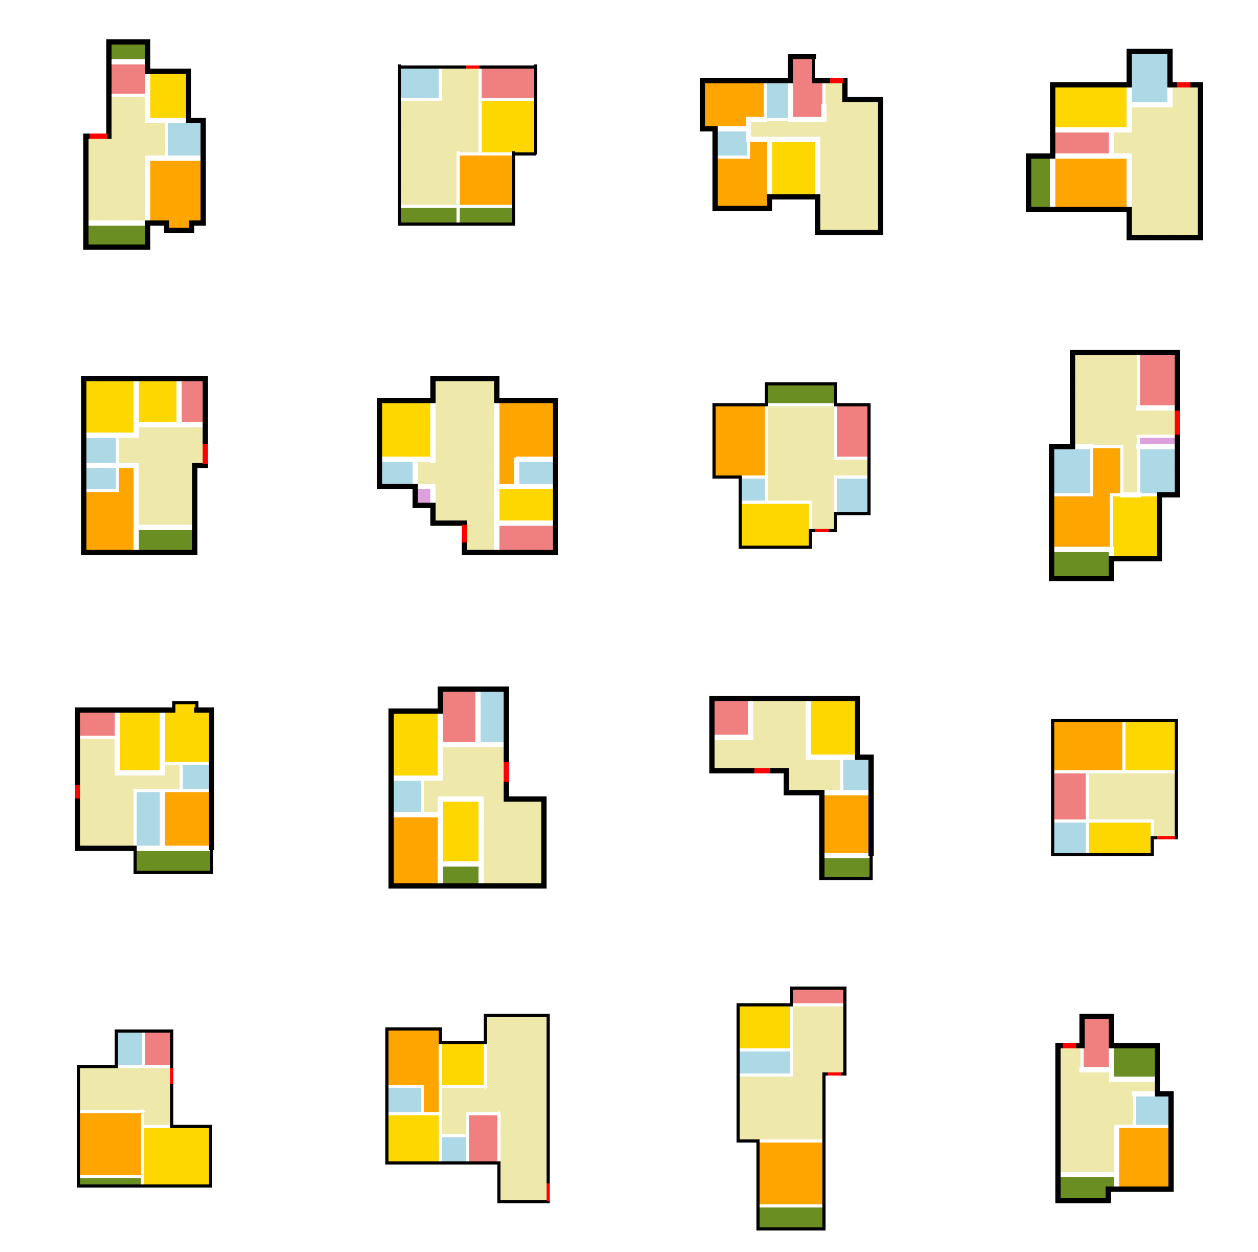

In [ ]:
plt.figure(figsize = (16,16))
k=0
n = 16
for i in range(n):
    ax = plt.subplot(4,4, k+1)
    plt.imshow((d[0][i]+1)/2)
    plt.axis("off")
    k+=1

In [18]:
class PixelNormalization(Layer):
    def __init__(self,):
        super(PixelNormalization, self).__init__()

    def call(self, inputs):
        mean_square = tf.reduce_mean(tf.square(inputs), axis=-1, keepdims=True)
        l2 = tf.math.rsqrt(mean_square + 1.0e-8)
        normalized = inputs * l2
        return normalized




In [19]:
class WeightScaling(Layer):
    def __init__(self, shape, gain = np.sqrt(2),):
        super(WeightScaling, self).__init__()
      #shape = tf.constant(shape, dtype=tf.float32)
        fan_in = tf.math.reduce_prod(shape)
        self.wscale = gain*tf.math.rsqrt(fan_in)

    def call(self, inputs):
        inputs = tf.cast(inputs, tf.float32)
        return inputs * self.wscale

In [ ]:

# class Bias(Layer):
#     def __init__(self, ):
#         super(Bias, self).__init__()

#     def build(self, input_shape):
#         b_init = tf.zeros_initializer()
#         self.bias = tf.Variable(
#             initial_value = b_init(shape=(input_shape[-1],), dtype='float32'),
#             trainable=True)

#     def call(self, inputs,):
#         return inputs + self.bias

In [20]:
class Bias(Layer):
    def __init__(self):
        super(Bias, self).__init__()
        self.bias = None

    def build(self, input_shape):
        # Initialize the bias variable in a way that's compatible with graph execution
        if not self.bias:
            self.bias = self.add_weight(
                shape=(input_shape[-1],),
                initializer="zeros",
                trainable=True,
                name="bias"
            )

    def call(self, inputs):
        return inputs + self.bias


In [21]:

class WeightScalingDense(Layer):
    def __init__(self, n_units,gain,use_pixelnorm=False,activate=None):
        super(WeightScalingDense, self).__init__()
        self.n_units=n_units
        self.gain=gain
        self.use_pixelnorm=use_pixelnorm
        self.activate=activate
    def build(self,input_shape):

        self.dense=Dense(
            self.n_units,
            use_bias=False,
            kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=1.),
            dtype='float32')
        self.bias=Bias()


    def call(self,inputs):
        in_filters = tf.shape(inputs)[-1]

        x=self.dense(inputs)

        x=WeightScaling(shape=(tf.cast(in_filters,dtype=tf.float32)), gain=self.gain)(x)
        x=self.bias(x)

        if self.activate=='LeakyReLU':
            x=LeakyReLU(0.2)(x)
        elif self.activate=='tanh':
            x=Activation('tanh')(x)

        if self.use_pixelnorm:
            x=PixelNormalization()(x)
        return x


In [22]:
class WeightScalingConv(Layer):
    def __init__(self, n_filters,kernel_size,gain,use_pixelnorm=False,activate=None, strides=(1,1)):


        super(WeightScalingConv, self).__init__()
        self.n_filters=n_filters
        self.gain=gain
        self.kernel_size=kernel_size
        self.use_pixelnorm=use_pixelnorm
        self.activate=activate
        self.strides=strides
    def build(self,input_shape):

        self.conv=Conv2D(
          self.n_filters,
          self.kernel_size,
          strides=self.strides,
          use_bias=False,
          padding="same",
          kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=1.),
          dtype='float32')
        self.bias=Bias()

    def call(self,inputs):
        in_filters = tf.shape(inputs)[-1]

        x=self.conv(inputs)
        x=WeightScaling(shape=(tf.cast(self.kernel_size[0],dtype=tf.float32),tf.cast(self.kernel_size[1],dtype=tf.float32),tf.cast(in_filters,dtype=tf.float32)), gain=self.gain)(x)
        x=self.bias(x)

        if self.activate=='LeakyReLU':
            x=LeakyReLU(0.2)(x)
        elif self.activate=='tanh':
            x=Activation('tanh')(x)

        if self.use_pixelnorm:
            x = PixelNormalization()(x)
        return x


In [23]:
class MinibatchStdev(Layer):
    def __init__(self, **kwargs):
        super(MinibatchStdev, self).__init__(**kwargs)

    def call(self, inputs):
        mean = tf.reduce_mean(inputs, axis=0, keepdims=True)
        stddev = tf.sqrt(tf.reduce_mean(tf.square(inputs - mean), axis=0, keepdims=True) + 1e-8)
        average_stddev = tf.reduce_mean(stddev, keepdims=True)
        shape = tf.shape(inputs)
        minibatch_stddev = tf.tile(average_stddev, (shape[0], shape[1], shape[2], 1))
        combined = tf.concat([inputs, minibatch_stddev], axis=-1)

        return combined

In [24]:
FILTERS = [512, 512, 512, 512, 256, 128, 64]

In [25]:
class WeightedSum(Layer):
    def __init__(self,):
        super(WeightedSum, self).__init__()
    def build(self,input_shape):
        self.alpha = tf.Variable(0., dtype=tf.float32, trainable=False)
    def call(self,inputs):
        return ((1.0 - self.alpha) * inputs[0] + (self.alpha * inputs[1]))


In [76]:
from tensorflow.keras import layers, Model

embed_dim=256

gen_loss_list=[]
de_loss_list=[]

class ProGAN(Model):
    def __init__(self,latent_dim,text_embedding_dim , d_steps=1,gp_weight=10.0,drift_weight=0.001,):
        super(ProGAN, self).__init__()
        self.latent_dim = latent_dim
        self.text_embedding_dim=text_embedding_dim
        self.d_steps = d_steps
        self.gp_weight = gp_weight
        self.drift_weight = drift_weight
        self.n_depth = 0
        self.discriminator = self.init_discriminator()
        self.discriminator_wt_fade = None
        self.generator = self.init_generator()
        self.generator_wt_fade = None

    def init_discriminator(self):

        init_weights_kernel = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

        # Text Embedding Input
        image_text = Input(shape=(self.text_embedding_dim,))

        text_reshaped = Dense(4 *4 * 3, kernel_initializer=init_weights_kernel)(image_text)
        text_reshaped = Reshape((4, 4, 3))(text_reshaped)

        img_input = Input(shape = (4,4,3))
        # img_input = tf.cast(img_input, tf.float32)

        # Combine image and text embedding
        concat = Concatenate(name='Combine-Layer')([img_input, text_reshaped])
        # concat = tf.cast(concat, tf.float32)

      # fromRGB
        x=WeightScalingConv(n_filters=FILTERS[0],kernel_size=(1,1),gain=np.sqrt(2),activate='LeakyReLU')(concat)

        x = MinibatchStdev()(x)

        x=WeightScalingConv(n_filters=FILTERS[0],kernel_size=(3,3),gain=np.sqrt(2),activate='LeakyReLU')(x)
        x=WeightScalingConv(n_filters=FILTERS[0],kernel_size=(4,4),gain=np.sqrt(2),activate='LeakyReLU', strides=(4,4))(x)

        x = Flatten()(x)

        x= WeightScalingDense(n_units=1,gain=1.)(x)

        d_model = Model(inputs=[img_input,image_text], outputs=x, name='discriminator')

        # d_model = Model(img_input, x, name='discriminator')

        return d_model



    def fade_in_discriminator(self):
        # Initialize weights
        init_weights_kernel = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

        # Calculate the new shape for images at this depth
        new_image_shape = list(self.discriminator.input[0].shape)
        new_image_shape= (new_image_shape[1]*2, new_image_shape[2]*2, new_image_shape[3])

        # Inputs
        img_input = Input(shape=new_image_shape)
        text_input = Input(shape=(self.text_embedding_dim,))

        # Downsample the image input to match the lower resolution of the fading in process
        x1_downsampled = AveragePooling2D(pool_size=(2, 2))(img_input)

        # Generate text embeddings reshaped to match the downsampled image input
        # Ensure the reshaped text has the correct dimensions
        projected_dim = x1_downsampled.shape[1] * x1_downsampled.shape[2] * 3  # New number of units for Dense layer
        text_reshaped = Dense(projected_dim, kernel_initializer=init_weights_kernel)(text_input)
        text_reshaped = Reshape((x1_downsampled.shape[1], x1_downsampled.shape[2], 3))(text_reshaped)


        # # Concatenate downsampled image and text
        x1 = Concatenate()([x1_downsampled, text_reshaped])

        # Apply convolutional layers to concatenated input
        print(f"layer {self.discriminator.layers[5].name}")
        x1 = self.discriminator.layers[5](x1)
        print("x1 shape ")

        # Prepare the direct image and text input for comparison
        text_reshaped_direct = Dense(new_image_shape[0] * new_image_shape[1] * 3, kernel_initializer=init_weights_kernel)(text_input)
        text_reshaped_direct = Reshape(new_image_shape)(text_reshaped_direct)
        x2 = Concatenate()([img_input, text_reshaped_direct])



        # Apply convolutional layers to direct concatenated input
        x2=WeightScalingConv(FILTERS[self.n_depth],(1,1),np.sqrt(2),activate='LeakyReLU')(x2)
        x2=WeightScalingConv(FILTERS[self.n_depth],(3,3),np.sqrt(2), activate='LeakyReLU')(x2)
        x2=WeightScalingConv(FILTERS[self.n_depth-1],(3,3),np.sqrt(2), activate='LeakyReLU')(x2)

        x2 = AveragePooling2D(pool_size=(2, 2))(x2)


        print("WeightedSum", x1.shape, x2.shape)
        # Combine the paths with weighted sum
        combined = WeightedSum()([x1, x2])

        for i in range(6, len(self.discriminator.layers)):
            print("Layer : ", i, self.discriminator.layers[i])
            x2 = self.discriminator.layers[i](x2)
        self.discriminator_stabilize = Model([img_input, text_input], x2, name='discriminator')
        self.discriminator_stabilize.summary()

        # Continue with the rest of the discriminator architecture
        for layer in self.discriminator.layers[6:]:  # Assuming layers[6:] are the subsequent layers
            combined = layer(combined)

        # Final model
        self.discriminator = Model([img_input, text_input], combined, name='discriminator_stabilize')
        self.discriminator.summary()






    def stabilize_discriminator(self):
        self.discriminator = self.discriminator_stabilize
        self.discriminator.summary()

    def init_generator(self):
        in_latent = Input(shape=(self.latent_dim,))

        in_text_embedding = Input(shape=(self.text_embedding_dim,))

        merged_input = Concatenate()([in_latent, in_text_embedding])
        x = layers.Dense(4 * 4 * FILTERS[0], activation='relu')(merged_input)

        # noise = Input(shape=(self.latent_dim,))

        # x = PixelNormalization()(noise)
        x = PixelNormalization()(merged_input)

        x=WeightScalingDense(n_units=4*4*FILTERS[0], gain=np.sqrt(2)/4, activate='LeakyReLU', use_pixelnorm=True)(x)

        x = Reshape((4, 4, FILTERS[0]))(x)

        x=WeightScalingConv(FILTERS[0], kernel_size=(4,4), gain=np.sqrt(2), activate='LeakyReLU', use_pixelnorm=True)(x)
        x=WeightScalingConv(FILTERS[0], kernel_size=(3,3), gain=np.sqrt(2), activate='LeakyReLU', use_pixelnorm=True)(x)
        x=WeightScalingConv(3, kernel_size=(1,1), gain=1., activate='tanh', use_pixelnorm=False)(x)

        # g_model = Model(noise, x, name='generator')
        g_model = Model([in_latent, in_text_embedding], x, name='generator')
        g_model.summary()
        return g_model



        self.generator.summary()



    def fade_in_generator(self):
        # Assume `noise_input` and `text_input` are defined earlier in your model
        block_end = self.generator.layers[-2].output
        block_end = UpSampling2D((2,2))(block_end)

        x1 = self.generator.layers[-1](block_end)


        x2 = WeightScalingConv(FILTERS[self.n_depth], (3,3), np.sqrt(2),
                            activate='LeakyReLU', use_pixelnorm=True)(block_end)
        x2 = WeightScalingConv(FILTERS[self.n_depth], (3,3), np.sqrt(2),
                            activate='LeakyReLU', use_pixelnorm=True)(x2)
        x2 = WeightScalingConv(3, (1,1), 1., activate='tanh', use_pixelnorm=False)(x2)

        # Assuming generator initially takes [noise_input, text_input] as inputs
        self.generator_stabilize = Model([self.generator.input[0], self.generator.input[1]], x2, name='generator_stabilize')

        x = WeightedSum()([x1, x2])
        self.generator = Model([self.generator.input[0], self.generator.input[1]], x, name='generator')

        self.generator.summary()


    def stabilize_generator(self):
        self.generator = self.generator_stabilize
        self.generator.summary()

    def compile(self, d_optimizer, g_optimizer):
        super(ProGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer



    def gradient_penalty(self, batch_size, real_images, fake_images, text_embeddings):
        """
        Computes the gradient penalty, incorporating text embeddings, to enforce the Lipschitz constraint.

        Parameters:
        - batch_size: Integer, the size of the current batch.
        - real_images: Tensor, real images from the dataset.
        - fake_images: Tensor, fake images generated by the generator.
        - text_embeddings: Tensor, corresponding text embeddings for the images.

        Returns:
        - The gradient penalty term to be added to the discriminator's loss.
        """
        epsilon = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        interpolation_images = epsilon * real_images + (1 - epsilon) * fake_images

        # Assuming text_embeddings do not need interpolation but are repeated to match the interpolated images' batch size
        # repeated_text_embeddings = tf.repeat(text_embeddings, repeats=[batch_size], axis=0)
                # Make sure text_embeddings' batch size matches interpolation_images' batch size
        # assert text_embeddings.shape[0] == batch_size, "Mismatch in batch size"


        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolation_images)
            # The discriminator now also considers text embeddings along with the images
            prediction = self.discriminator([interpolation_images, text_embeddings], training=True)

        grads = gp_tape.gradient(prediction, interpolation_images)
        l2_norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gradient_penalty = tf.reduce_mean((l2_norm - 1.0) ** 2)

        return gradient_penalty




    def train_step(self, data):
        # Unpack the data. Adapt this as necessary to fit your data structure.
        real_images, text_embeddings = data
        print("Train step",real_images.shape, text_embeddings.shape )

        batch_size = tf.shape(real_images)[0]

        # Generate random latent vectors
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Prepare for gradient calculation for both generator and discriminator
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # Generate fake images
            print(random_latent_vectors.shape, text_embeddings.shape)
            fake_images = self.generator([random_latent_vectors, text_embeddings], training=True)

            # Discriminator predictions on real and fake images with text embeddings
            real_logits = self.discriminator([real_images, text_embeddings], training=True)
            fake_logits = self.discriminator([fake_images, text_embeddings], training=True)

            # Calculate the discriminator's loss, including gradient penalty and drift
            d_cost = tf.reduce_mean(fake_logits) - tf.reduce_mean(real_logits)
            gp = self.gradient_penalty(batch_size, real_images, fake_images, text_embeddings)
            drift = tf.reduce_mean(tf.square(real_logits))
            d_loss = d_cost + self.gp_weight * gp + self.drift_weight * drift

            # Calculate the generator's loss
            g_loss = -tf.reduce_mean(fake_logits)
            de_loss_list.append(d_loss)
            gen_loss_list.append(g_loss)



        # Calculate gradients and apply them to the optimizer
        d_gradients = disc_tape.gradient(d_loss, self.discriminator.trainable_variables)
        g_gradients = gen_tape.gradient(g_loss, self.generator.trainable_variables)

        self.d_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))
        self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_variables))

        # Return the loss values for monitoring
        return {'d_loss': d_loss, 'g_loss': g_loss}



In [77]:
import random

model = SentenceTransformer('all-MiniLM-L6-v2')

def generate_text_embeddings(num_samples):
    """
    Generates text embeddings for a randomly selected subset of descriptions.

    Parameters:
    - num_samples: The number of text samples to generate embeddings for.

    Returns:
    - A numpy array of shape (num_samples, embedding_dimension)
    """
    # Ensure we don't sample more descriptions than we have
    num_samples = min(num_samples, len(descriptions))

    # Randomly sample descriptions
    sampled_descriptions = random.sample(descriptions, num_samples)

    # Generate embeddings for the sampled descriptions
    # embeddings = model.encode(sampled_descriptions)
    embeddings = embed_model.encode(sampled_descriptions)
    embeddings = embeddings[:, :256]

    return embeddings


In [78]:
class ShowImage(tf.keras.callbacks.Callback):
    def __init__(self,prefix,res,latent_dim=512,steps_per_epoch=1000,epochs=50,):
        self.latent_dim = latent_dim
        self.prefix=prefix
        self.steps_per_epoch=steps_per_epoch
        self.epochs=epochs
        self.res=res

    def on_epoch_begin(self, epoch, logs=None):
        self.n_epoch = epoch

    def on_epoch_end(self, epoch, logs=None):
        n=6
        k=0
        text_example=generate_text_embeddings(36)
        text_embeddings_trans = tf.convert_to_tensor(text_example, dtype=tf.float32)
        out=self.model.generator([tf.random.normal(shape=(36, self.latent_dim)), text_embeddings_trans])

        plt.figure(figsize=(16,16))
        for i in range(n):
            for j in range(n):

                ax=plt.subplot(n,n,k+1)
                plt.imshow((out[k]+1)/2,)
                plt.axis('off')
                k+=1

        plt.savefig("generated/gen_images_{}x{}_{}_epoch_{}.png".format(self.res,self.res,self.prefix,epoch+1))
        plt.show()
#         loss_graph(de_loss_list,gen_loss_list)

    def on_batch_begin(self, batch, logs=None):
        alpha = ((self.n_epoch * self.steps_per_epoch) + batch)/float(self.steps_per_epoch * self.epochs - 1)
        for layer in self.model.generator.layers:
            if isinstance(layer, WeightedSum):
                layer.alpha.assign(alpha)
        for layer in self.model.discriminator.layers:
            if isinstance(layer, WeightedSum):
                layer.alpha.assign(alpha)

In [79]:

!mkdir generated

mkdir: cannot create directory ‘generated’: File exists


In [80]:
NOISE_DIM = 512
BATCH_SIZE = [16, 16, 16, 16, 16, 16,]

In [86]:
STEPS_PER_EPOCH=100
EPOCHS=50


In [87]:
BATCH_SIZE[0]

16

In [88]:
import matplotlib.pyplot as plt

def loss_graph(d_loss_list,g_loss_list ):

  # Plotting the loss values
  plt.figure(figsize=(10, 5))
  plt.plot(d_loss_list, label='Discriminator Loss', color='blue')
  plt.plot(g_loss_list, label='Generator Loss', color='red')
  plt.title('Training Losses')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()


Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_39 (InputLayer)       [(None, 512)]                0         []                            
                                                                                                  
 input_40 (InputLayer)       [(None, 256)]                0         []                            
                                                                                                  
 concatenate_17 (Concatenat  (None, 768)                  0         ['input_39[0][0]',            
 e)                                                                  'input_40[0][0]']            
                                                                                                  
 pixel_normalization_62 (Pi  (None, 768)                  0         ['concatenate_17[0][0]

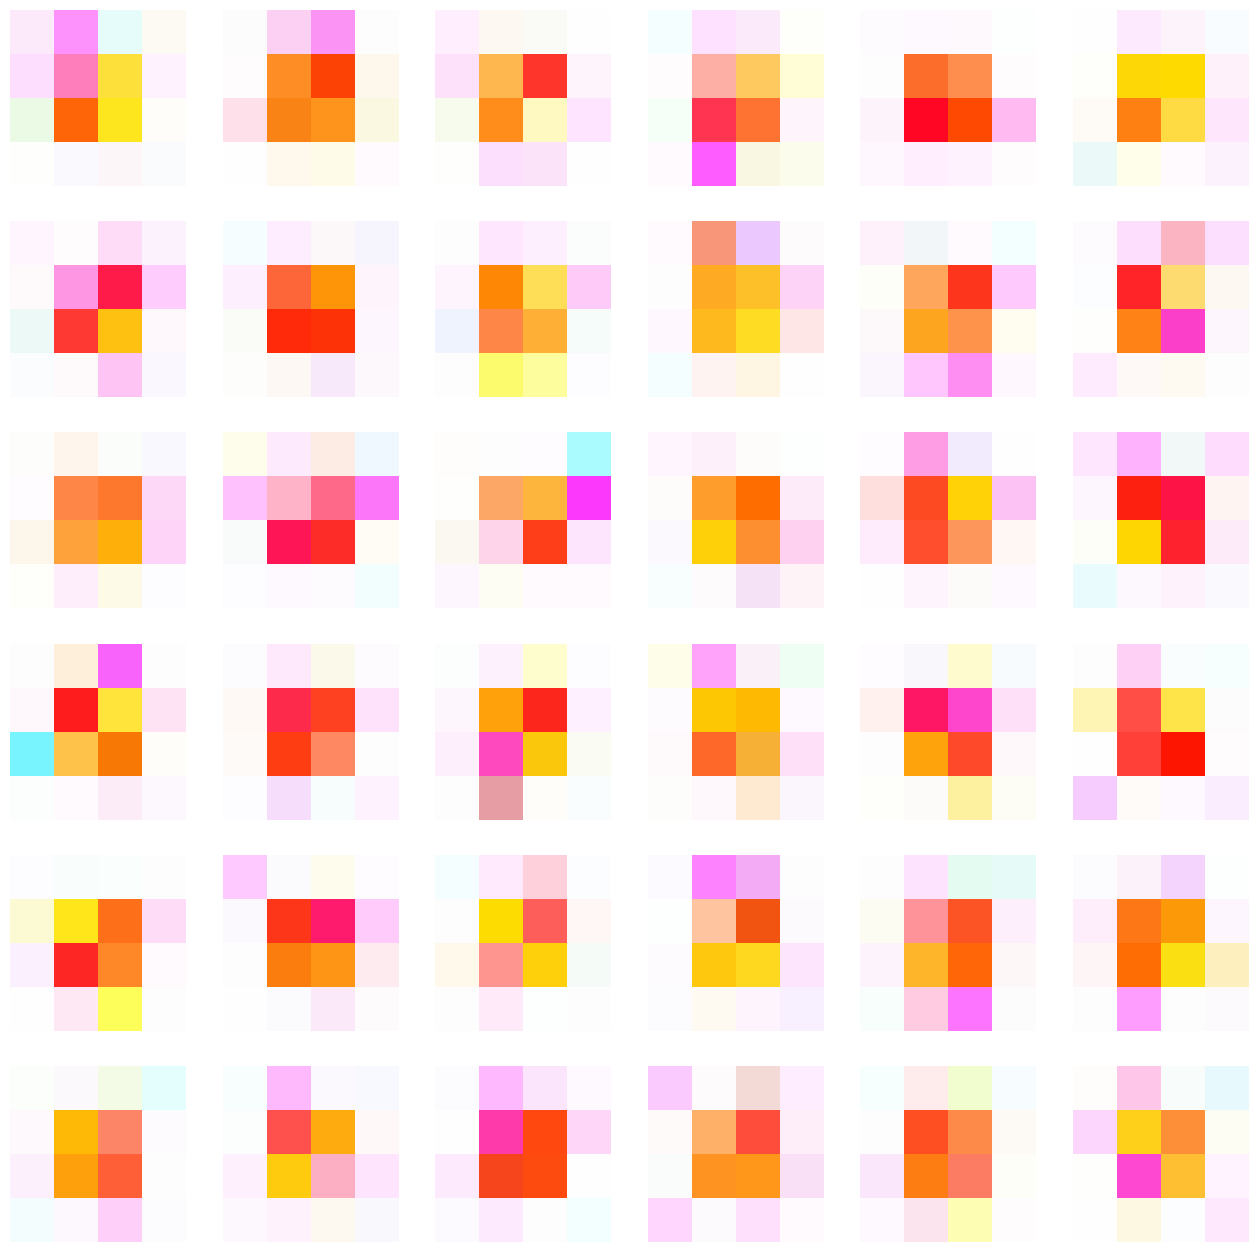

25/25 [==============================] - 21s 608ms/step - d_loss: -0.5380 - g_loss: -2.4530
Epoch 2/50
25/25 [==============================] - ETA: 0s - d_loss: -0.7347 - g_loss: -1.7911

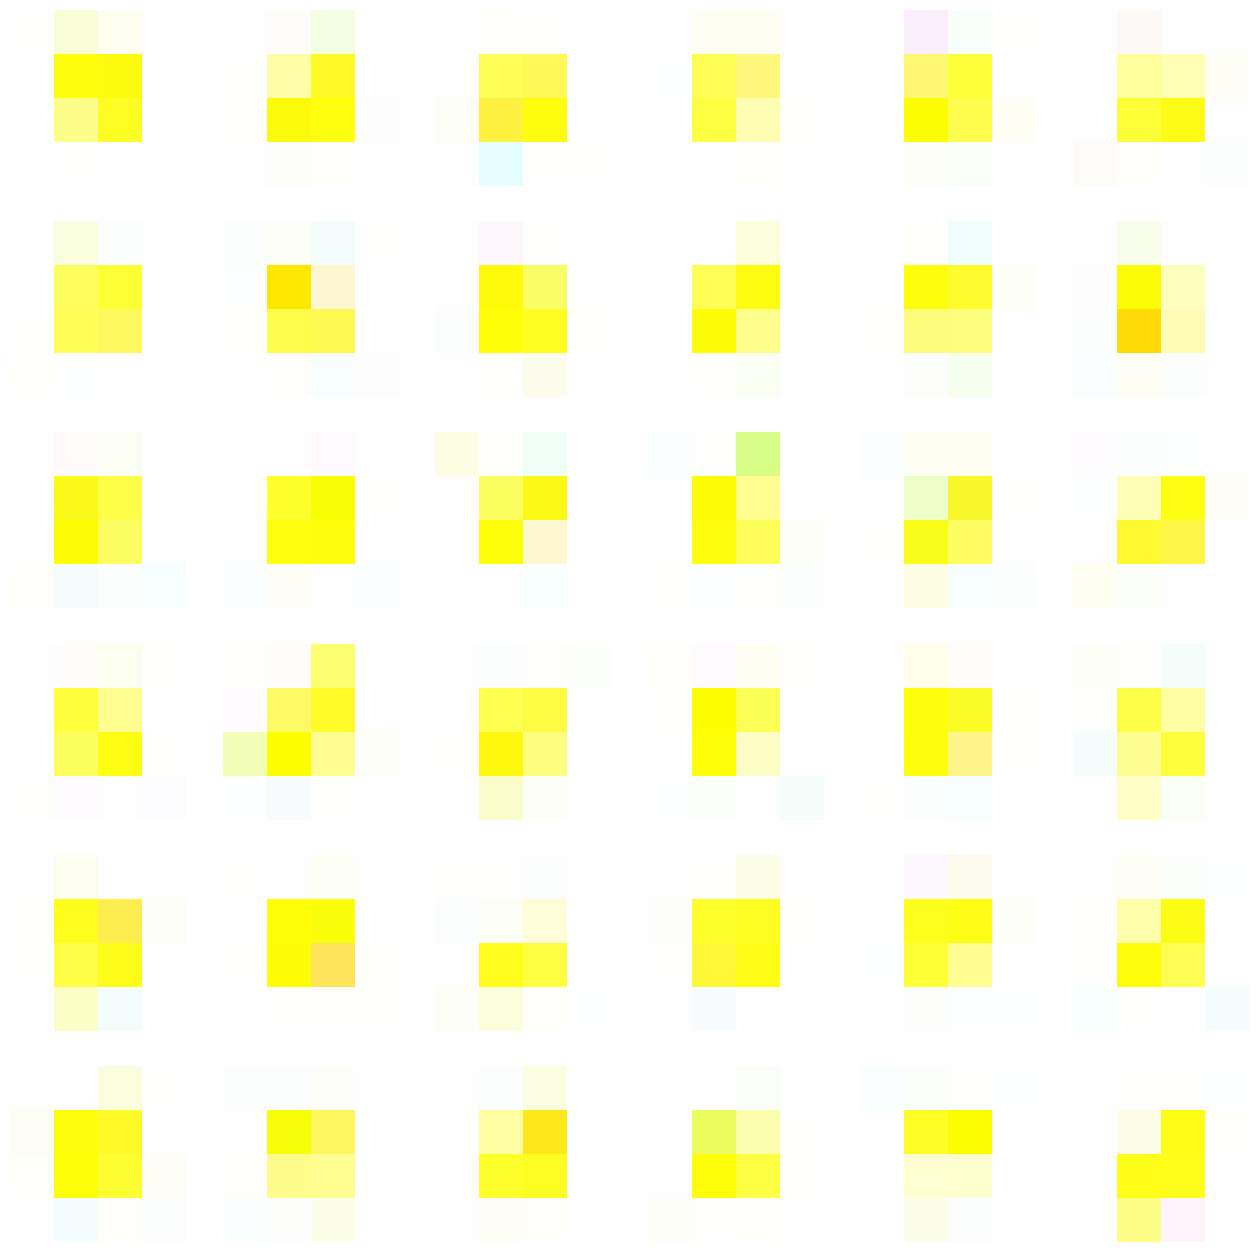

25/25 [==============================] - 15s 599ms/step - d_loss: -0.7390 - g_loss: -1.7873
Epoch 3/50
25/25 [==============================] - ETA: 0s - d_loss: -1.2494 - g_loss: 0.1933

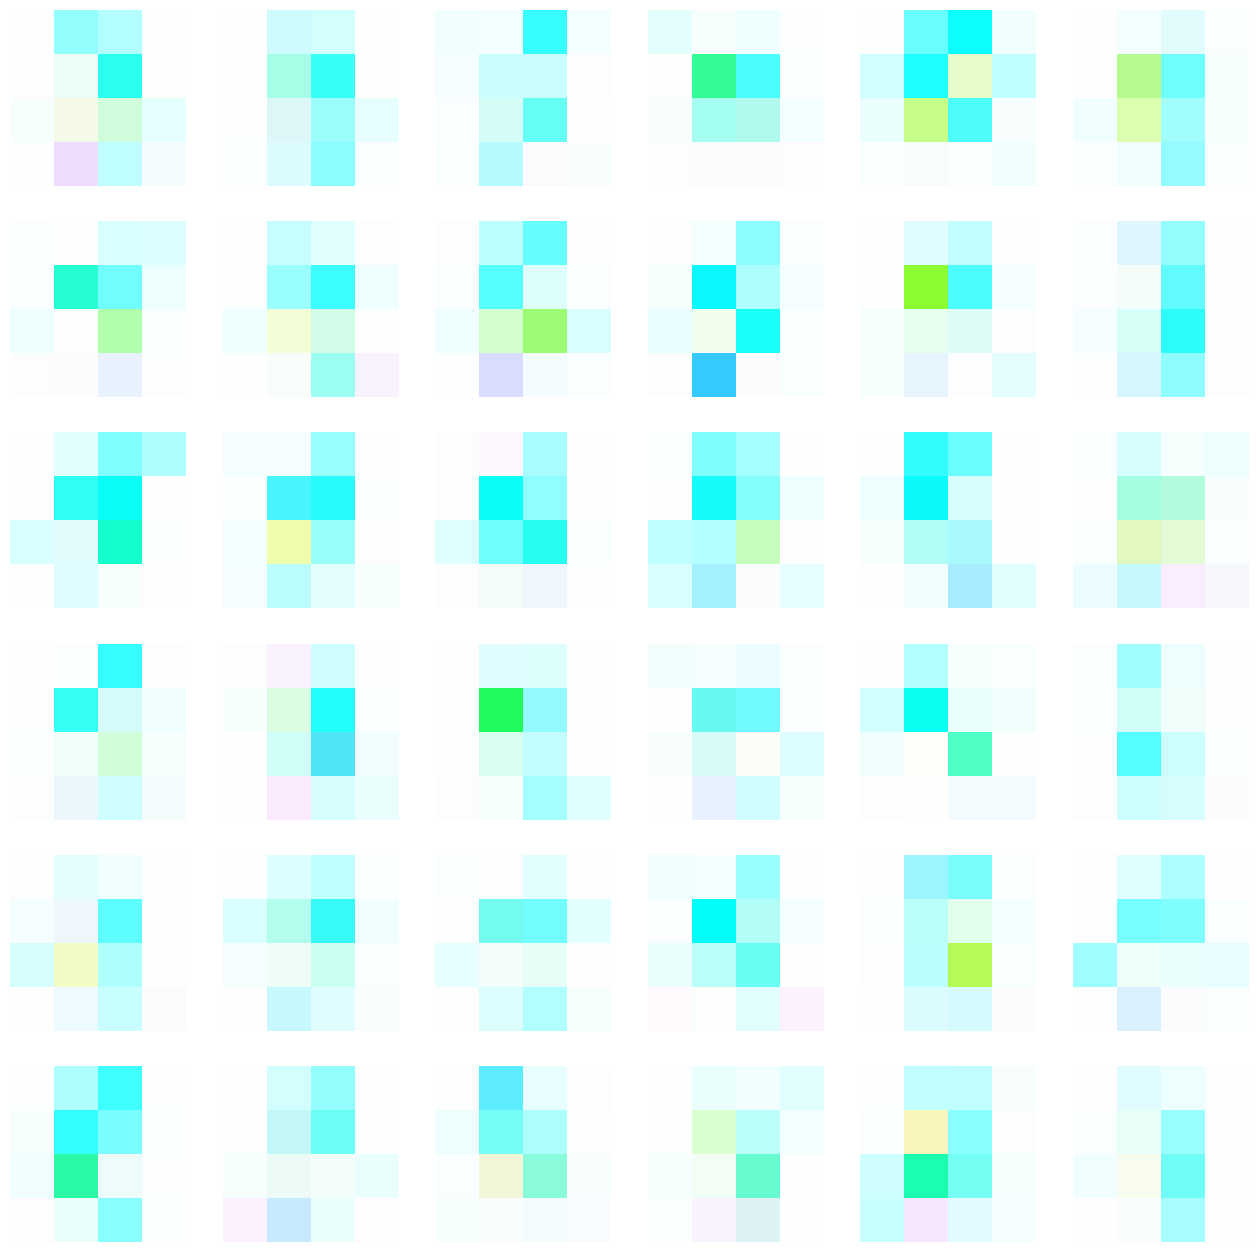

25/25 [==============================] - 15s 606ms/step - d_loss: -1.2717 - g_loss: 0.1970
Epoch 4/50
25/25 [==============================] - ETA: 0s - d_loss: -1.1553 - g_loss: 0.5457

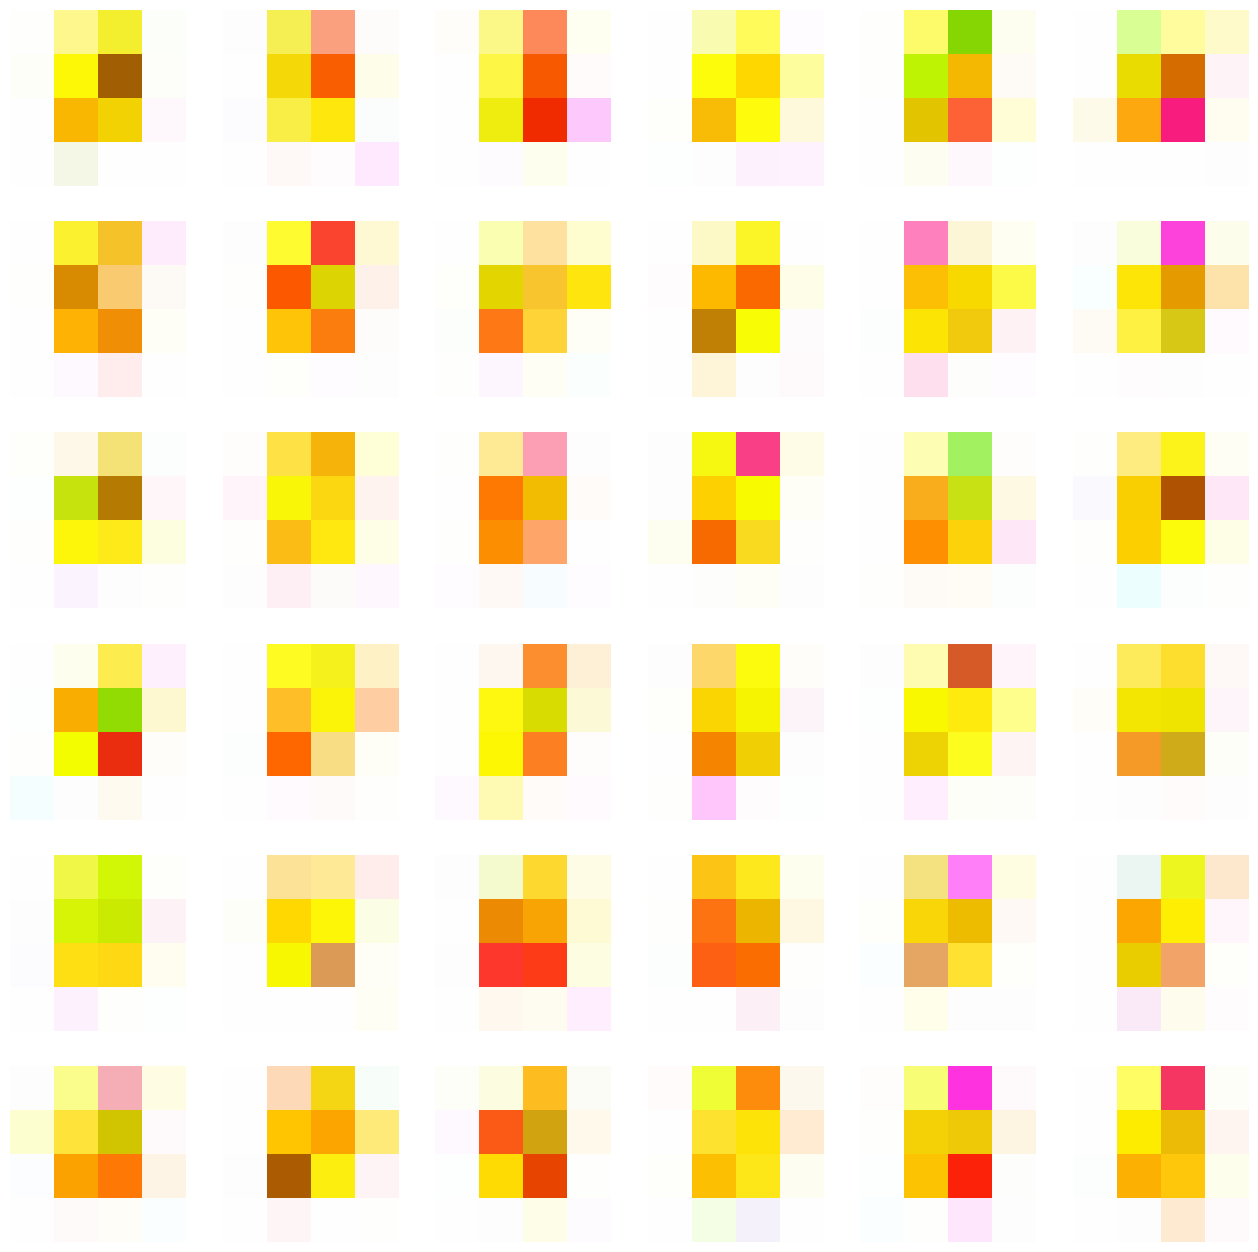

25/25 [==============================] - 16s 644ms/step - d_loss: -1.2070 - g_loss: 0.6045
Epoch 5/50
25/25 [==============================] - ETA: 0s - d_loss: -1.2670 - g_loss: 1.6937

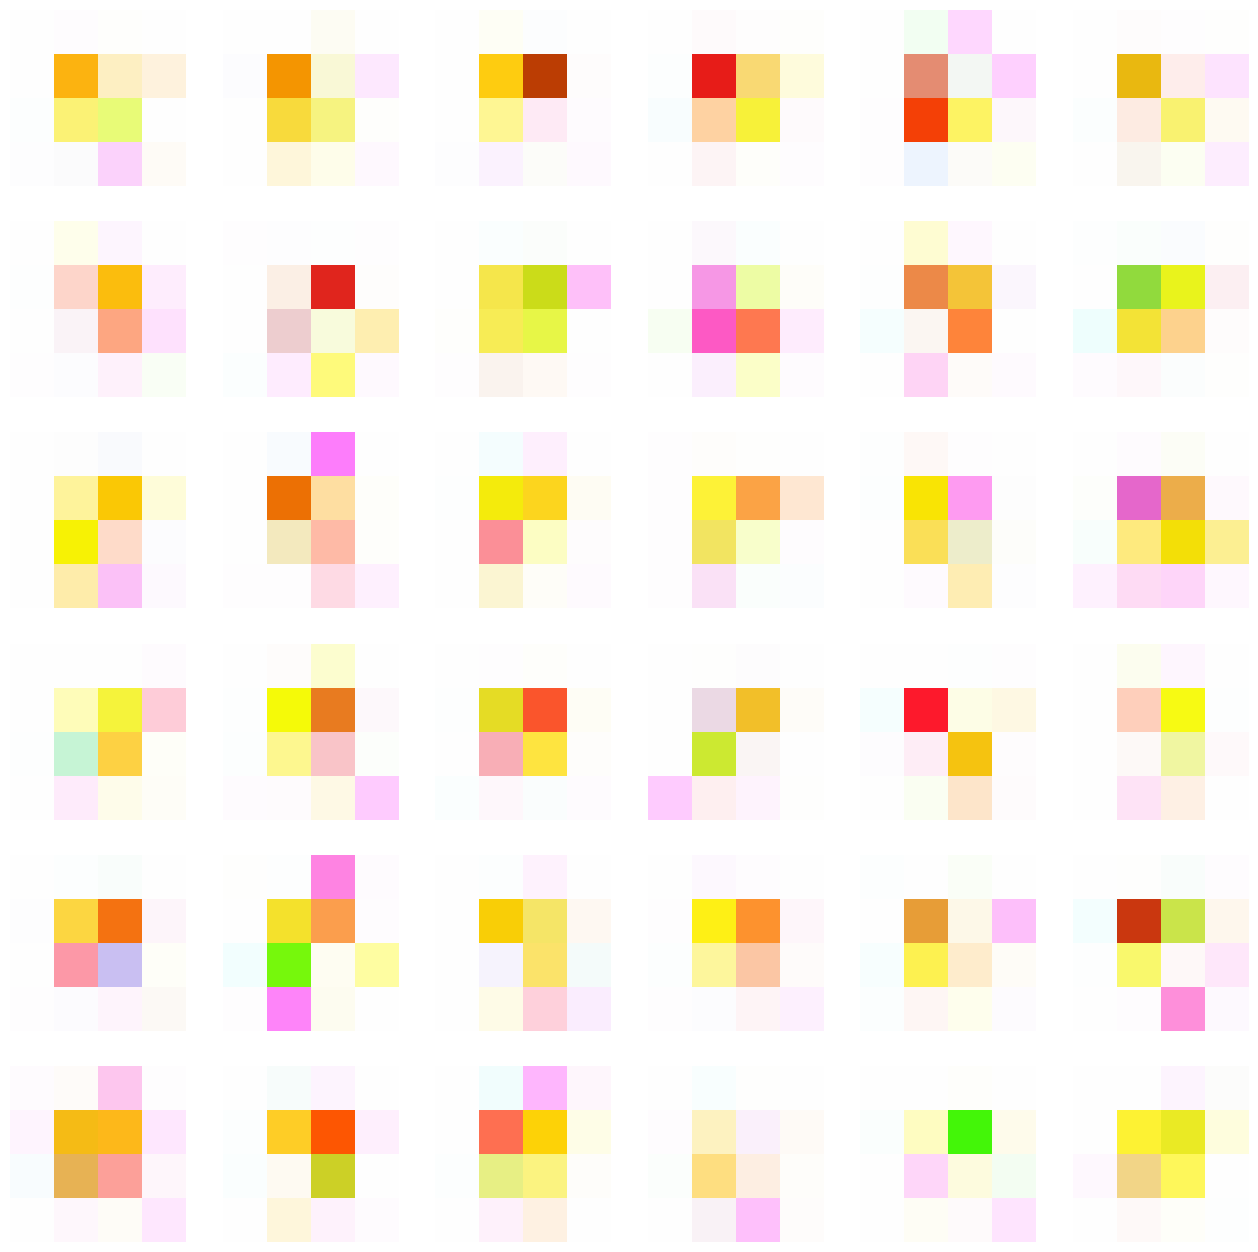

25/25 [==============================] - 15s 611ms/step - d_loss: -1.2673 - g_loss: 1.7394
Epoch 6/50
25/25 [==============================] - ETA: 0s - d_loss: -1.5055 - g_loss: 0.7849

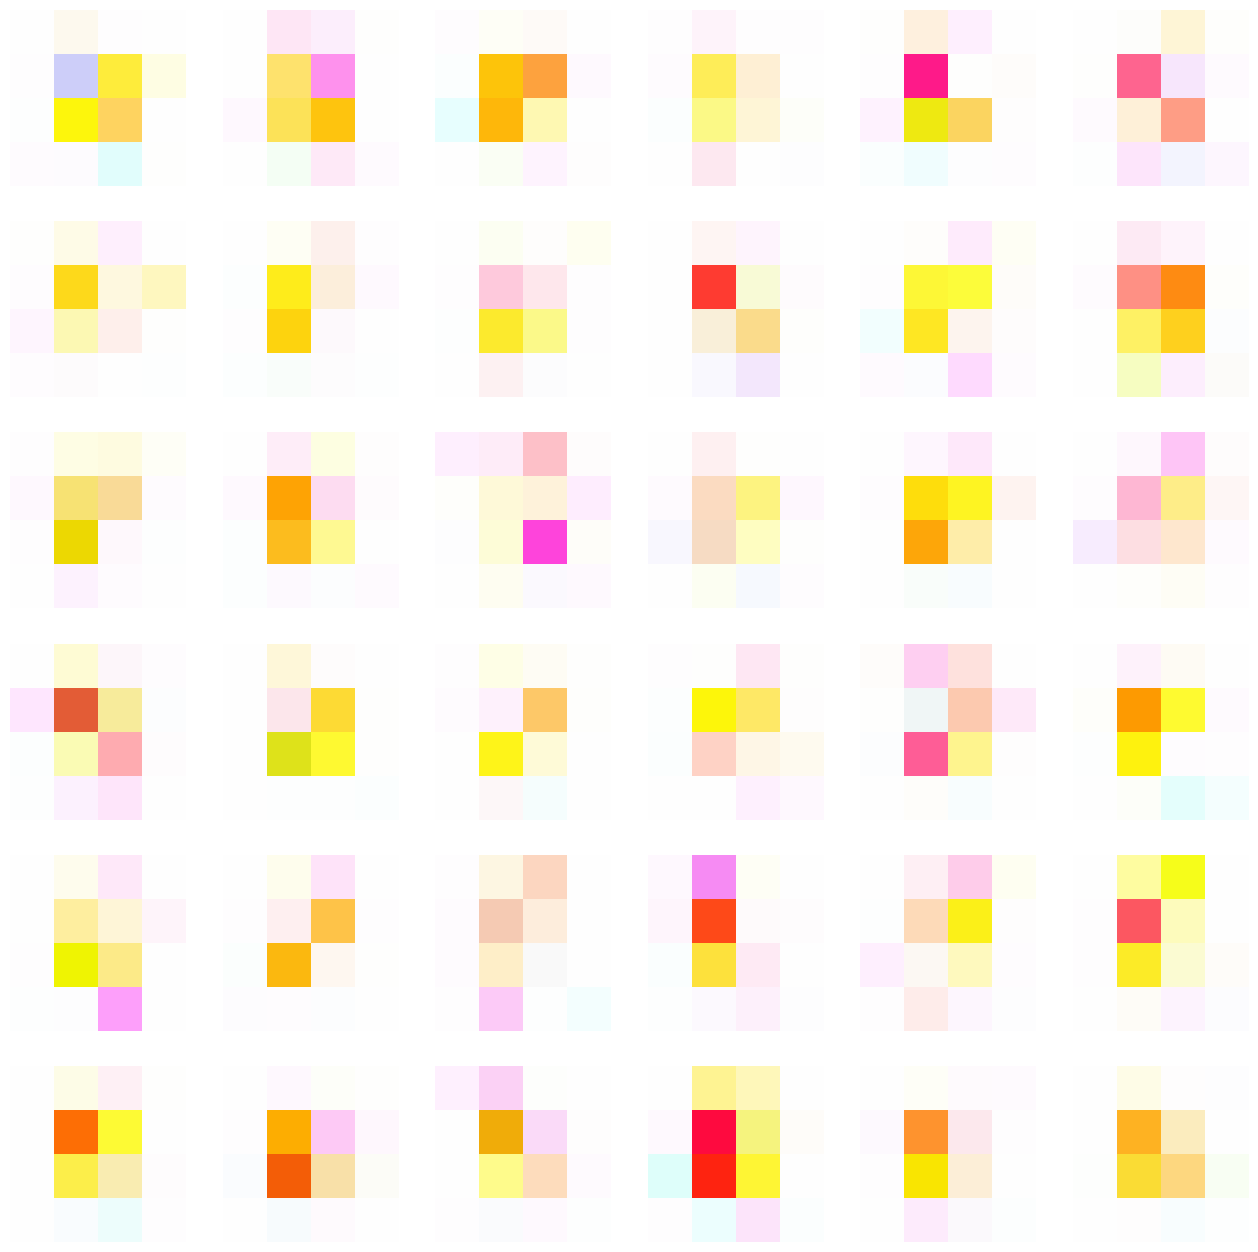

25/25 [==============================] - 15s 601ms/step - d_loss: -1.4763 - g_loss: 0.7923
Epoch 7/50
25/25 [==============================] - ETA: 0s - d_loss: -1.1447 - g_loss: 1.1515

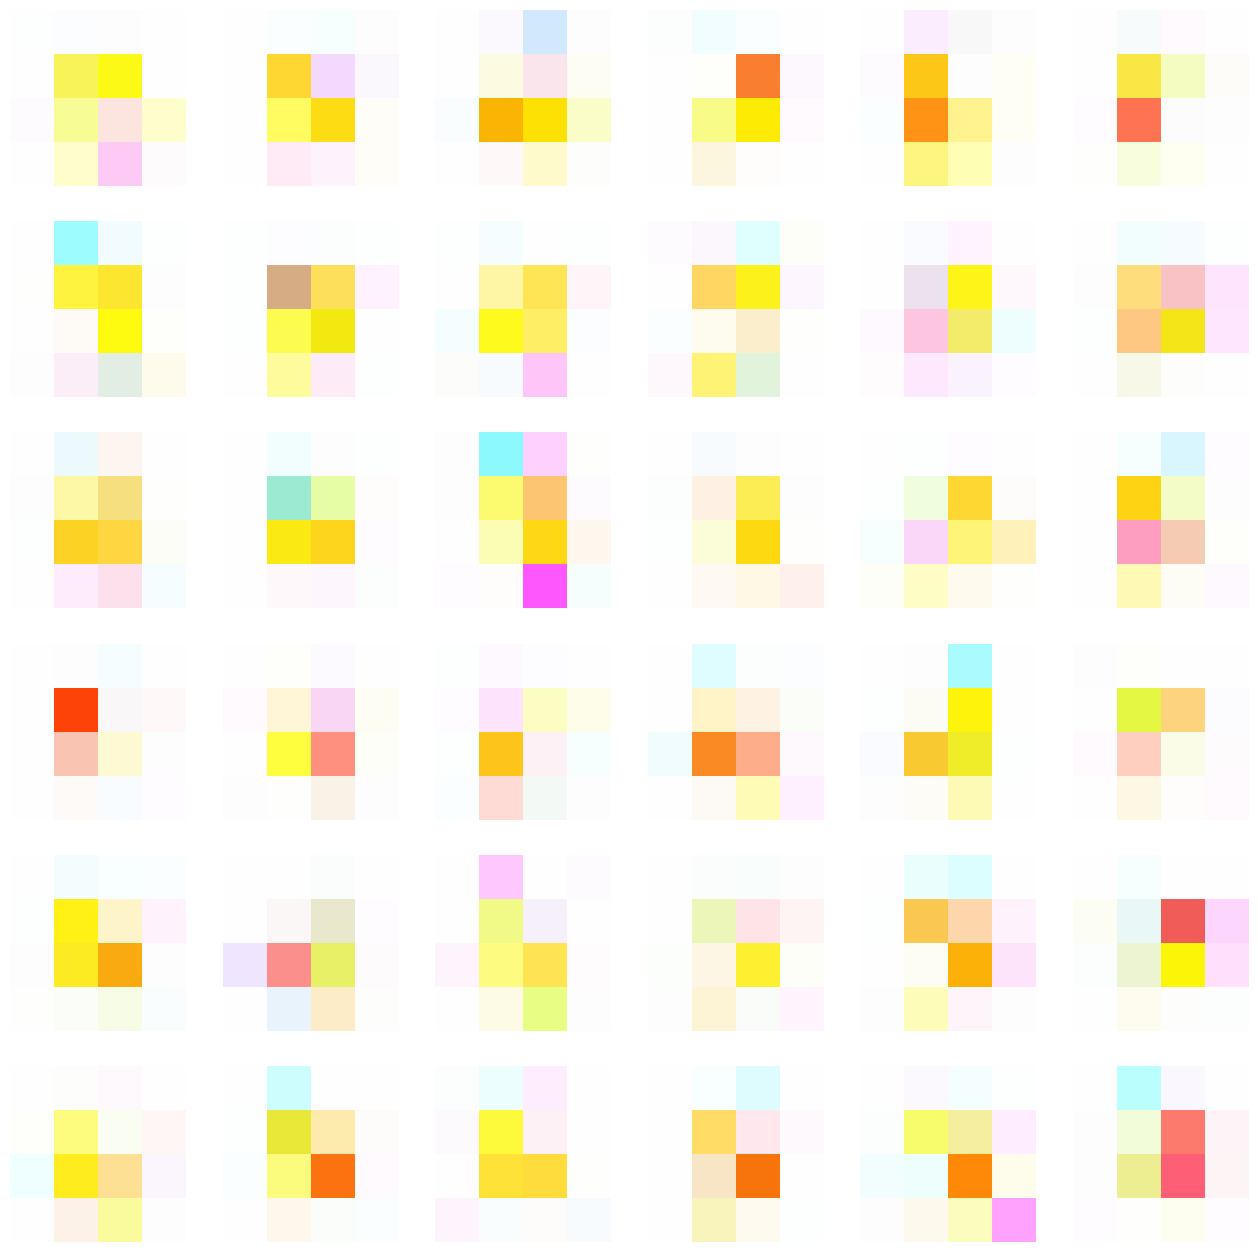

25/25 [==============================] - 15s 594ms/step - d_loss: -1.1398 - g_loss: 1.1881
Epoch 8/50
25/25 [==============================] - ETA: 0s - d_loss: -1.2643 - g_loss: 1.2874

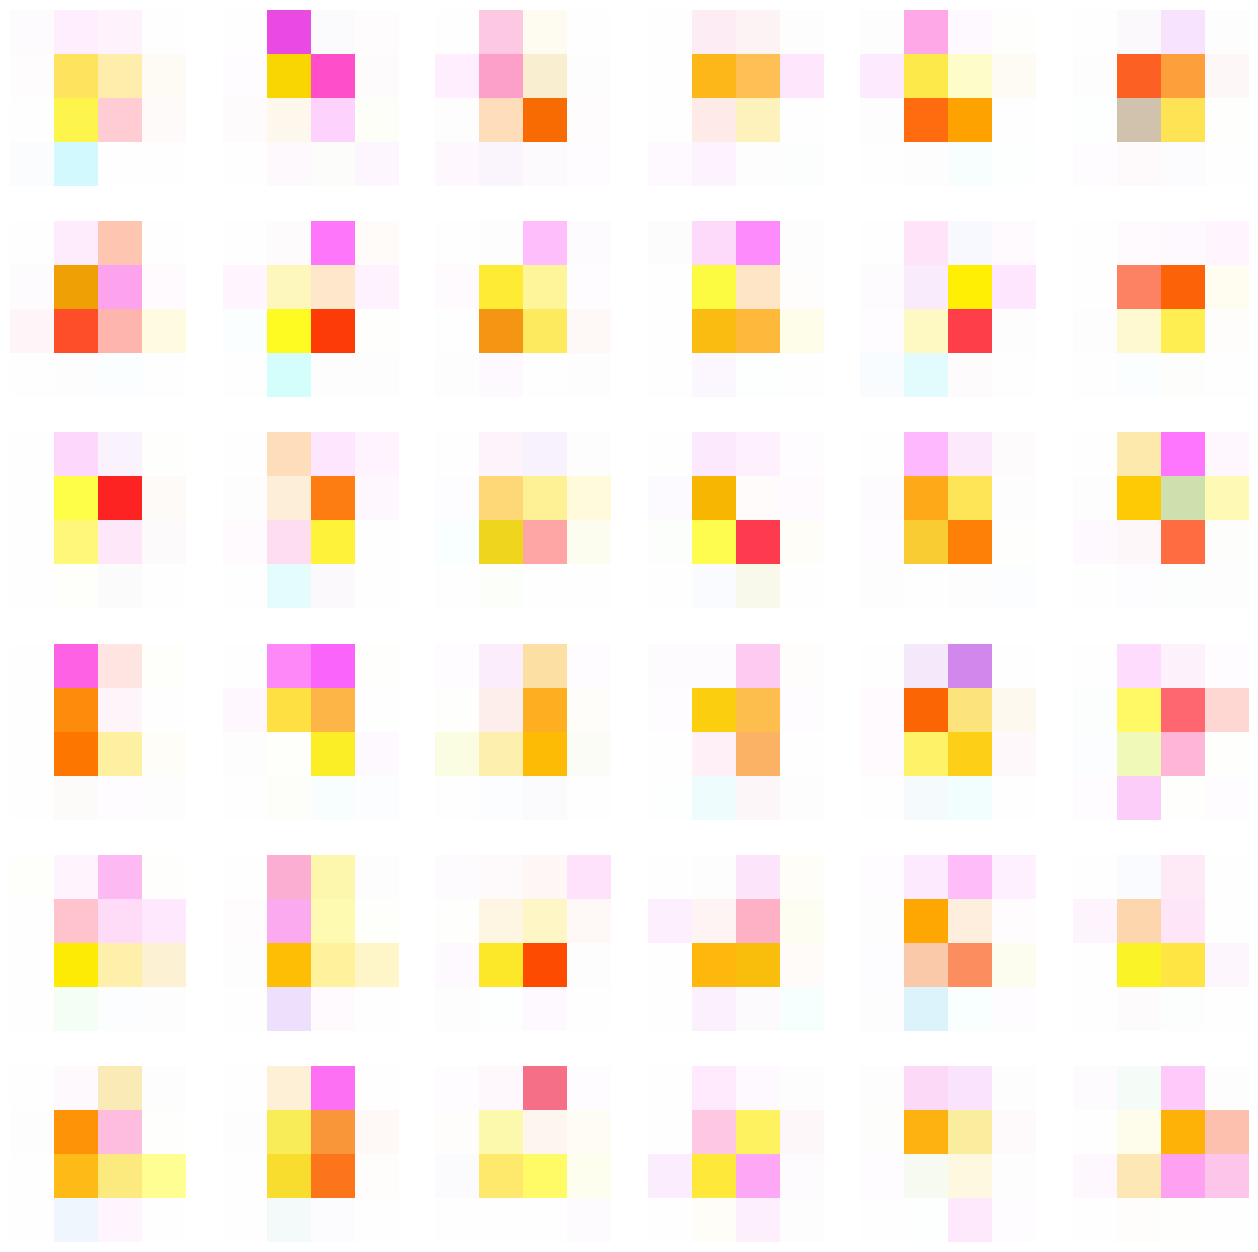

25/25 [==============================] - 15s 597ms/step - d_loss: -1.2649 - g_loss: 1.3461
Epoch 9/50
25/25 [==============================] - ETA: 0s - d_loss: -1.1493 - g_loss: 1.5683

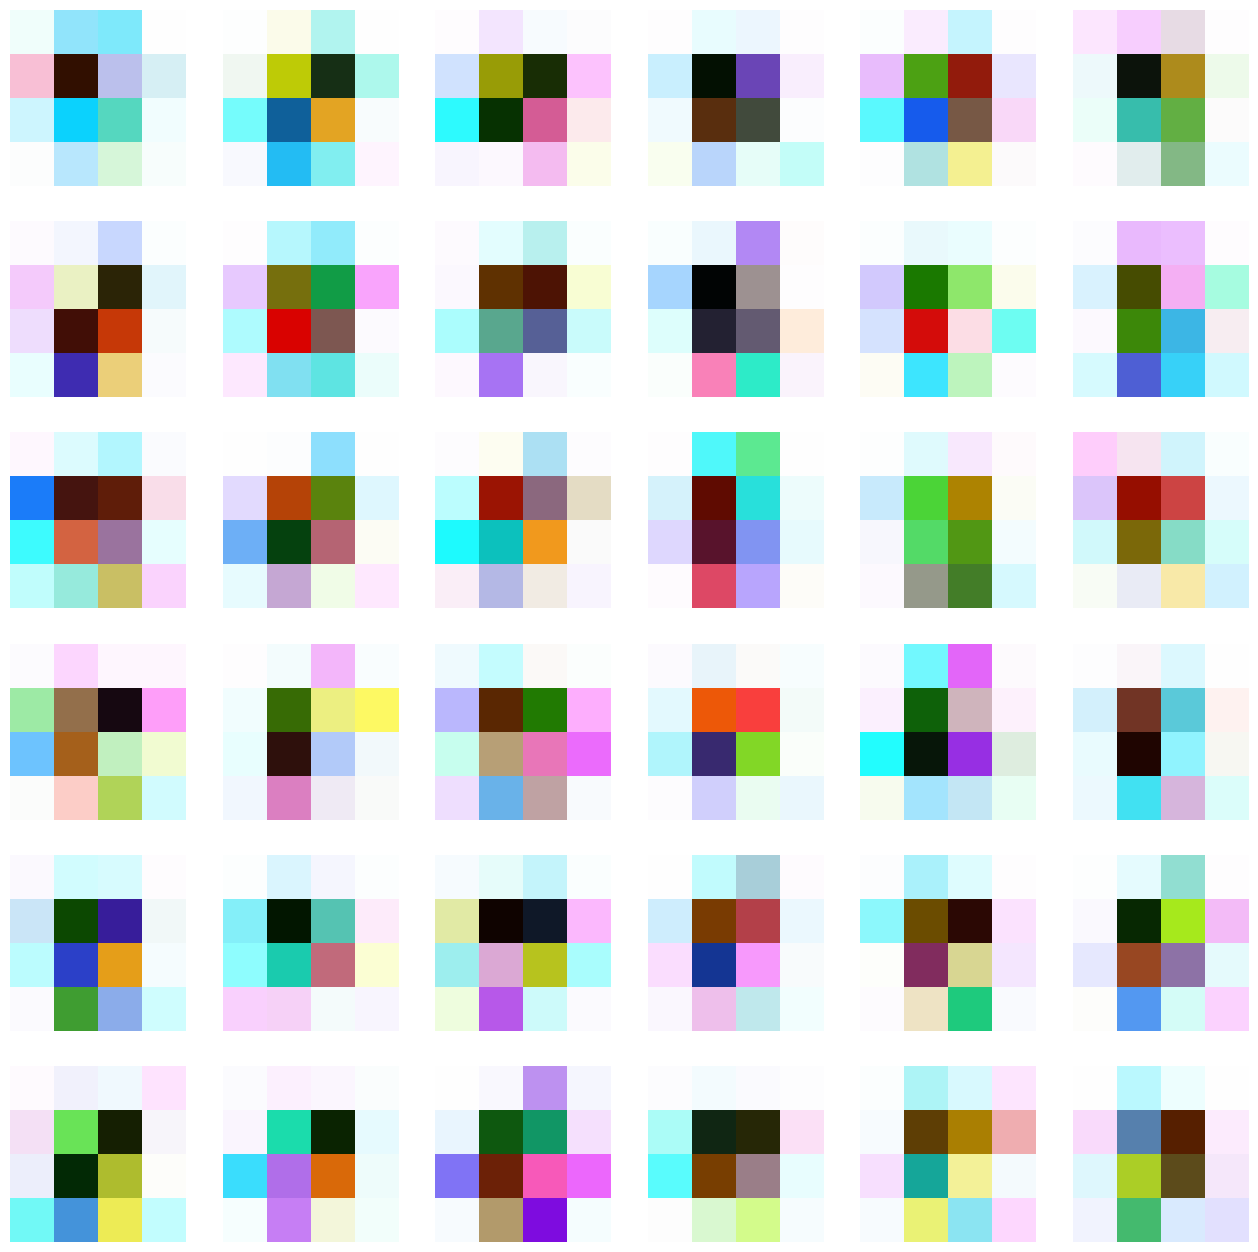

25/25 [==============================] - 16s 638ms/step - d_loss: -1.1411 - g_loss: 1.5790
Epoch 10/50
25/25 [==============================] - ETA: 0s - d_loss: -1.2345 - g_loss: 1.4204

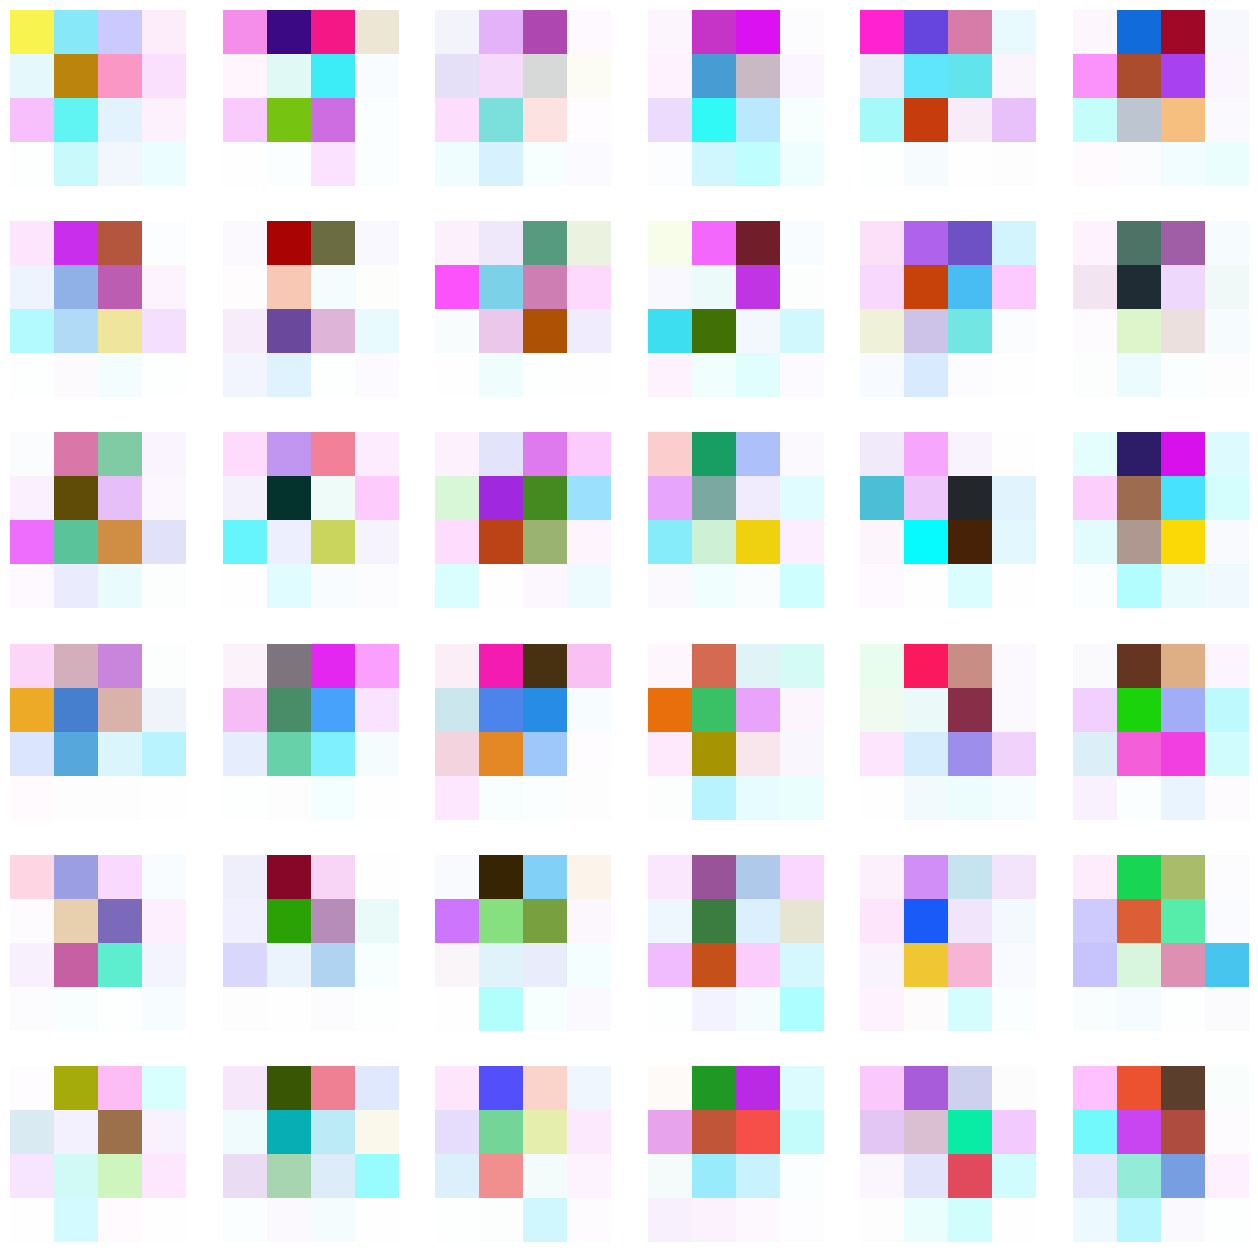

25/25 [==============================] - 15s 597ms/step - d_loss: -1.2347 - g_loss: 1.3812
Epoch 11/50
25/25 [==============================] - ETA: 0s - d_loss: -1.1697 - g_loss: 1.4281

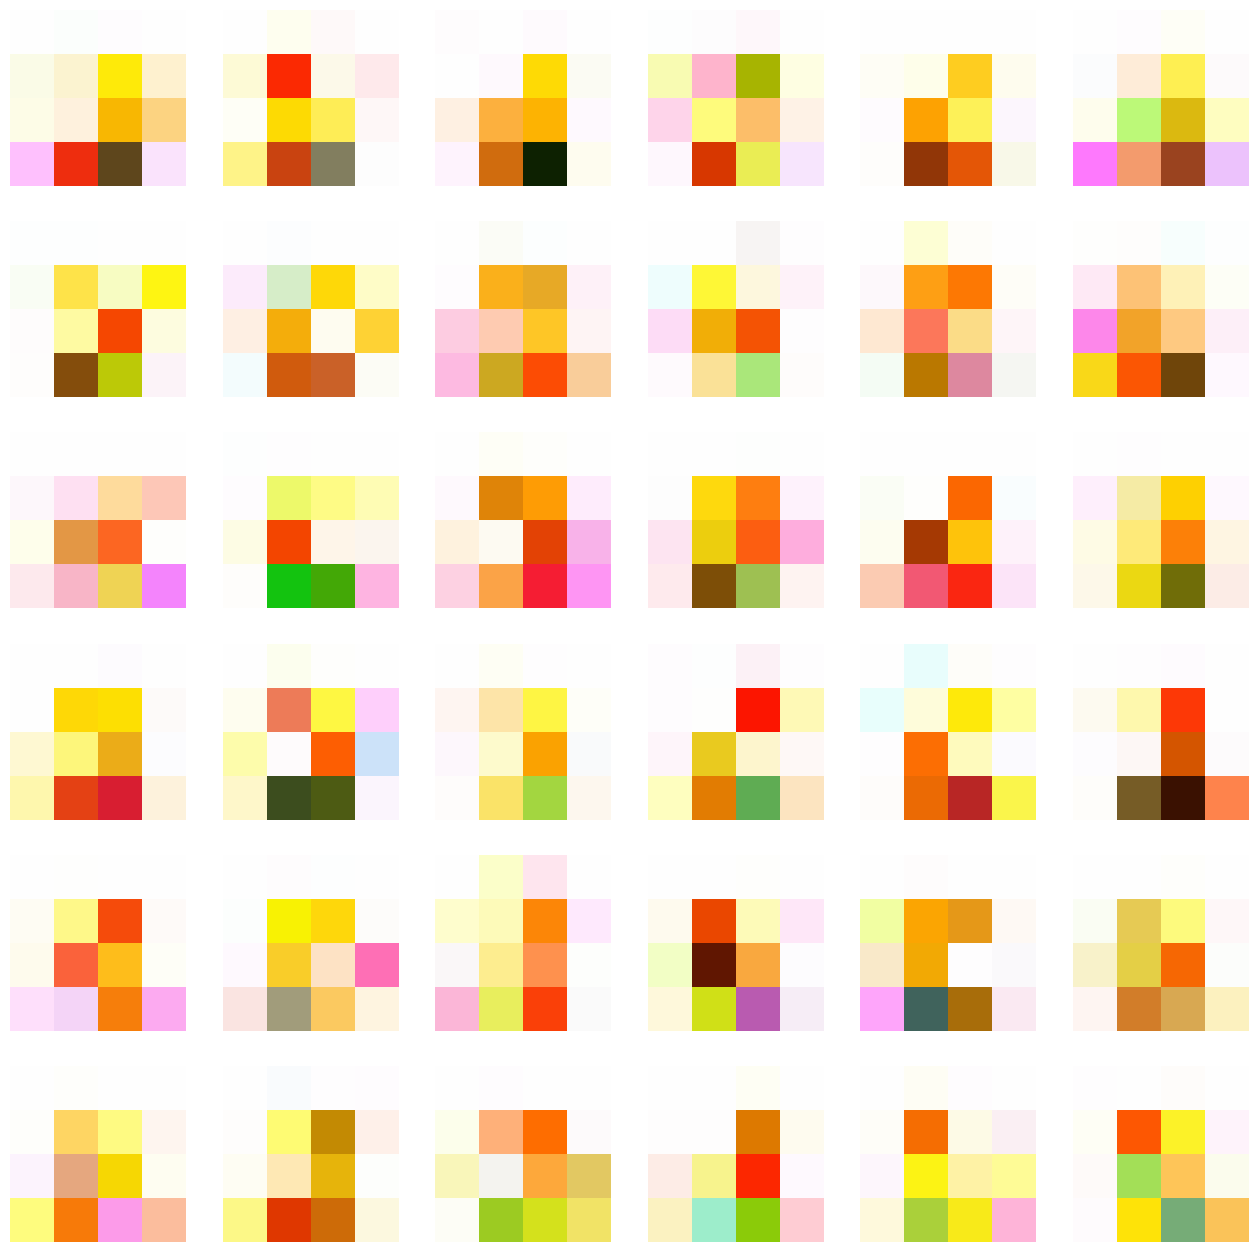

25/25 [==============================] - 15s 600ms/step - d_loss: -1.1886 - g_loss: 1.3696
Epoch 12/50
25/25 [==============================] - ETA: 0s - d_loss: -1.2100 - g_loss: 1.8164

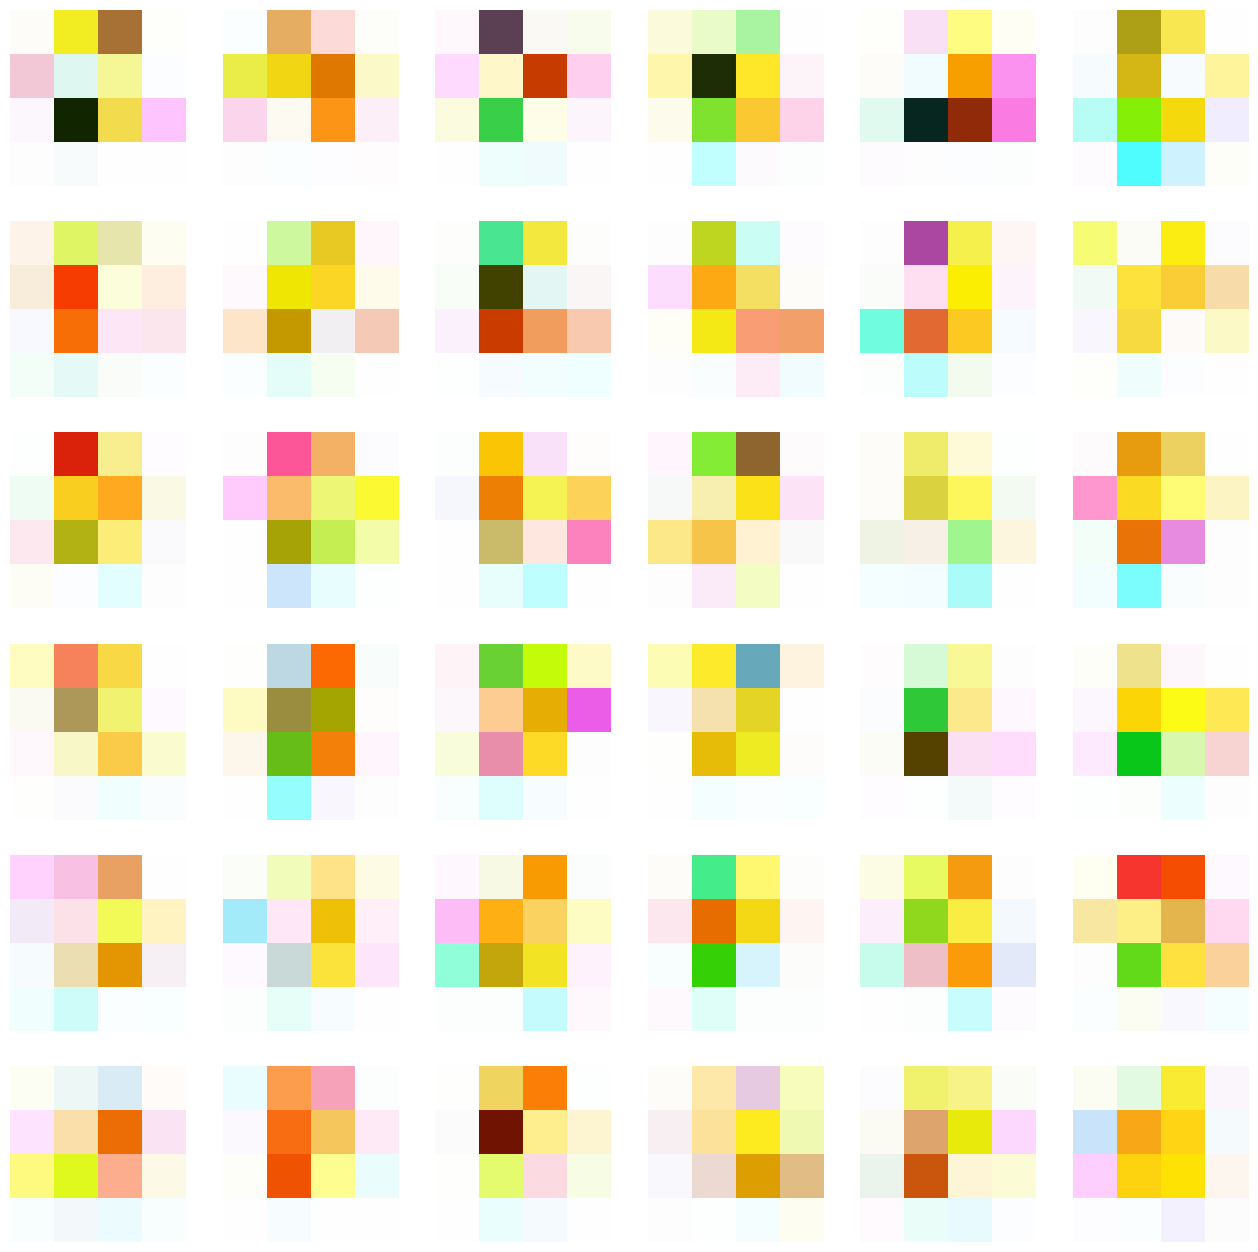

25/25 [==============================] - 15s 590ms/step - d_loss: -1.1879 - g_loss: 1.8435
Epoch 13/50
25/25 [==============================] - ETA: 0s - d_loss: -1.1355 - g_loss: 1.5482

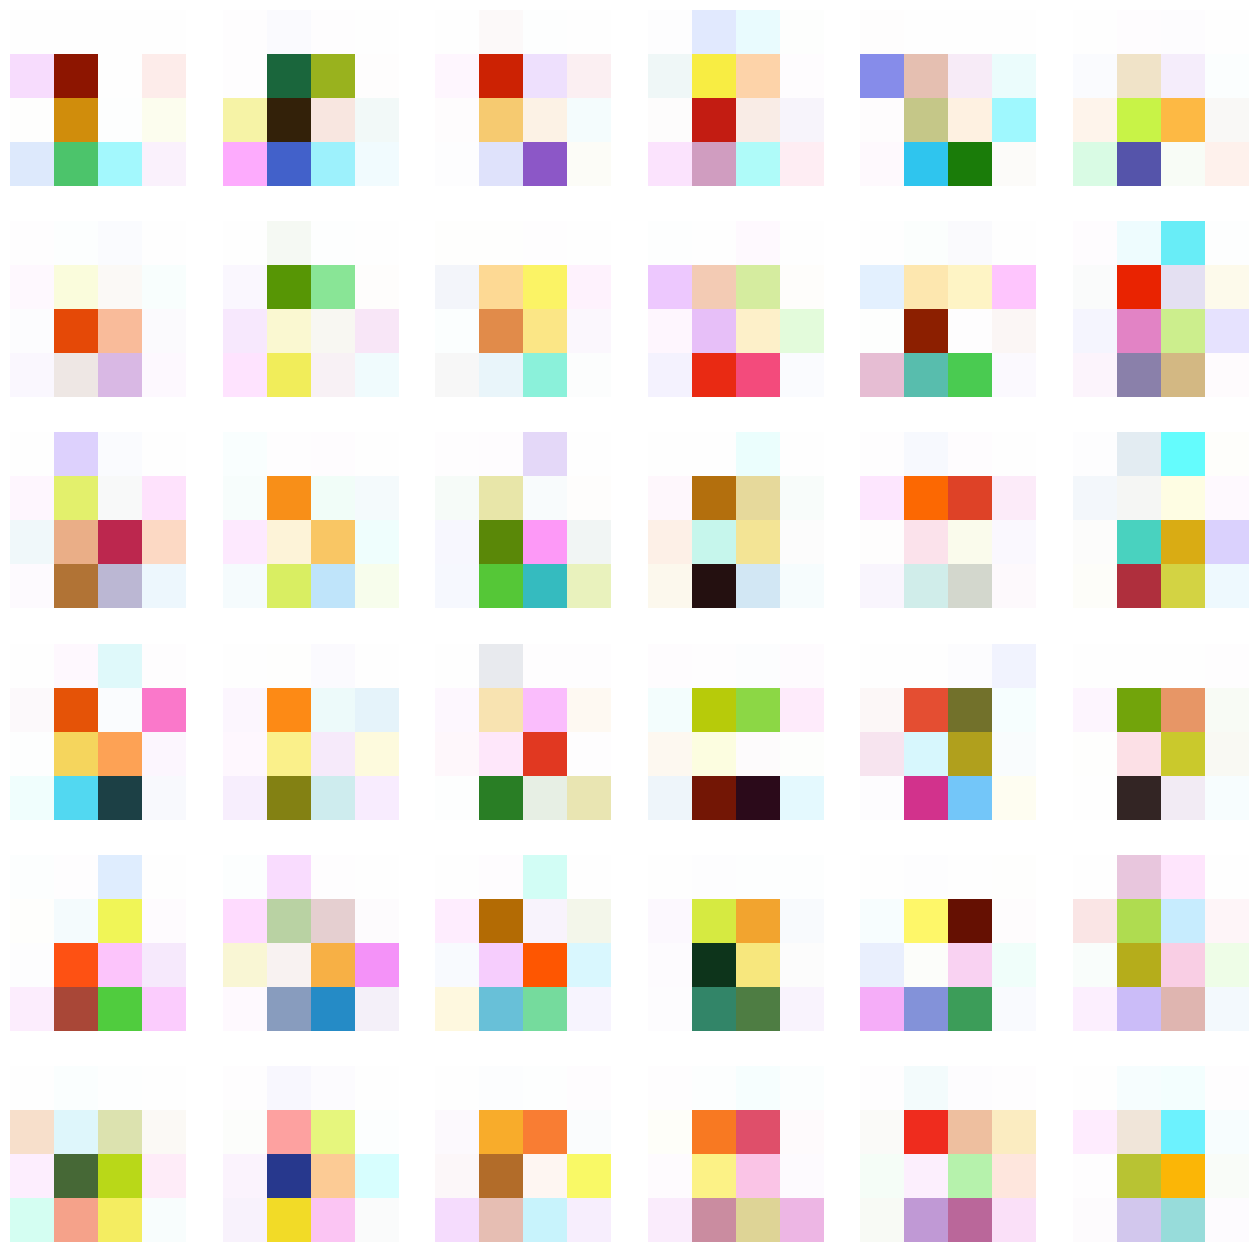

25/25 [==============================] - 16s 628ms/step - d_loss: -1.1257 - g_loss: 1.4940
Epoch 14/50
25/25 [==============================] - ETA: 0s - d_loss: -1.2948 - g_loss: 1.1565

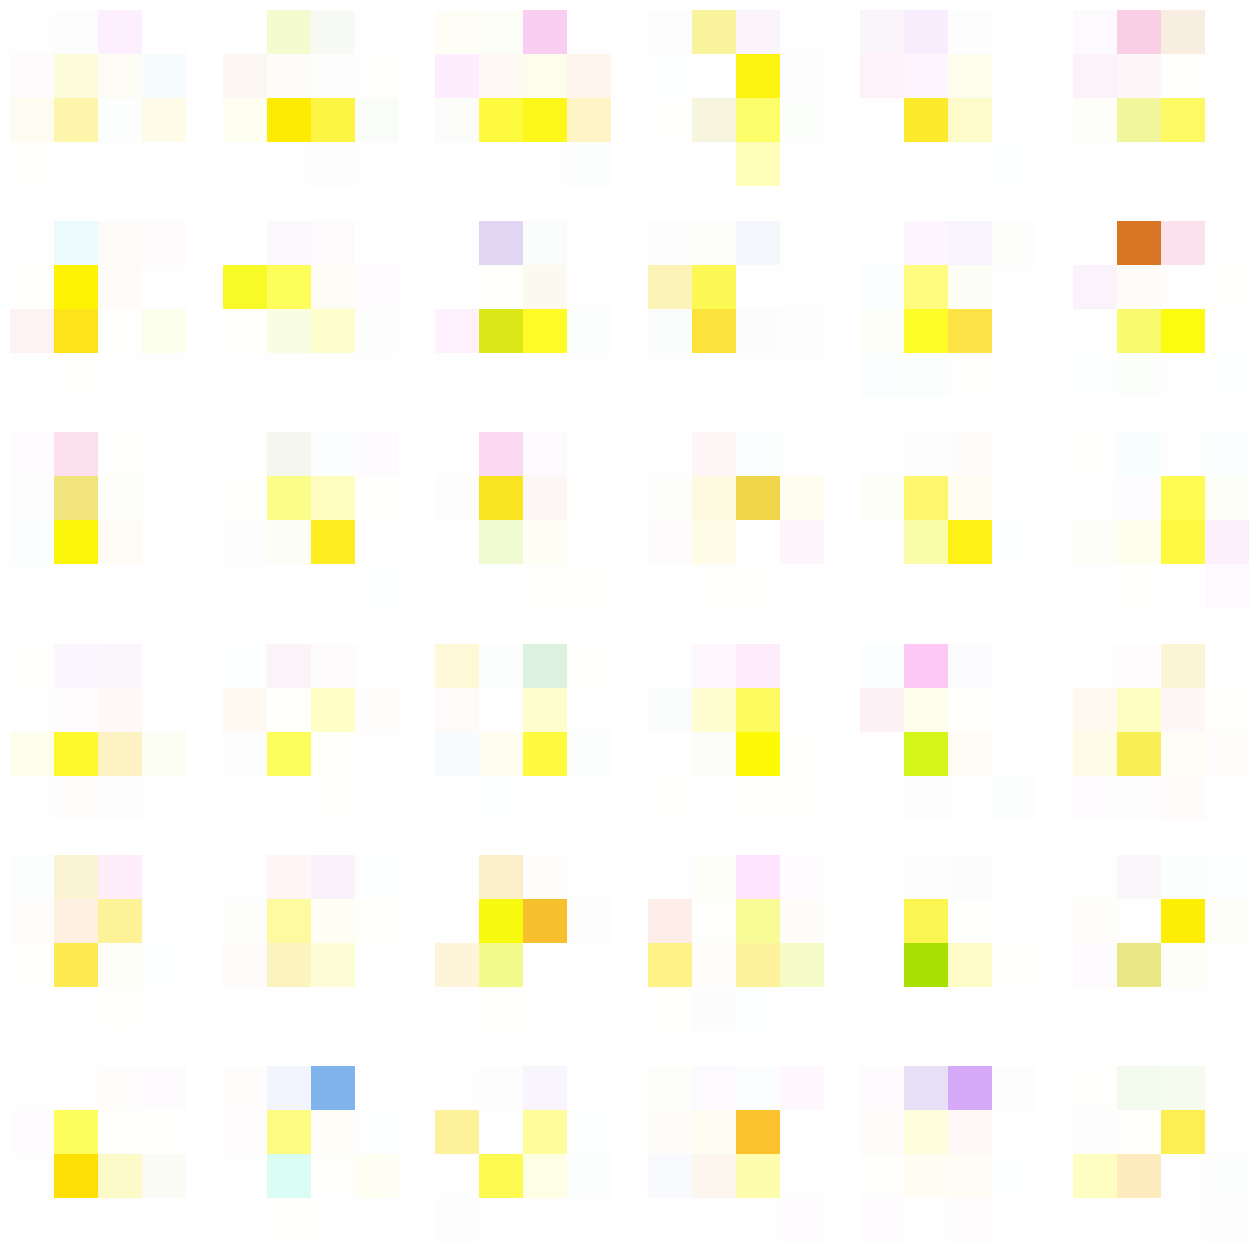

25/25 [==============================] - 15s 588ms/step - d_loss: -1.2772 - g_loss: 1.0708
Epoch 15/50
25/25 [==============================] - ETA: 0s - d_loss: -1.2184 - g_loss: 1.8884

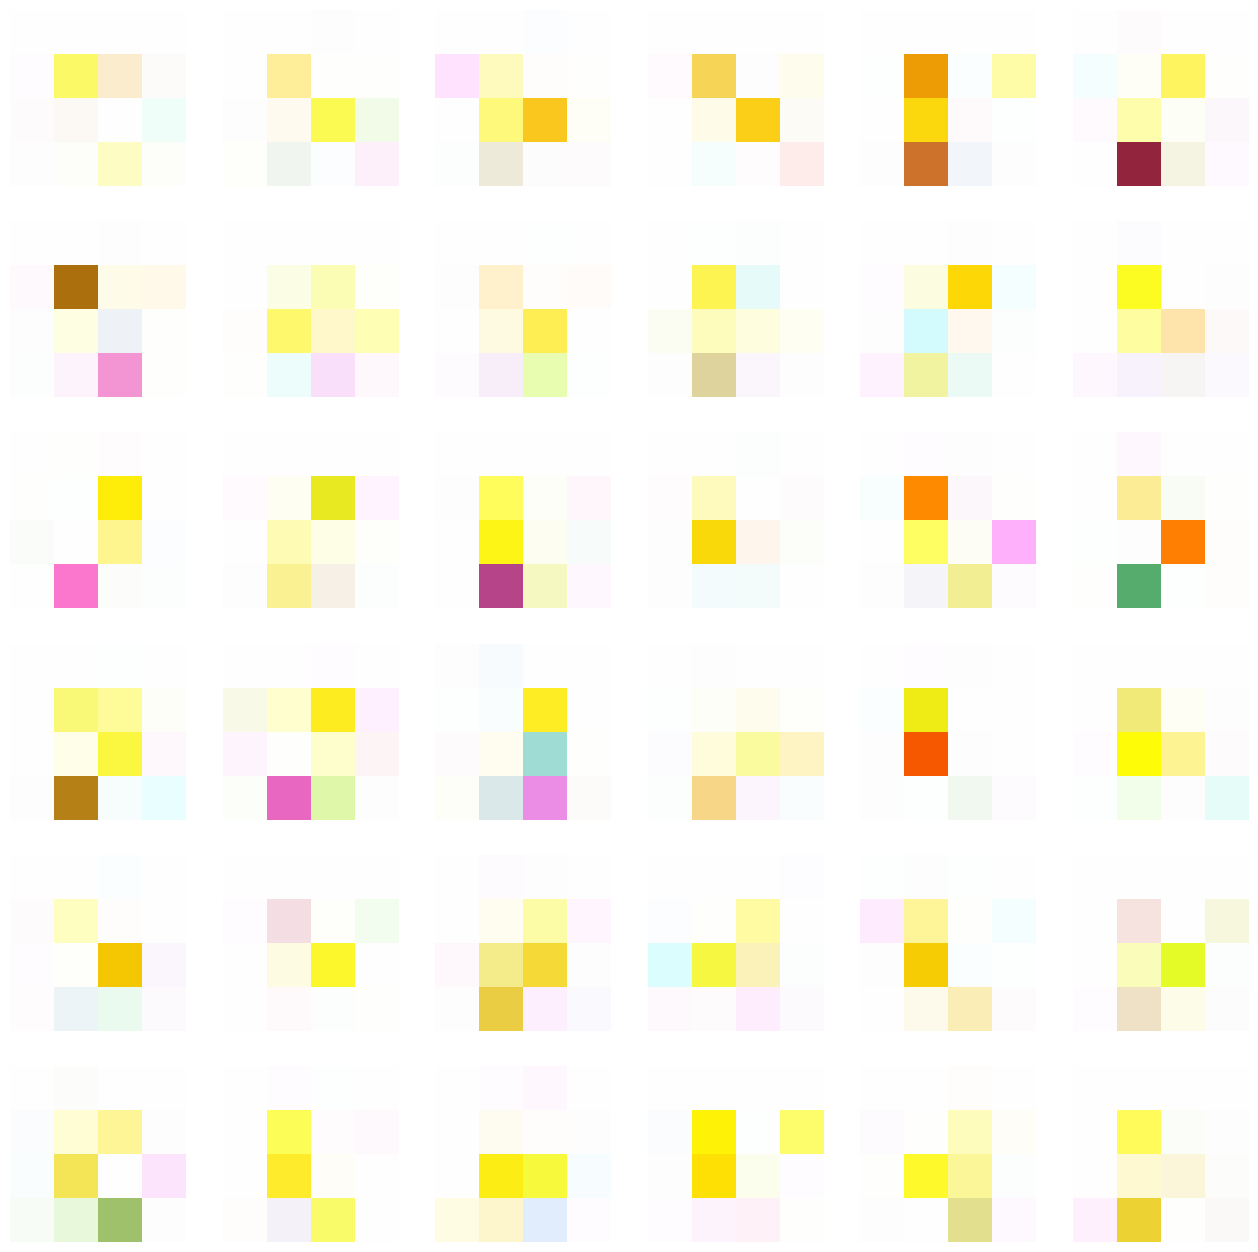

25/25 [==============================] - 15s 596ms/step - d_loss: -1.2370 - g_loss: 1.8067
Epoch 16/50
25/25 [==============================] - ETA: 0s - d_loss: -1.1979 - g_loss: 1.7671

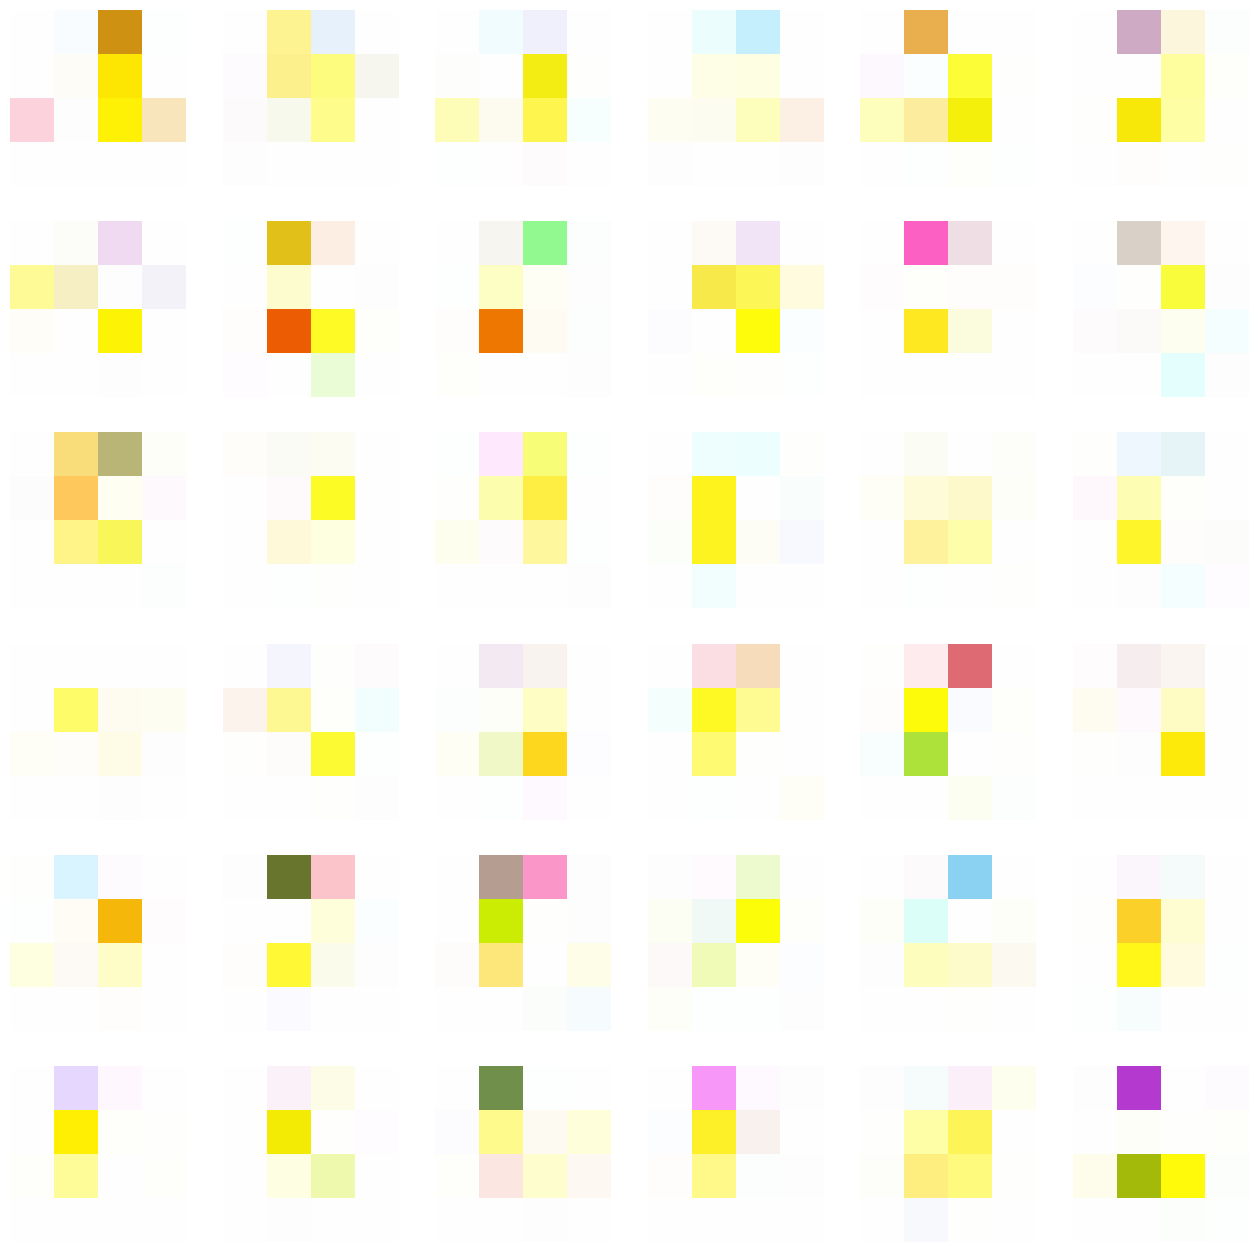

25/25 [==============================] - 15s 614ms/step - d_loss: -1.2105 - g_loss: 1.7350
Epoch 17/50
25/25 [==============================] - ETA: 0s - d_loss: -1.1713 - g_loss: 1.8041

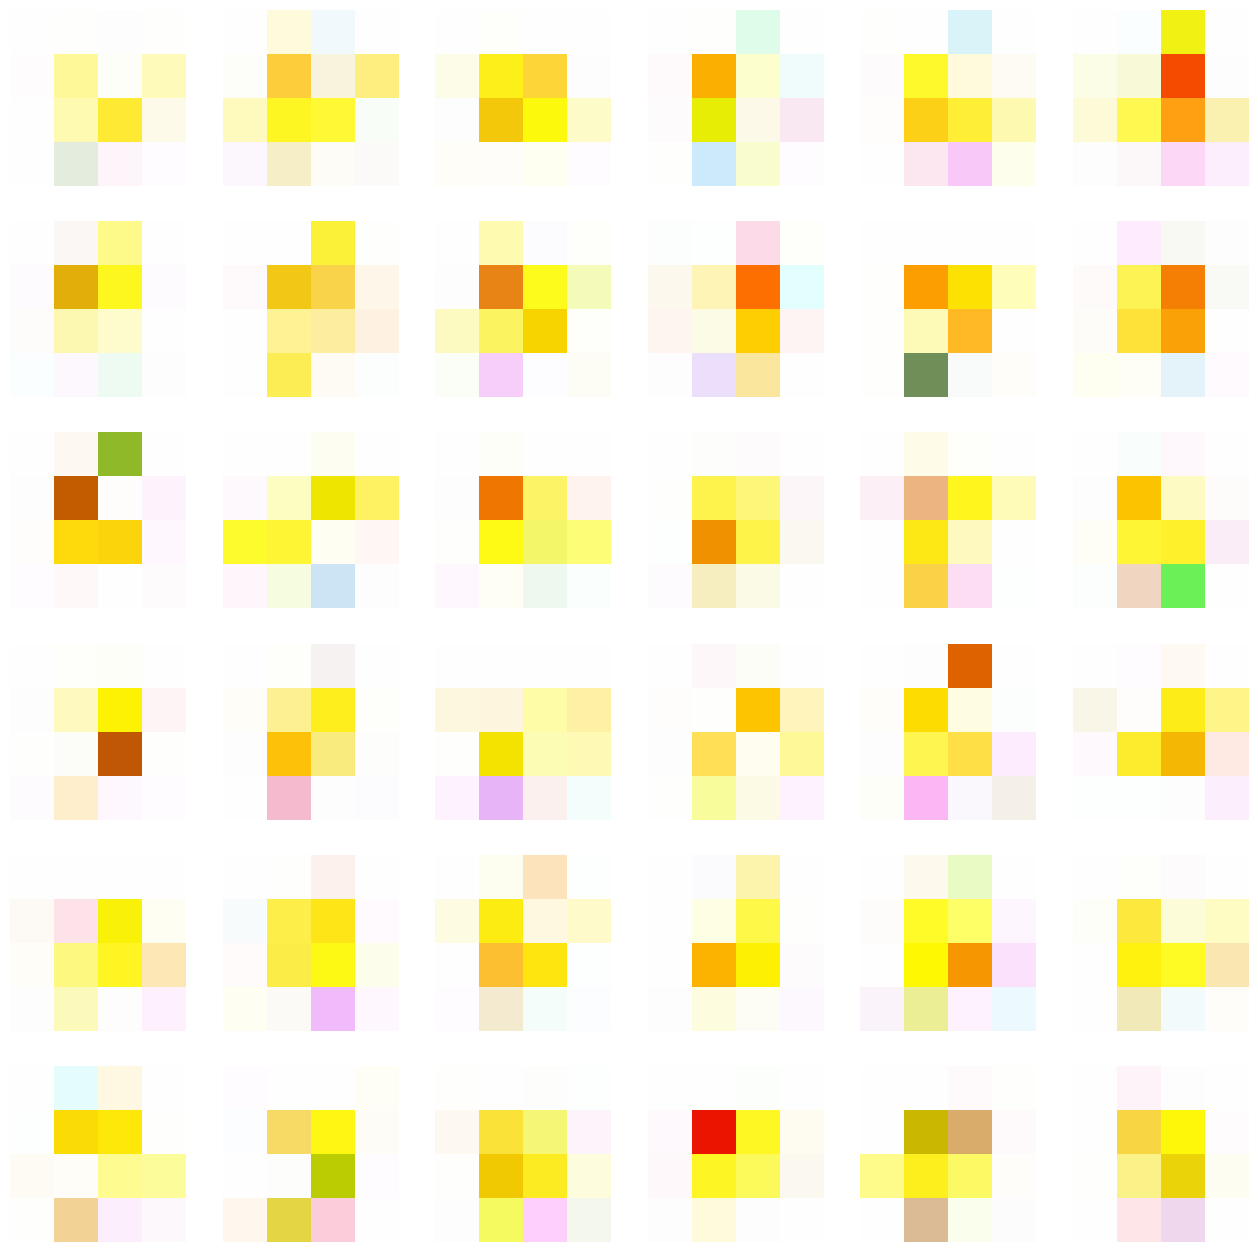

25/25 [==============================] - 16s 639ms/step - d_loss: -1.1492 - g_loss: 1.8070
Epoch 18/50
25/25 [==============================] - ETA: 0s - d_loss: -1.2033 - g_loss: 1.7489

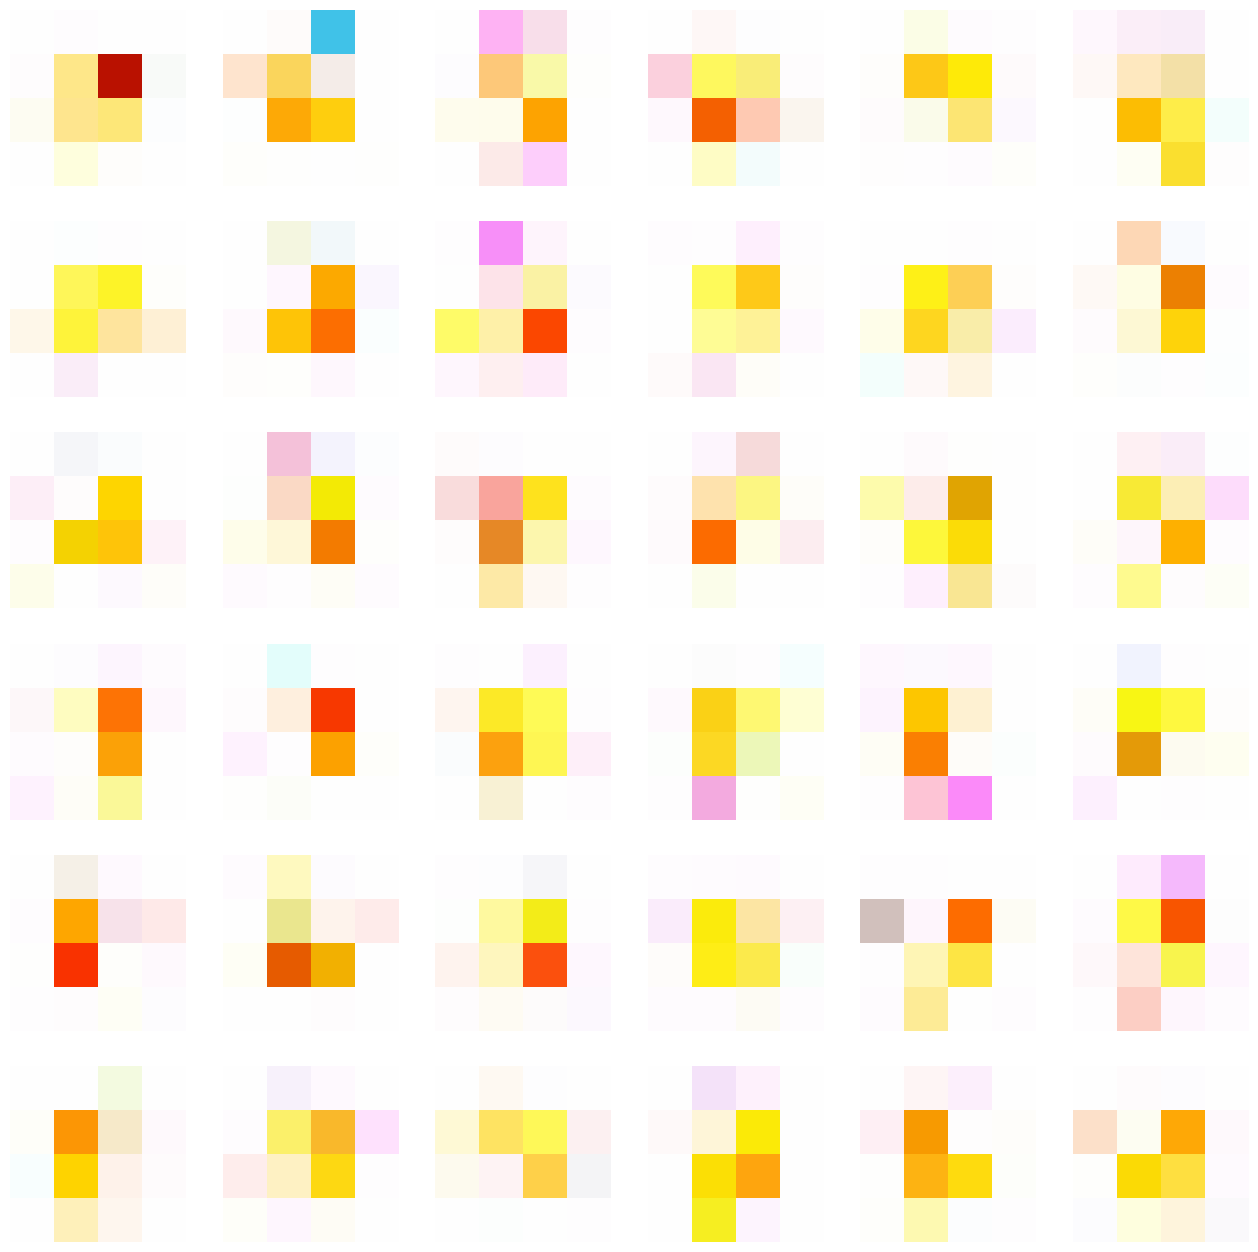

25/25 [==============================] - 15s 587ms/step - d_loss: -1.2286 - g_loss: 1.8149
Epoch 19/50
25/25 [==============================] - ETA: 0s - d_loss: -1.1339 - g_loss: 2.2535

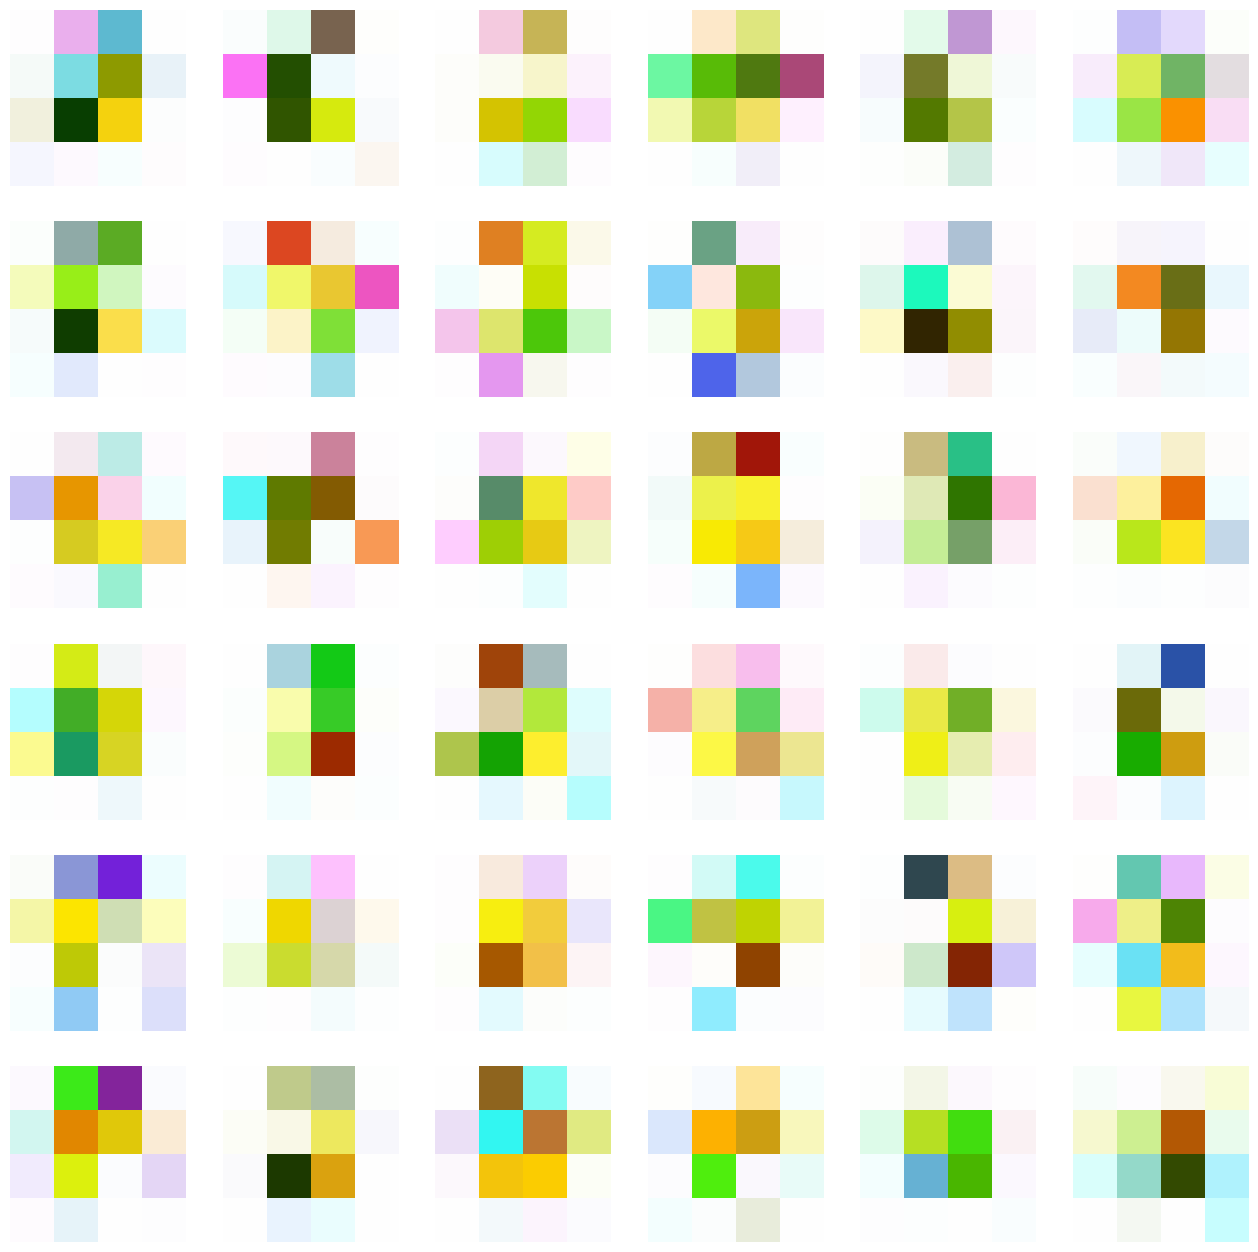

25/25 [==============================] - 15s 602ms/step - d_loss: -1.1125 - g_loss: 2.2358
Epoch 20/50
25/25 [==============================] - ETA: 0s - d_loss: -1.2115 - g_loss: 1.6616

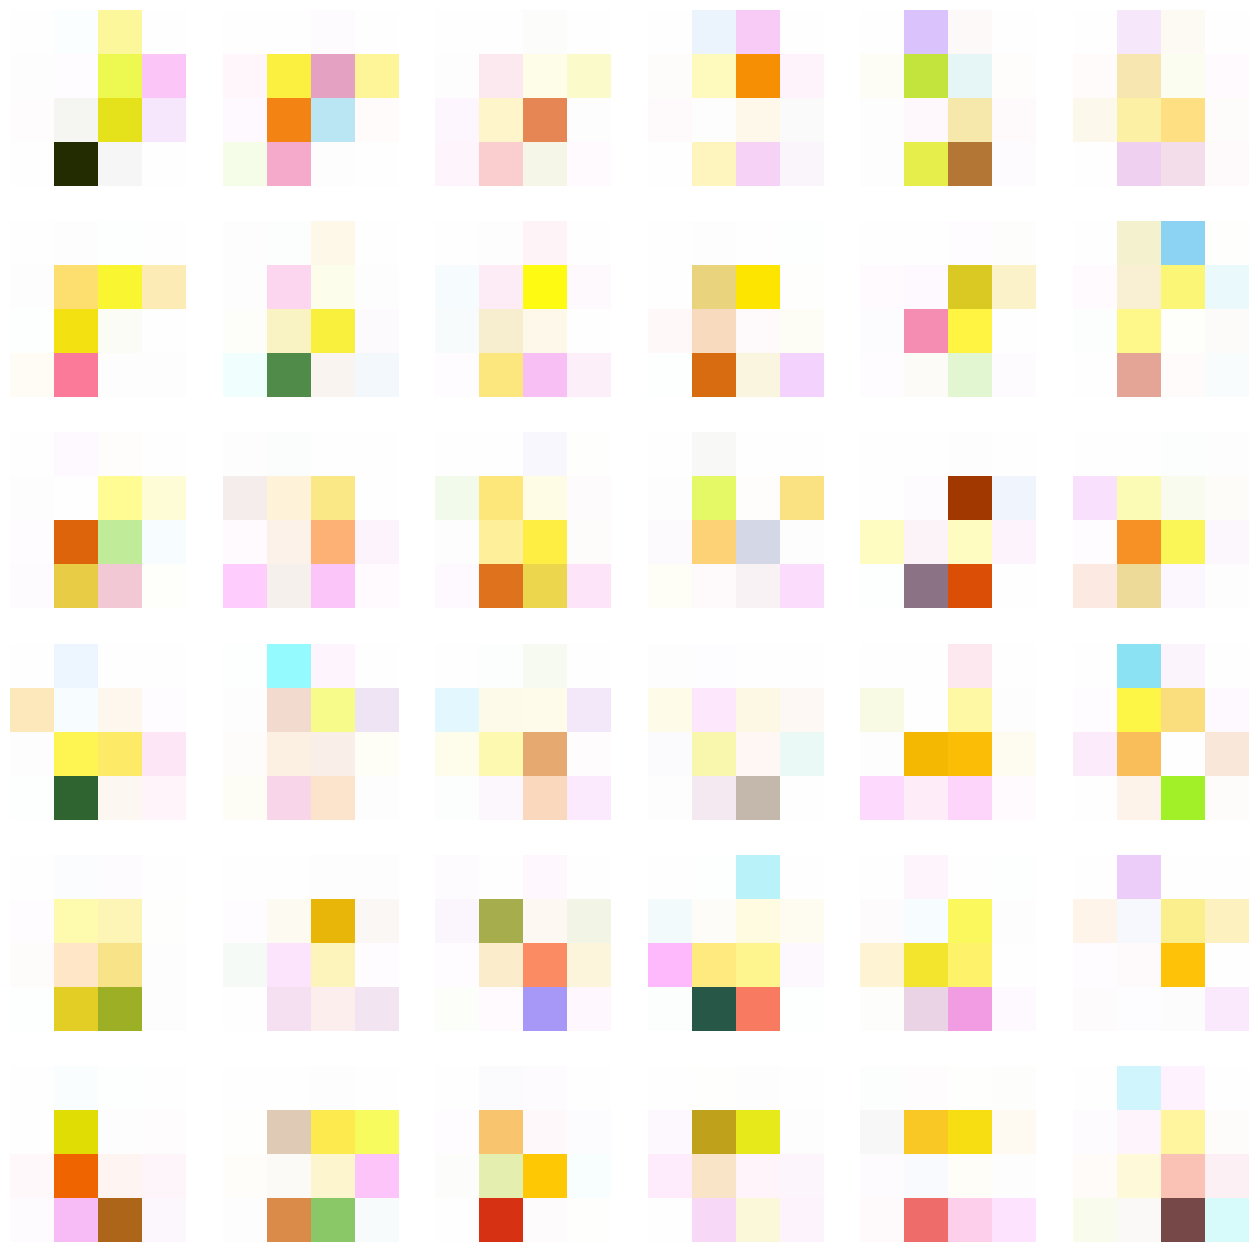

25/25 [==============================] - 15s 597ms/step - d_loss: -1.2113 - g_loss: 1.6024
Epoch 21/50
25/25 [==============================] - ETA: 0s - d_loss: -1.1929 - g_loss: 1.5105

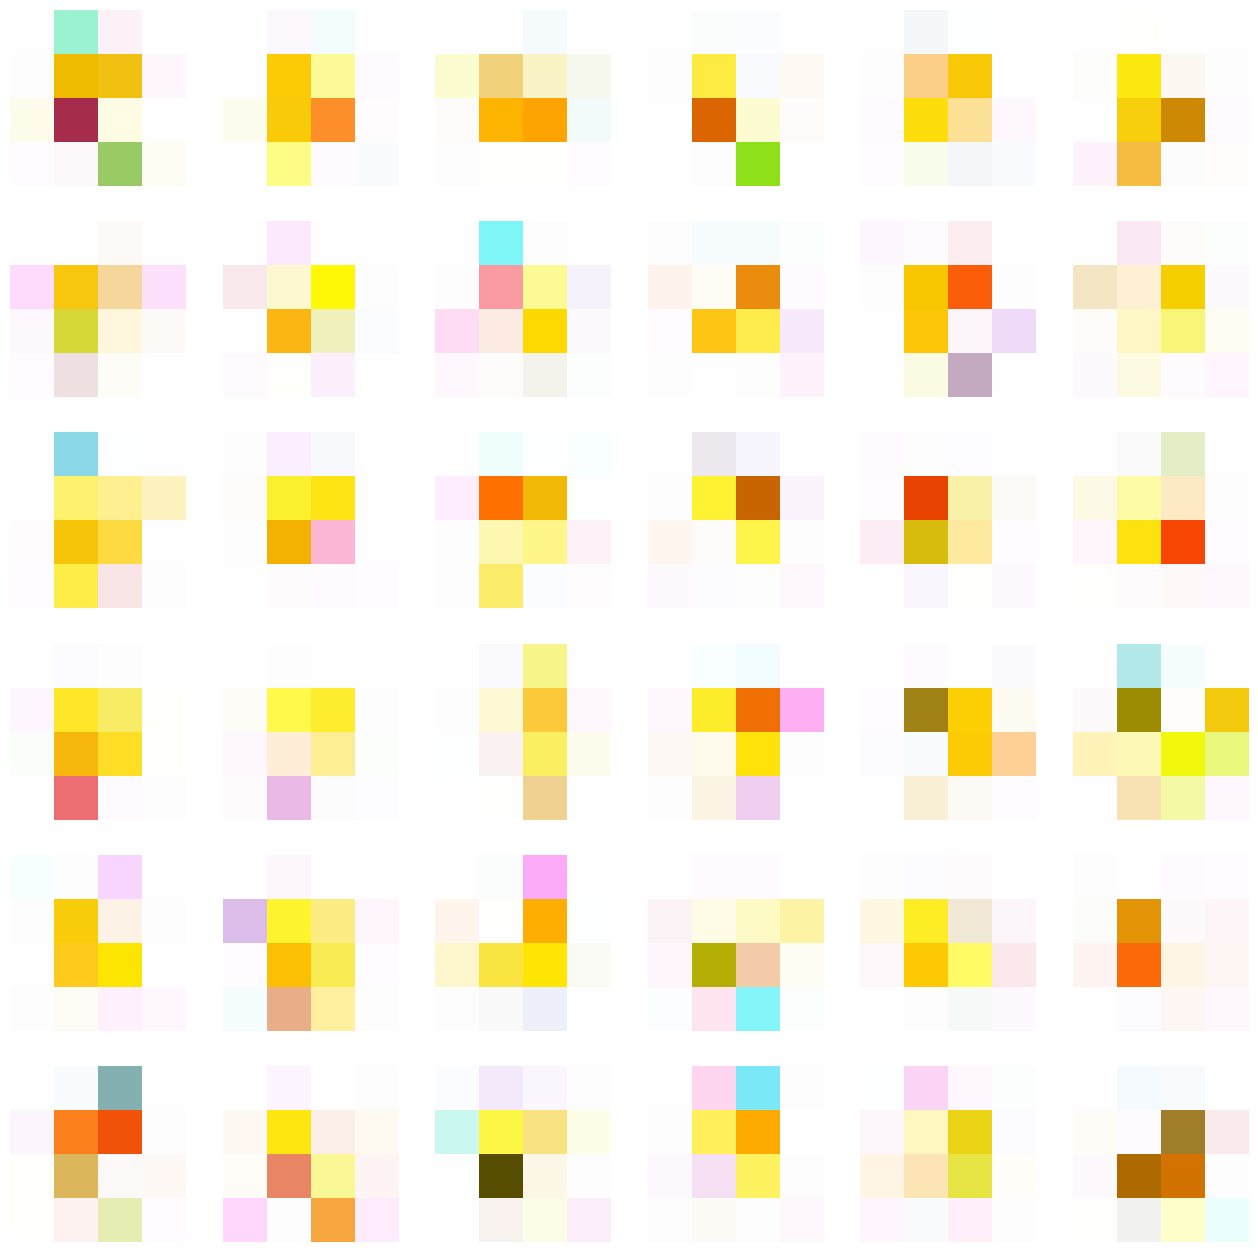

25/25 [==============================] - 16s 663ms/step - d_loss: -1.1795 - g_loss: 1.5252
Epoch 22/50
25/25 [==============================] - ETA: 0s - d_loss: -1.1938 - g_loss: 1.5769

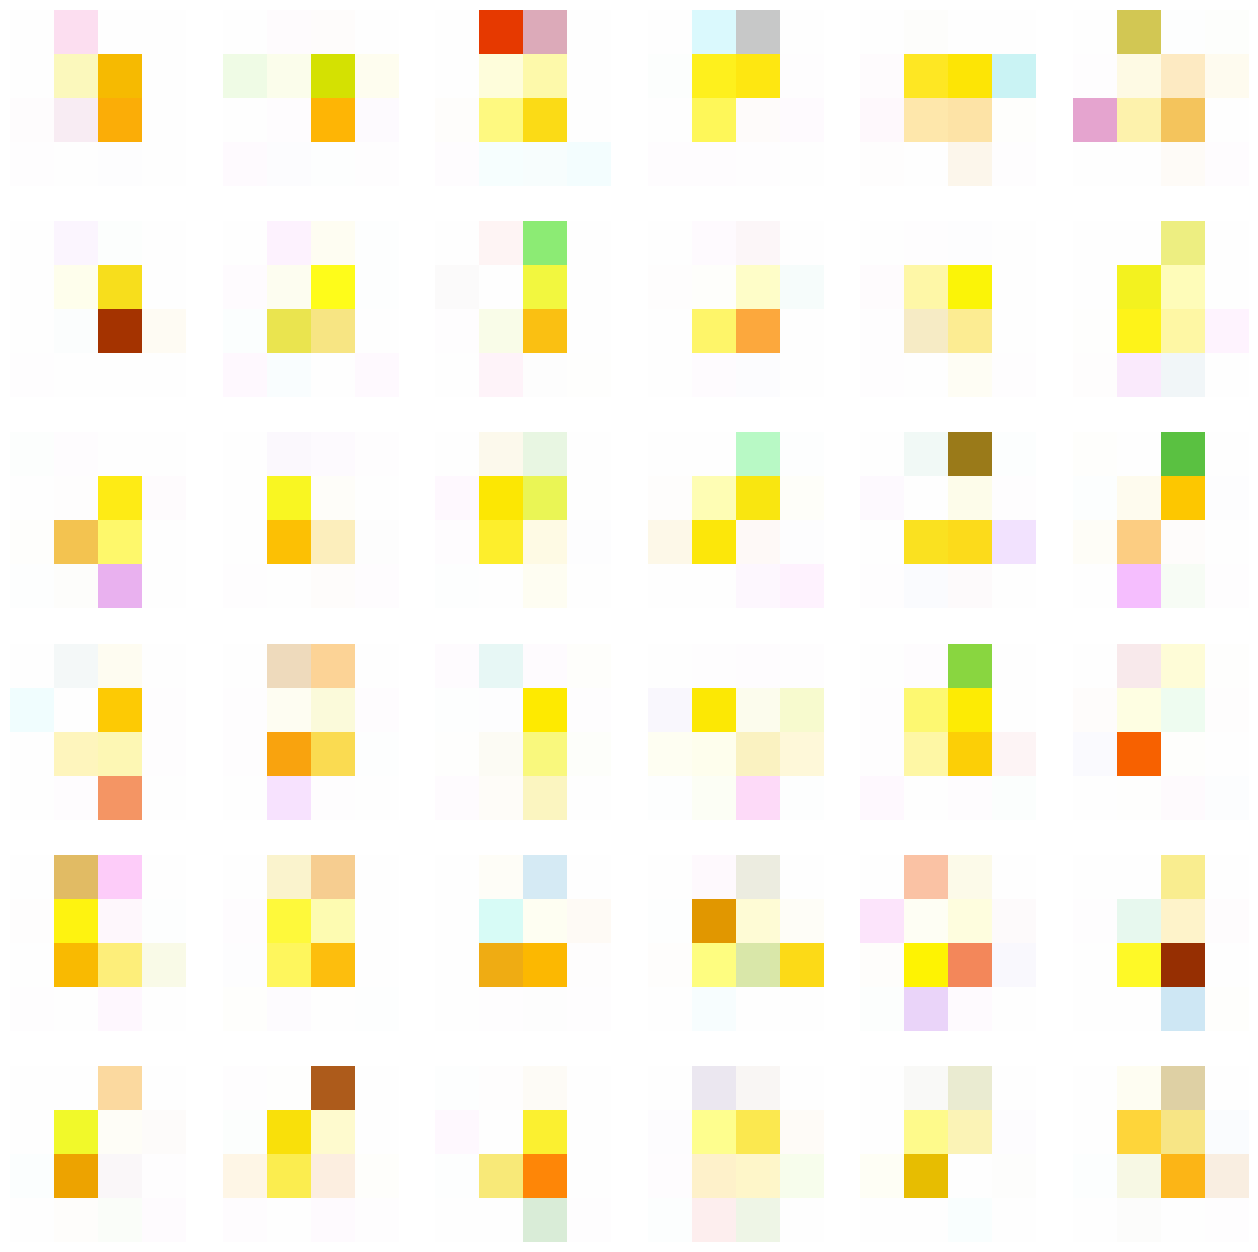

25/25 [==============================] - 15s 605ms/step - d_loss: -1.1822 - g_loss: 1.5682
Epoch 23/50
25/25 [==============================] - ETA: 0s - d_loss: -1.1168 - g_loss: 2.1727

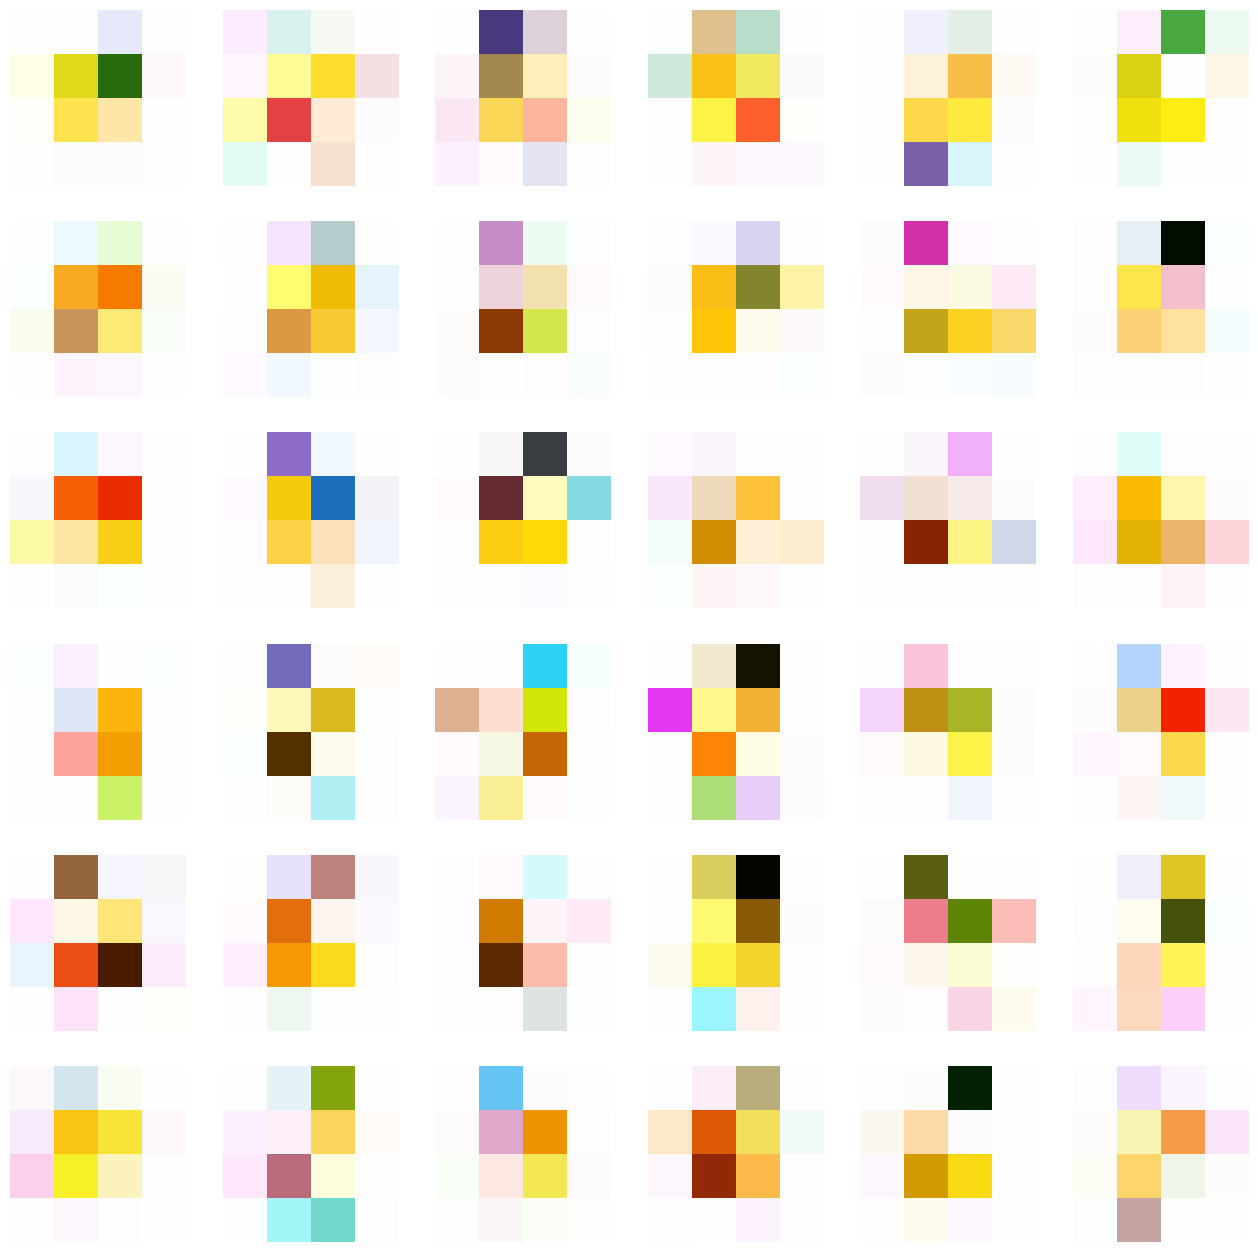

25/25 [==============================] - 15s 602ms/step - d_loss: -1.1401 - g_loss: 2.1943
Epoch 24/50
25/25 [==============================] - ETA: 0s - d_loss: -1.1023 - g_loss: 1.6574

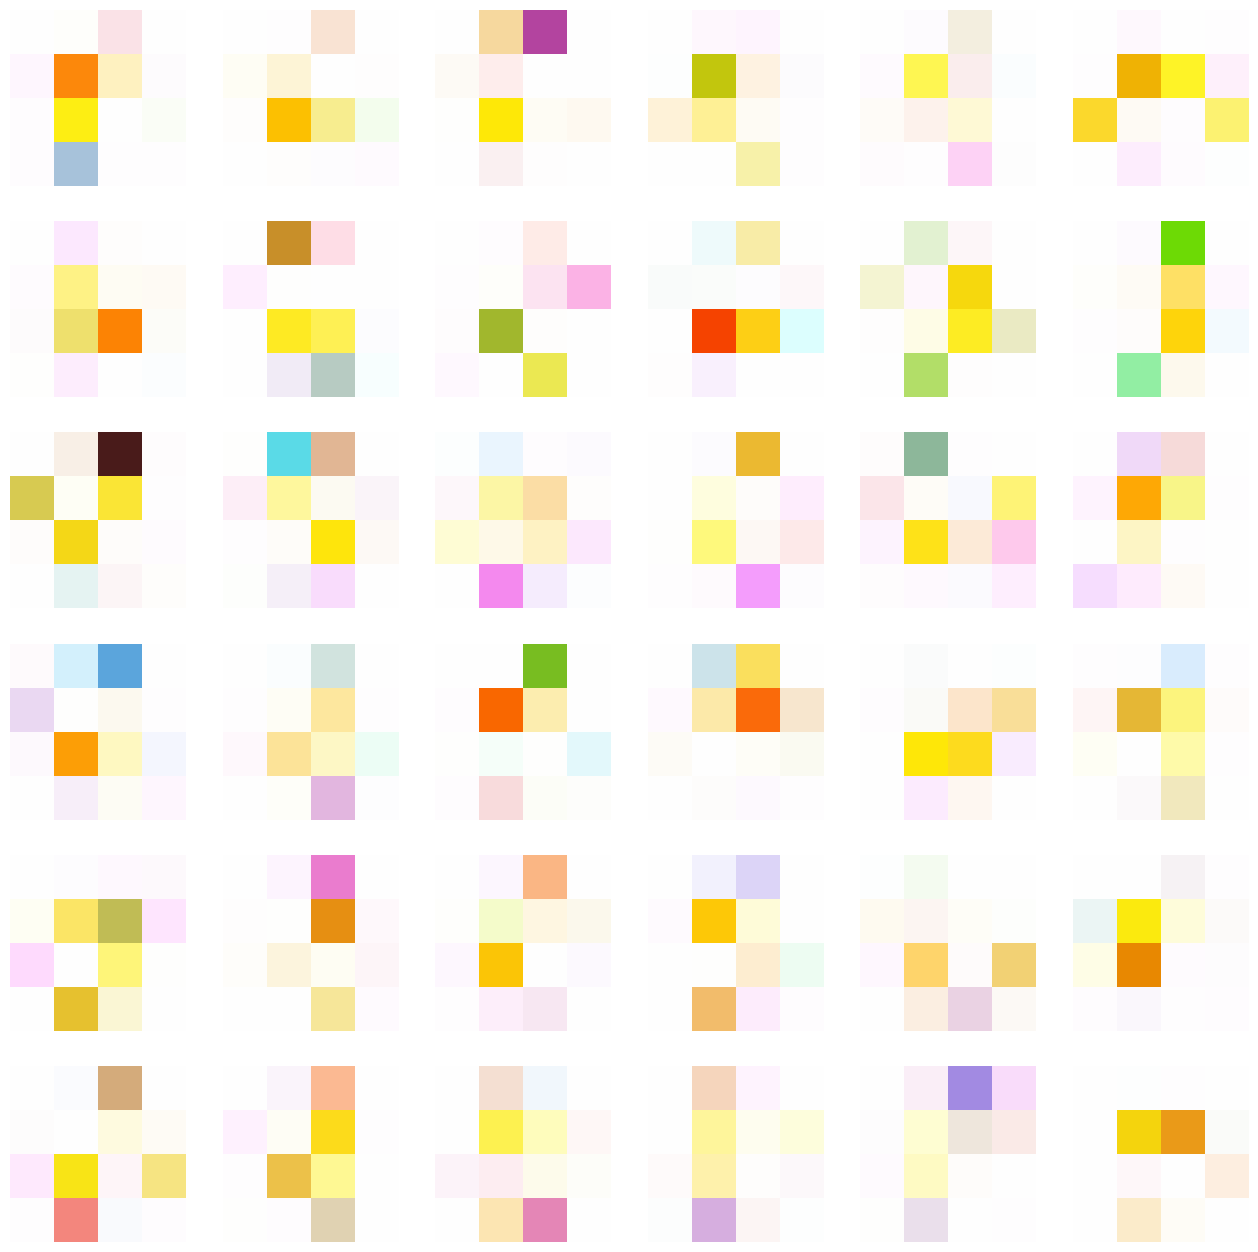

25/25 [==============================] - 15s 587ms/step - d_loss: -1.0872 - g_loss: 1.6358
Epoch 25/50
25/25 [==============================] - ETA: 0s - d_loss: -1.1839 - g_loss: 1.6372

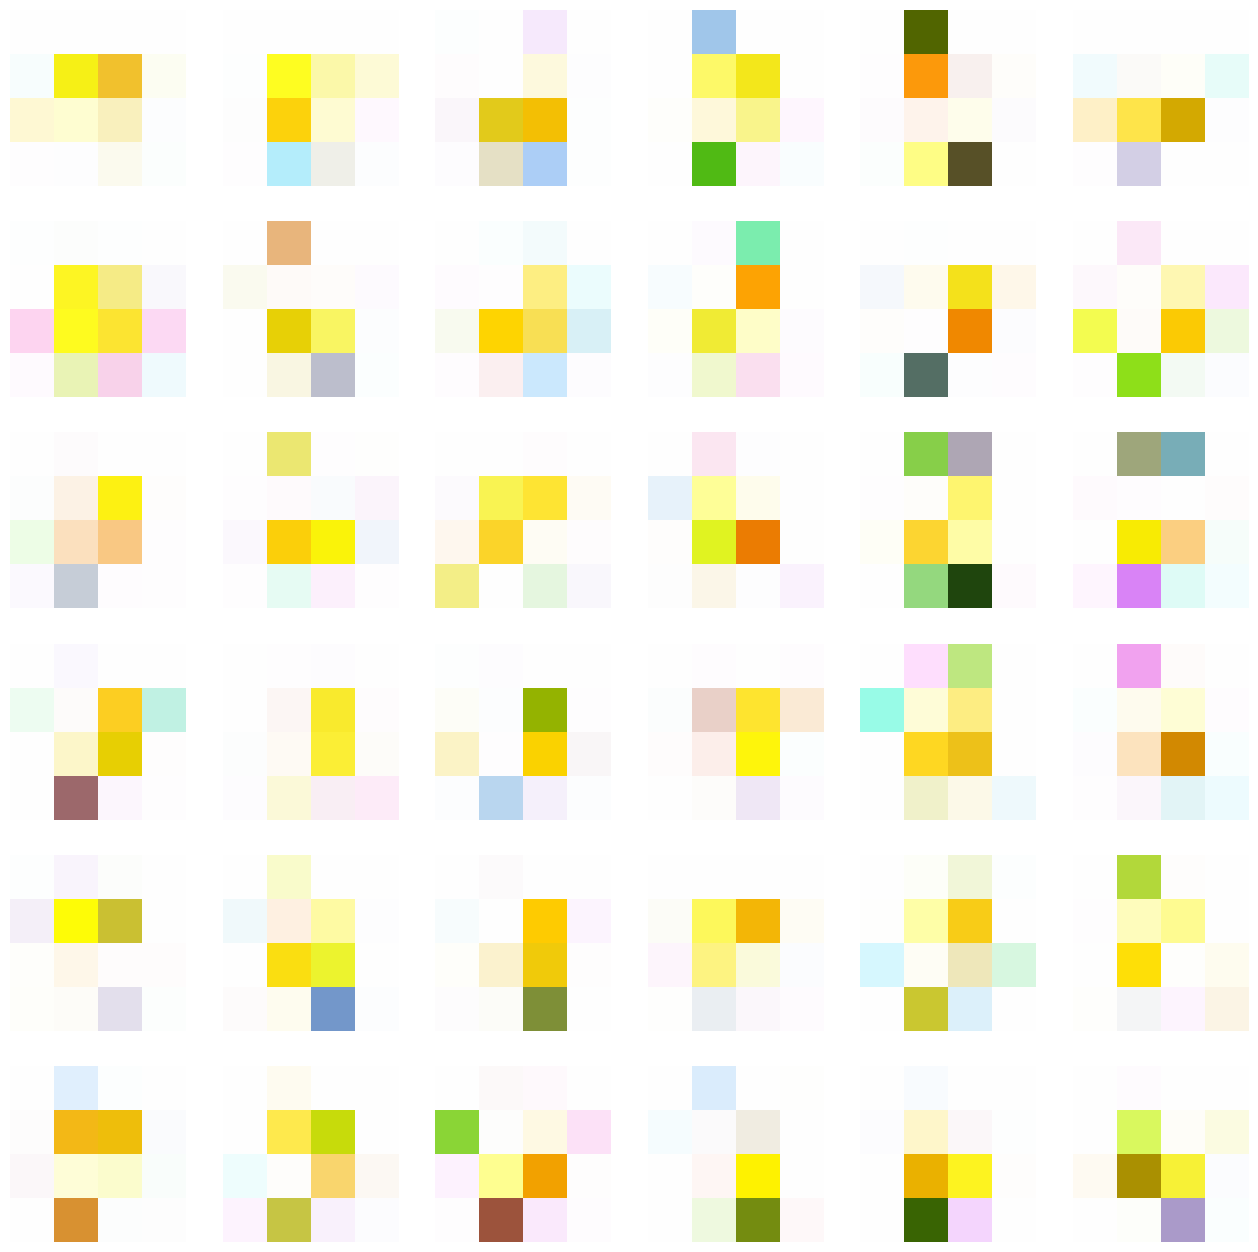

25/25 [==============================] - 16s 631ms/step - d_loss: -1.1860 - g_loss: 1.6279
Epoch 26/50
25/25 [==============================] - ETA: 0s - d_loss: -1.1408 - g_loss: 1.9250

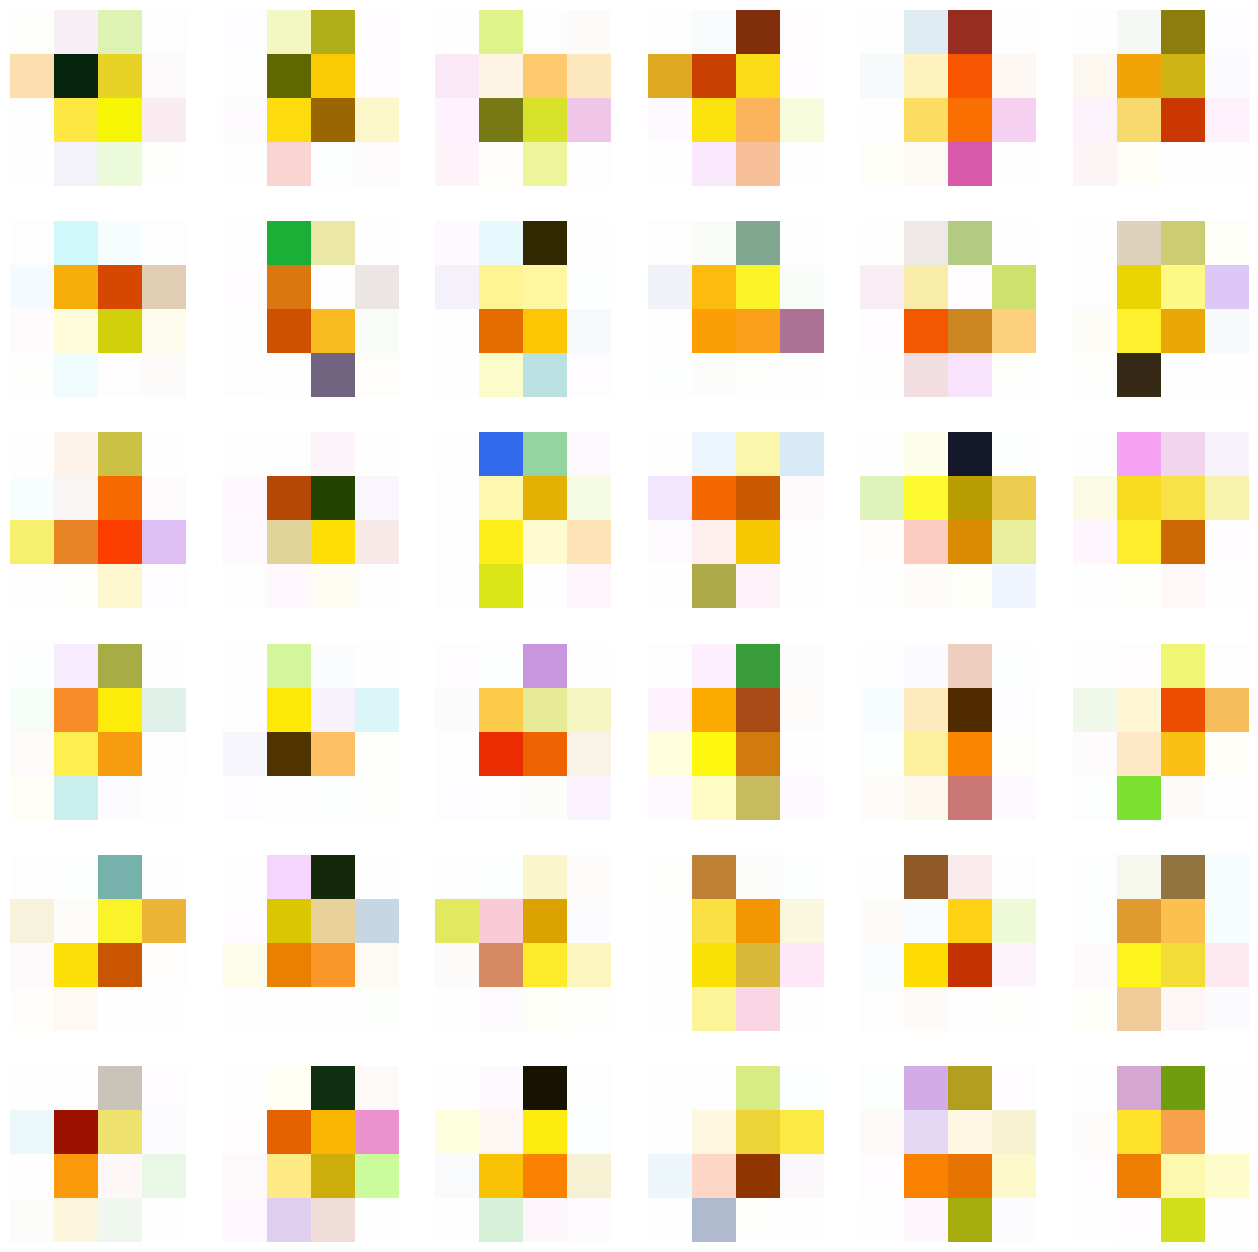

25/25 [==============================] - 15s 587ms/step - d_loss: -1.1478 - g_loss: 1.9637
Epoch 27/50
25/25 [==============================] - ETA: 0s - d_loss: -1.0664 - g_loss: 1.8660

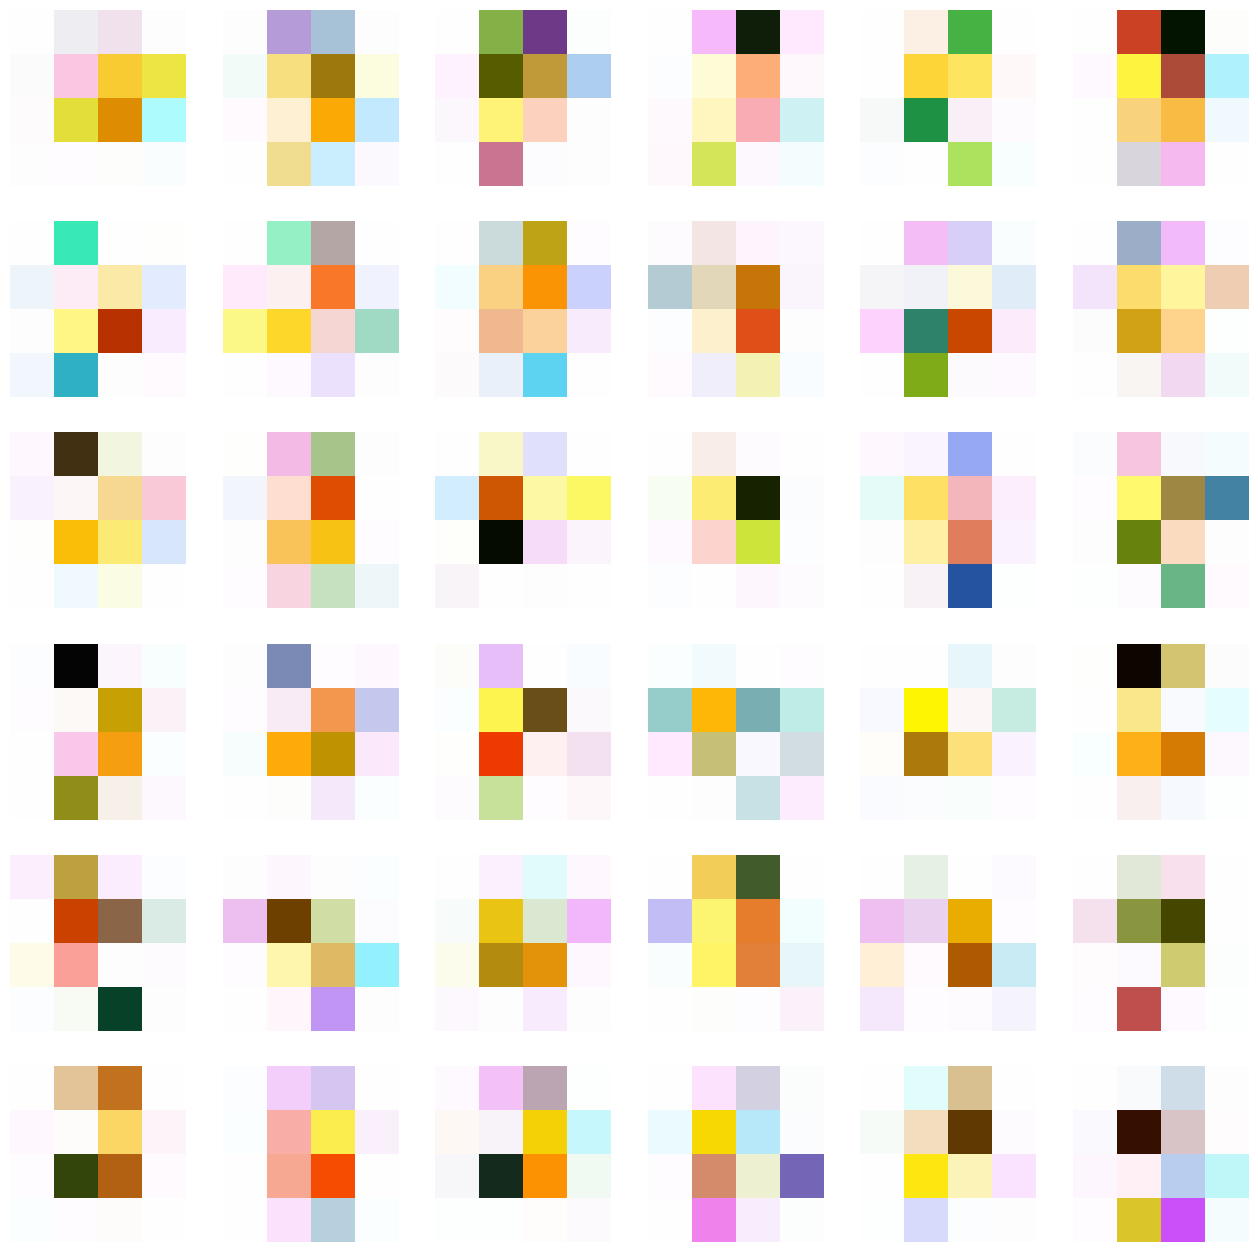

25/25 [==============================] - 15s 589ms/step - d_loss: -1.0686 - g_loss: 1.8655
Epoch 28/50
25/25 [==============================] - ETA: 0s - d_loss: -1.0683 - g_loss: 1.8158

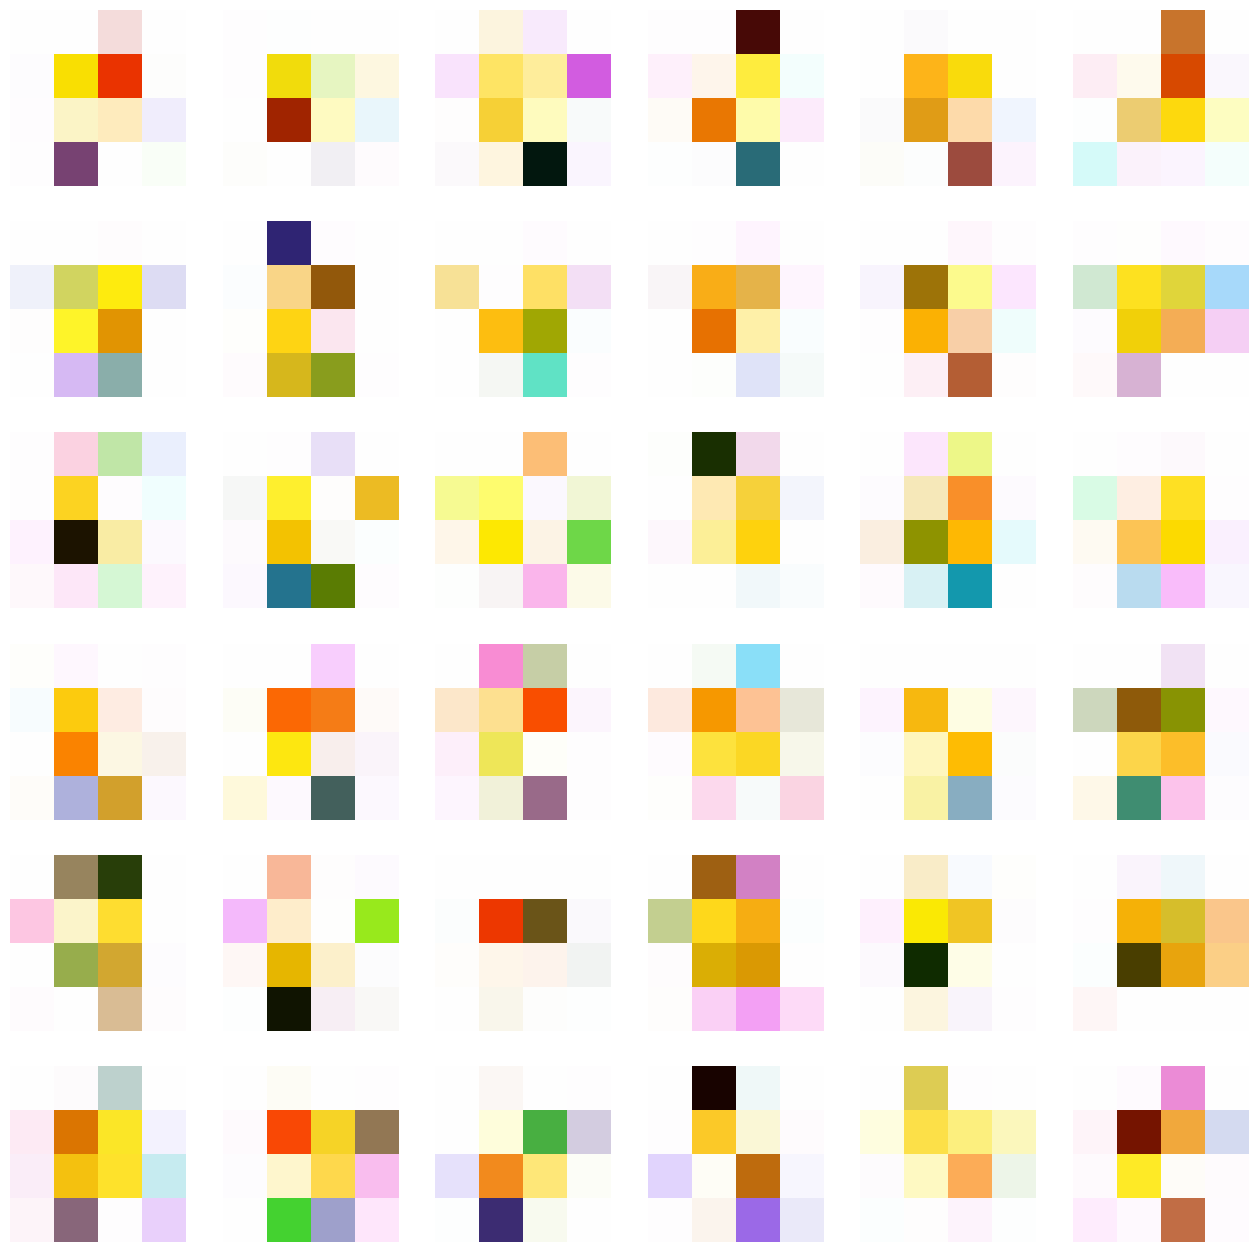

25/25 [==============================] - 15s 588ms/step - d_loss: -1.0649 - g_loss: 1.8121
Epoch 29/50
25/25 [==============================] - ETA: 0s - d_loss: -1.0537 - g_loss: 1.4589

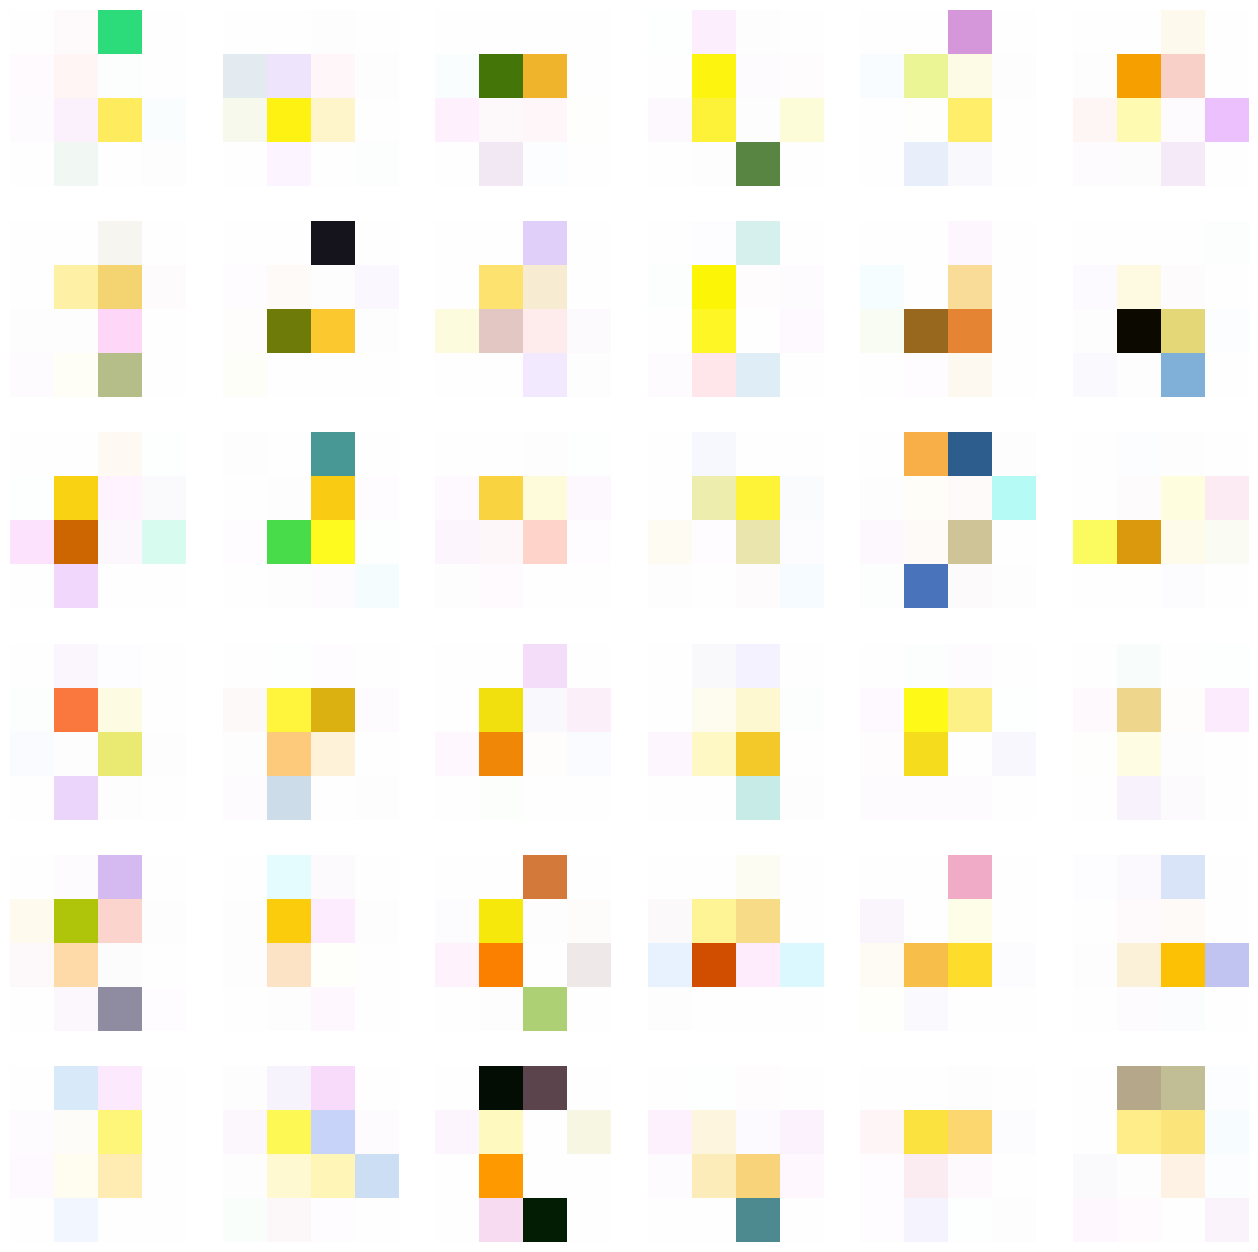

25/25 [==============================] - 16s 639ms/step - d_loss: -1.0585 - g_loss: 1.4684
Epoch 30/50
25/25 [==============================] - ETA: 0s - d_loss: -1.0289 - g_loss: 1.8074

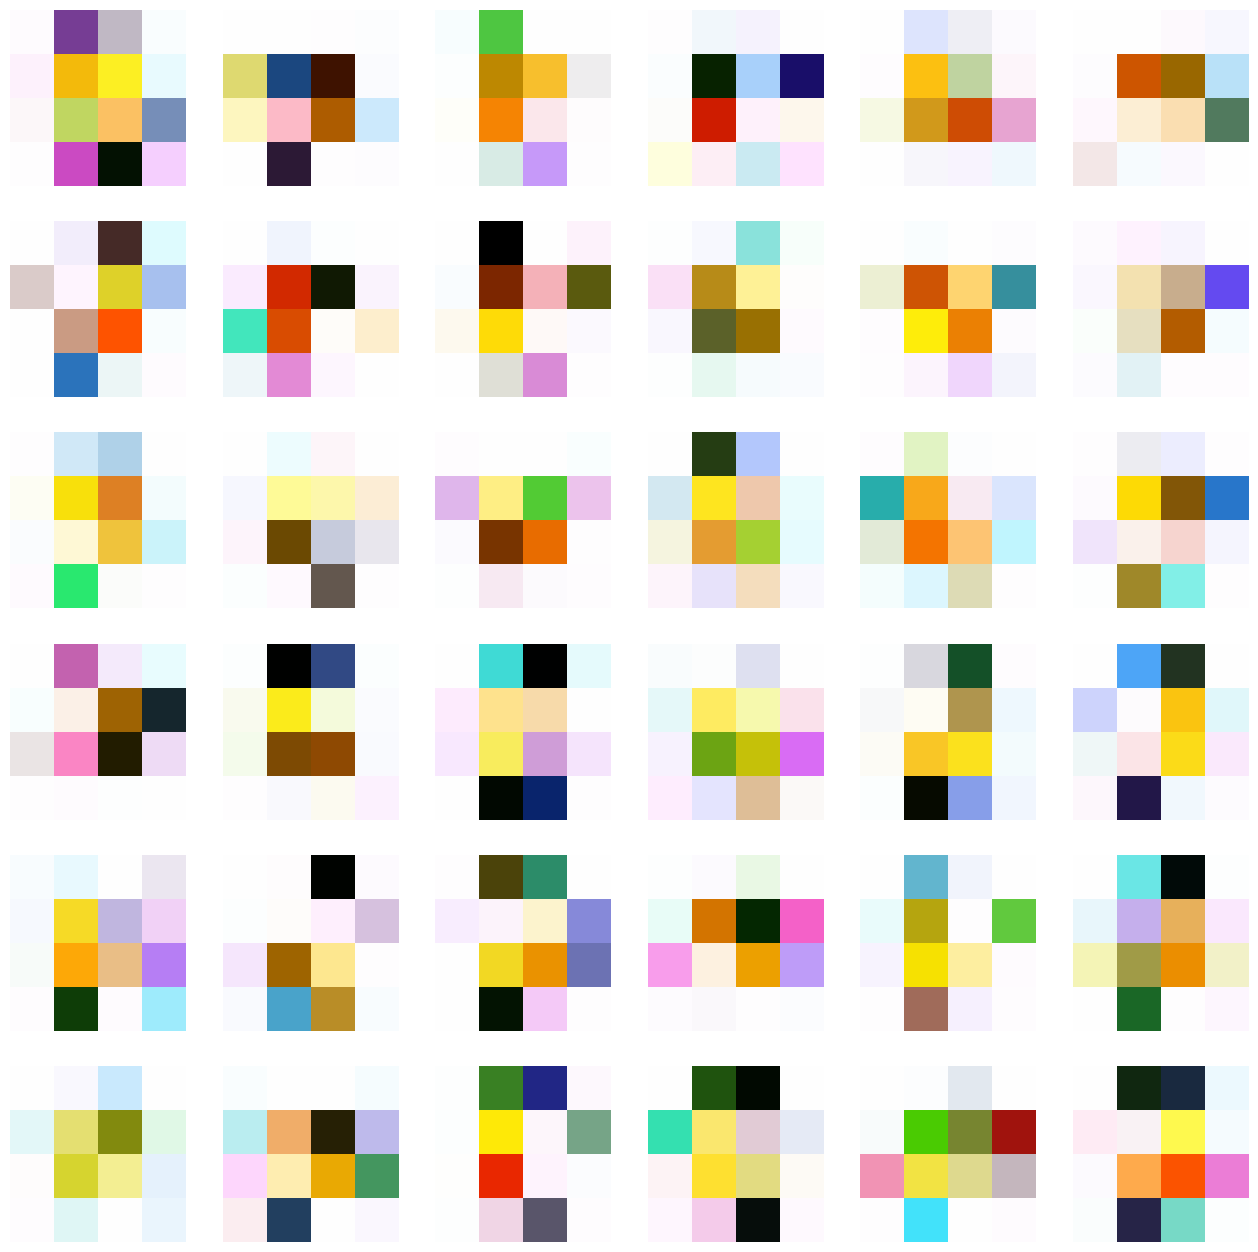

25/25 [==============================] - 15s 589ms/step - d_loss: -1.0160 - g_loss: 1.7948
Epoch 31/50
25/25 [==============================] - ETA: 0s - d_loss: -1.0693 - g_loss: 2.0504

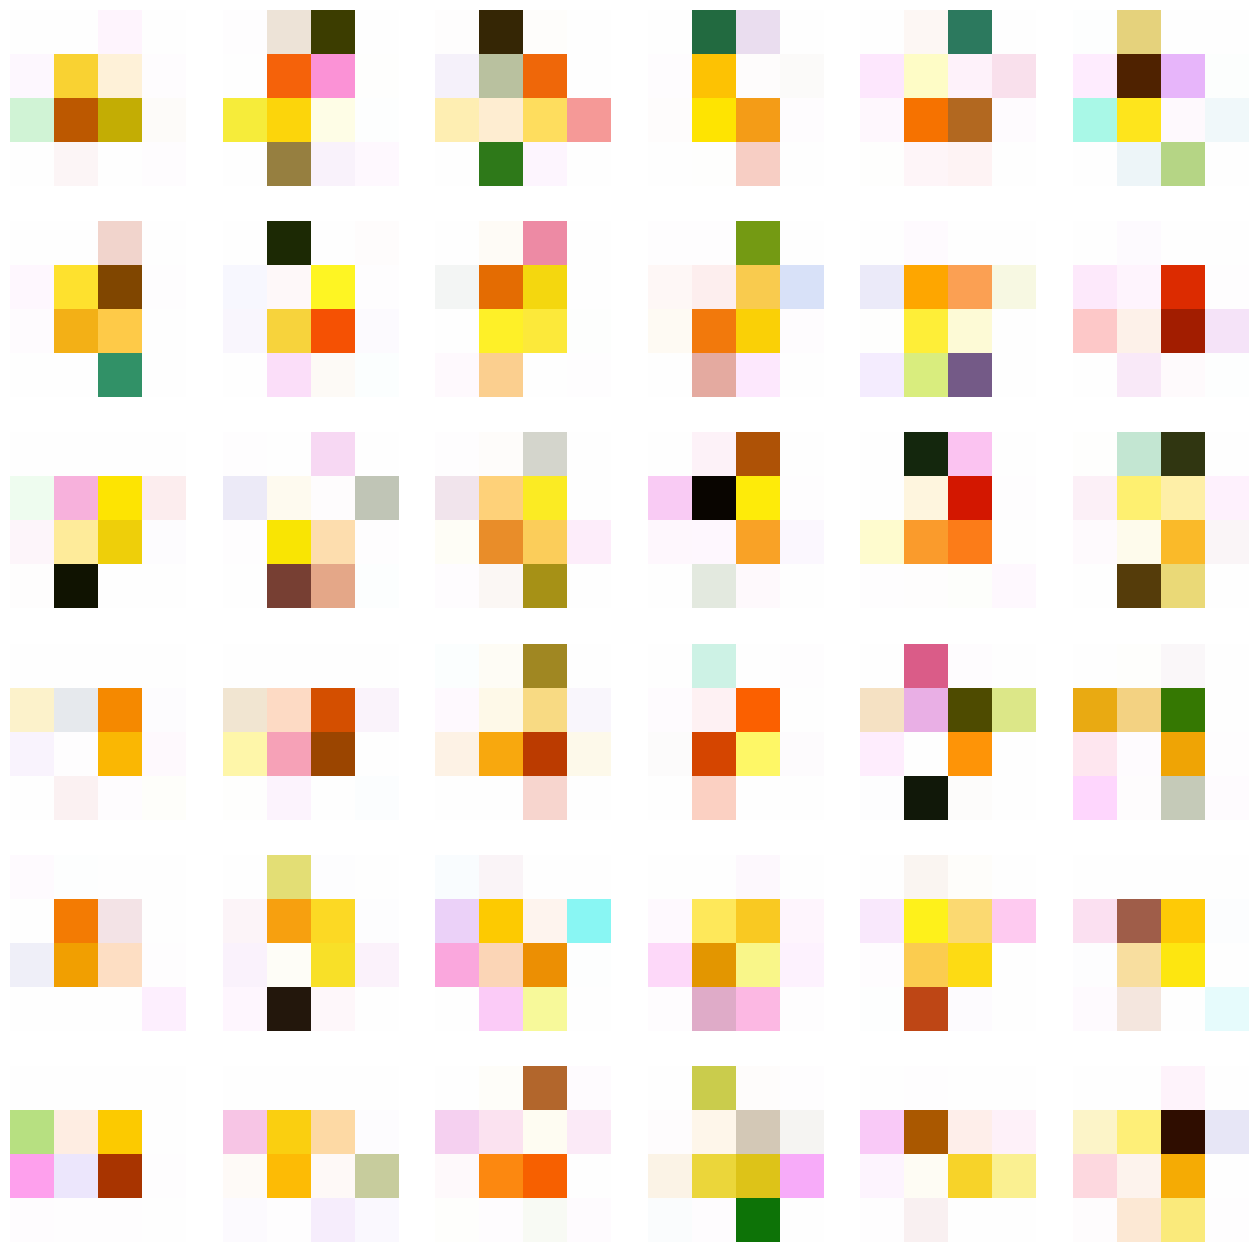

25/25 [==============================] - 15s 590ms/step - d_loss: -1.0739 - g_loss: 2.0671
Epoch 32/50
25/25 [==============================] - ETA: 0s - d_loss: -0.9982 - g_loss: 1.3879

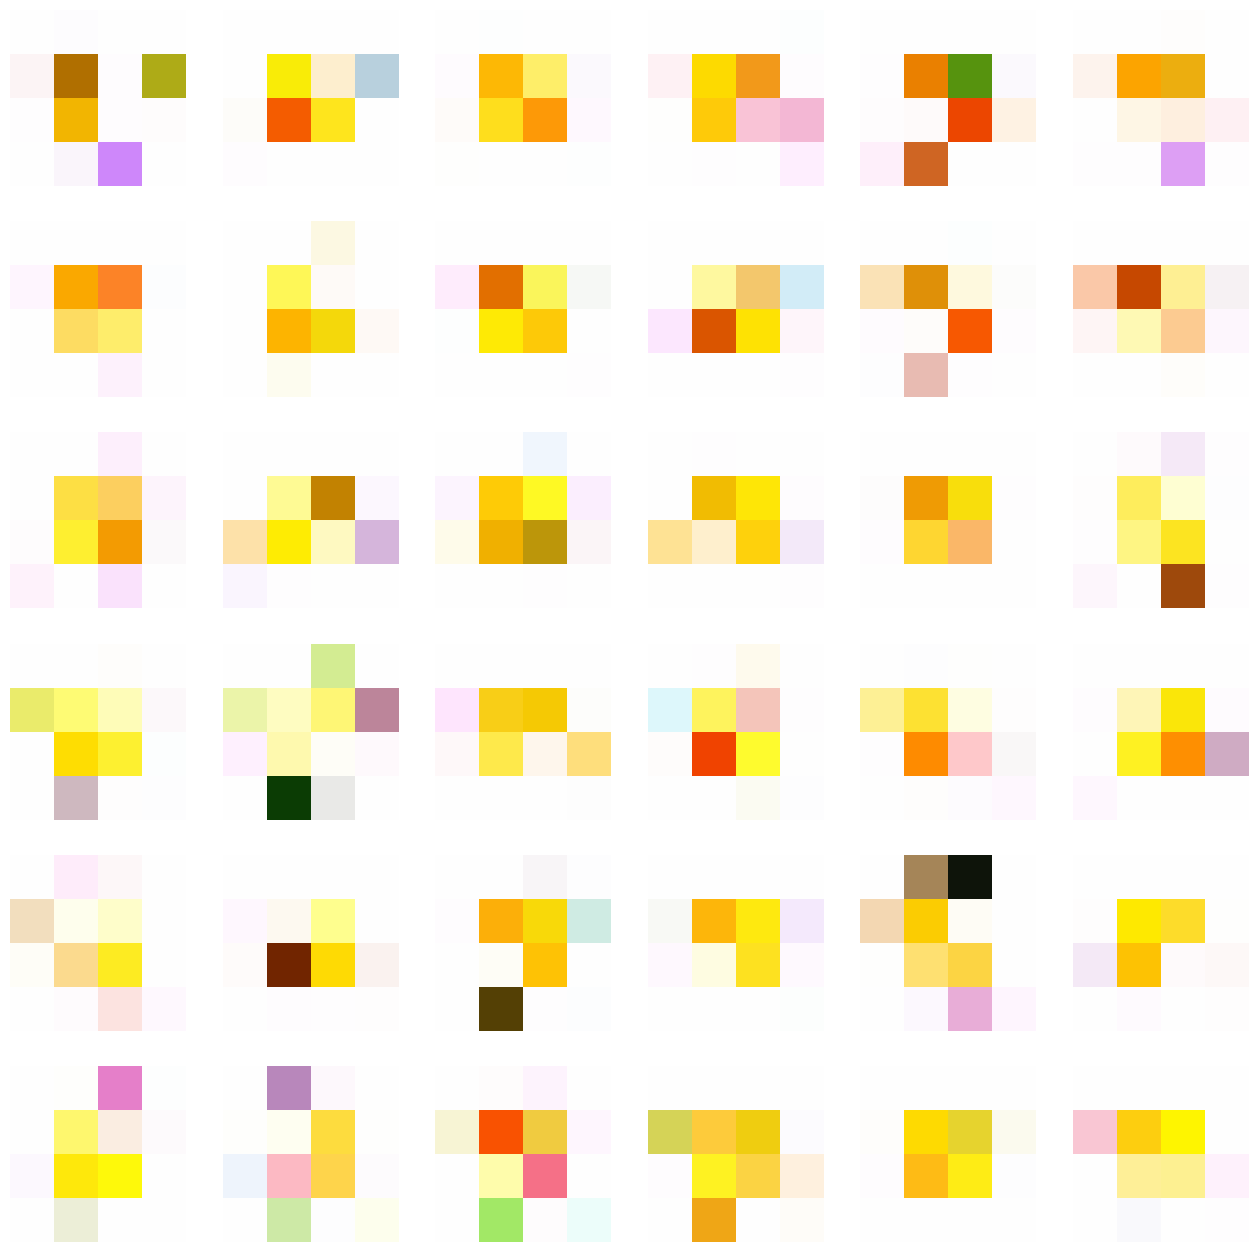

25/25 [==============================] - 15s 604ms/step - d_loss: -0.9895 - g_loss: 1.4302
Epoch 33/50
25/25 [==============================] - ETA: 0s - d_loss: -0.9569 - g_loss: 2.3675

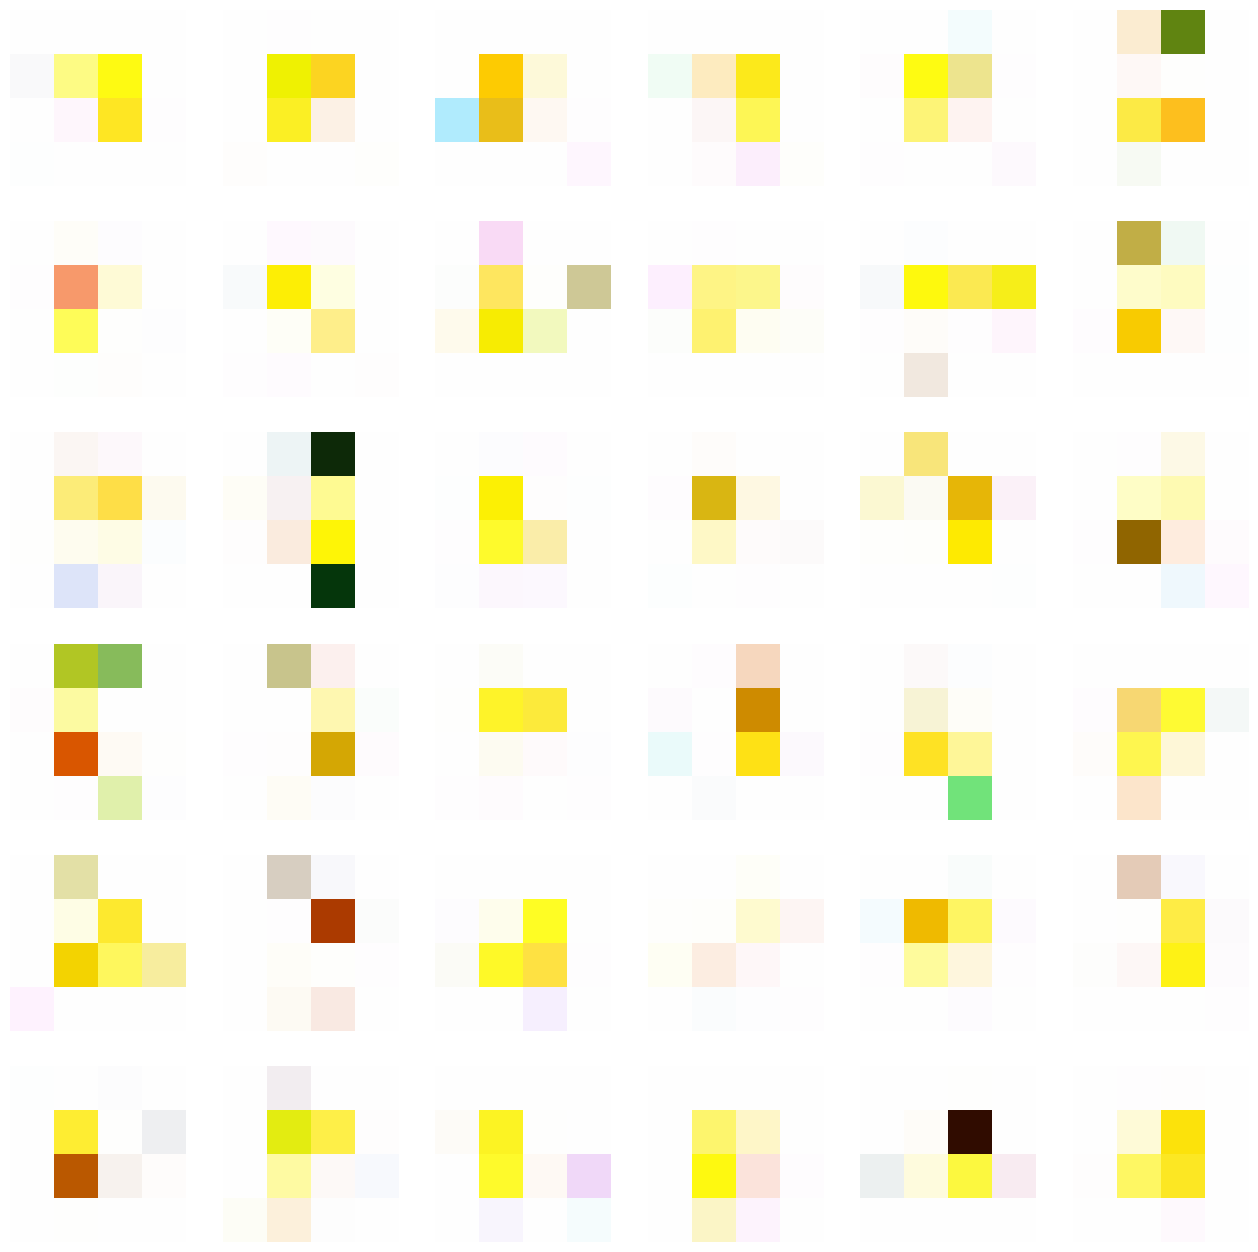

25/25 [==============================] - 16s 633ms/step - d_loss: -0.9409 - g_loss: 2.3602
Epoch 34/50
25/25 [==============================] - ETA: 0s - d_loss: -1.0208 - g_loss: 2.2113

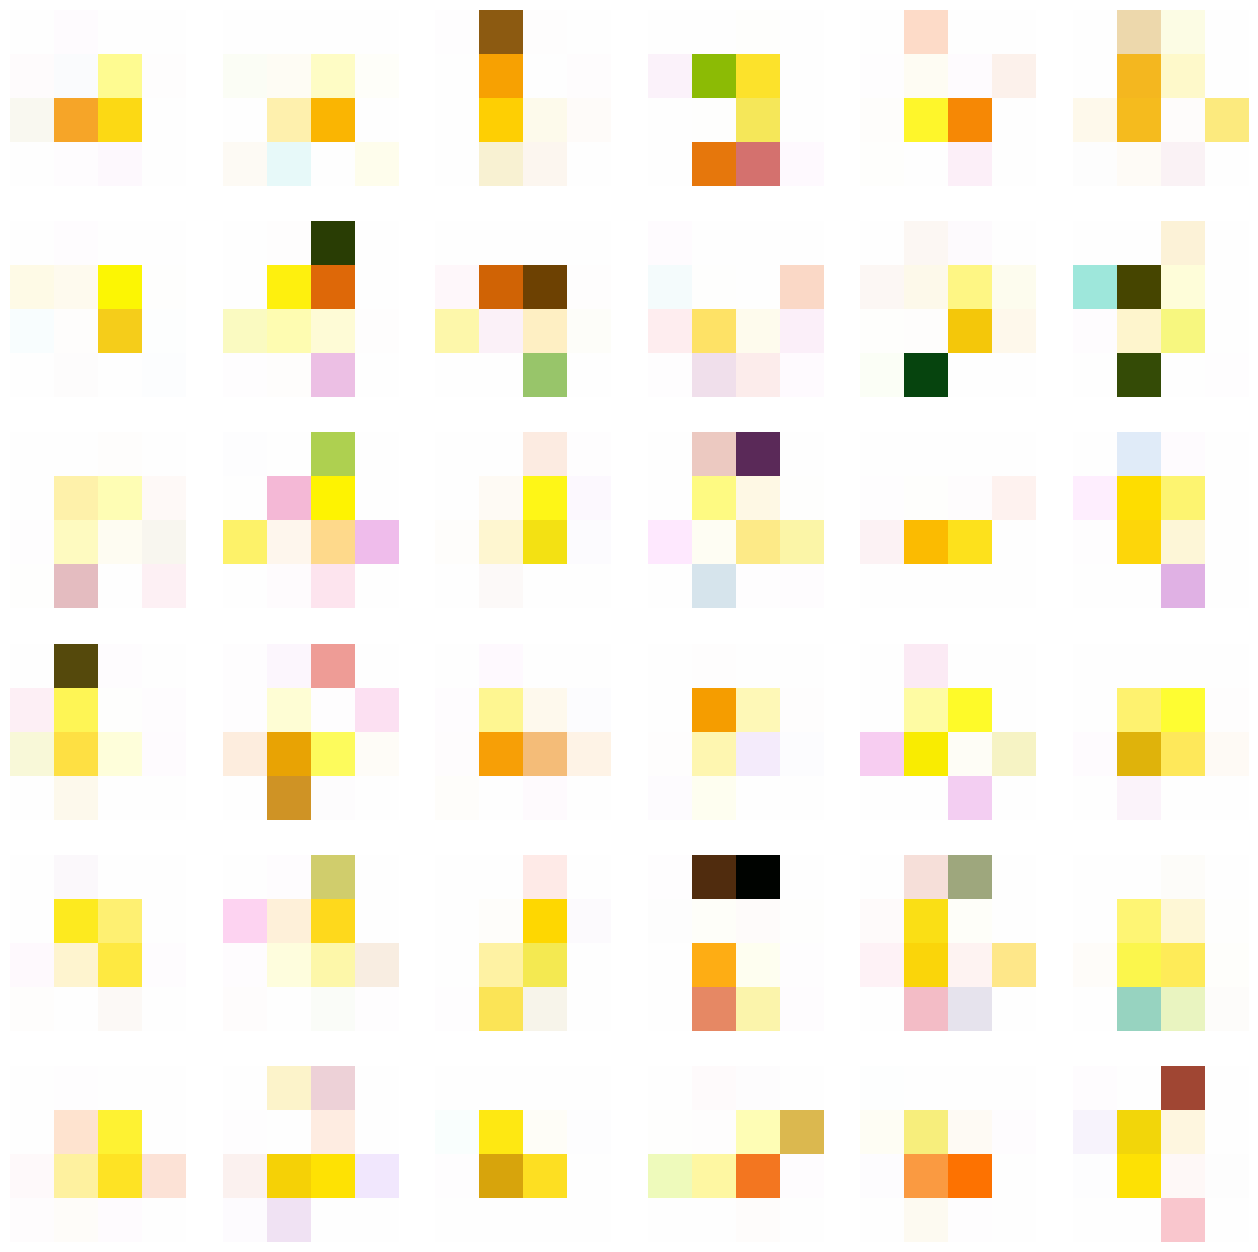

25/25 [==============================] - 15s 600ms/step - d_loss: -1.0301 - g_loss: 2.2089
Epoch 35/50
25/25 [==============================] - ETA: 0s - d_loss: -1.0141 - g_loss: 1.7977

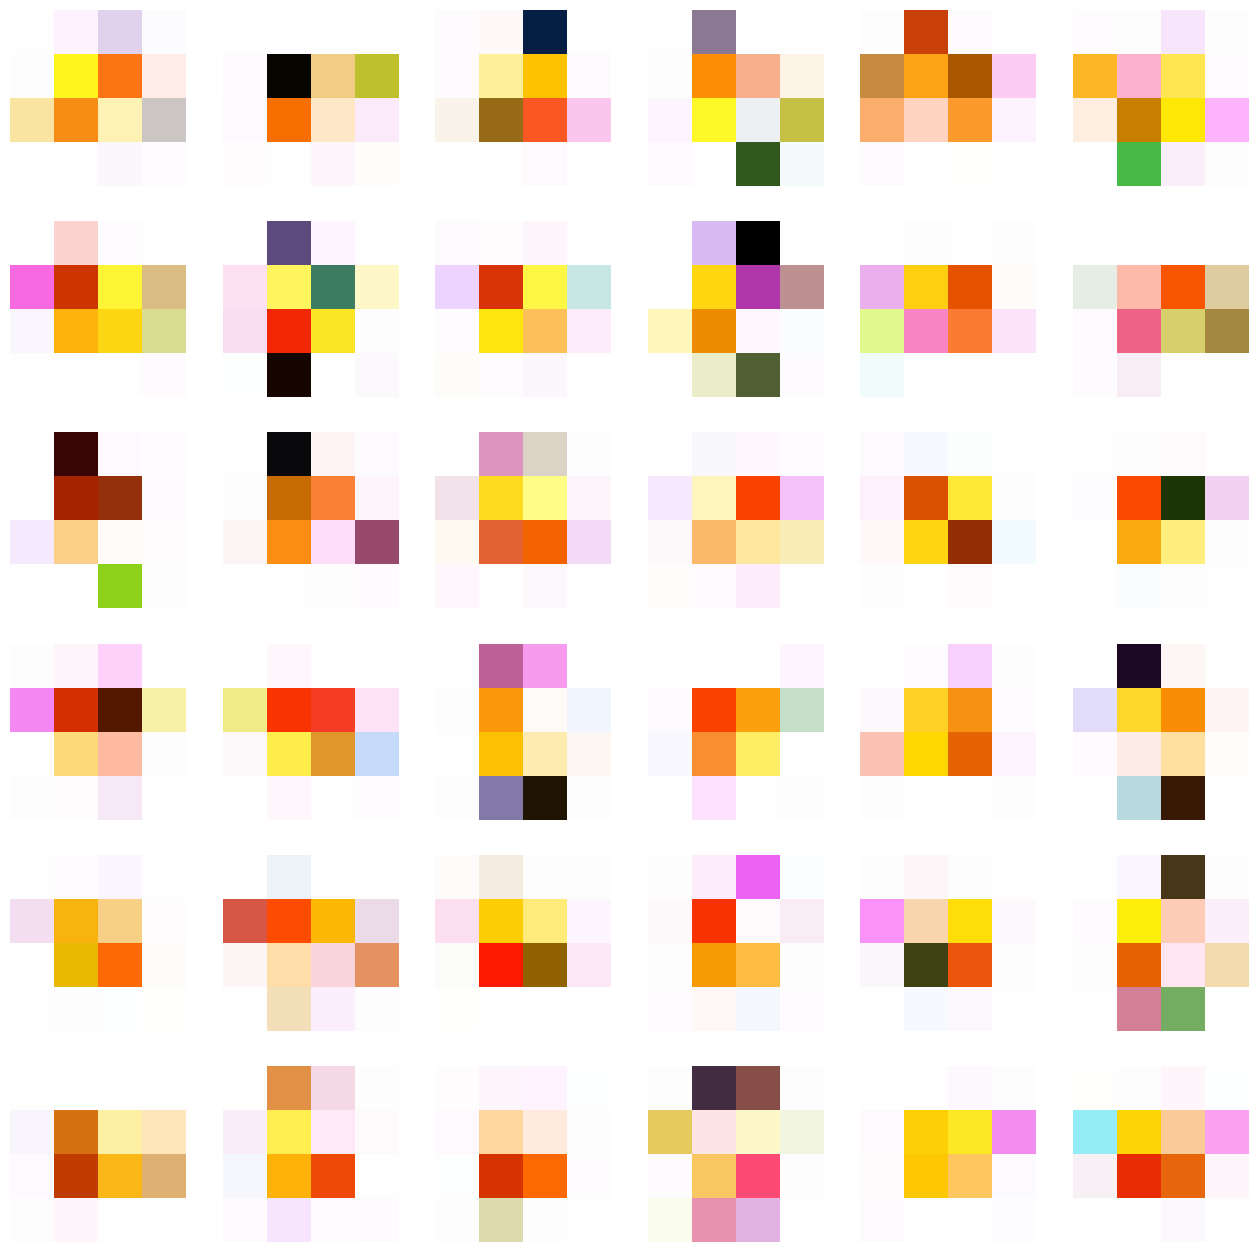

25/25 [==============================] - 15s 608ms/step - d_loss: -1.0205 - g_loss: 1.8375
Epoch 36/50
25/25 [==============================] - ETA: 0s - d_loss: -1.0191 - g_loss: 1.6297

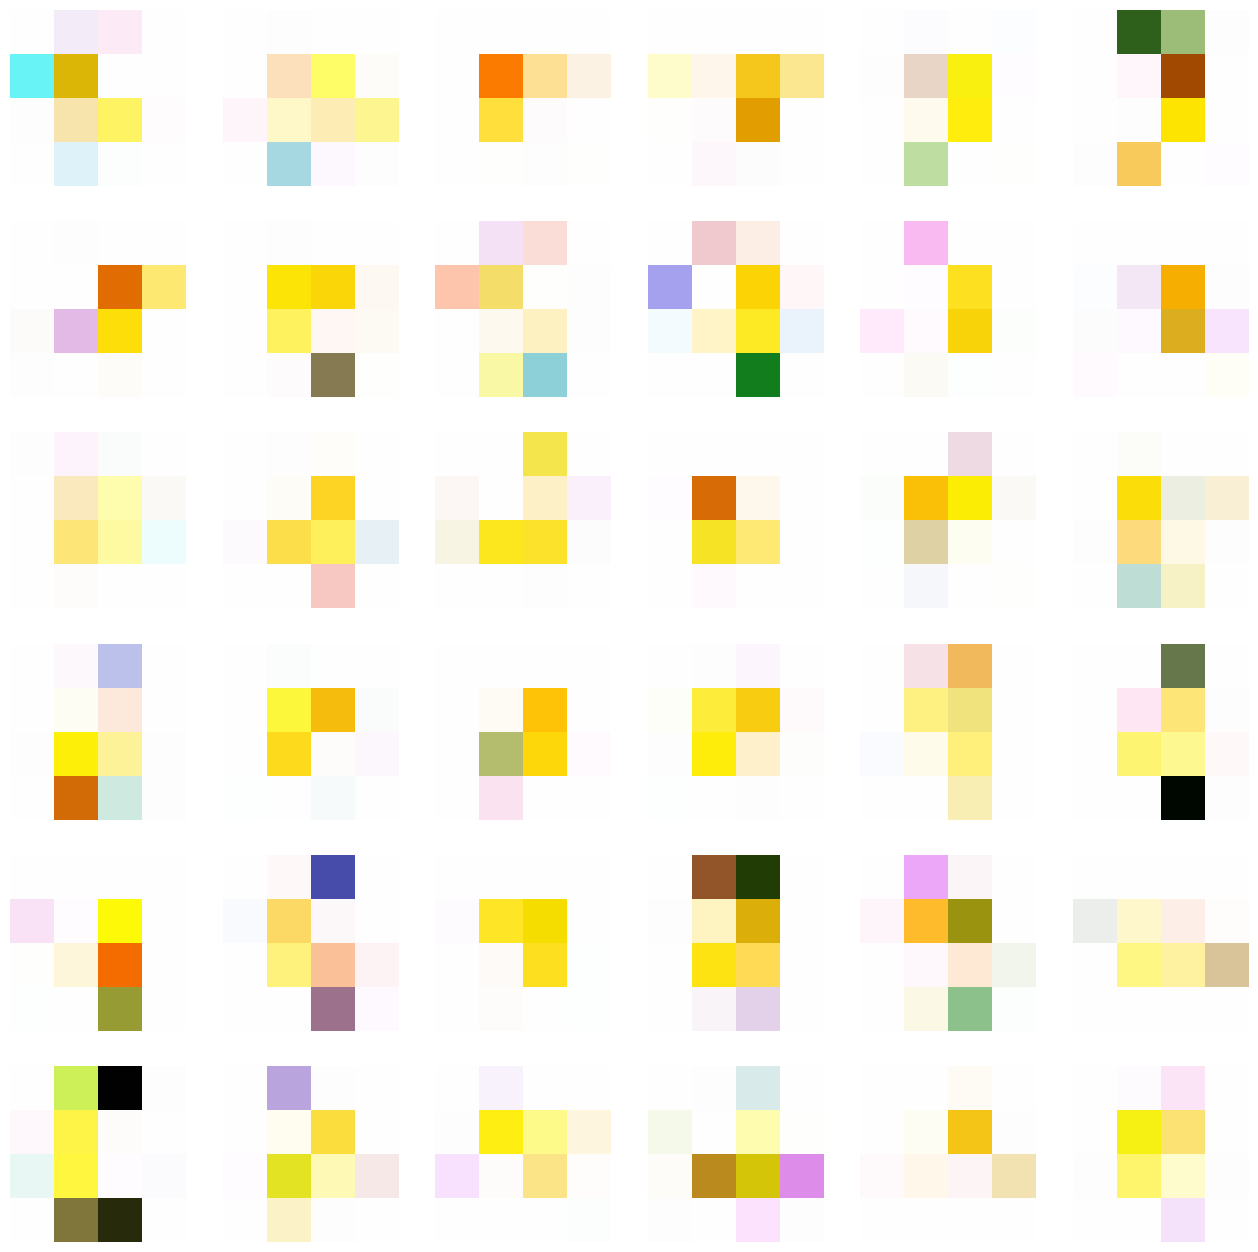

25/25 [==============================] - 15s 598ms/step - d_loss: -1.0136 - g_loss: 1.6226
Epoch 37/50
25/25 [==============================] - ETA: 0s - d_loss: -0.9799 - g_loss: 2.0311

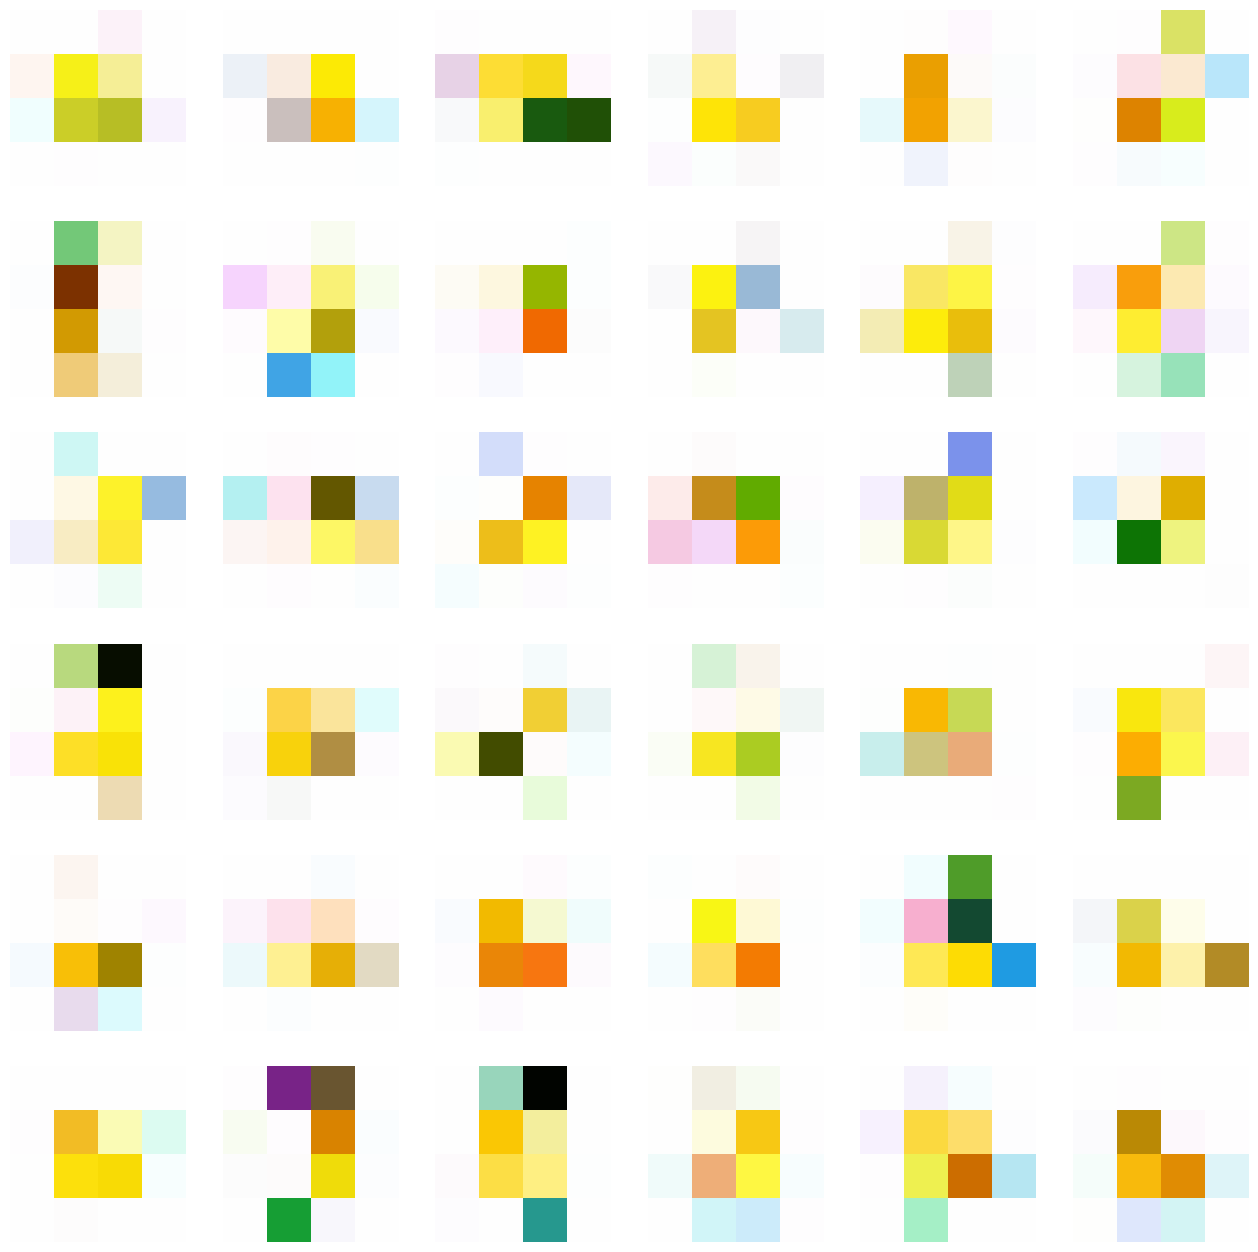

25/25 [==============================] - 15s 610ms/step - d_loss: -0.9864 - g_loss: 2.0748
Epoch 38/50
25/25 [==============================] - ETA: 0s - d_loss: -0.9752 - g_loss: 1.9343

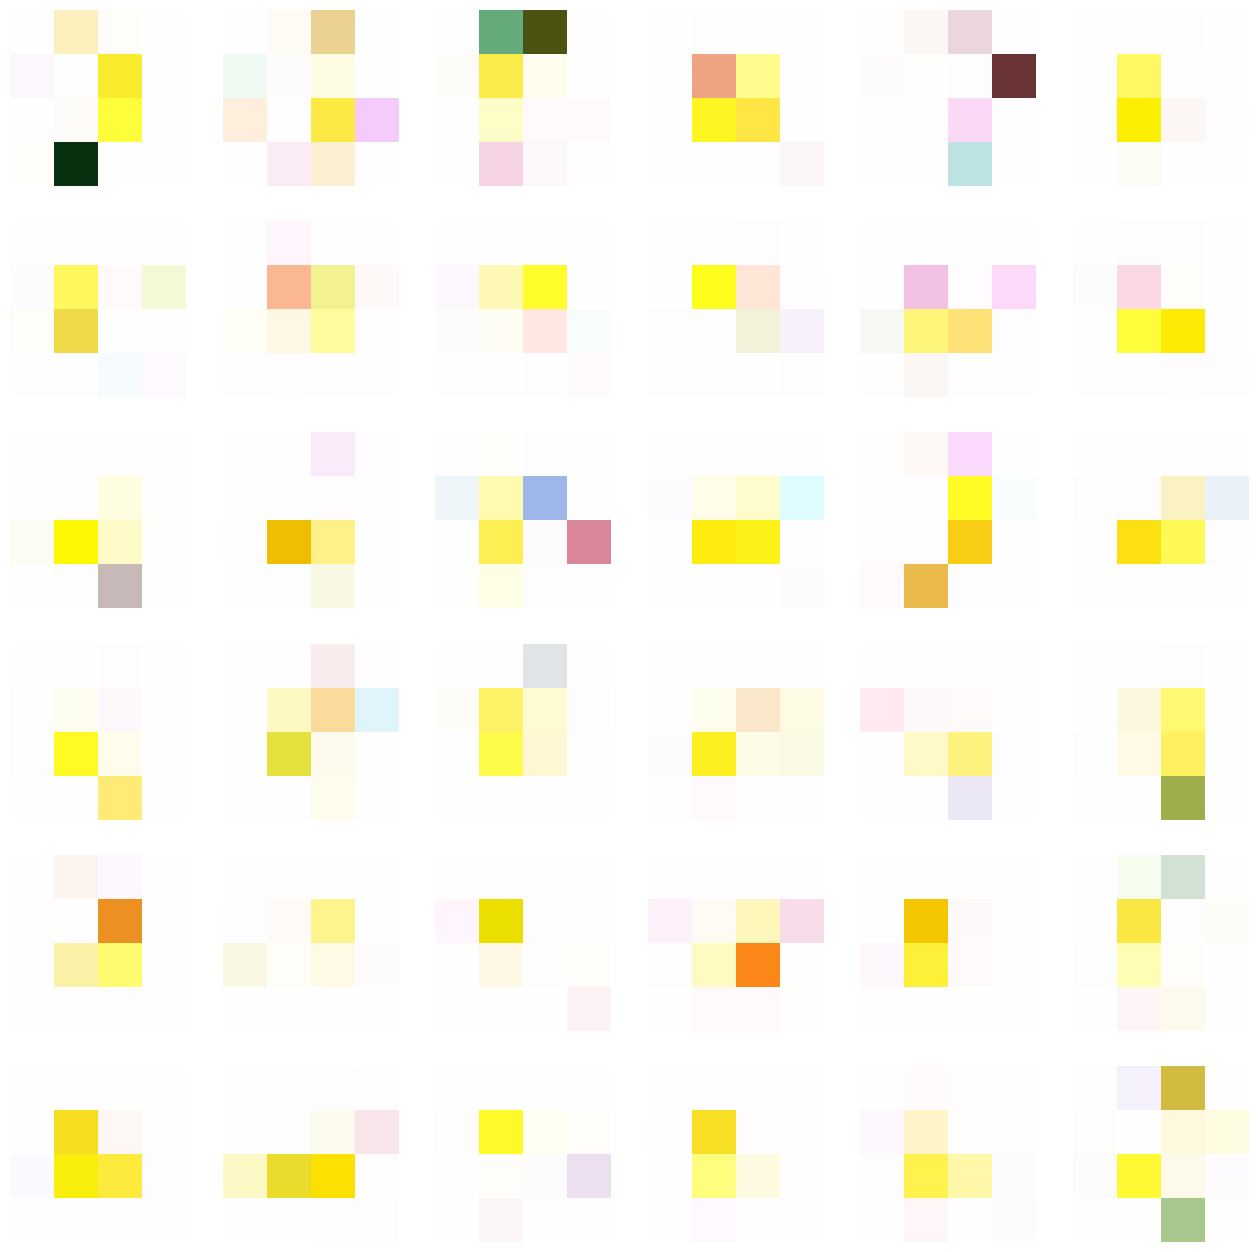

25/25 [==============================] - 16s 662ms/step - d_loss: -0.9780 - g_loss: 1.8615
Epoch 39/50
25/25 [==============================] - ETA: 0s - d_loss: -0.9838 - g_loss: 1.4463

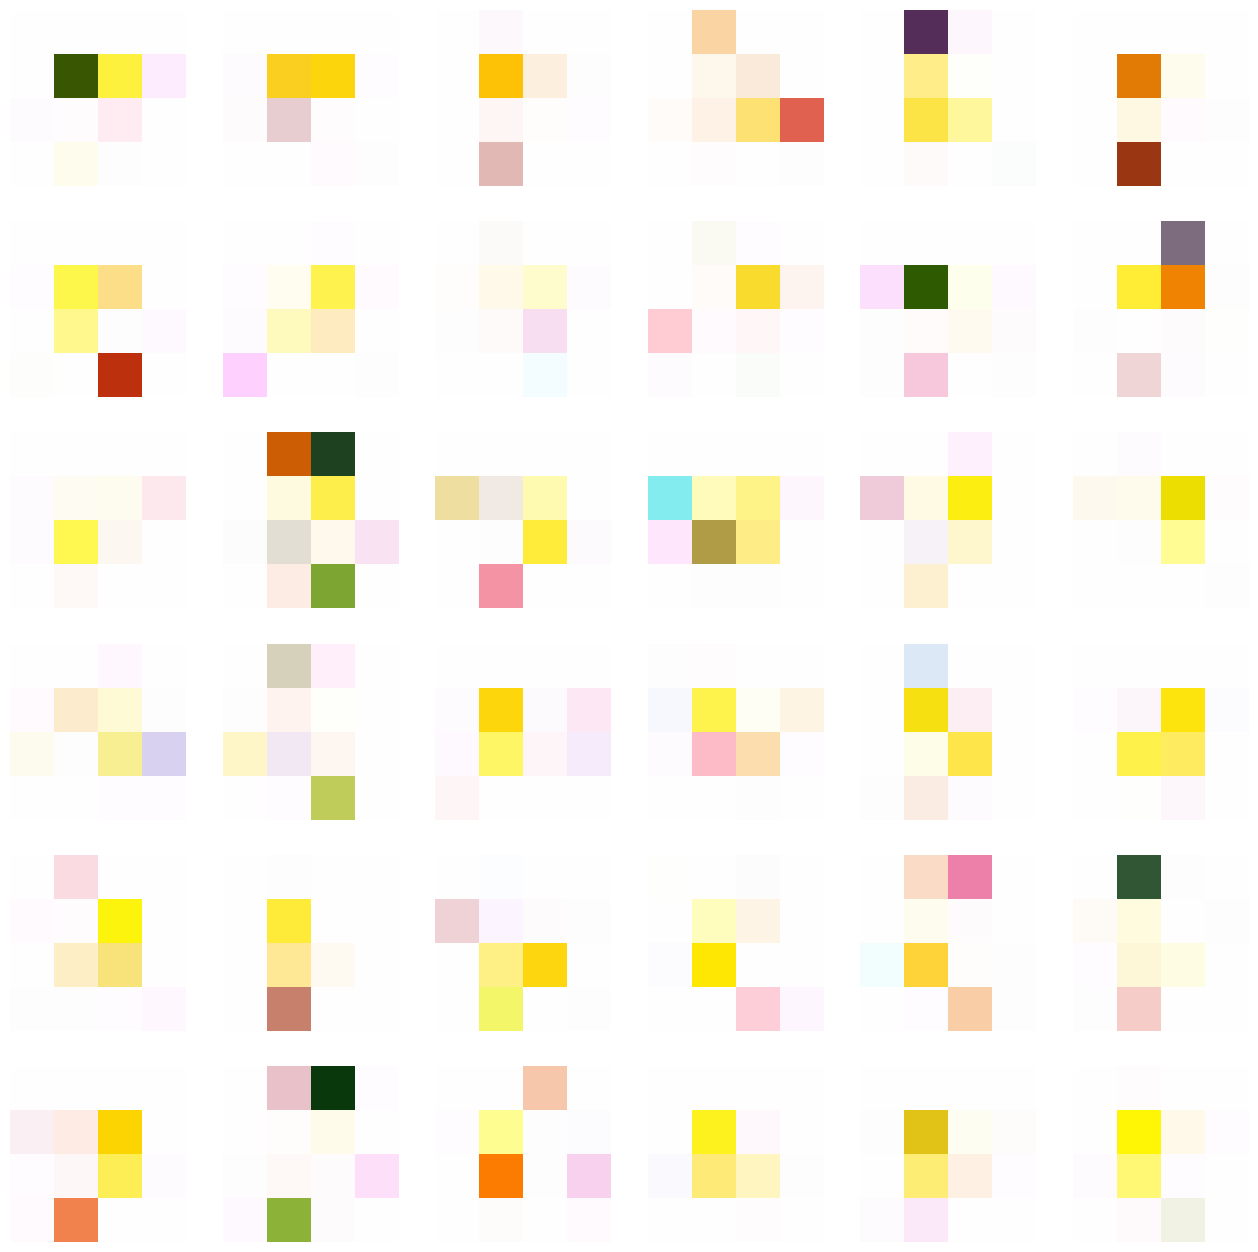

25/25 [==============================] - 15s 593ms/step - d_loss: -0.9736 - g_loss: 1.4006
Epoch 40/50
25/25 [==============================] - ETA: 0s - d_loss: -0.9062 - g_loss: 1.8959

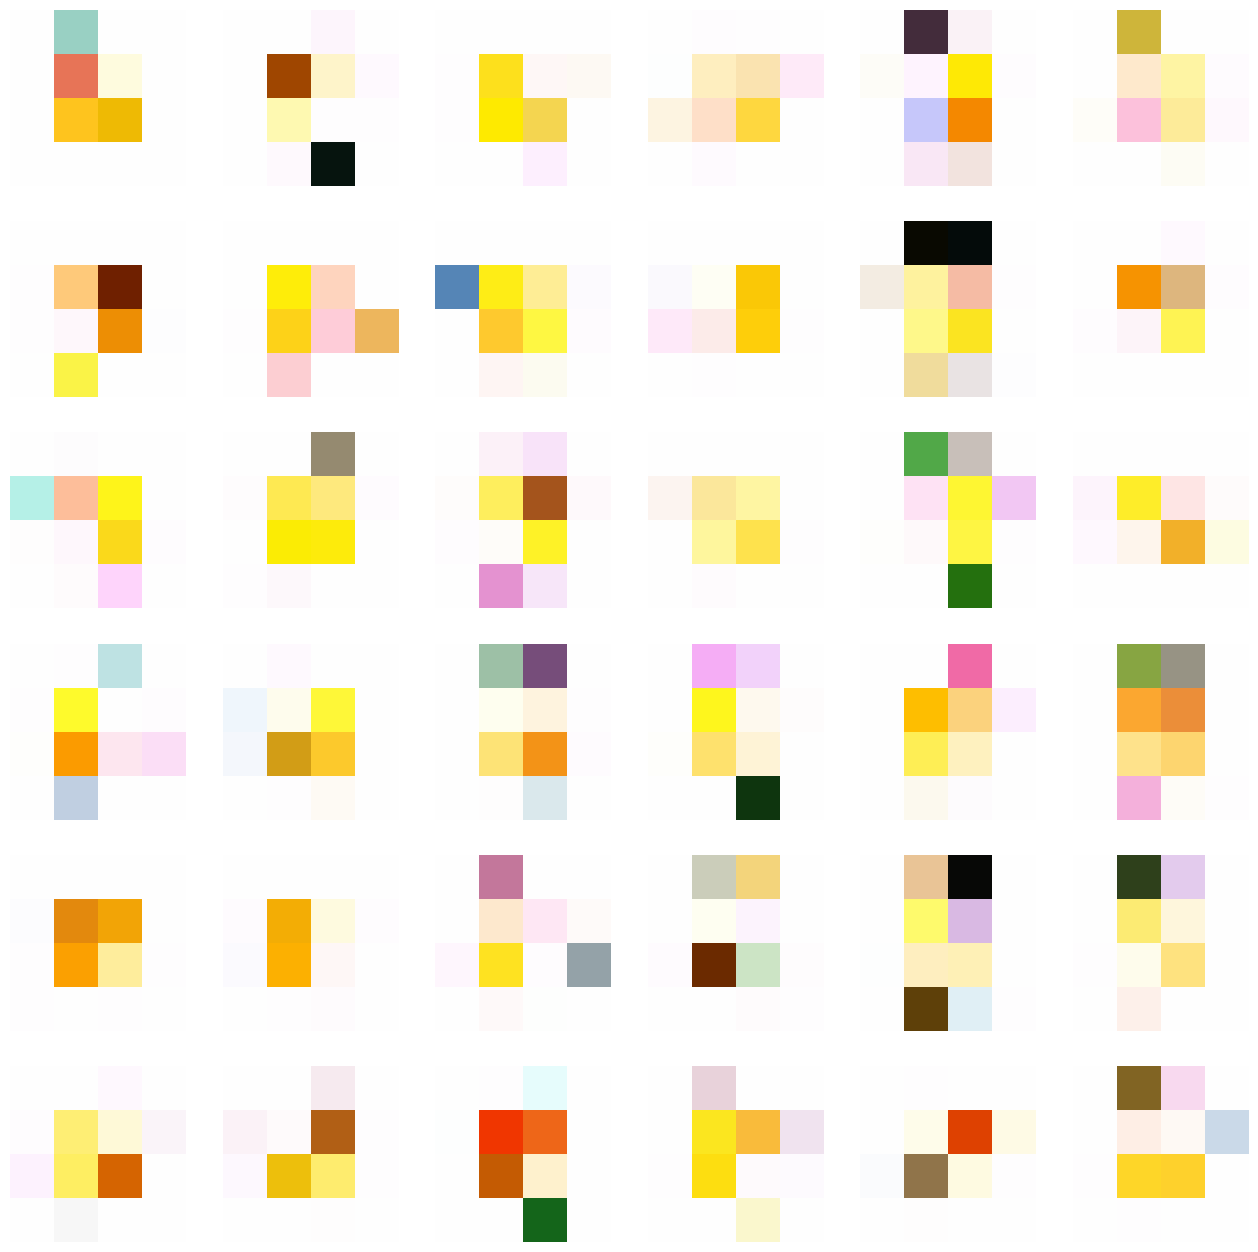

25/25 [==============================] - 14s 584ms/step - d_loss: -0.8916 - g_loss: 1.9285
Epoch 41/50
25/25 [==============================] - ETA: 0s - d_loss: -0.9339 - g_loss: 2.0838

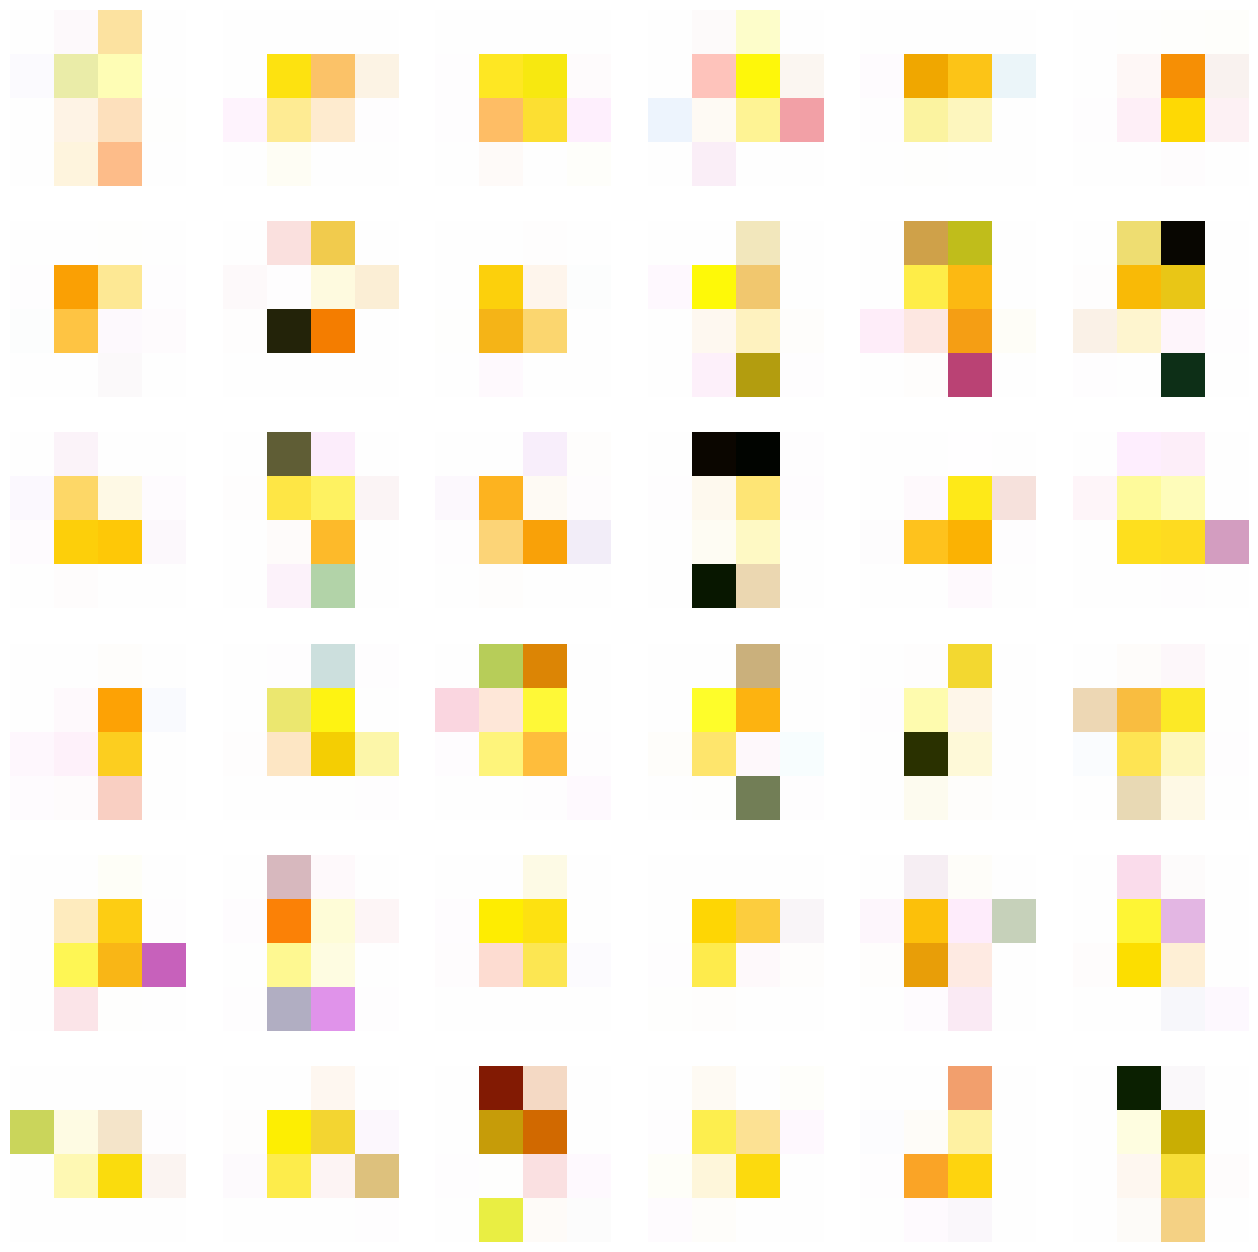

25/25 [==============================] - 15s 595ms/step - d_loss: -0.9439 - g_loss: 2.0714
Epoch 42/50
25/25 [==============================] - ETA: 0s - d_loss: -0.9345 - g_loss: 1.5968

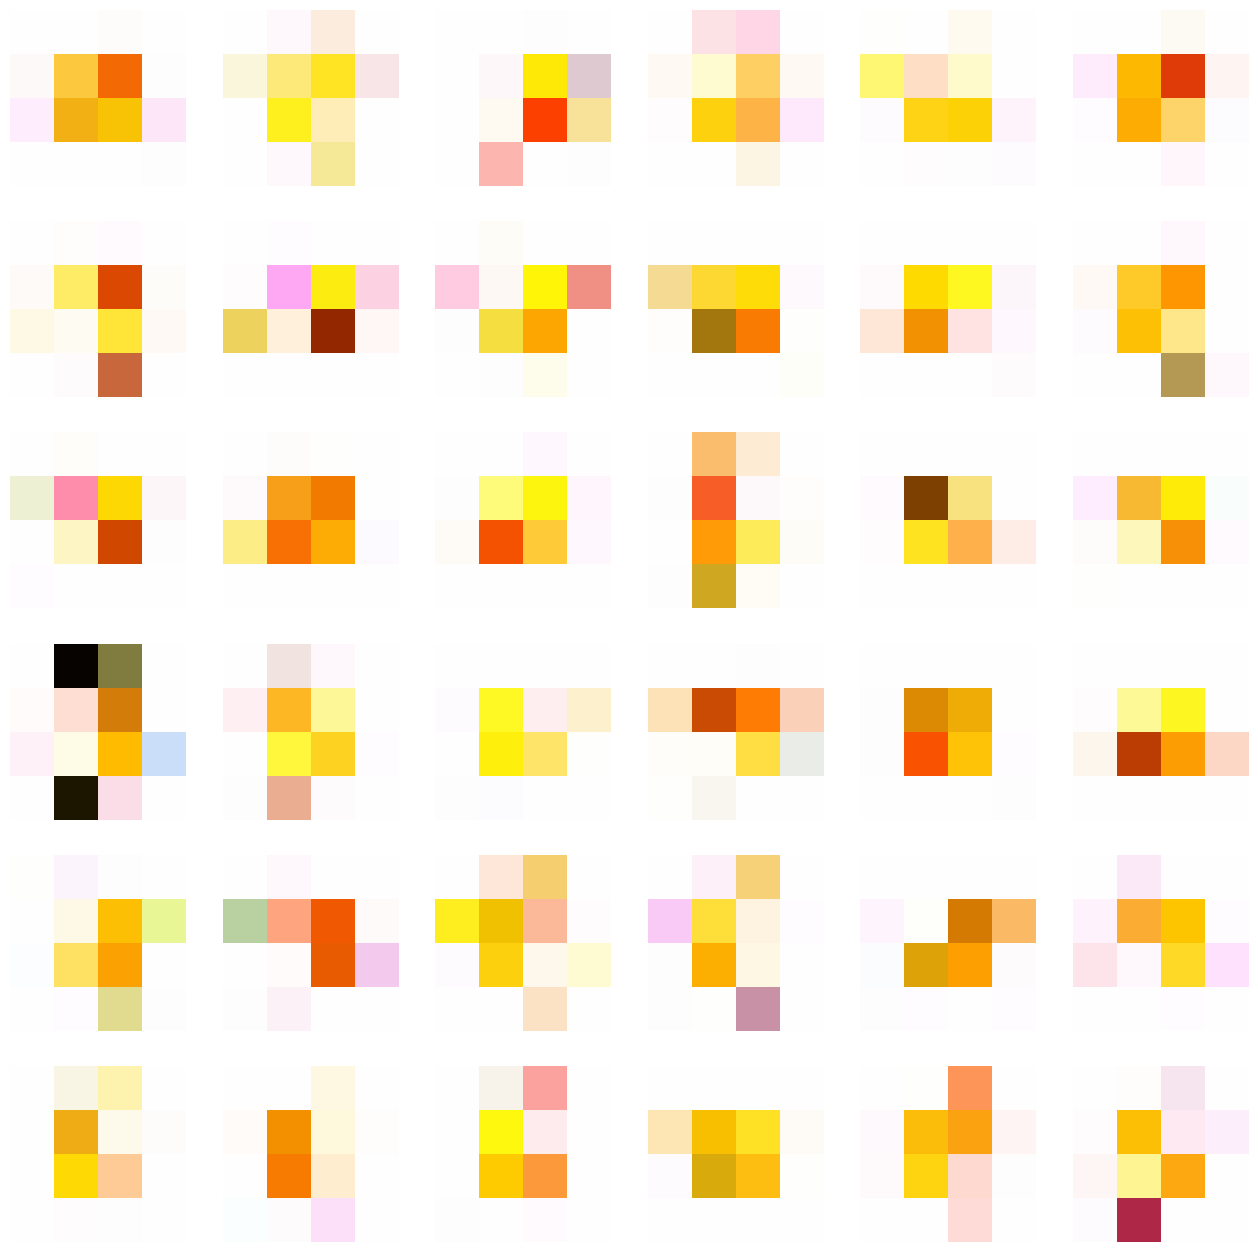

25/25 [==============================] - 16s 634ms/step - d_loss: -0.9391 - g_loss: 1.6065
Epoch 43/50
25/25 [==============================] - ETA: 0s - d_loss: -0.9741 - g_loss: 1.9733

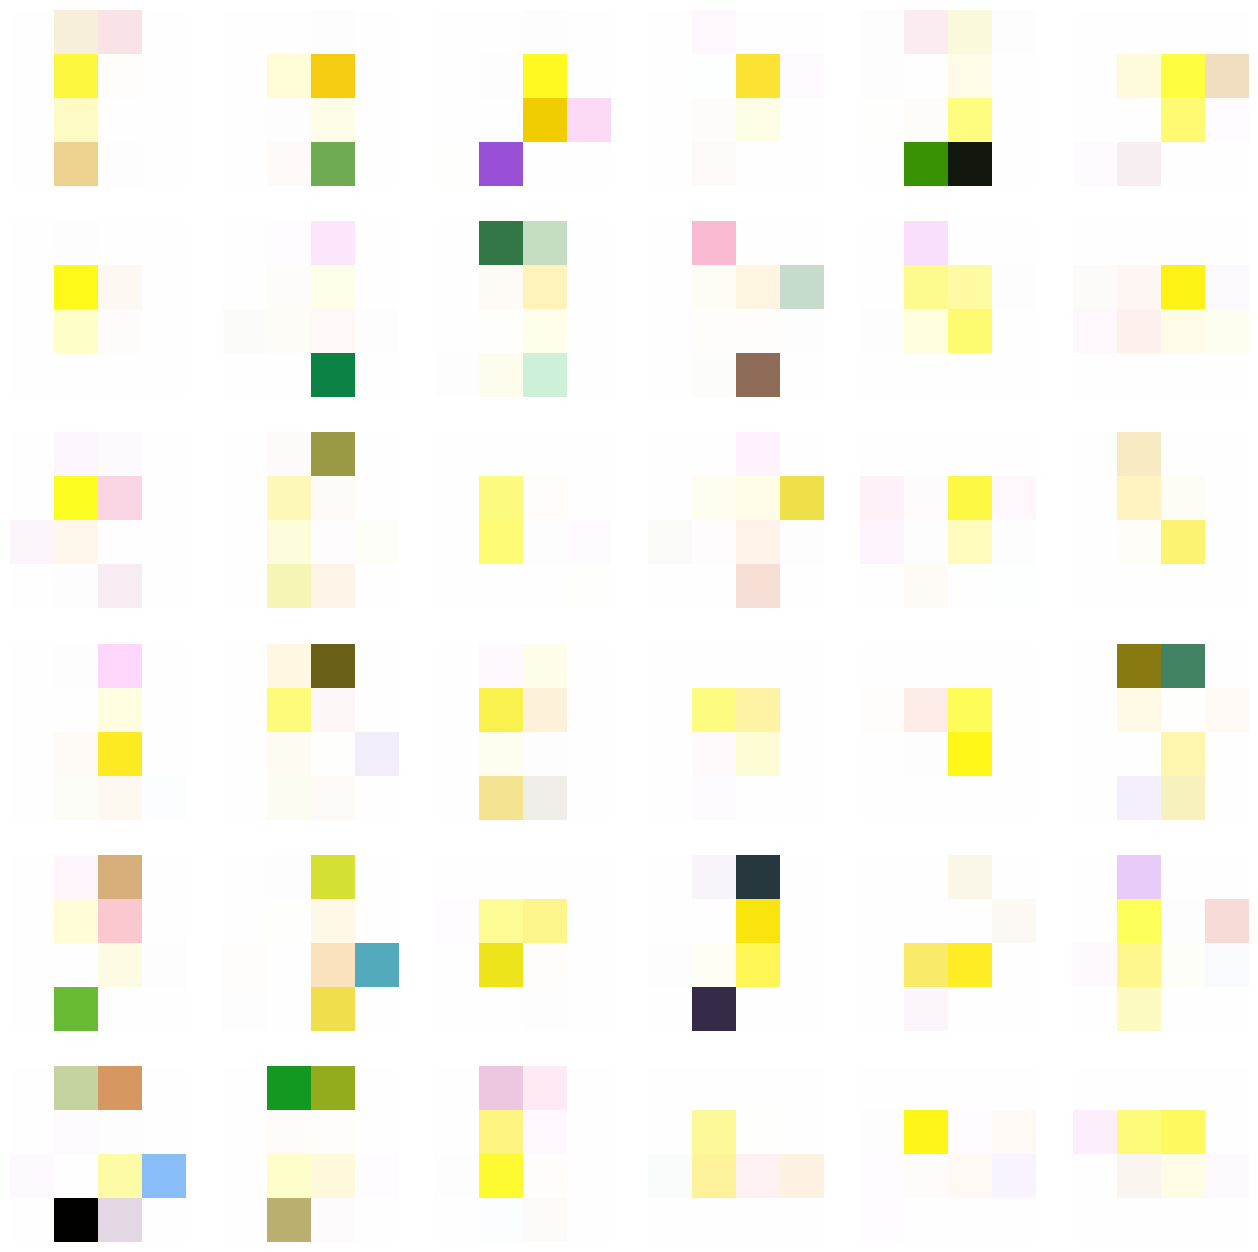

25/25 [==============================] - 15s 603ms/step - d_loss: -0.9663 - g_loss: 1.8677
Epoch 44/50
25/25 [==============================] - ETA: 0s - d_loss: -0.8649 - g_loss: 1.3499

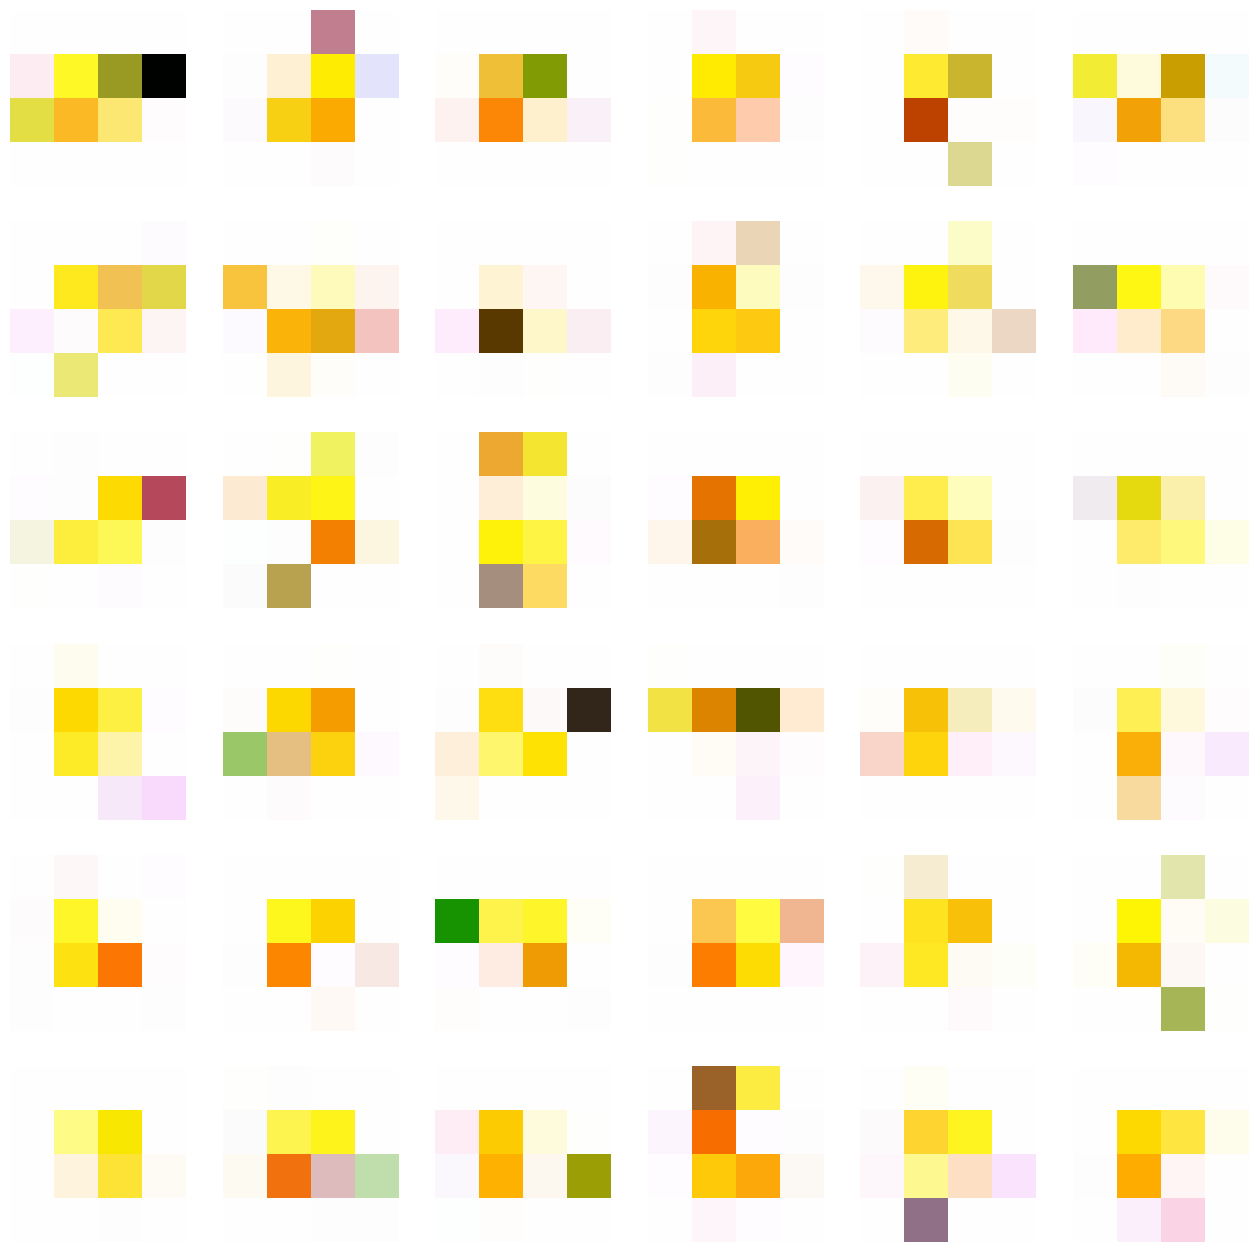

25/25 [==============================] - 15s 612ms/step - d_loss: -0.8496 - g_loss: 1.3480
Epoch 45/50
25/25 [==============================] - ETA: 0s - d_loss: -0.8638 - g_loss: 1.2661

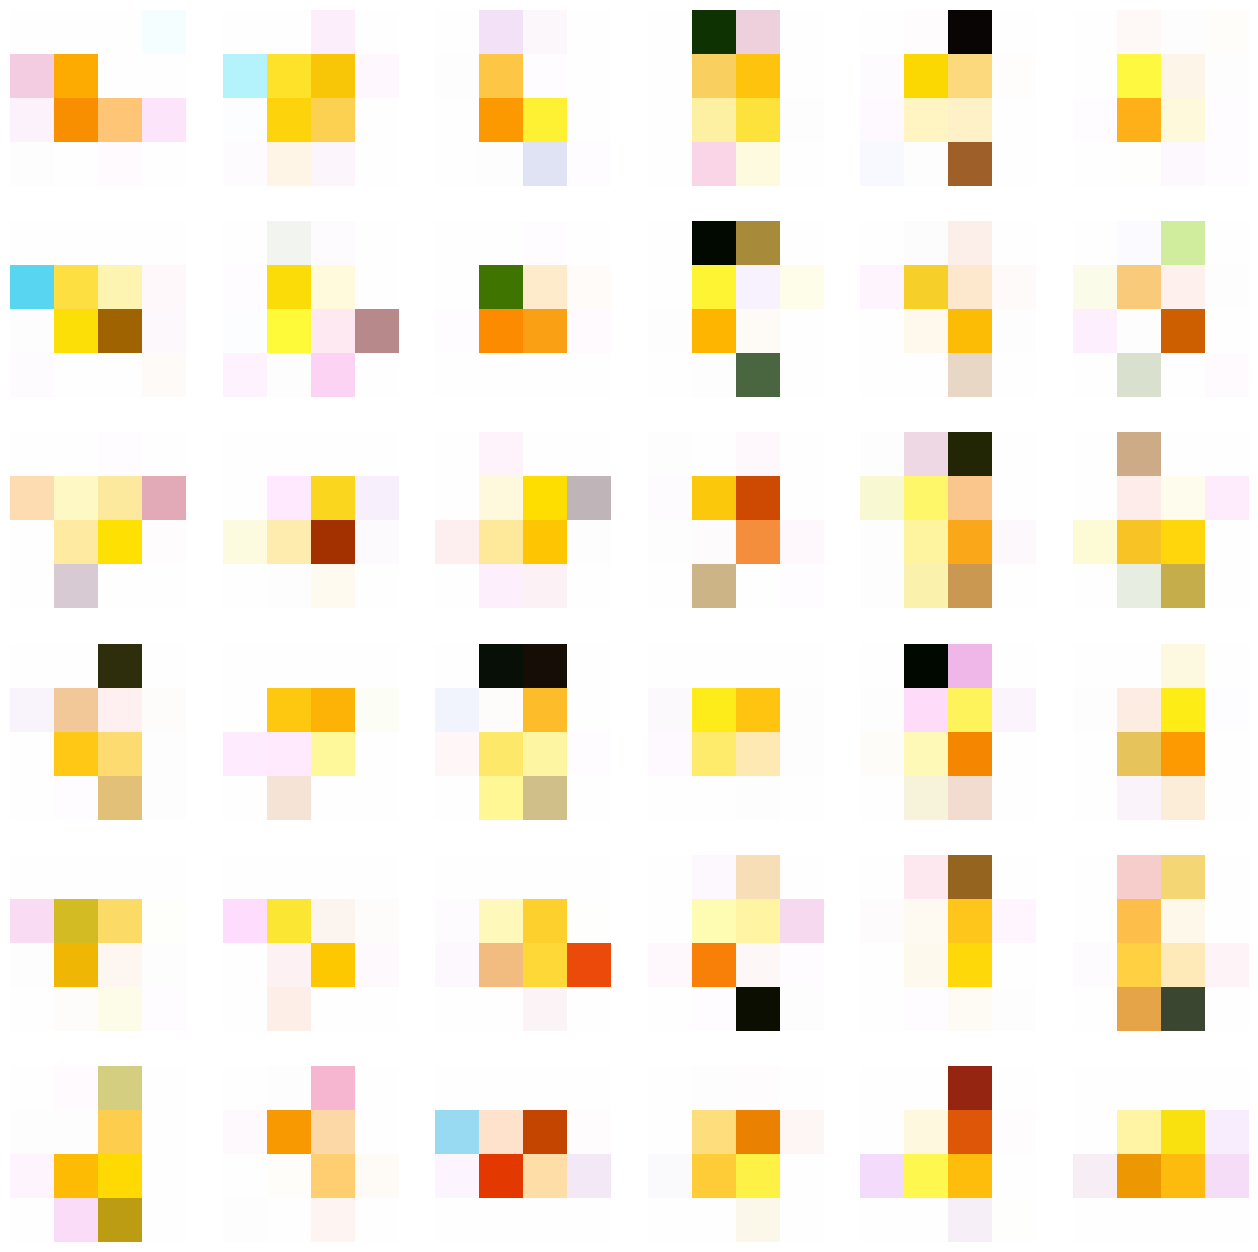

25/25 [==============================] - 15s 592ms/step - d_loss: -0.8467 - g_loss: 1.2706
Epoch 46/50
25/25 [==============================] - ETA: 0s - d_loss: -0.9261 - g_loss: 1.4582

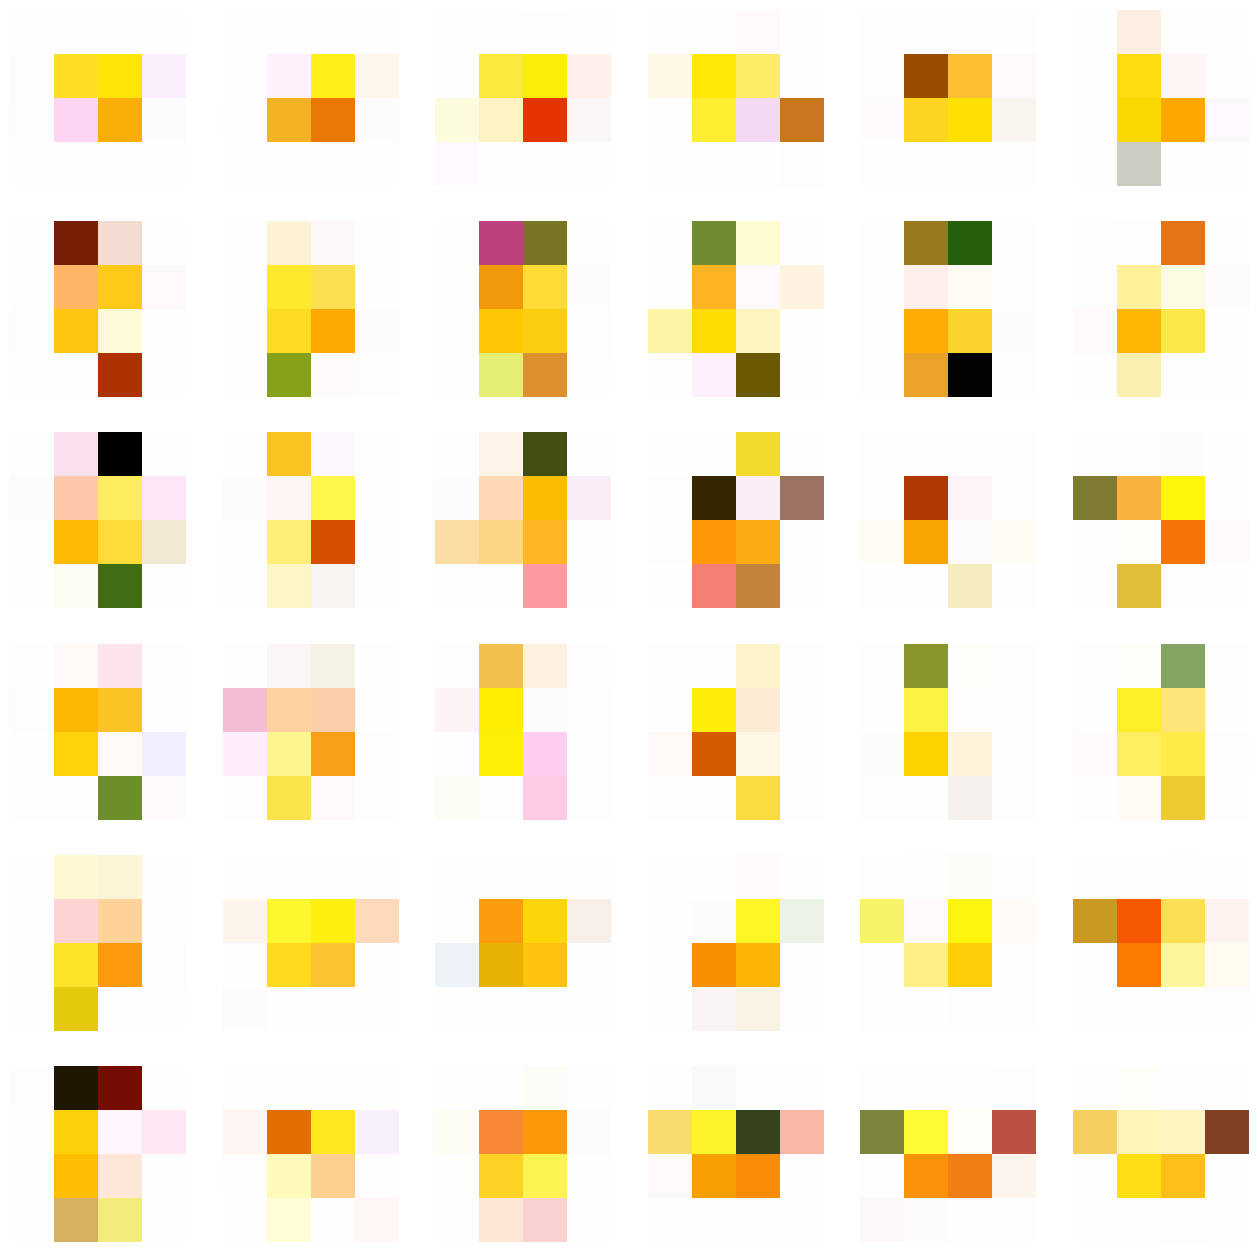

25/25 [==============================] - 16s 635ms/step - d_loss: -0.9328 - g_loss: 1.4430
Epoch 47/50
25/25 [==============================] - ETA: 0s - d_loss: -0.8190 - g_loss: 1.6000

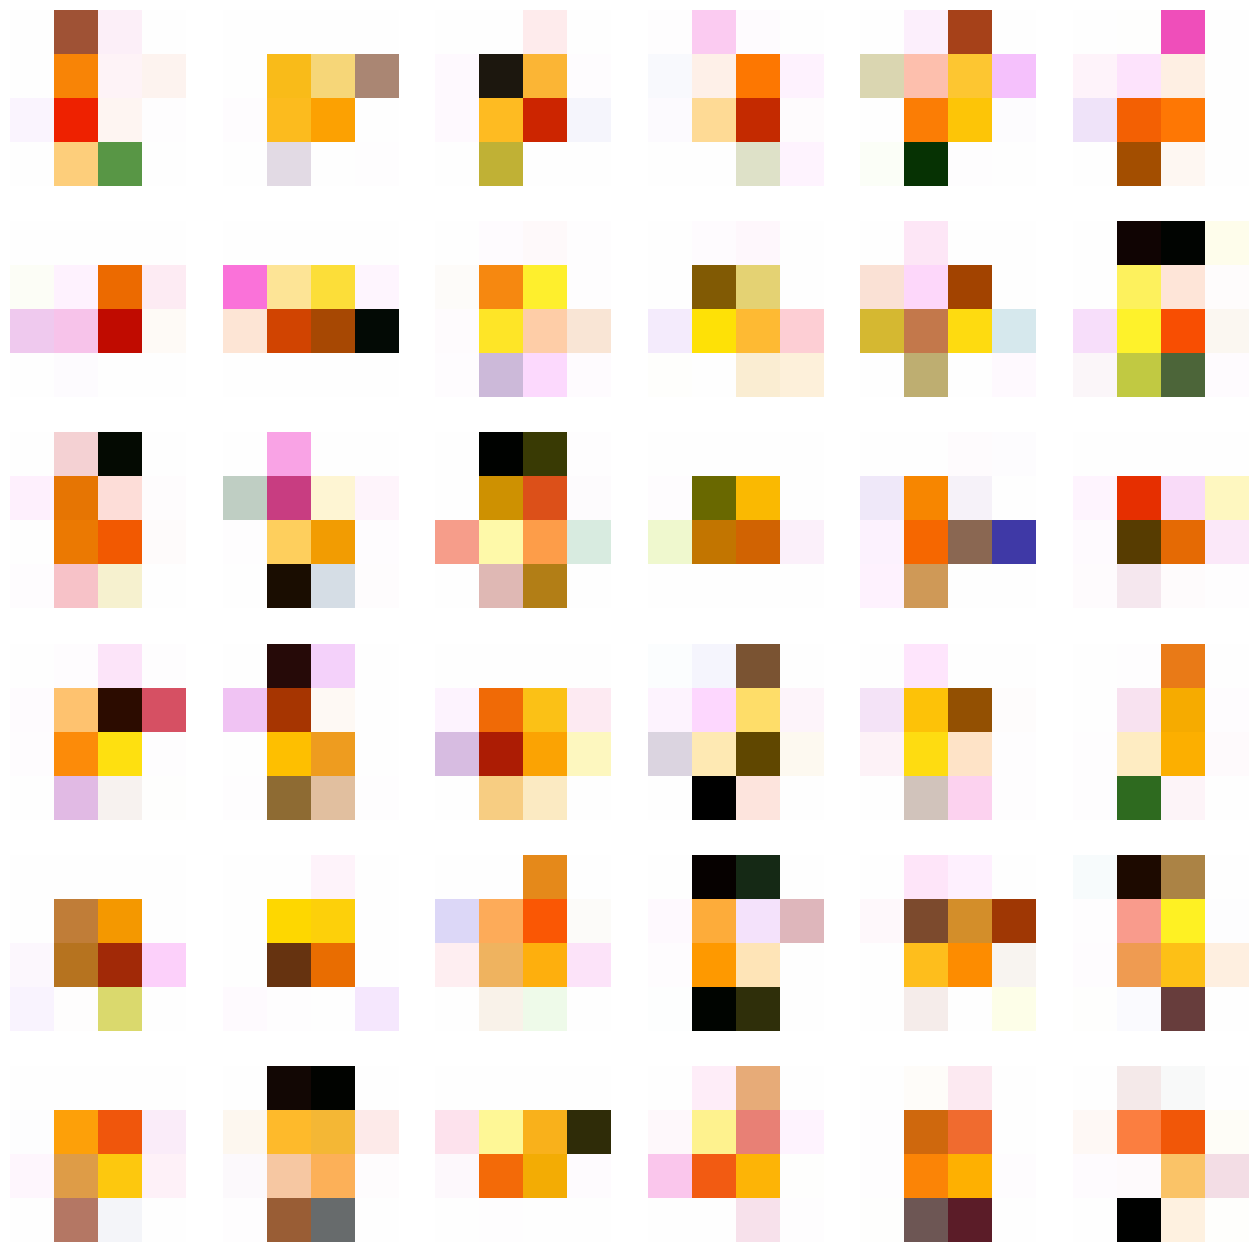

25/25 [==============================] - 15s 618ms/step - d_loss: -0.8015 - g_loss: 1.6197
Epoch 48/50
25/25 [==============================] - ETA: 0s - d_loss: -0.8623 - g_loss: 1.1207

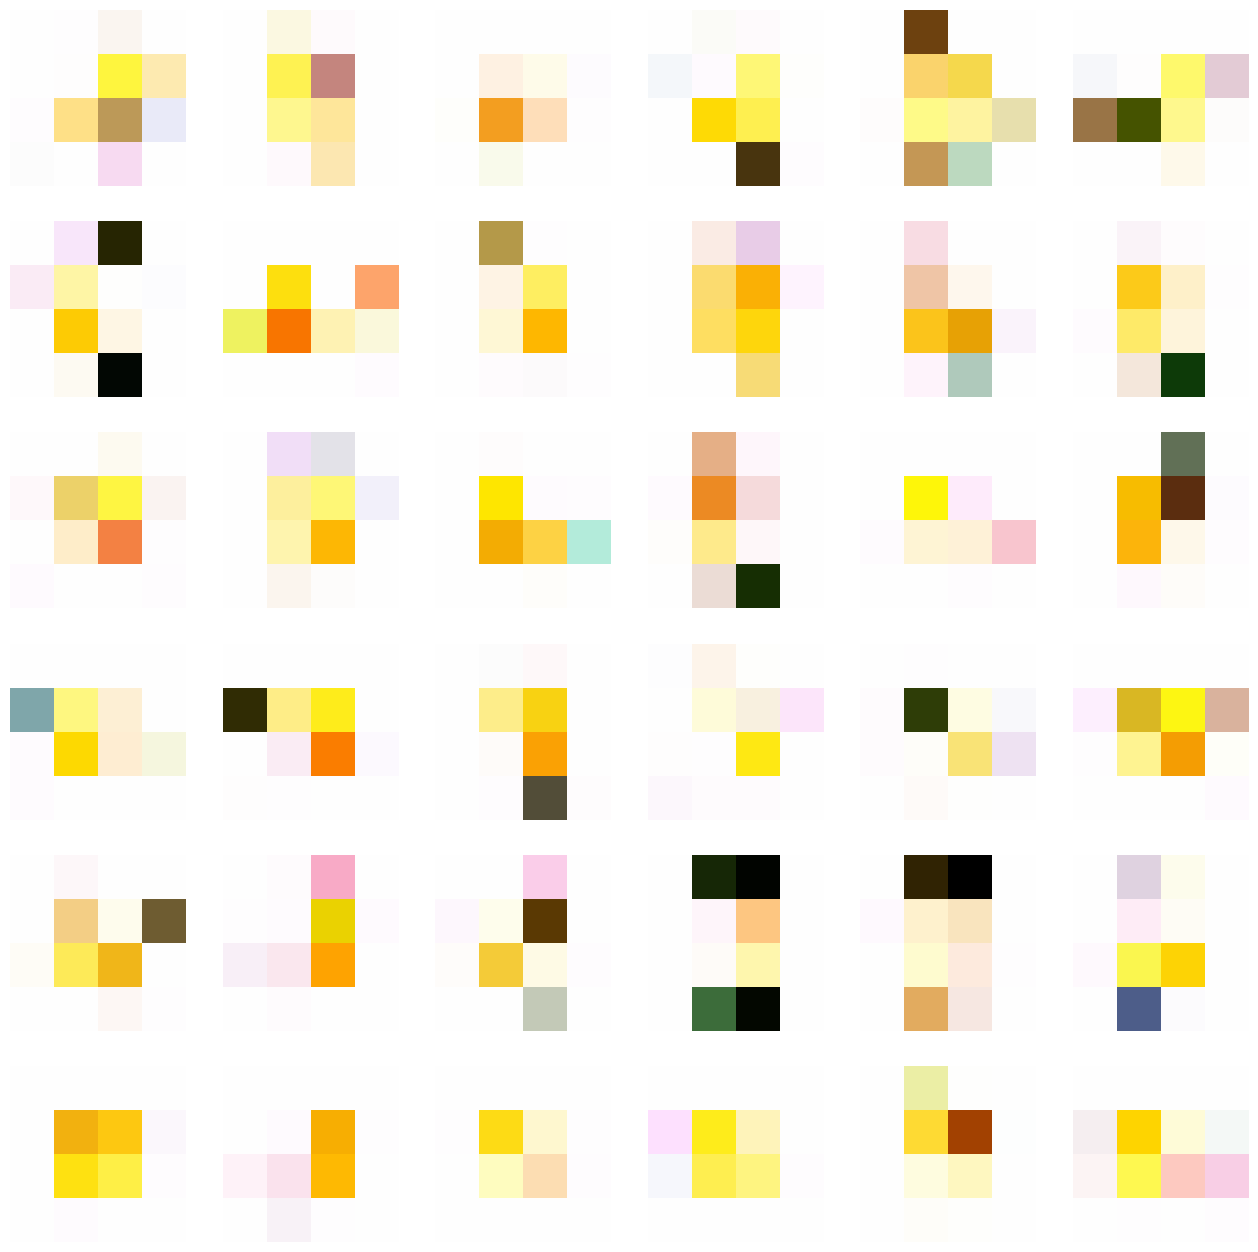

25/25 [==============================] - 15s 598ms/step - d_loss: -0.8467 - g_loss: 1.0875
Epoch 49/50
25/25 [==============================] - ETA: 0s - d_loss: -0.8517 - g_loss: 1.4896

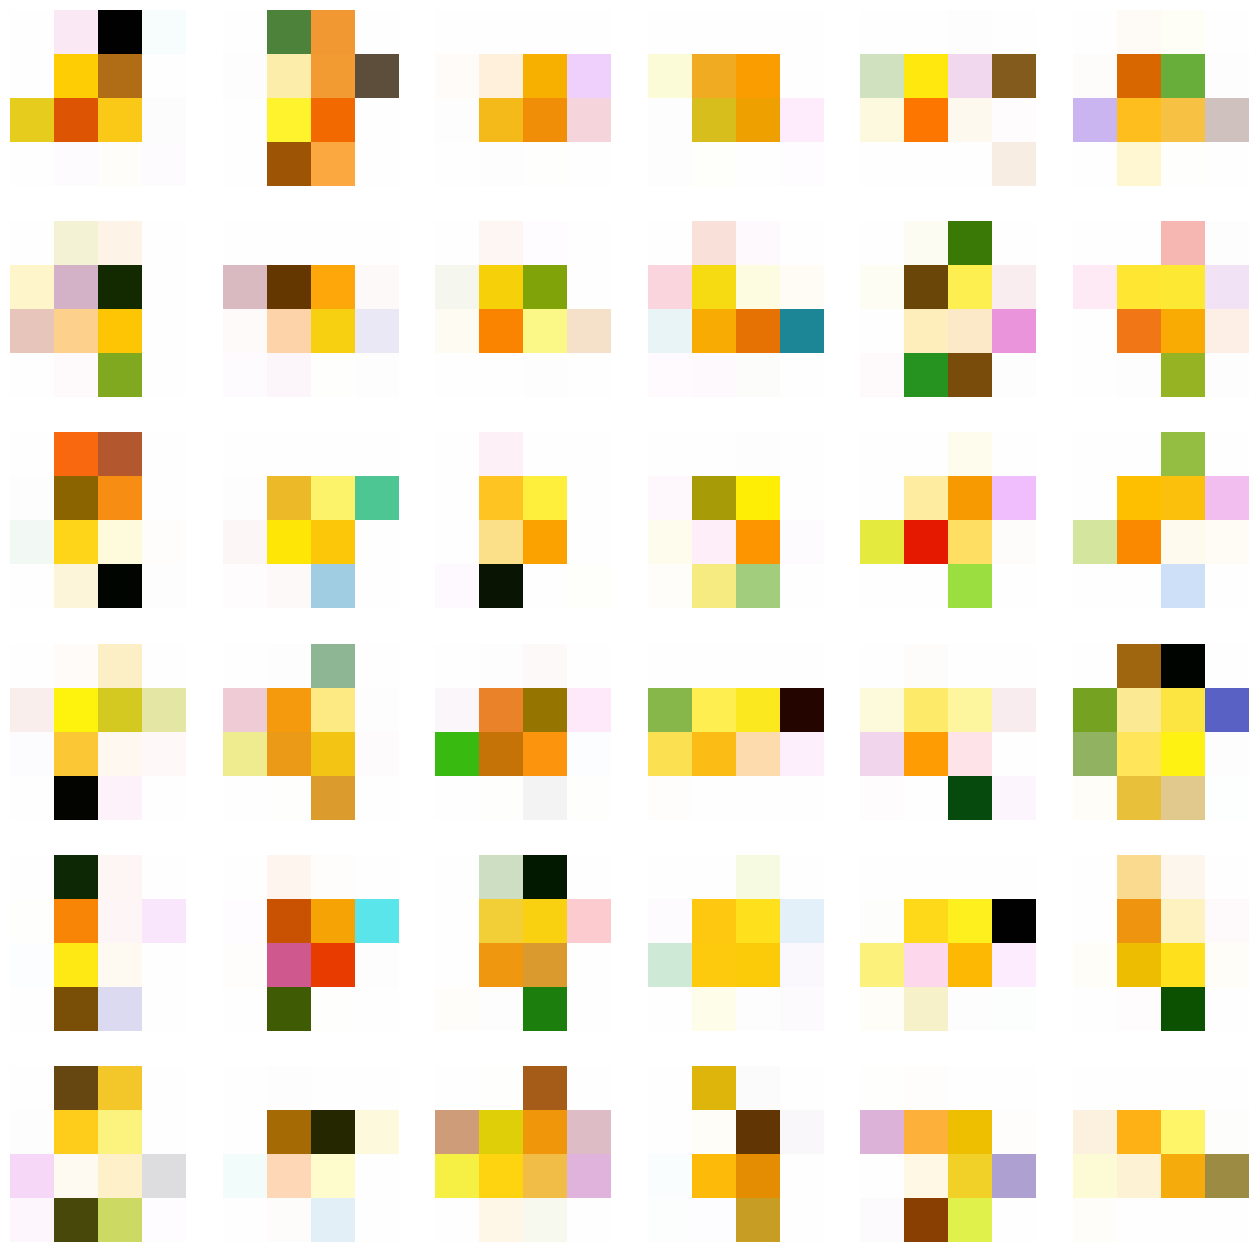

25/25 [==============================] - 15s 601ms/step - d_loss: -0.8345 - g_loss: 1.4650
Epoch 50/50
25/25 [==============================] - ETA: 0s - d_loss: -0.8315 - g_loss: 1.0156

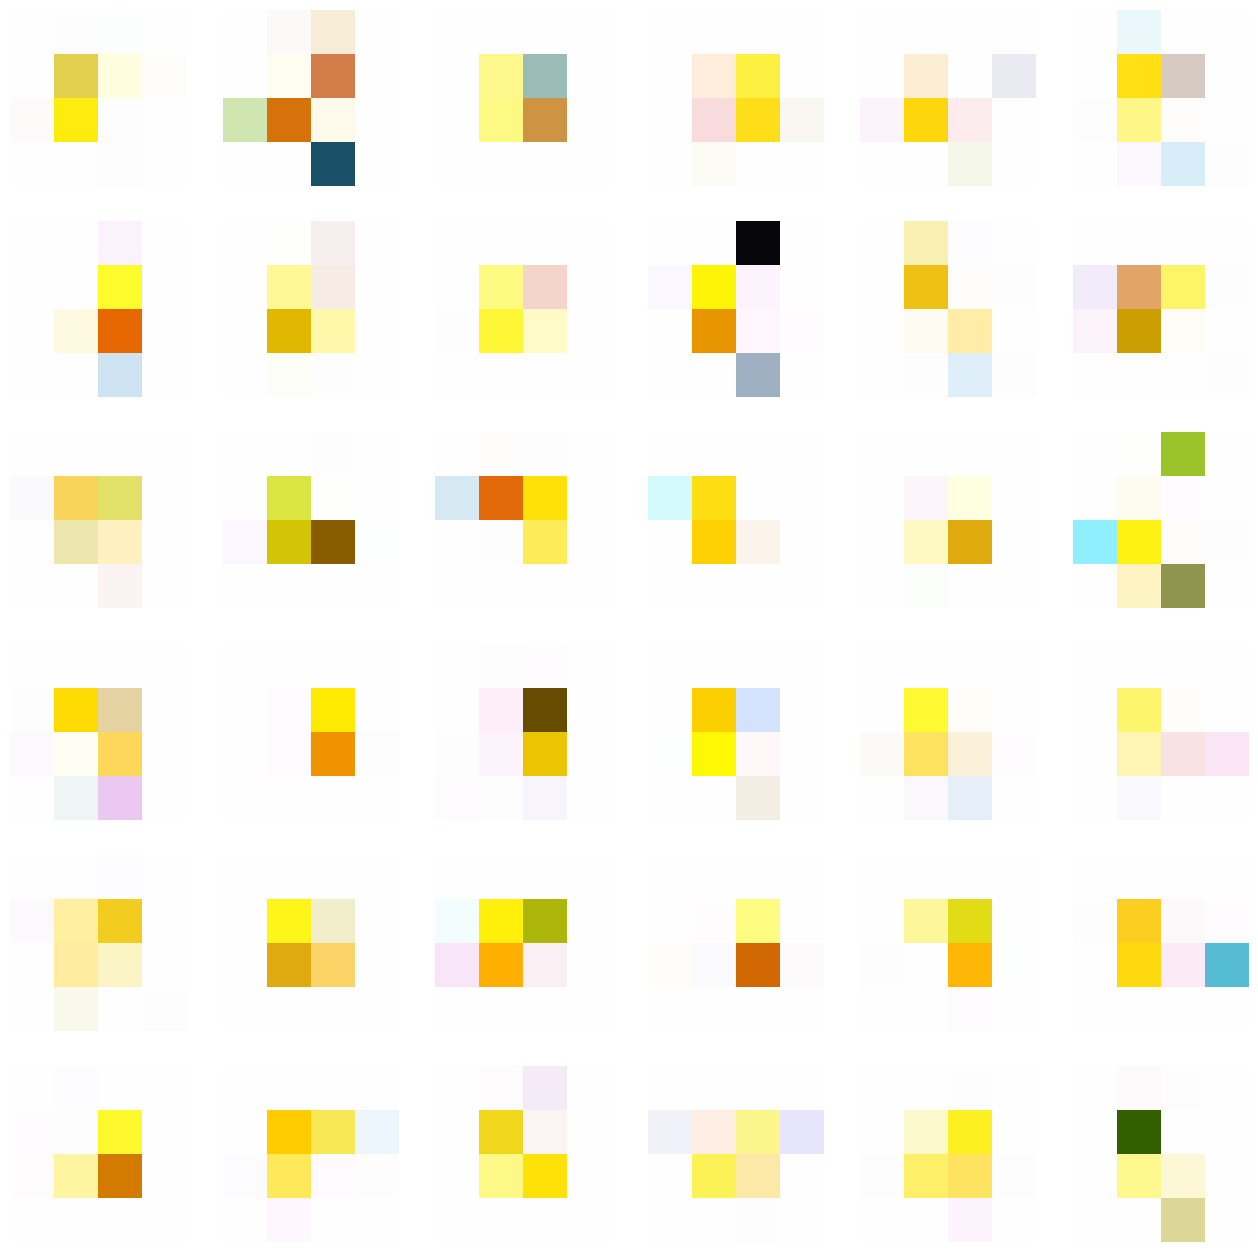

25/25 [==============================] - 16s 648ms/step - d_loss: -0.8245 - g_loss: 1.0275


In [89]:
train_dataset = create_dataset(4,BATCH_SIZE[0])
# generator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, beta_1=0.0, beta_2=0.99, epsilon=1e-8)
# discriminator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, beta_1=0.0, beta_2=0.99, epsilon=1e-8)
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.0, beta_2=0.99, epsilon=1e-8)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.0, beta_2=0.99, epsilon=1e-8)

pgan = ProGAN(
    latent_dim = NOISE_DIM,
    text_embedding_dim=256,
    d_steps = 1,
)

pgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
)

cbk=ShowImage('initial',4,latent_dim=512,steps_per_epoch=STEPS_PER_EPOCH,epochs=EPOCHS)
pgan.fit(train_dataset.take(STEPS_PER_EPOCH),epochs = EPOCHS, callbacks=[cbk])


Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_39 (InputLayer)       [(None, 512)]                0         []                            
                                                                                                  
 input_40 (InputLayer)       [(None, 256)]                0         []                            
                                                                                                  
 concatenate_17 (Concatenat  (None, 768)                  0         ['input_39[0][0]',            
 e)                                                                  'input_40[0][0]']            
                                                                                                  
 pixel_normalization_62 (Pi  (None, 768)                  0         ['concatenate_17[0][0]

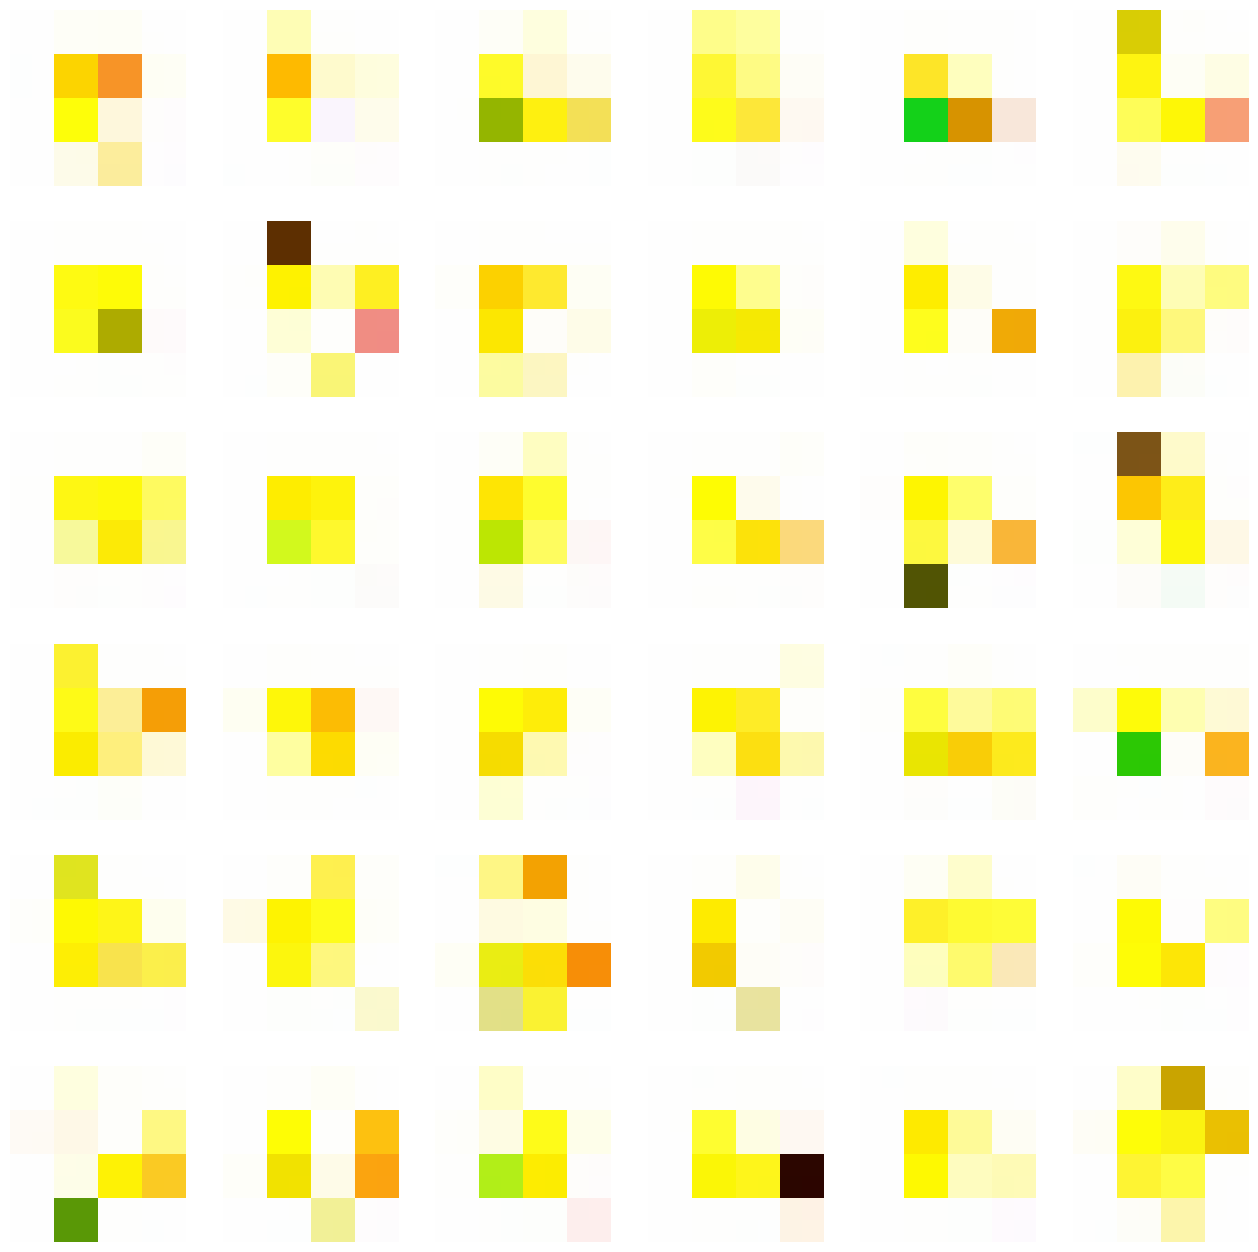

25/25 [==============================] - 43s 1s/step - d_loss: -0.0262 - g_loss: -0.4806
Epoch 2/50
25/25 [==============================] - ETA: 0s - d_loss: -0.9257 - g_loss: 2.6478

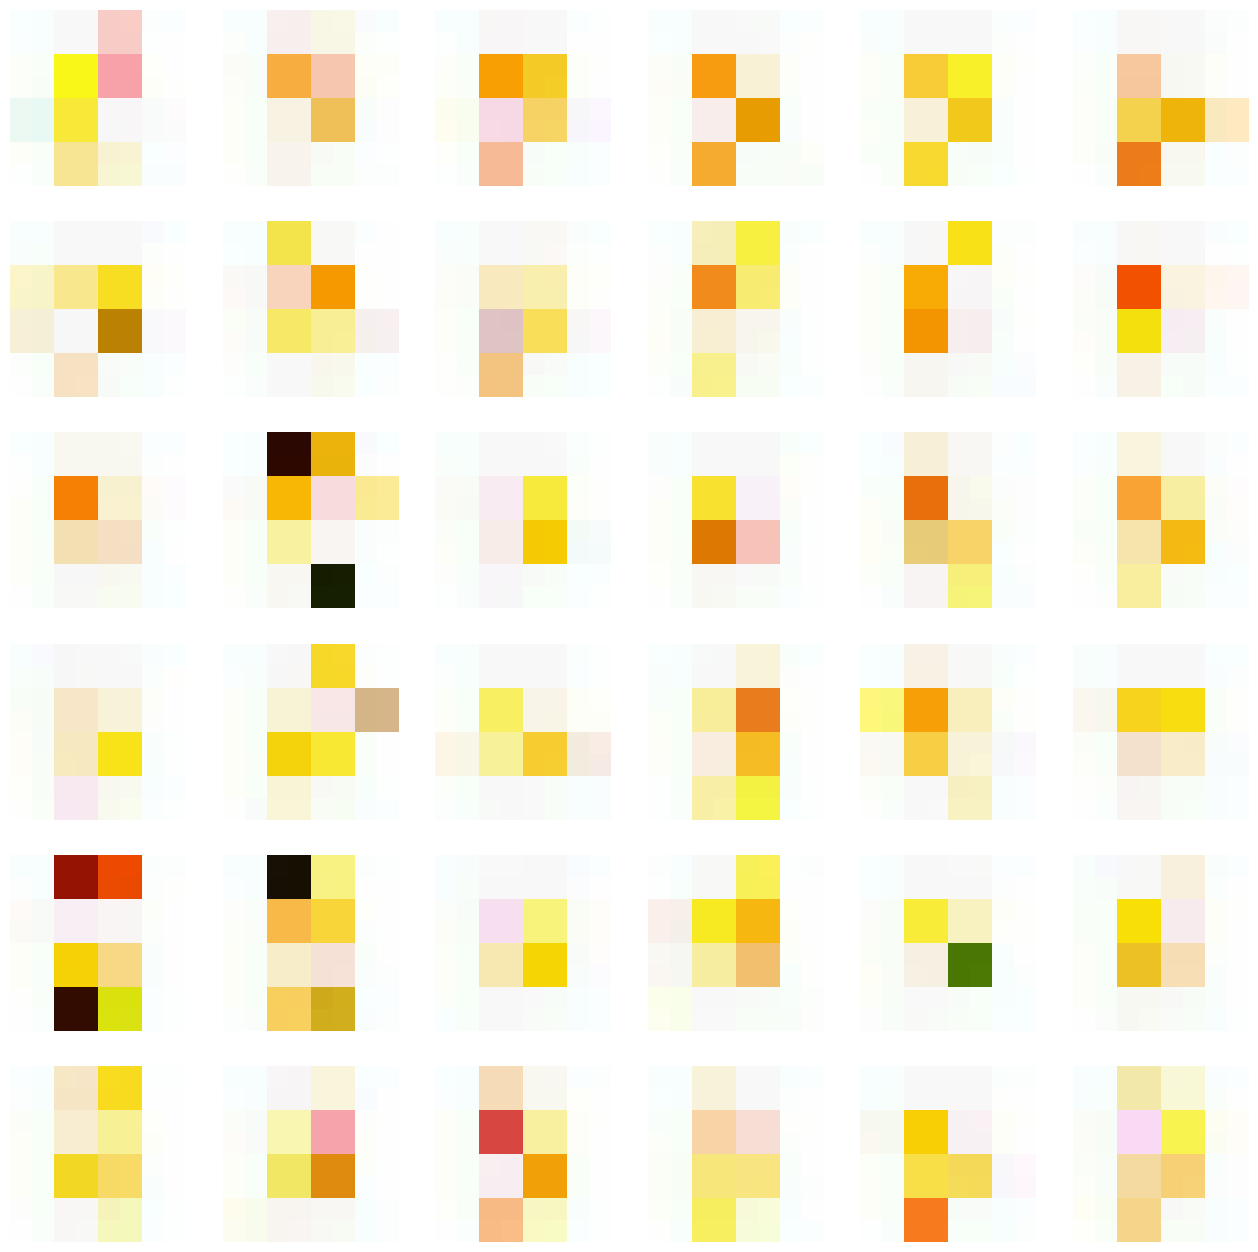

25/25 [==============================] - 36s 1s/step - d_loss: -0.9338 - g_loss: 2.7134
Epoch 3/50
25/25 [==============================] - ETA: 0s - d_loss: -1.4994 - g_loss: 3.6082

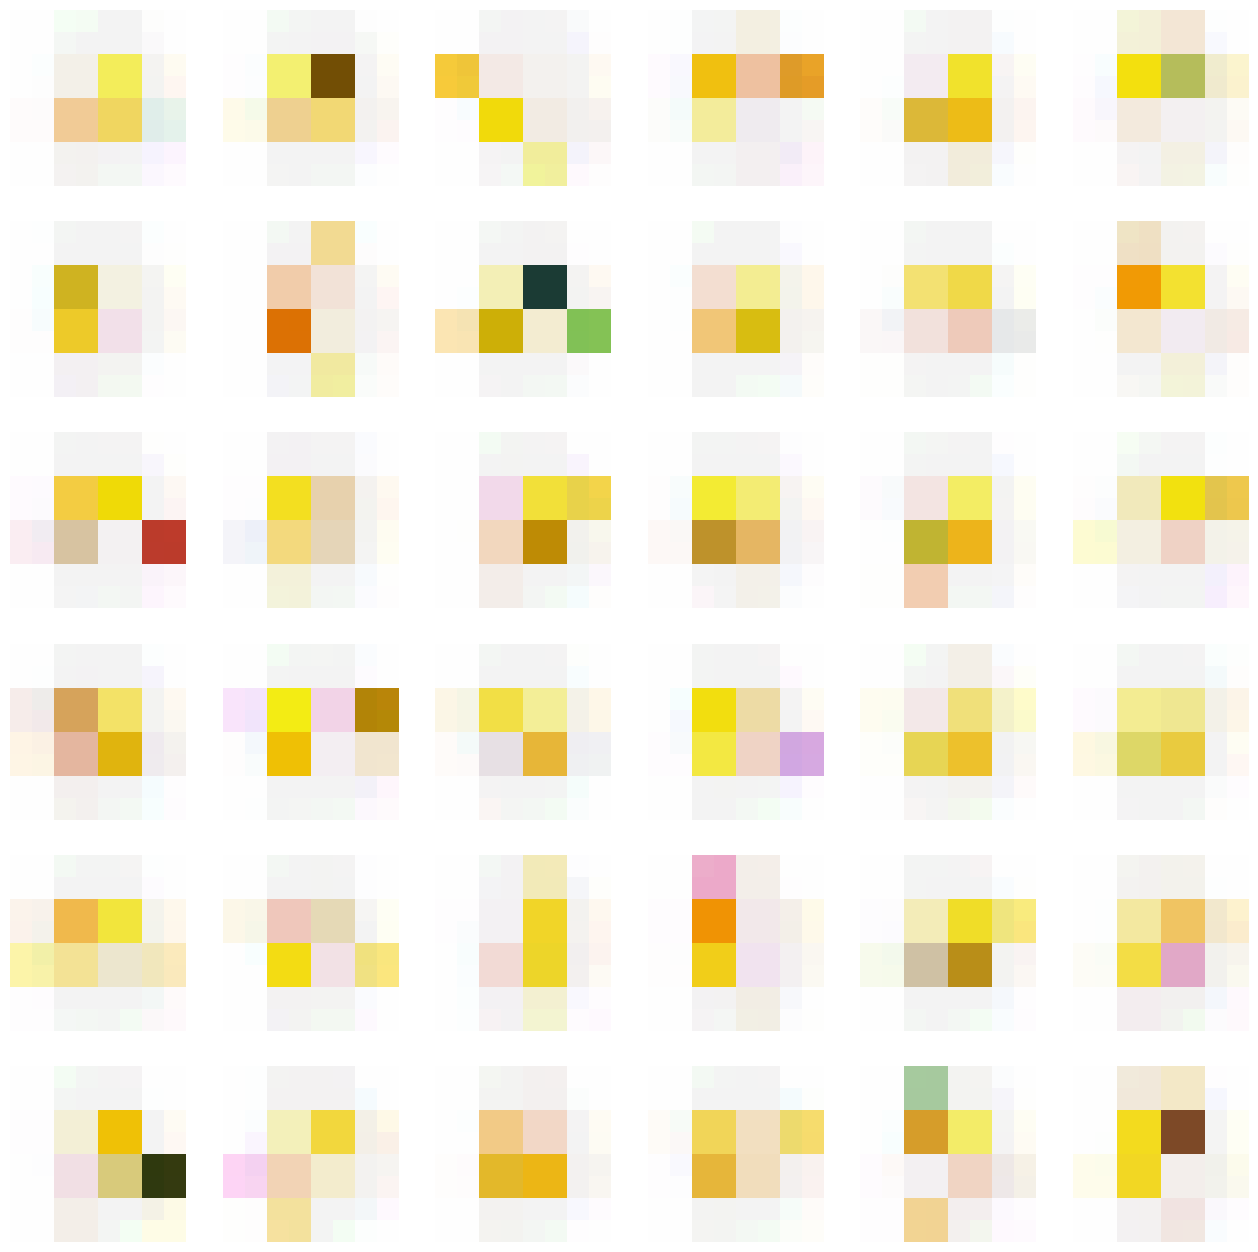

25/25 [==============================] - 37s 1s/step - d_loss: -1.5257 - g_loss: 3.5534
Epoch 4/50
25/25 [==============================] - ETA: 0s - d_loss: -3.1063 - g_loss: 3.0322

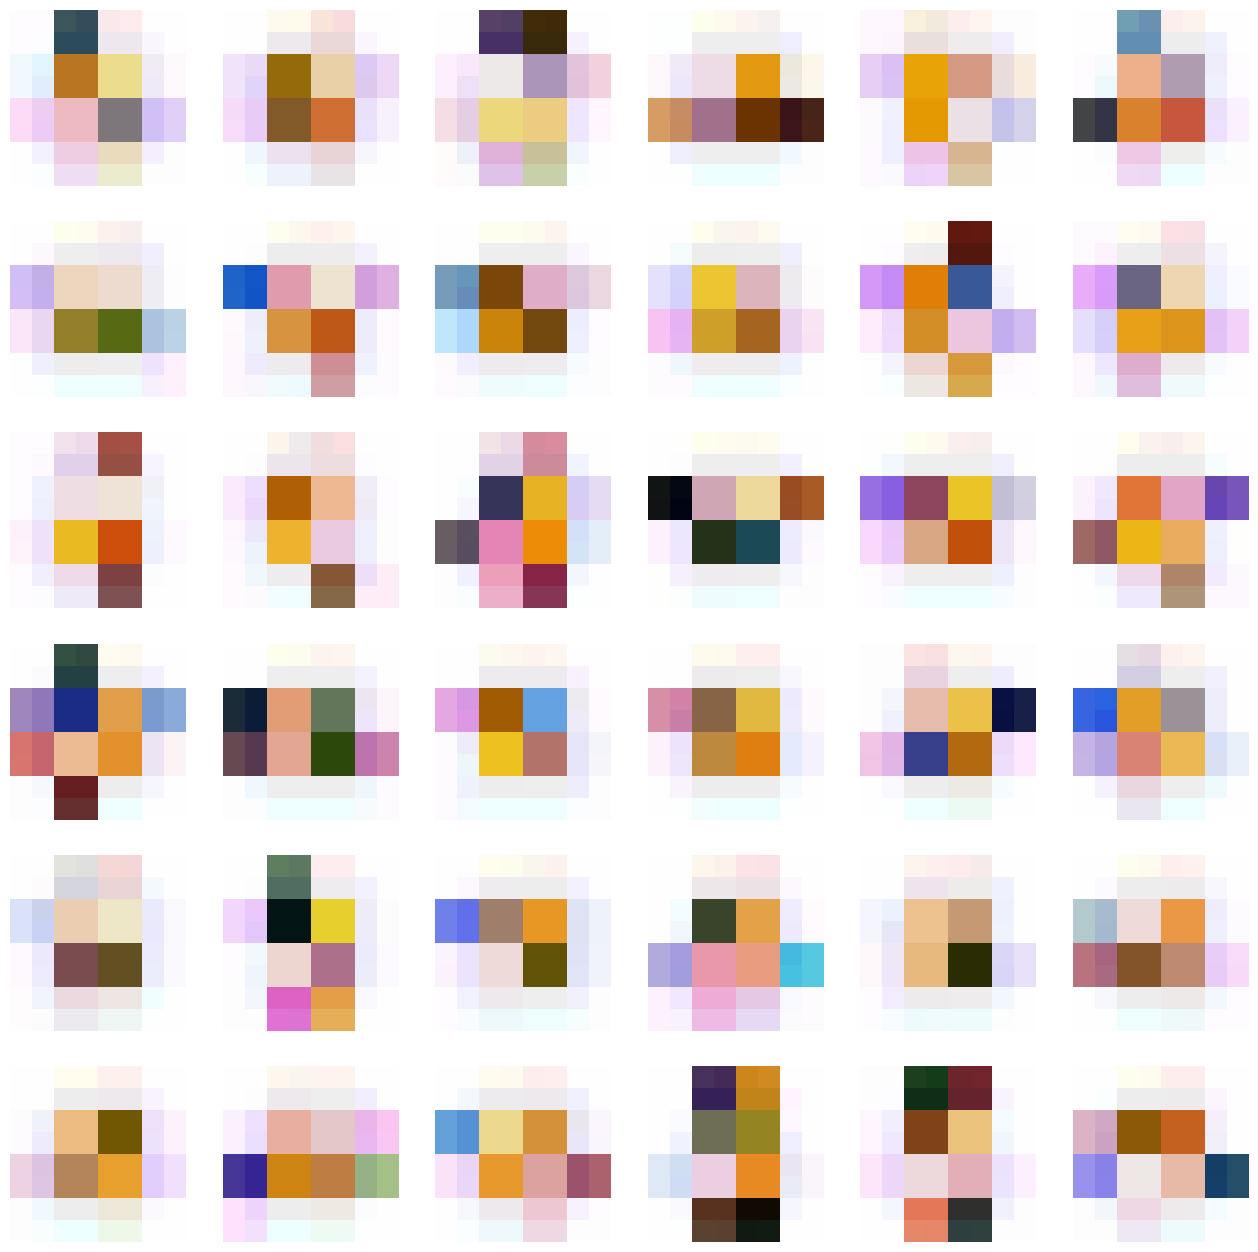

25/25 [==============================] - 36s 1s/step - d_loss: -3.1162 - g_loss: 2.9630
Epoch 5/50
25/25 [==============================] - ETA: 0s - d_loss: -3.7773 - g_loss: 3.7739

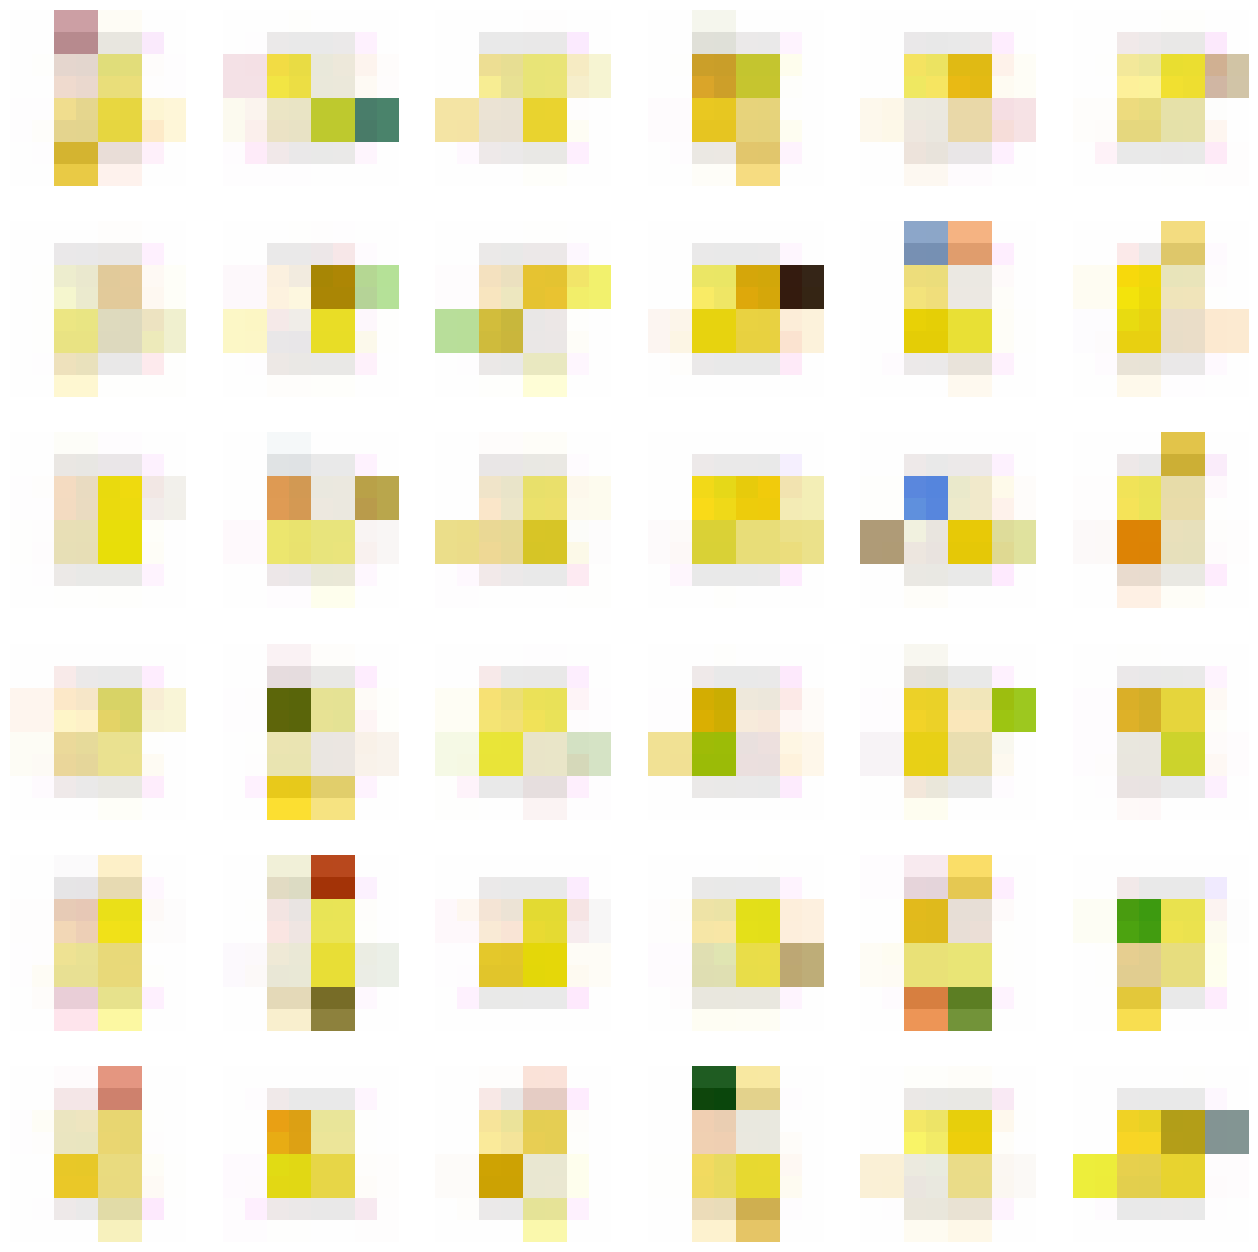

25/25 [==============================] - 36s 1s/step - d_loss: -3.8575 - g_loss: 3.9546
Epoch 6/50
25/25 [==============================] - ETA: 0s - d_loss: -3.6867 - g_loss: 5.8069

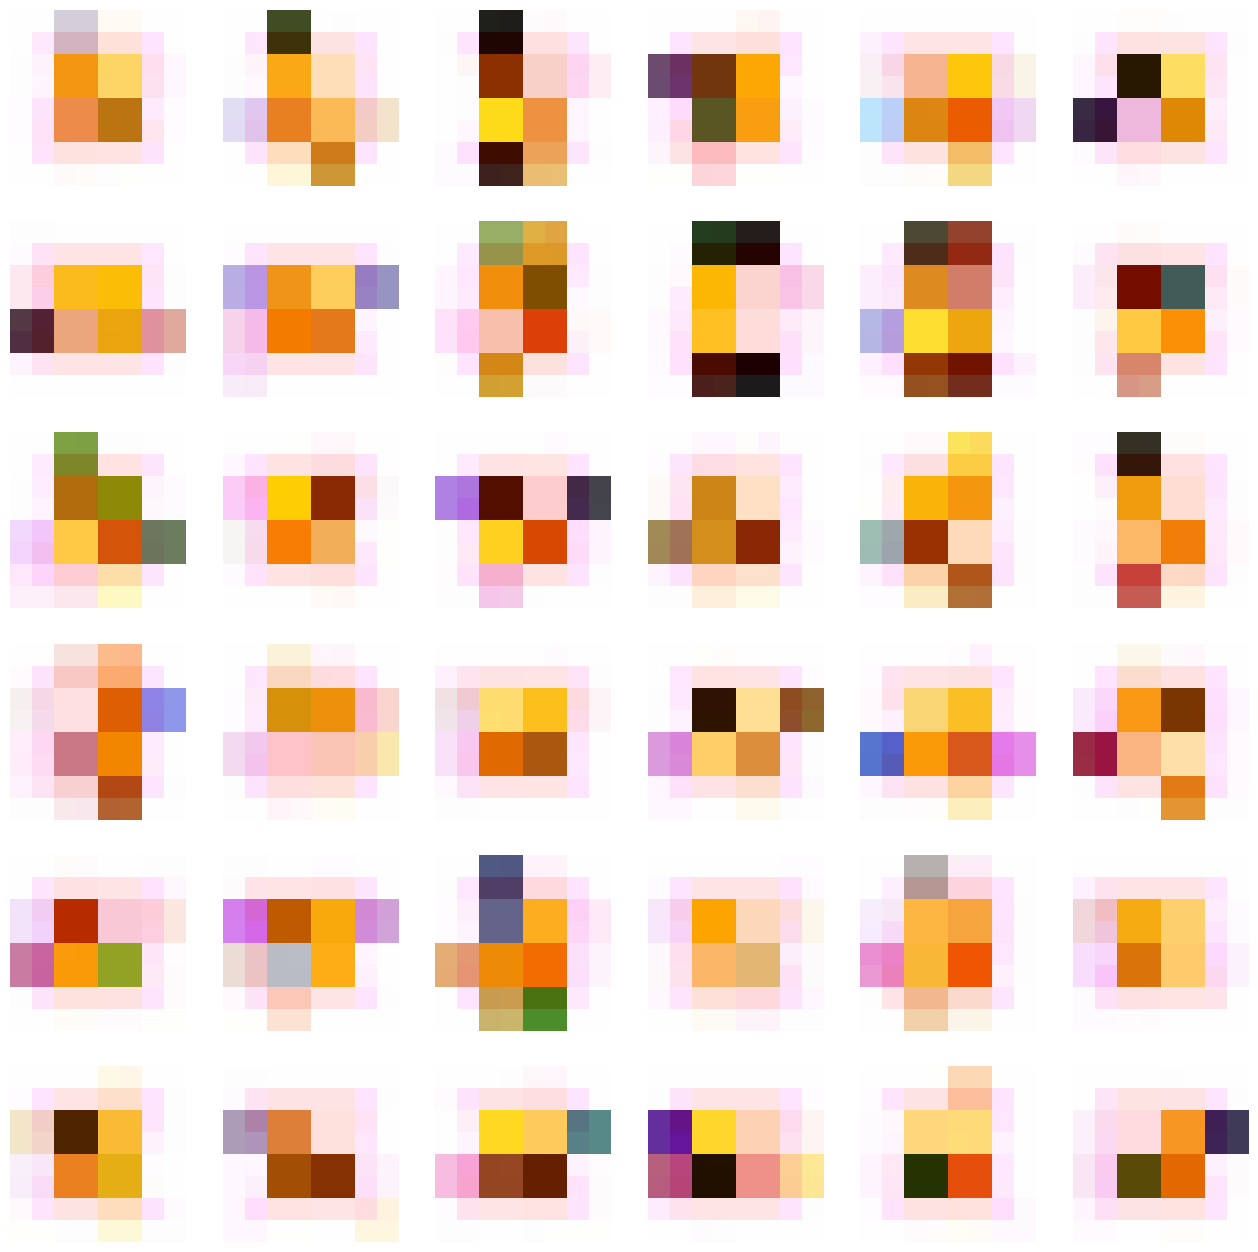

25/25 [==============================] - 36s 1s/step - d_loss: -3.6855 - g_loss: 6.0076
Epoch 7/50
25/25 [==============================] - ETA: 0s - d_loss: -3.8160 - g_loss: 5.8933

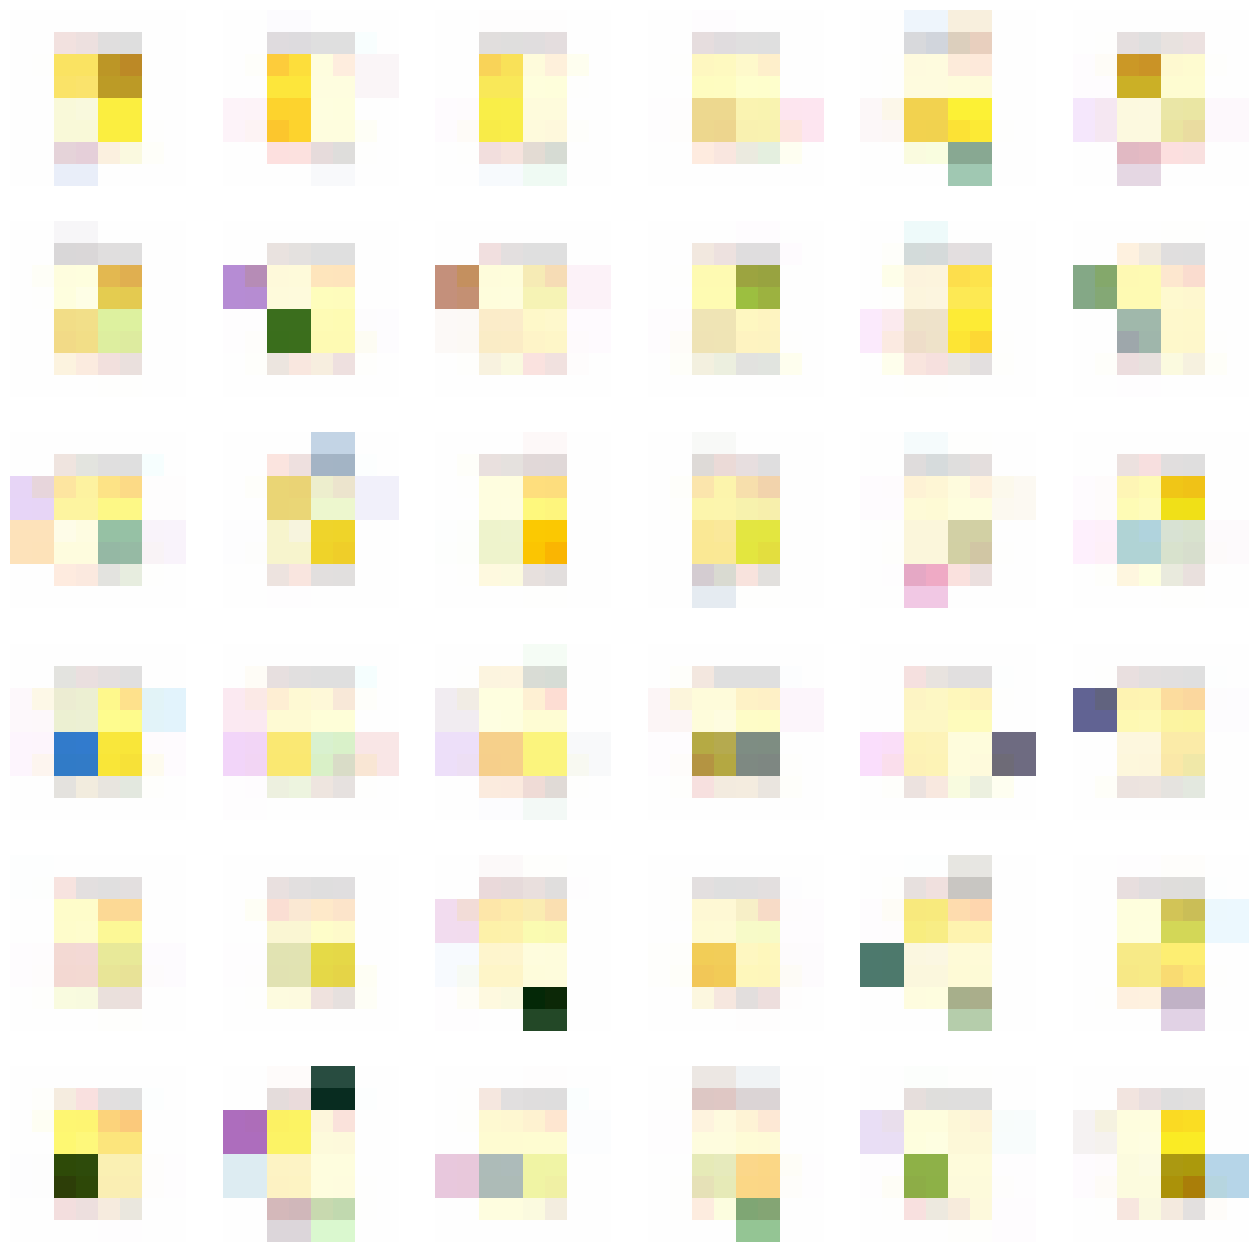

25/25 [==============================] - 36s 1s/step - d_loss: -3.7988 - g_loss: 5.7394
Epoch 8/50
25/25 [==============================] - ETA: 0s - d_loss: -3.8030 - g_loss: 7.1175

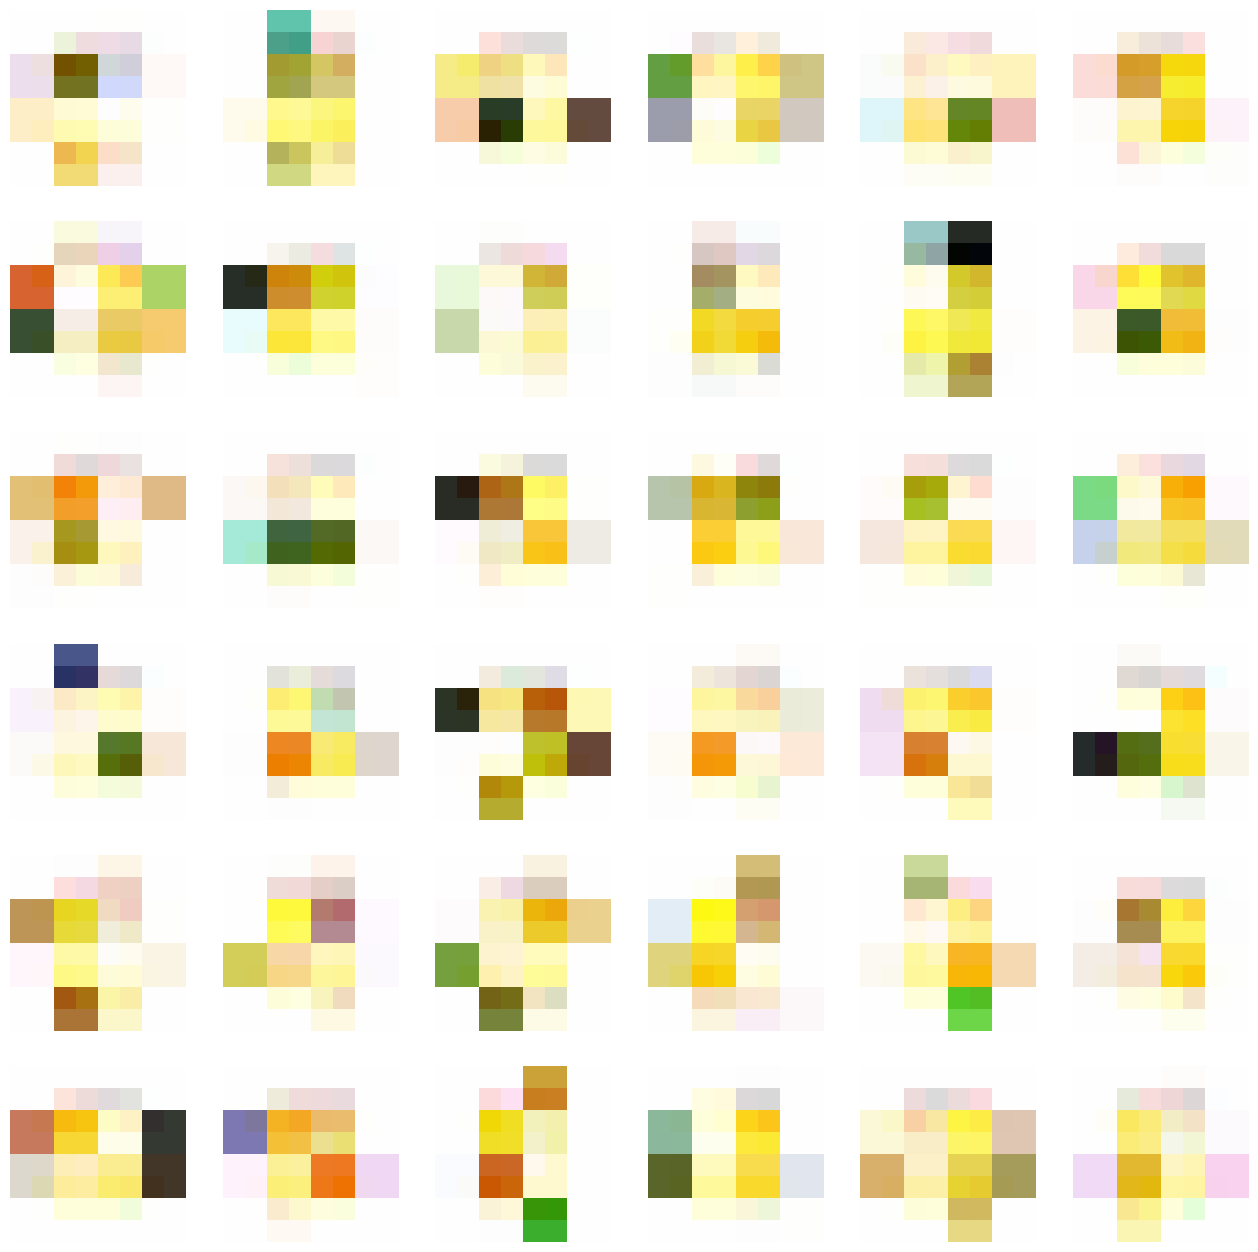

25/25 [==============================] - 37s 1s/step - d_loss: -3.8000 - g_loss: 6.8987
Epoch 9/50
25/25 [==============================] - ETA: 0s - d_loss: -3.8943 - g_loss: 8.1248

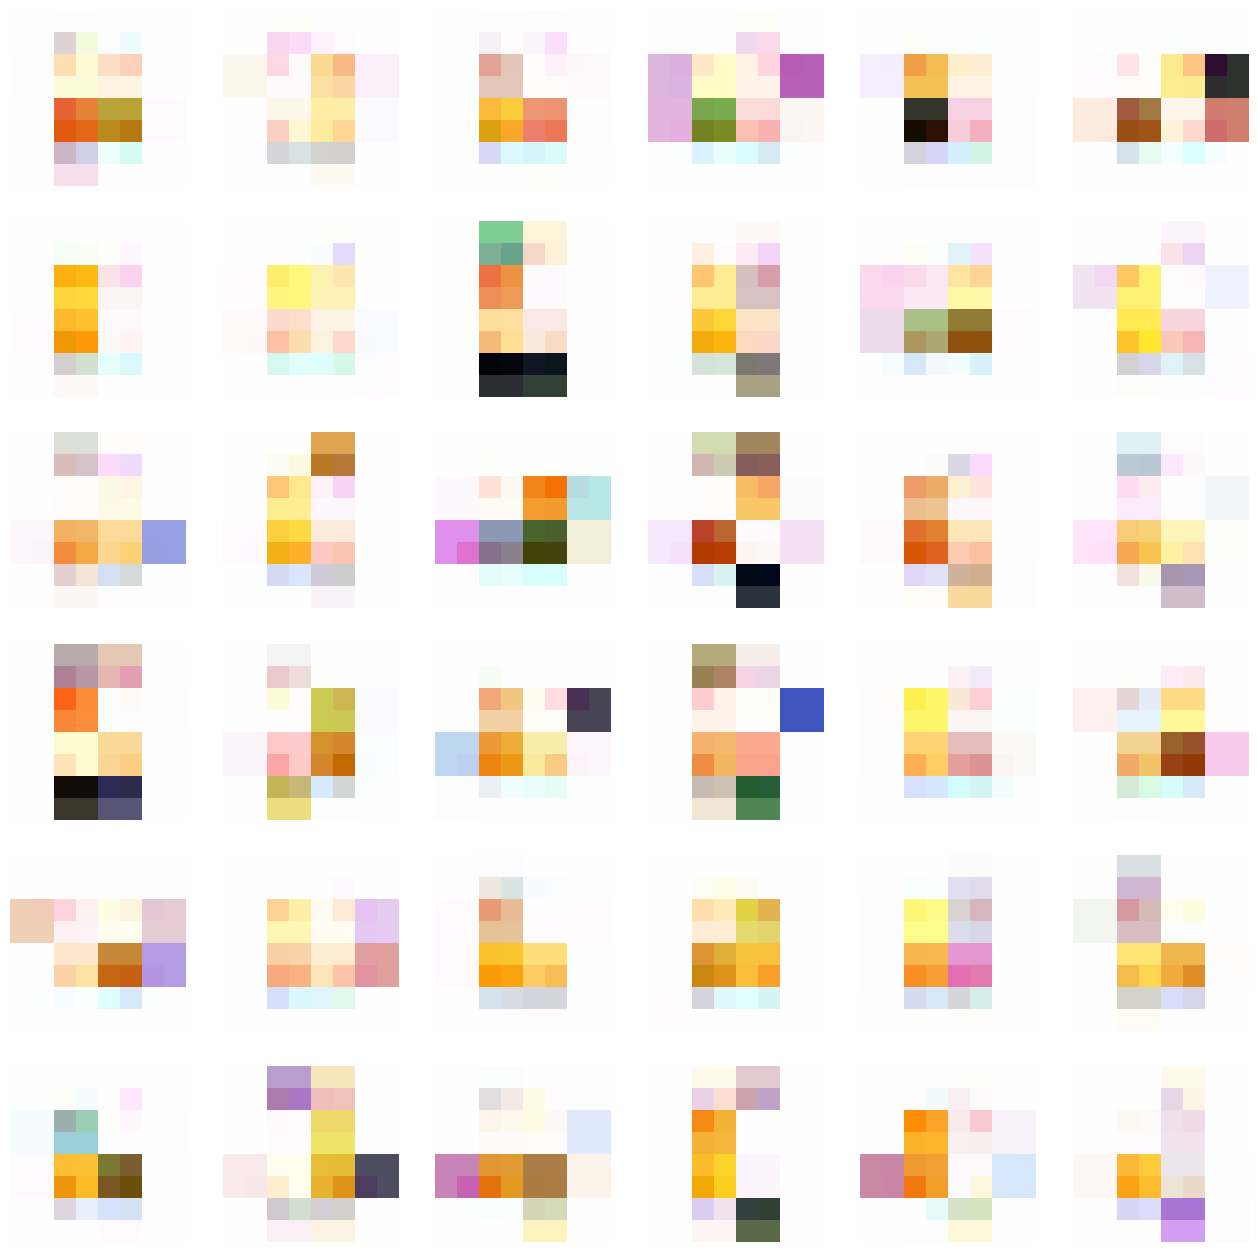

25/25 [==============================] - 36s 1s/step - d_loss: -3.9462 - g_loss: 8.1691
Epoch 10/50
25/25 [==============================] - ETA: 0s - d_loss: -3.8938 - g_loss: 9.3713

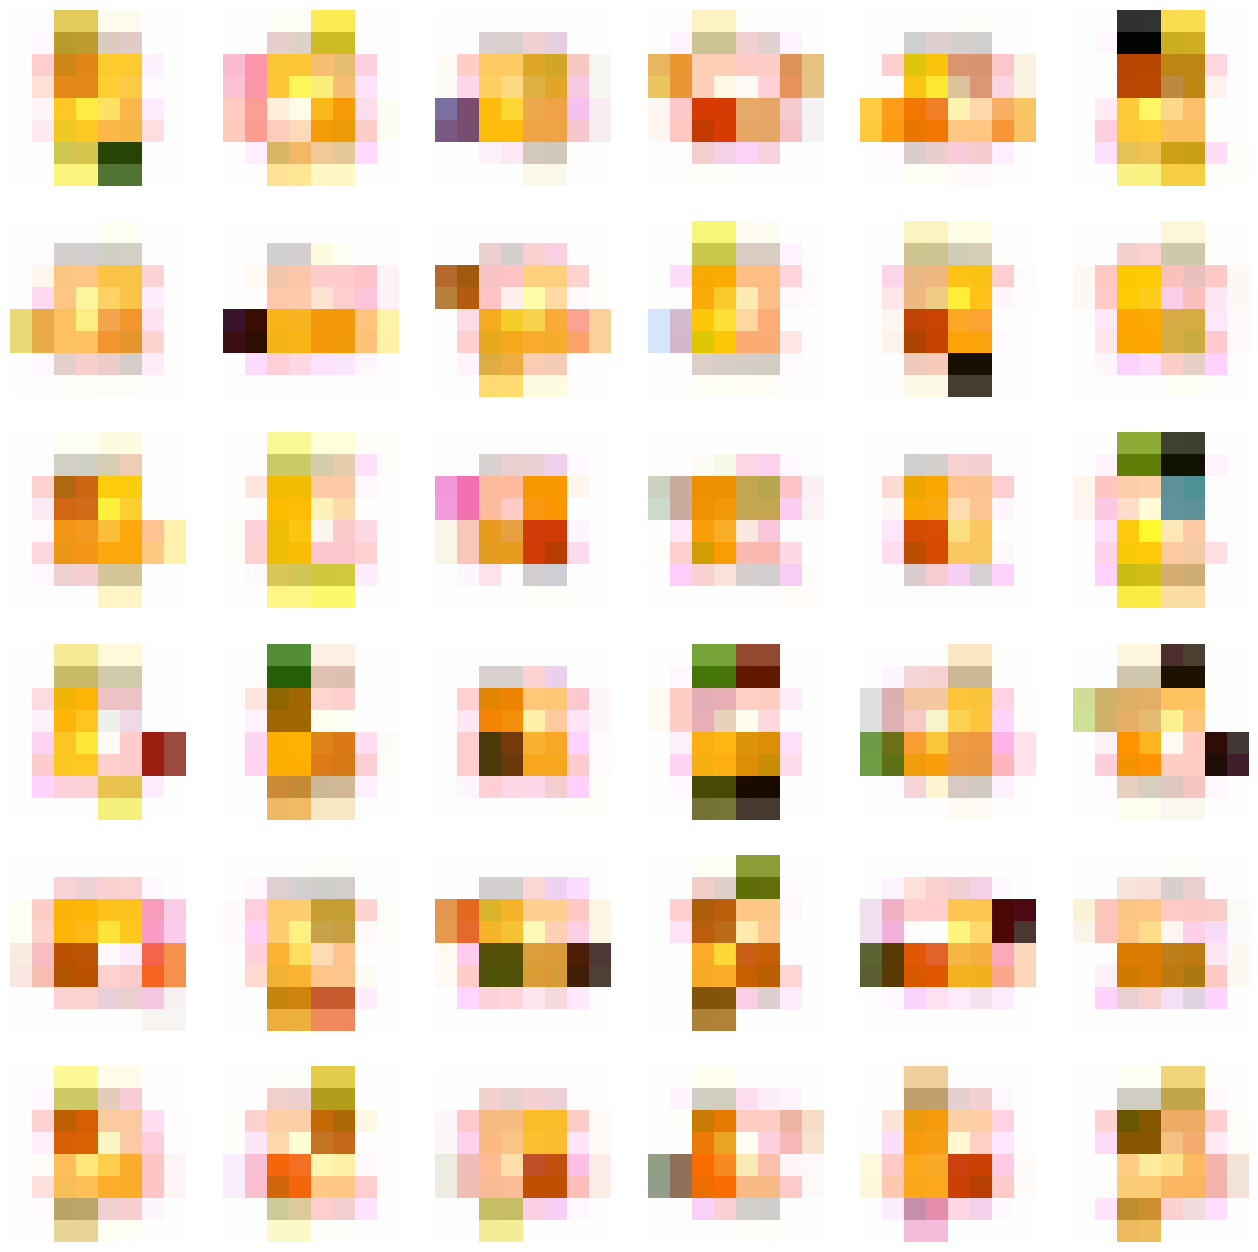

25/25 [==============================] - 36s 1s/step - d_loss: -3.8386 - g_loss: 9.5406
Epoch 11/50
25/25 [==============================] - ETA: 0s - d_loss: -3.8305 - g_loss: 7.9249

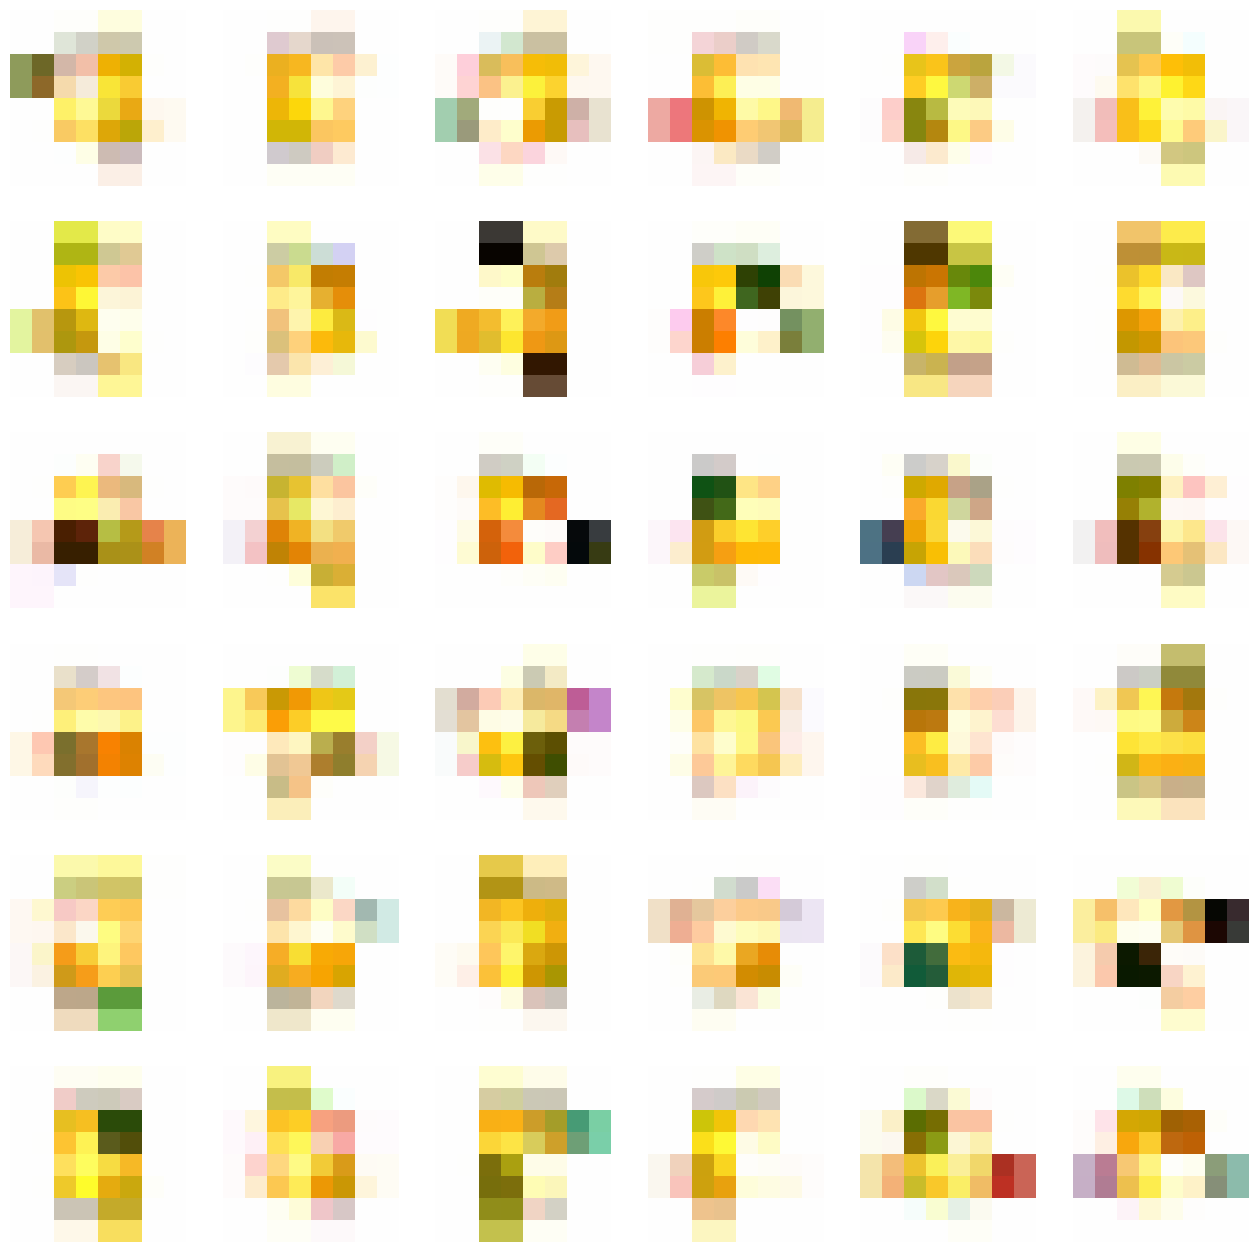

25/25 [==============================] - 36s 1s/step - d_loss: -3.7906 - g_loss: 7.7998
Epoch 12/50
25/25 [==============================] - ETA: 0s - d_loss: -3.7489 - g_loss: 7.4765

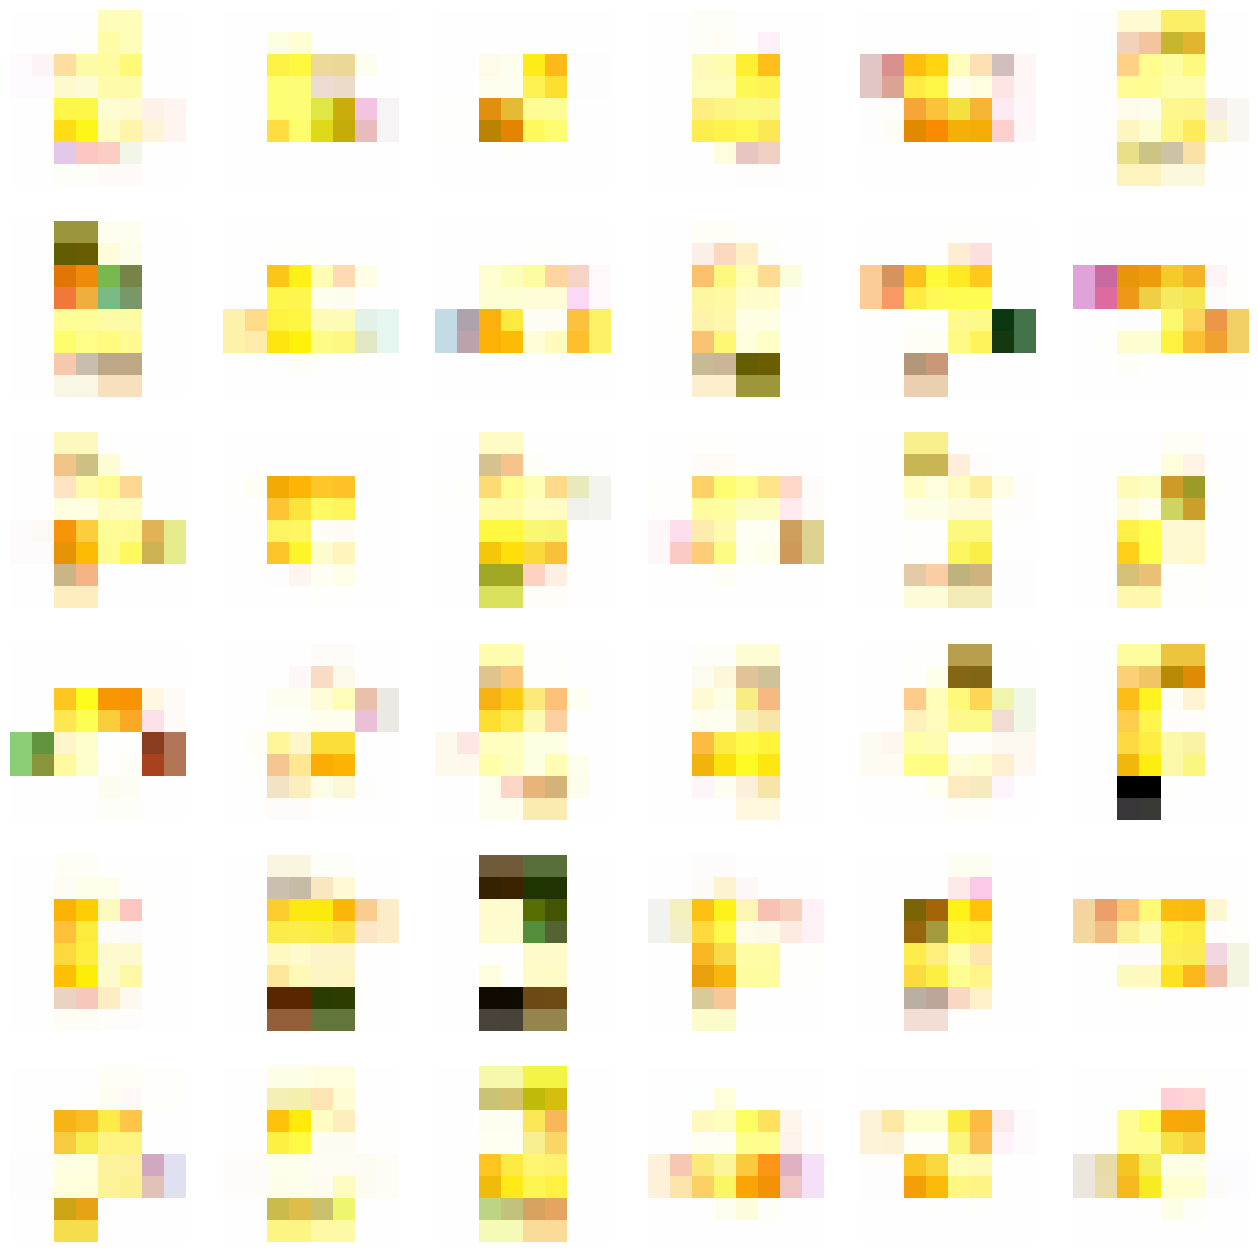

25/25 [==============================] - 37s 1s/step - d_loss: -3.7534 - g_loss: 7.4127
Epoch 13/50
25/25 [==============================] - ETA: 0s - d_loss: -3.7344 - g_loss: 7.0044

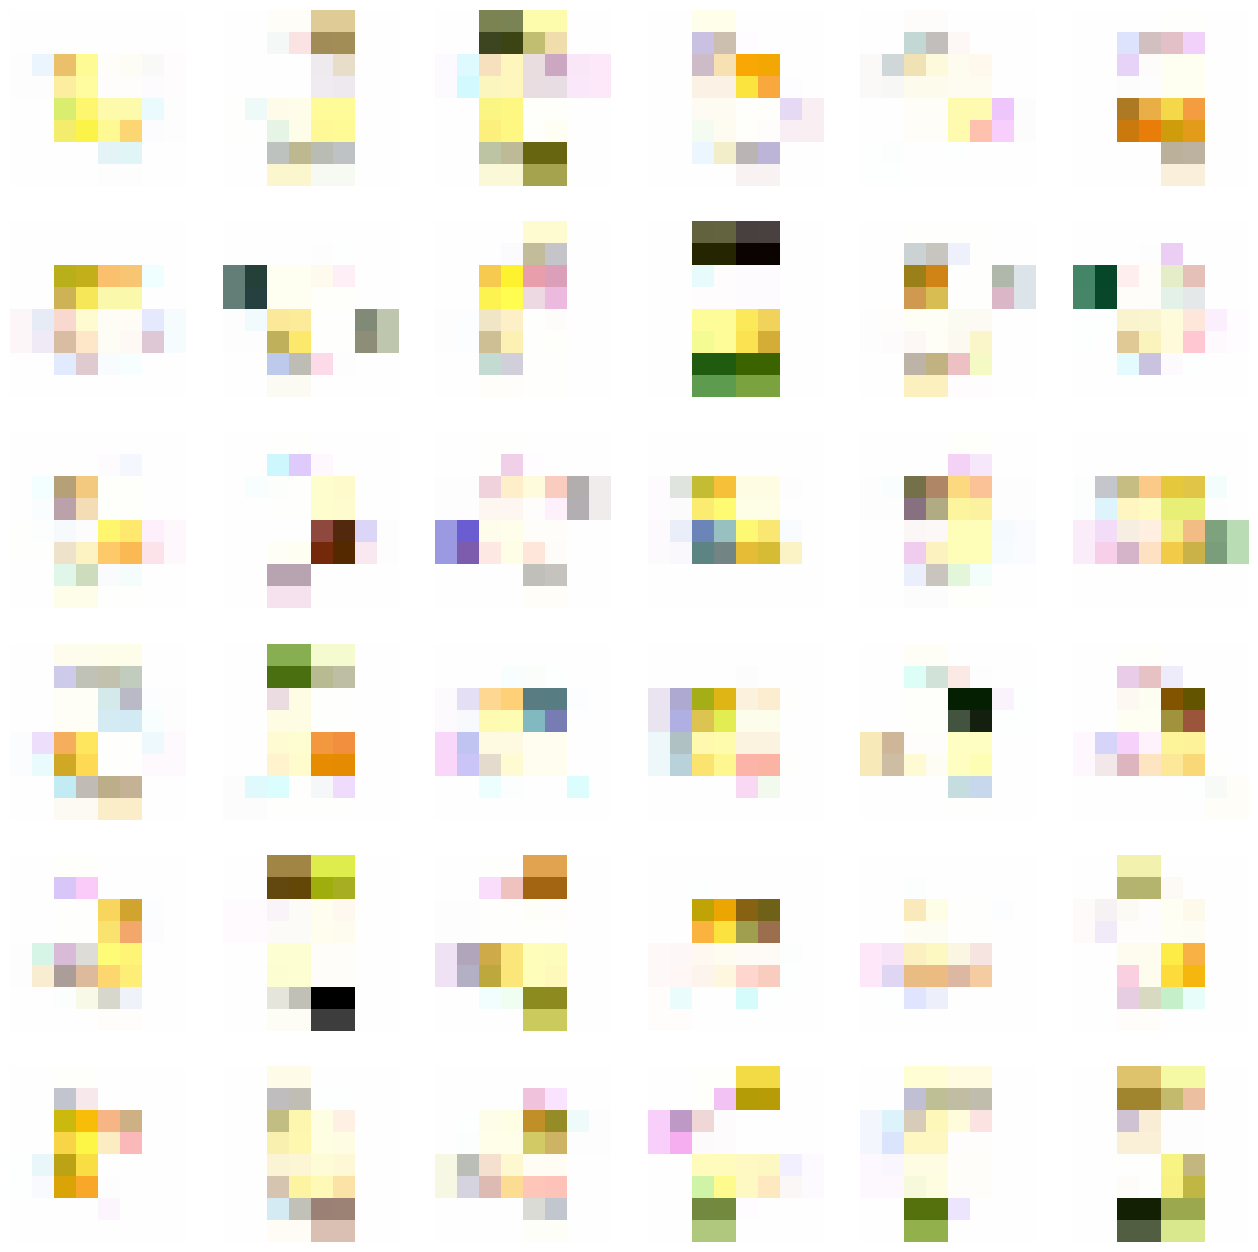

25/25 [==============================] - 36s 1s/step - d_loss: -3.7265 - g_loss: 7.1021
Epoch 14/50
25/25 [==============================] - ETA: 0s - d_loss: -3.6470 - g_loss: 5.5313

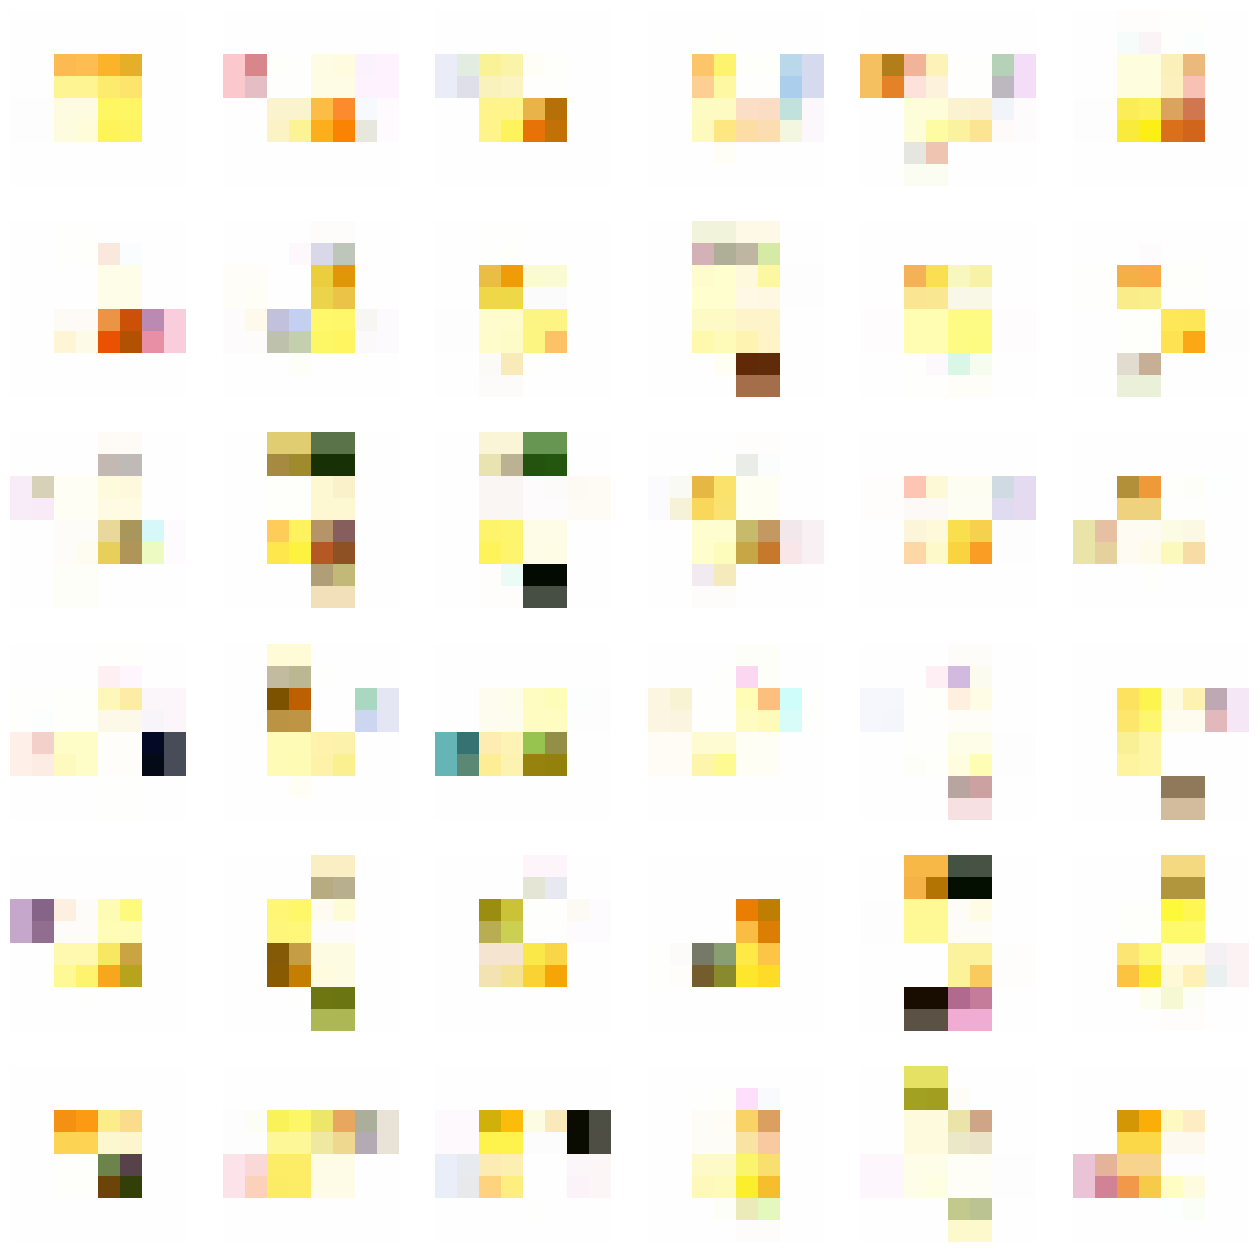

25/25 [==============================] - 36s 1s/step - d_loss: -3.6290 - g_loss: 5.7009
Epoch 15/50
25/25 [==============================] - ETA: 0s - d_loss: -3.6303 - g_loss: 6.4182

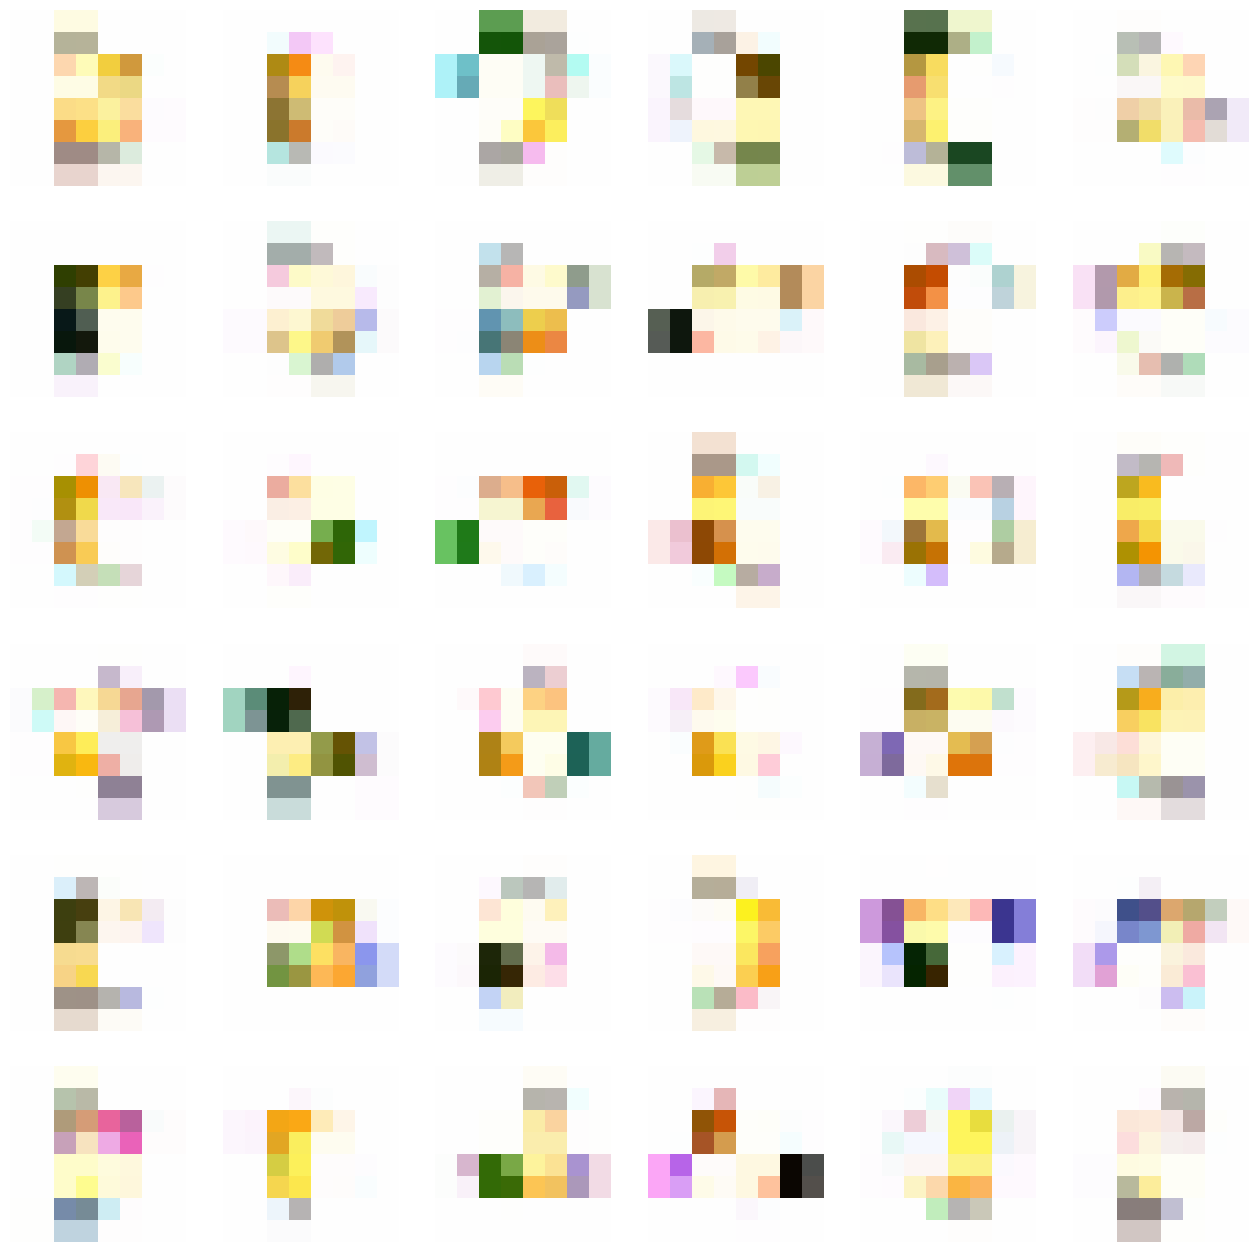

25/25 [==============================] - 36s 1s/step - d_loss: -3.6169 - g_loss: 6.4841
Epoch 16/50
25/25 [==============================] - ETA: 0s - d_loss: -3.7033 - g_loss: 6.4154

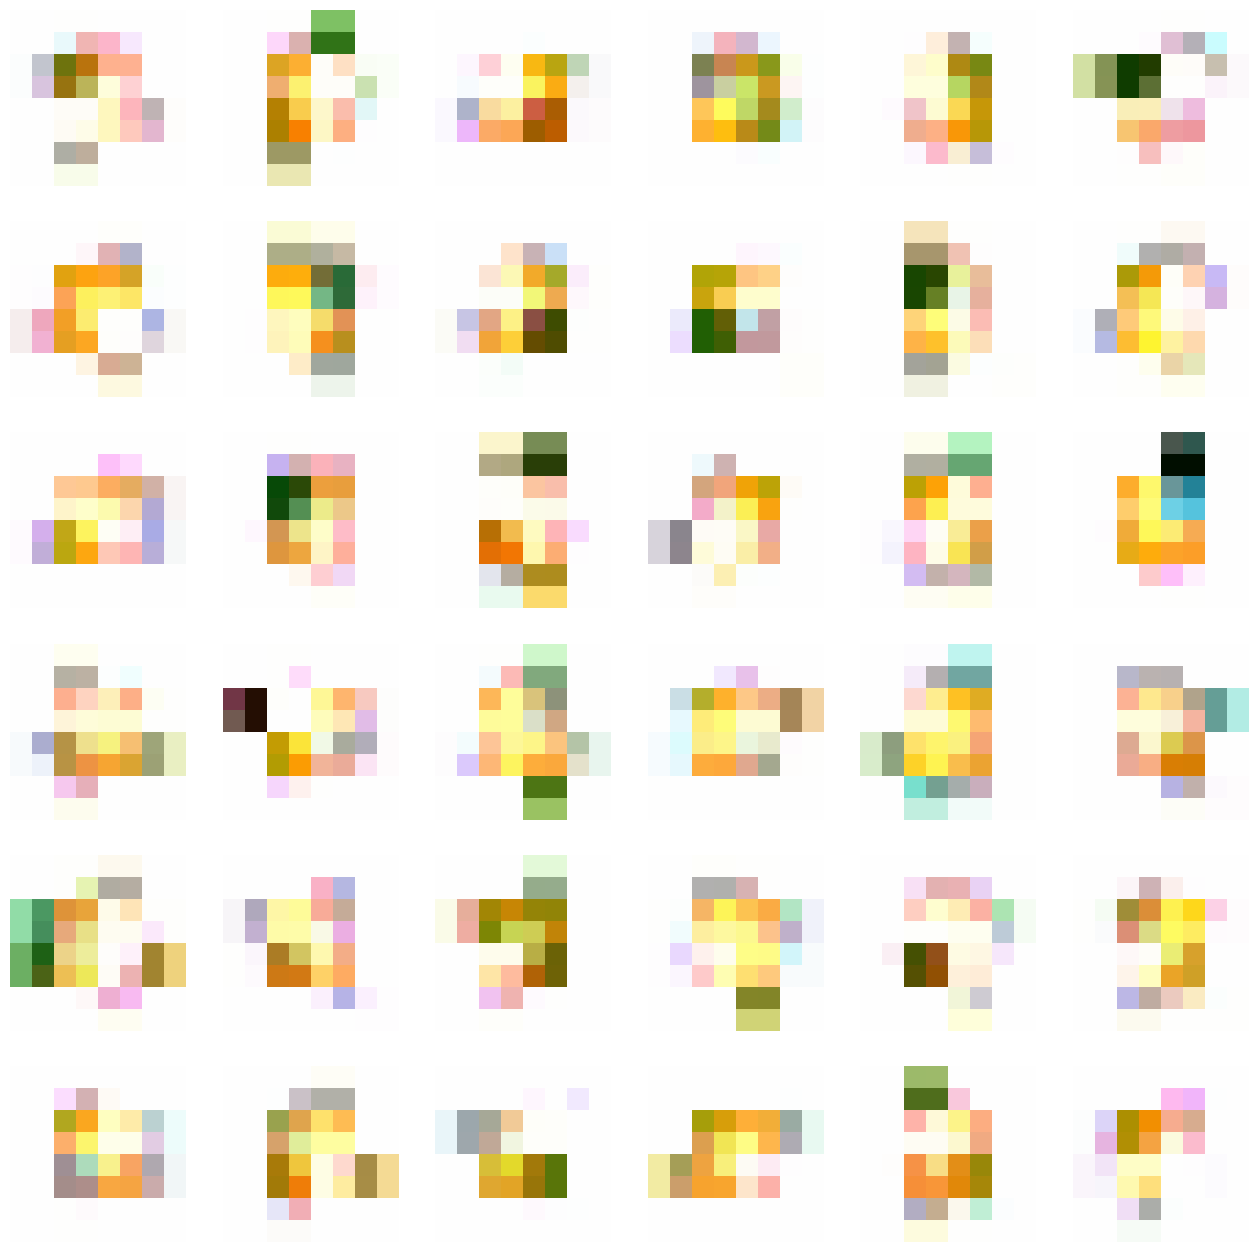

25/25 [==============================] - 36s 1s/step - d_loss: -3.7124 - g_loss: 6.6454
Epoch 17/50
25/25 [==============================] - ETA: 0s - d_loss: -3.5950 - g_loss: 4.9766

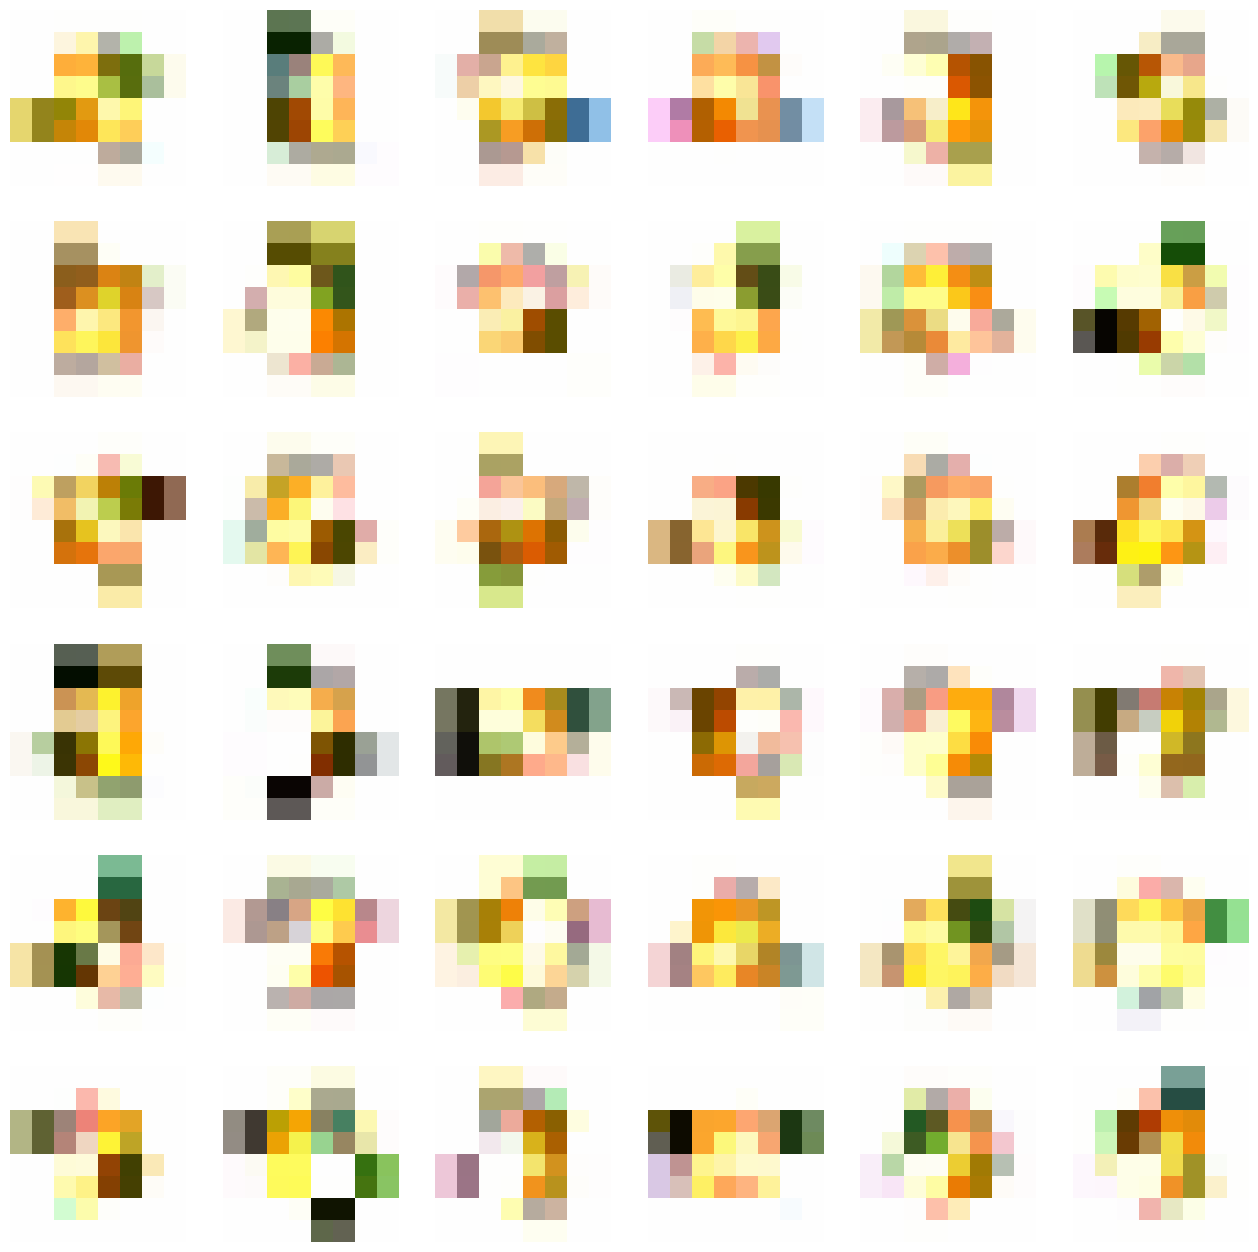

25/25 [==============================] - 37s 2s/step - d_loss: -3.5762 - g_loss: 5.2645
Epoch 18/50
25/25 [==============================] - ETA: 0s - d_loss: -3.4621 - g_loss: 4.4007

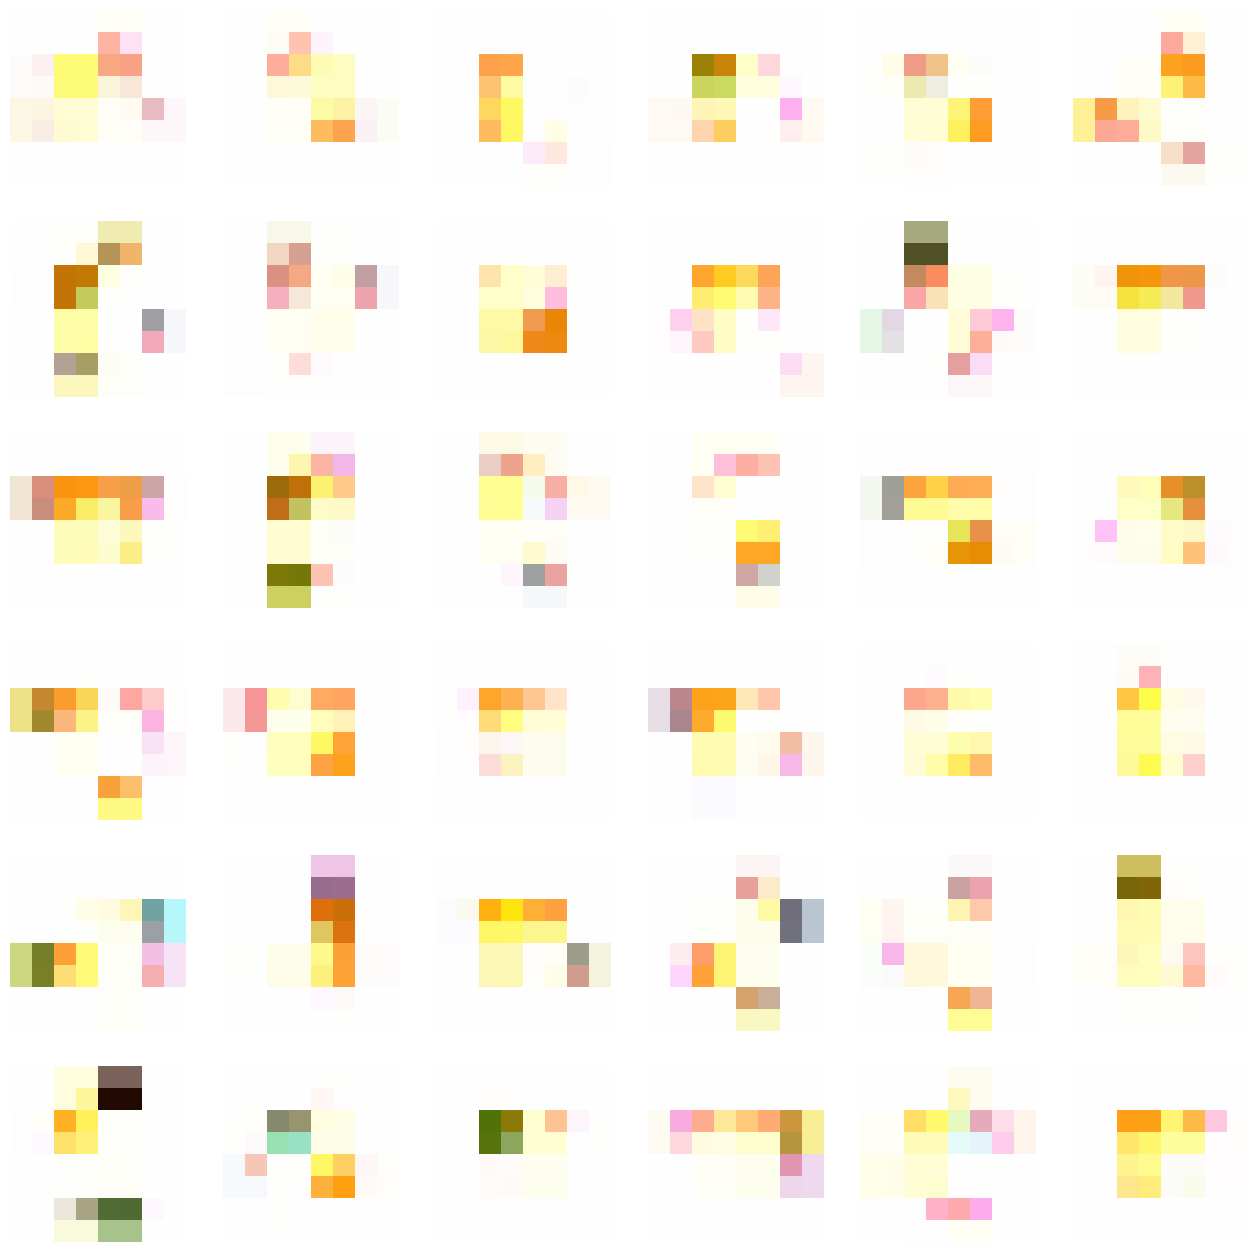

25/25 [==============================] - 36s 1s/step - d_loss: -3.4198 - g_loss: 4.4430
Epoch 19/50
25/25 [==============================] - ETA: 0s - d_loss: -3.4423 - g_loss: 4.9596

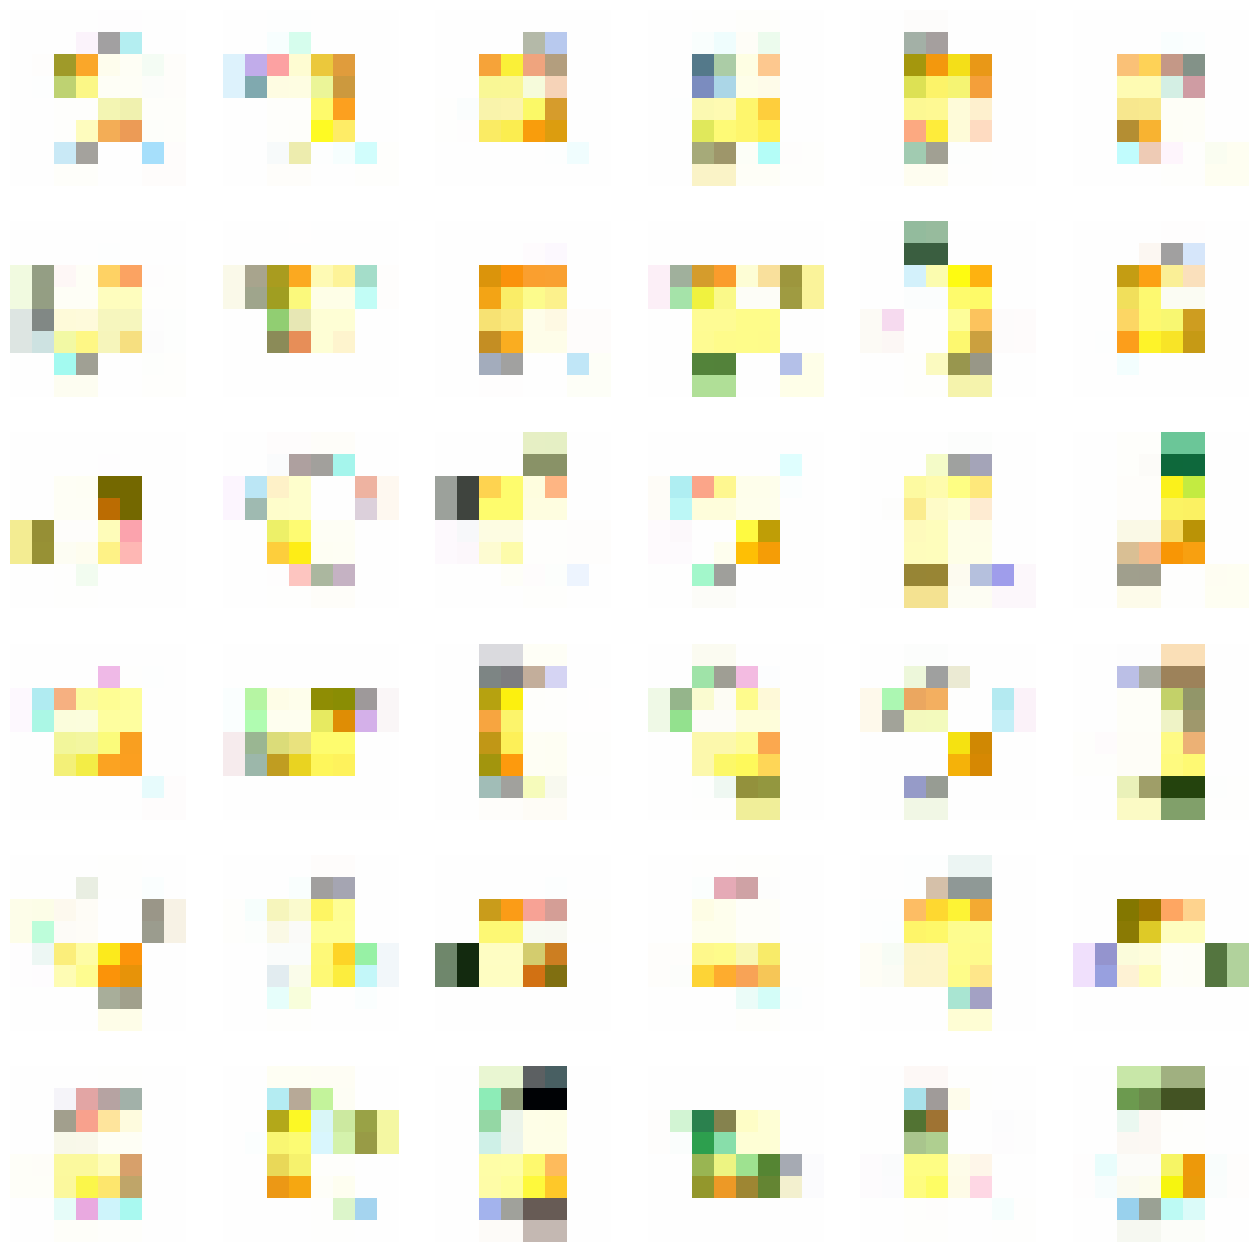

25/25 [==============================] - 36s 1s/step - d_loss: -3.4377 - g_loss: 4.8302
Epoch 20/50
25/25 [==============================] - ETA: 0s - d_loss: -3.4536 - g_loss: 4.4445

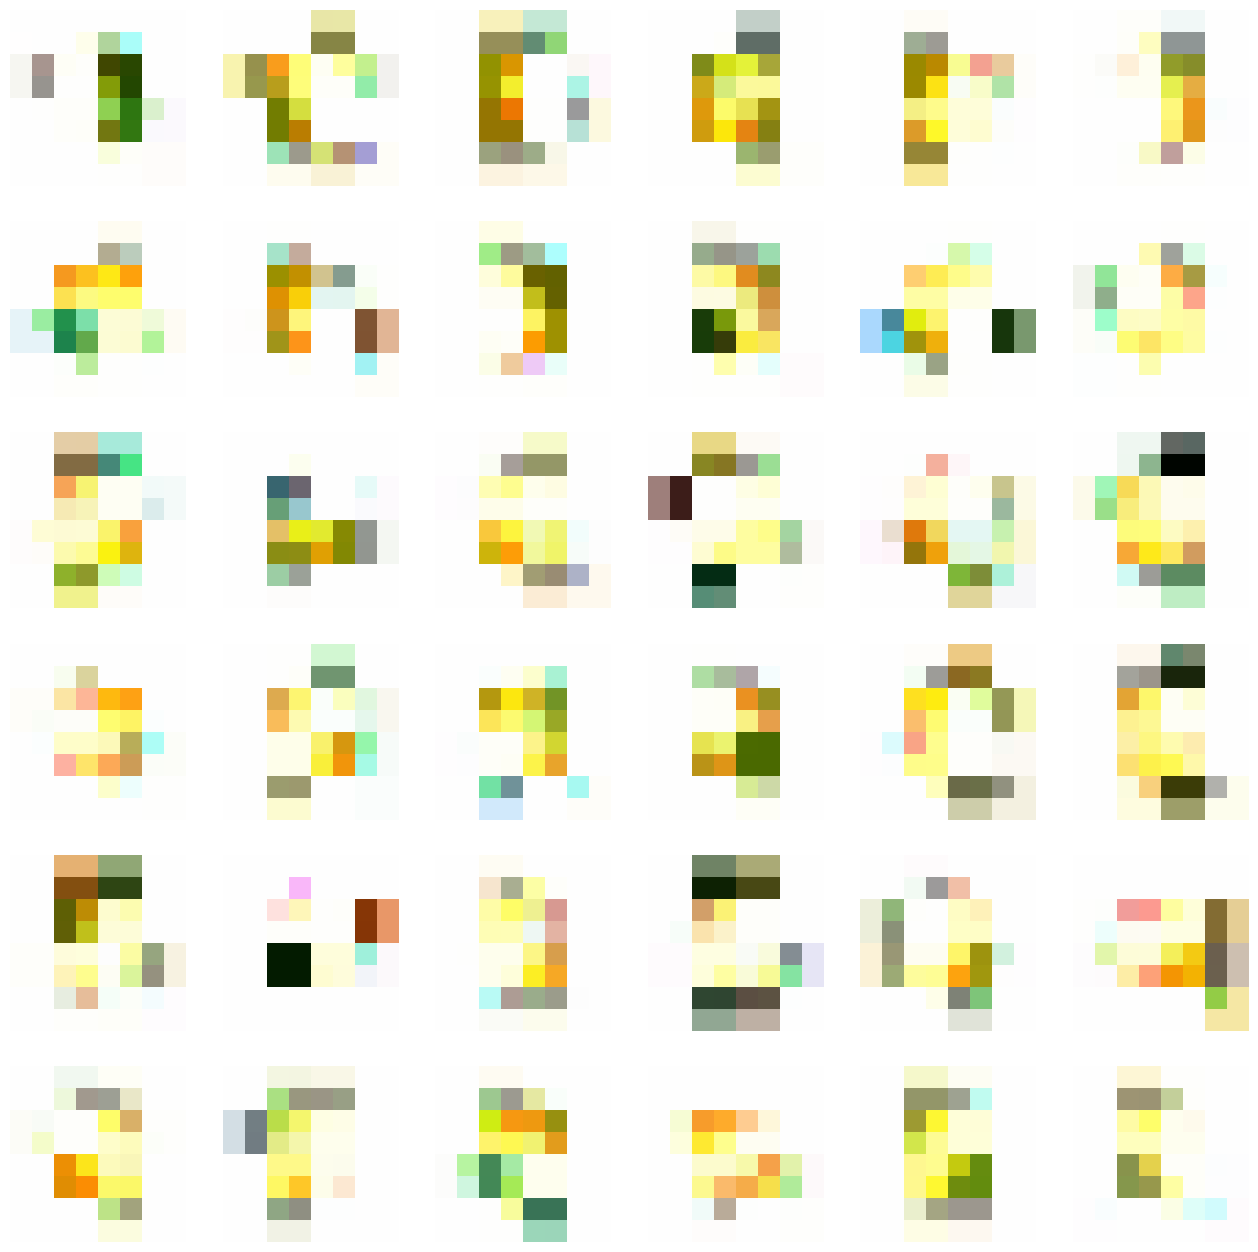

25/25 [==============================] - 36s 1s/step - d_loss: -3.4515 - g_loss: 4.6440
Epoch 21/50
25/25 [==============================] - ETA: 0s - d_loss: -3.4372 - g_loss: 4.7282

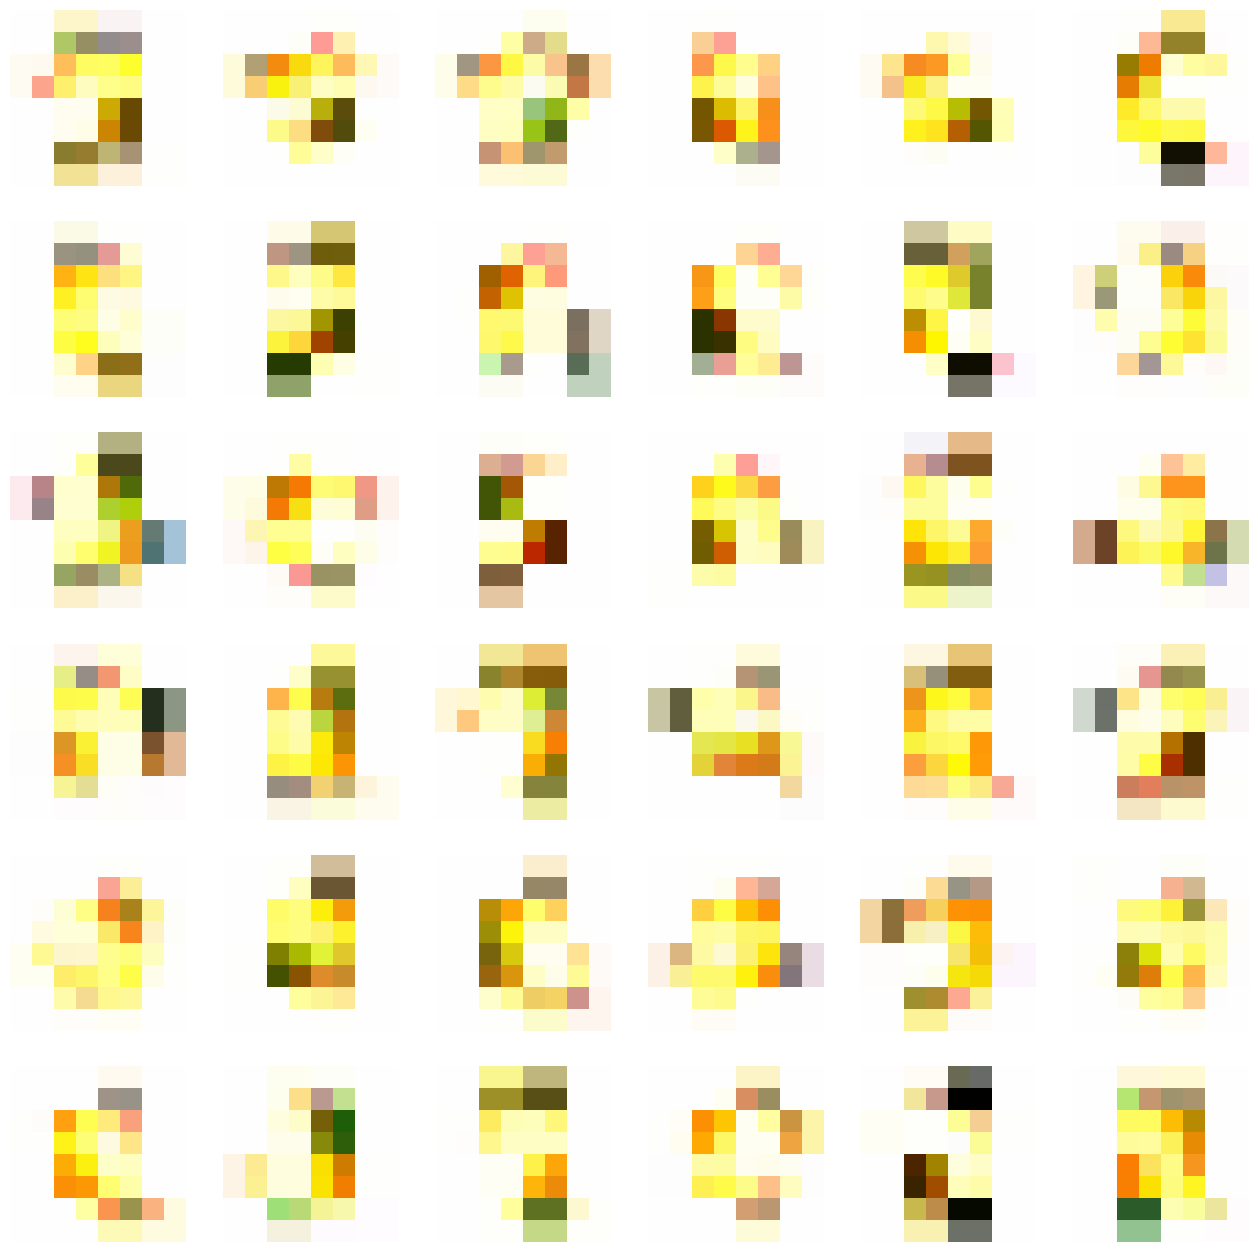

25/25 [==============================] - 37s 1s/step - d_loss: -3.4173 - g_loss: 4.5743
Epoch 22/50
25/25 [==============================] - ETA: 0s - d_loss: -3.3921 - g_loss: 4.4664

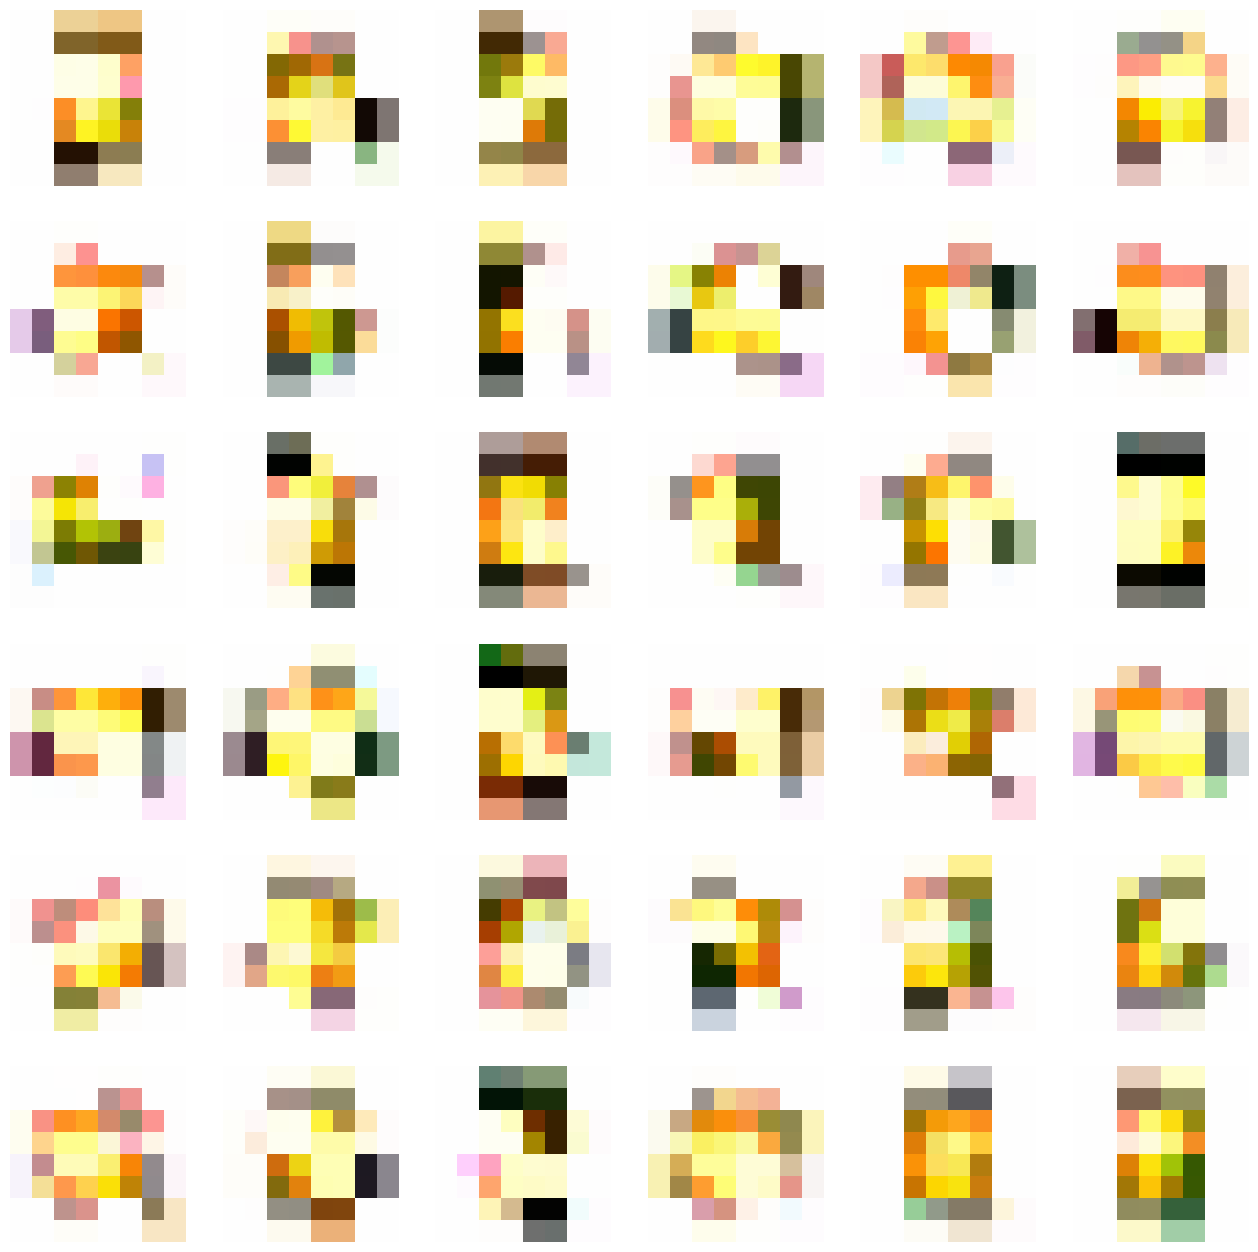

25/25 [==============================] - 37s 1s/step - d_loss: -3.3912 - g_loss: 4.5645
Epoch 23/50
25/25 [==============================] - ETA: 0s - d_loss: -3.2486 - g_loss: 4.2352

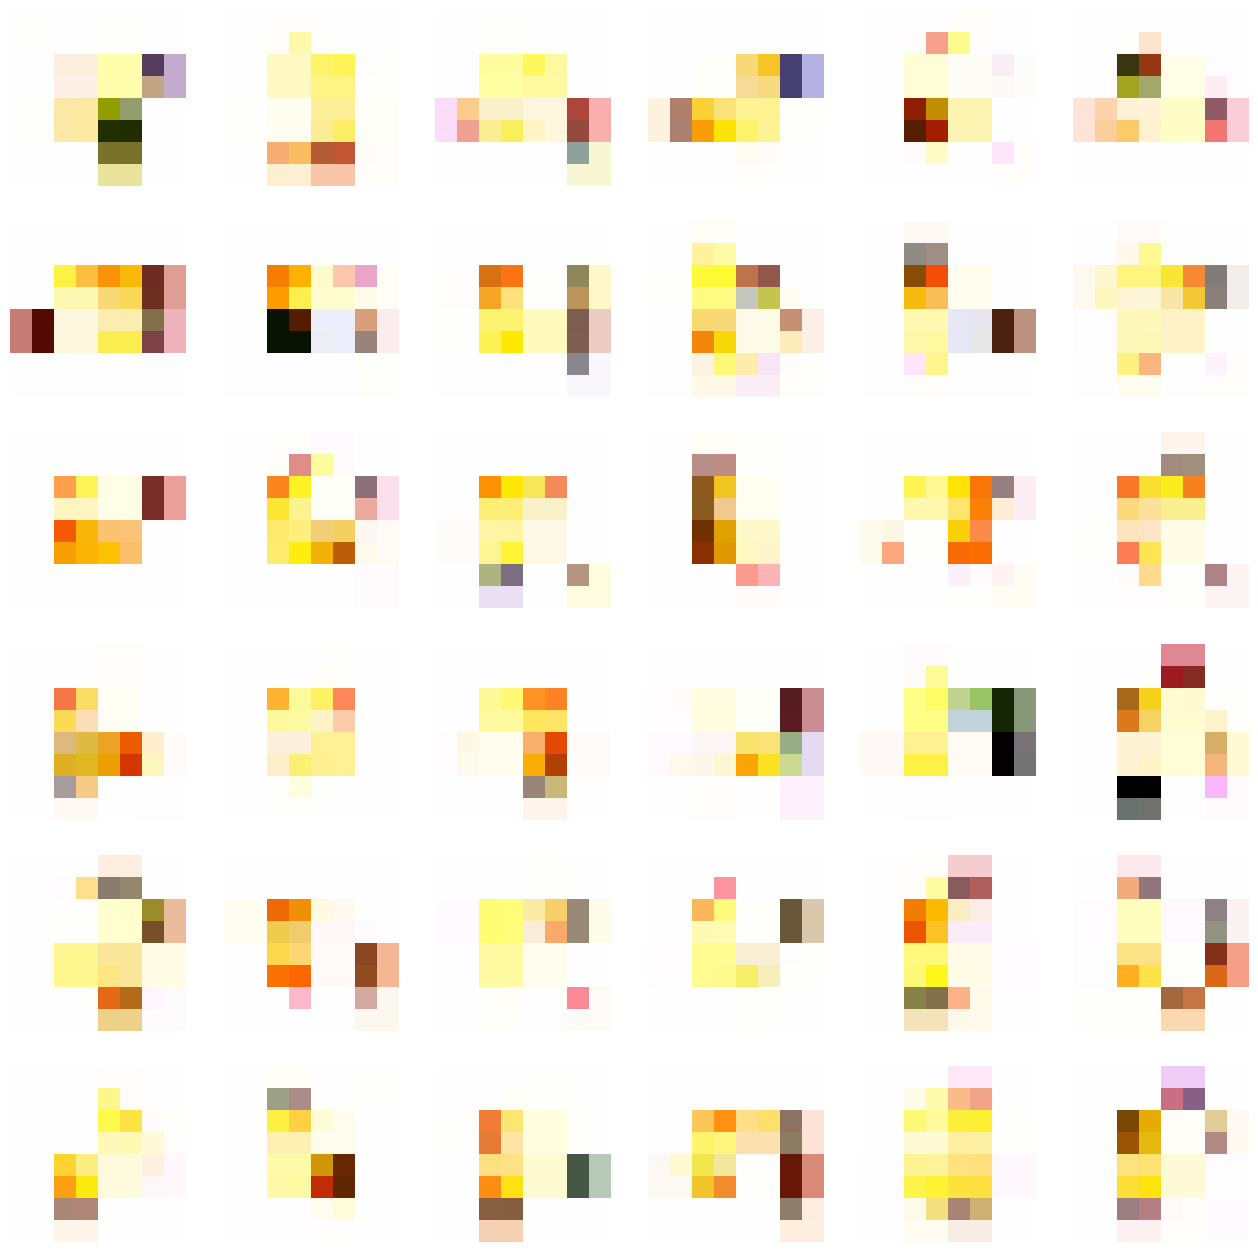

25/25 [==============================] - 36s 1s/step - d_loss: -3.2166 - g_loss: 4.3482
Epoch 24/50
25/25 [==============================] - ETA: 0s - d_loss: -3.1869 - g_loss: 4.1040

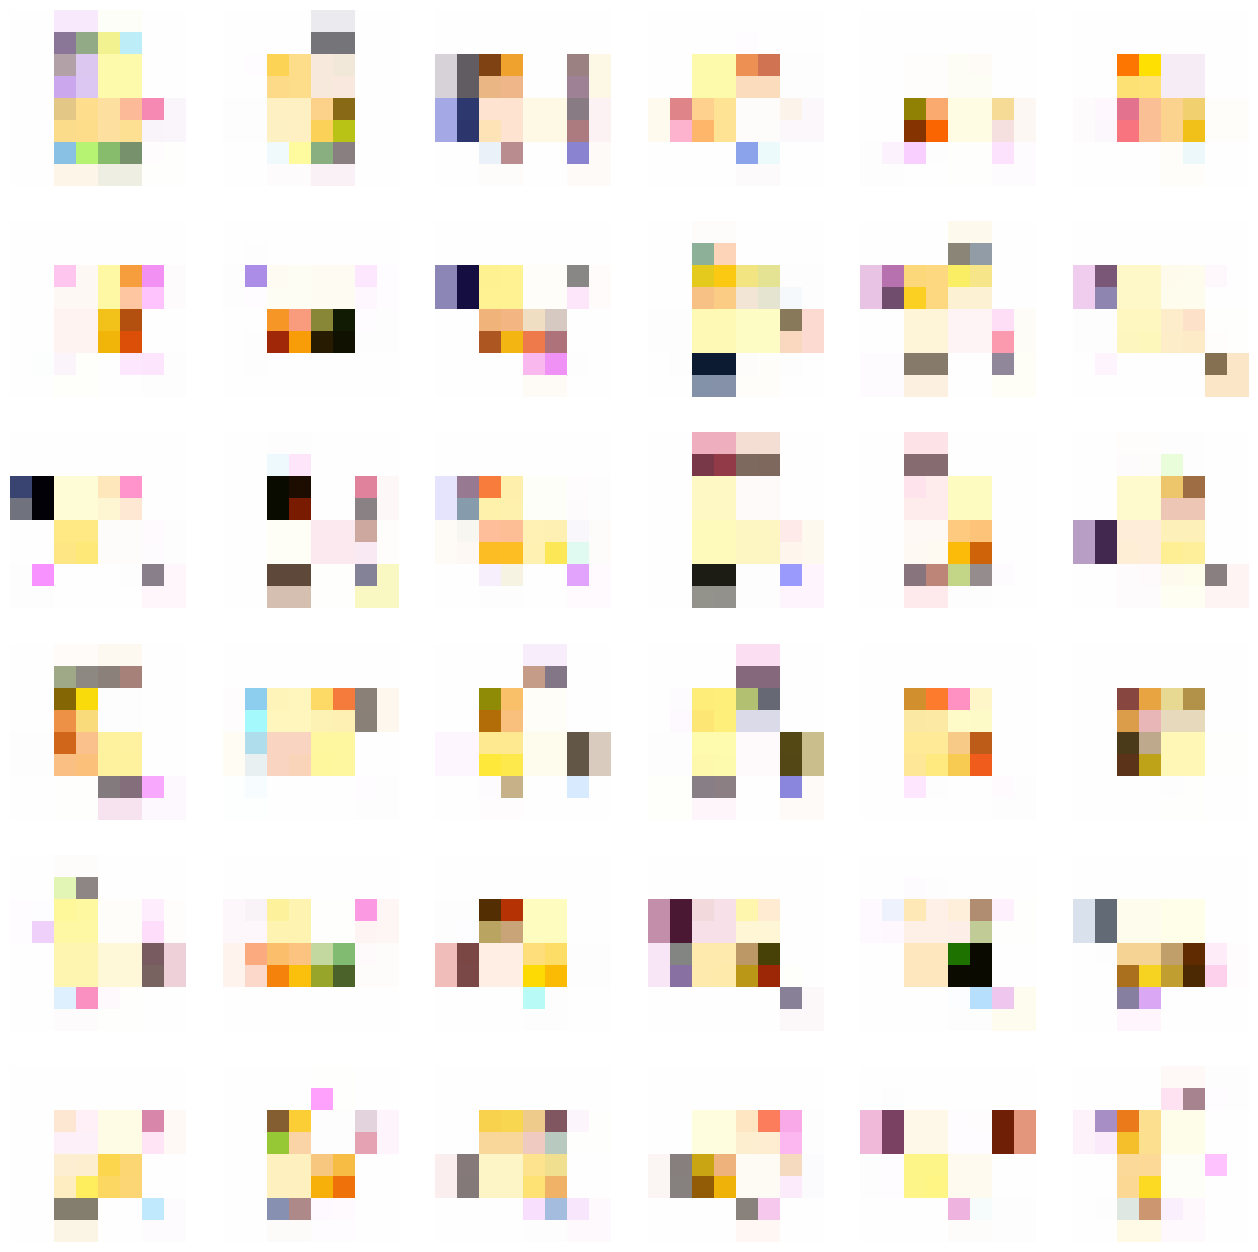

25/25 [==============================] - 37s 1s/step - d_loss: -3.1798 - g_loss: 4.1939
Epoch 25/50
25/25 [==============================] - ETA: 0s - d_loss: -3.0748 - g_loss: 3.7210

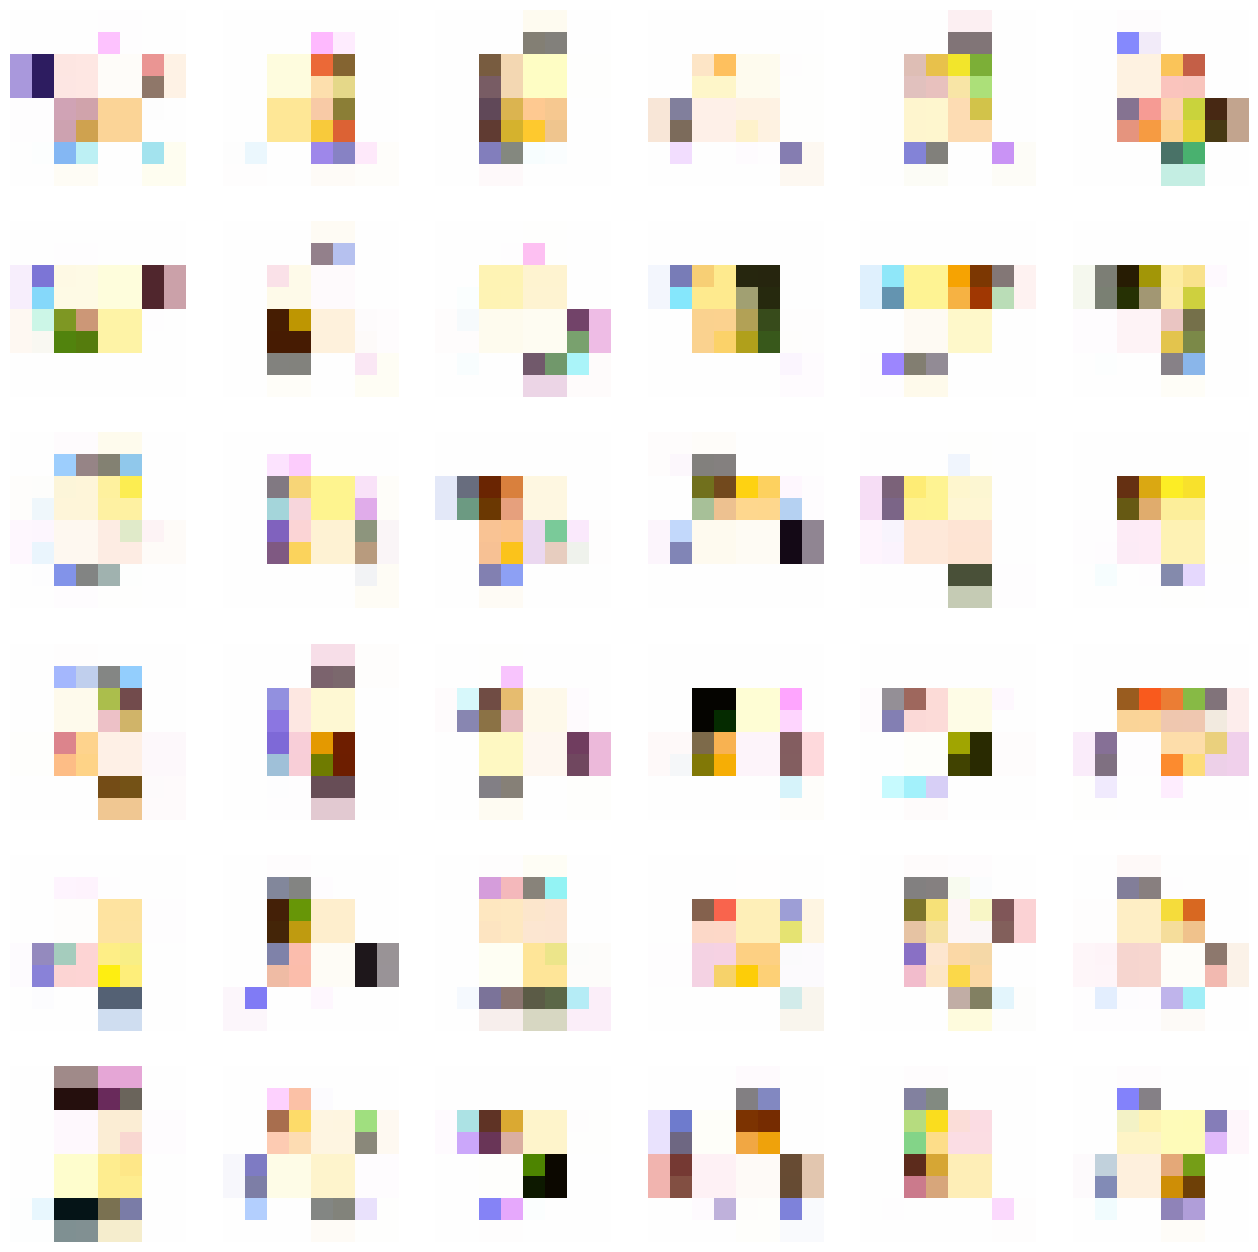

25/25 [==============================] - 37s 1s/step - d_loss: -3.0686 - g_loss: 3.9567
Epoch 26/50
25/25 [==============================] - ETA: 0s - d_loss: -2.9458 - g_loss: 4.0064

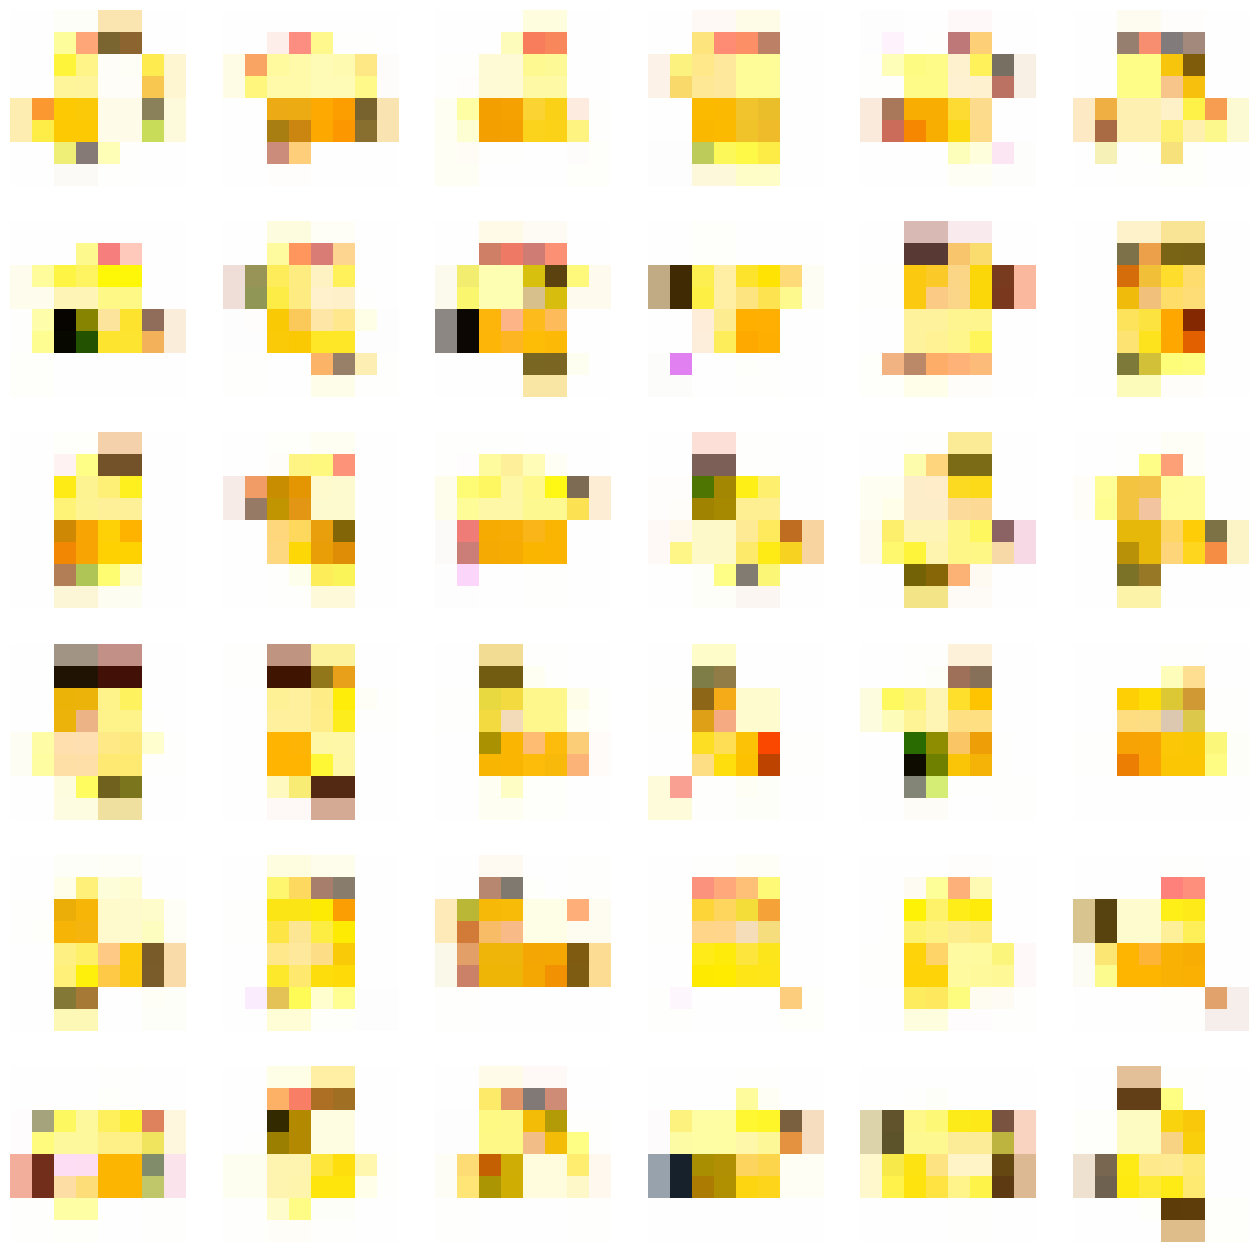

25/25 [==============================] - 37s 1s/step - d_loss: -2.9961 - g_loss: 4.1857
Epoch 27/50
25/25 [==============================] - ETA: 0s - d_loss: -2.8791 - g_loss: 2.7257

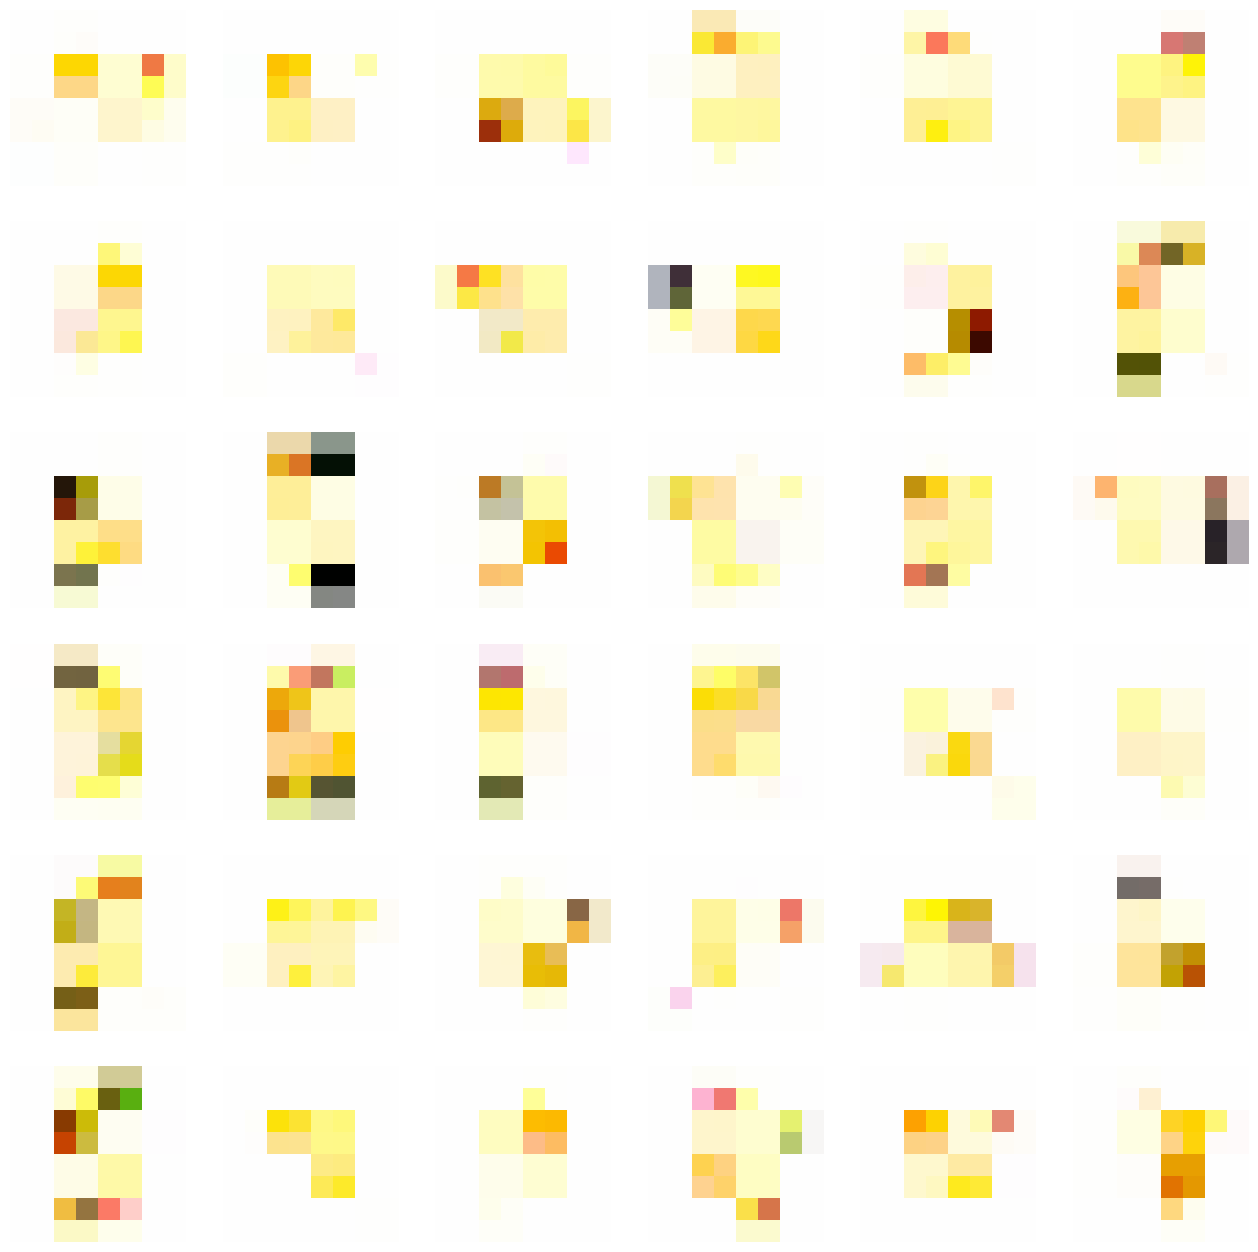

25/25 [==============================] - 36s 1s/step - d_loss: -2.8579 - g_loss: 2.6888
Epoch 28/50
25/25 [==============================] - ETA: 0s - d_loss: -2.9197 - g_loss: 4.3364

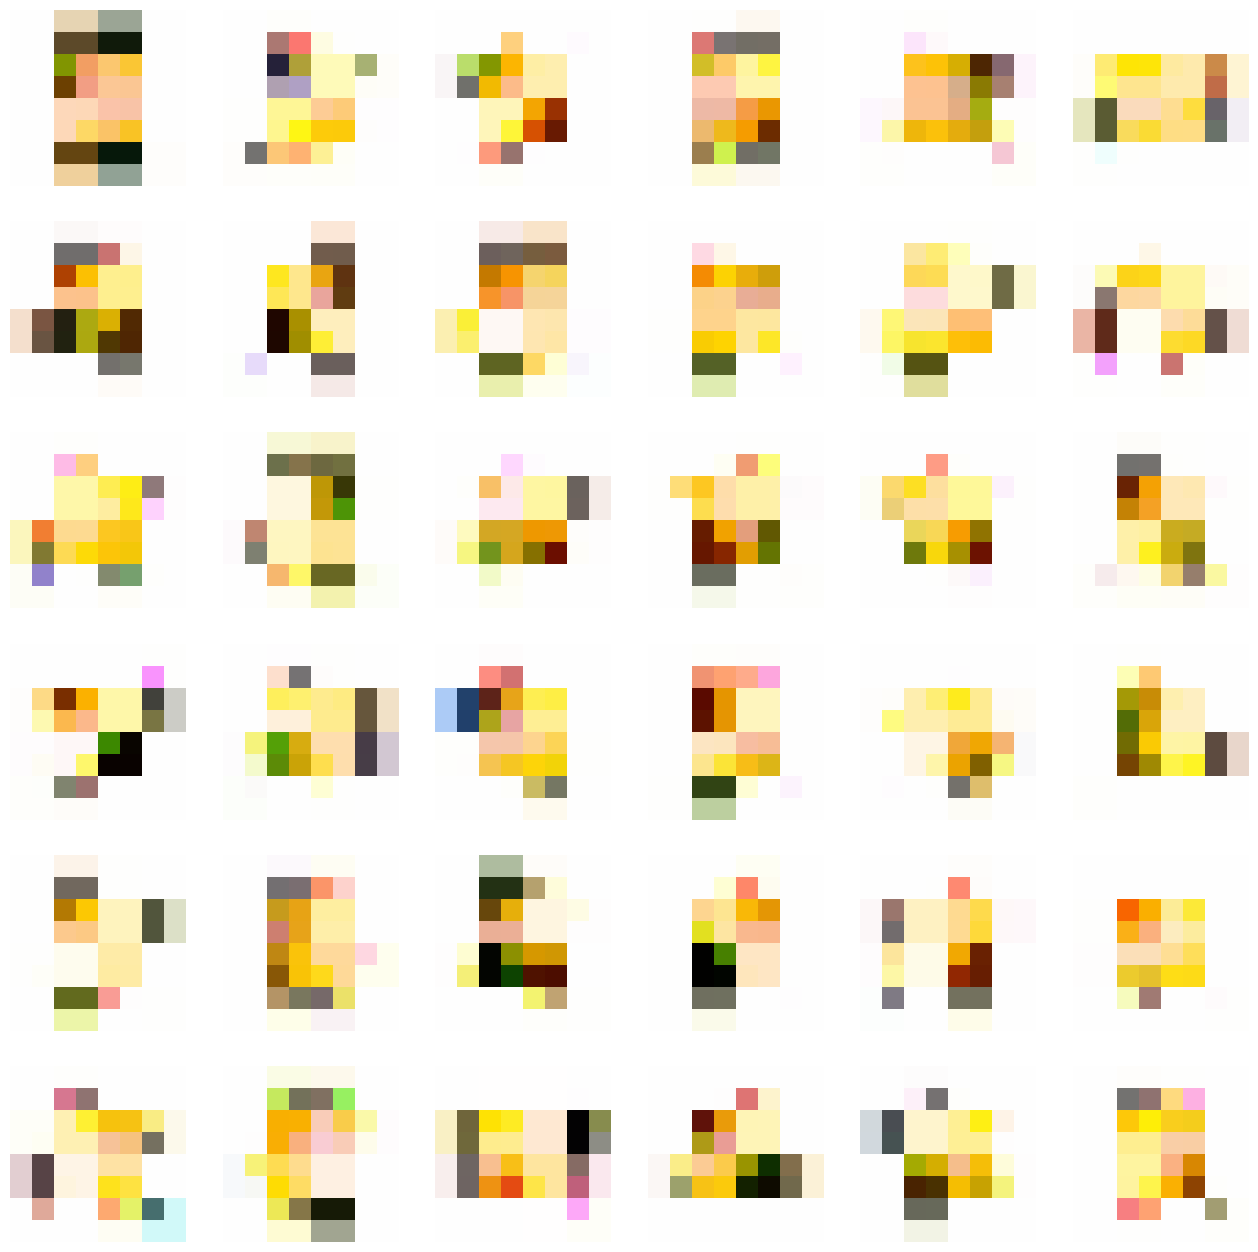

25/25 [==============================] - 36s 1s/step - d_loss: -2.9239 - g_loss: 4.2073
Epoch 29/50
25/25 [==============================] - ETA: 0s - d_loss: -2.7892 - g_loss: 3.1393

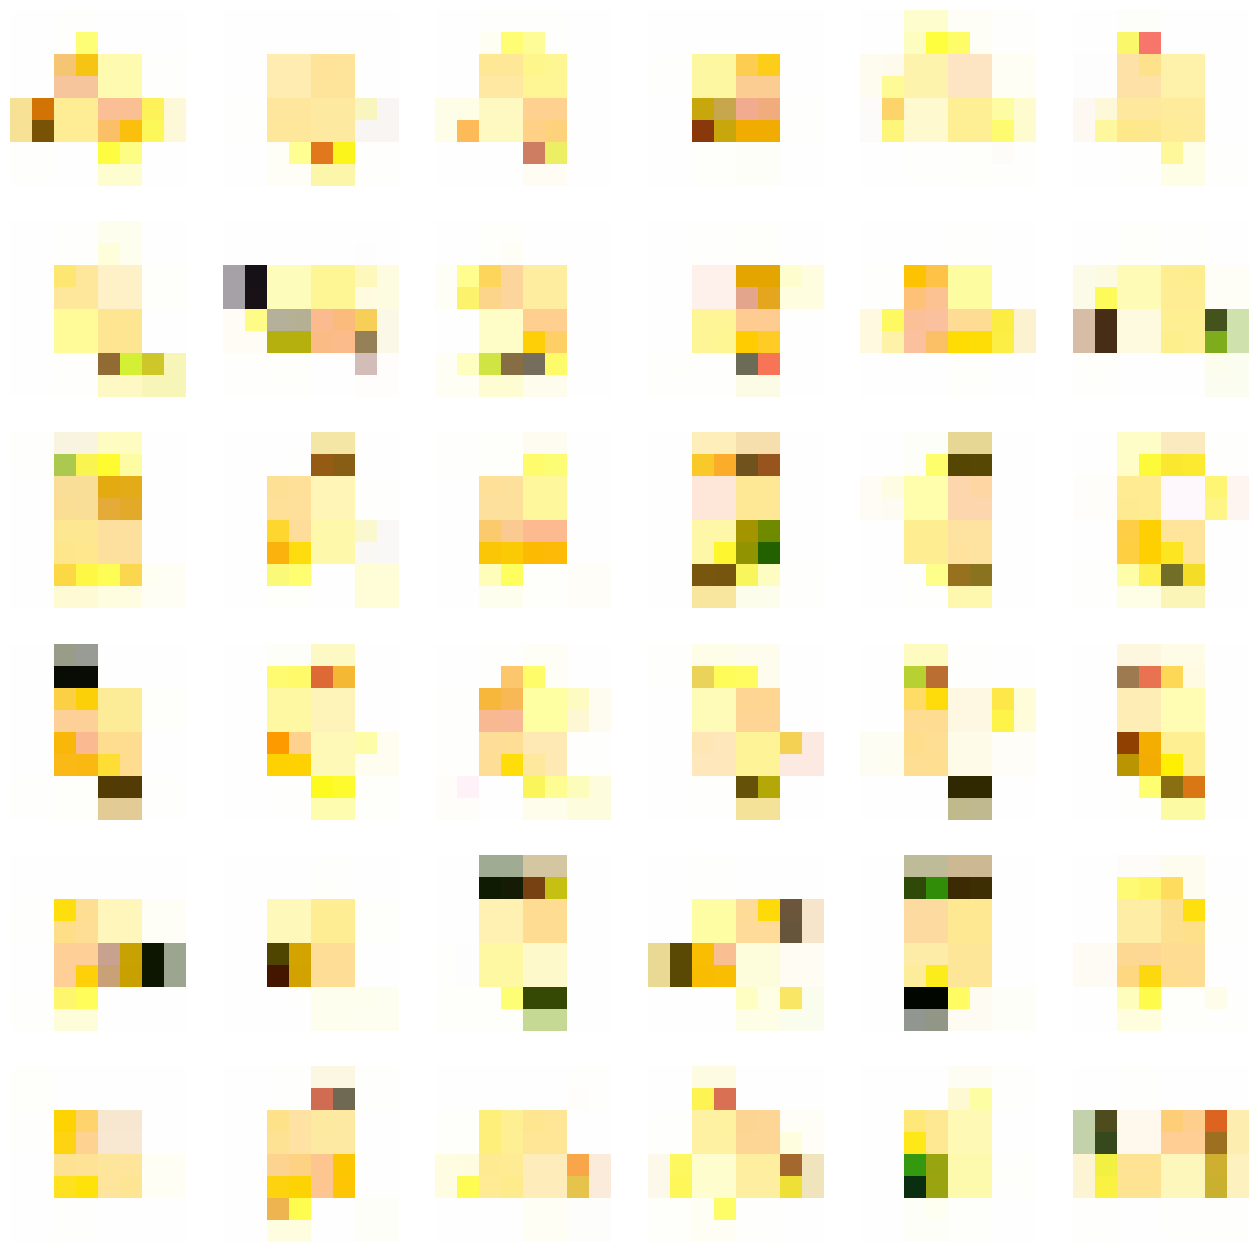

25/25 [==============================] - 37s 1s/step - d_loss: -2.8143 - g_loss: 3.4407
Epoch 30/50
25/25 [==============================] - ETA: 0s - d_loss: -2.6667 - g_loss: 2.7280

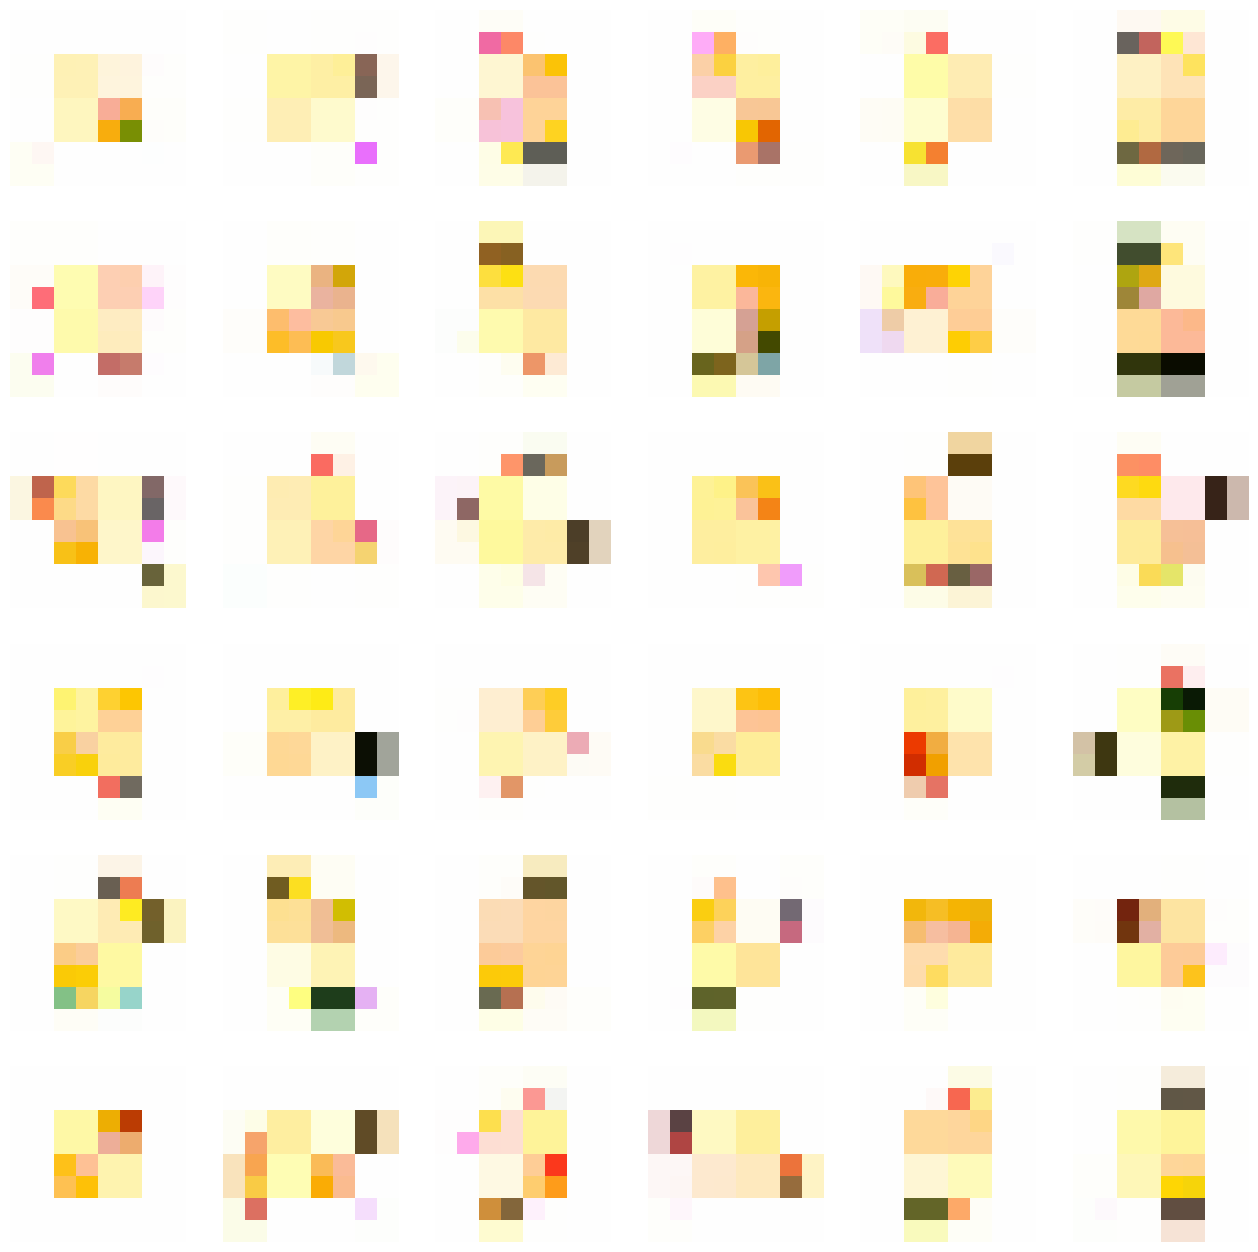

25/25 [==============================] - 36s 1s/step - d_loss: -2.6352 - g_loss: 2.5387
Epoch 31/50
25/25 [==============================] - ETA: 0s - d_loss: -2.6596 - g_loss: 3.5181

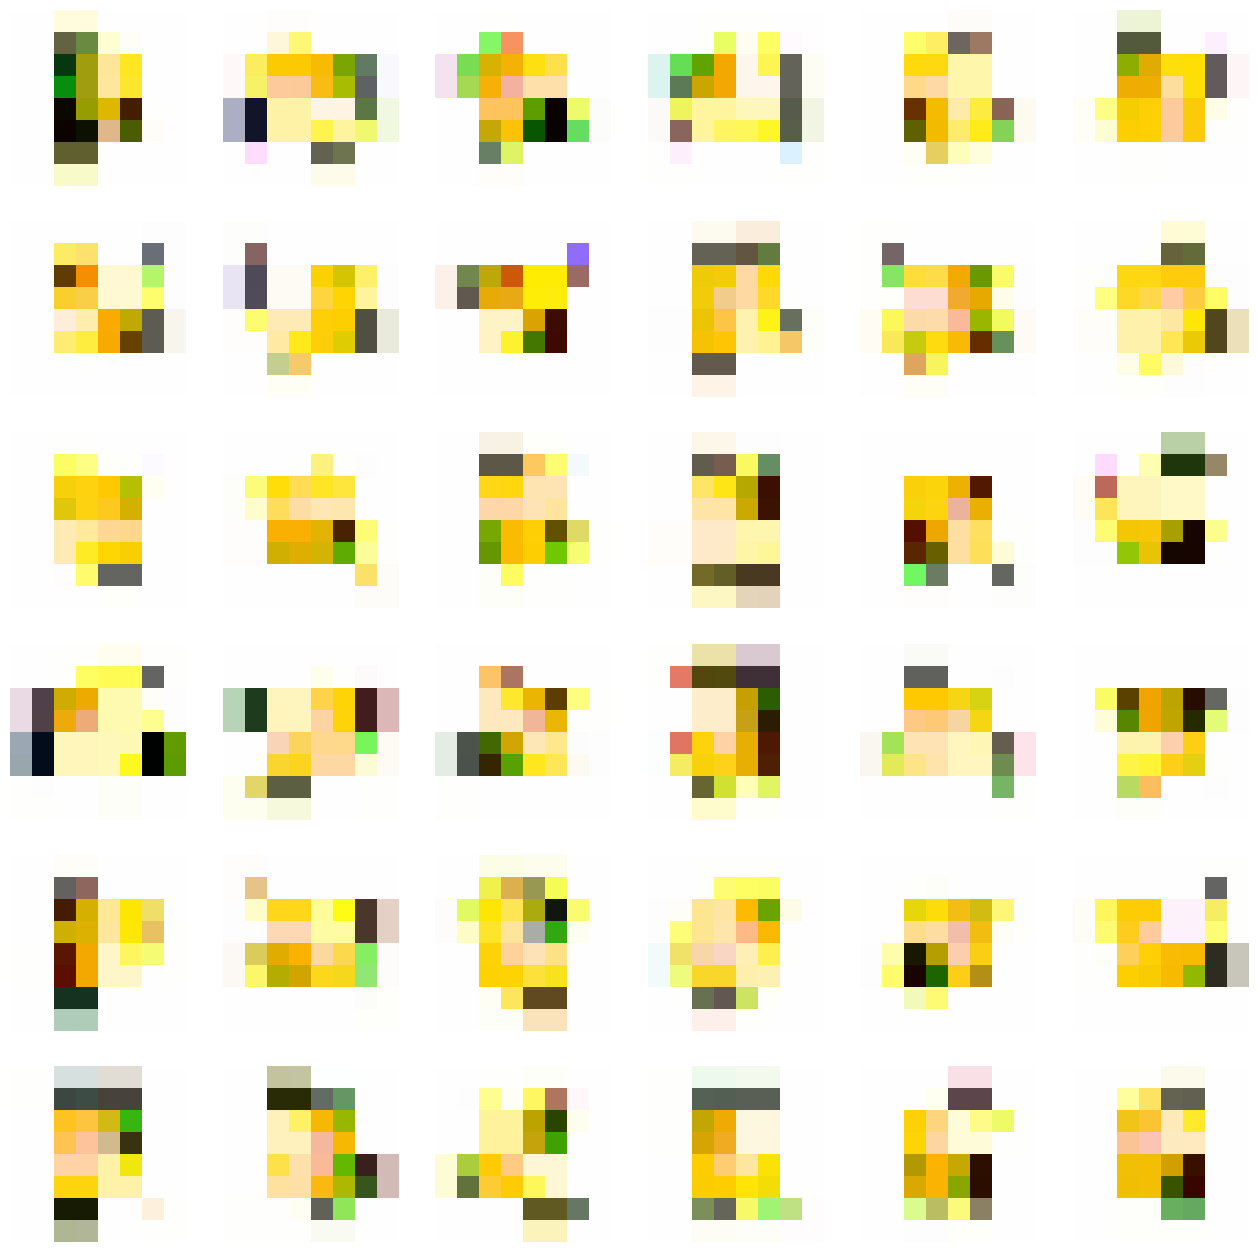

25/25 [==============================] - 36s 1s/step - d_loss: -2.6283 - g_loss: 3.5217
Epoch 32/50
25/25 [==============================] - ETA: 0s - d_loss: -2.6932 - g_loss: 3.2892

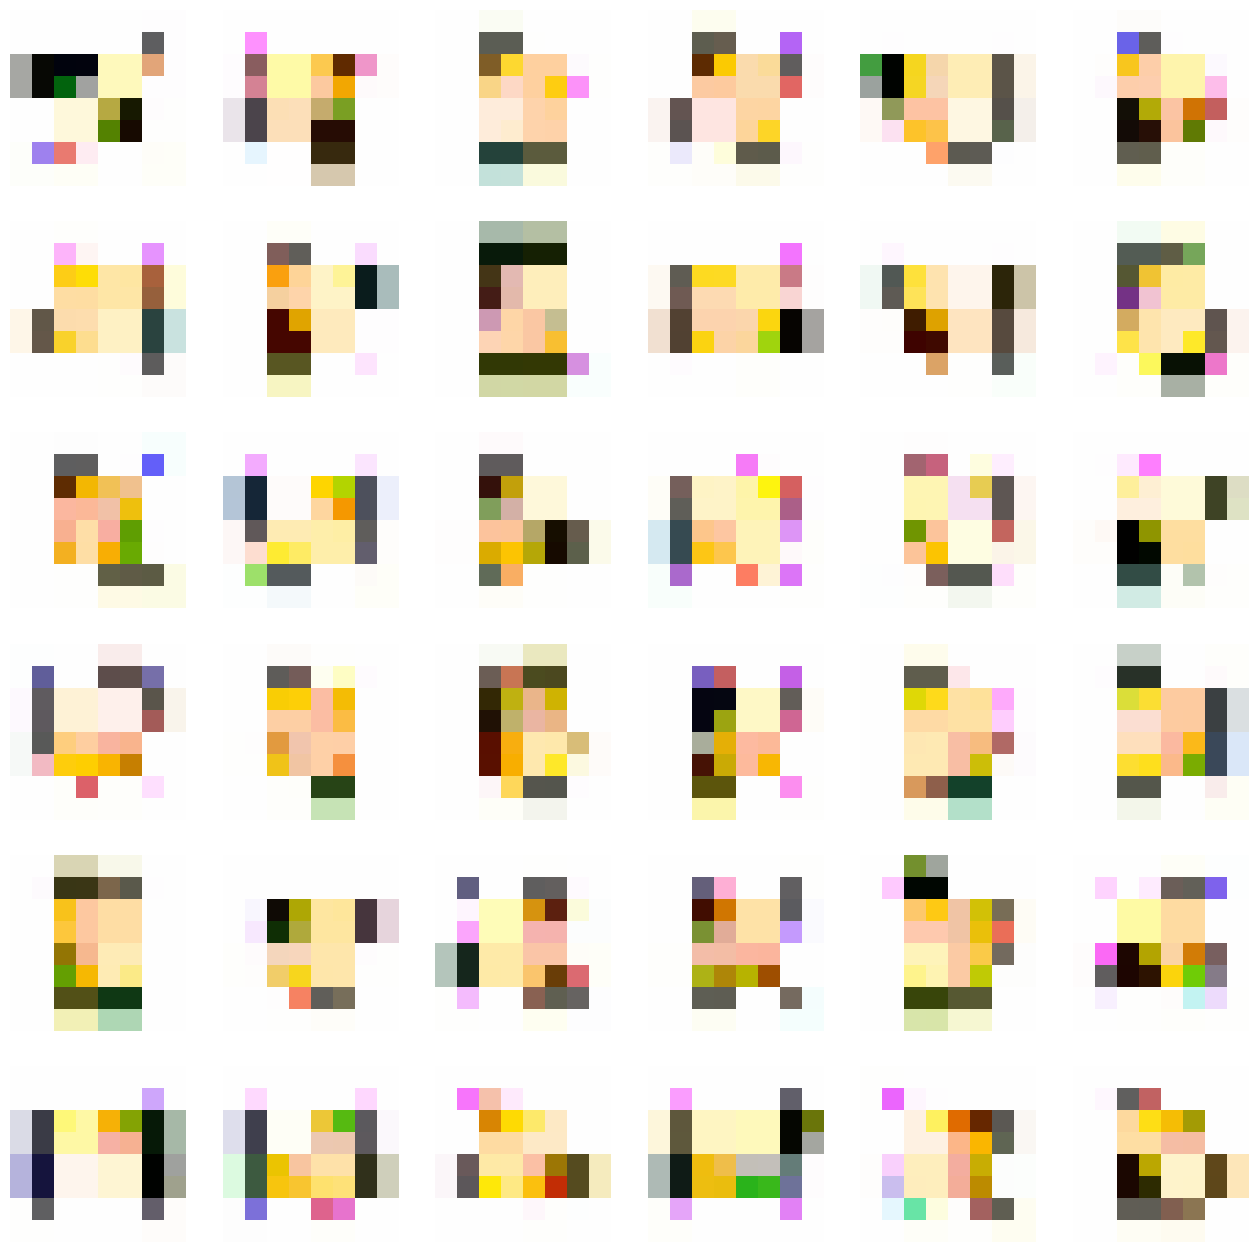

25/25 [==============================] - 36s 1s/step - d_loss: -2.6984 - g_loss: 3.1076
Epoch 33/50
25/25 [==============================] - ETA: 0s - d_loss: -2.4819 - g_loss: 2.8820

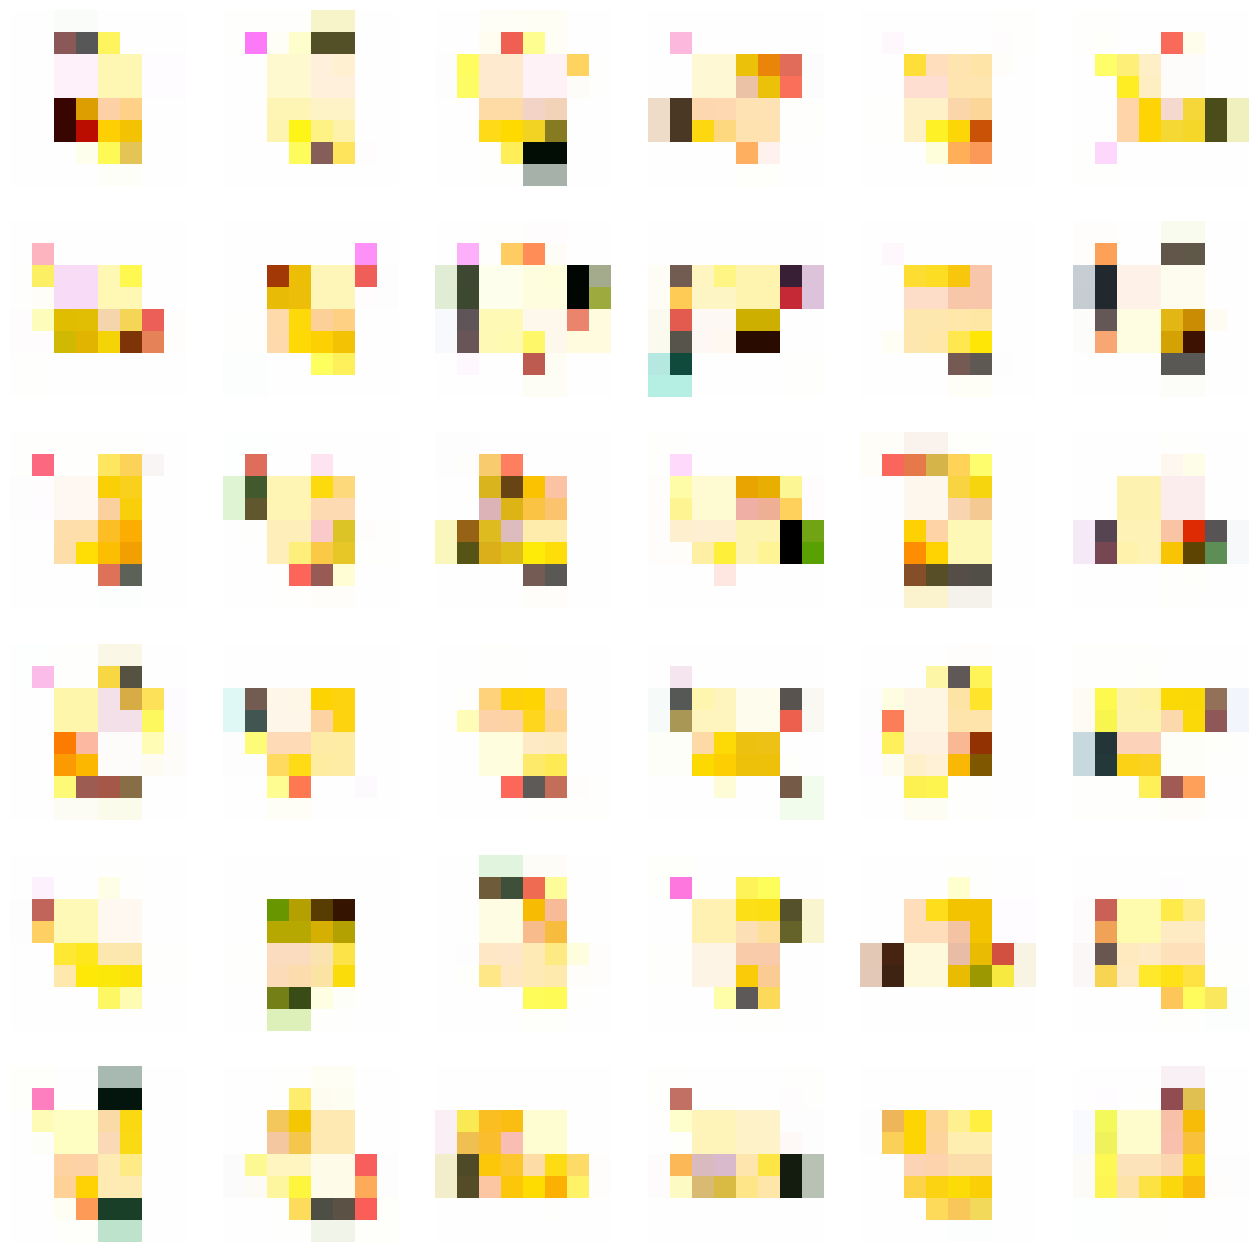

25/25 [==============================] - 36s 1s/step - d_loss: -2.4811 - g_loss: 3.1545
Epoch 34/50
25/25 [==============================] - ETA: 0s - d_loss: -2.5311 - g_loss: 3.3245

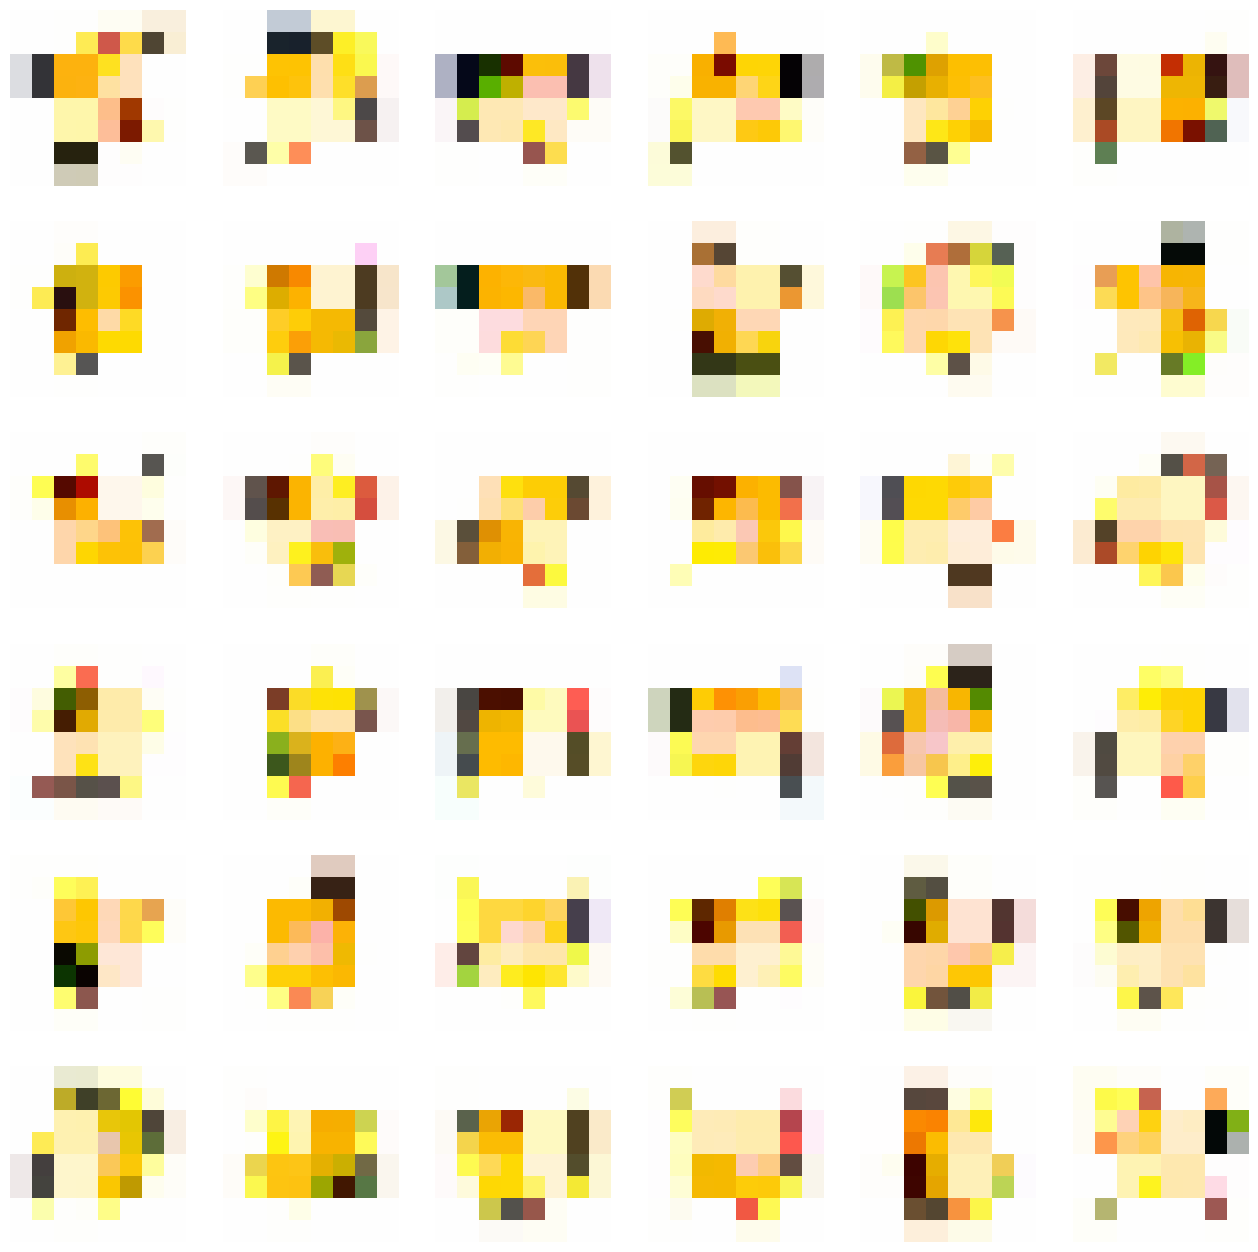

25/25 [==============================] - 37s 1s/step - d_loss: -2.5573 - g_loss: 3.3323
Epoch 35/50
25/25 [==============================] - ETA: 0s - d_loss: -2.4700 - g_loss: 2.8532

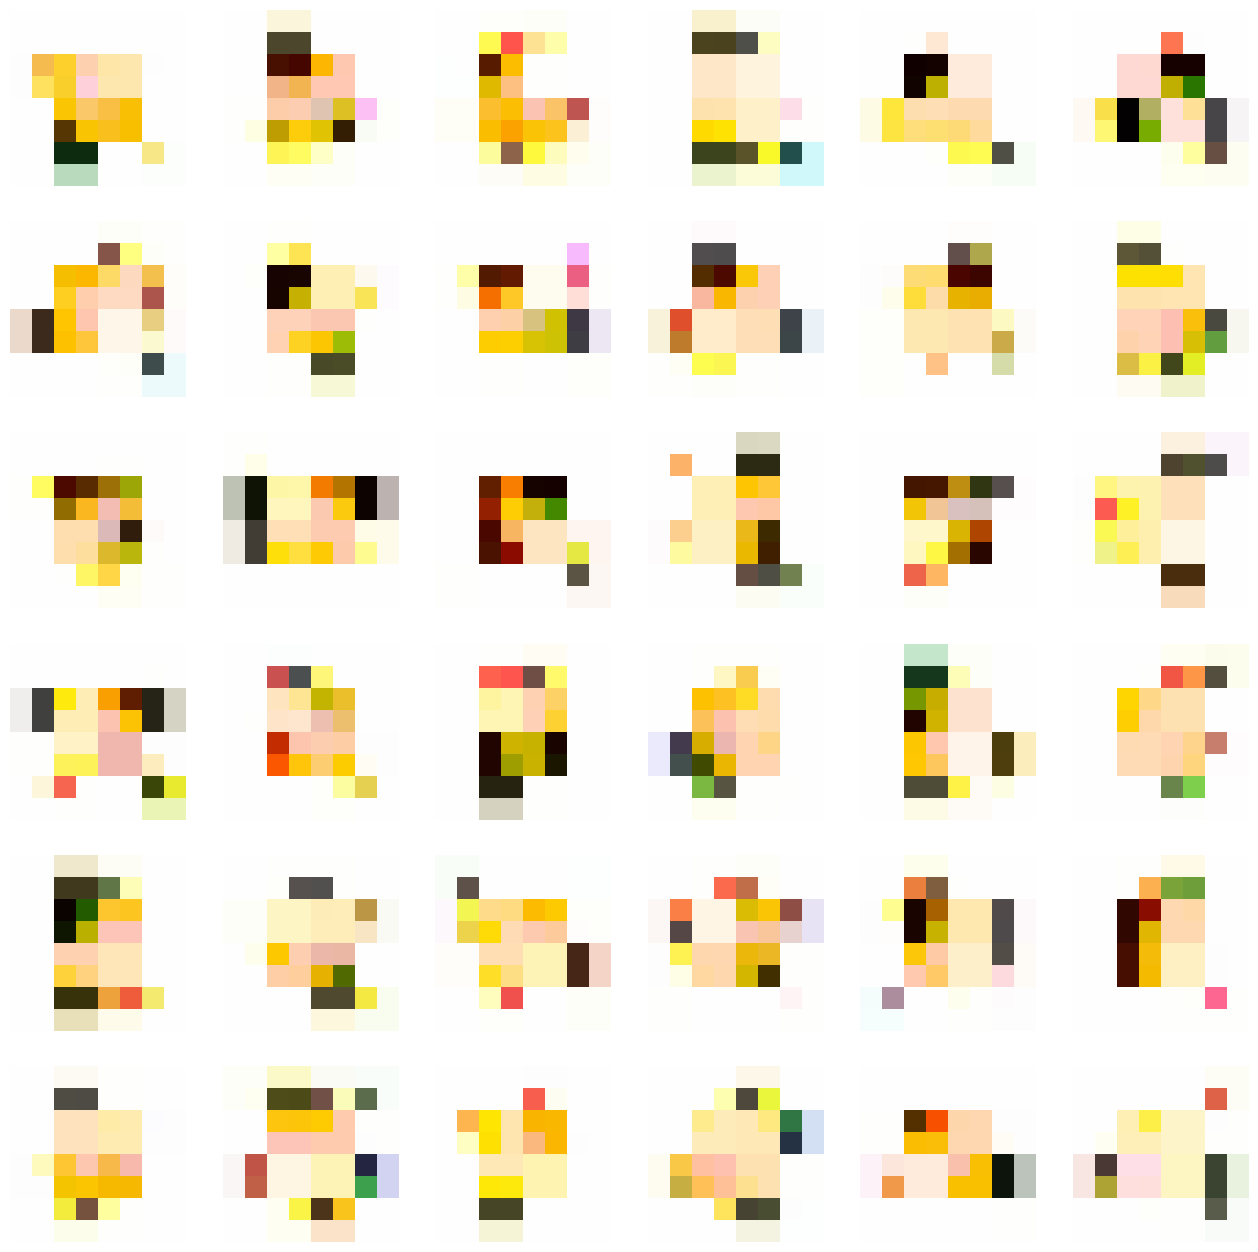

25/25 [==============================] - 36s 1s/step - d_loss: -2.4428 - g_loss: 2.9173
Epoch 36/50
25/25 [==============================] - ETA: 0s - d_loss: -2.6401 - g_loss: 2.6601

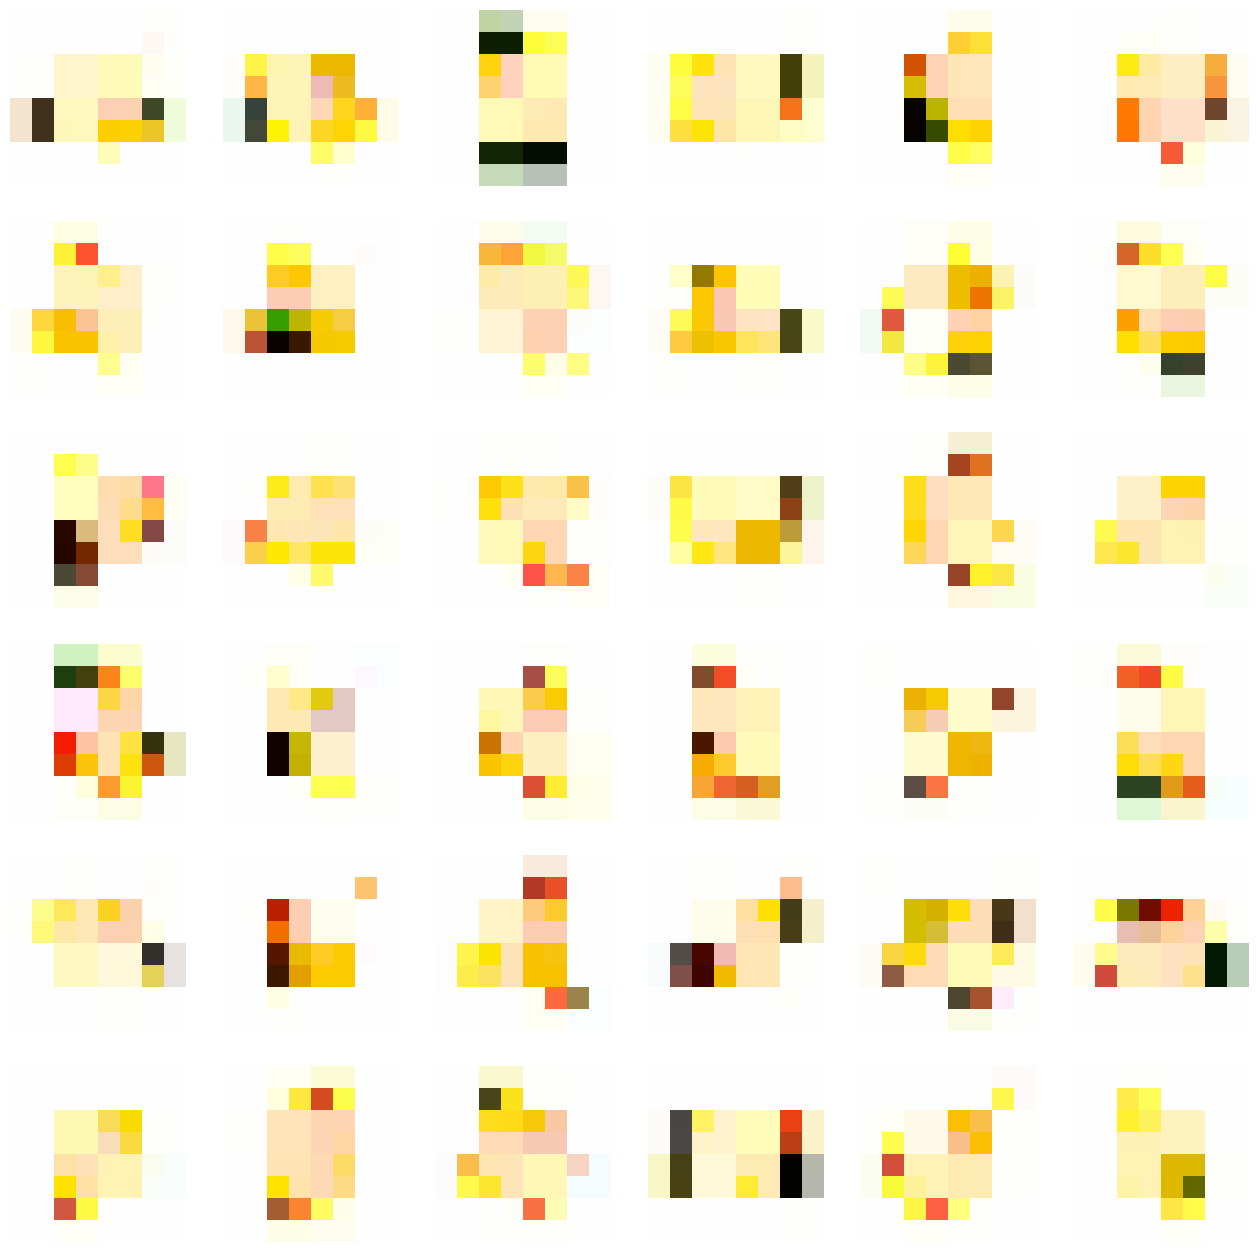

25/25 [==============================] - 36s 1s/step - d_loss: -2.6365 - g_loss: 2.3565
Epoch 37/50
25/25 [==============================] - ETA: 0s - d_loss: -2.4851 - g_loss: 3.2949

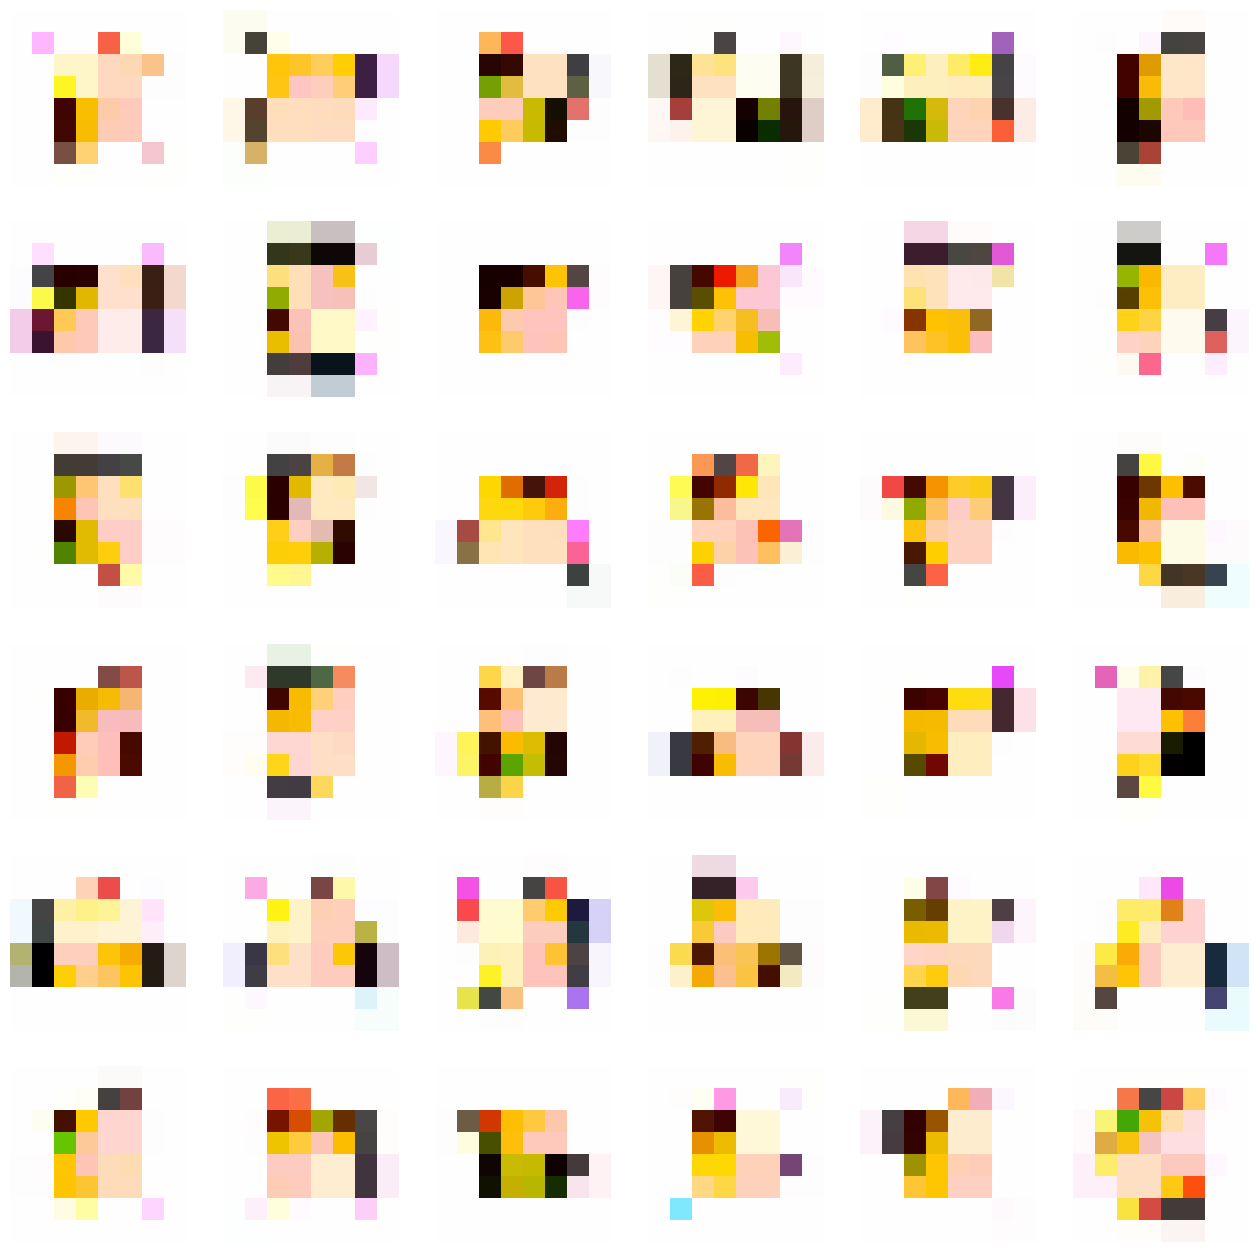

25/25 [==============================] - 36s 1s/step - d_loss: -2.4818 - g_loss: 3.1939
Epoch 38/50
25/25 [==============================] - ETA: 0s - d_loss: -2.5940 - g_loss: 2.8177

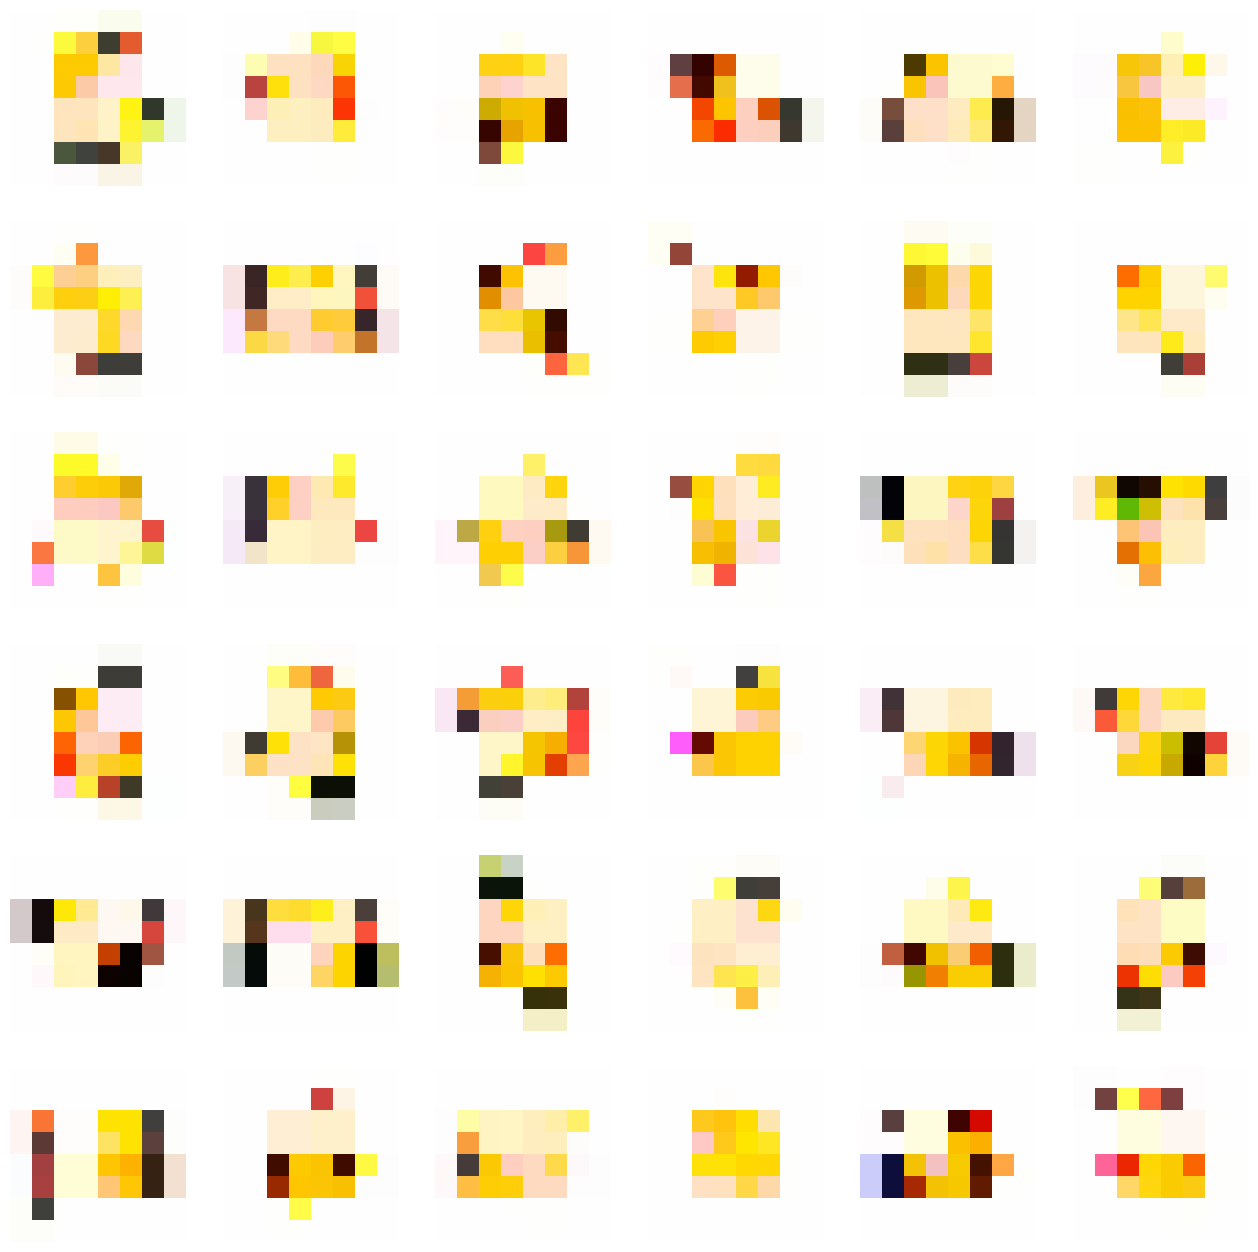

25/25 [==============================] - 37s 1s/step - d_loss: -2.5412 - g_loss: 3.0096
Epoch 39/50
25/25 [==============================] - ETA: 0s - d_loss: -2.4608 - g_loss: 3.1245

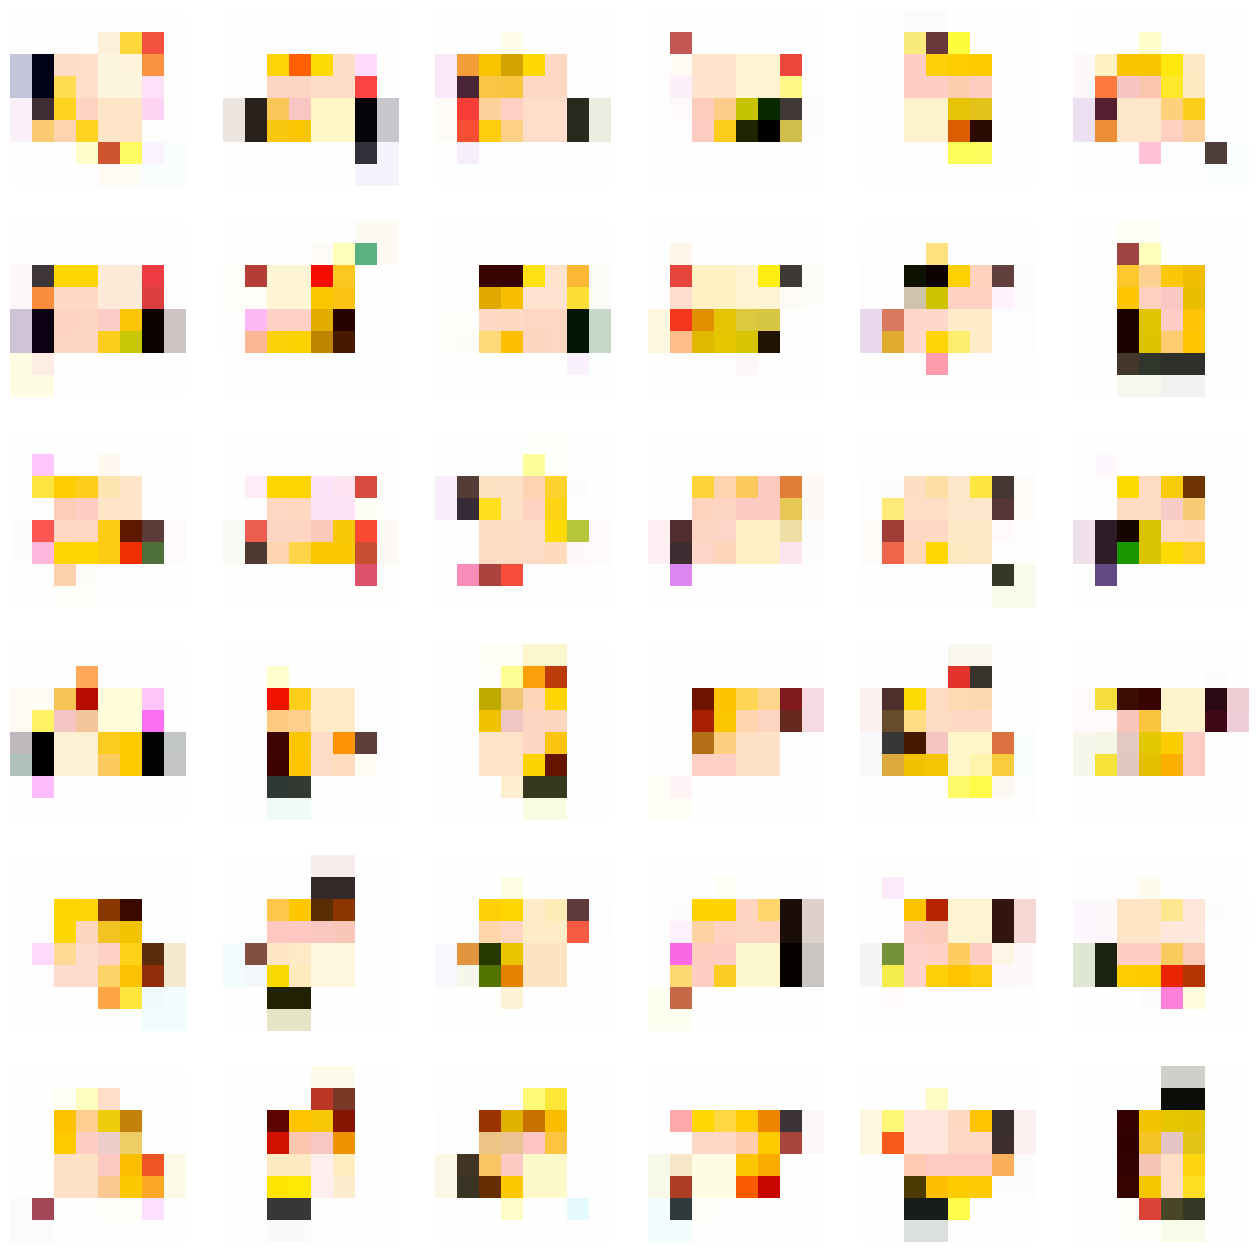

25/25 [==============================] - 36s 1s/step - d_loss: -2.4986 - g_loss: 3.0403
Epoch 40/50
25/25 [==============================] - ETA: 0s - d_loss: -2.2798 - g_loss: 2.4945

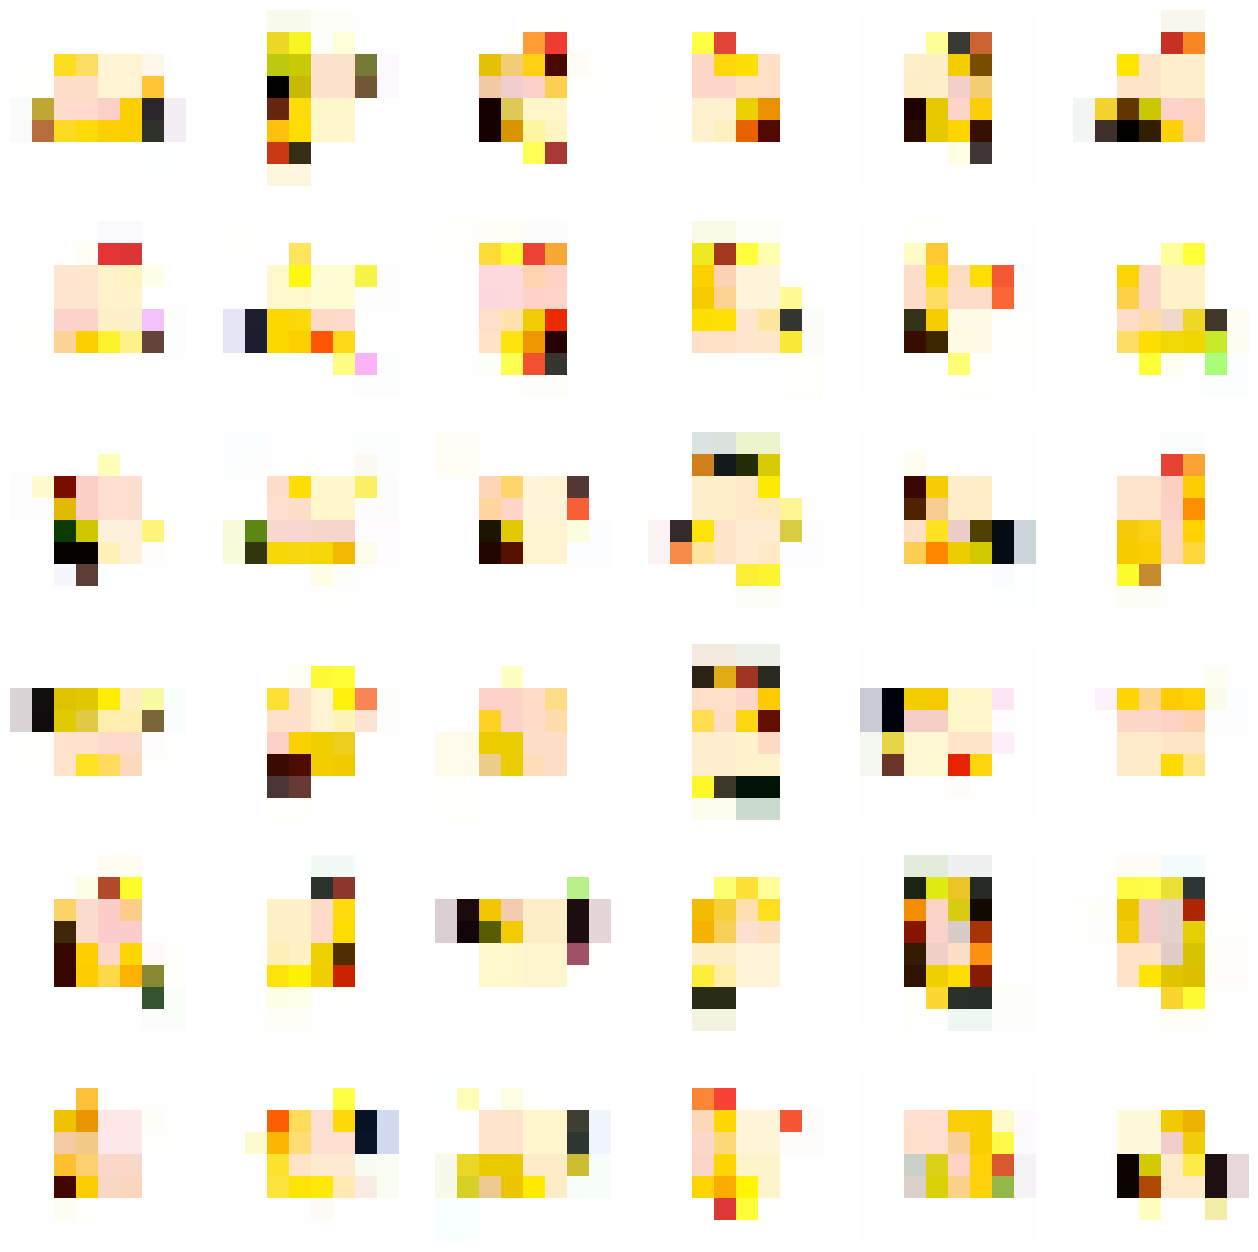

25/25 [==============================] - 36s 1s/step - d_loss: -2.2954 - g_loss: 2.3495
Epoch 41/50
25/25 [==============================] - ETA: 0s - d_loss: -2.4148 - g_loss: 3.3445

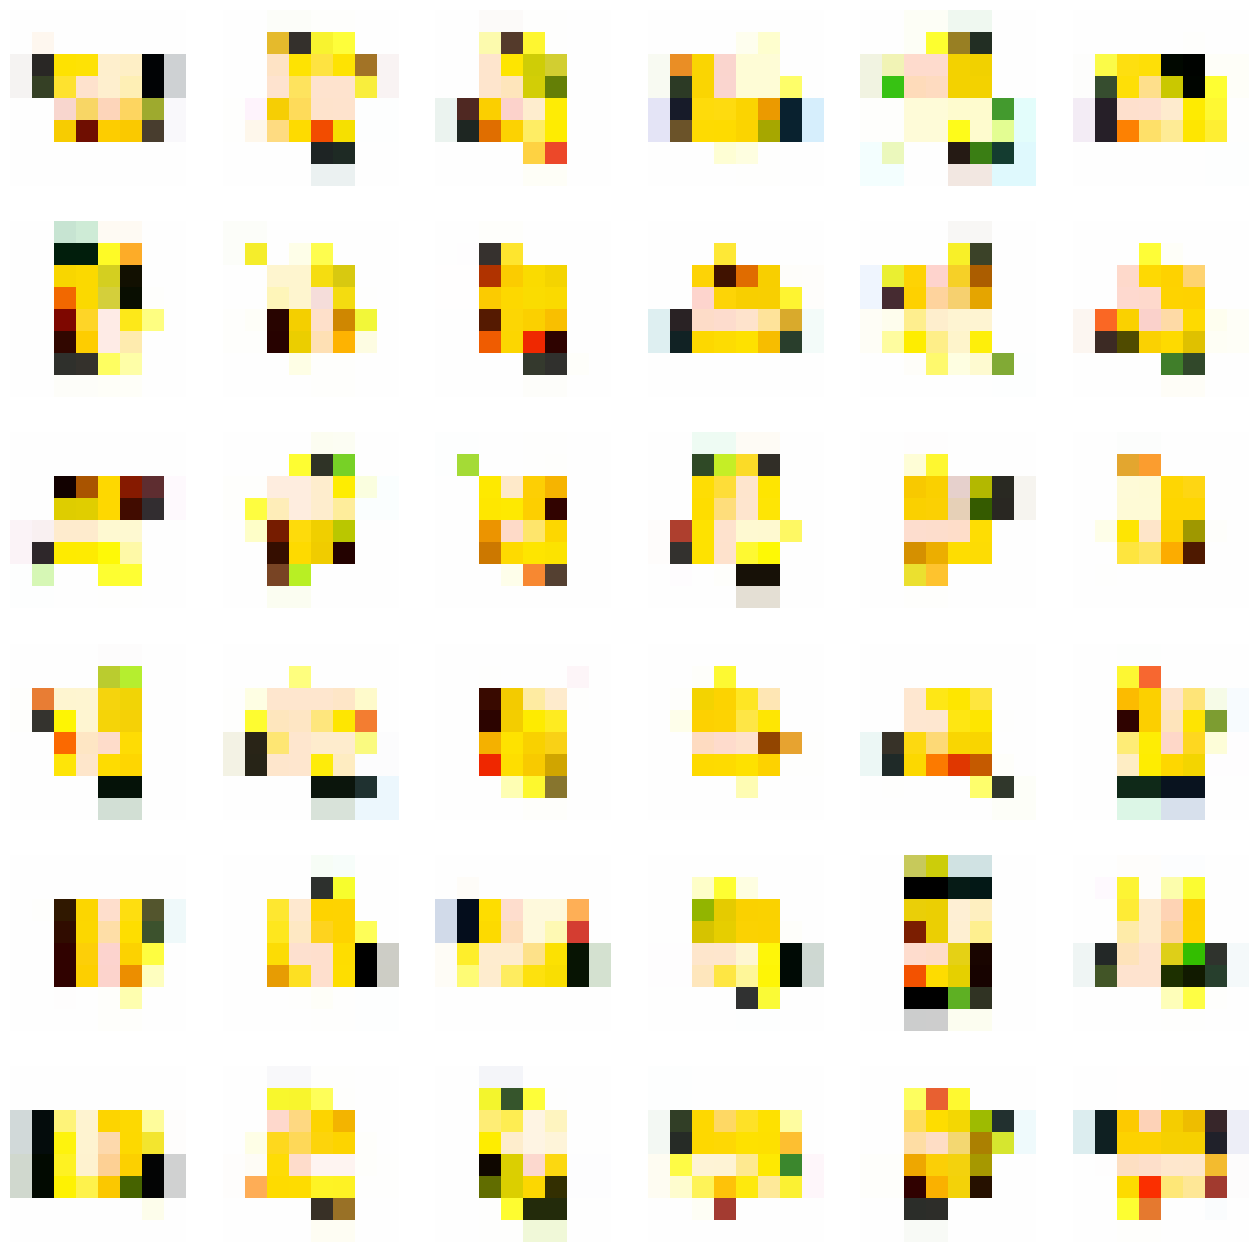

25/25 [==============================] - 36s 1s/step - d_loss: -2.4420 - g_loss: 3.3487
Epoch 42/50
25/25 [==============================] - ETA: 0s - d_loss: -2.3907 - g_loss: 2.5388

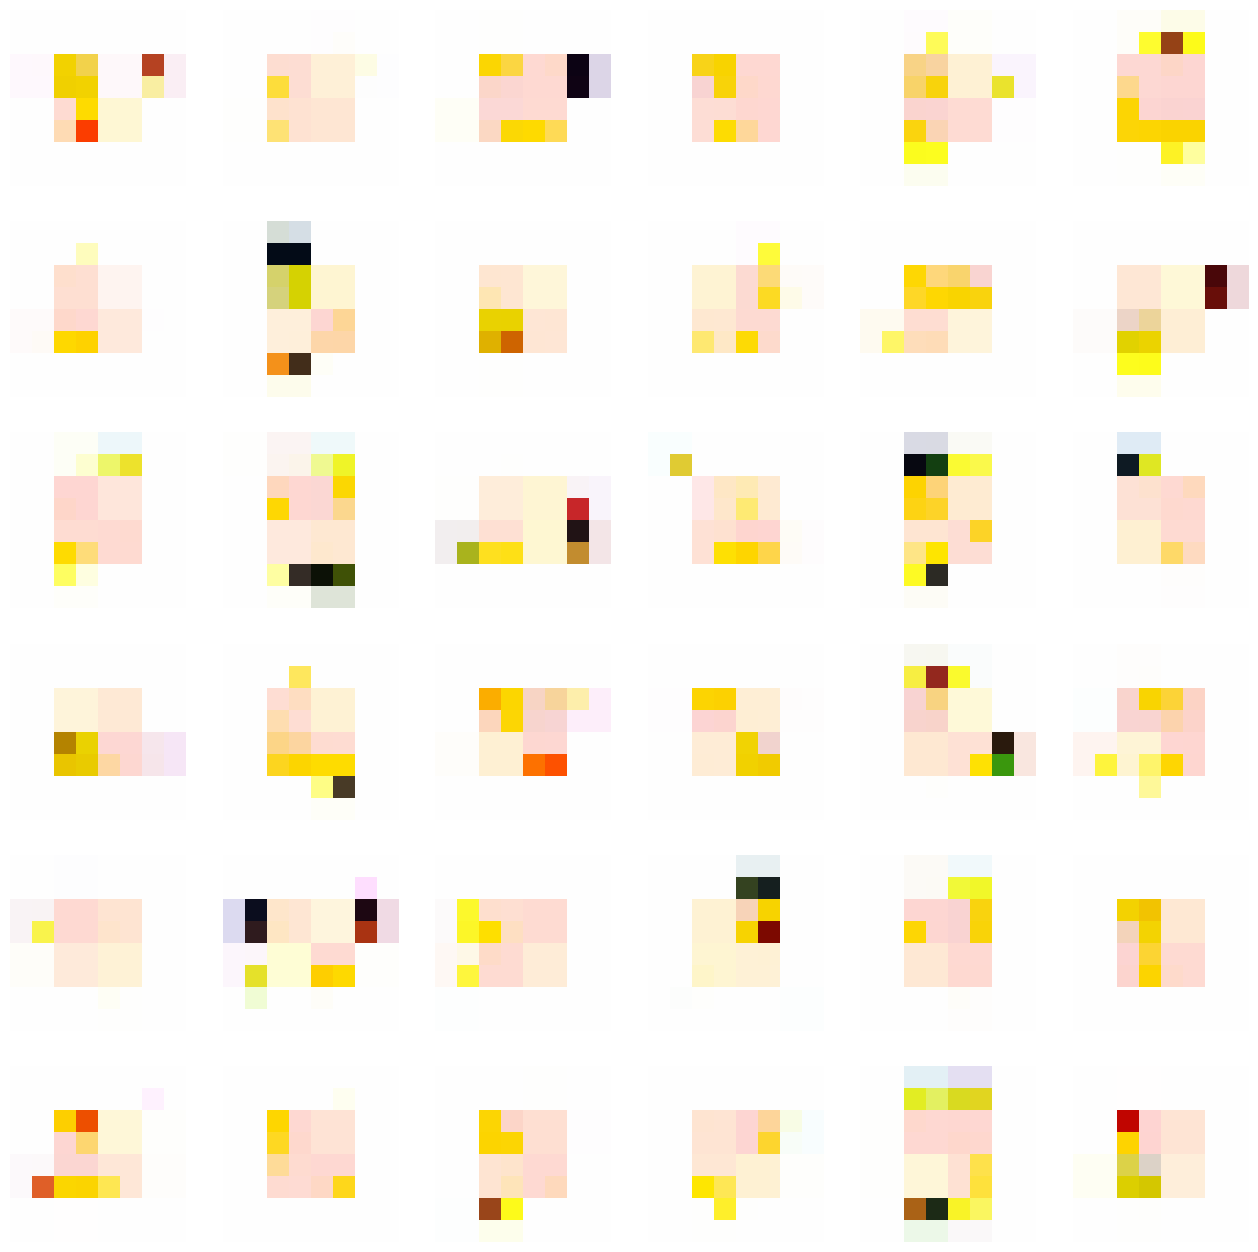

25/25 [==============================] - 37s 2s/step - d_loss: -2.3720 - g_loss: 2.6485
Epoch 43/50
25/25 [==============================] - ETA: 0s - d_loss: -2.4450 - g_loss: 3.1090

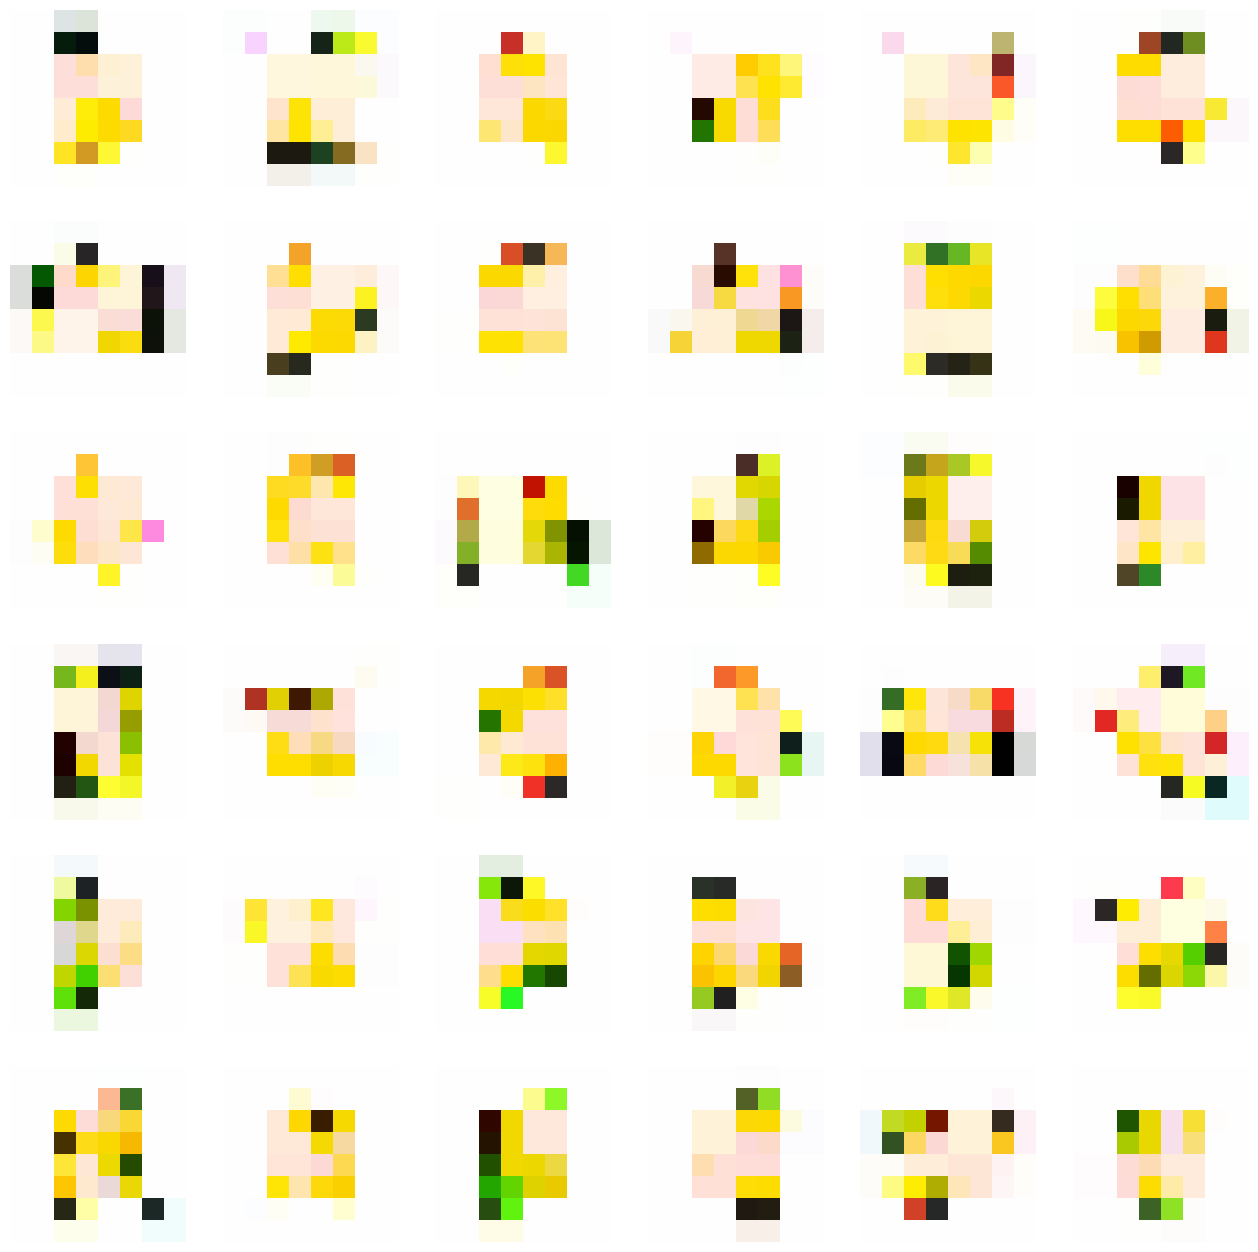

25/25 [==============================] - 35s 1s/step - d_loss: -2.4823 - g_loss: 2.9130
Epoch 44/50
25/25 [==============================] - ETA: 0s - d_loss: -2.3225 - g_loss: 3.4863

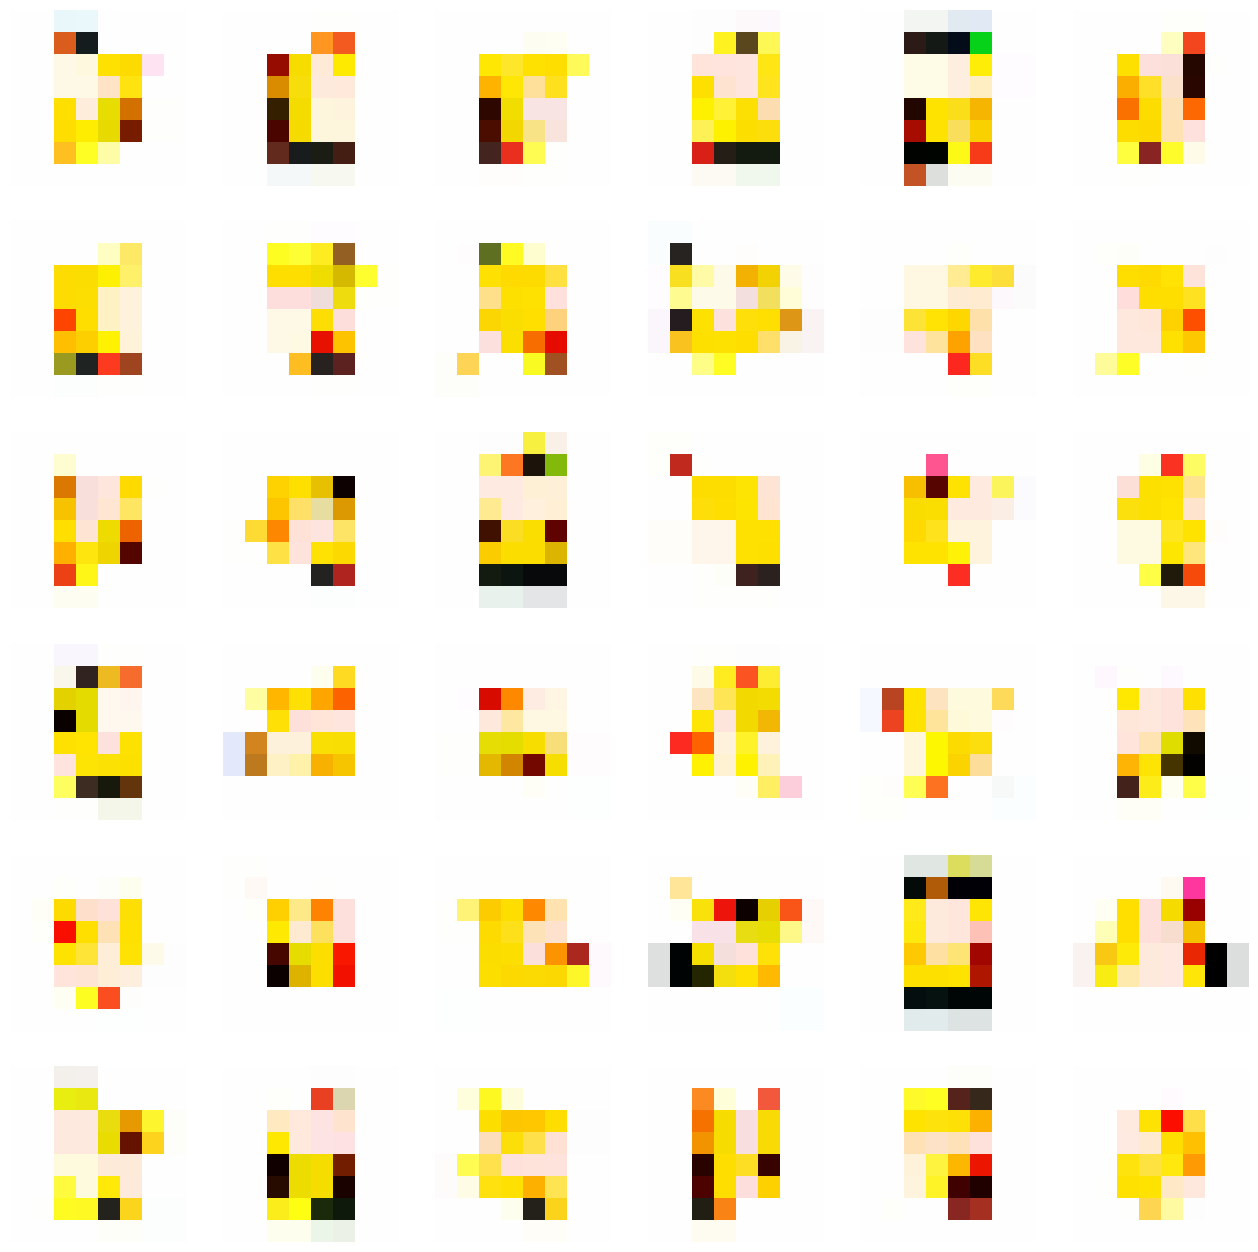

25/25 [==============================] - 36s 1s/step - d_loss: -2.3102 - g_loss: 3.8232
Epoch 45/50
25/25 [==============================] - ETA: 0s - d_loss: -2.2976 - g_loss: 2.8036

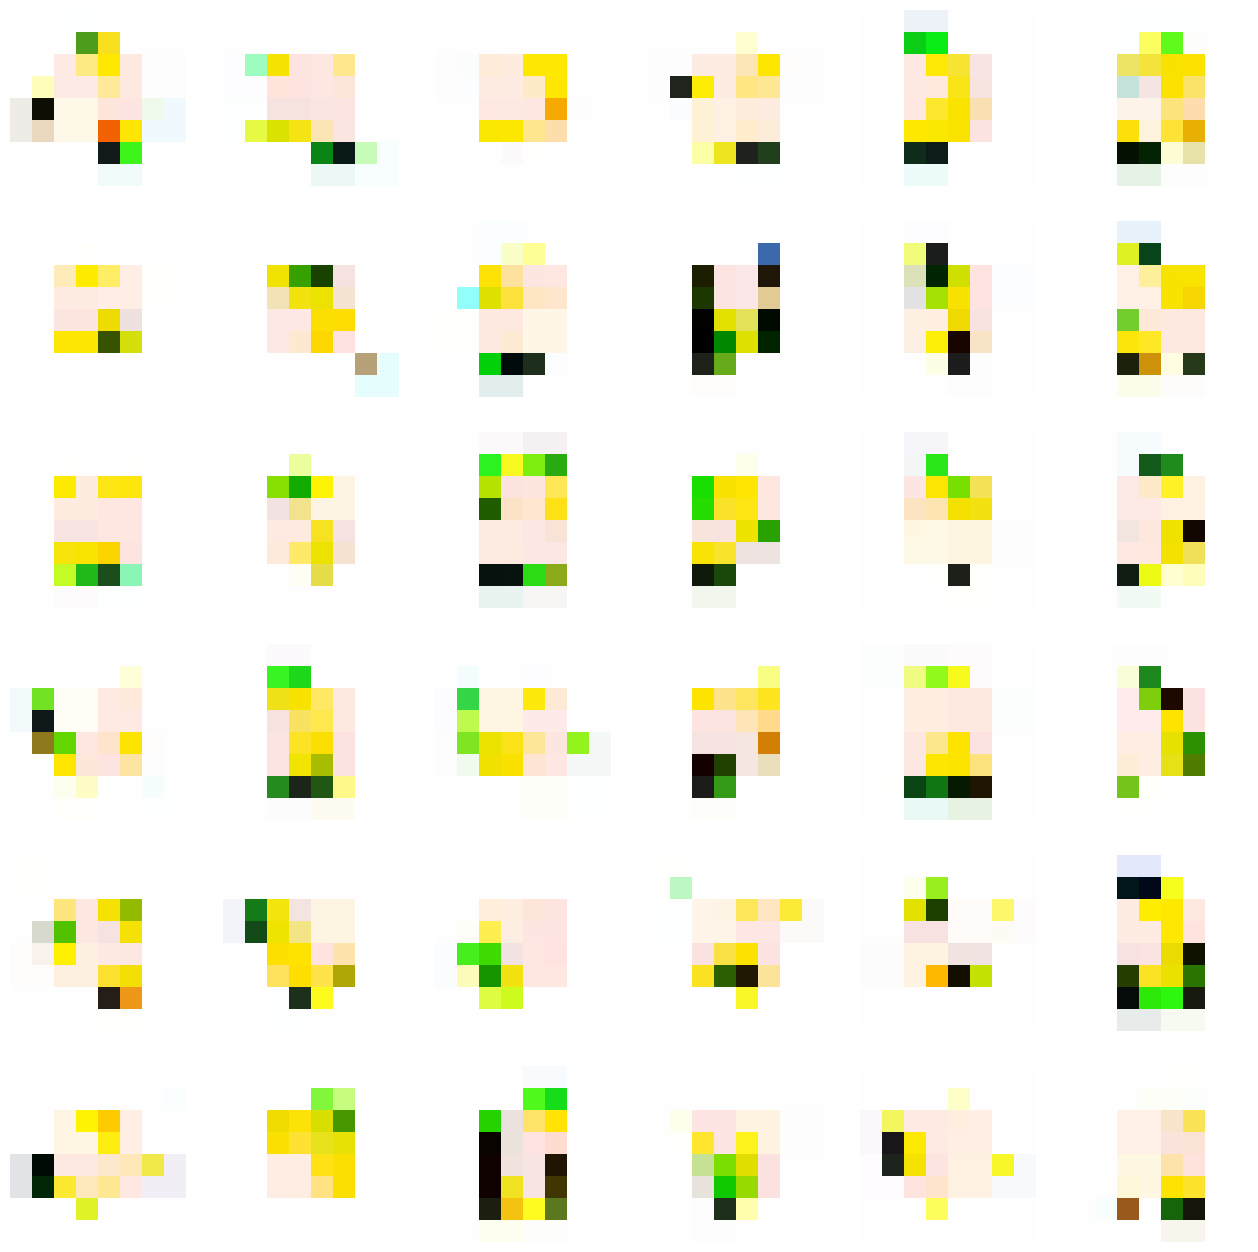

25/25 [==============================] - 36s 1s/step - d_loss: -2.2546 - g_loss: 2.6853
Epoch 46/50
25/25 [==============================] - ETA: 0s - d_loss: -2.1593 - g_loss: 3.1117

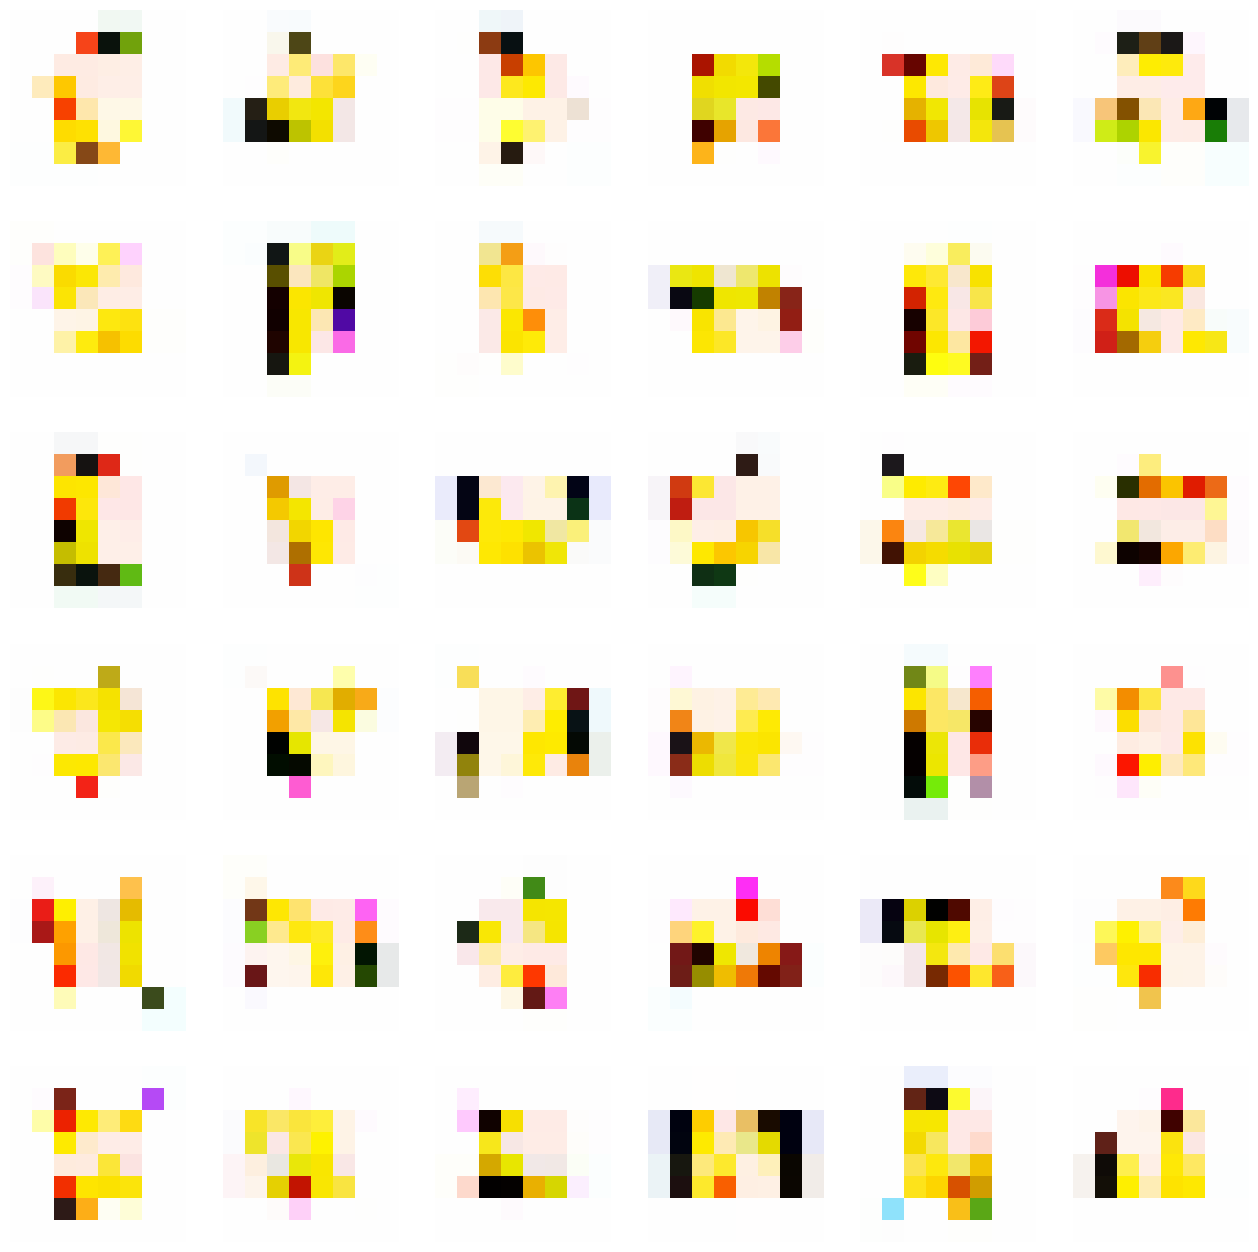

25/25 [==============================] - 36s 1s/step - d_loss: -2.1632 - g_loss: 3.0768
Epoch 47/50
25/25 [==============================] - ETA: 0s - d_loss: -2.1610 - g_loss: 3.3544

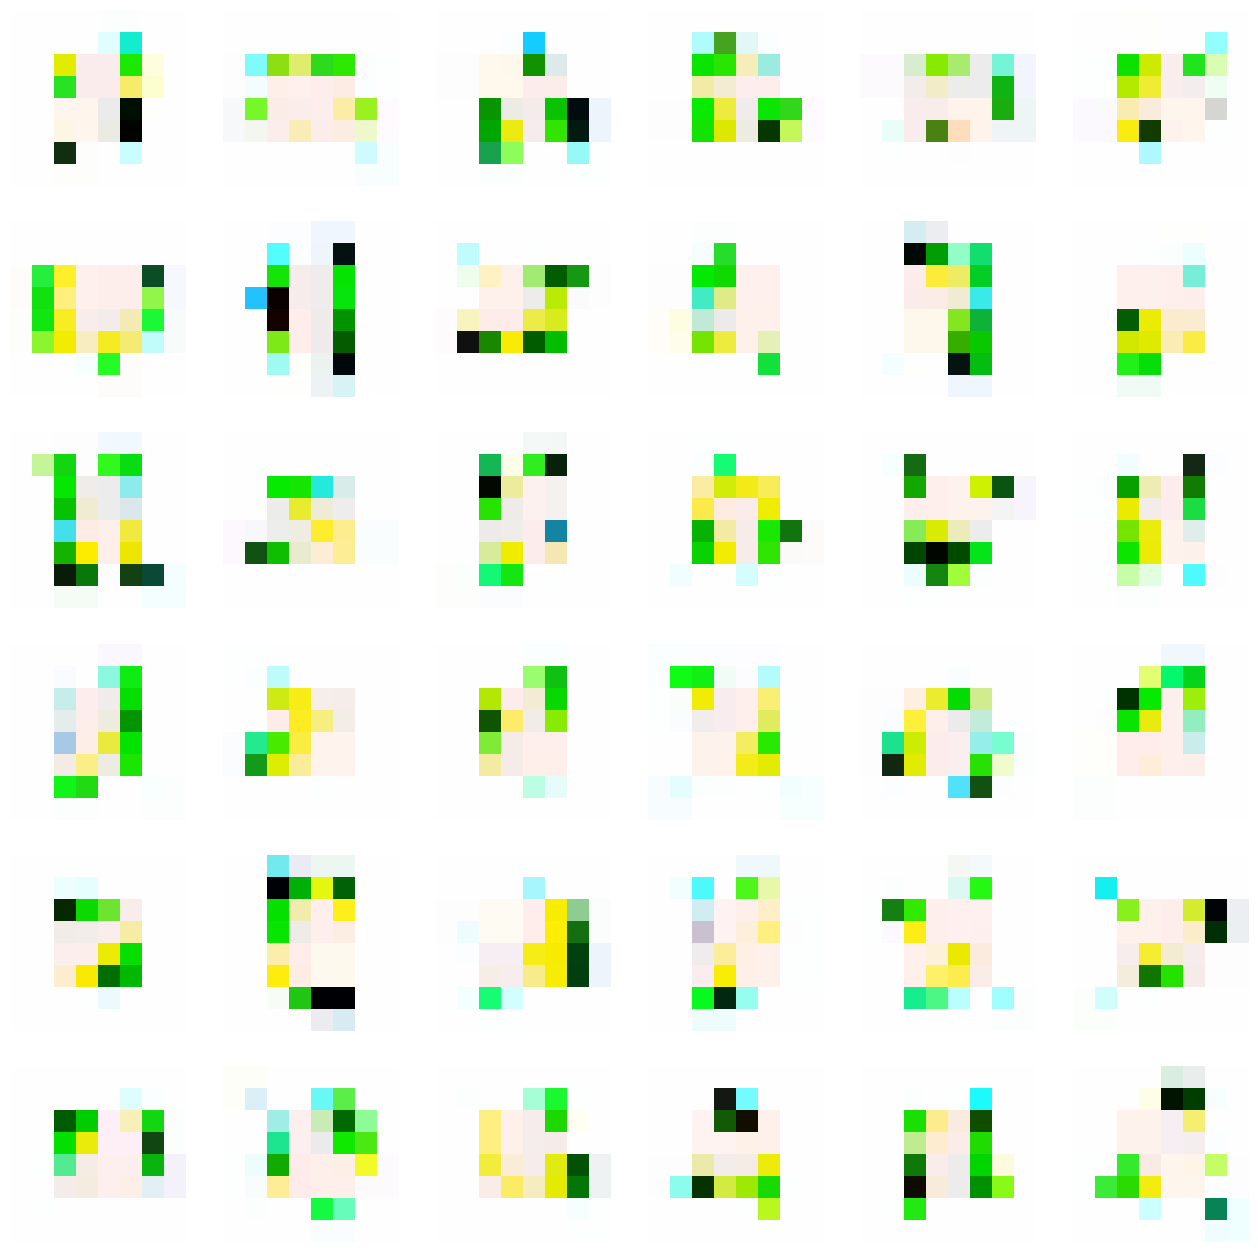

25/25 [==============================] - 37s 2s/step - d_loss: -2.1450 - g_loss: 3.1999
Epoch 48/50
25/25 [==============================] - ETA: 0s - d_loss: -2.1700 - g_loss: 2.5866

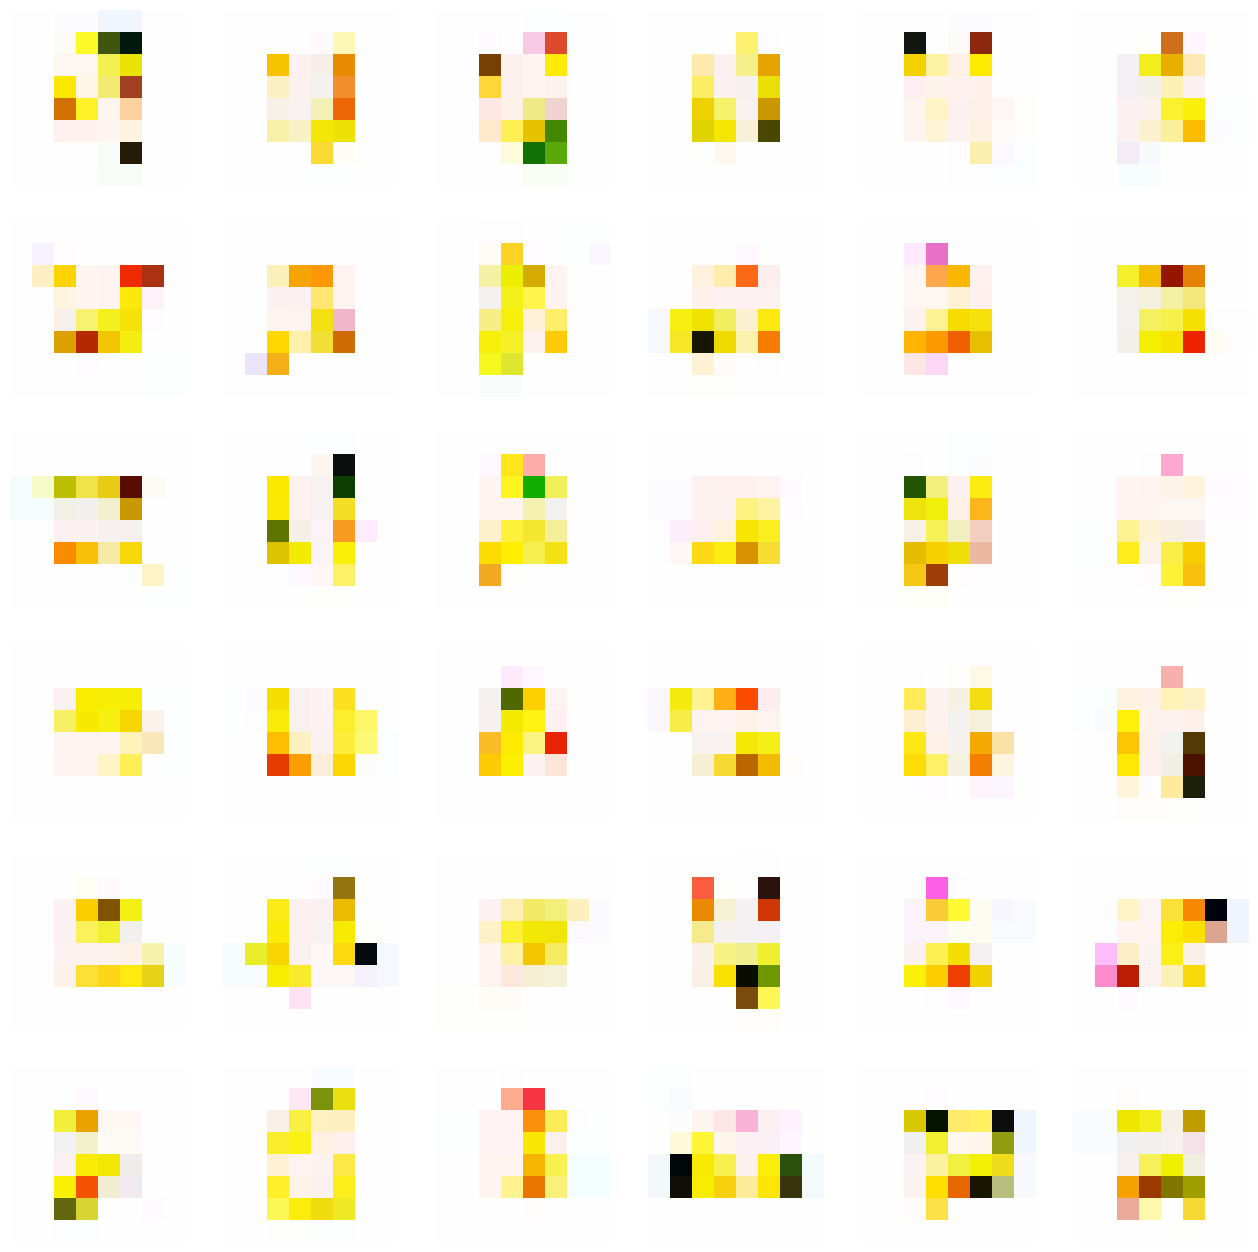

25/25 [==============================] - 36s 1s/step - d_loss: -2.2182 - g_loss: 2.6628
Epoch 49/50
25/25 [==============================] - ETA: 0s - d_loss: -2.2358 - g_loss: 3.4391

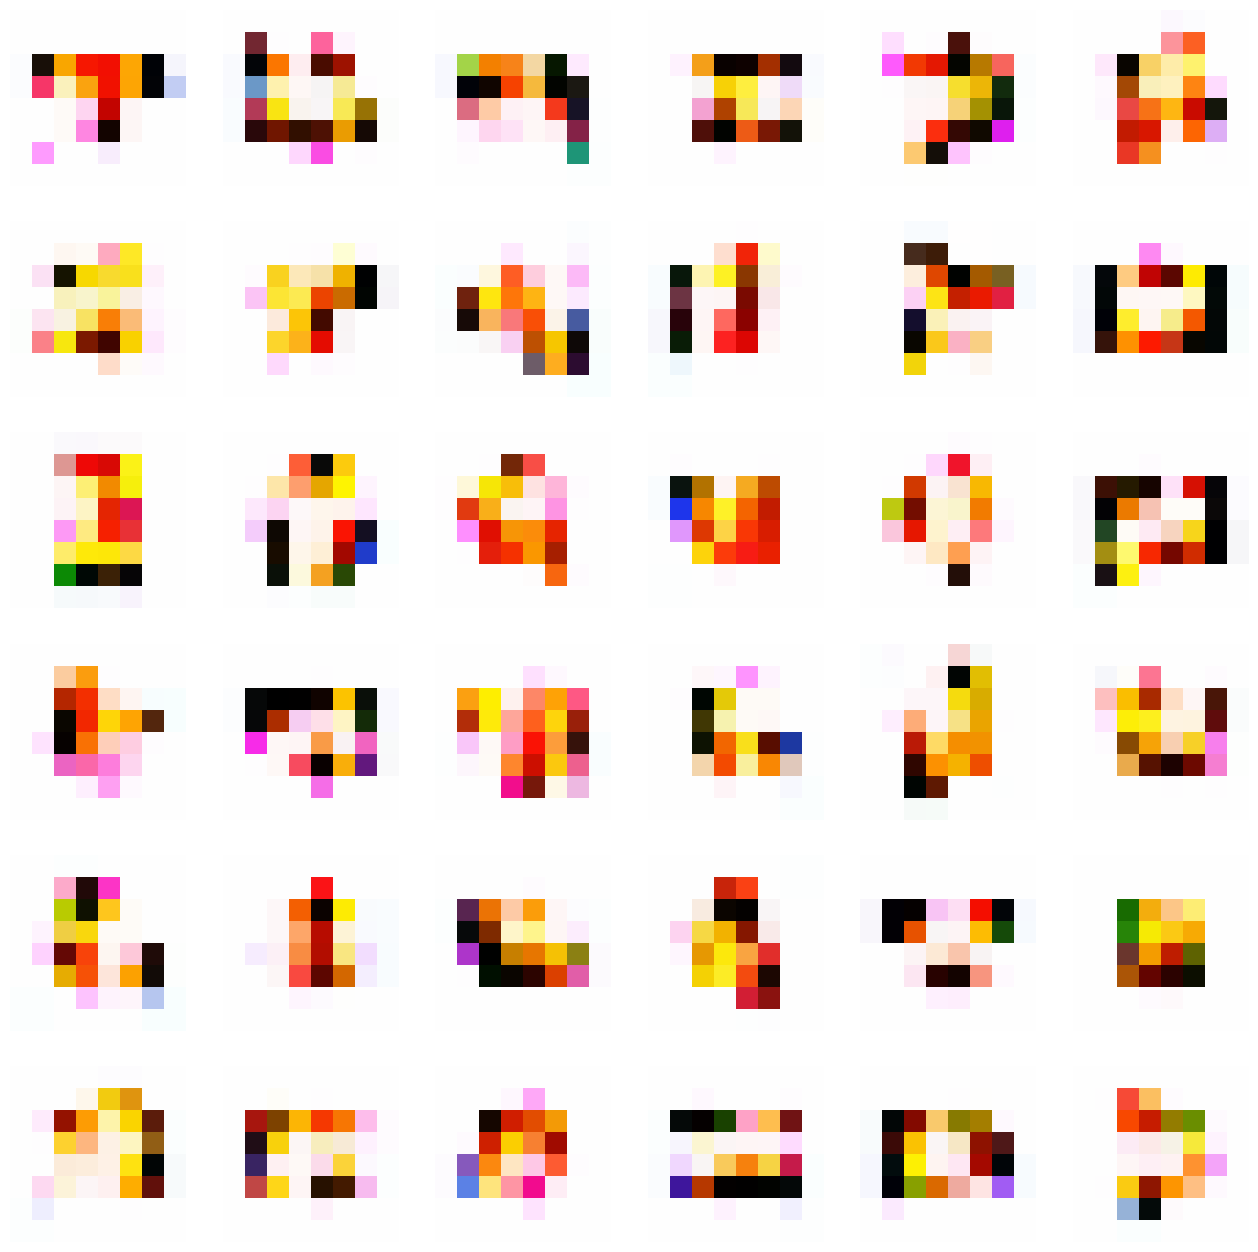

25/25 [==============================] - 36s 1s/step - d_loss: -2.2922 - g_loss: 3.4512
Epoch 50/50
25/25 [==============================] - ETA: 0s - d_loss: -2.3283 - g_loss: 2.8759

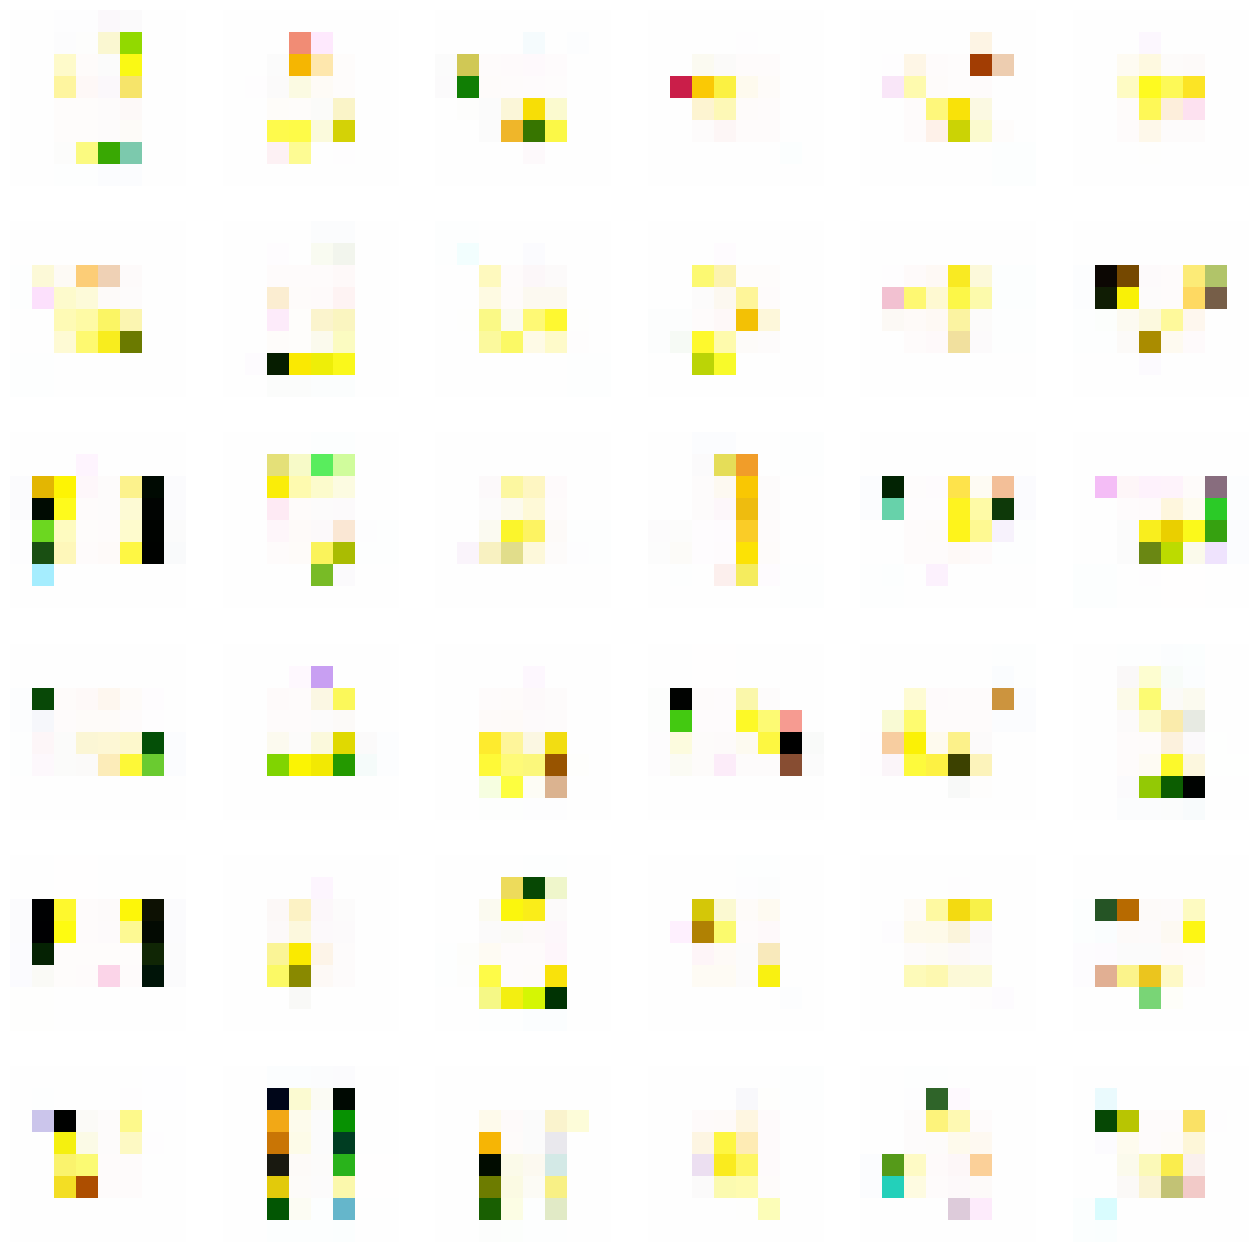

25/25 [==============================] - 36s 1s/step - d_loss: -2.3198 - g_loss: 2.6604
Model: "generator_stabilize"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_39 (InputLayer)       [(None, 512)]                0         []                            
                                                                                                  
 input_40 (InputLayer)       [(None, 256)]                0         []                            
                                                                                                  
 concatenate_17 (Concatenat  (None, 768)                  0         ['input_39[0][0]',            
 e)                                                                  'input_40[0][0]']            
                                                                                           

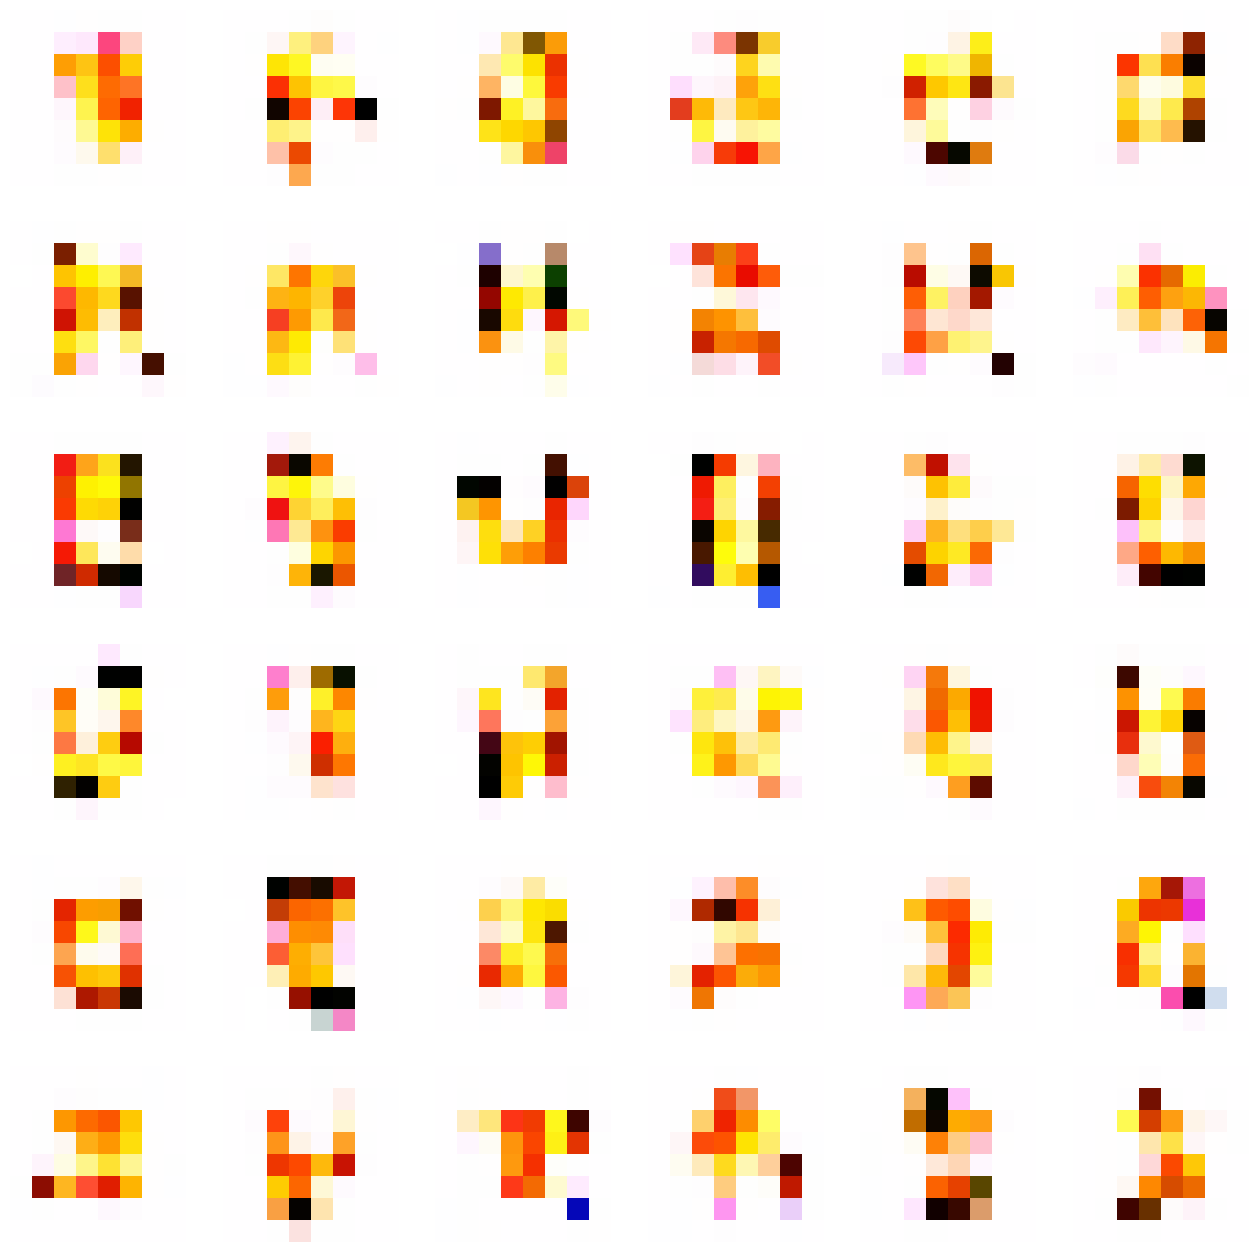

25/25 [==============================] - 40s 1s/step - d_loss: -1.9972 - g_loss: 2.5895
Epoch 2/50
25/25 [==============================] - ETA: 0s - d_loss: -2.0549 - g_loss: 2.9522

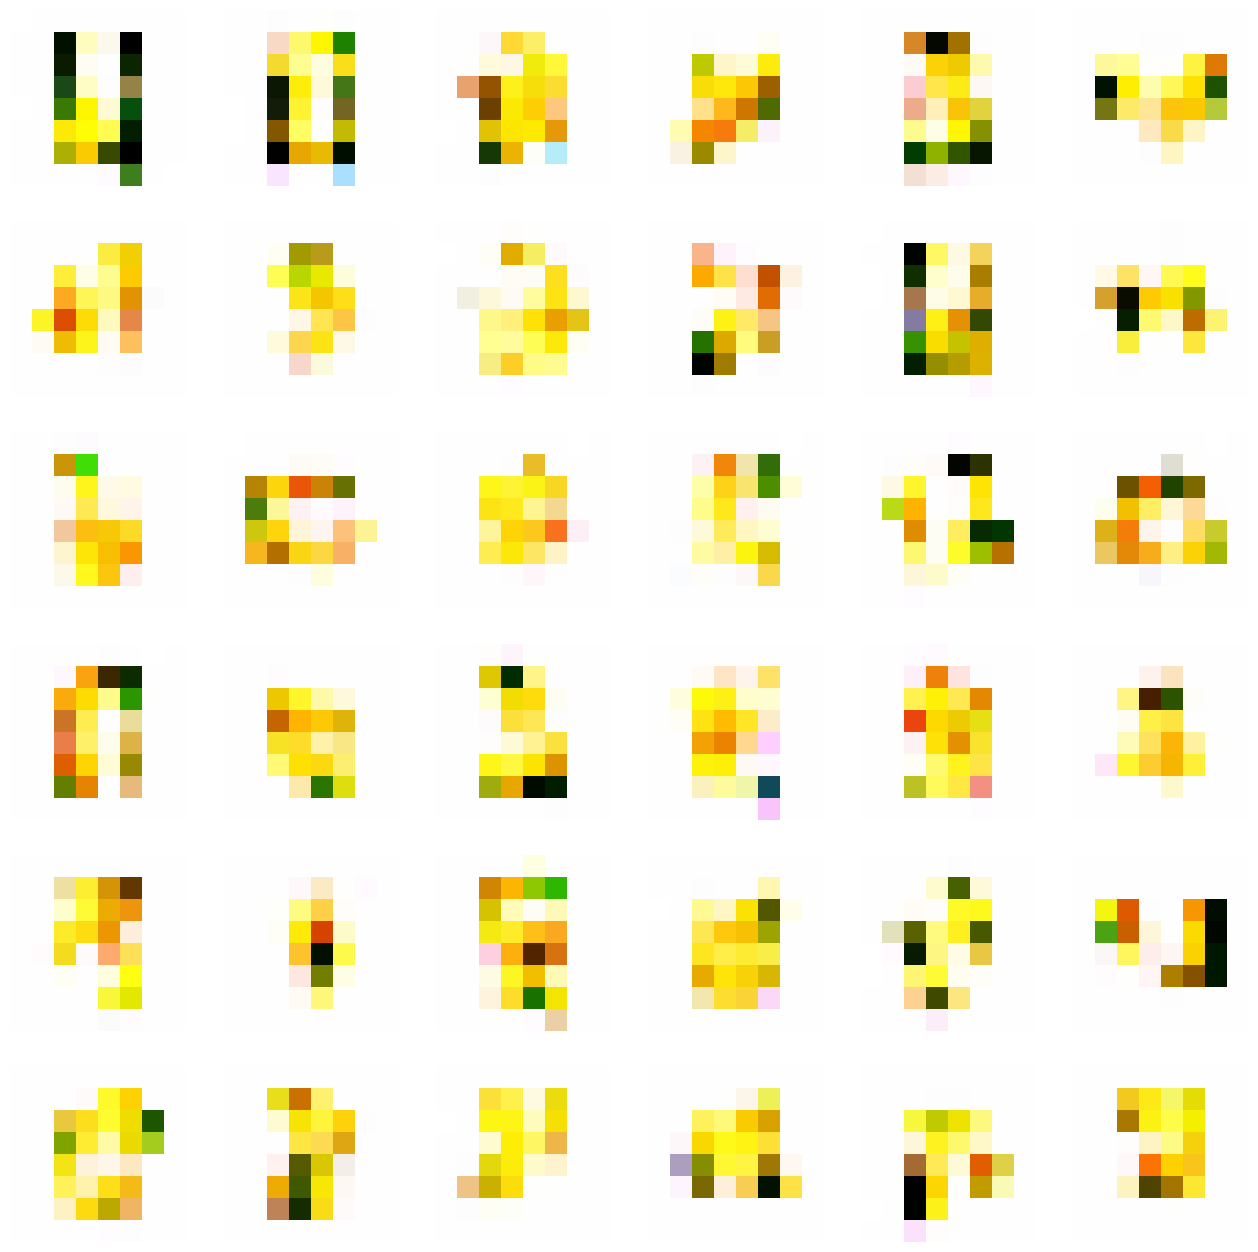

25/25 [==============================] - 37s 1s/step - d_loss: -2.0347 - g_loss: 2.9938
Epoch 3/50
25/25 [==============================] - ETA: 0s - d_loss: -2.1001 - g_loss: 3.3260

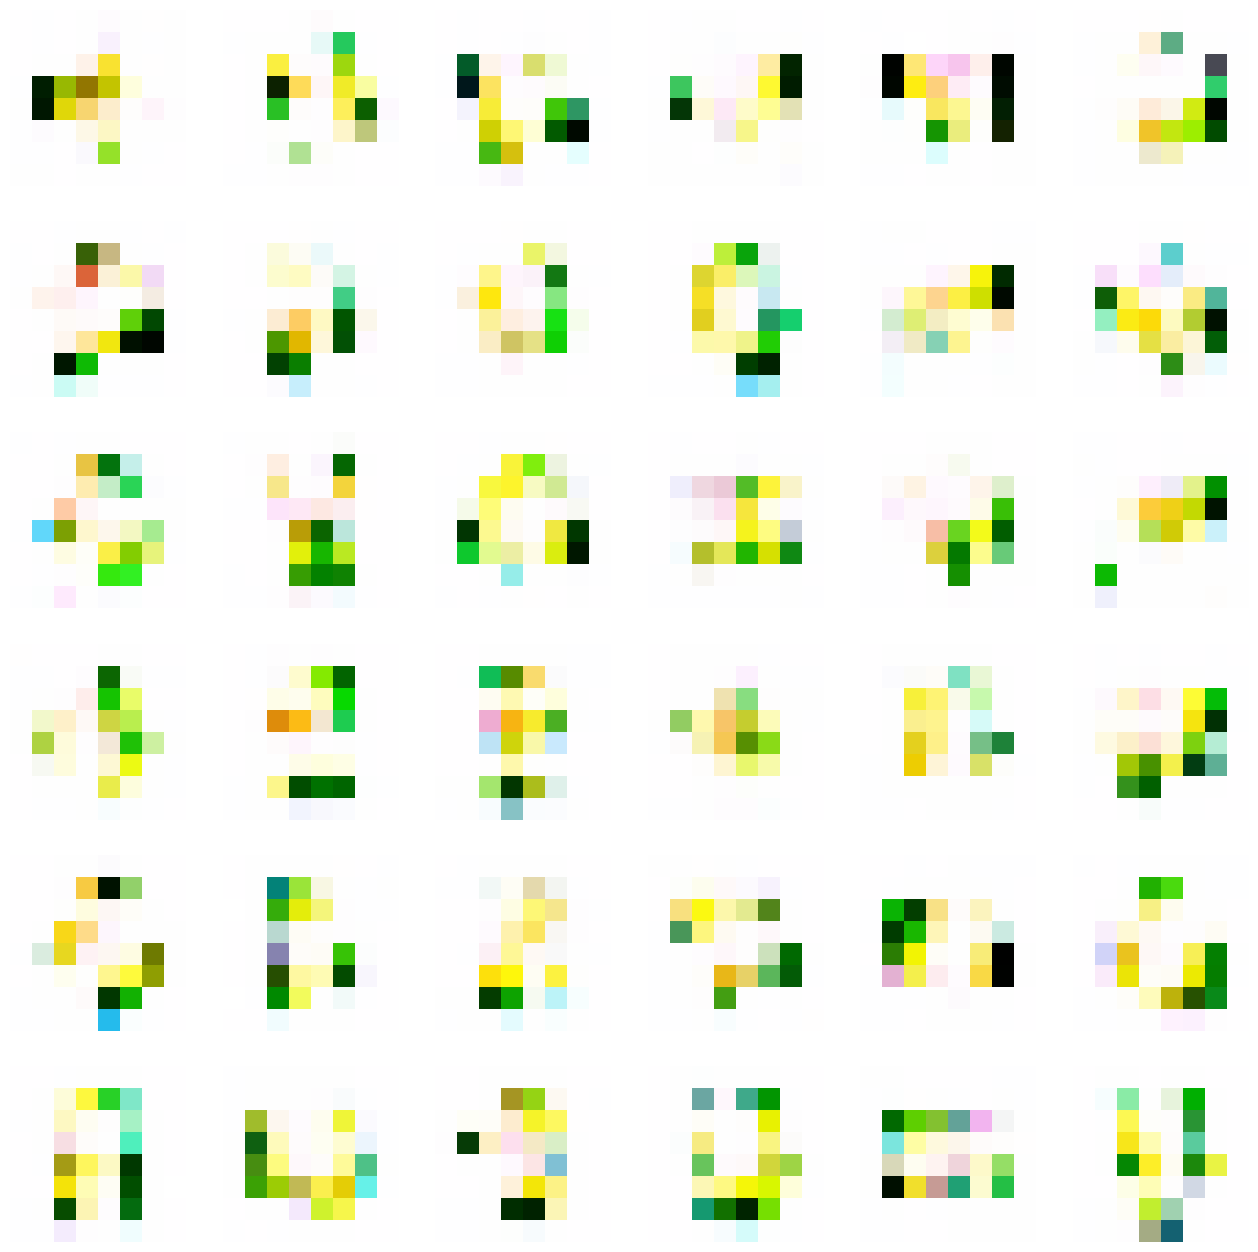

25/25 [==============================] - 36s 1s/step - d_loss: -2.1016 - g_loss: 3.3014
Epoch 4/50
25/25 [==============================] - ETA: 0s - d_loss: -2.2808 - g_loss: 3.1542

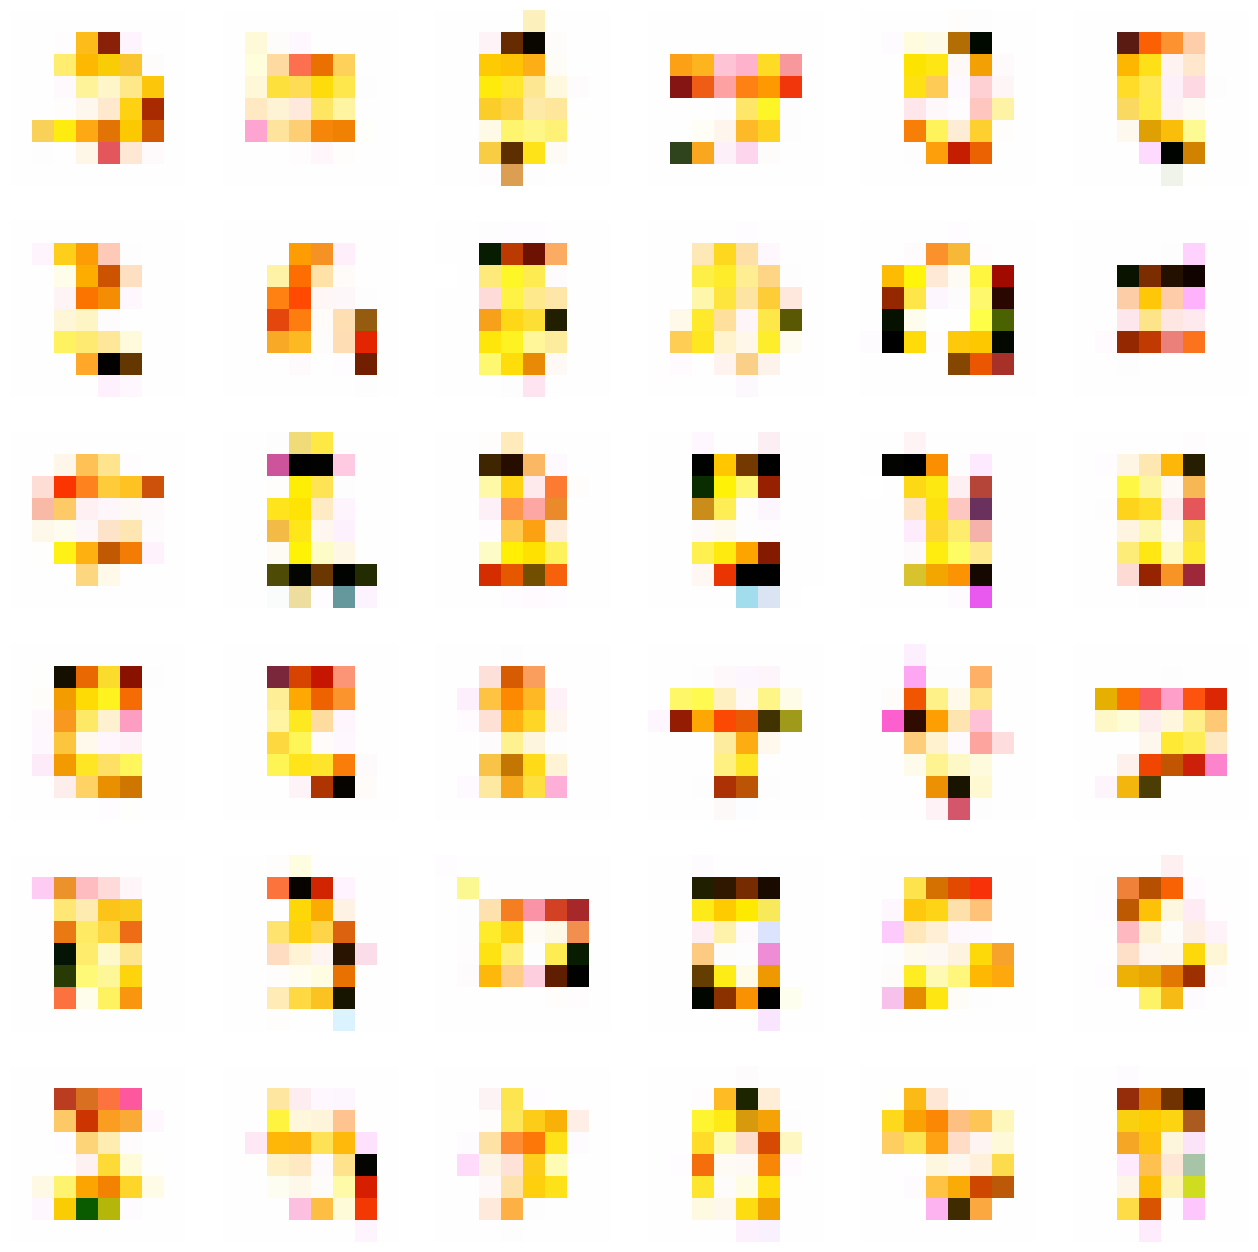

25/25 [==============================] - 35s 1s/step - d_loss: -2.2648 - g_loss: 3.1500
Epoch 5/50
25/25 [==============================] - ETA: 0s - d_loss: -2.0801 - g_loss: 2.9804

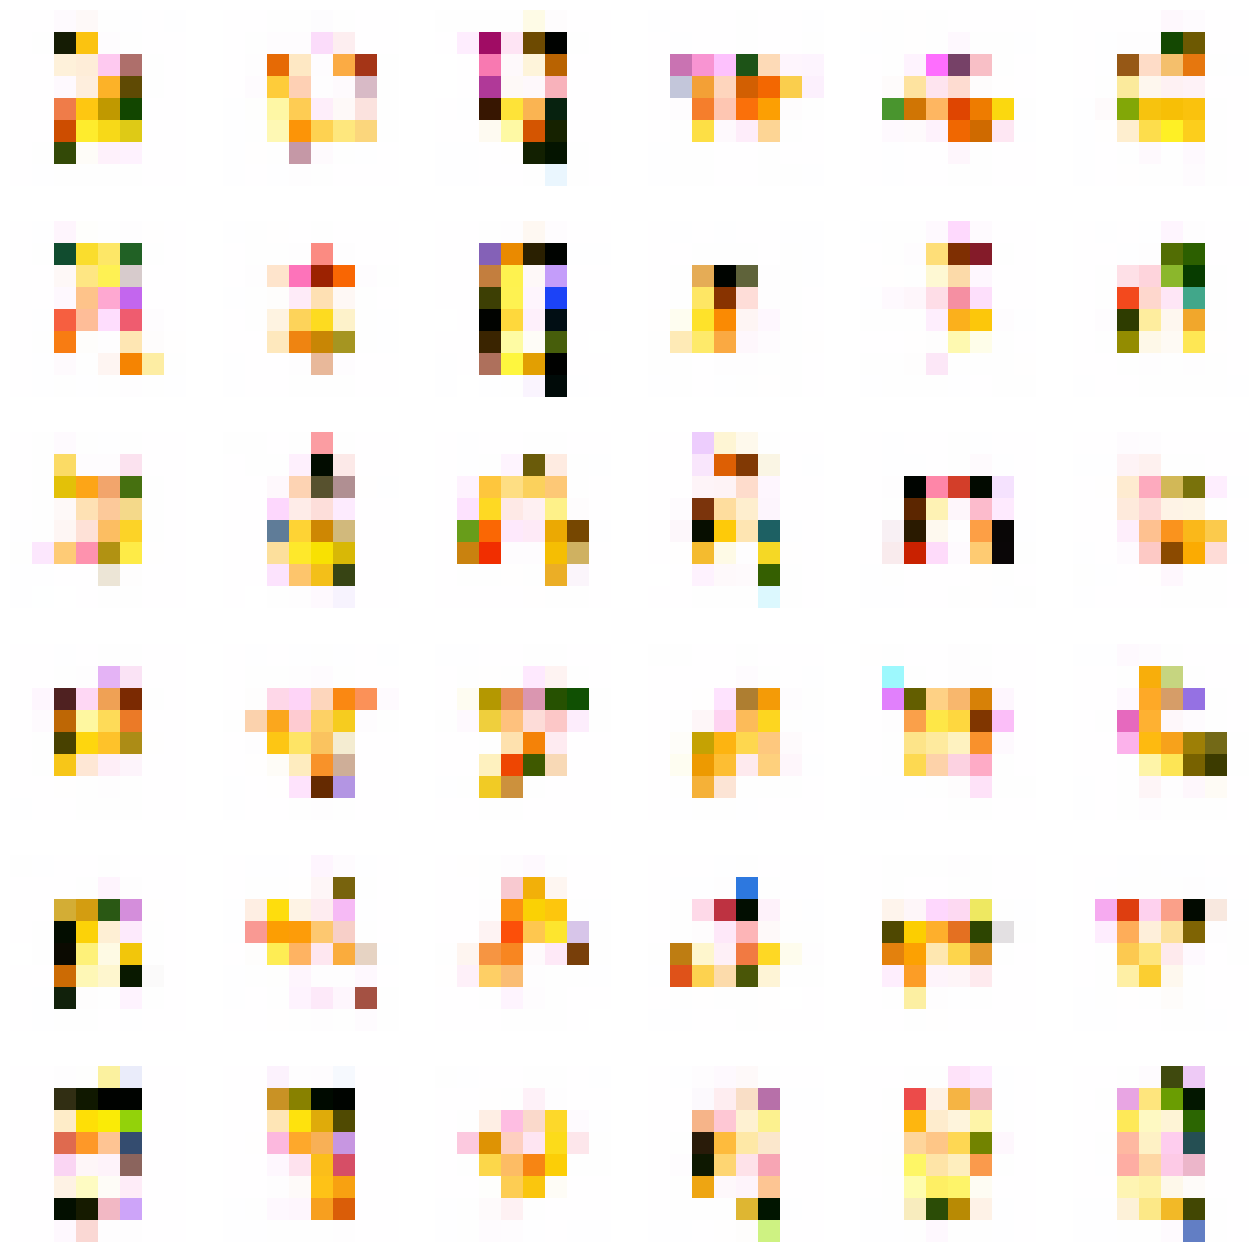

25/25 [==============================] - 38s 2s/step - d_loss: -2.0515 - g_loss: 3.0484
Epoch 6/50
25/25 [==============================] - ETA: 0s - d_loss: -2.0282 - g_loss: 2.4953

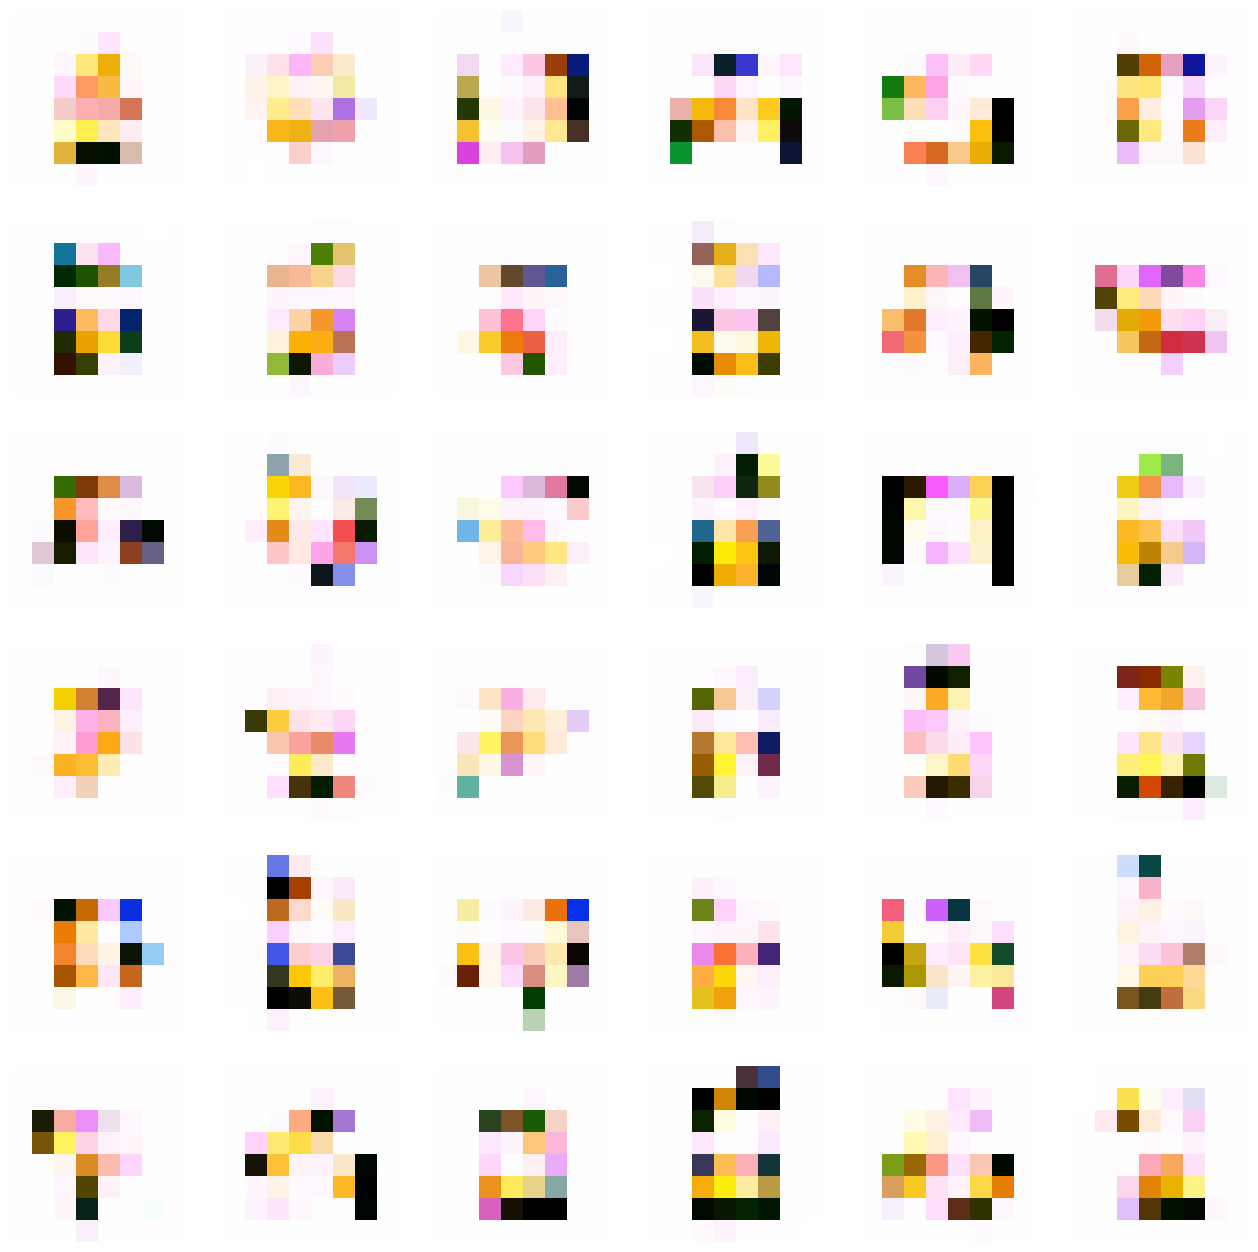

25/25 [==============================] - 36s 1s/step - d_loss: -2.0007 - g_loss: 2.4495
Epoch 7/50
25/25 [==============================] - ETA: 0s - d_loss: -2.0106 - g_loss: 3.1038

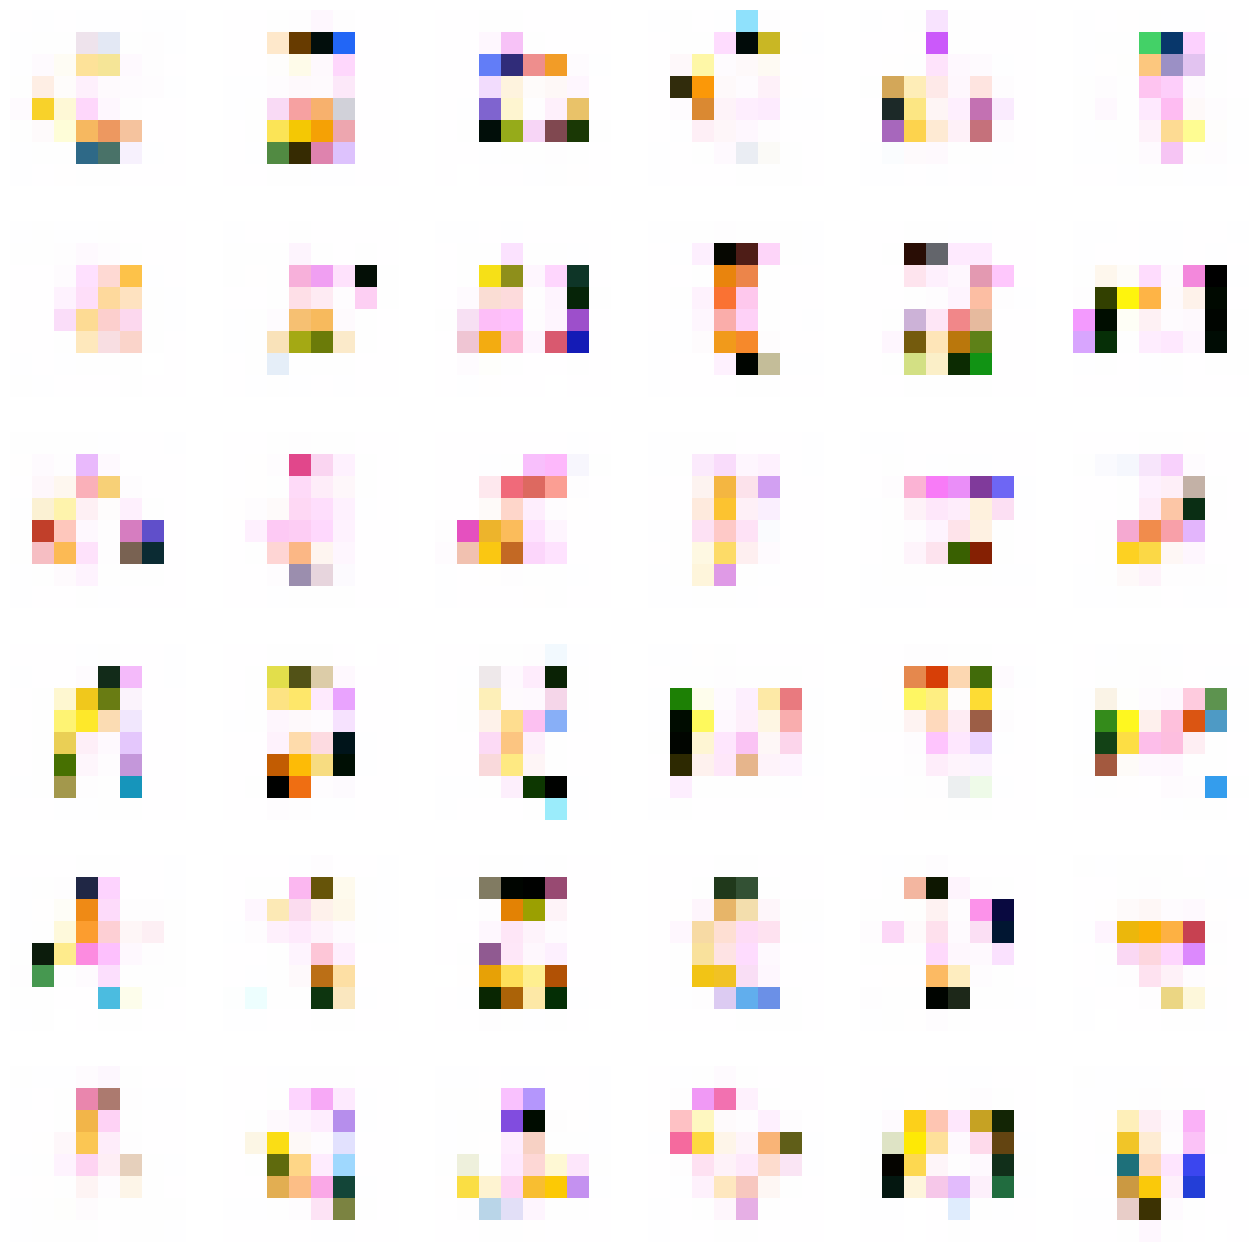

25/25 [==============================] - 36s 1s/step - d_loss: -2.0046 - g_loss: 3.1376
Epoch 8/50
25/25 [==============================] - ETA: 0s - d_loss: -2.0113 - g_loss: 2.9075

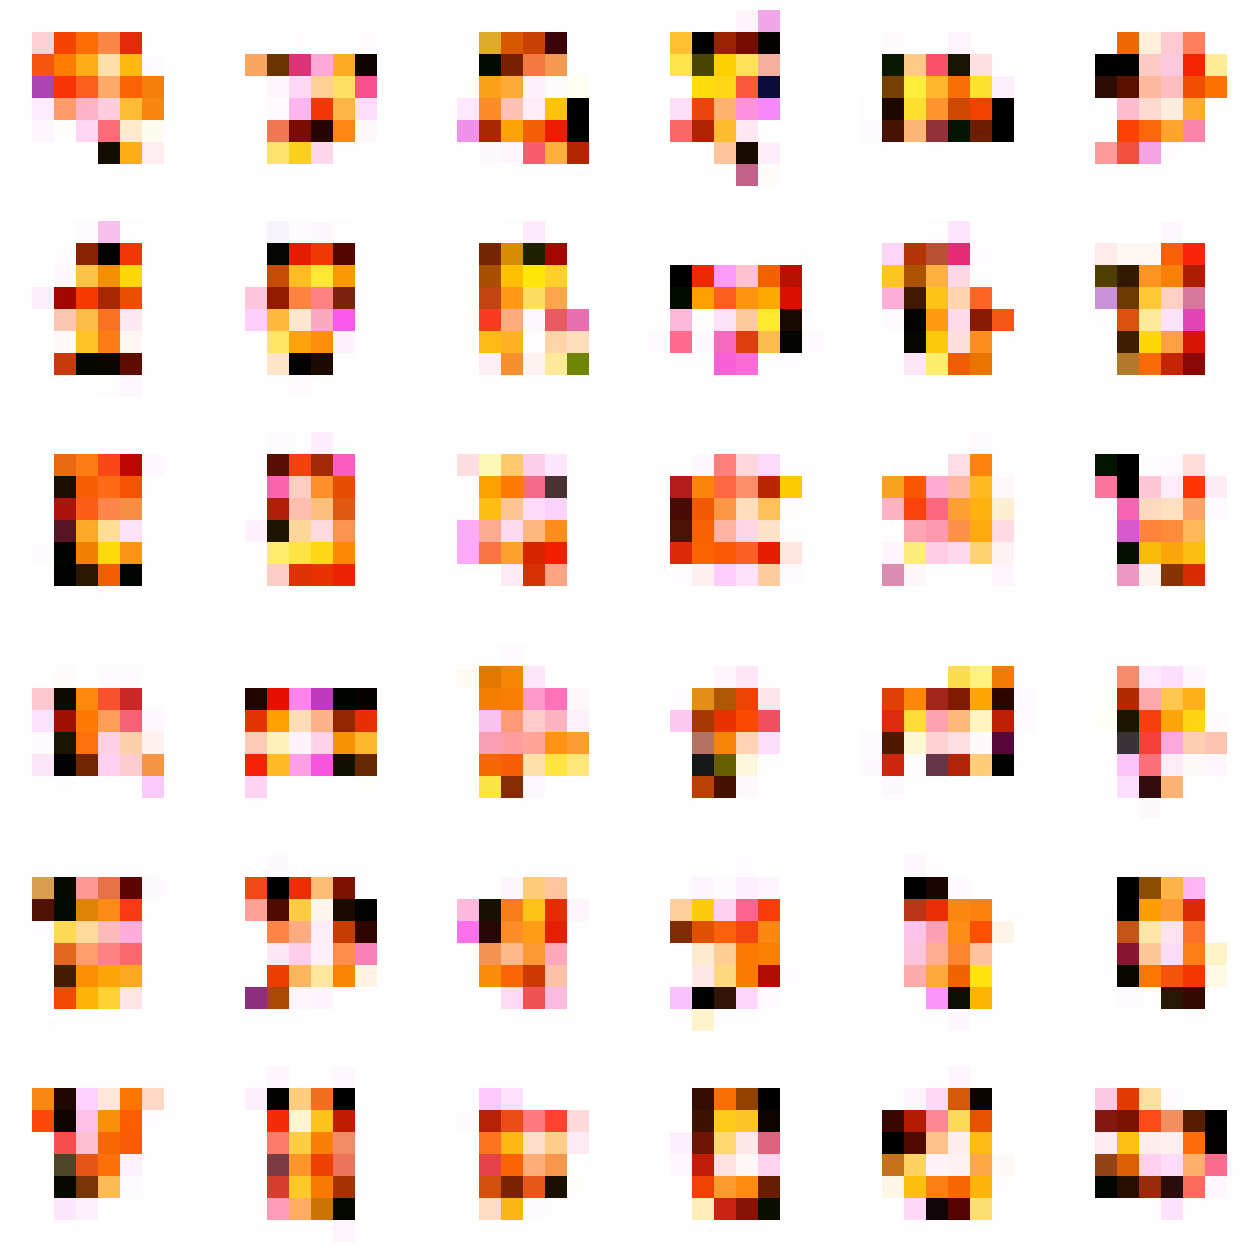

25/25 [==============================] - 36s 1s/step - d_loss: -1.9893 - g_loss: 3.0123
Epoch 9/50
25/25 [==============================] - ETA: 0s - d_loss: -2.0303 - g_loss: 2.4616

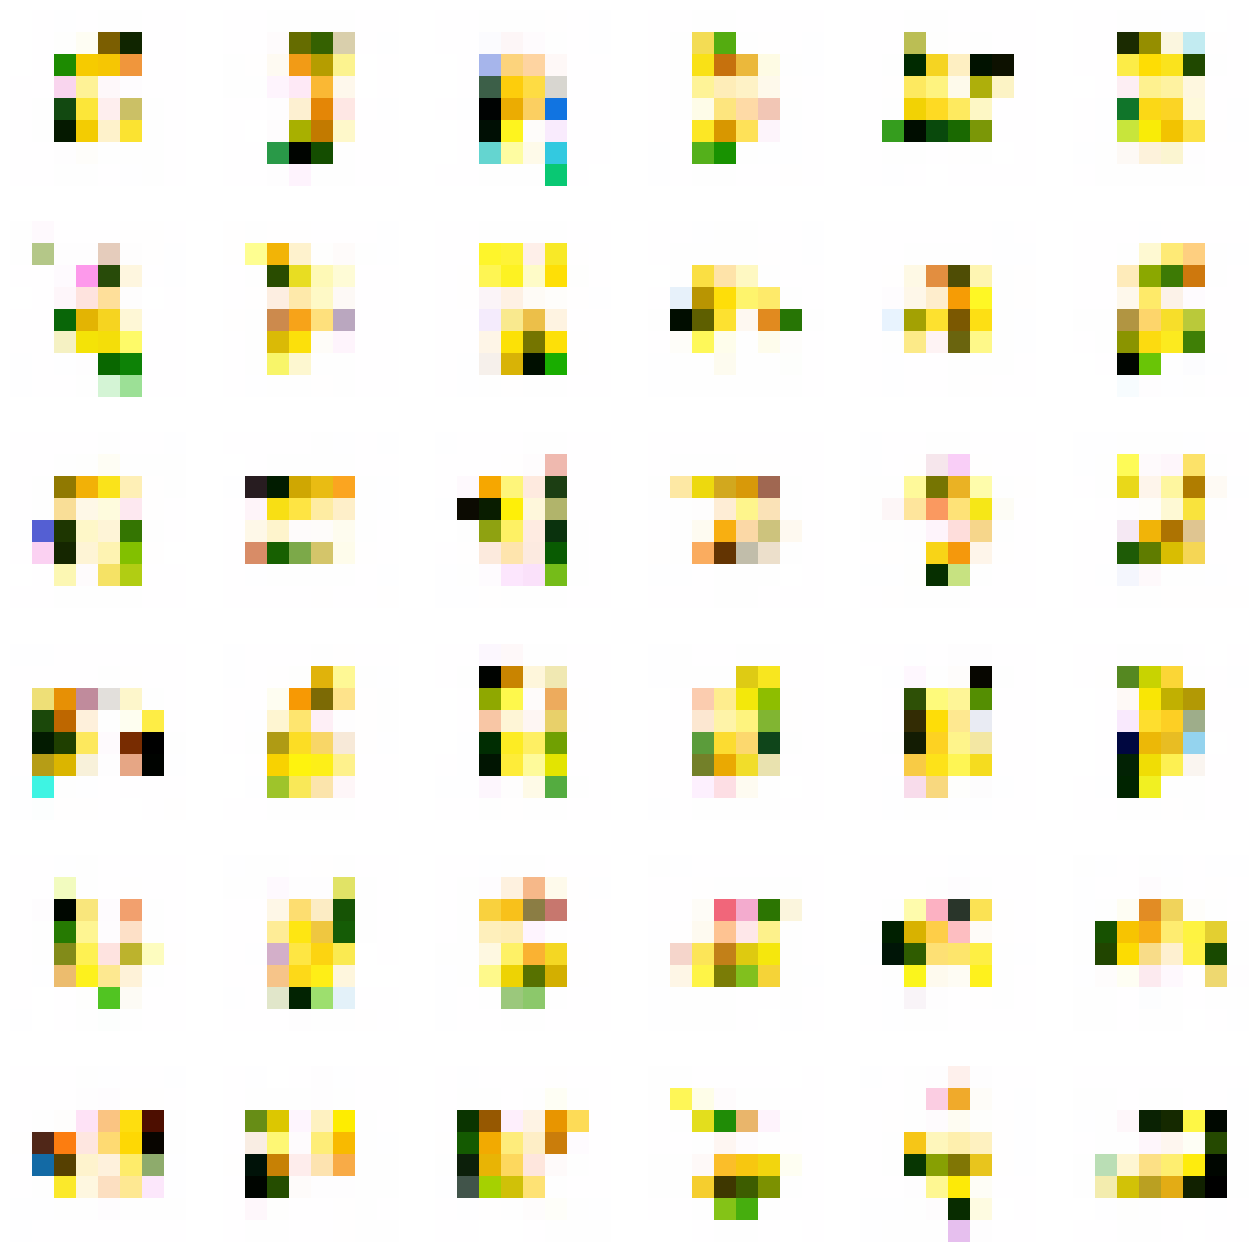

25/25 [==============================] - 37s 2s/step - d_loss: -2.0386 - g_loss: 2.4601
Epoch 10/50
25/25 [==============================] - ETA: 0s - d_loss: -2.1502 - g_loss: 2.9581

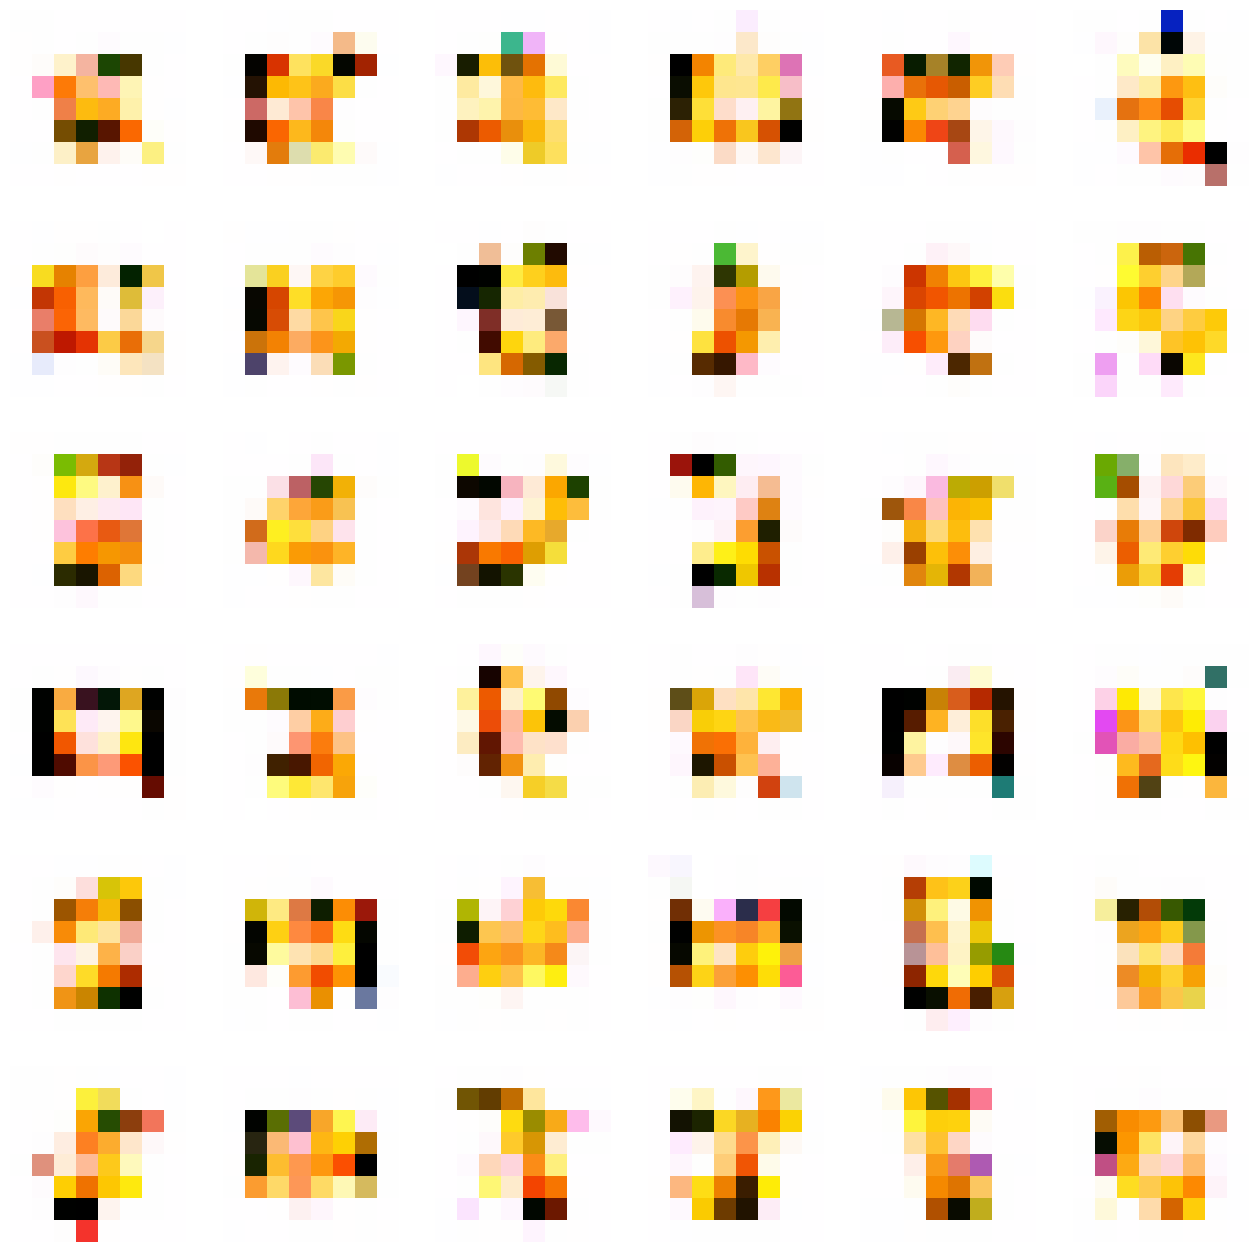

25/25 [==============================] - 36s 1s/step - d_loss: -2.1902 - g_loss: 2.9232
Epoch 11/50
25/25 [==============================] - ETA: 0s - d_loss: -2.0990 - g_loss: 2.7369

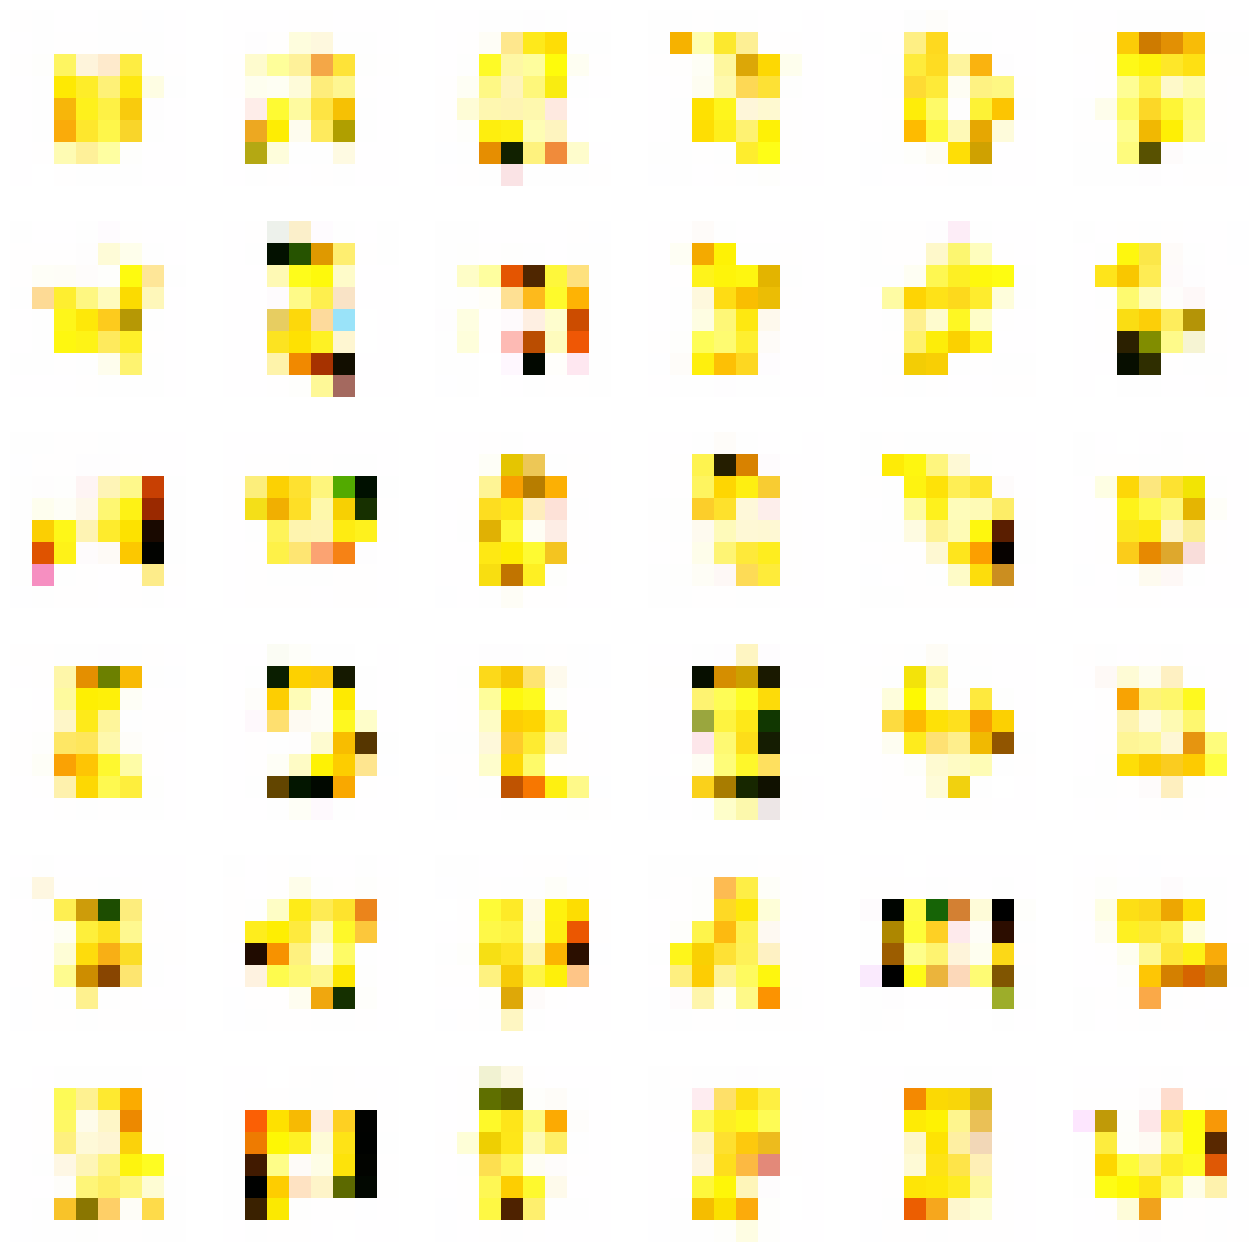

25/25 [==============================] - 36s 1s/step - d_loss: -2.0973 - g_loss: 2.7791
Epoch 12/50
25/25 [==============================] - ETA: 0s - d_loss: -2.1069 - g_loss: 2.9353

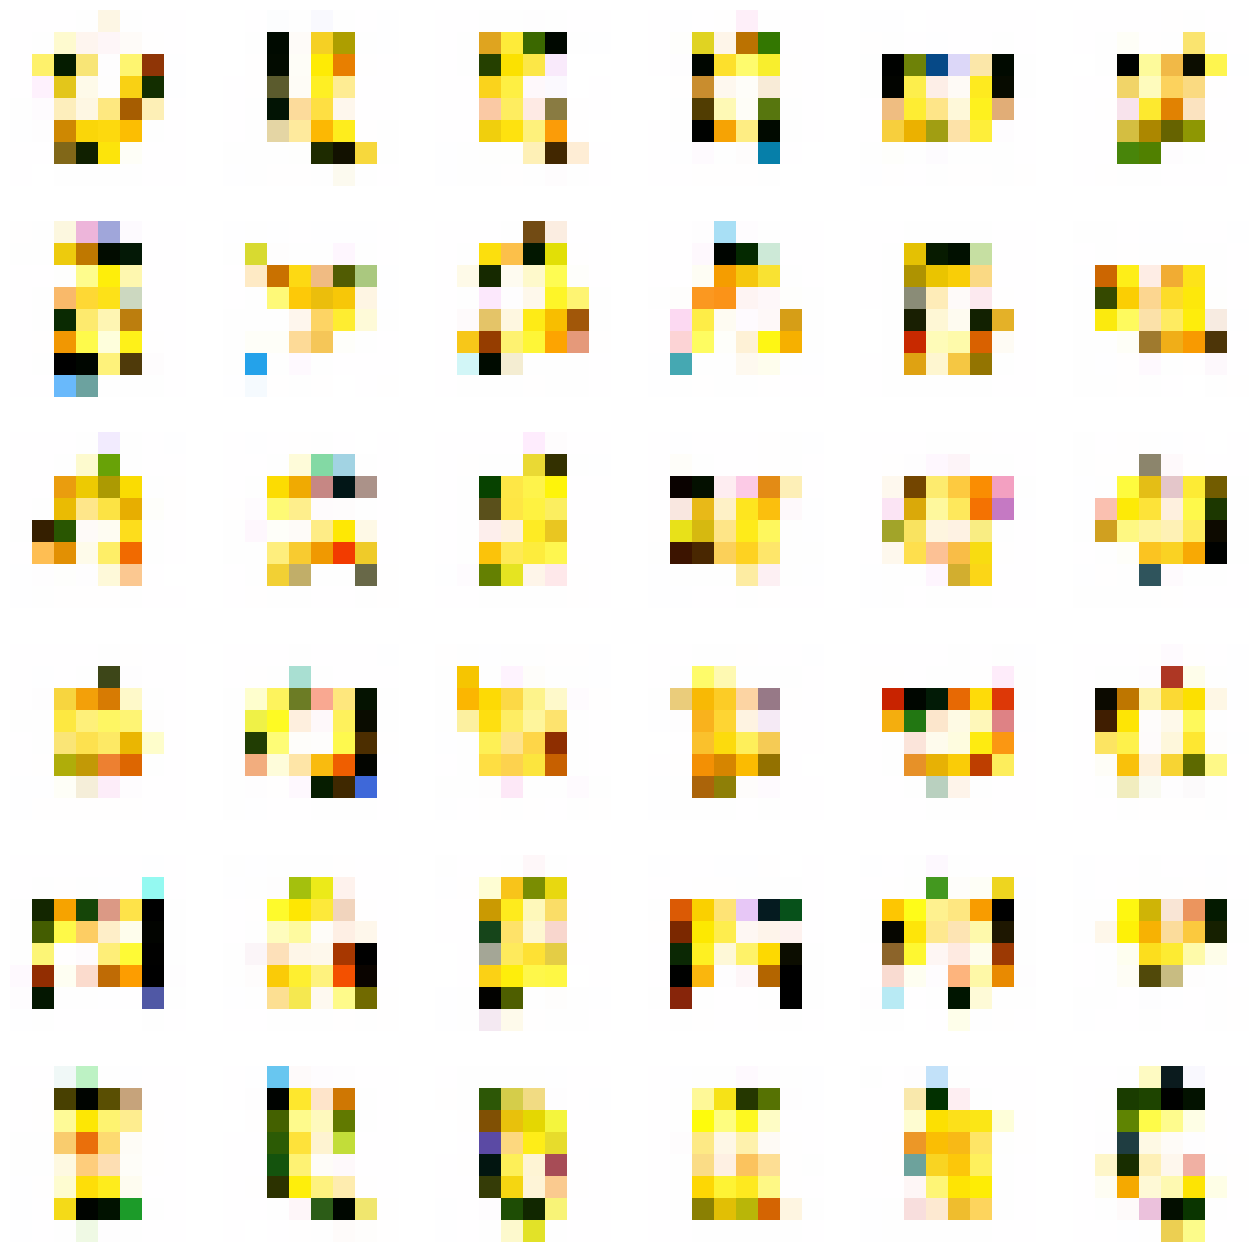

25/25 [==============================] - 36s 1s/step - d_loss: -2.1087 - g_loss: 2.9447
Epoch 13/50
25/25 [==============================] - ETA: 0s - d_loss: -2.1038 - g_loss: 2.5141

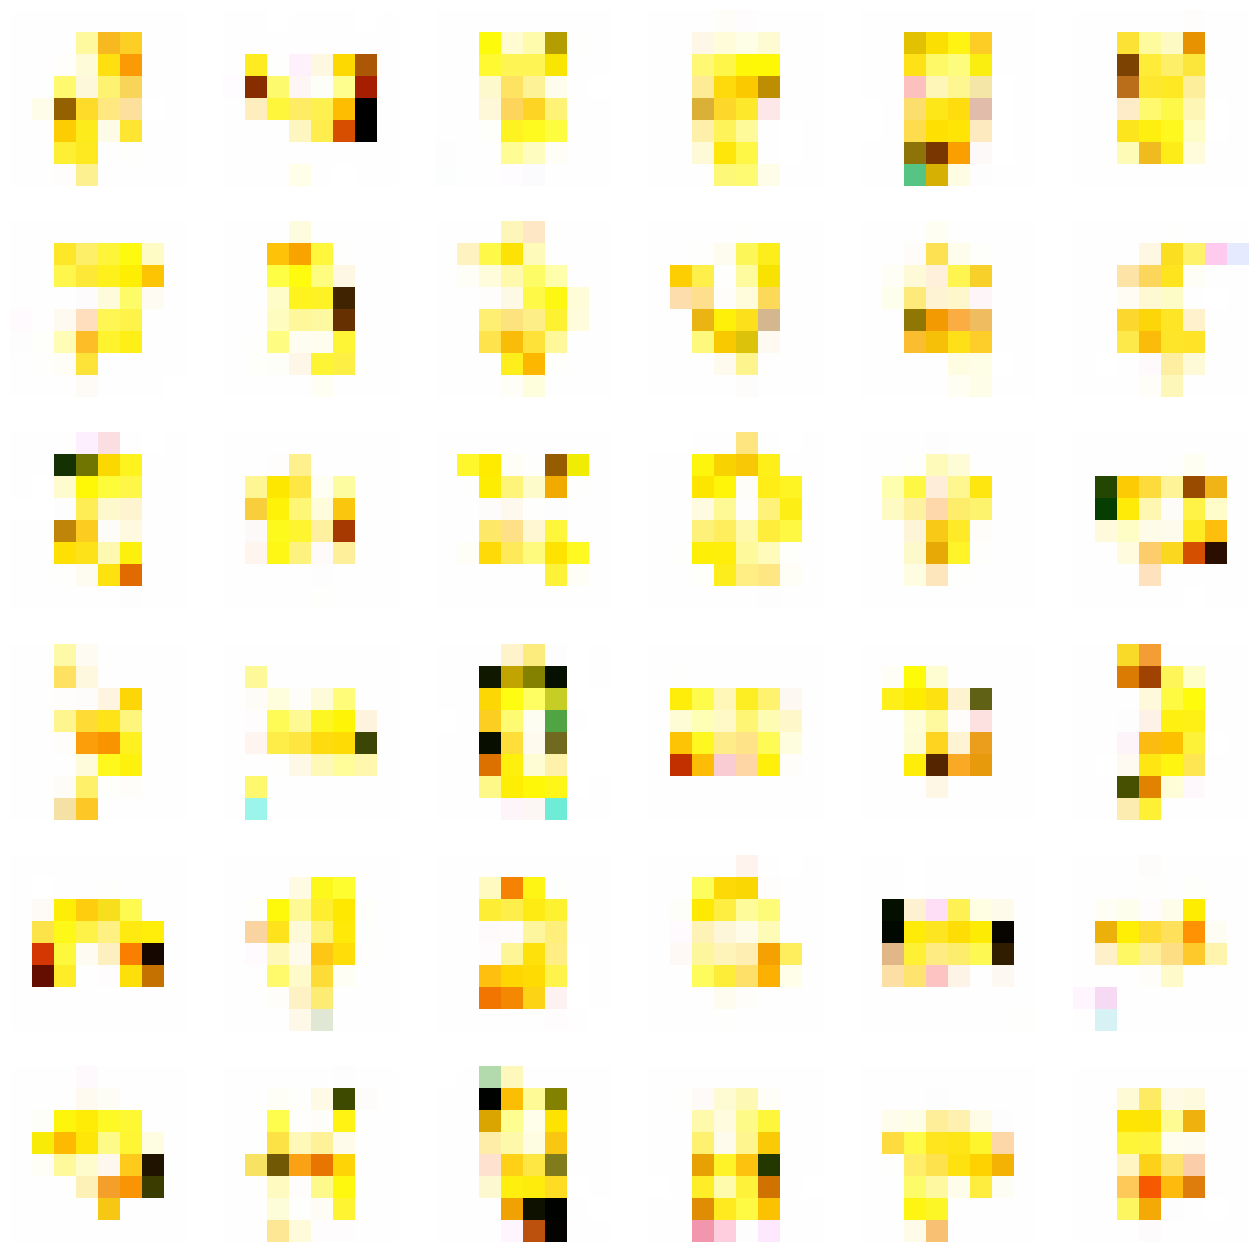

25/25 [==============================] - 35s 1s/step - d_loss: -2.1027 - g_loss: 2.6160
Epoch 14/50
25/25 [==============================] - ETA: 0s - d_loss: -2.2063 - g_loss: 3.0165

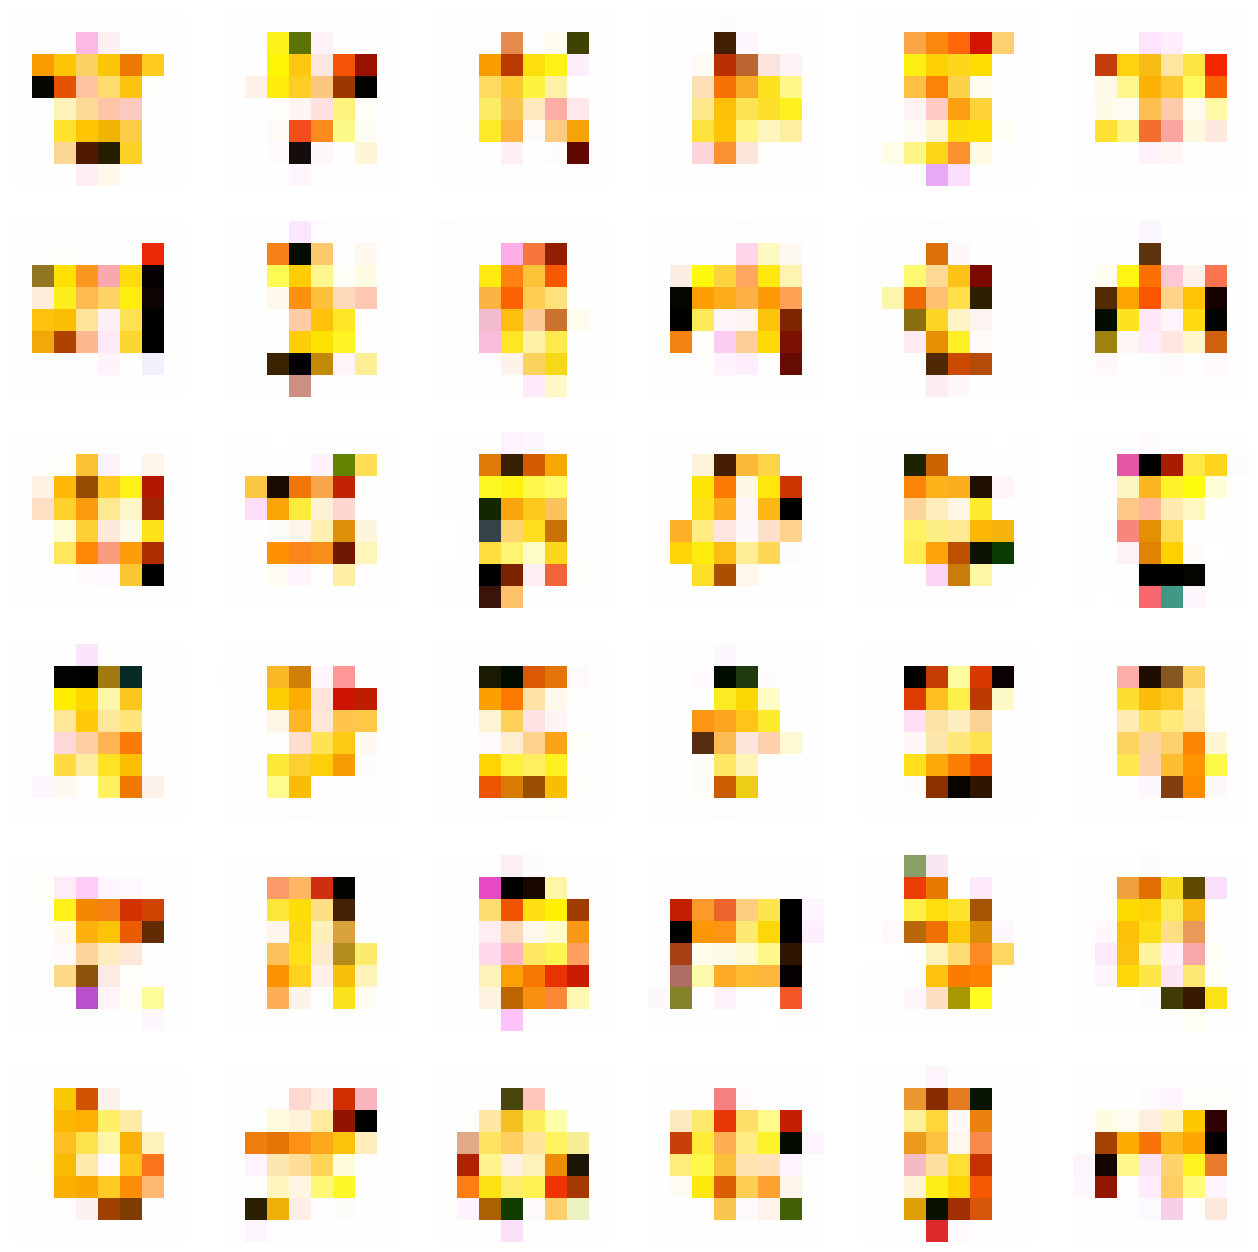

25/25 [==============================] - 38s 2s/step - d_loss: -2.1840 - g_loss: 3.0575
Epoch 15/50
25/25 [==============================] - ETA: 0s - d_loss: -2.0665 - g_loss: 2.5341

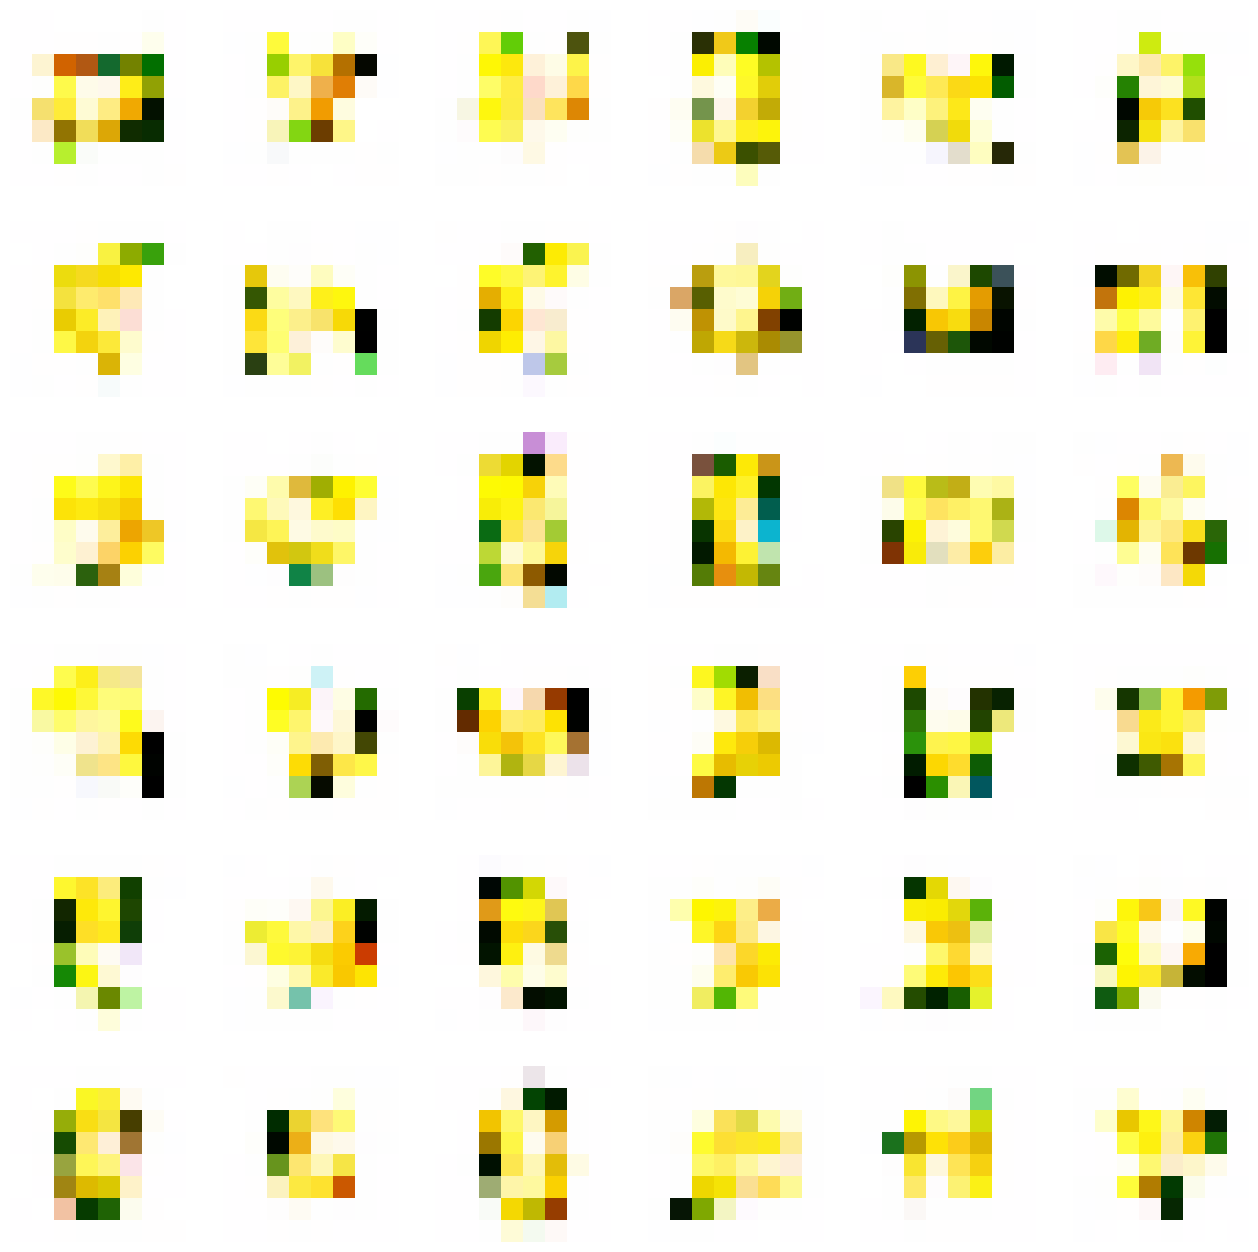

25/25 [==============================] - 36s 1s/step - d_loss: -2.0459 - g_loss: 2.6026
Epoch 16/50
25/25 [==============================] - ETA: 0s - d_loss: -1.9801 - g_loss: 2.5668

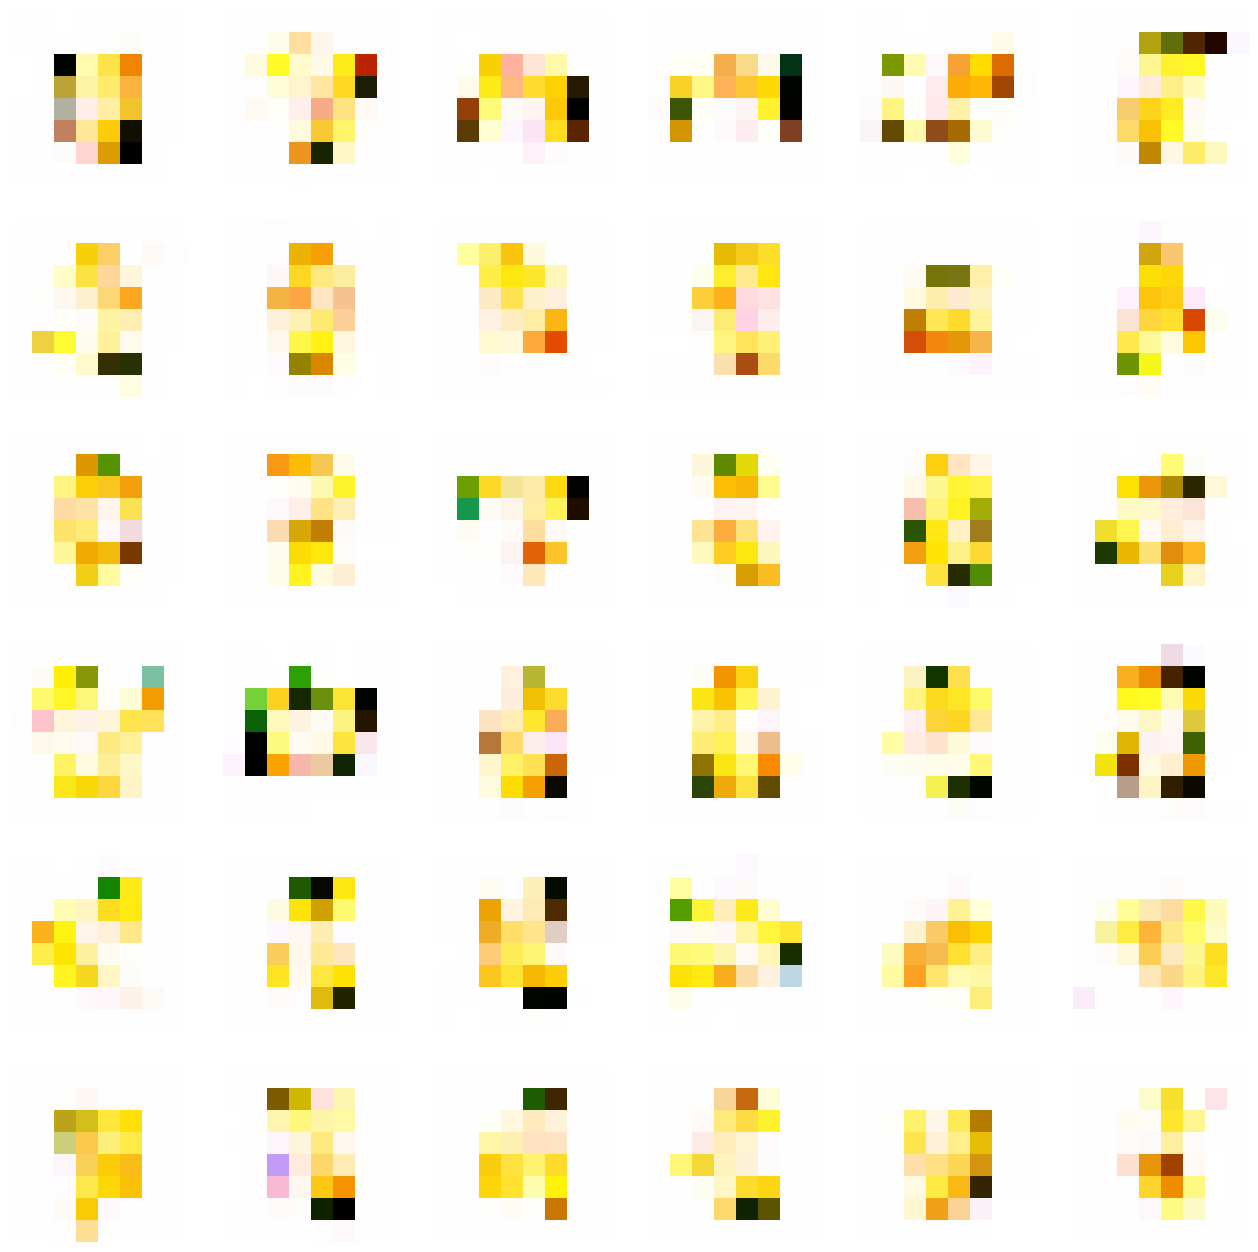

25/25 [==============================] - 35s 1s/step - d_loss: -1.9969 - g_loss: 2.6115
Epoch 17/50
25/25 [==============================] - ETA: 0s - d_loss: -2.2023 - g_loss: 3.1664

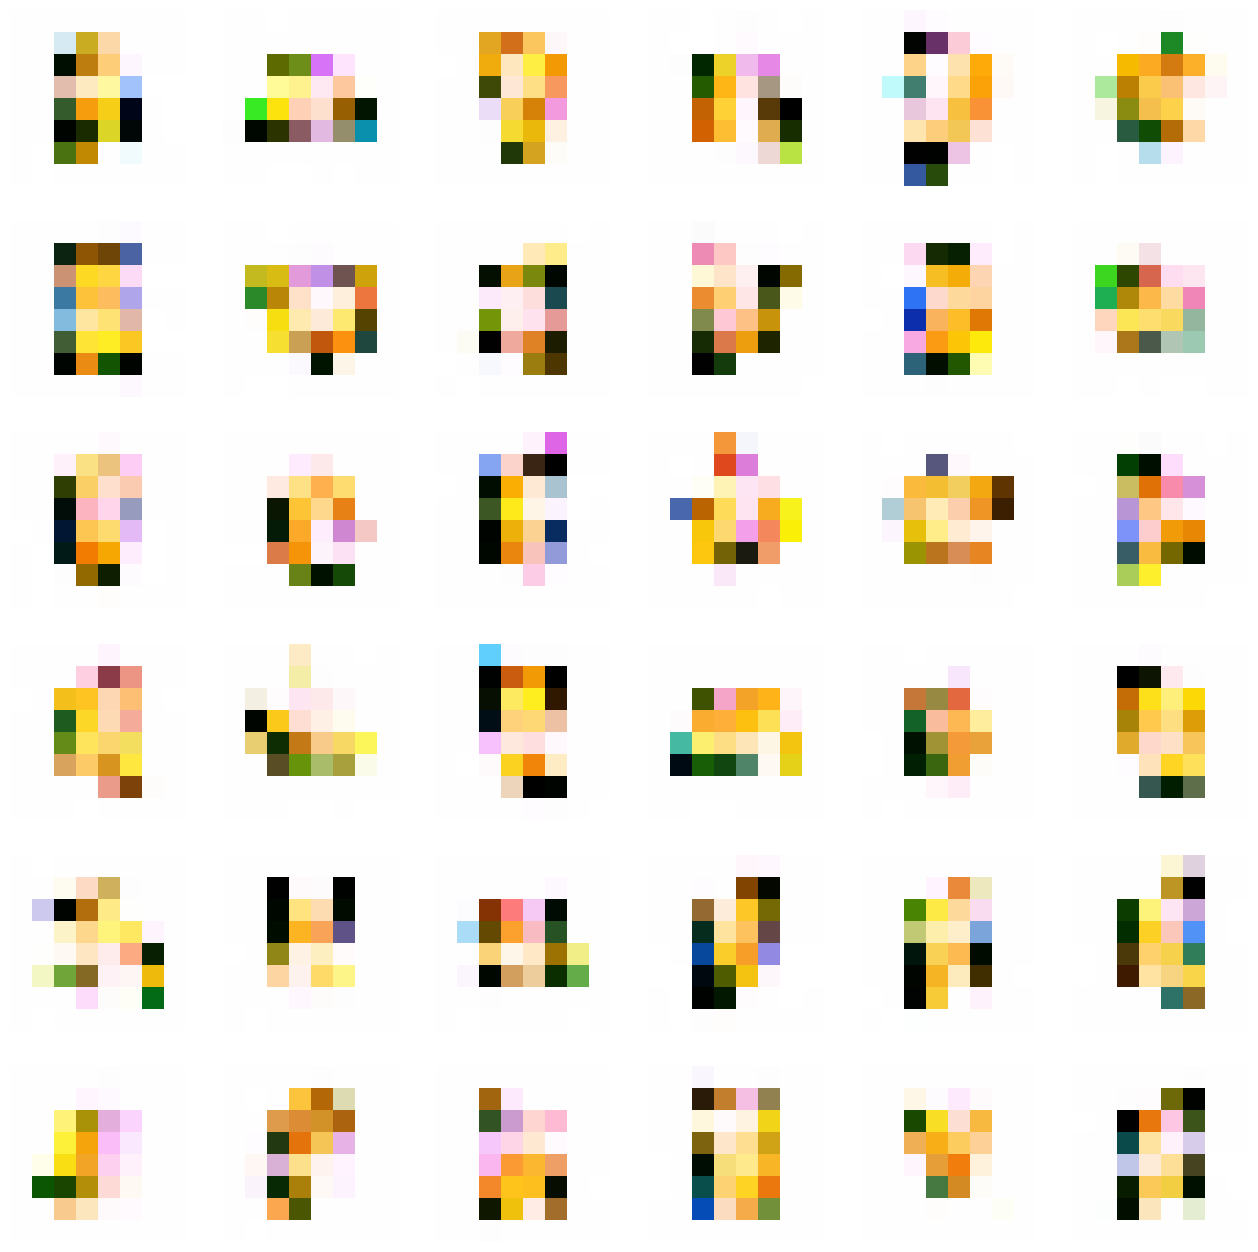

25/25 [==============================] - 36s 1s/step - d_loss: -2.2244 - g_loss: 3.1448
Epoch 18/50
25/25 [==============================] - ETA: 0s - d_loss: -2.2071 - g_loss: 2.4109

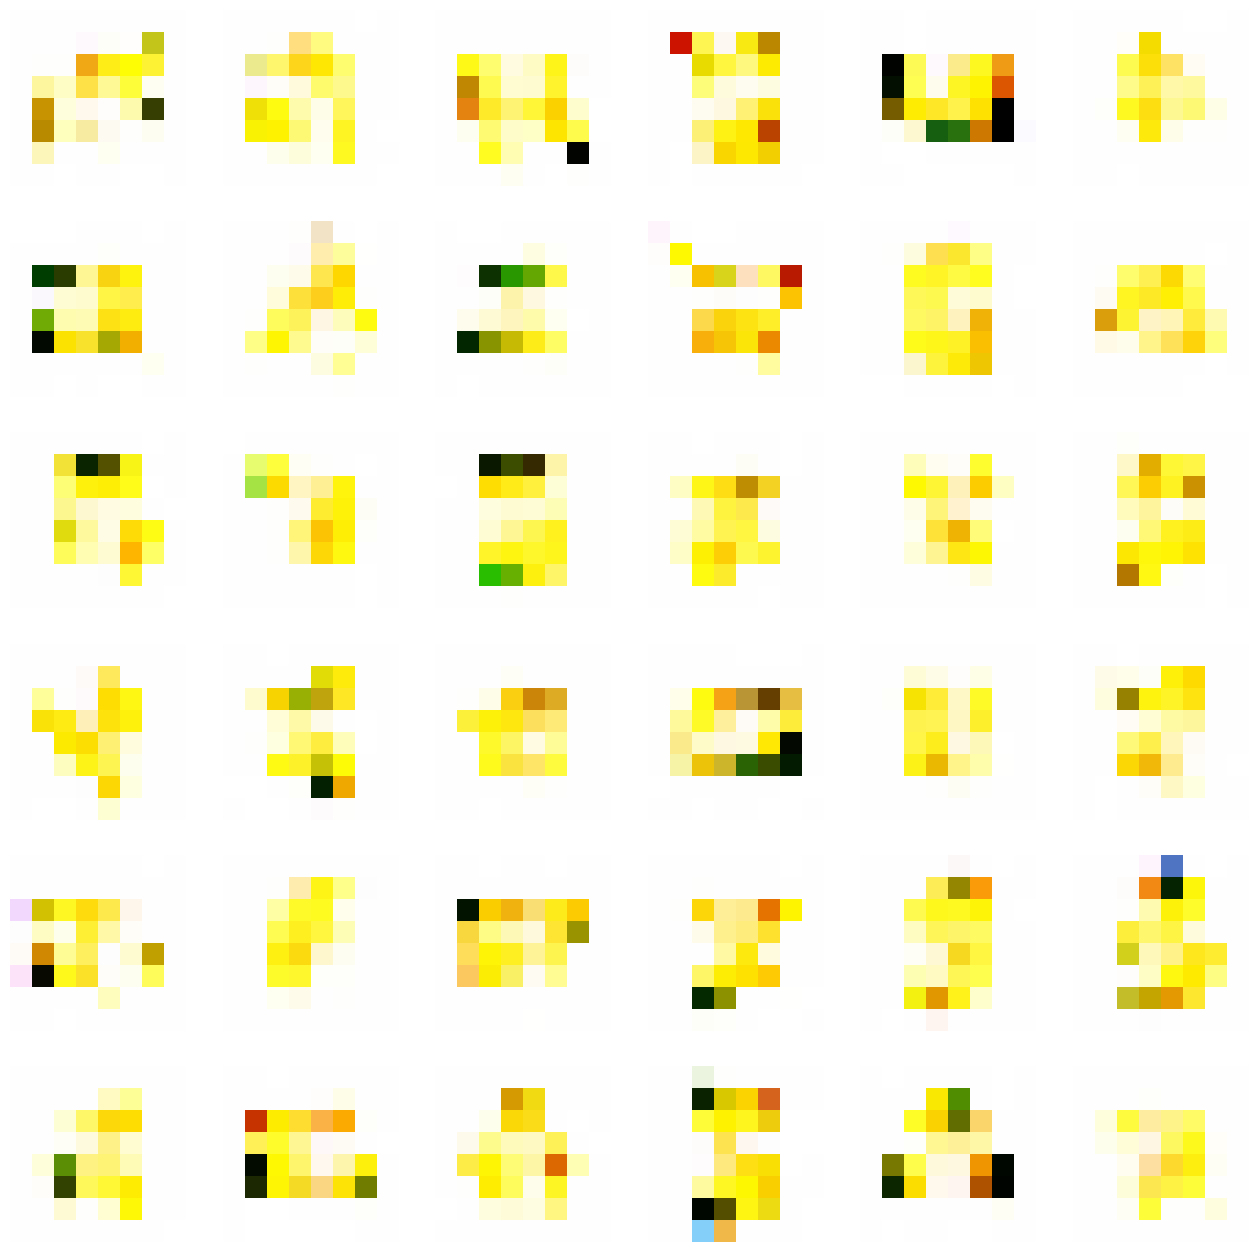

25/25 [==============================] - 37s 1s/step - d_loss: -2.2236 - g_loss: 2.5237
Epoch 19/50
25/25 [==============================] - ETA: 0s - d_loss: -2.2210 - g_loss: 2.5553

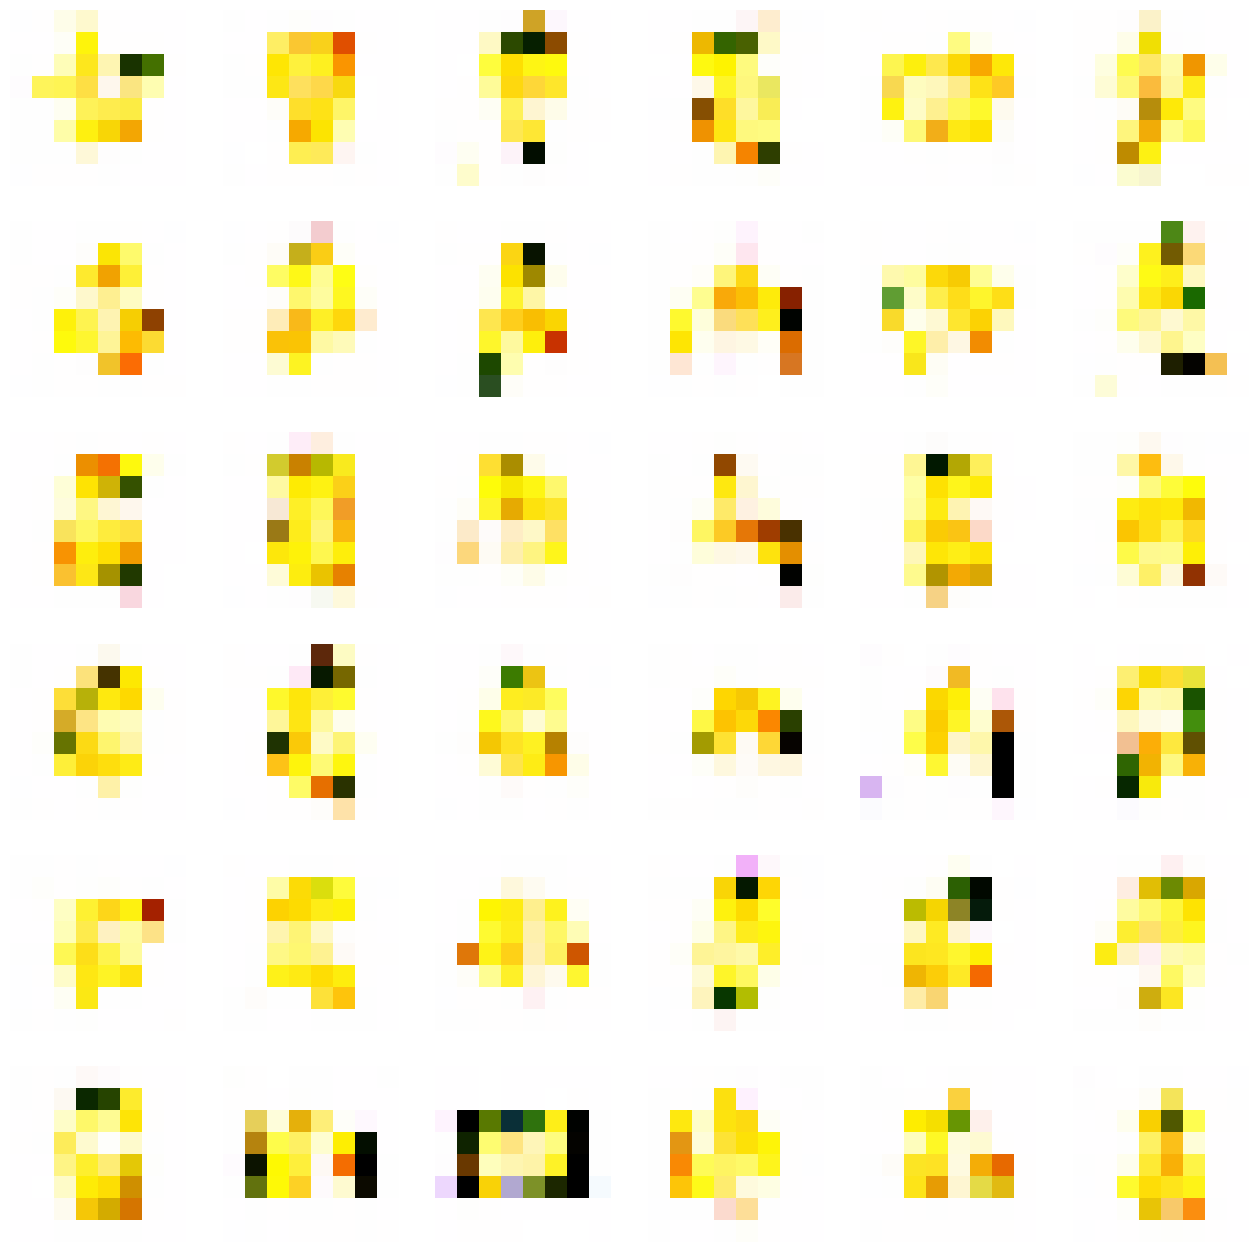

25/25 [==============================] - 36s 1s/step - d_loss: -2.2150 - g_loss: 2.6043
Epoch 20/50
25/25 [==============================] - ETA: 0s - d_loss: -2.1994 - g_loss: 2.7810

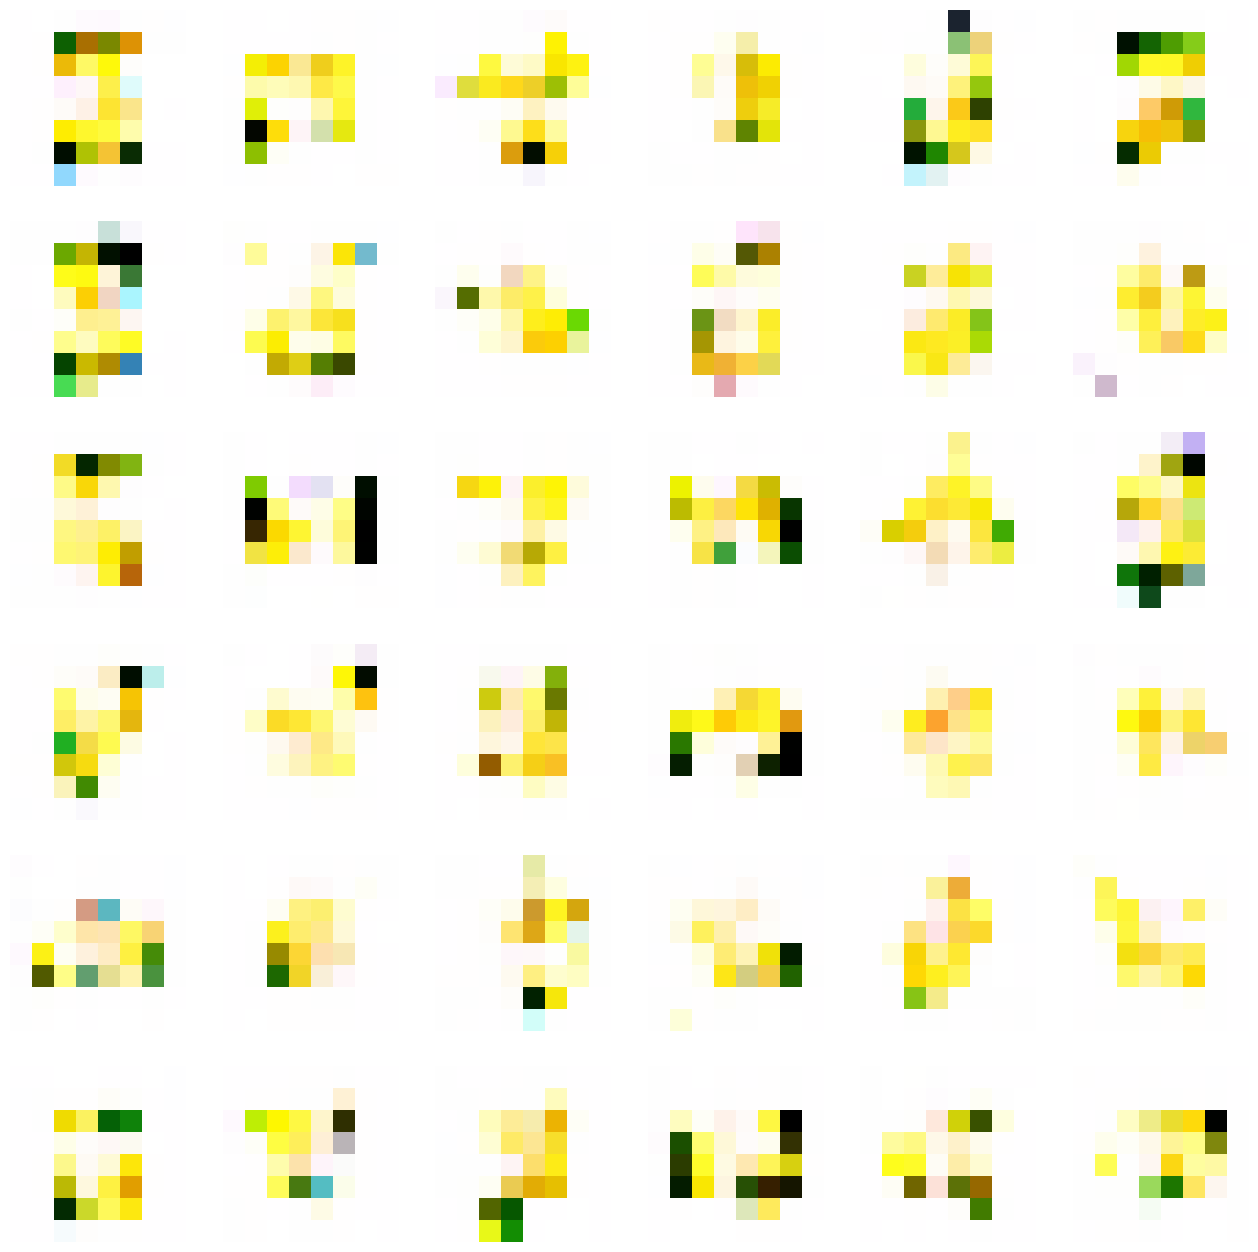

25/25 [==============================] - 36s 1s/step - d_loss: -2.2078 - g_loss: 2.7658
Epoch 21/50
25/25 [==============================] - ETA: 0s - d_loss: -2.1553 - g_loss: 2.6897

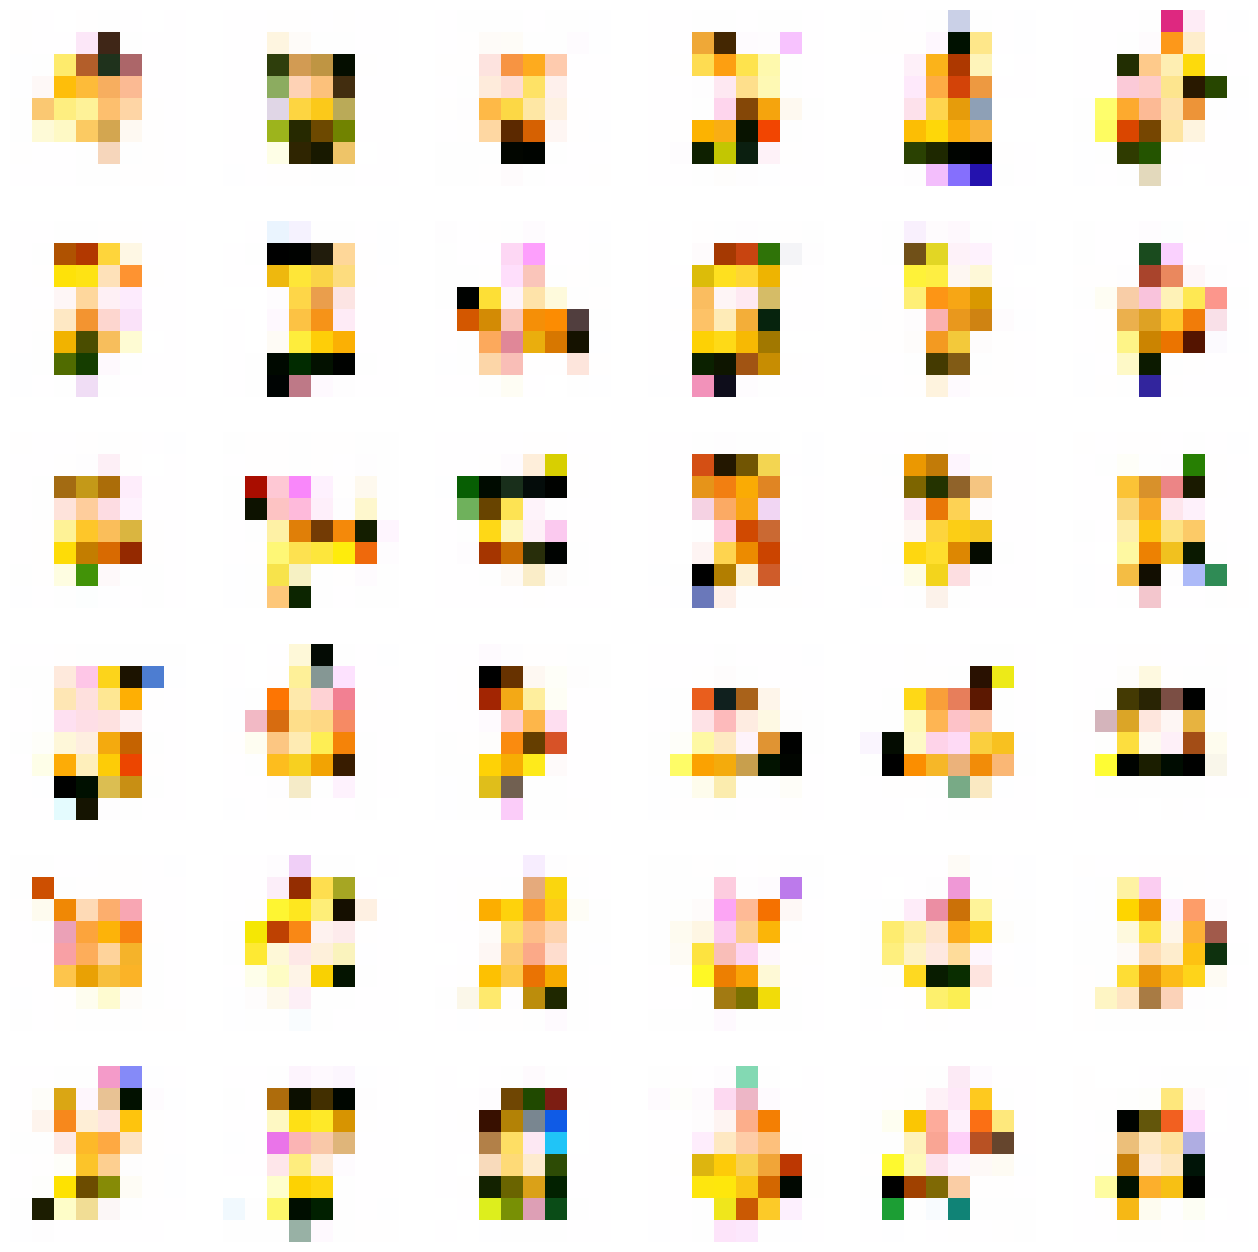

25/25 [==============================] - 36s 1s/step - d_loss: -2.1491 - g_loss: 2.6548
Epoch 22/50
25/25 [==============================] - ETA: 0s - d_loss: -2.1617 - g_loss: 2.4713

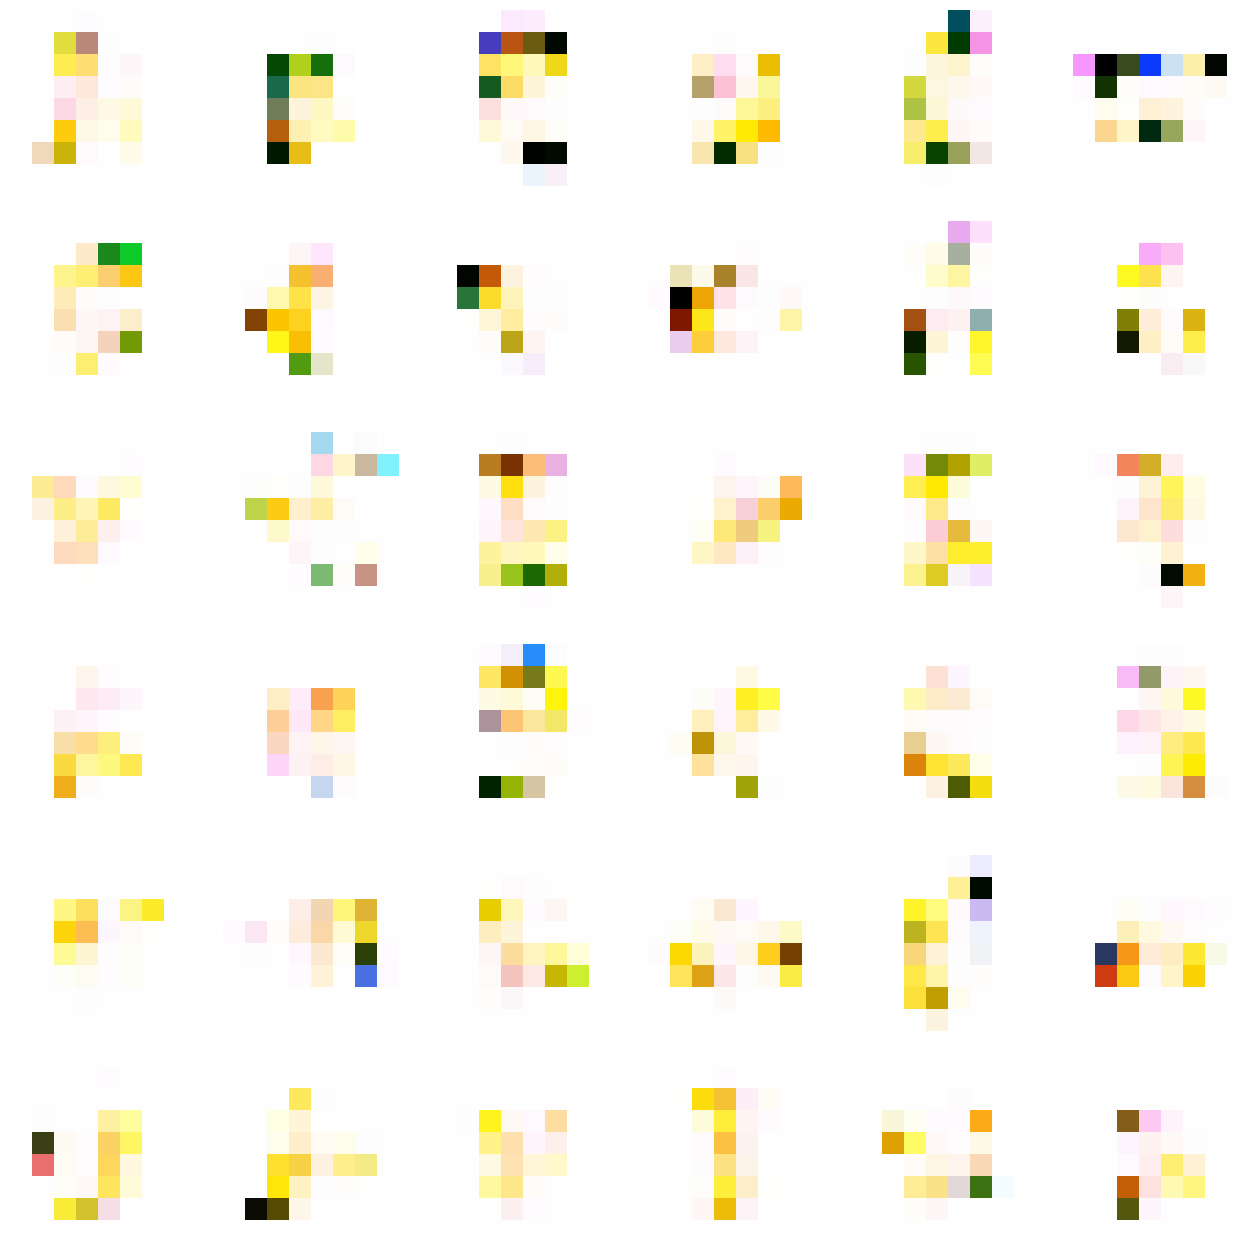

25/25 [==============================] - 36s 1s/step - d_loss: -2.1347 - g_loss: 2.4149
Epoch 23/50
25/25 [==============================] - ETA: 0s - d_loss: -2.1348 - g_loss: 2.7978

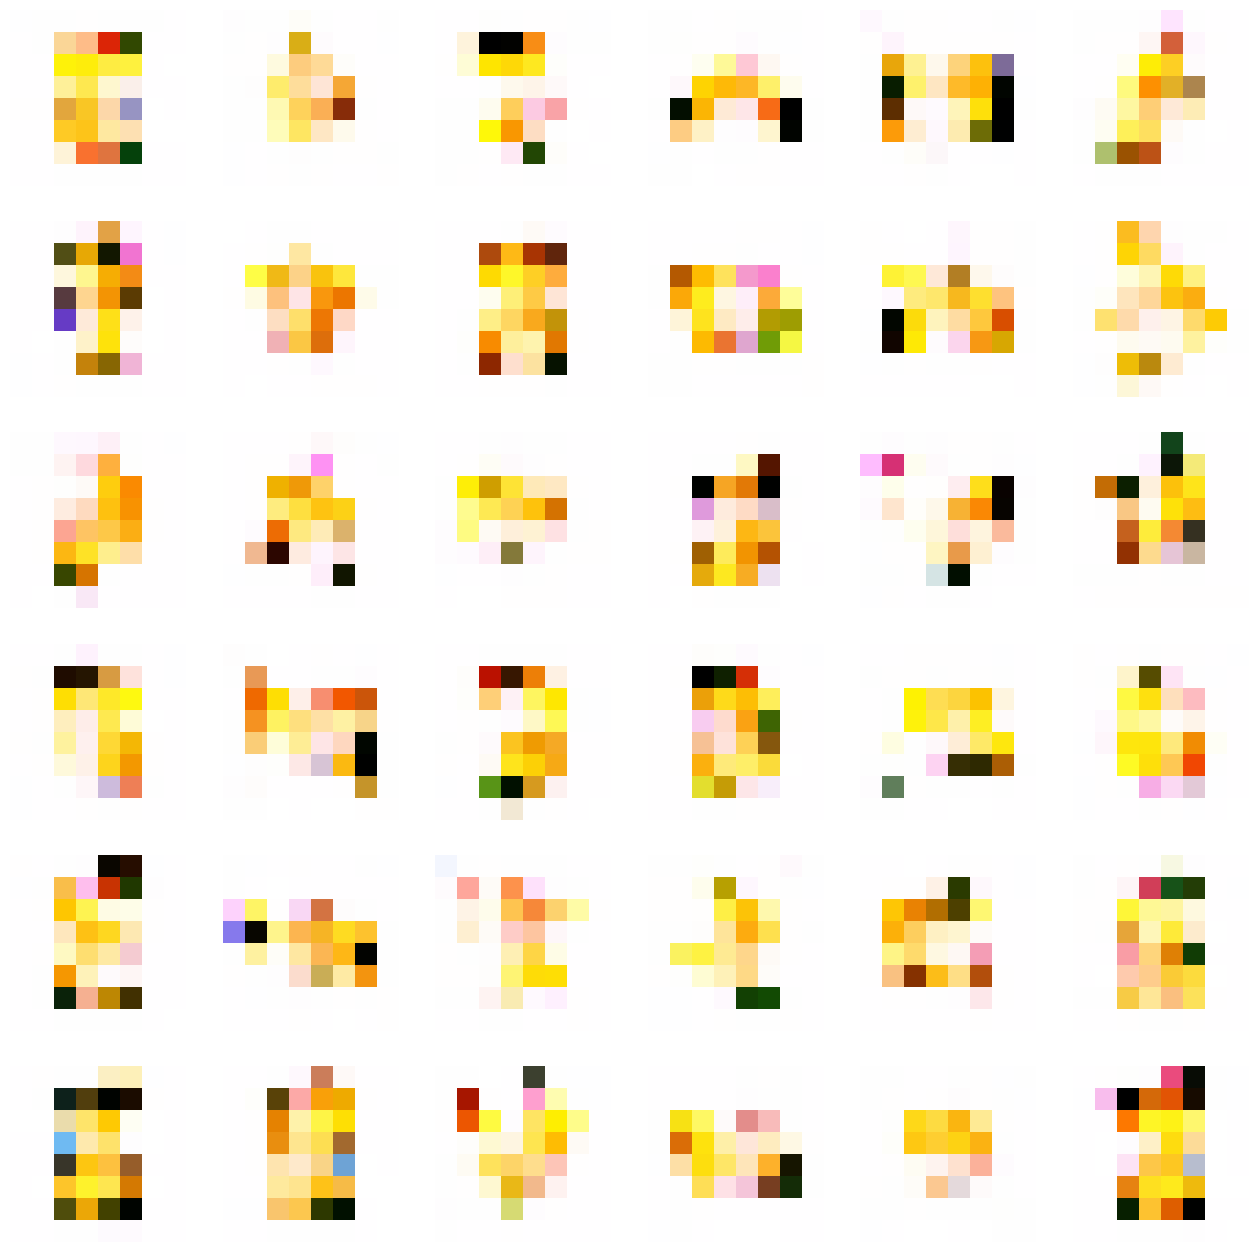

25/25 [==============================] - 37s 1s/step - d_loss: -2.1220 - g_loss: 2.8367
Epoch 24/50
25/25 [==============================] - ETA: 0s - d_loss: -2.1344 - g_loss: 2.7454

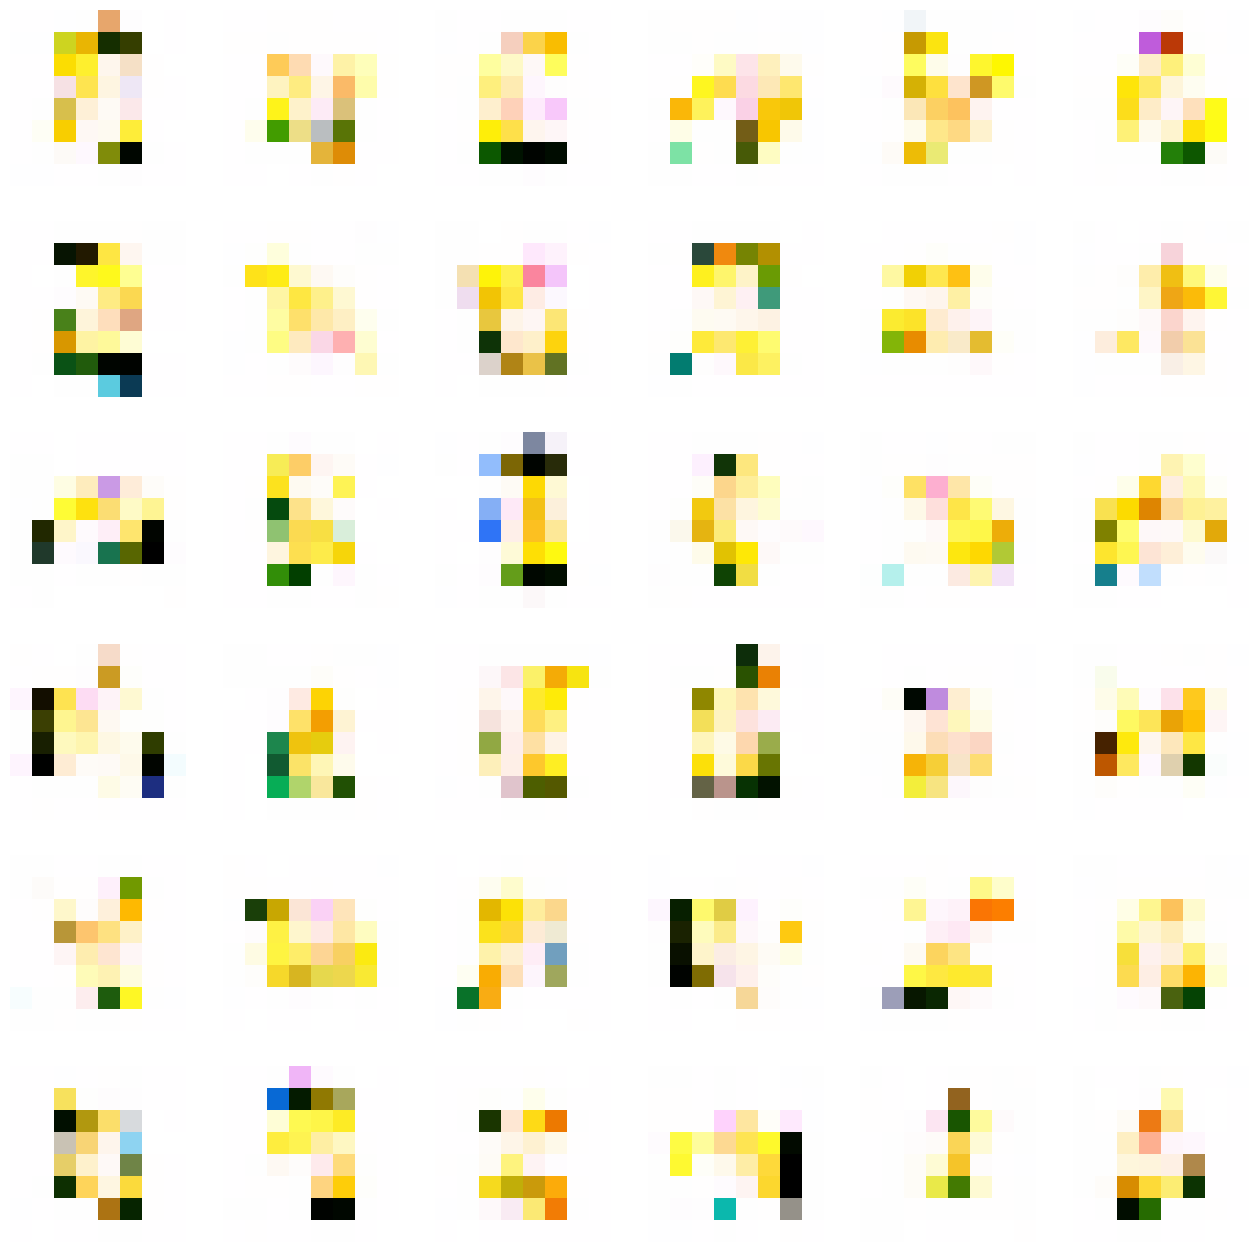

25/25 [==============================] - 36s 1s/step - d_loss: -2.1423 - g_loss: 2.7064
Epoch 25/50
25/25 [==============================] - ETA: 0s - d_loss: -2.1109 - g_loss: 2.9521

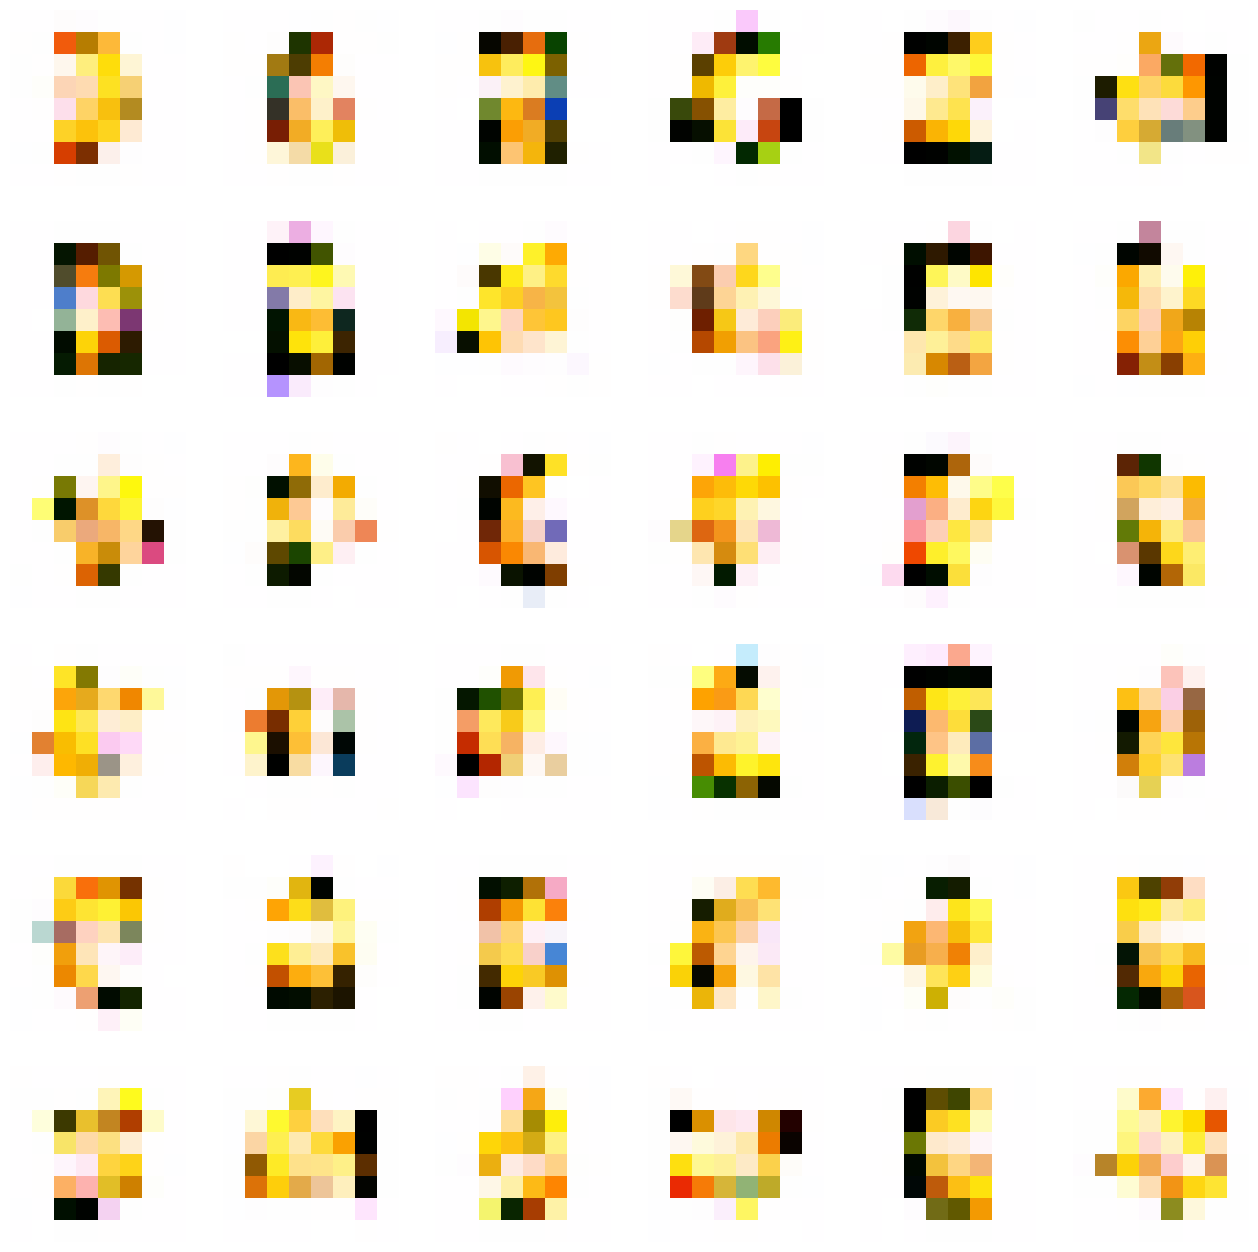

25/25 [==============================] - 36s 1s/step - d_loss: -2.0933 - g_loss: 2.9729
Epoch 26/50
25/25 [==============================] - ETA: 0s - d_loss: -2.2099 - g_loss: 2.3597

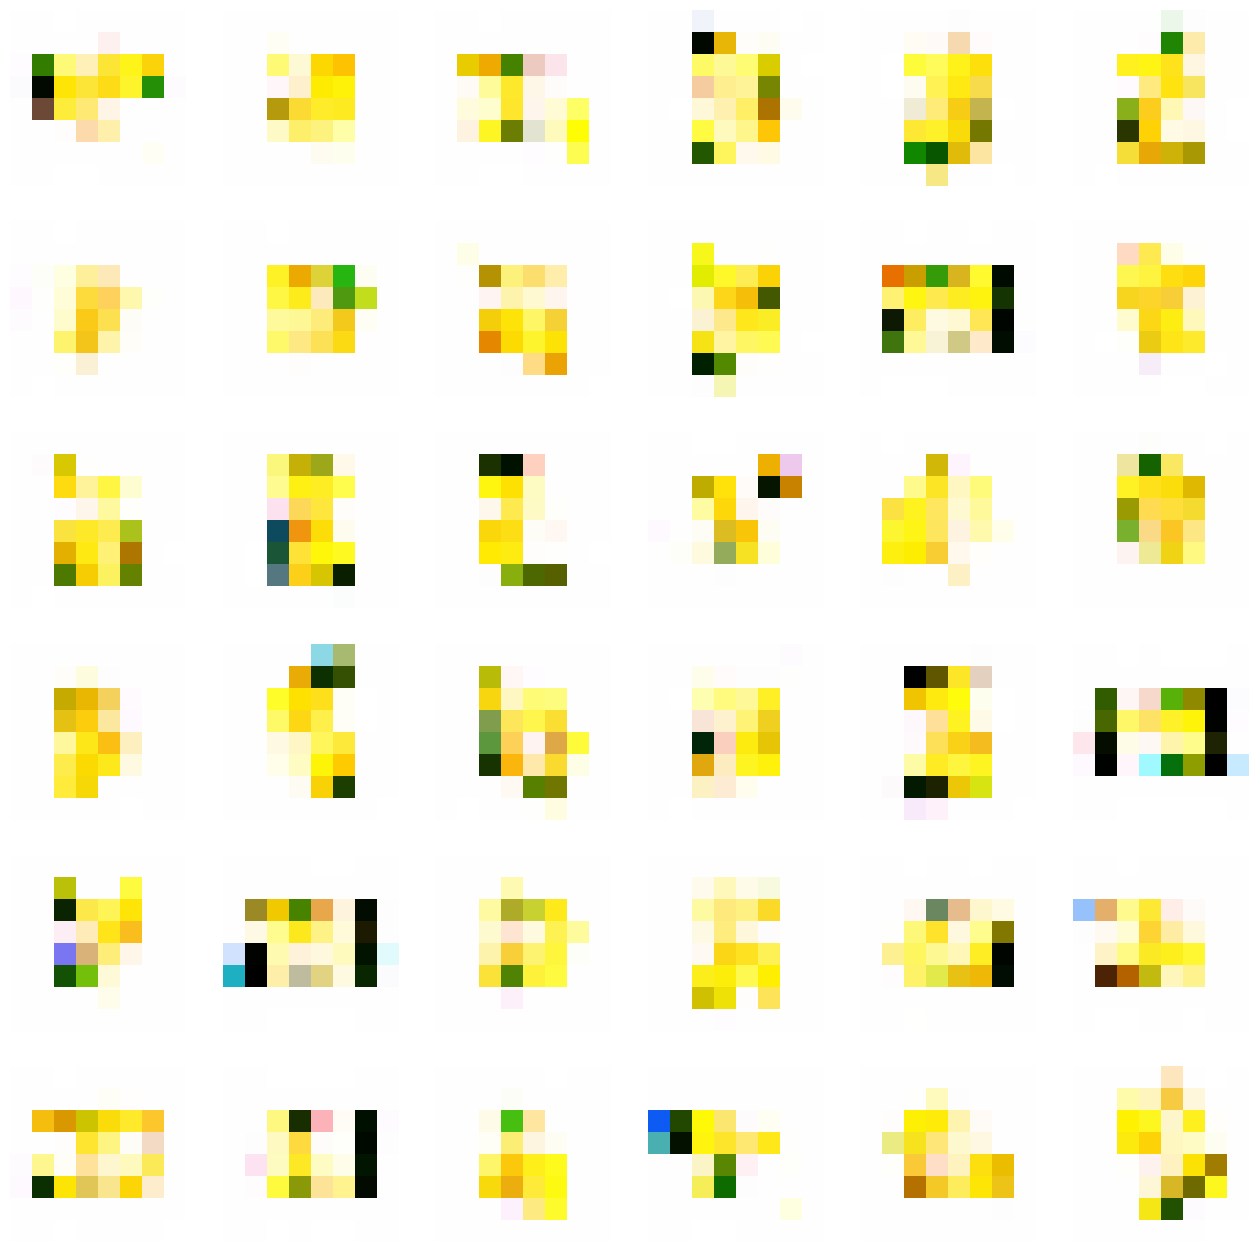

25/25 [==============================] - 36s 1s/step - d_loss: -2.1893 - g_loss: 2.4289
Epoch 27/50
25/25 [==============================] - ETA: 0s - d_loss: -2.2288 - g_loss: 2.8975

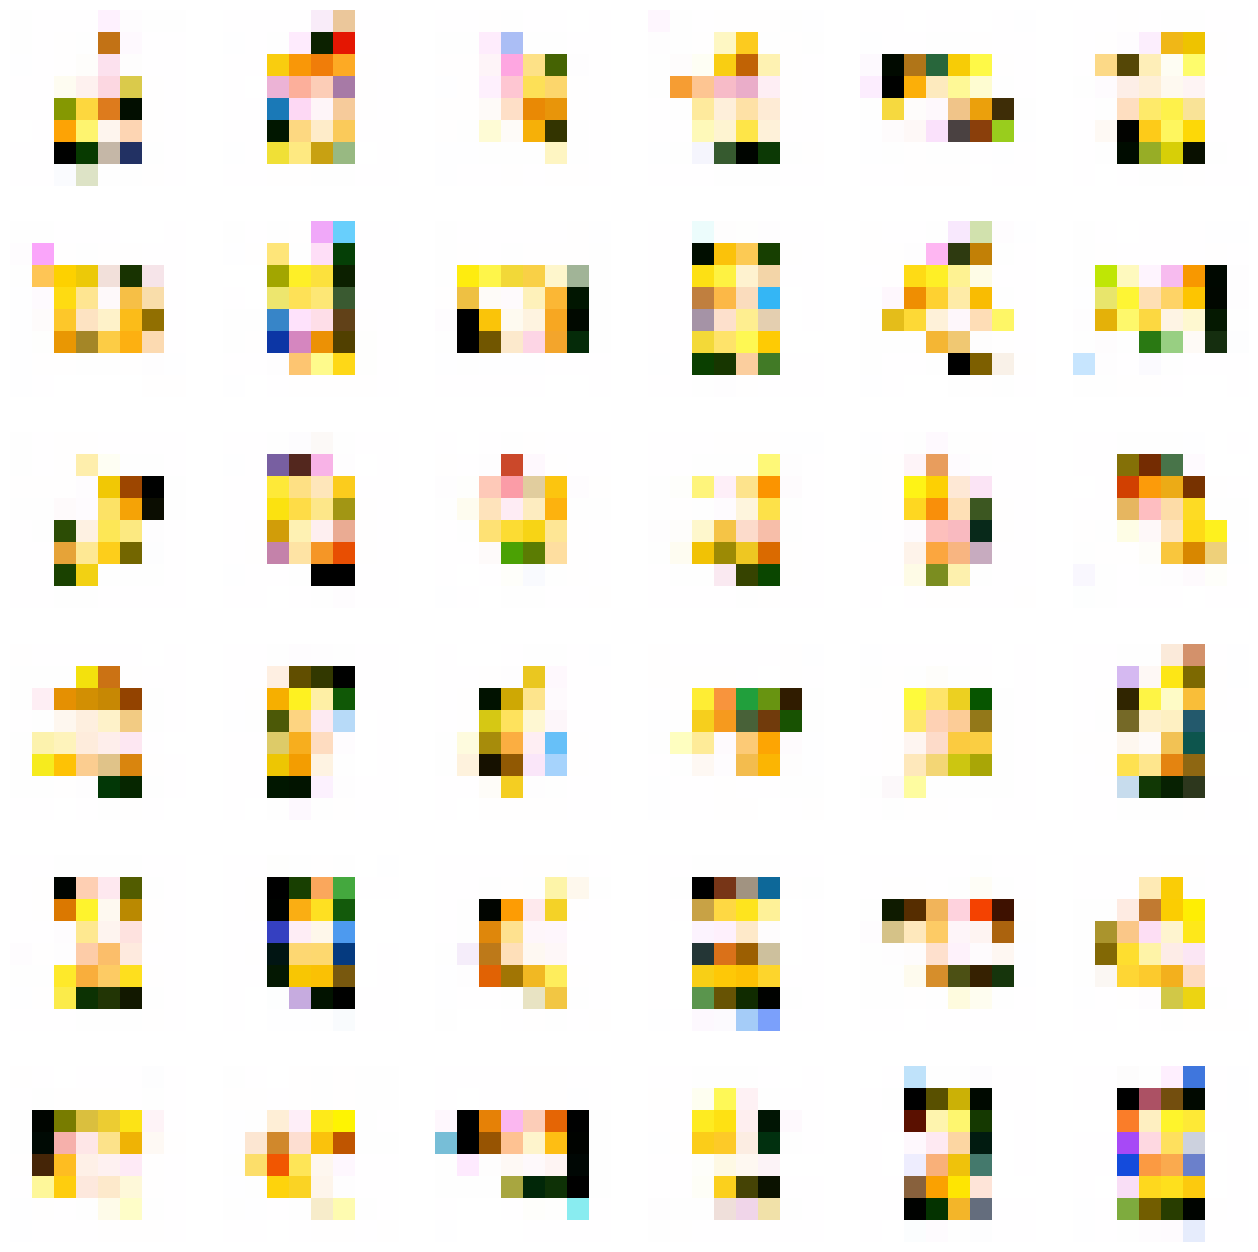

25/25 [==============================] - 38s 2s/step - d_loss: -2.2326 - g_loss: 2.9317
Epoch 28/50
25/25 [==============================] - ETA: 0s - d_loss: -2.2443 - g_loss: 2.6095

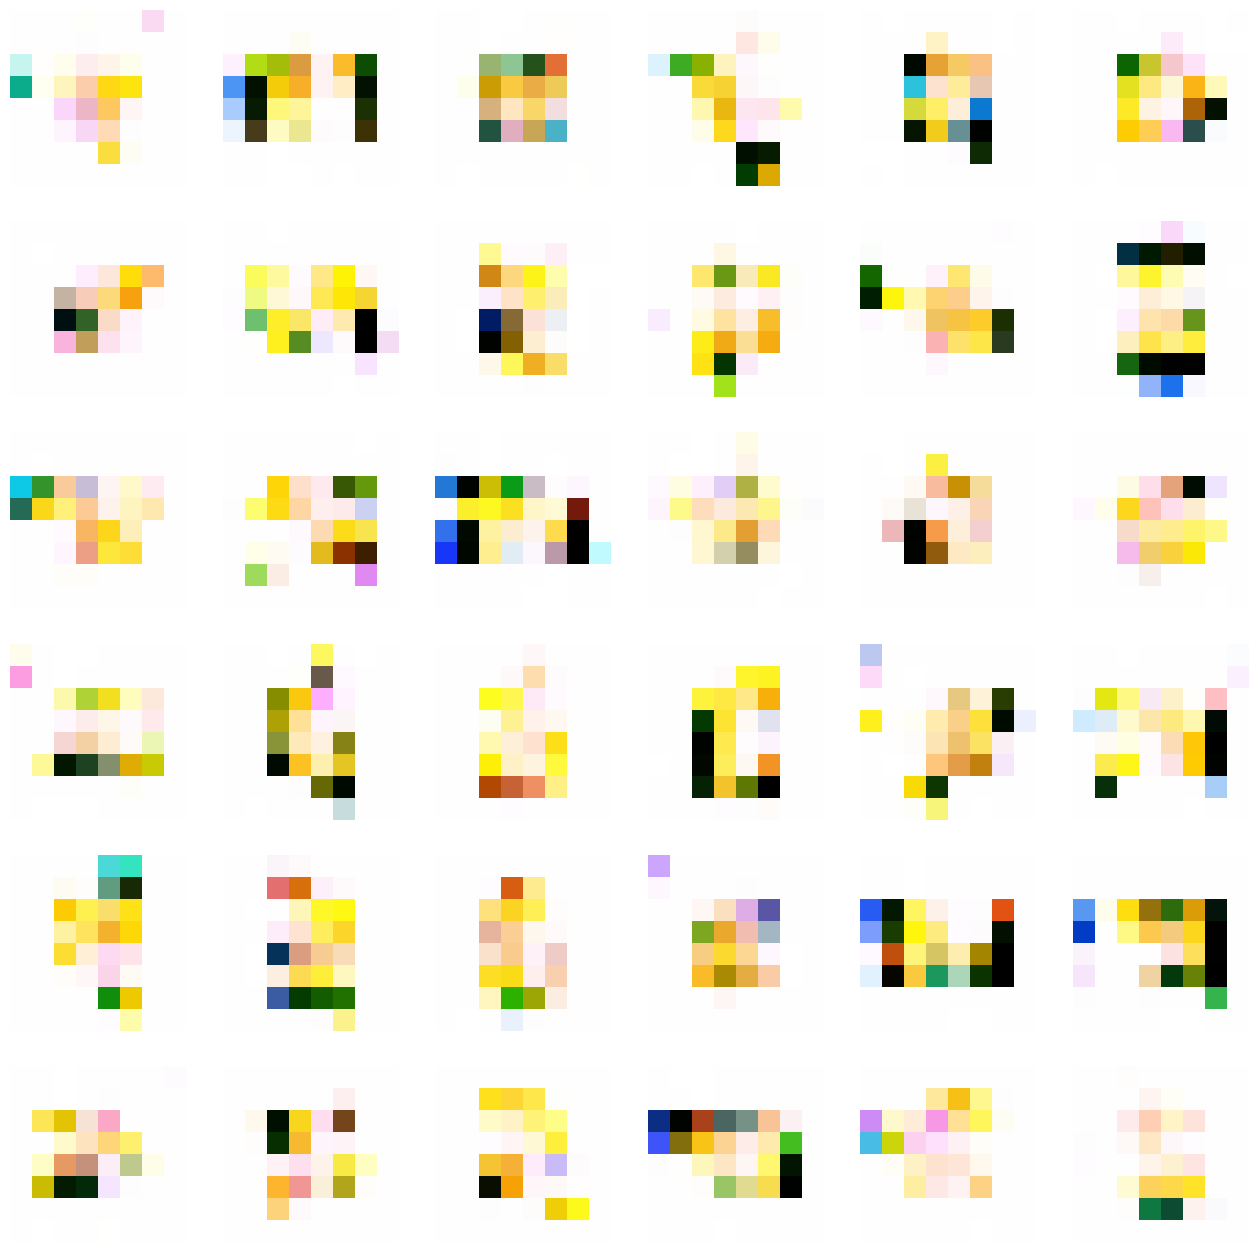

25/25 [==============================] - 37s 1s/step - d_loss: -2.2545 - g_loss: 2.5931
Epoch 29/50
25/25 [==============================] - ETA: 0s - d_loss: -2.2276 - g_loss: 2.8838

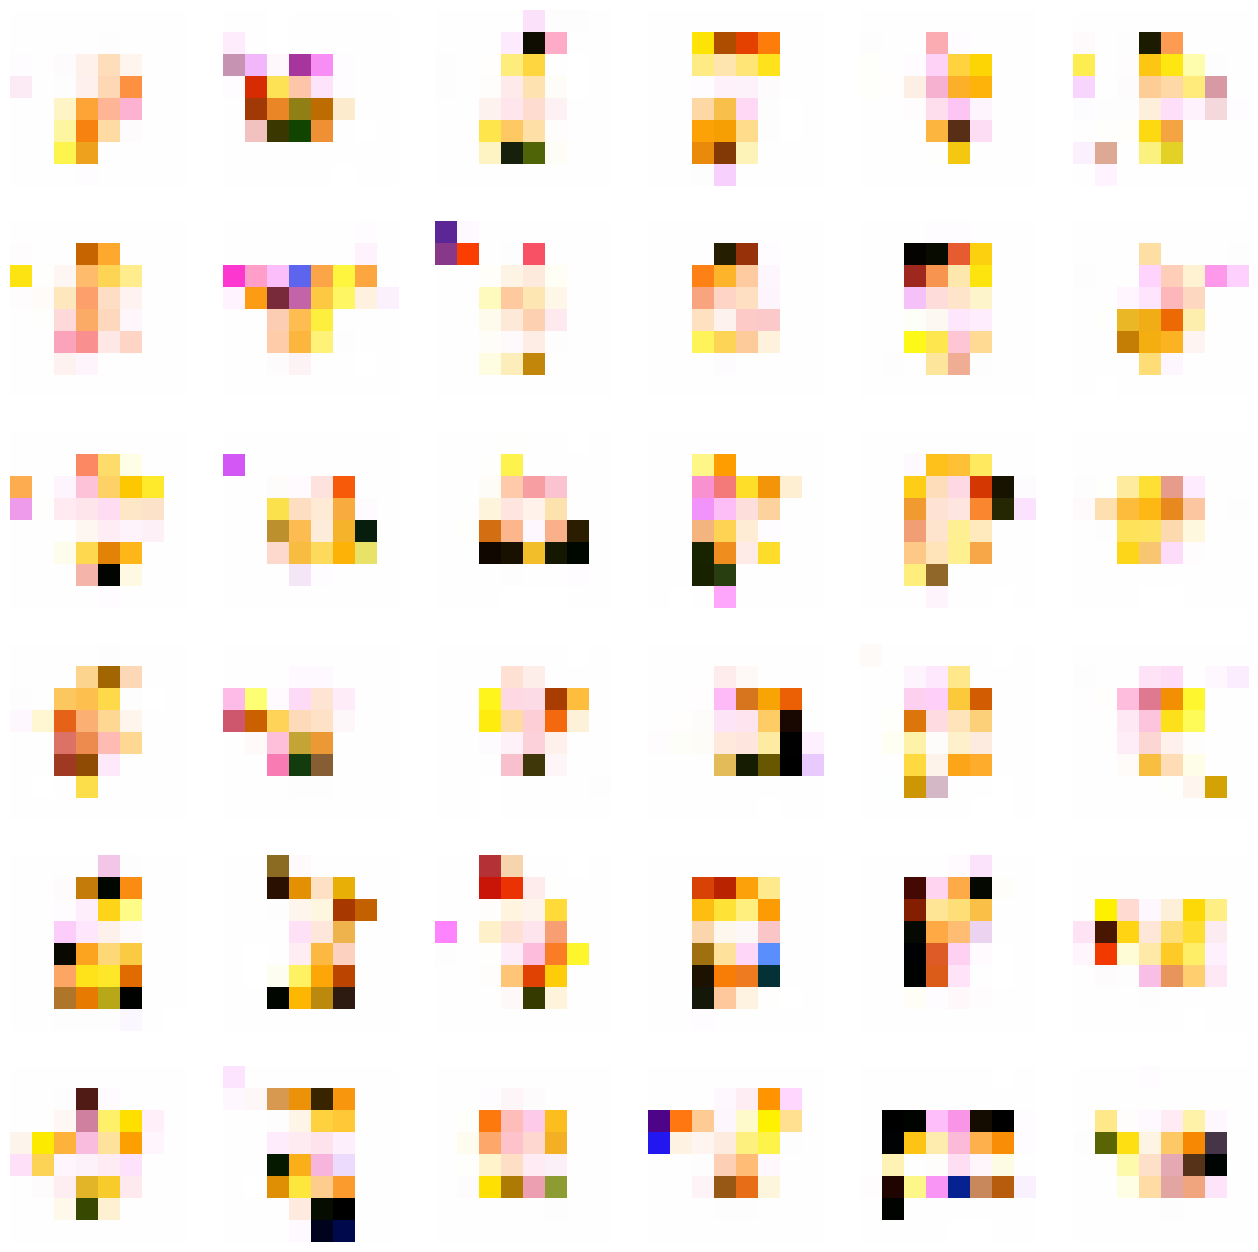

25/25 [==============================] - 37s 1s/step - d_loss: -2.2144 - g_loss: 2.8888
Epoch 30/50
25/25 [==============================] - ETA: 0s - d_loss: -2.2646 - g_loss: 2.5452

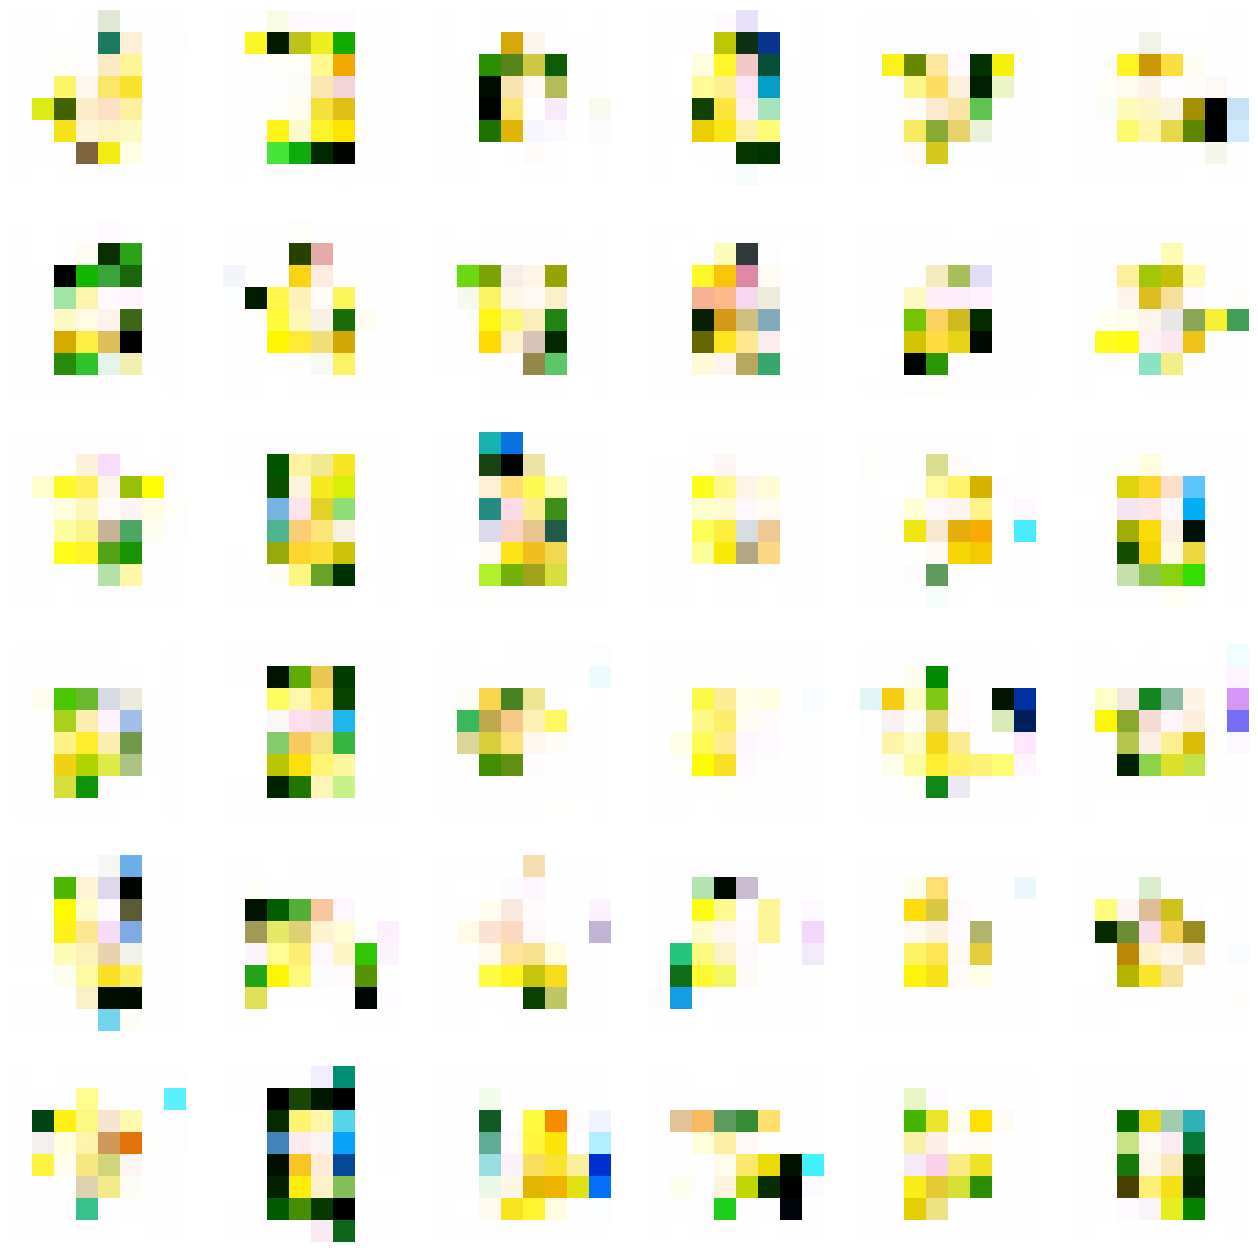

25/25 [==============================] - 36s 1s/step - d_loss: -2.2905 - g_loss: 2.4702
Epoch 31/50
25/25 [==============================] - ETA: 0s - d_loss: -2.1808 - g_loss: 3.2455

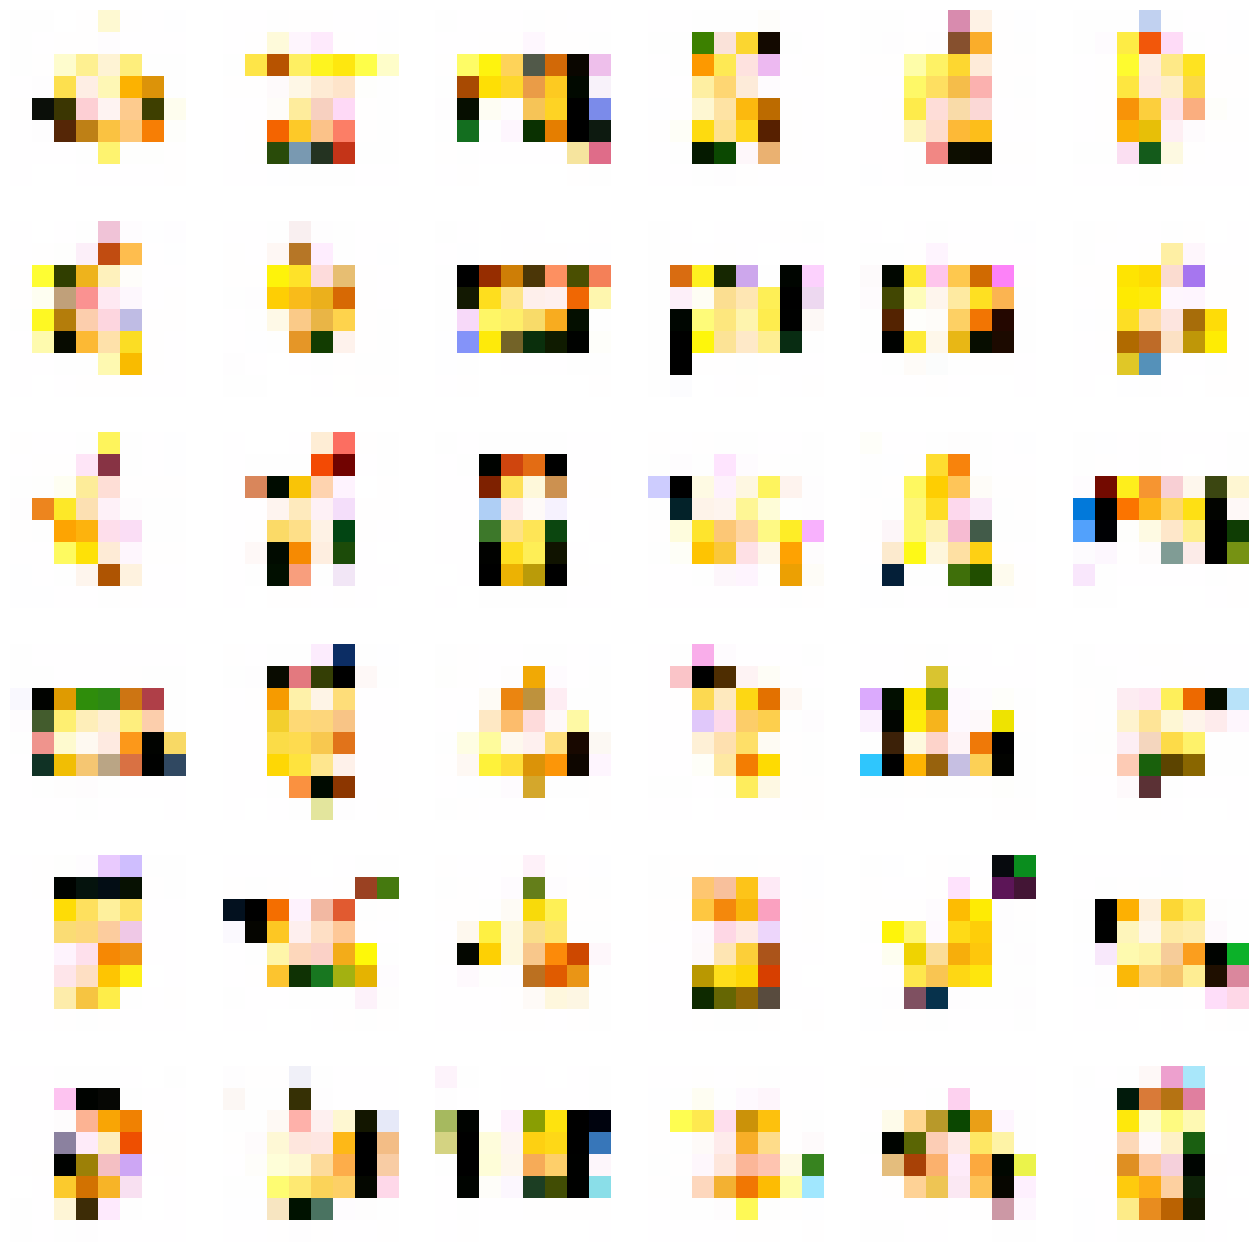

25/25 [==============================] - 37s 1s/step - d_loss: -2.1815 - g_loss: 3.2639
Epoch 32/50
25/25 [==============================] - ETA: 0s - d_loss: -2.2725 - g_loss: 2.9262

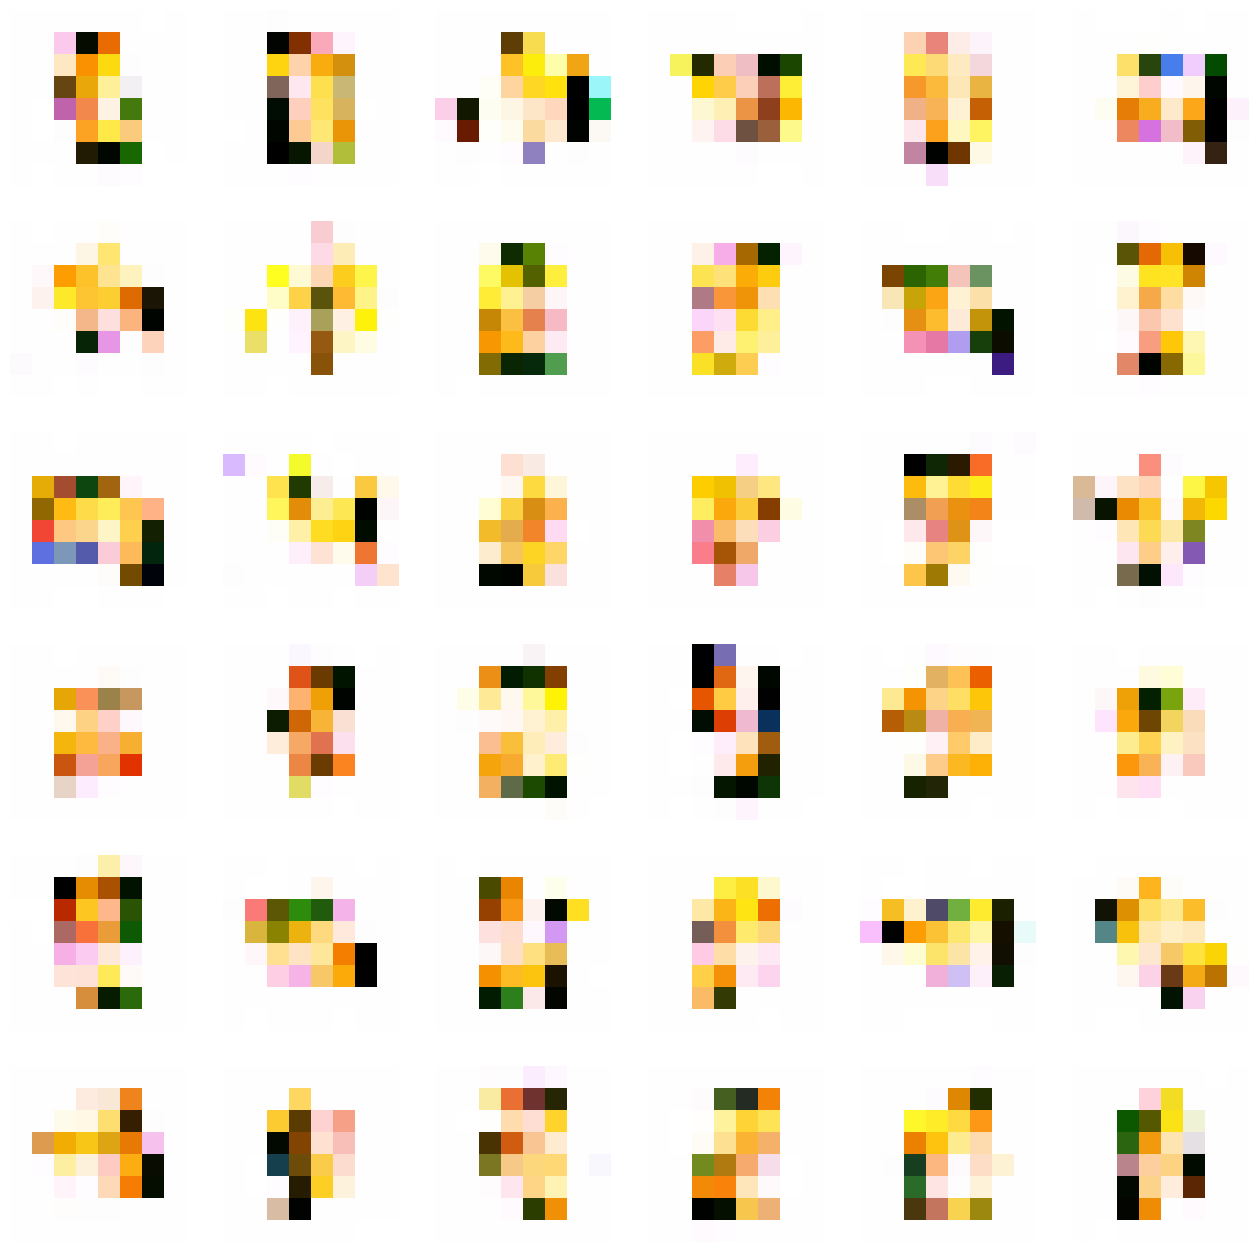

25/25 [==============================] - 38s 2s/step - d_loss: -2.2924 - g_loss: 2.8371
Epoch 33/50
25/25 [==============================] - ETA: 0s - d_loss: -2.1390 - g_loss: 2.5489

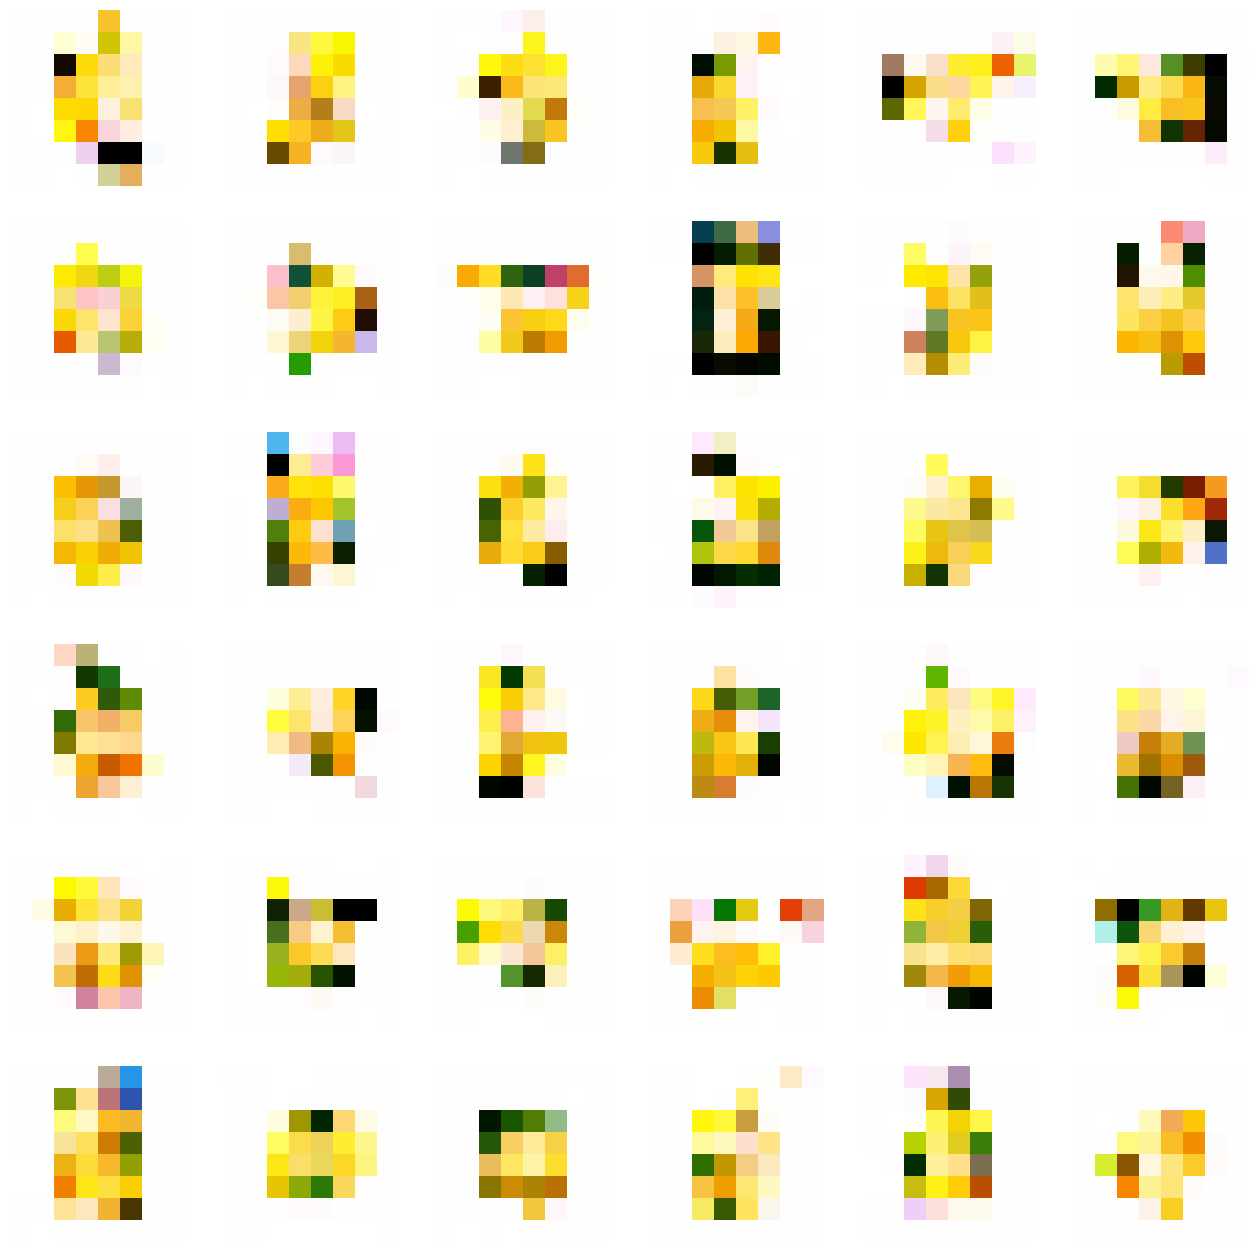

25/25 [==============================] - 37s 1s/step - d_loss: -2.1292 - g_loss: 2.5539
Epoch 34/50
25/25 [==============================] - ETA: 0s - d_loss: -2.3329 - g_loss: 2.7602

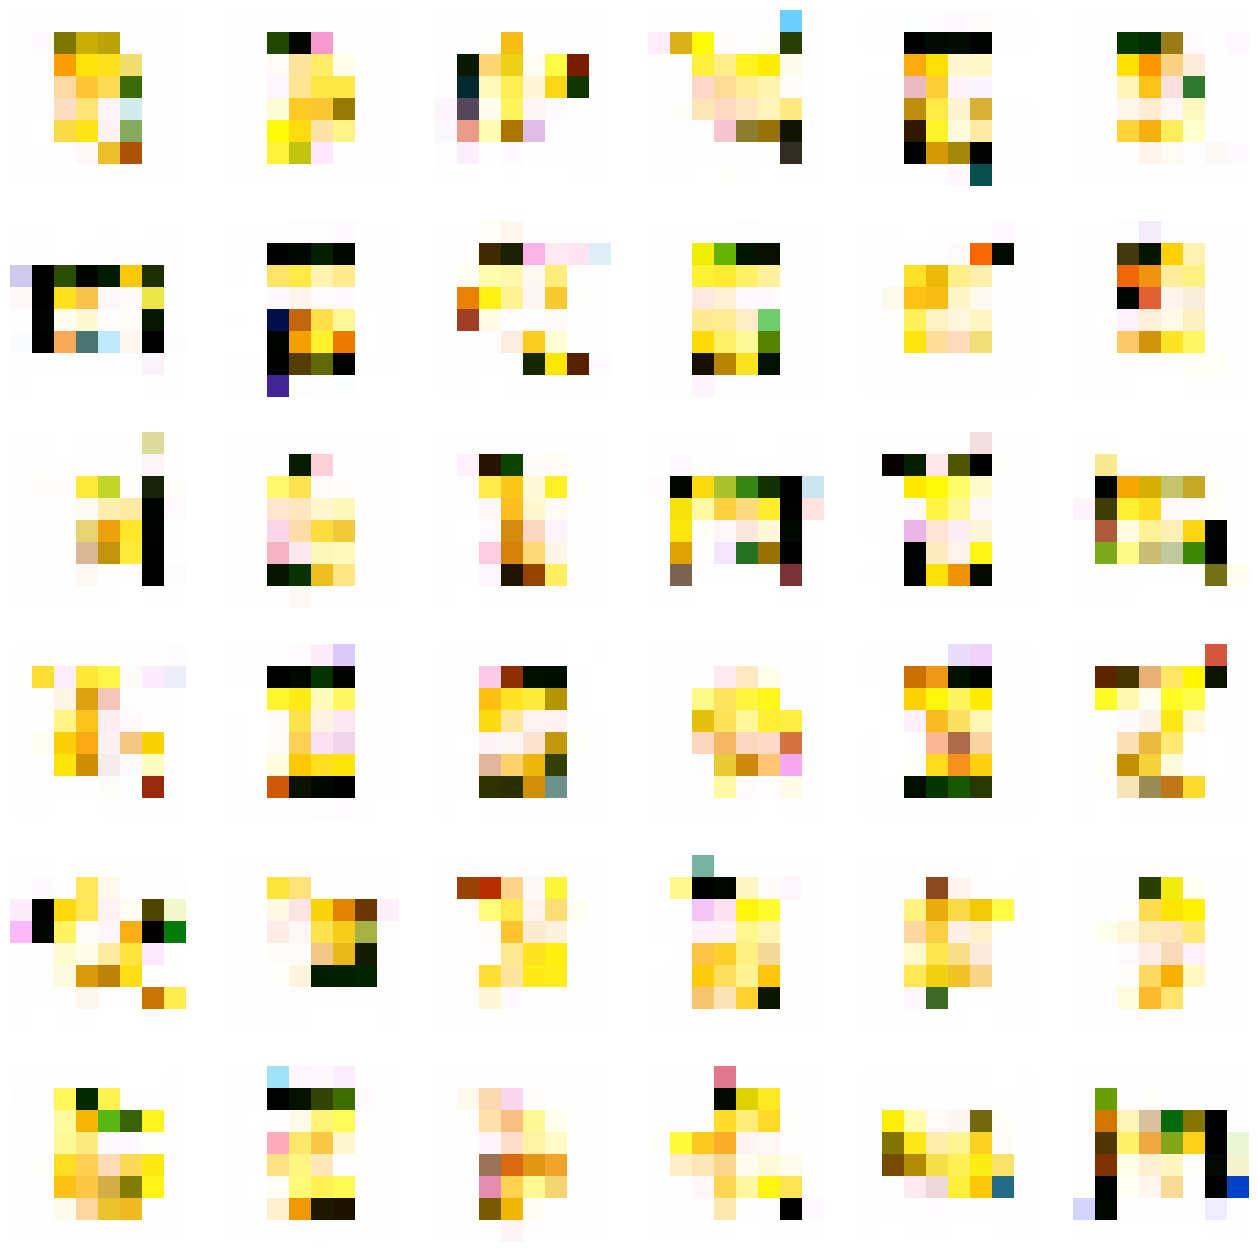

25/25 [==============================] - 38s 2s/step - d_loss: -2.3297 - g_loss: 2.8027
Epoch 35/50
25/25 [==============================] - ETA: 0s - d_loss: -2.4271 - g_loss: 2.9714

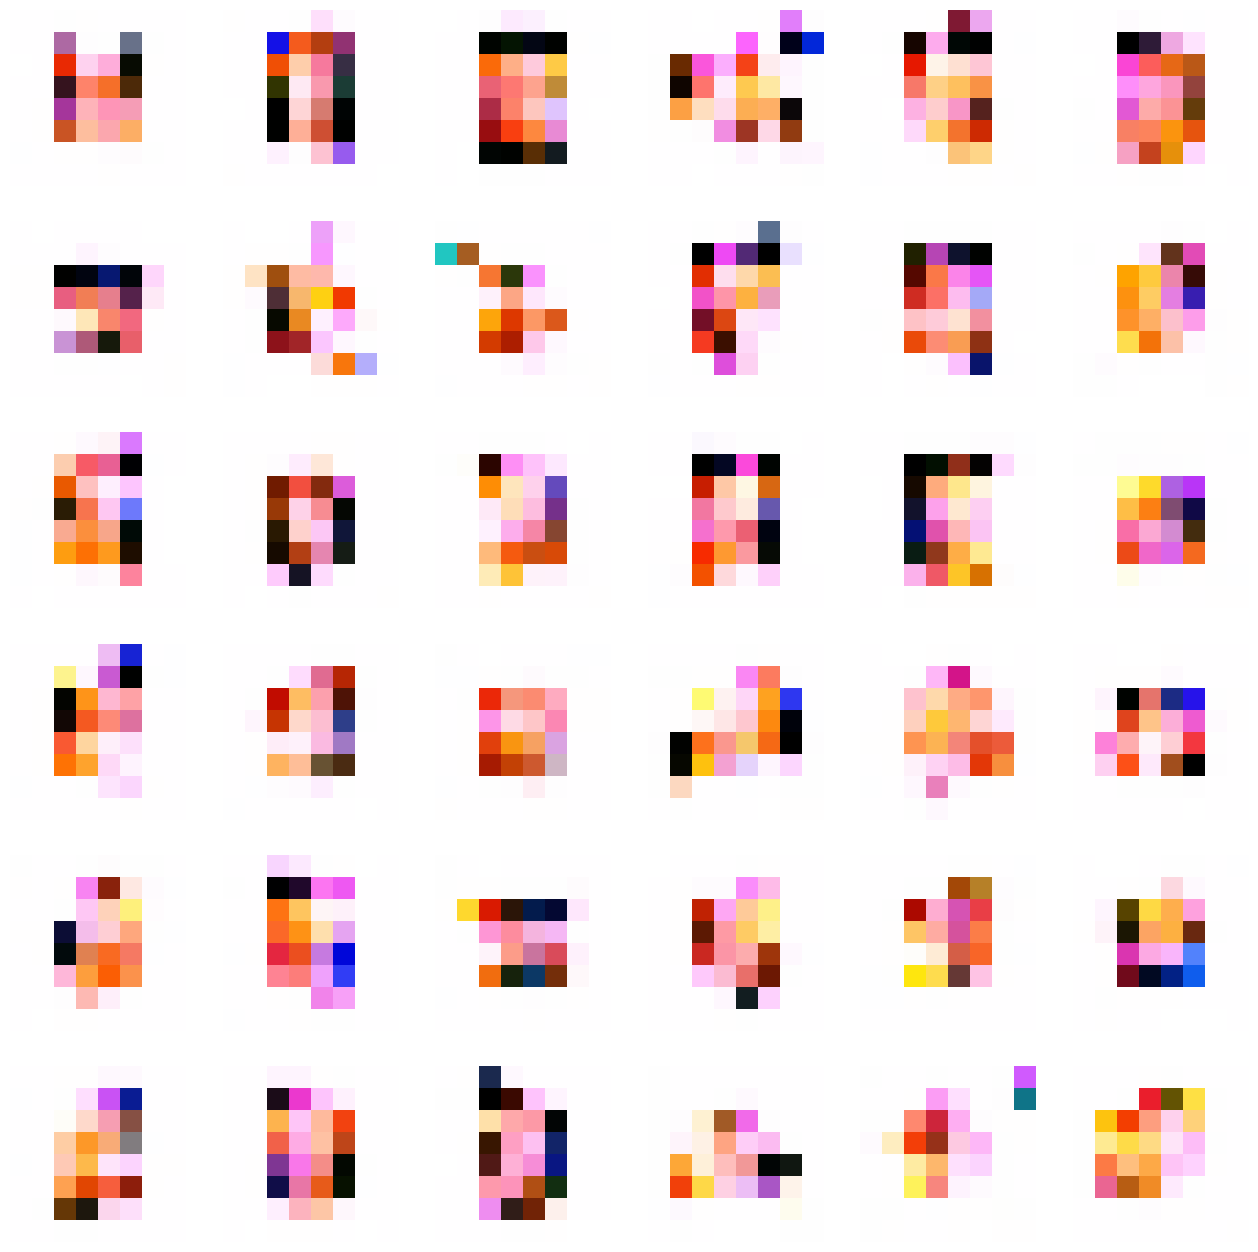

25/25 [==============================] - 38s 2s/step - d_loss: -2.3941 - g_loss: 3.0097
Epoch 36/50
25/25 [==============================] - ETA: 0s - d_loss: -2.3270 - g_loss: 2.8284

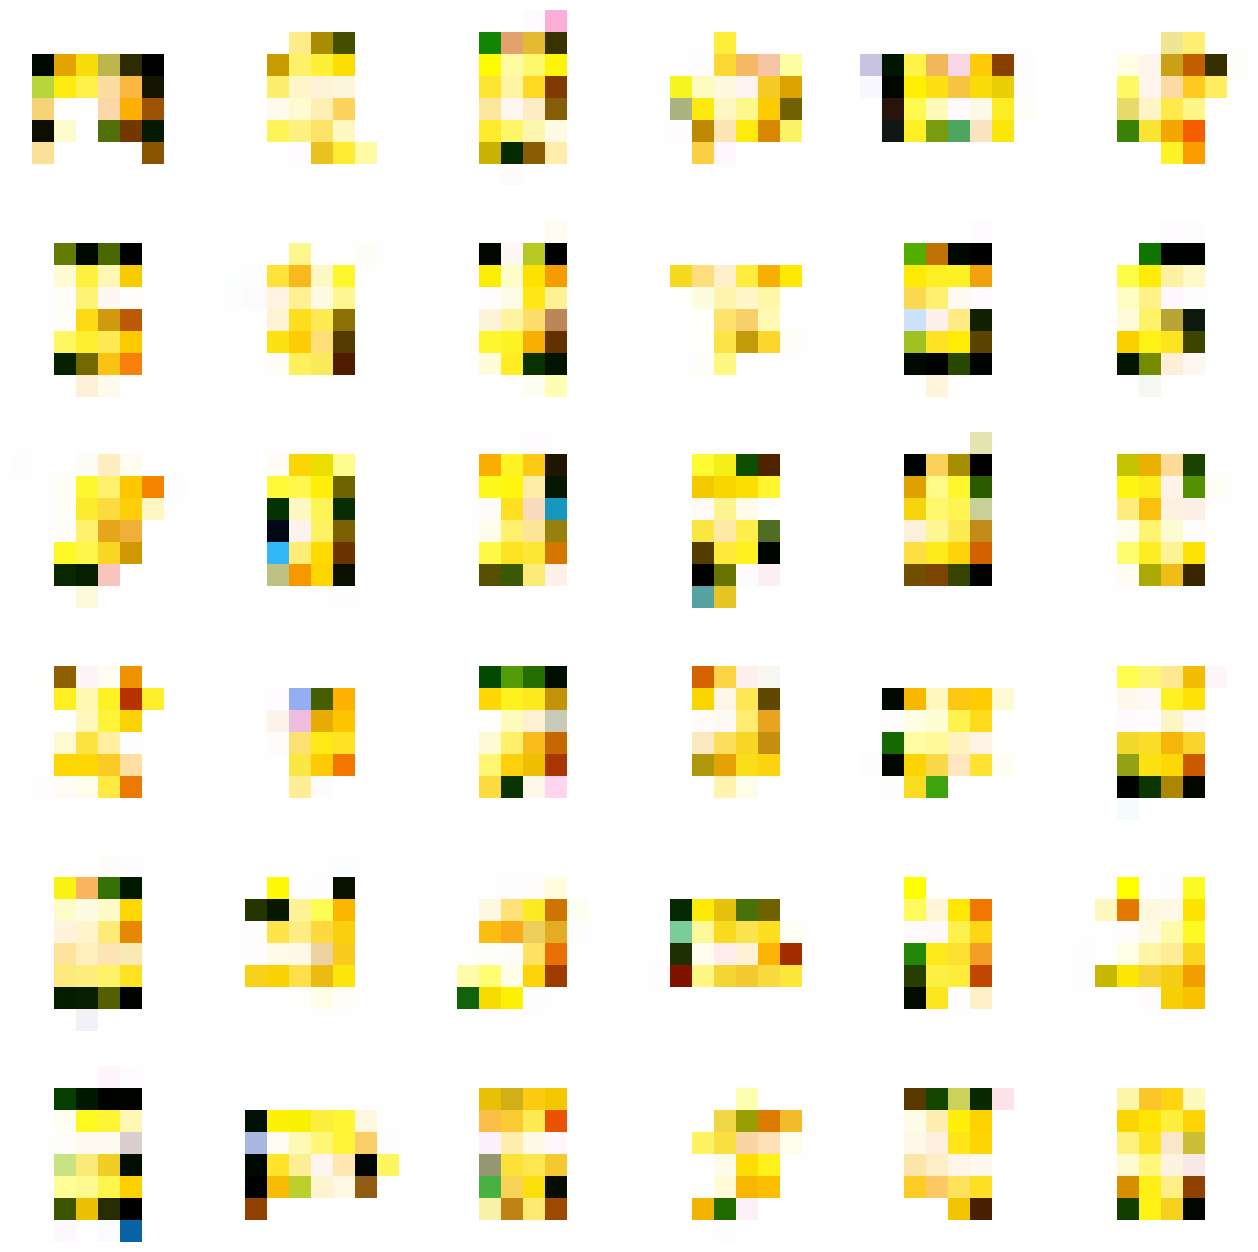

25/25 [==============================] - 38s 2s/step - d_loss: -2.2962 - g_loss: 2.9184
Epoch 37/50
25/25 [==============================] - ETA: 0s - d_loss: -2.3007 - g_loss: 3.0901

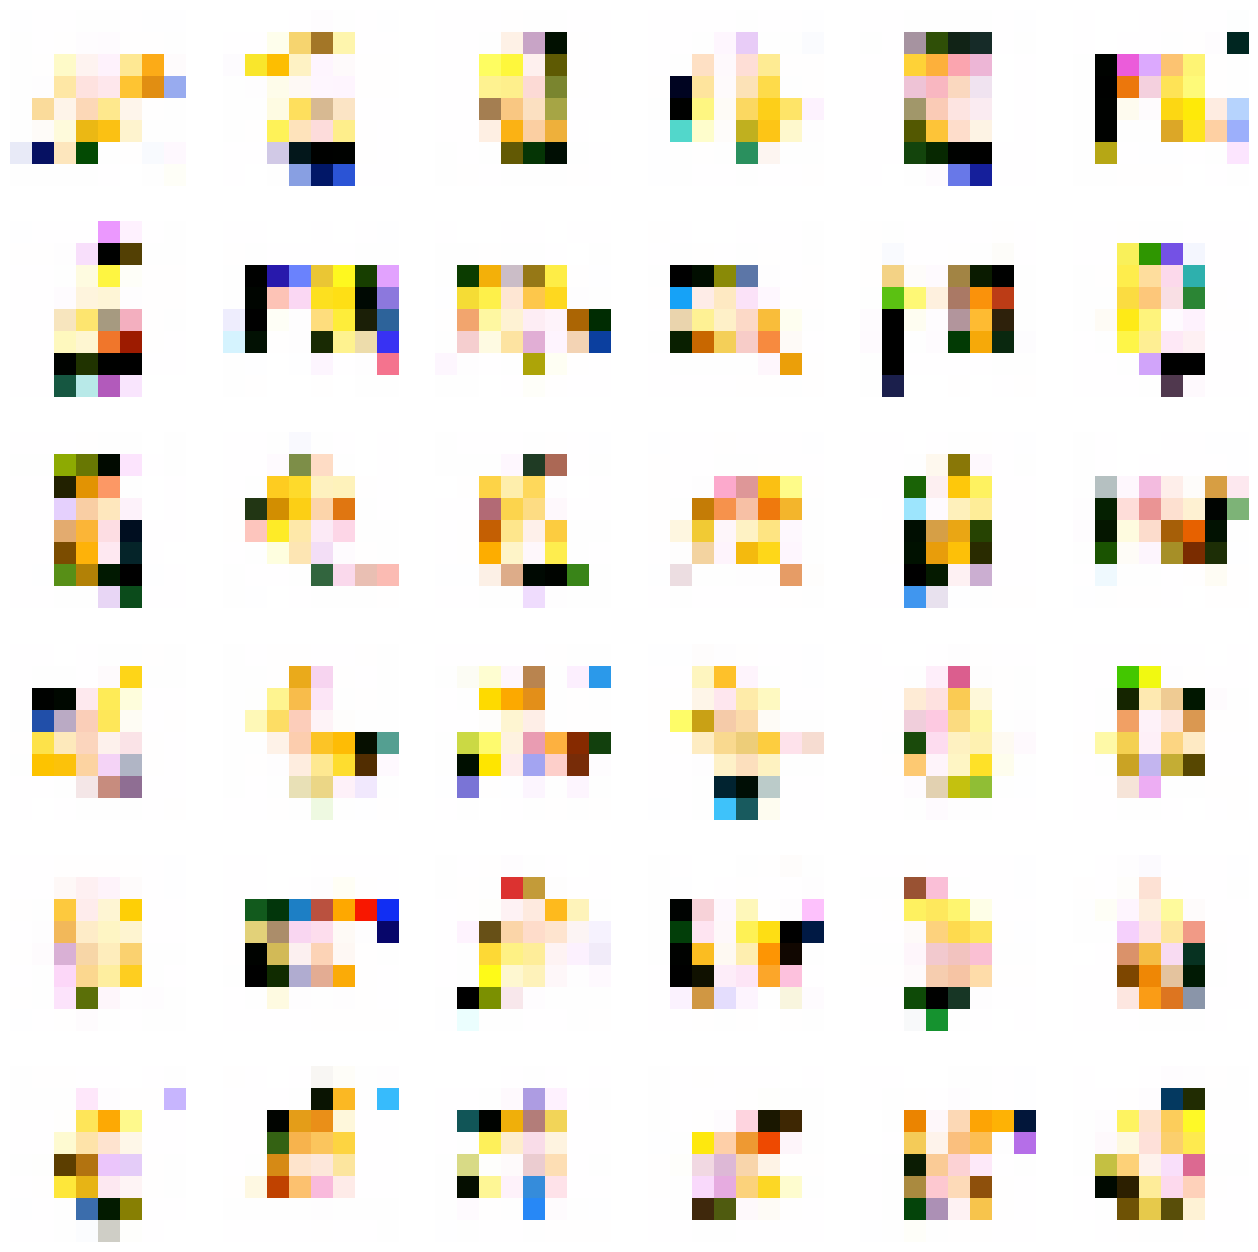

25/25 [==============================] - 37s 1s/step - d_loss: -2.3106 - g_loss: 3.0327
Epoch 38/50
25/25 [==============================] - ETA: 0s - d_loss: -2.3457 - g_loss: 2.6385

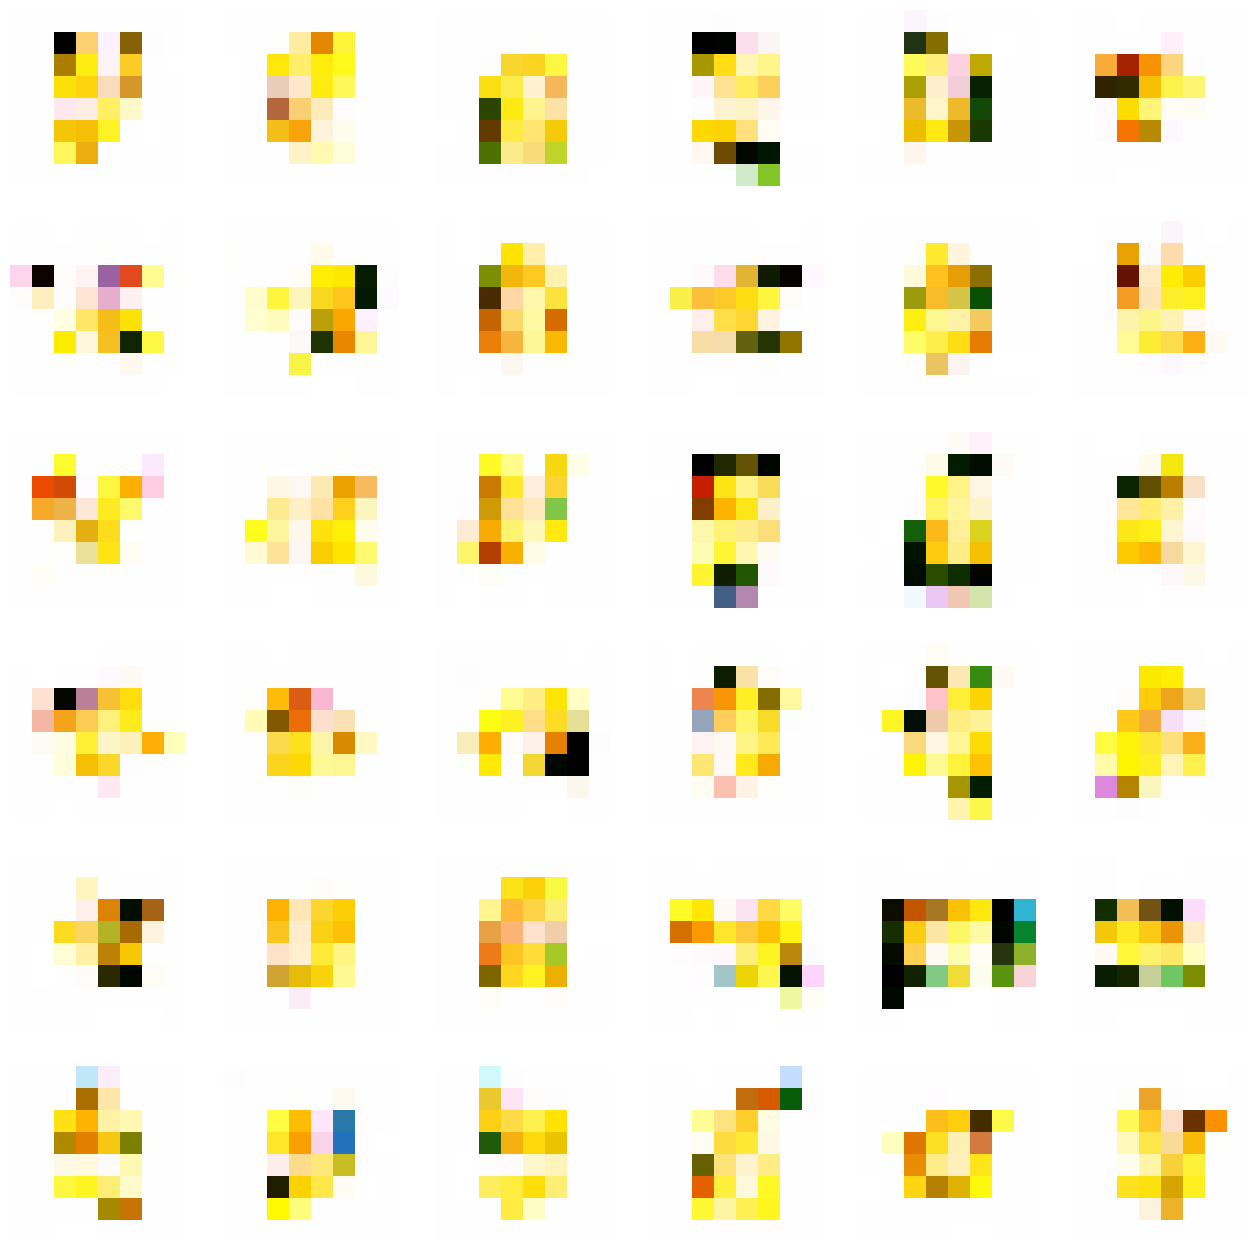

25/25 [==============================] - 38s 2s/step - d_loss: -2.3574 - g_loss: 2.6545
Epoch 39/50
25/25 [==============================] - ETA: 0s - d_loss: -2.3814 - g_loss: 3.0173

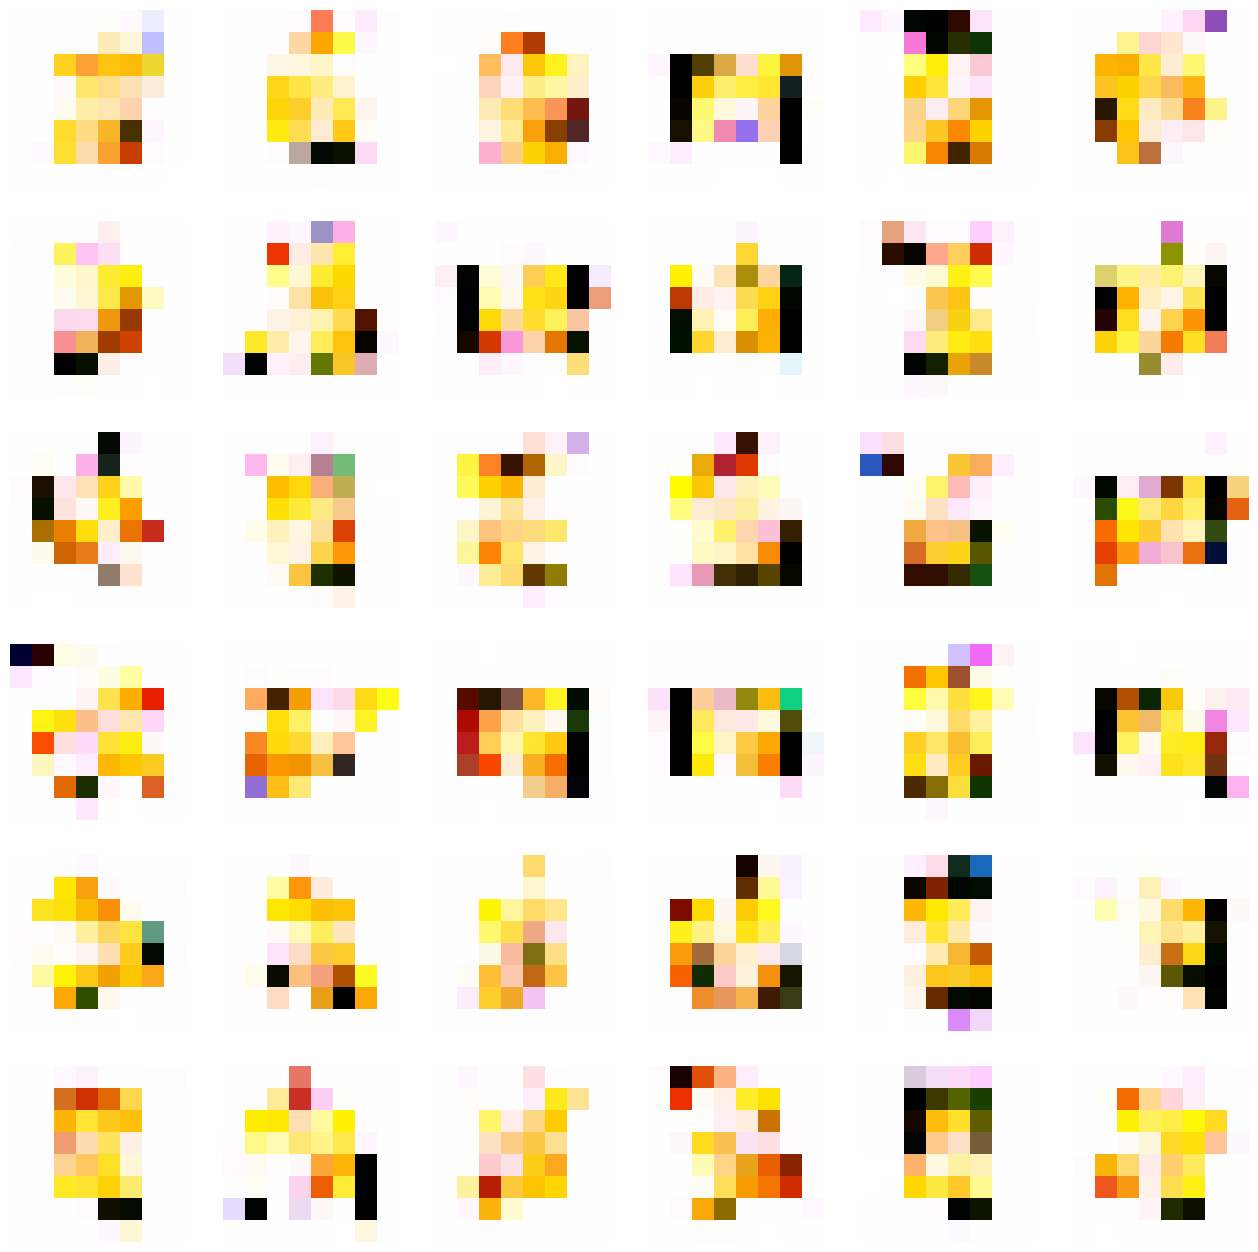

25/25 [==============================] - 37s 2s/step - d_loss: -2.4037 - g_loss: 2.9629
Epoch 40/50
25/25 [==============================] - ETA: 0s - d_loss: -2.3506 - g_loss: 2.9034

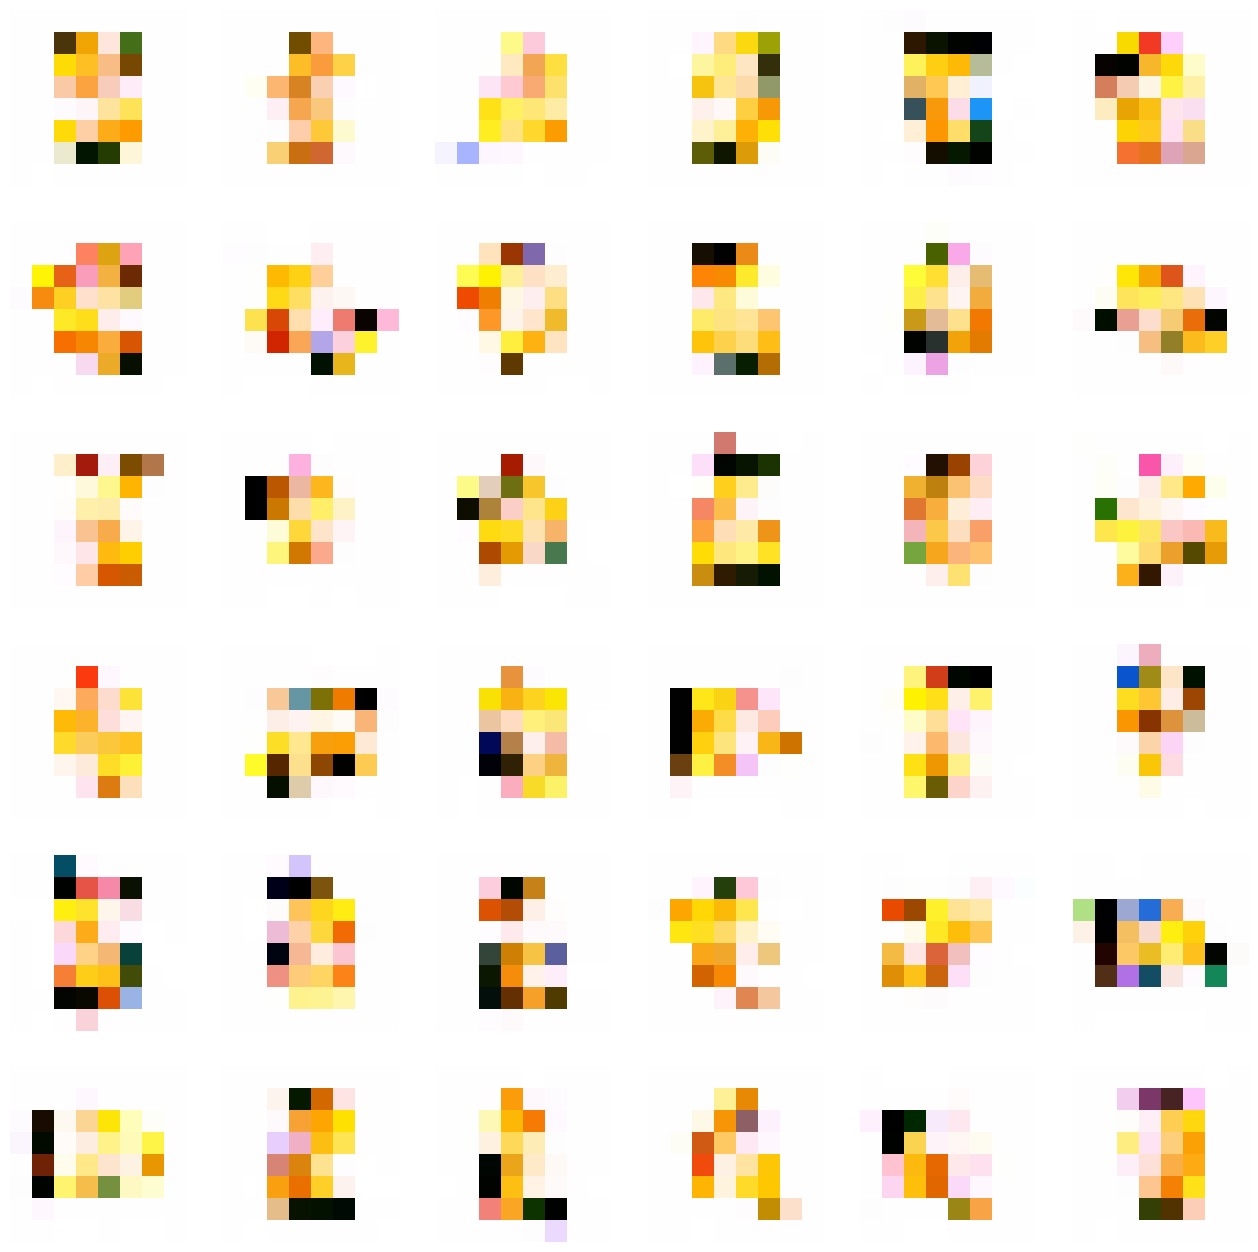

25/25 [==============================] - 38s 2s/step - d_loss: -2.3292 - g_loss: 2.9323
Epoch 41/50
25/25 [==============================] - ETA: 0s - d_loss: -2.3537 - g_loss: 2.9070

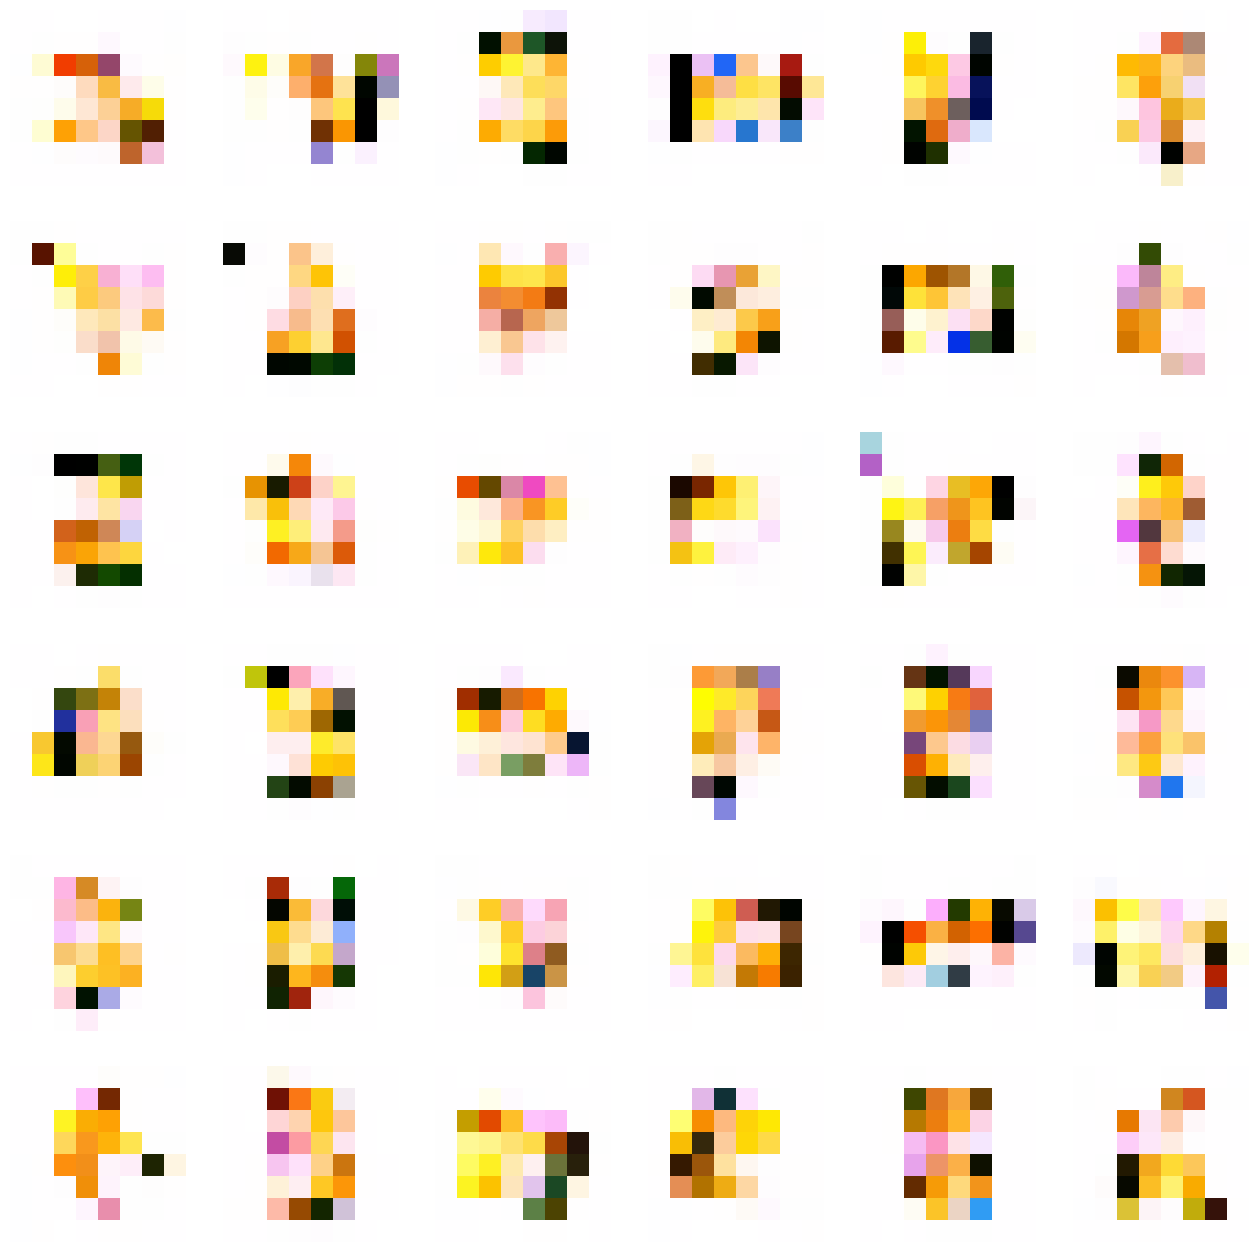

25/25 [==============================] - 38s 2s/step - d_loss: -2.3566 - g_loss: 2.8402
Epoch 42/50
25/25 [==============================] - ETA: 0s - d_loss: -2.3689 - g_loss: 2.9753

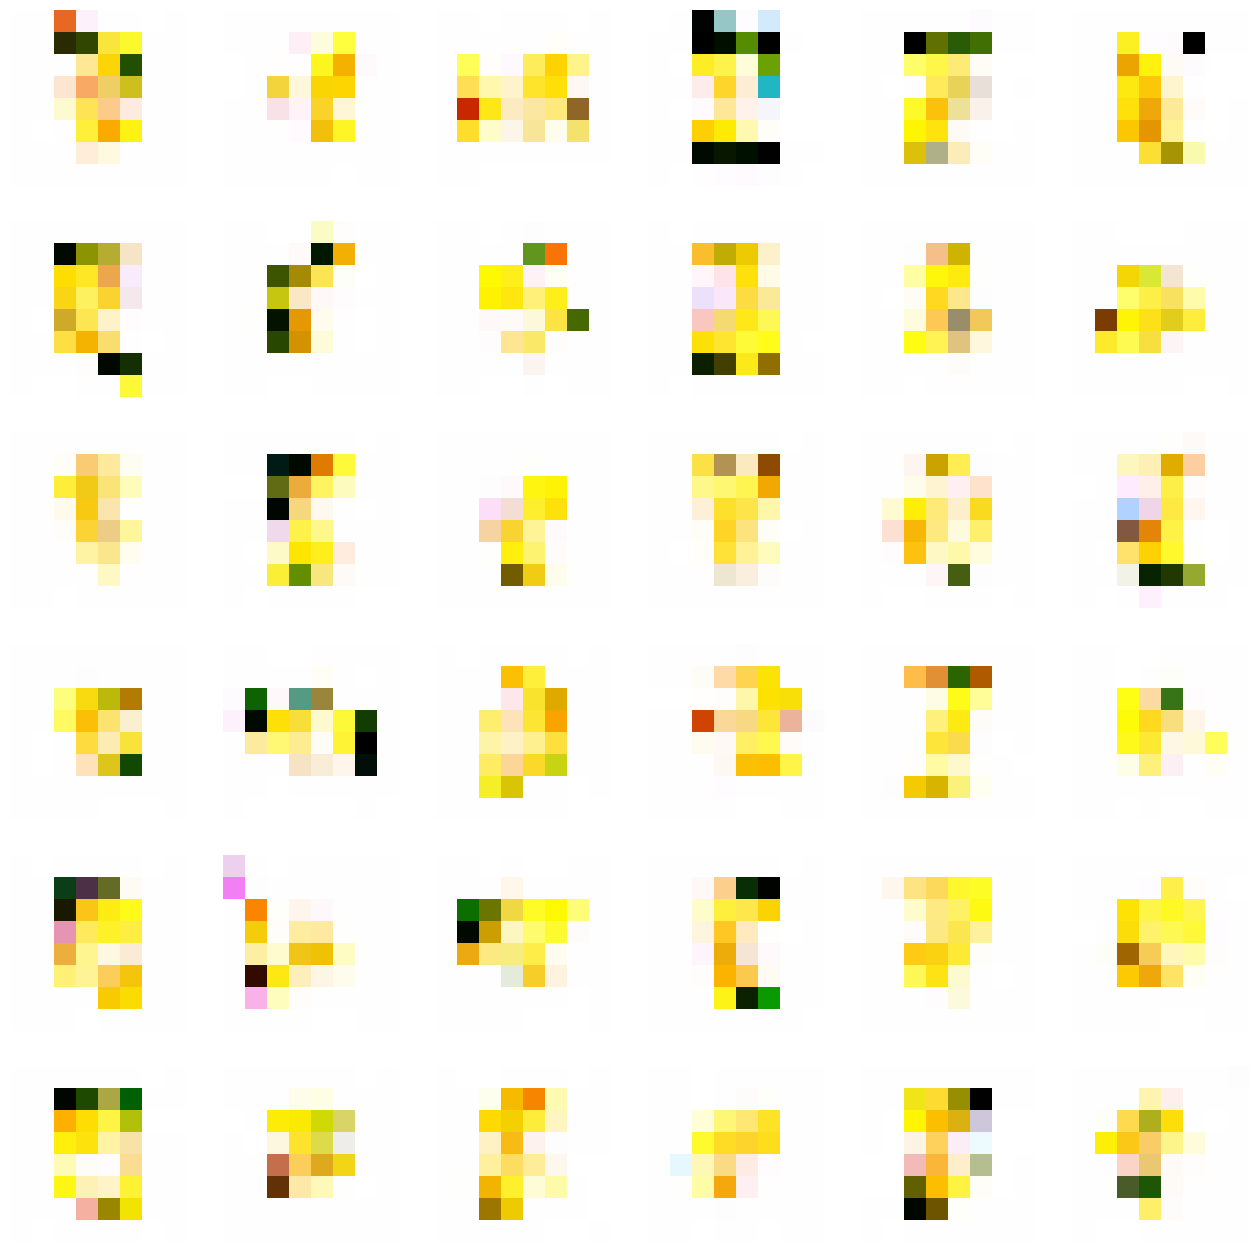

25/25 [==============================] - 38s 2s/step - d_loss: -2.3719 - g_loss: 2.9958
Epoch 43/50
25/25 [==============================] - ETA: 0s - d_loss: -2.4835 - g_loss: 3.0580

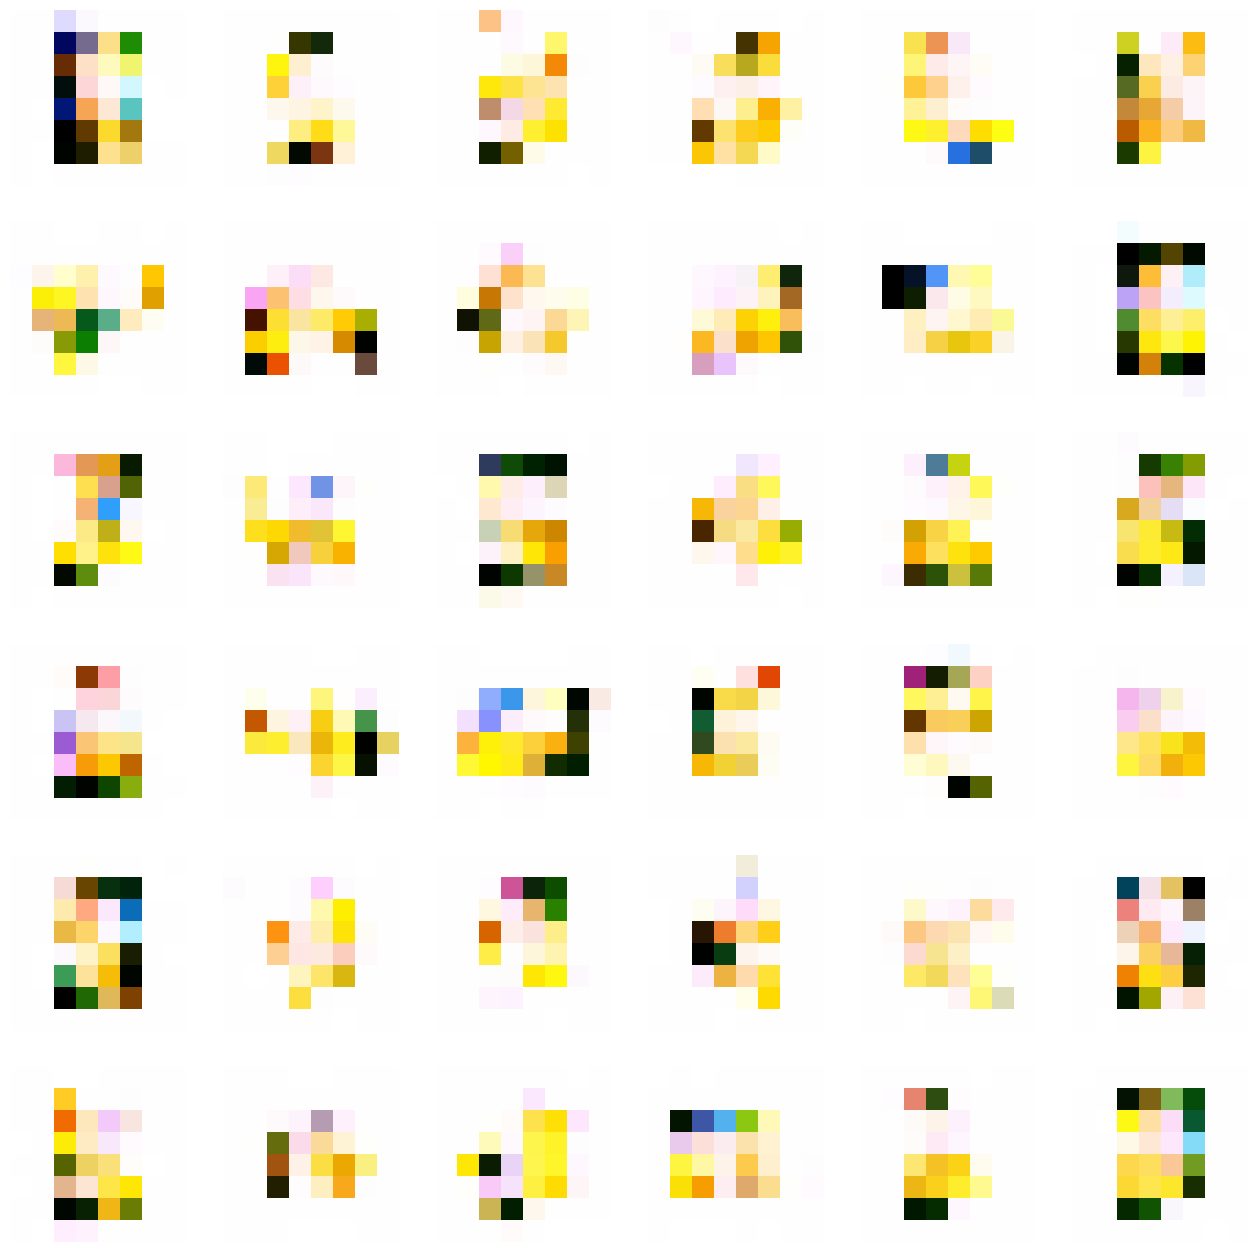

25/25 [==============================] - 38s 2s/step - d_loss: -2.4677 - g_loss: 3.0405
Epoch 44/50
25/25 [==============================] - ETA: 0s - d_loss: -2.5864 - g_loss: 3.3380

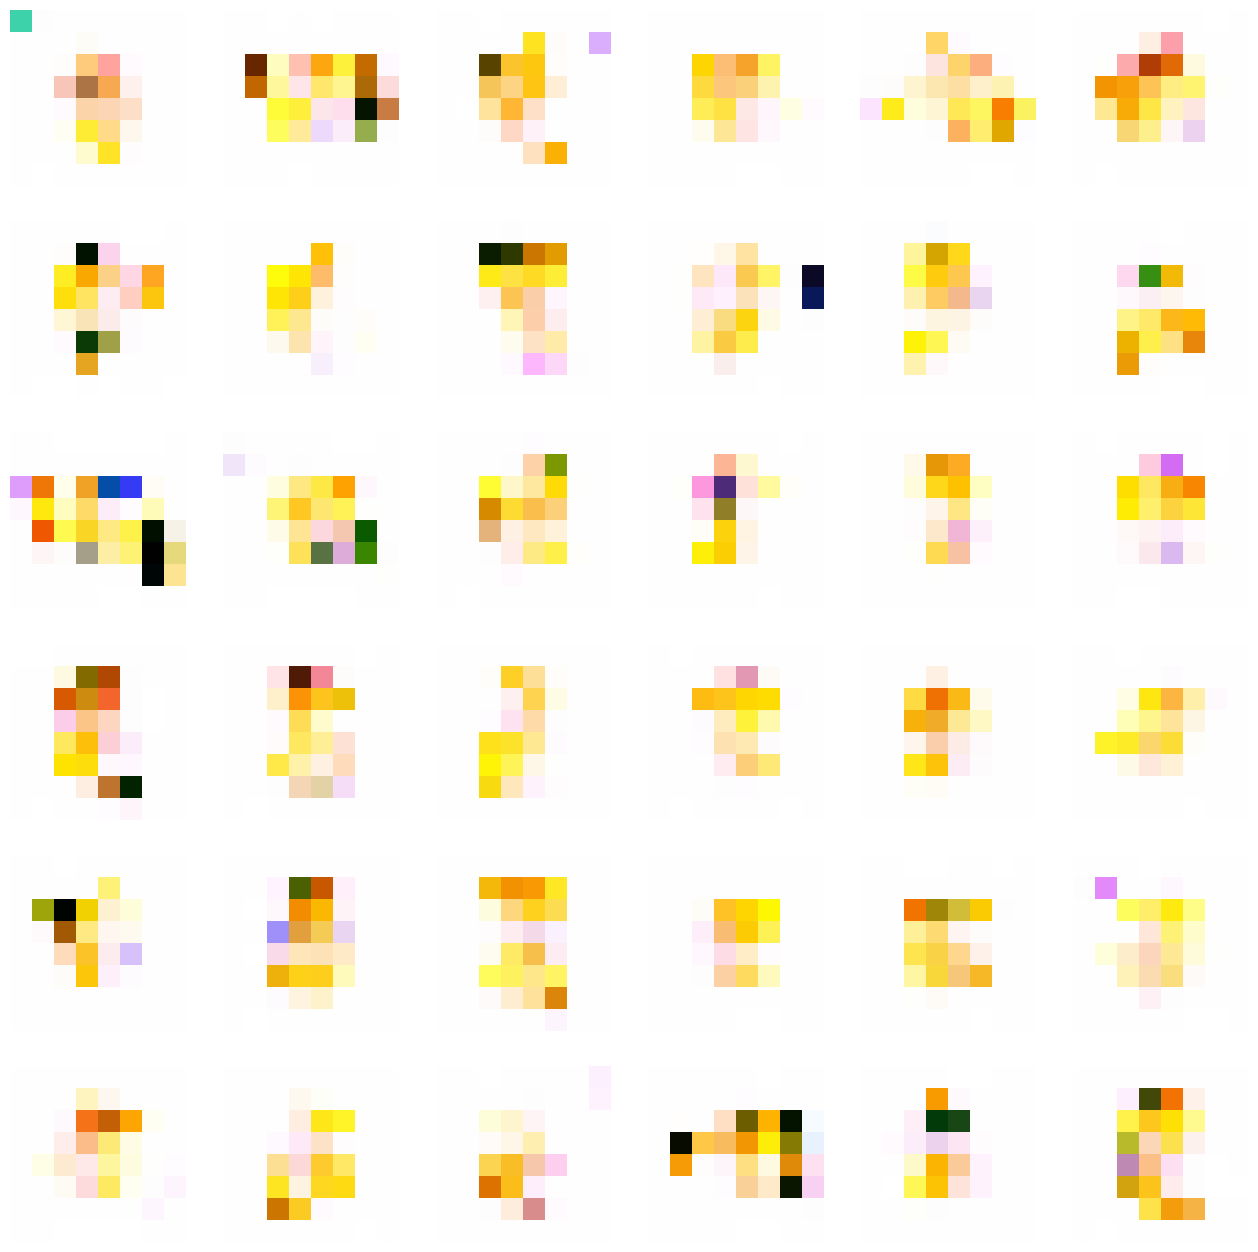

25/25 [==============================] - 38s 2s/step - d_loss: -2.5663 - g_loss: 3.2750
Epoch 45/50
25/25 [==============================] - ETA: 0s - d_loss: -2.4736 - g_loss: 2.8739

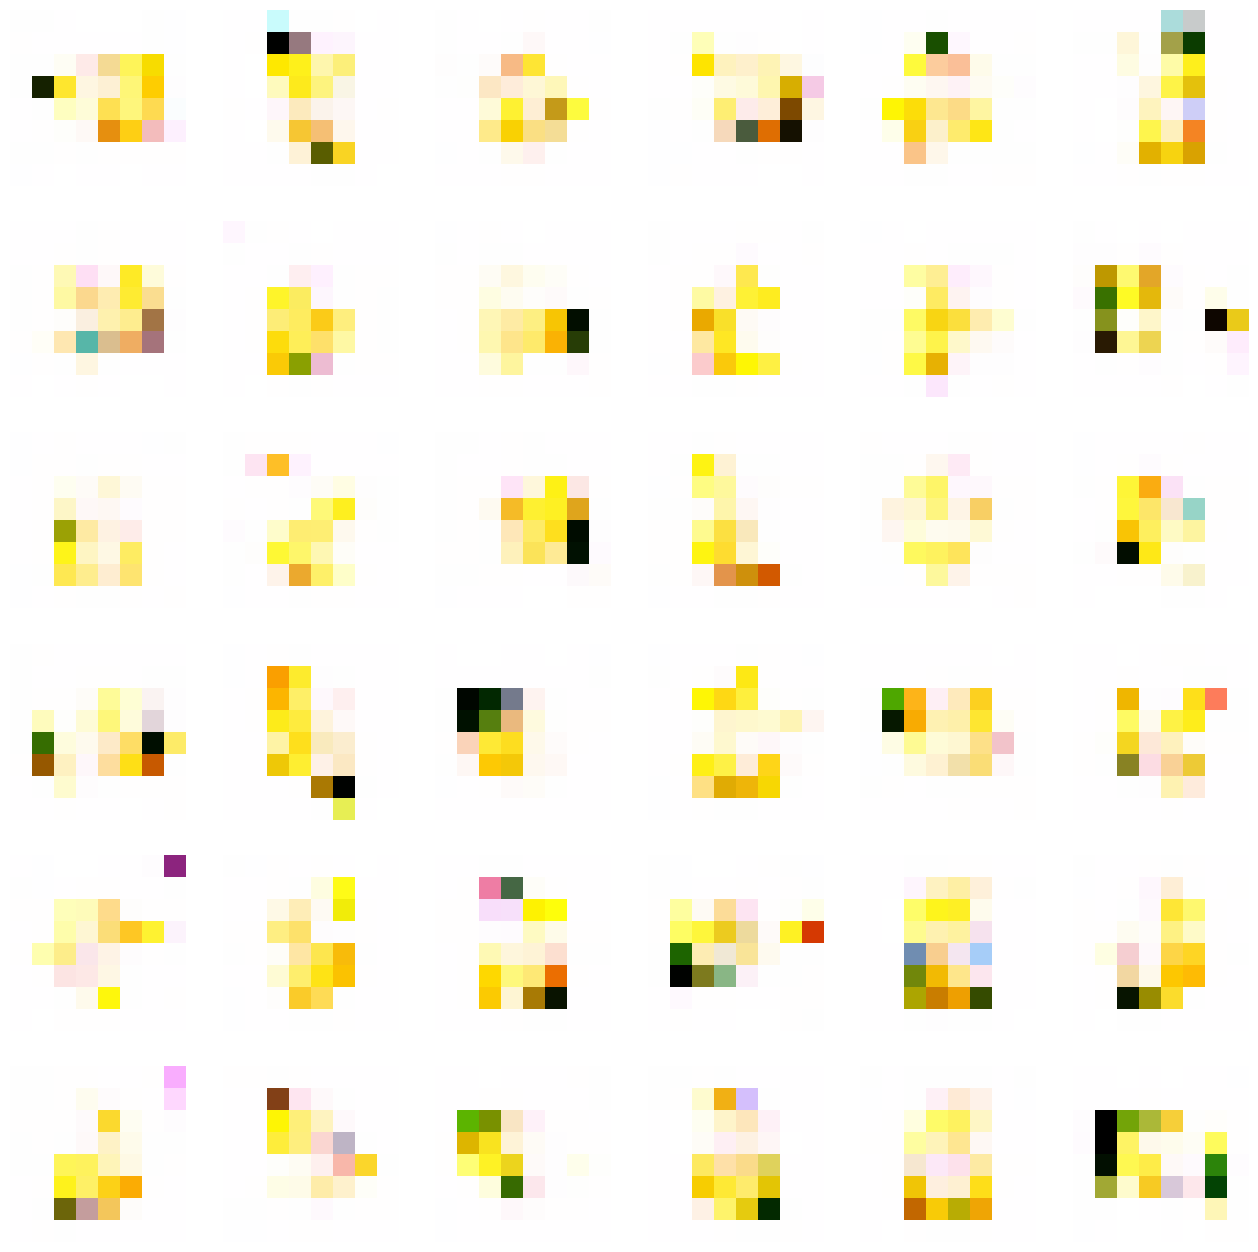

25/25 [==============================] - 39s 2s/step - d_loss: -2.4547 - g_loss: 2.7266
Epoch 46/50
25/25 [==============================] - ETA: 0s - d_loss: -2.5103 - g_loss: 3.1337

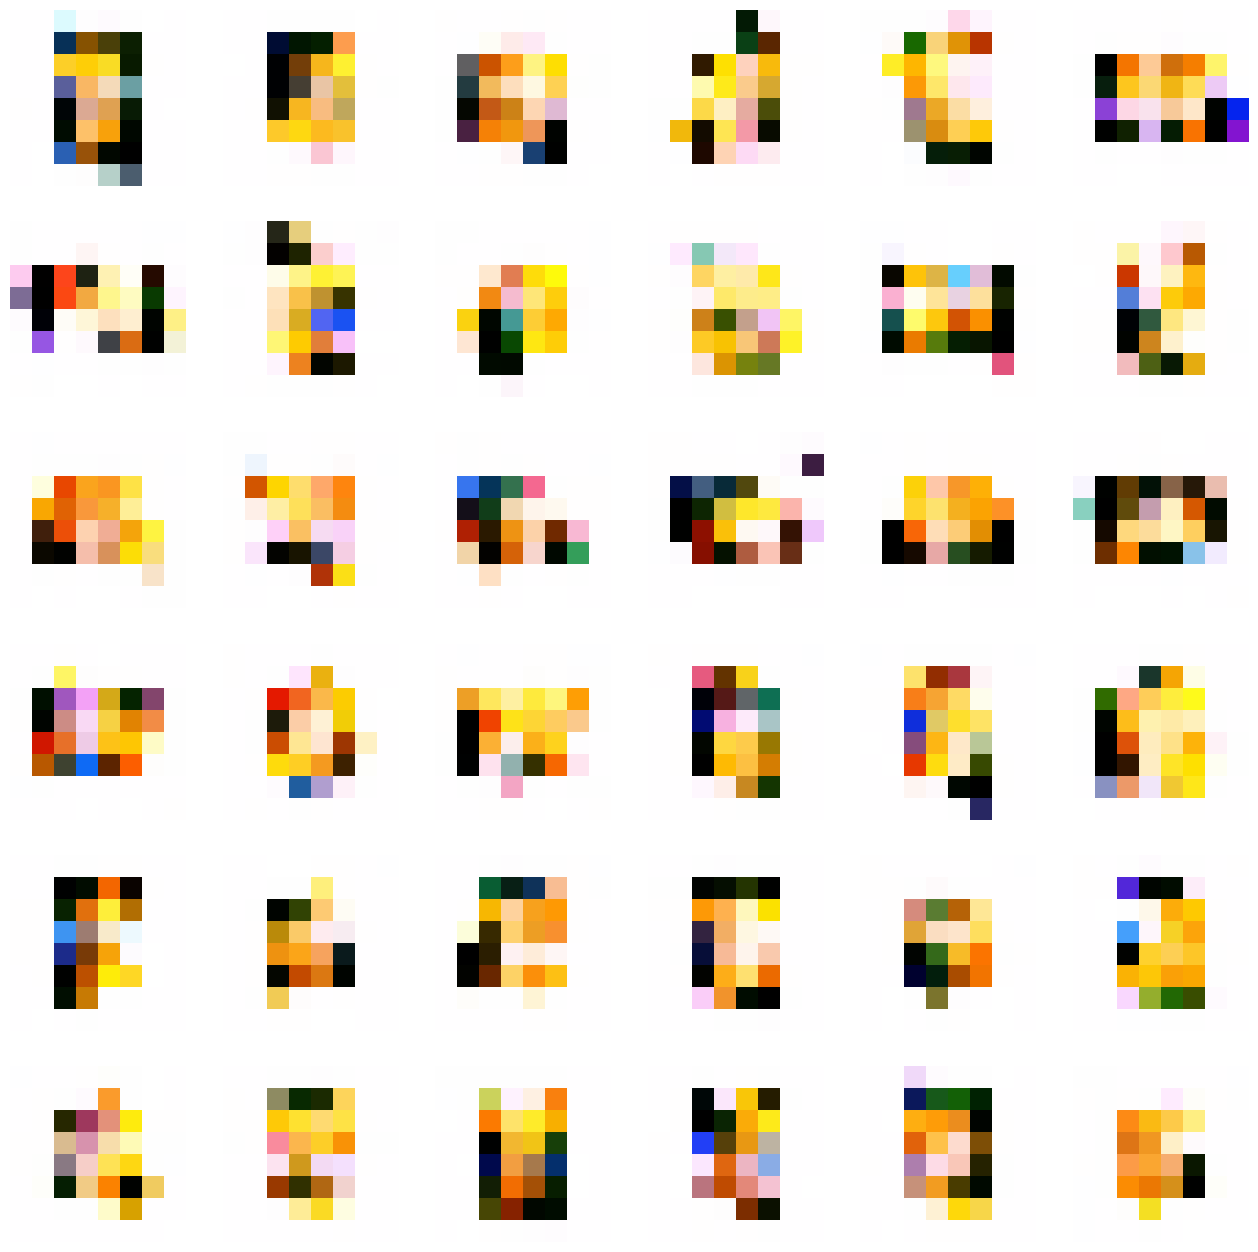

25/25 [==============================] - 36s 1s/step - d_loss: -2.4917 - g_loss: 3.1446
Epoch 47/50
25/25 [==============================] - ETA: 0s - d_loss: -2.5056 - g_loss: 3.3358

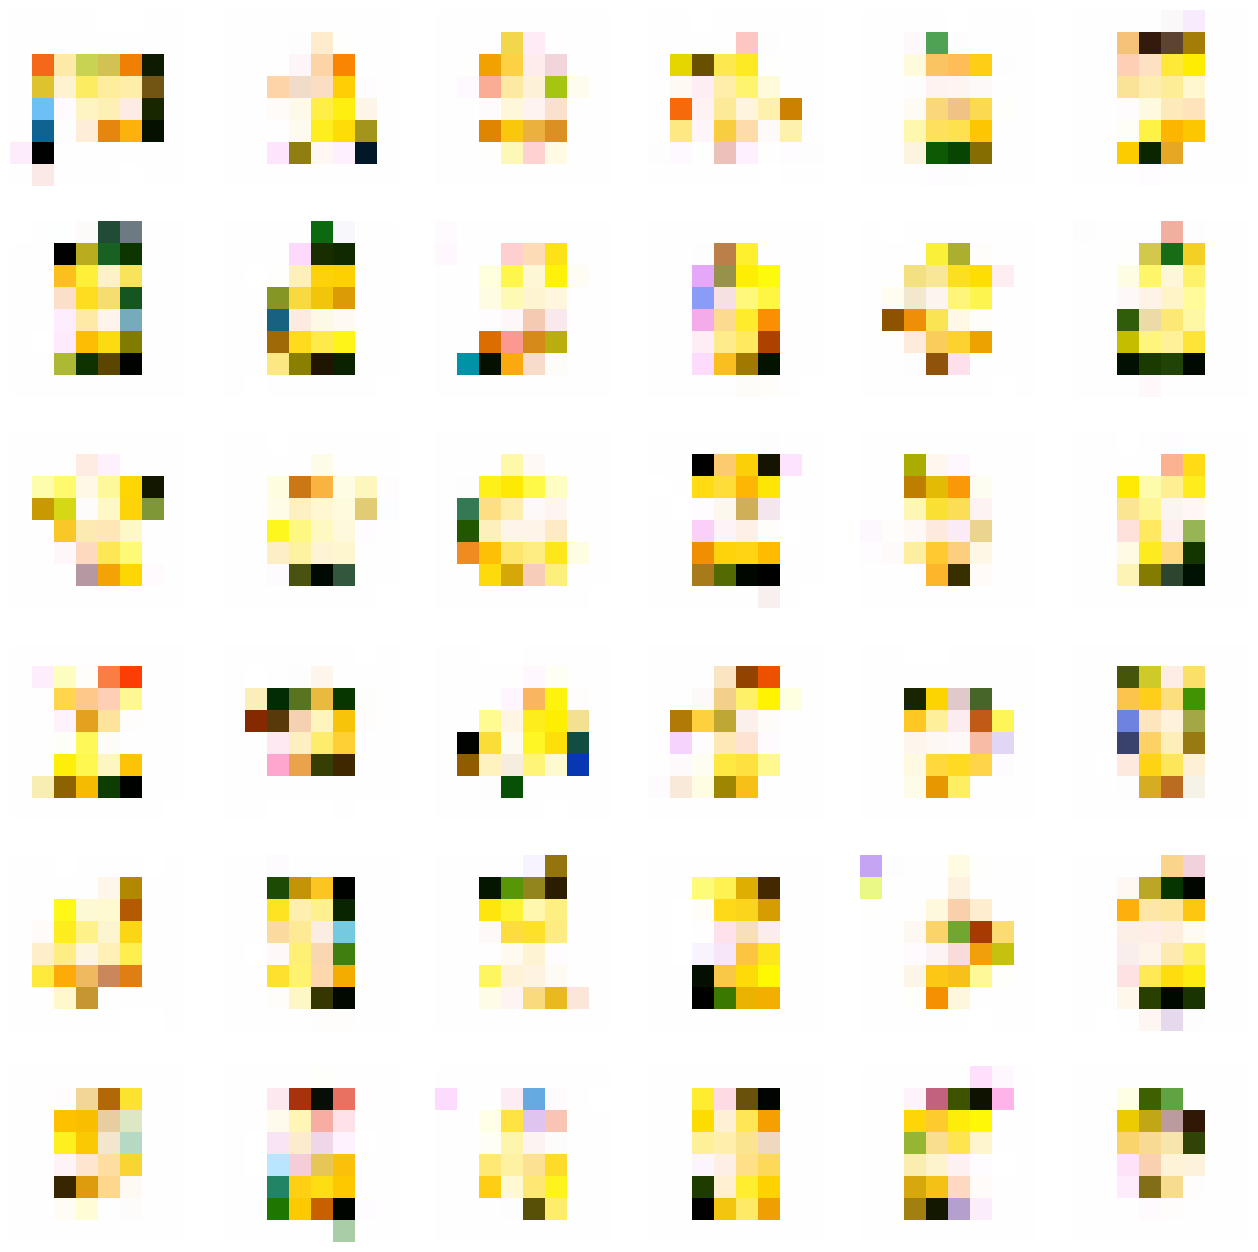

25/25 [==============================] - 38s 2s/step - d_loss: -2.5018 - g_loss: 3.3589
Epoch 48/50
25/25 [==============================] - ETA: 0s - d_loss: -2.5948 - g_loss: 3.4127

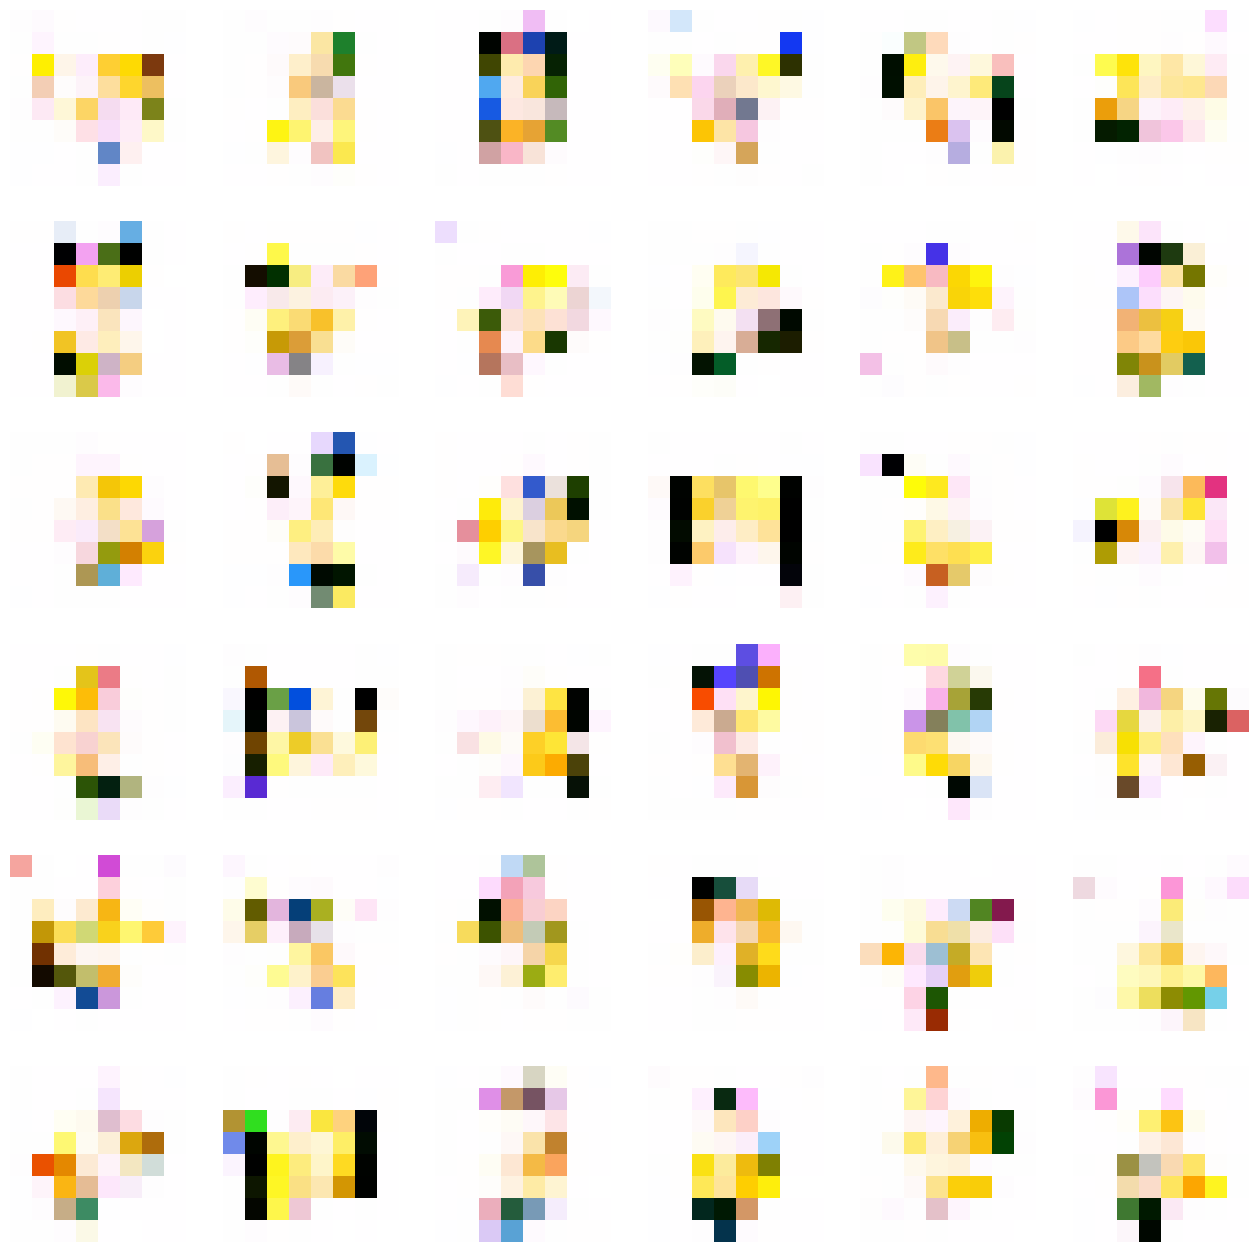

25/25 [==============================] - 39s 2s/step - d_loss: -2.5830 - g_loss: 3.3610
Epoch 49/50
25/25 [==============================] - ETA: 0s - d_loss: -2.3084 - g_loss: 2.7468

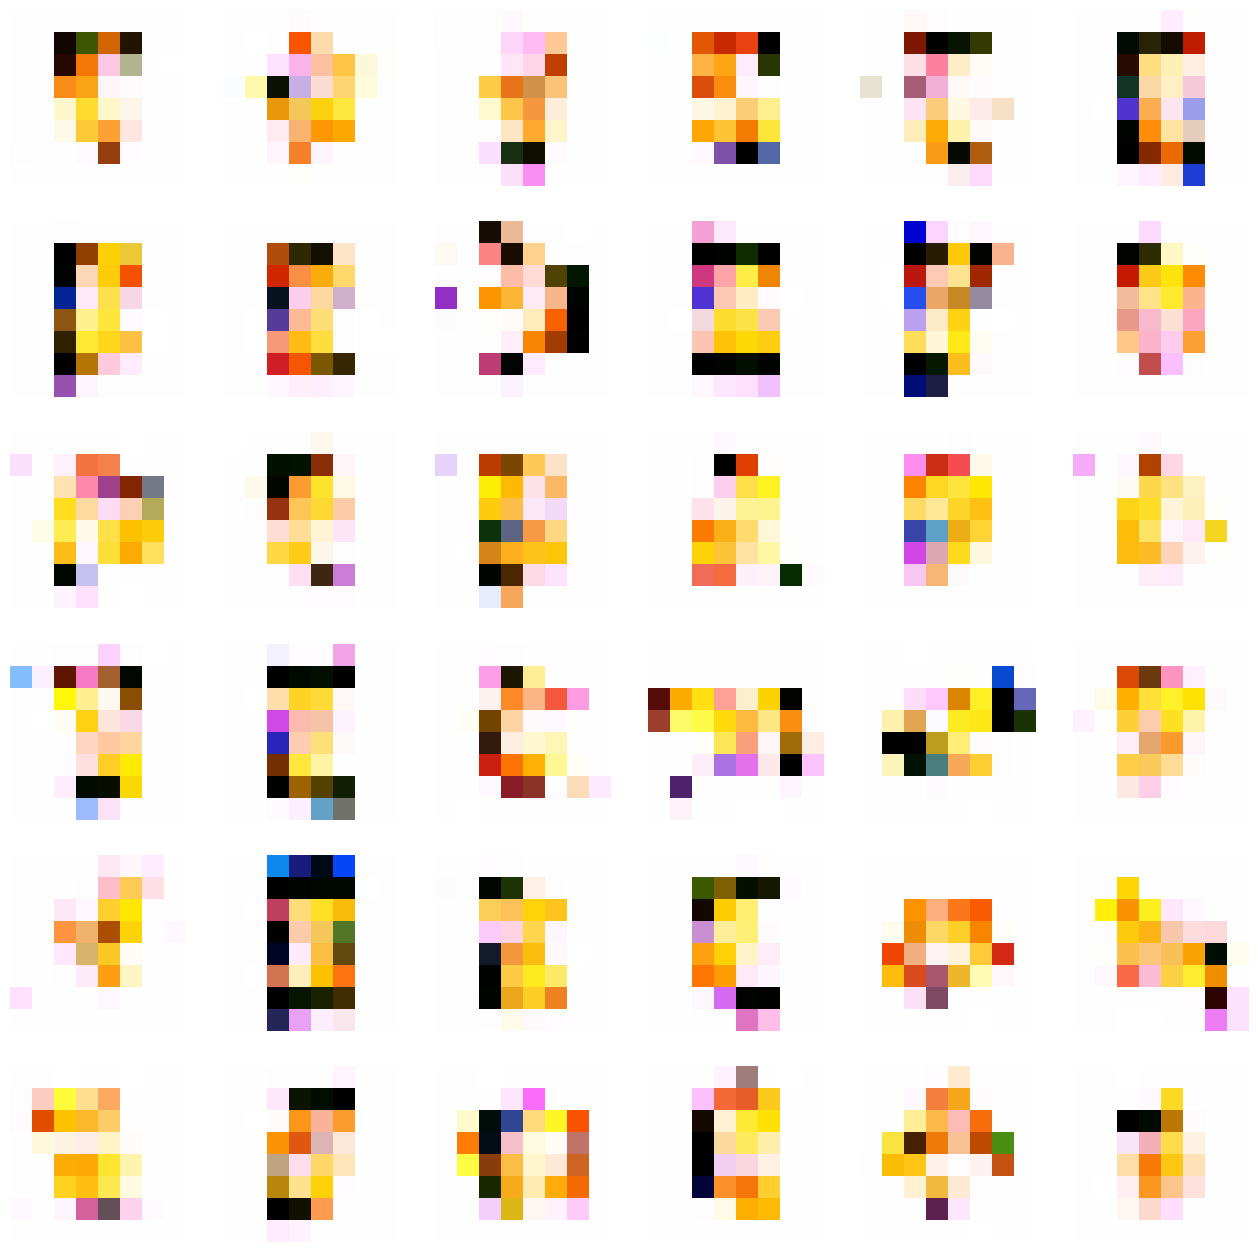

25/25 [==============================] - 40s 2s/step - d_loss: -2.2354 - g_loss: 2.7294
Epoch 50/50
25/25 [==============================] - ETA: 0s - d_loss: -2.6454 - g_loss: 3.2865

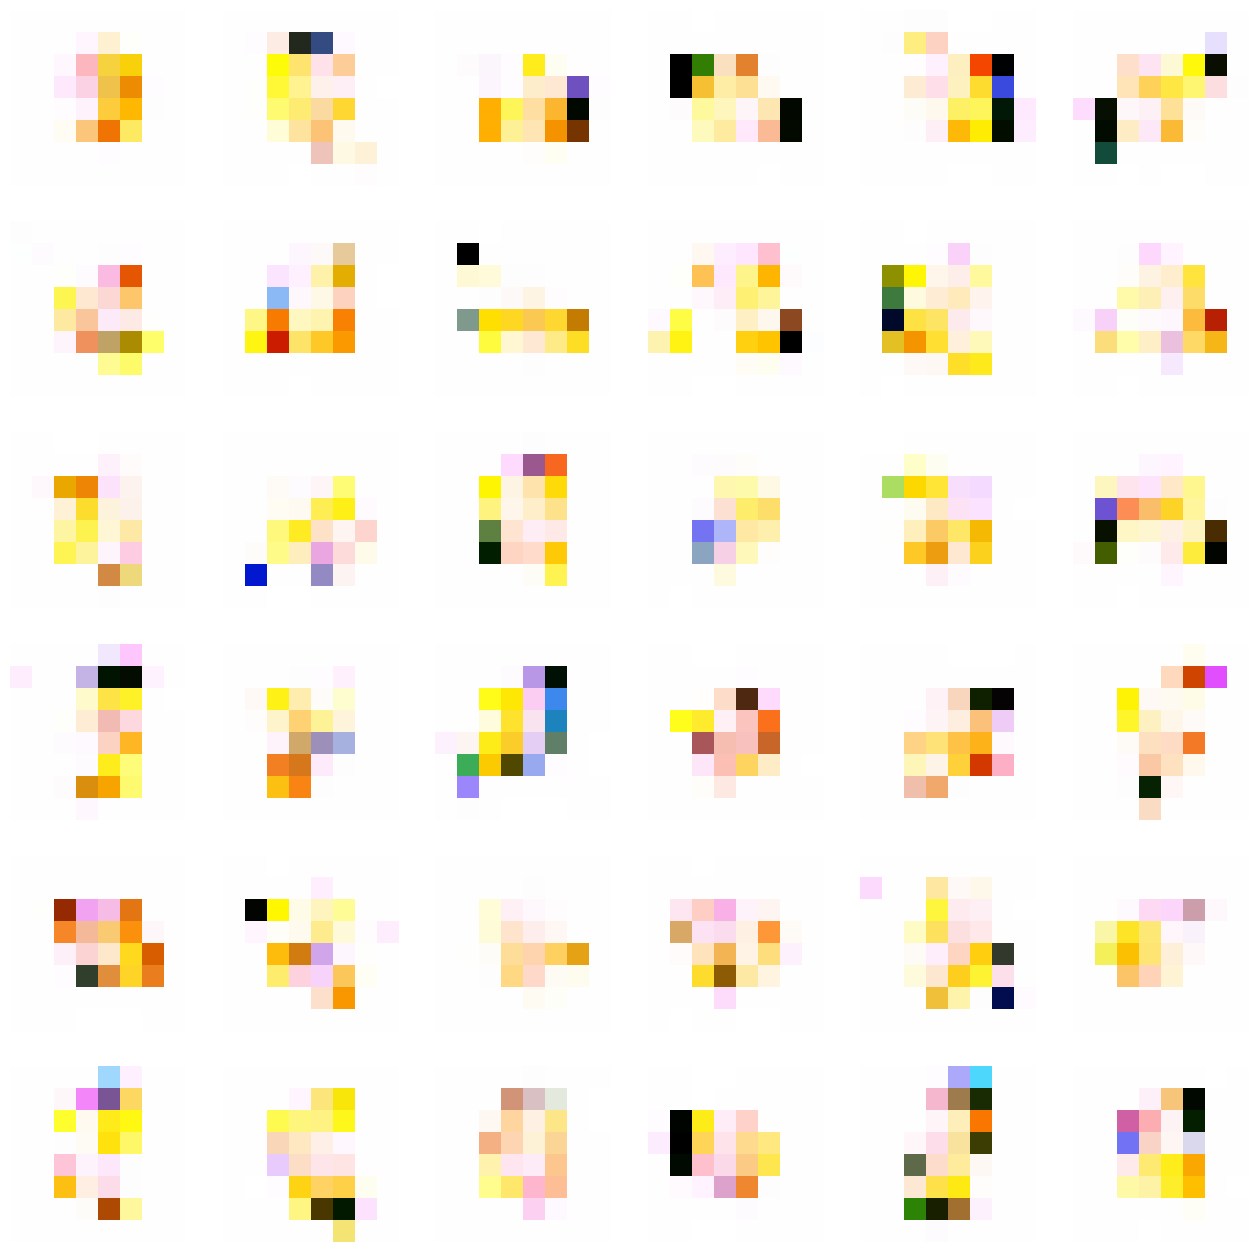

25/25 [==============================] - 41s 2s/step - d_loss: -2.6274 - g_loss: 3.2700
Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_39 (InputLayer)       [(None, 512)]                0         []                            
                                                                                                  
 input_40 (InputLayer)       [(None, 256)]                0         []                            
                                                                                                  
 concatenate_17 (Concatenat  (None, 768)                  0         ['input_39[0][0]',            
 e)                                                                  'input_40[0][0]']            
                                                                                                  
 p

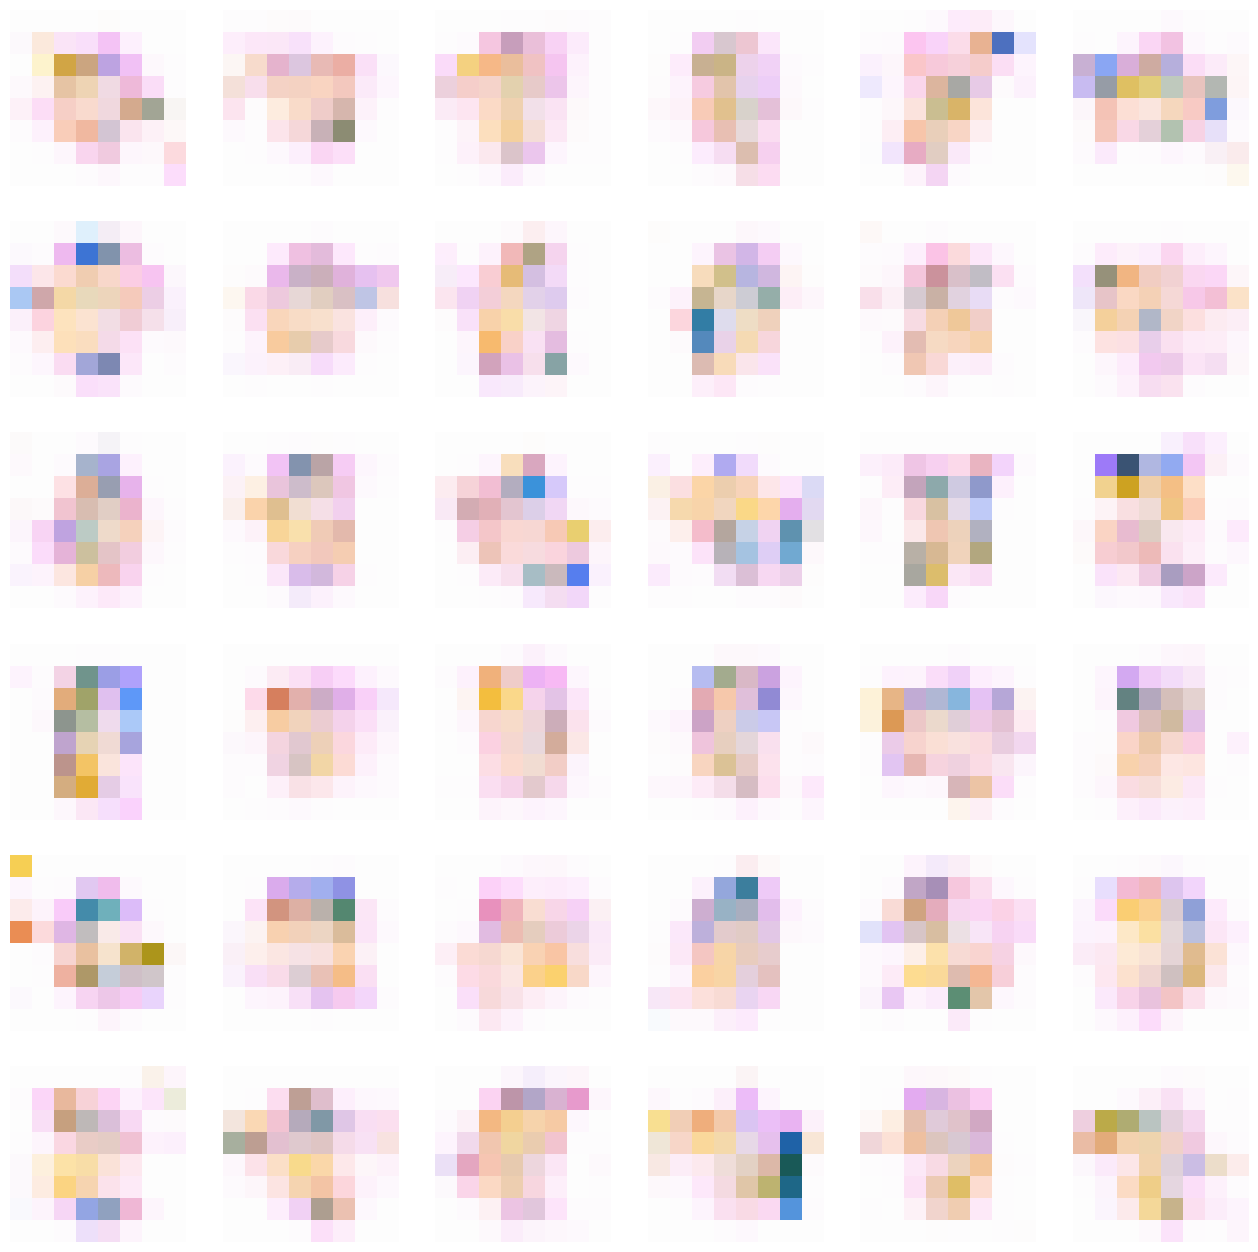

25/25 [==============================] - 147s 5s/step - d_loss: -0.8339 - g_loss: 4.7903
Epoch 2/50
25/25 [==============================] - ETA: 0s - d_loss: -1.4297 - g_loss: -2.9104

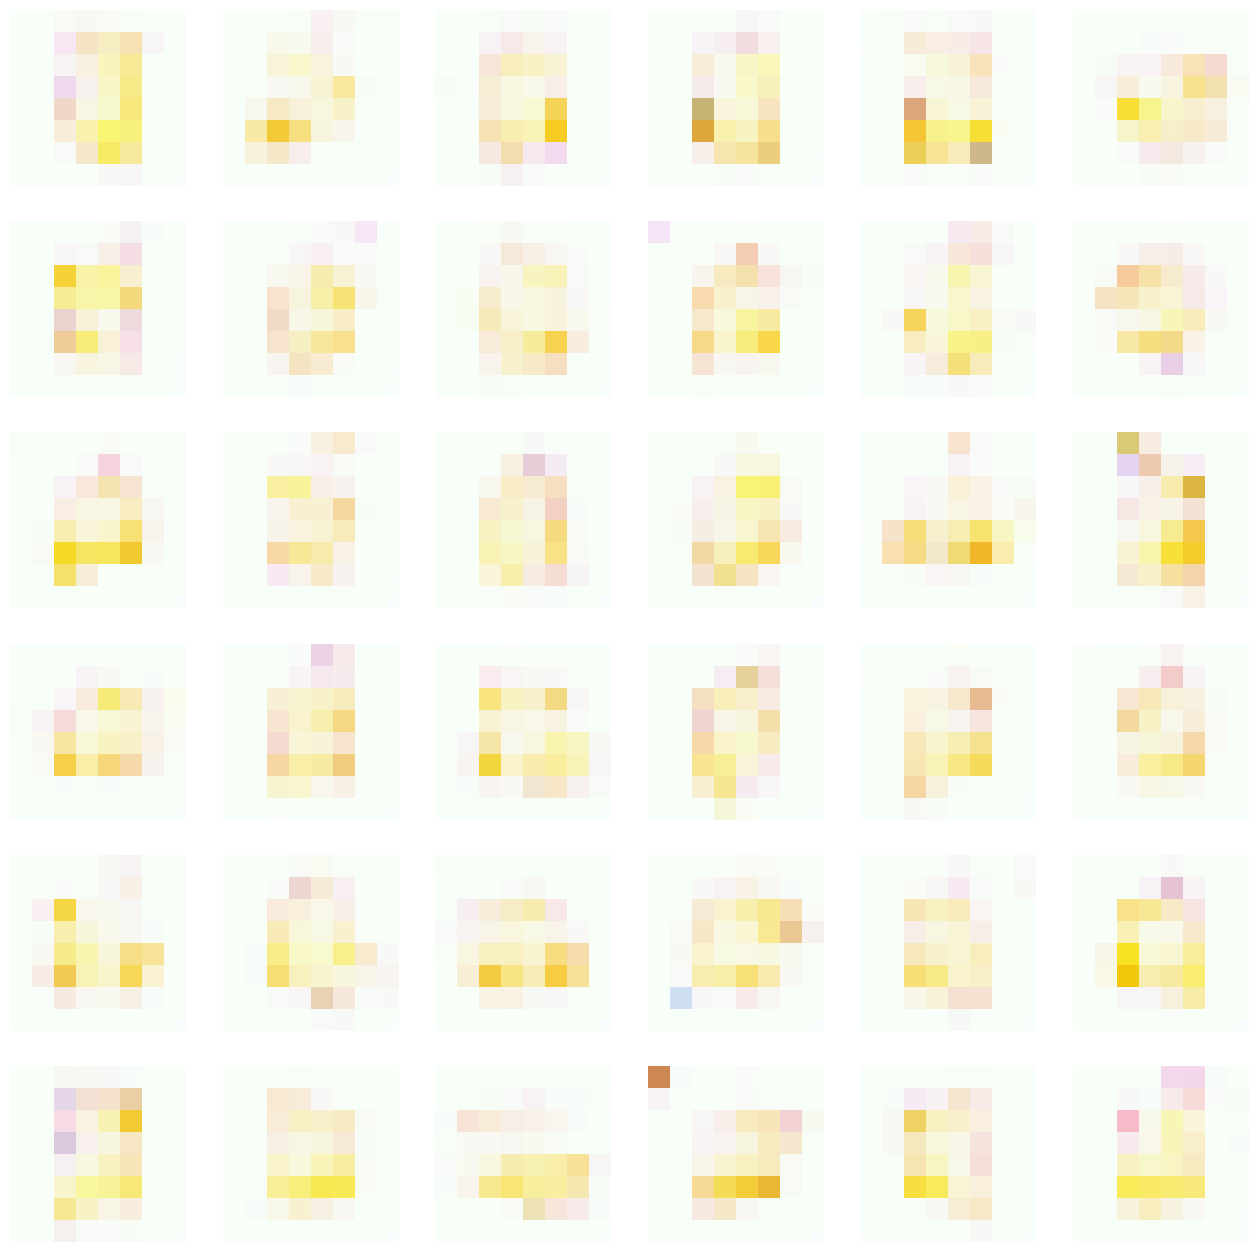

25/25 [==============================] - 135s 5s/step - d_loss: -1.4892 - g_loss: -2.3916
Epoch 3/50
25/25 [==============================] - ETA: 0s - d_loss: -4.9565 - g_loss: 5.7666

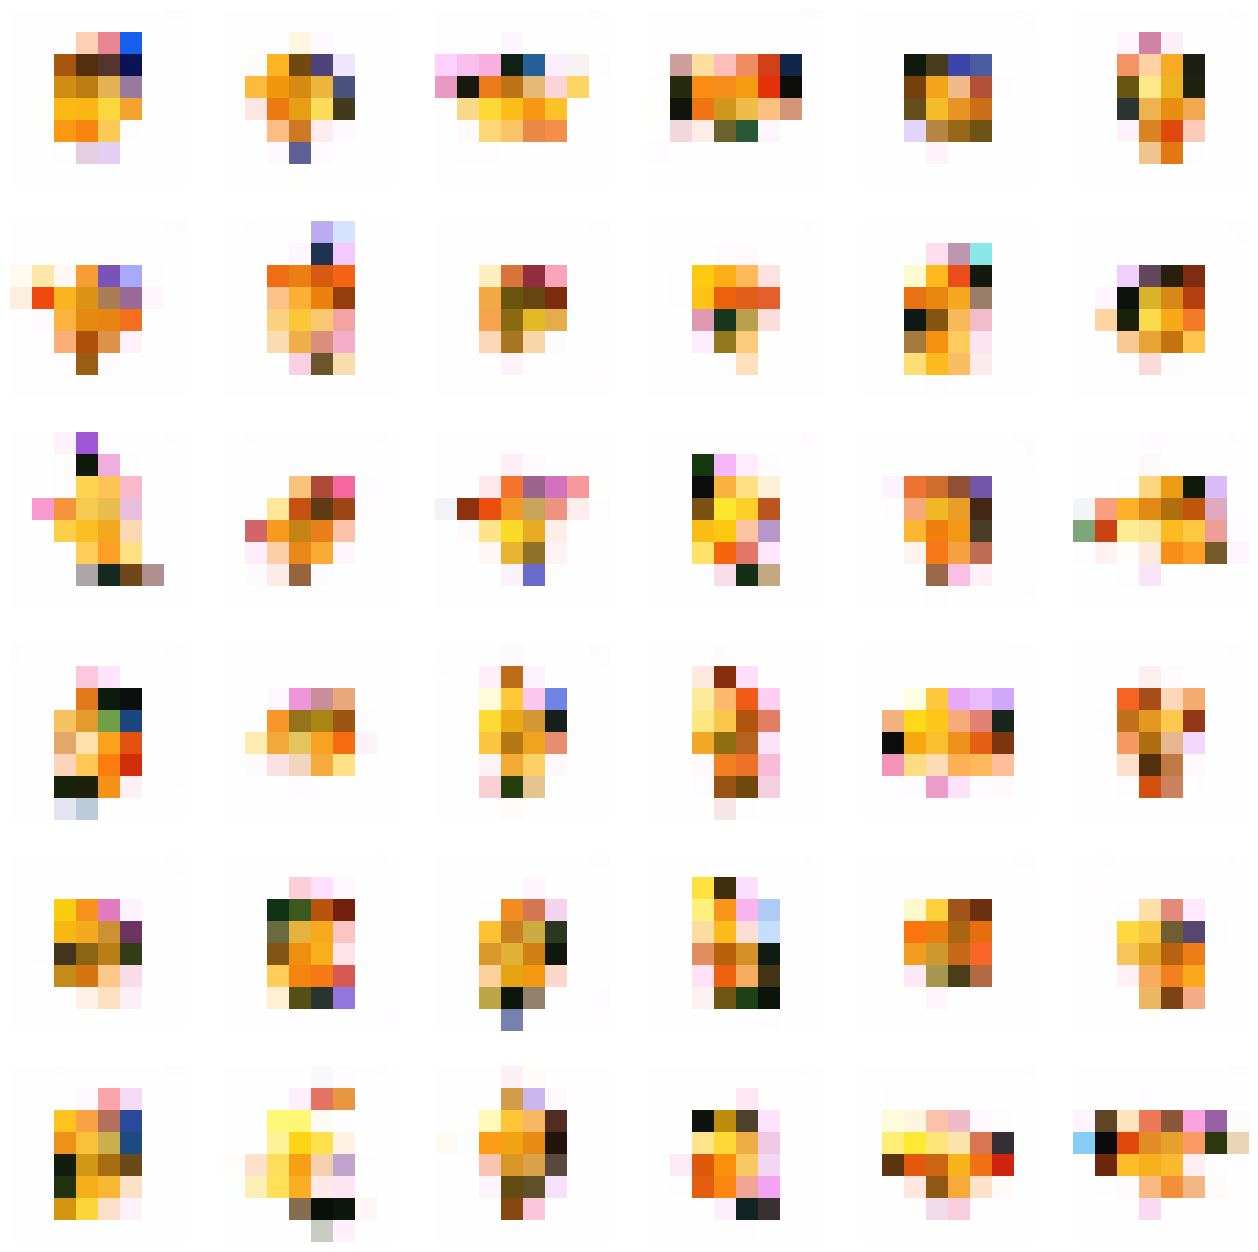

25/25 [==============================] - 135s 5s/step - d_loss: -5.0361 - g_loss: 5.9307
Epoch 4/50
25/25 [==============================] - ETA: 0s - d_loss: -7.3895 - g_loss: 5.7757

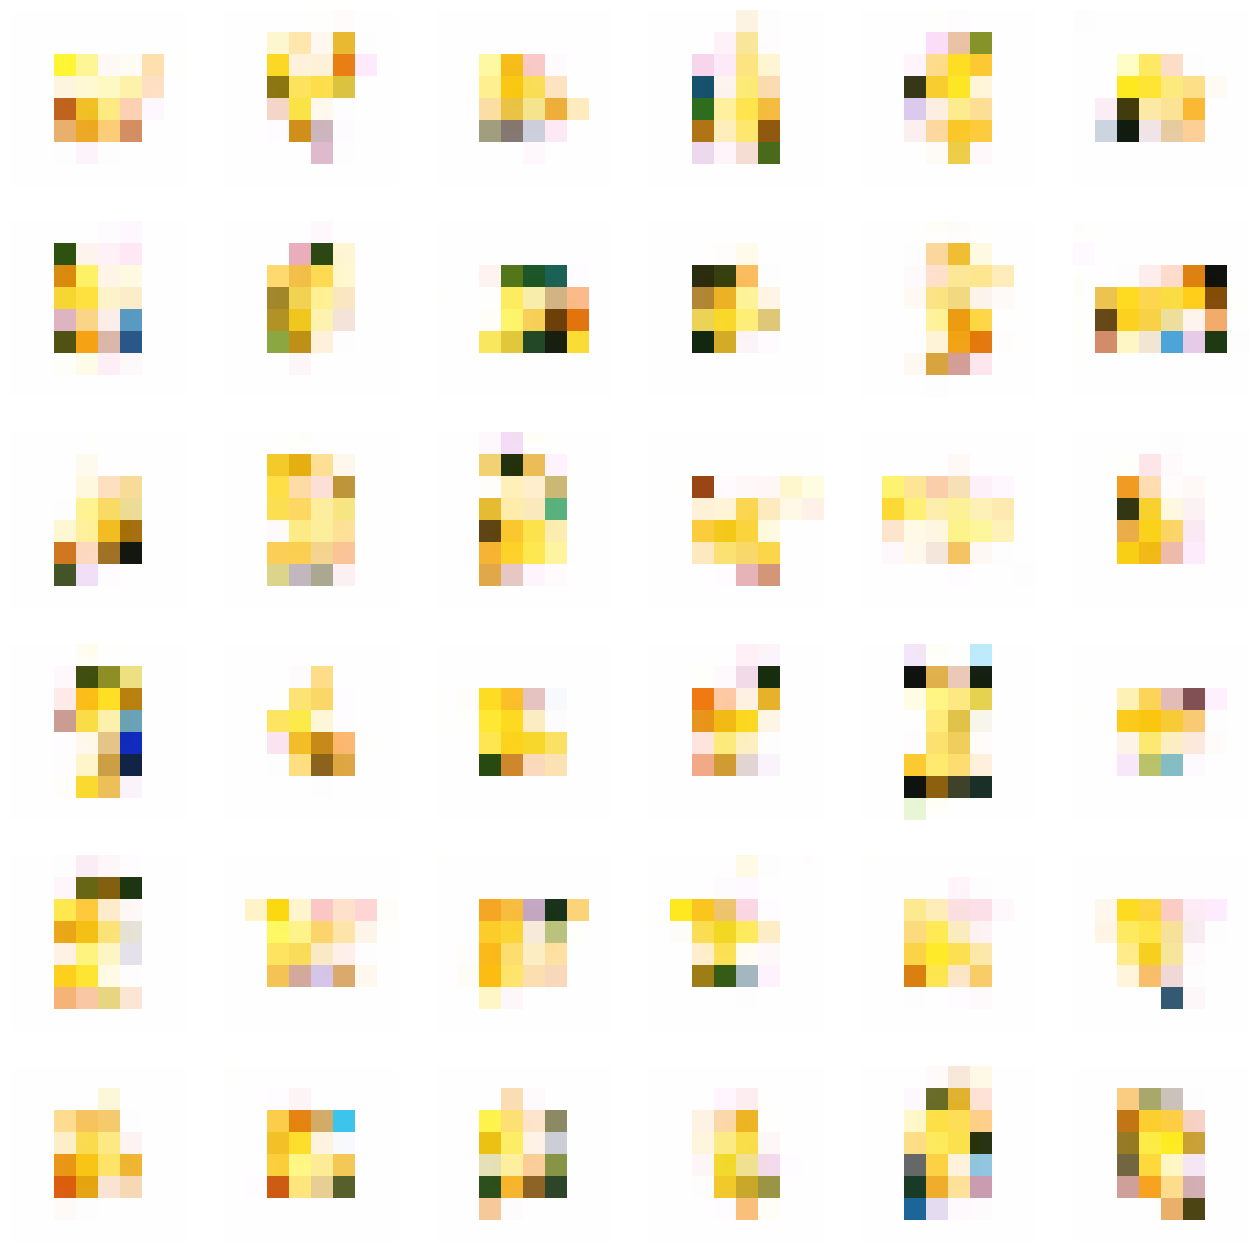

25/25 [==============================] - 134s 5s/step - d_loss: -7.4099 - g_loss: 5.4941
Epoch 5/50
25/25 [==============================] - ETA: 0s - d_loss: -7.3970 - g_loss: 8.5449

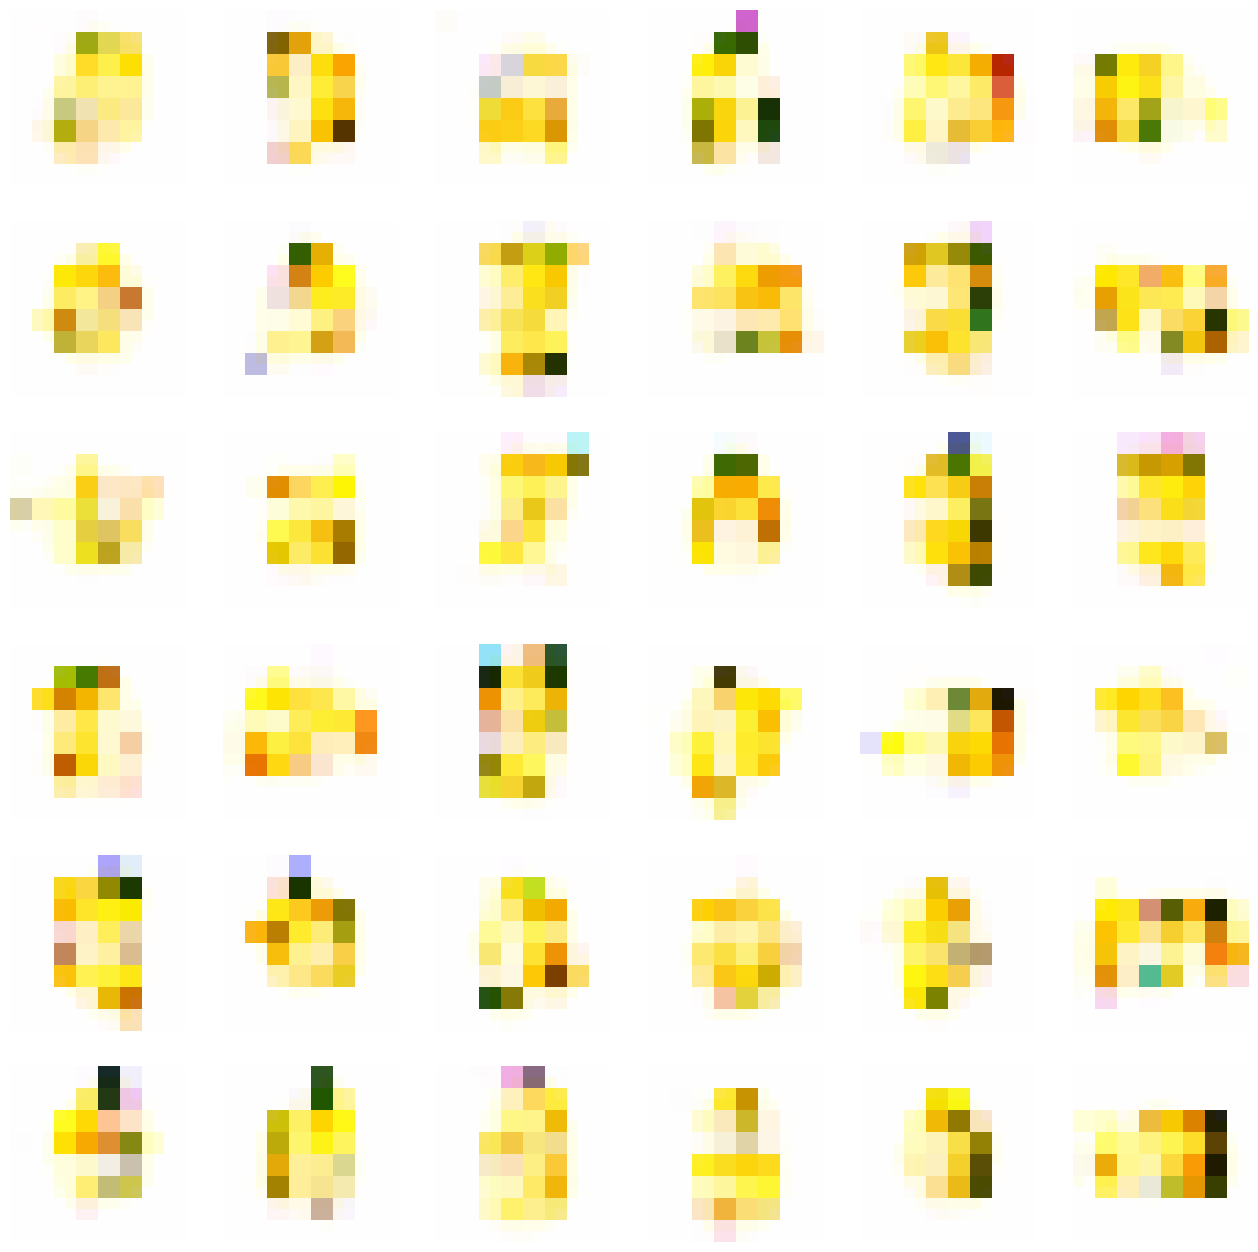

25/25 [==============================] - 134s 5s/step - d_loss: -7.4706 - g_loss: 8.1249
Epoch 6/50
25/25 [==============================] - ETA: 0s - d_loss: -7.7565 - g_loss: 9.9715

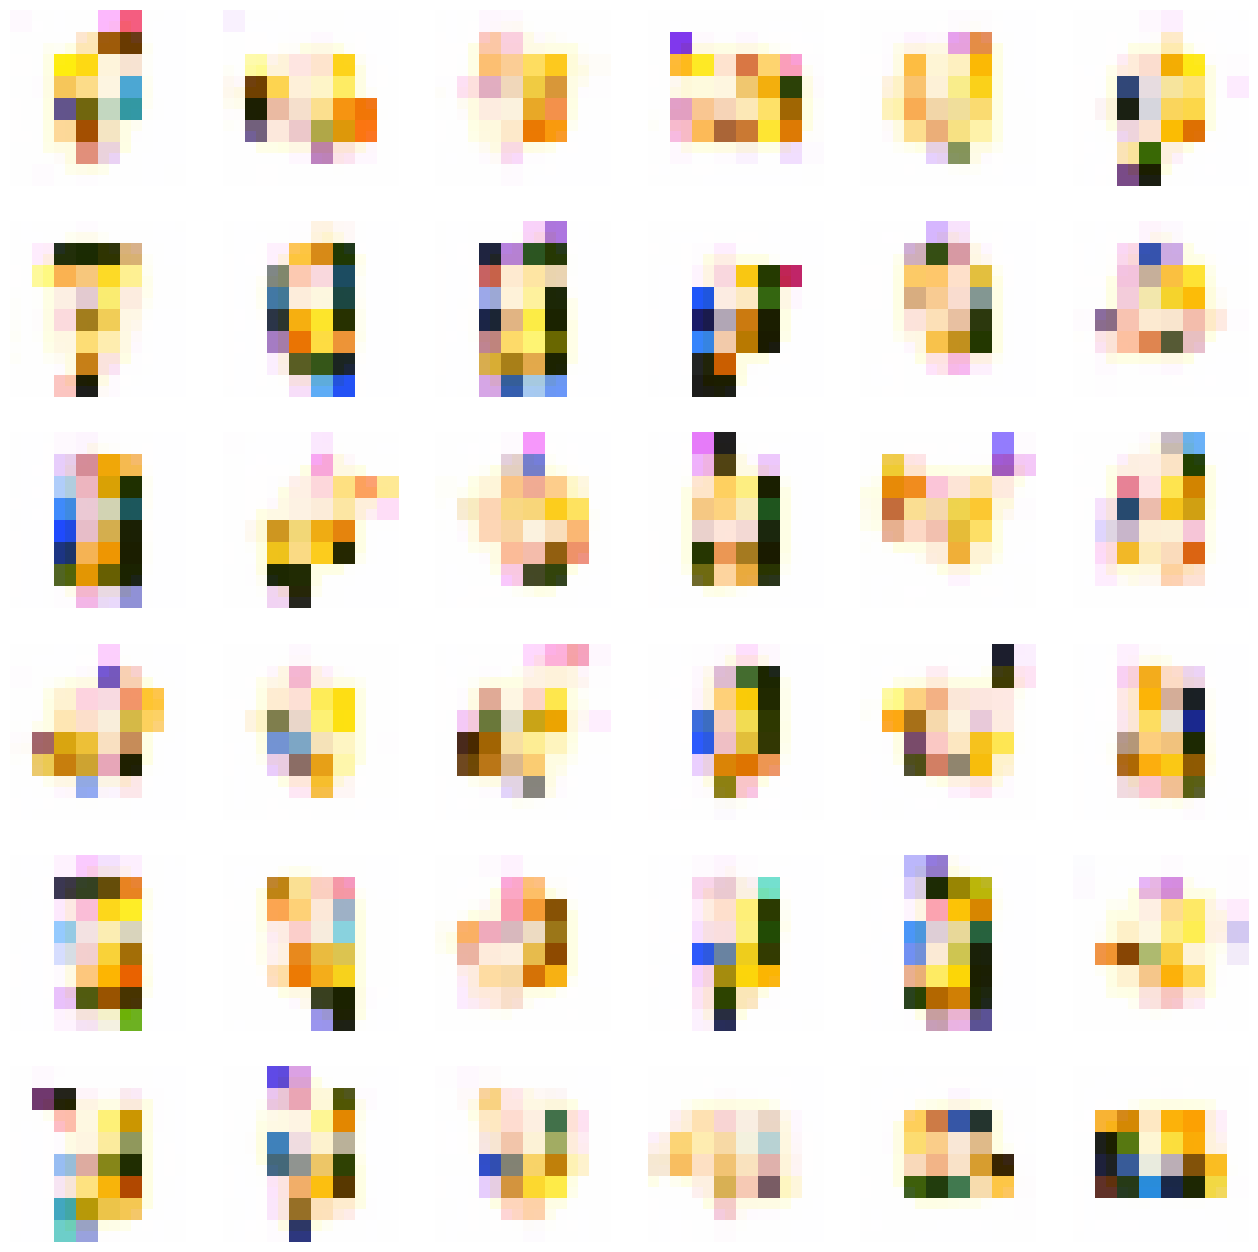

25/25 [==============================] - 135s 5s/step - d_loss: -7.7845 - g_loss: 10.4375
Epoch 7/50
25/25 [==============================] - ETA: 0s - d_loss: -7.3155 - g_loss: 8.3857

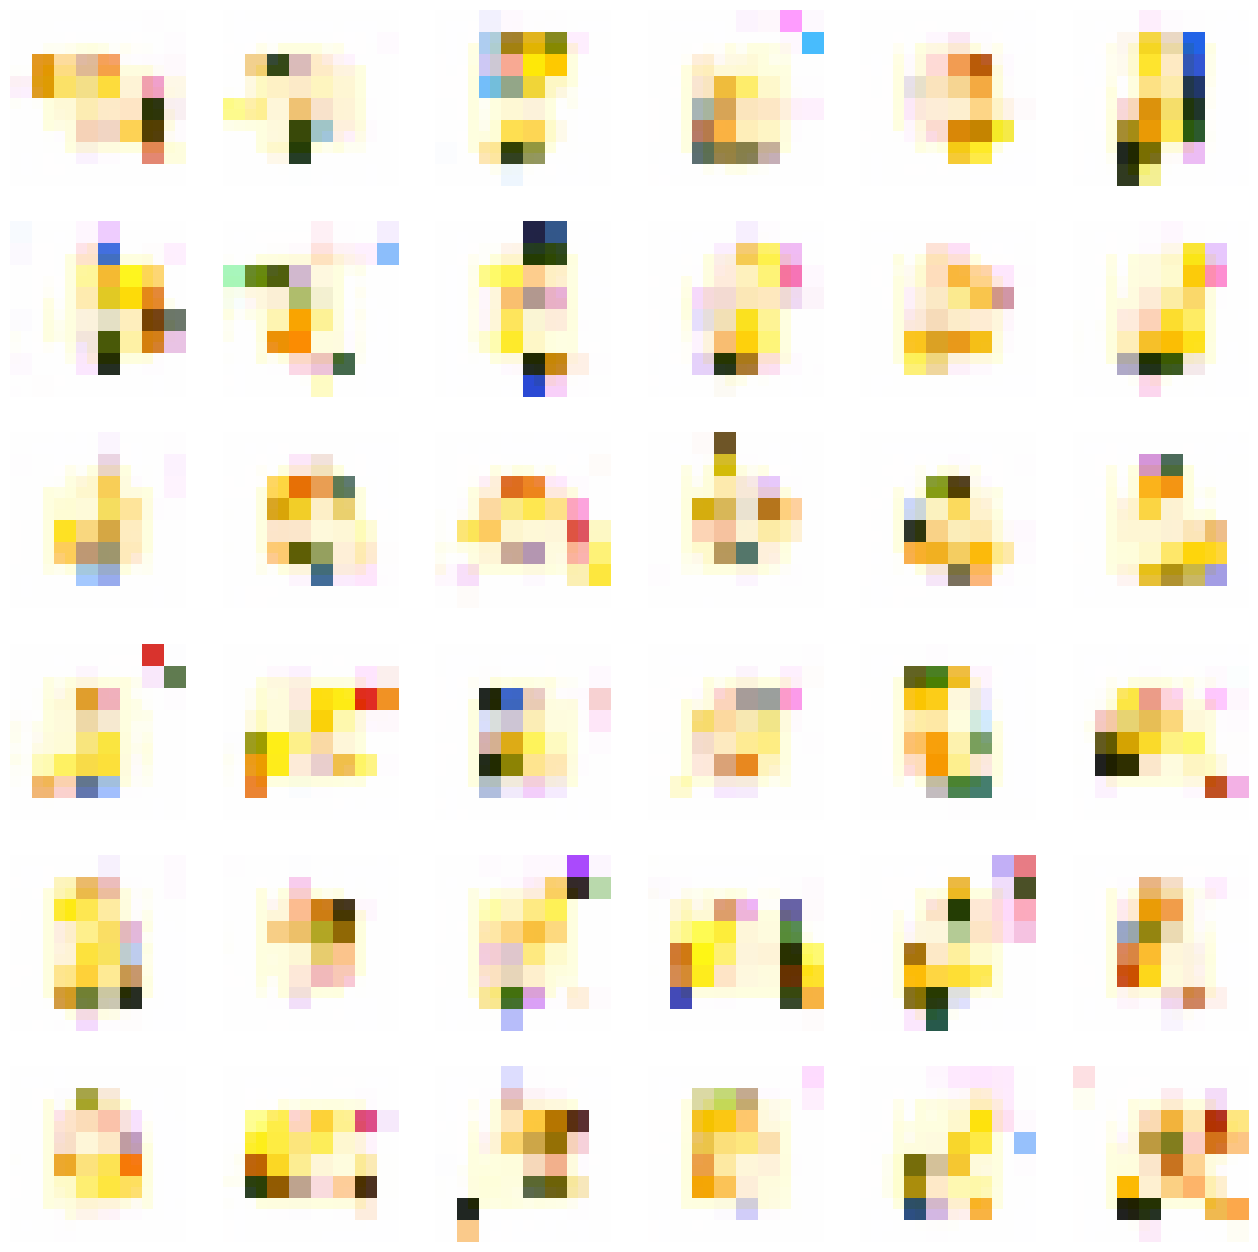

25/25 [==============================] - 128s 5s/step - d_loss: -7.3261 - g_loss: 8.8206
Epoch 8/50
25/25 [==============================] - ETA: 0s - d_loss: -7.6199 - g_loss: 9.4810

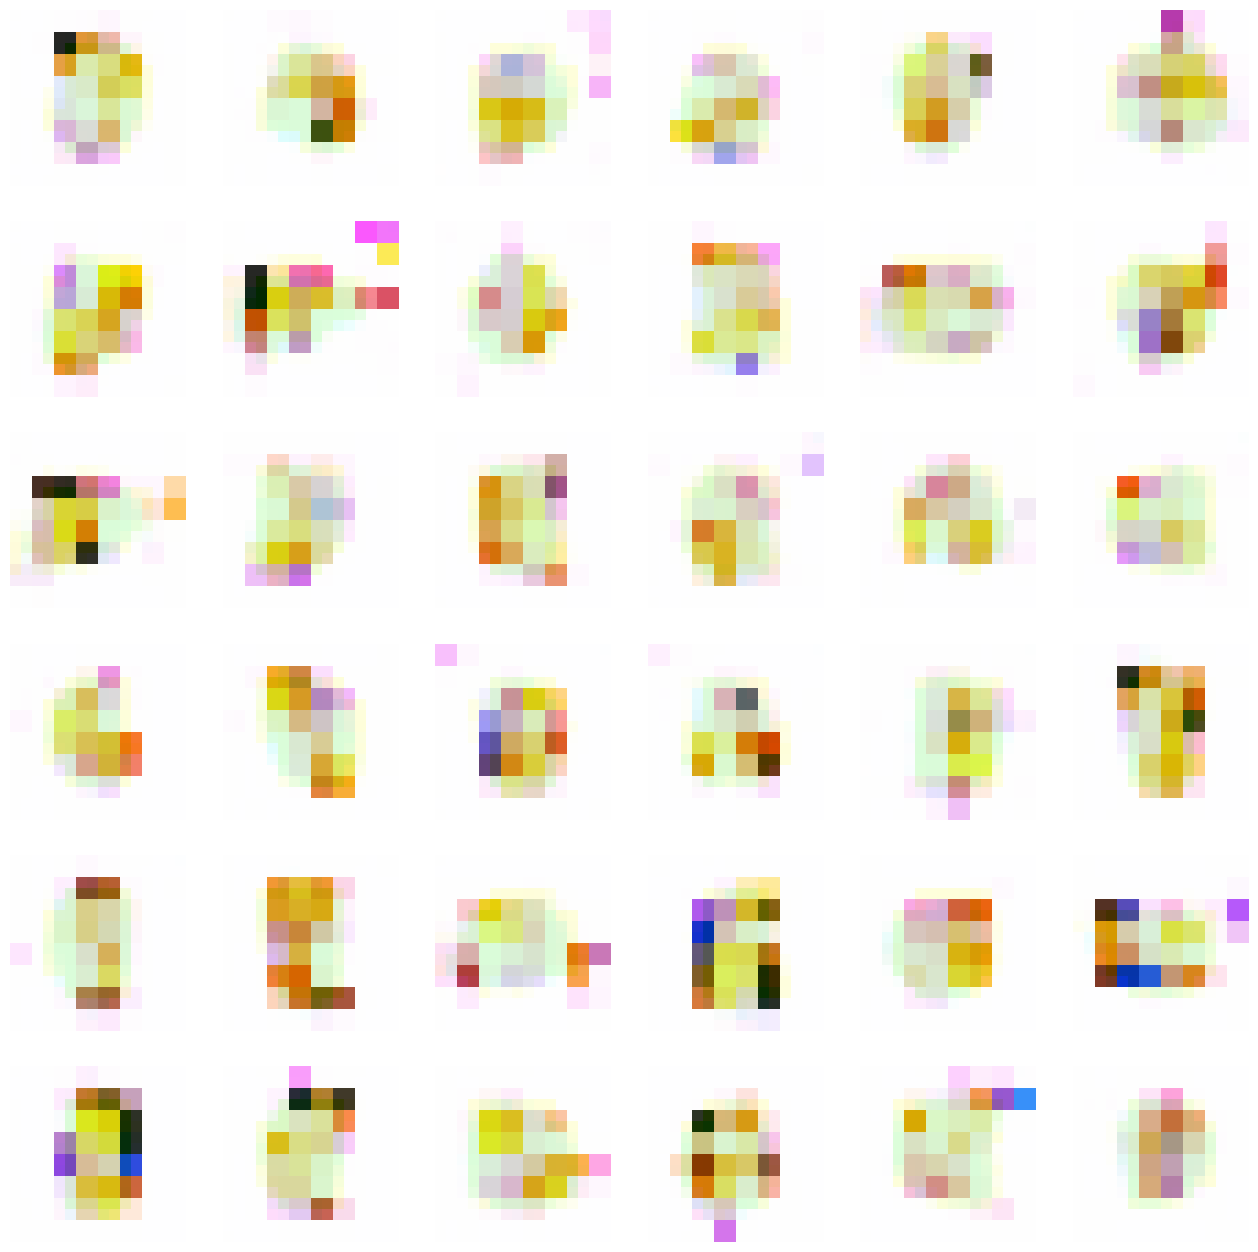

25/25 [==============================] - 129s 5s/step - d_loss: -7.7940 - g_loss: 9.9690
Epoch 9/50
25/25 [==============================] - ETA: 0s - d_loss: -7.9273 - g_loss: 10.5473

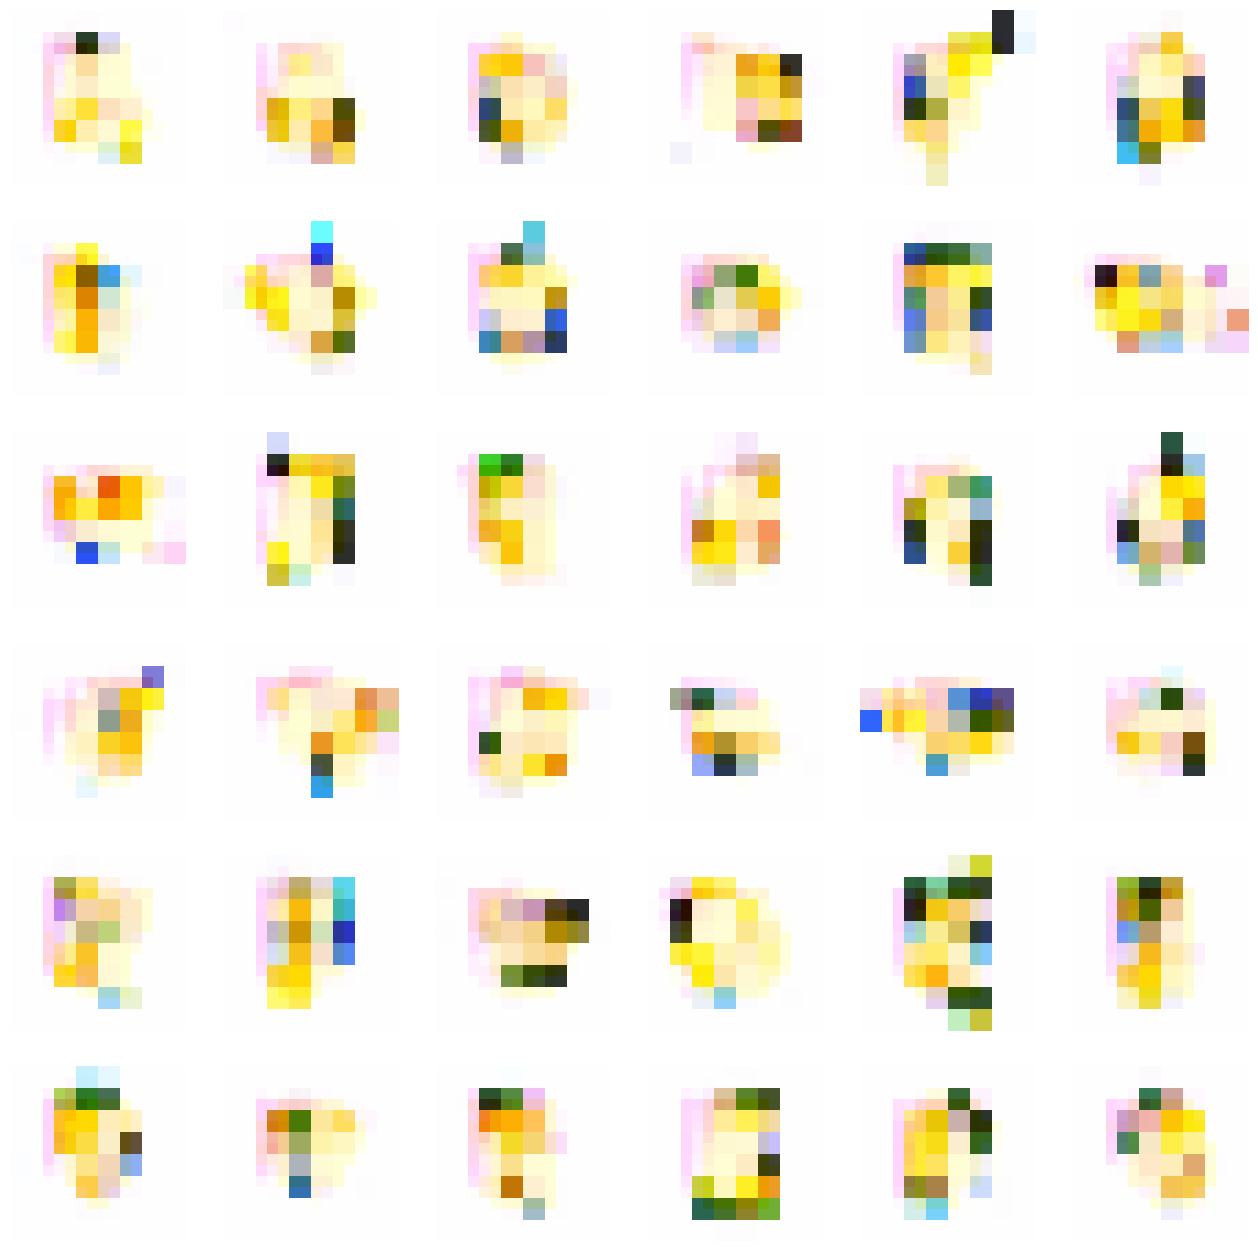

25/25 [==============================] - 128s 5s/step - d_loss: -7.9003 - g_loss: 10.6347
Epoch 10/50
25/25 [==============================] - ETA: 0s - d_loss: -7.5073 - g_loss: 10.4428

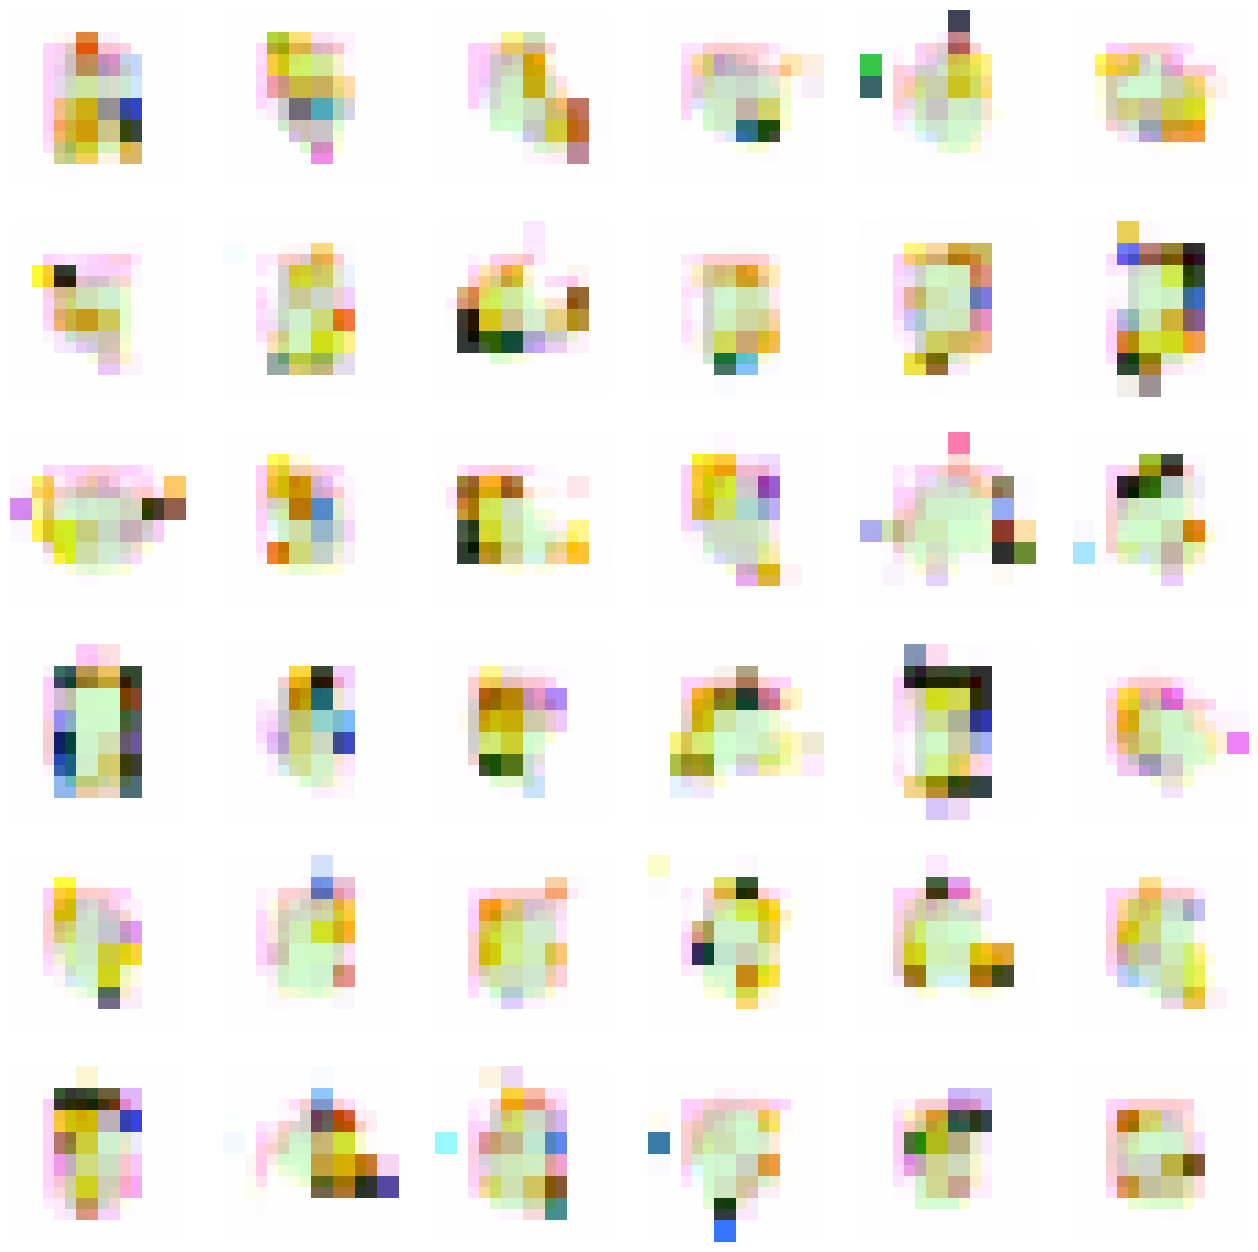

25/25 [==============================] - 126s 5s/step - d_loss: -7.5099 - g_loss: 10.5769
Epoch 11/50
25/25 [==============================] - ETA: 0s - d_loss: -8.1715 - g_loss: 11.2256

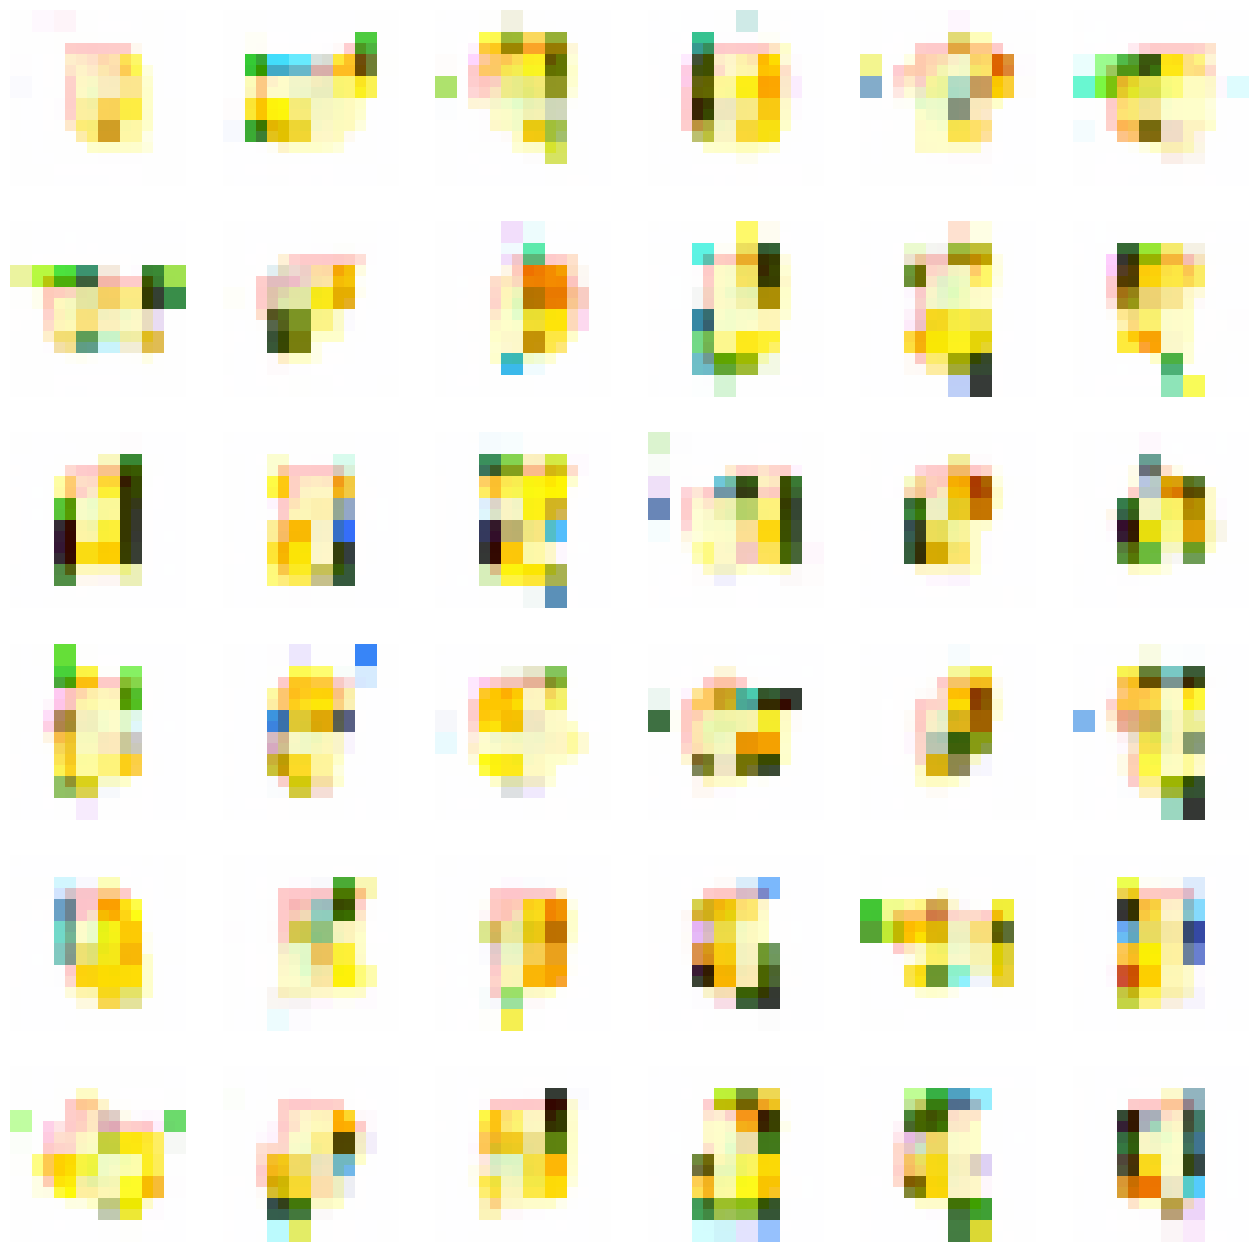

25/25 [==============================] - 134s 5s/step - d_loss: -8.2116 - g_loss: 11.5913
Epoch 12/50
25/25 [==============================] - ETA: 0s - d_loss: -7.8962 - g_loss: 9.9882 

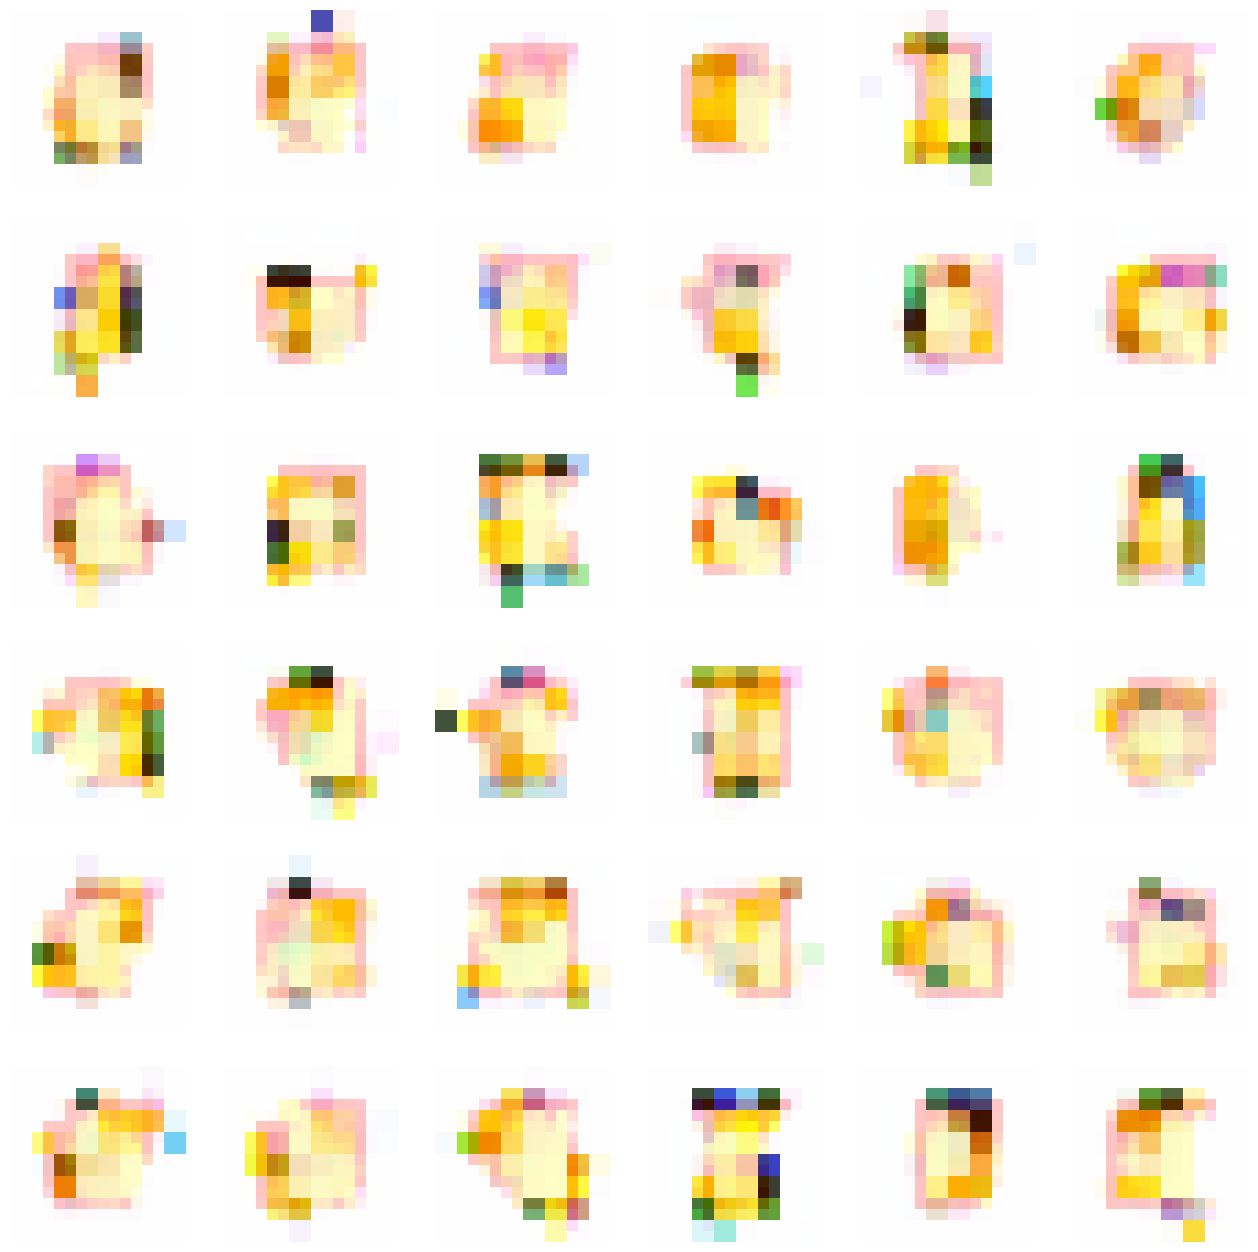

25/25 [==============================] - 135s 5s/step - d_loss: -7.9421 - g_loss: 9.7757
Epoch 13/50
25/25 [==============================] - ETA: 0s - d_loss: -7.5105 - g_loss: 9.9385 

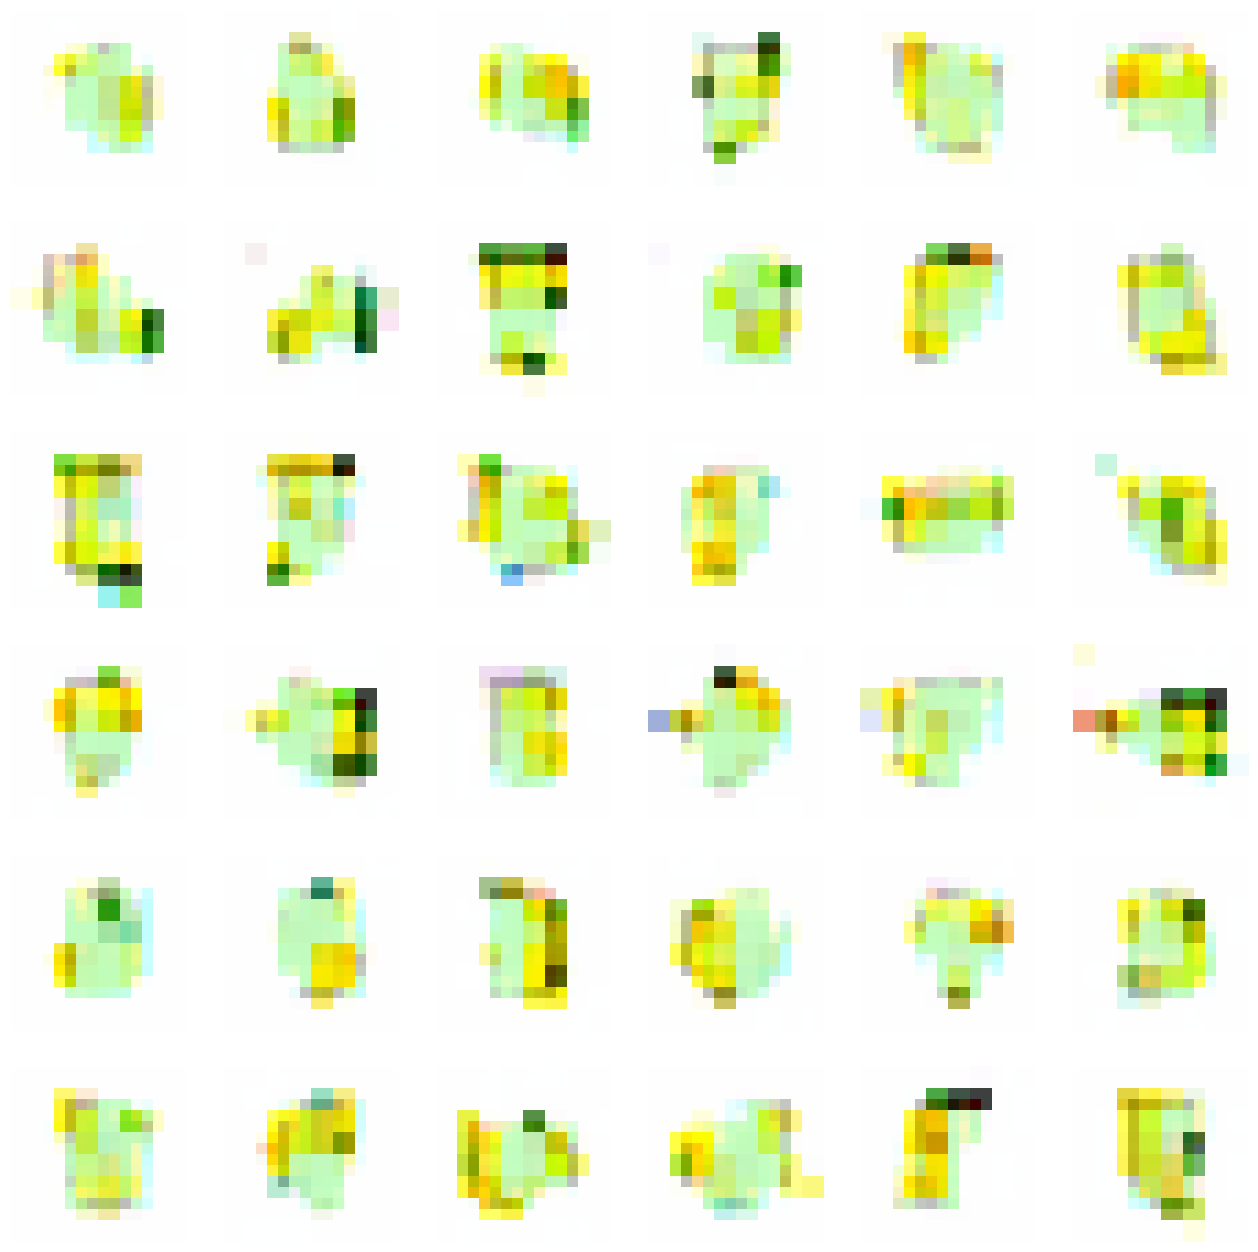

25/25 [==============================] - 130s 5s/step - d_loss: -7.4720 - g_loss: 9.3991
Epoch 14/50
25/25 [==============================] - ETA: 0s - d_loss: -7.9094 - g_loss: 10.8368

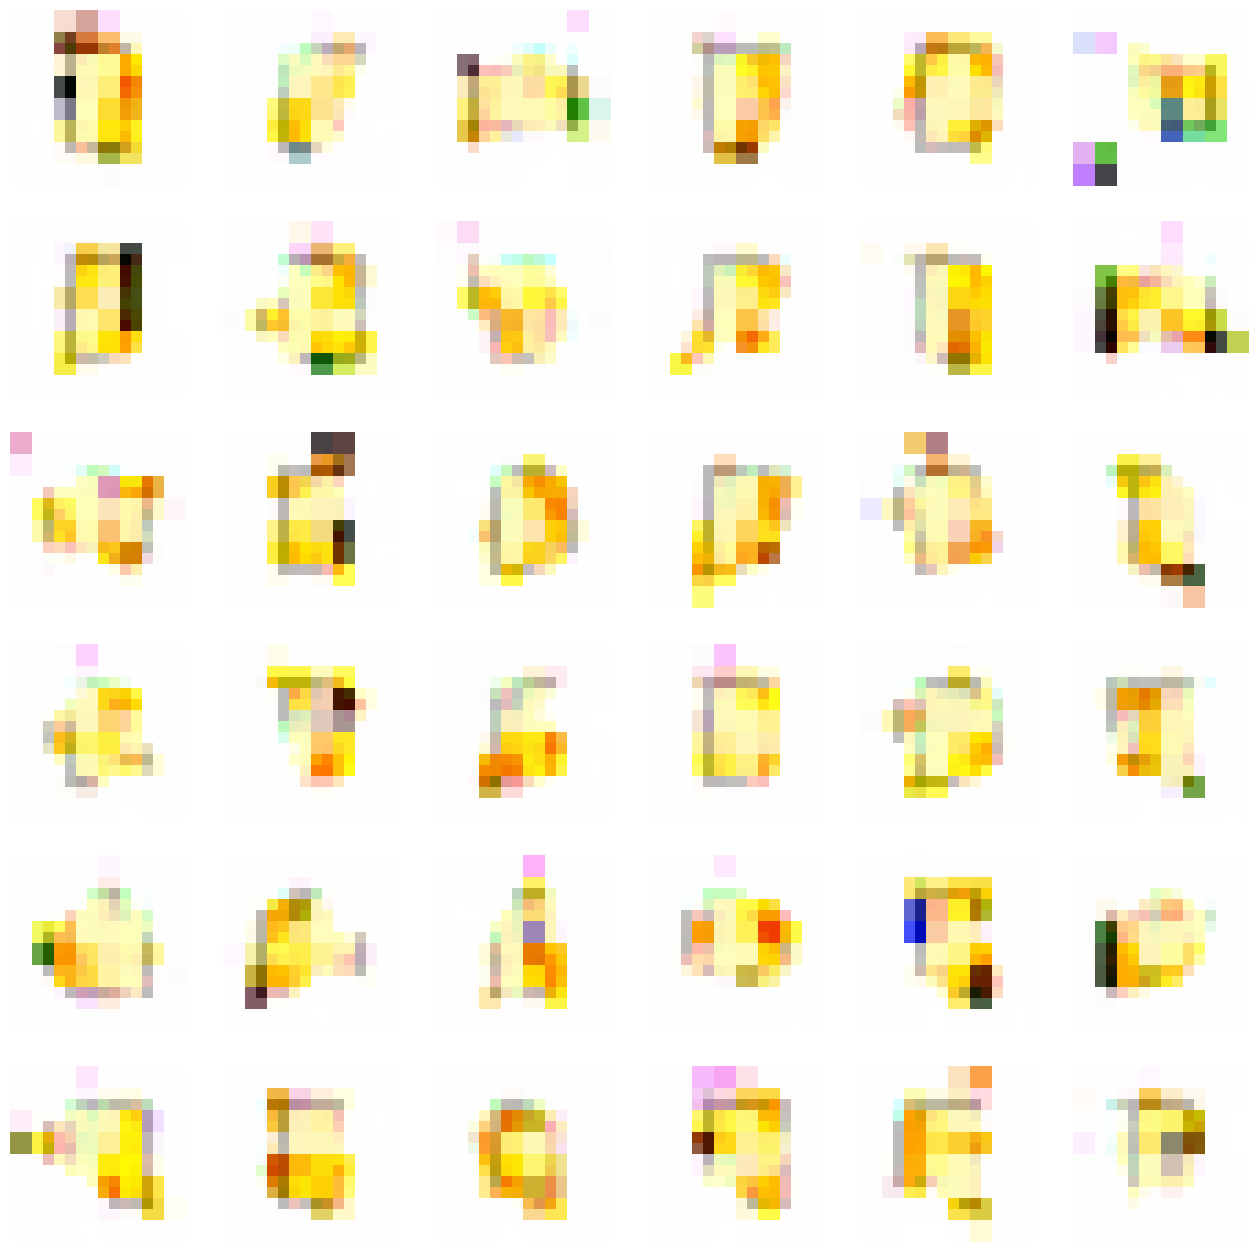

25/25 [==============================] - 130s 5s/step - d_loss: -7.8584 - g_loss: 10.0775
Epoch 15/50
25/25 [==============================] - ETA: 0s - d_loss: -7.5998 - g_loss: 9.8396

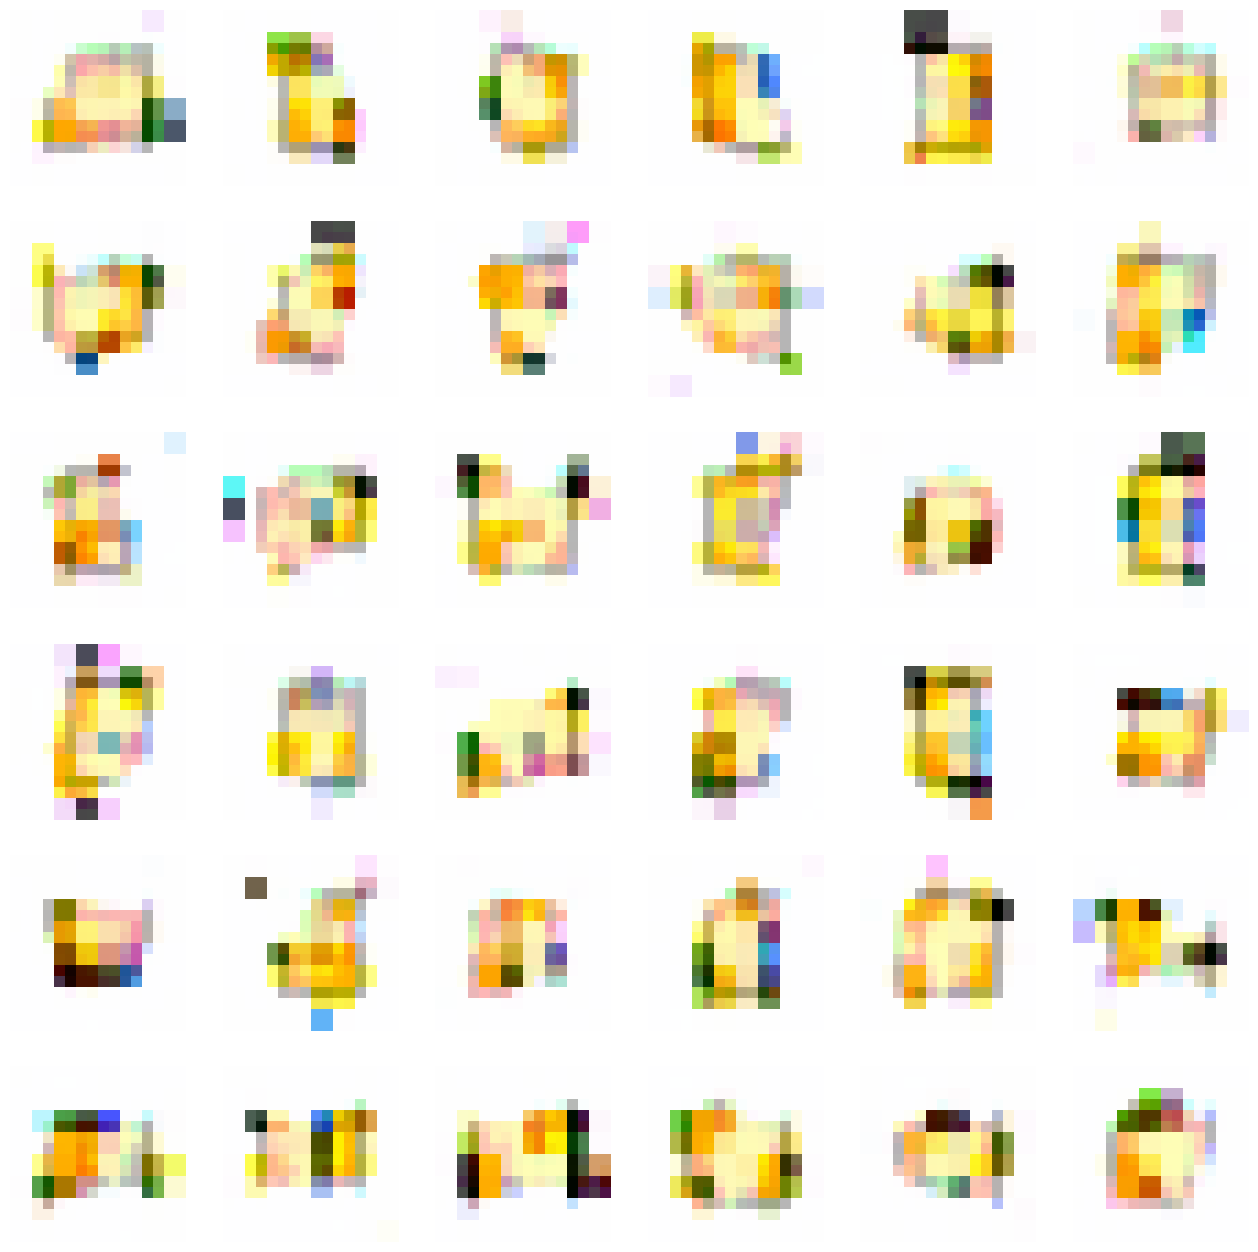

25/25 [==============================] - 128s 5s/step - d_loss: -7.6385 - g_loss: 9.6945
Epoch 16/50
25/25 [==============================] - ETA: 0s - d_loss: -7.8581 - g_loss: 9.7215

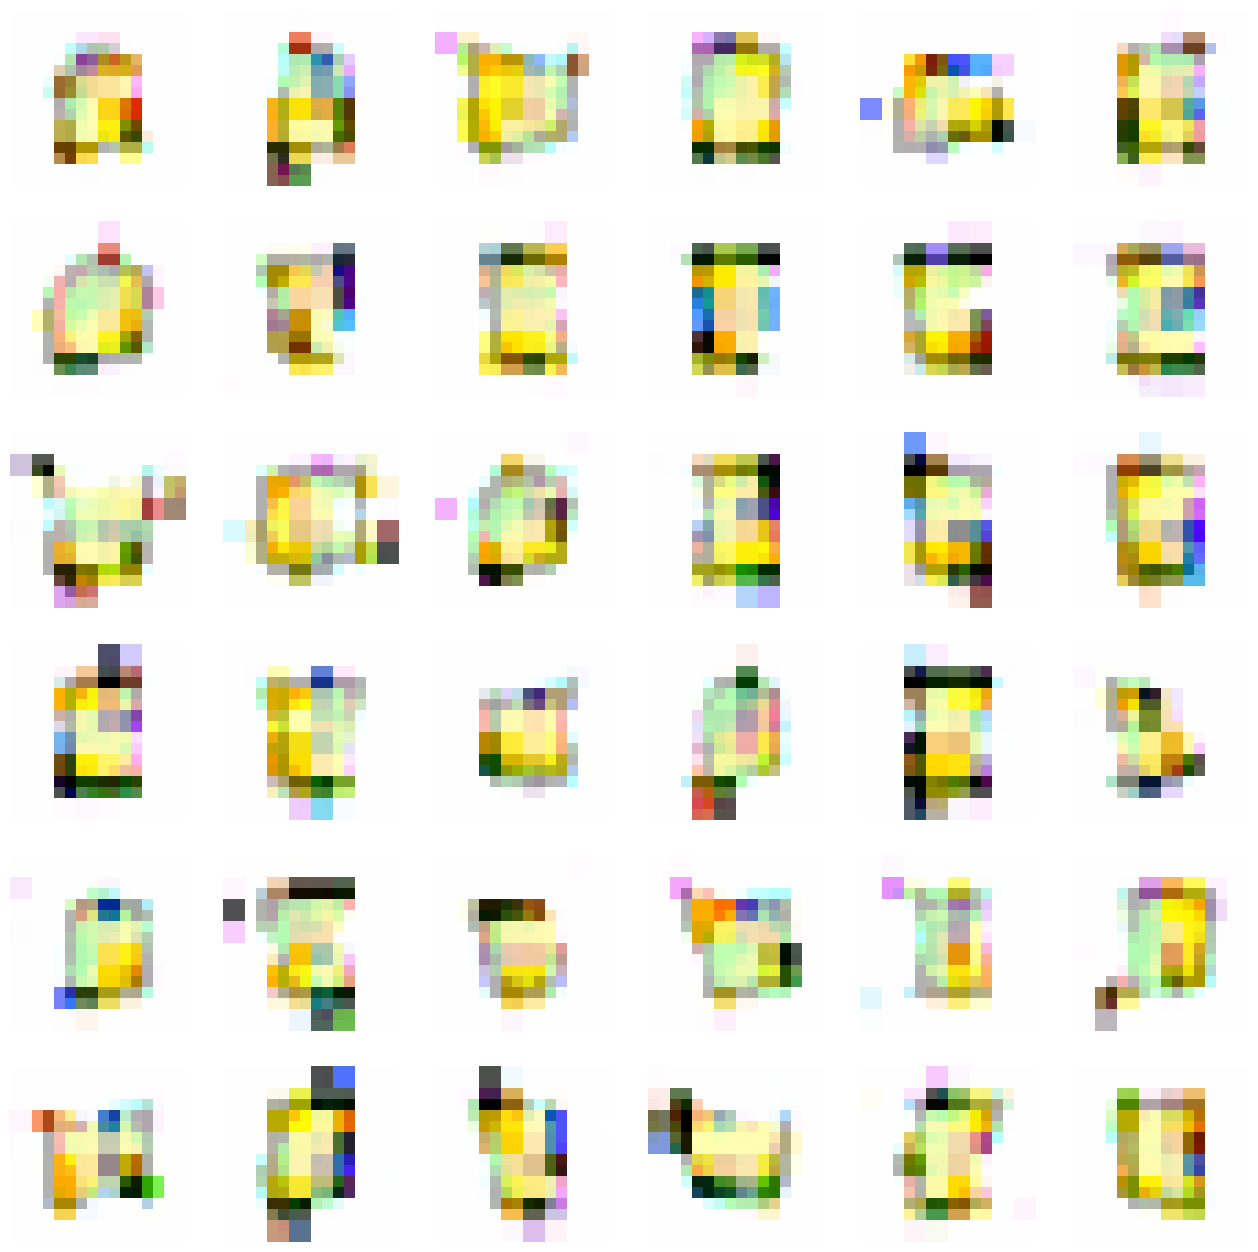

25/25 [==============================] - 125s 5s/step - d_loss: -7.8631 - g_loss: 9.8804
Epoch 17/50
25/25 [==============================] - ETA: 0s - d_loss: -7.2583 - g_loss: 9.3811

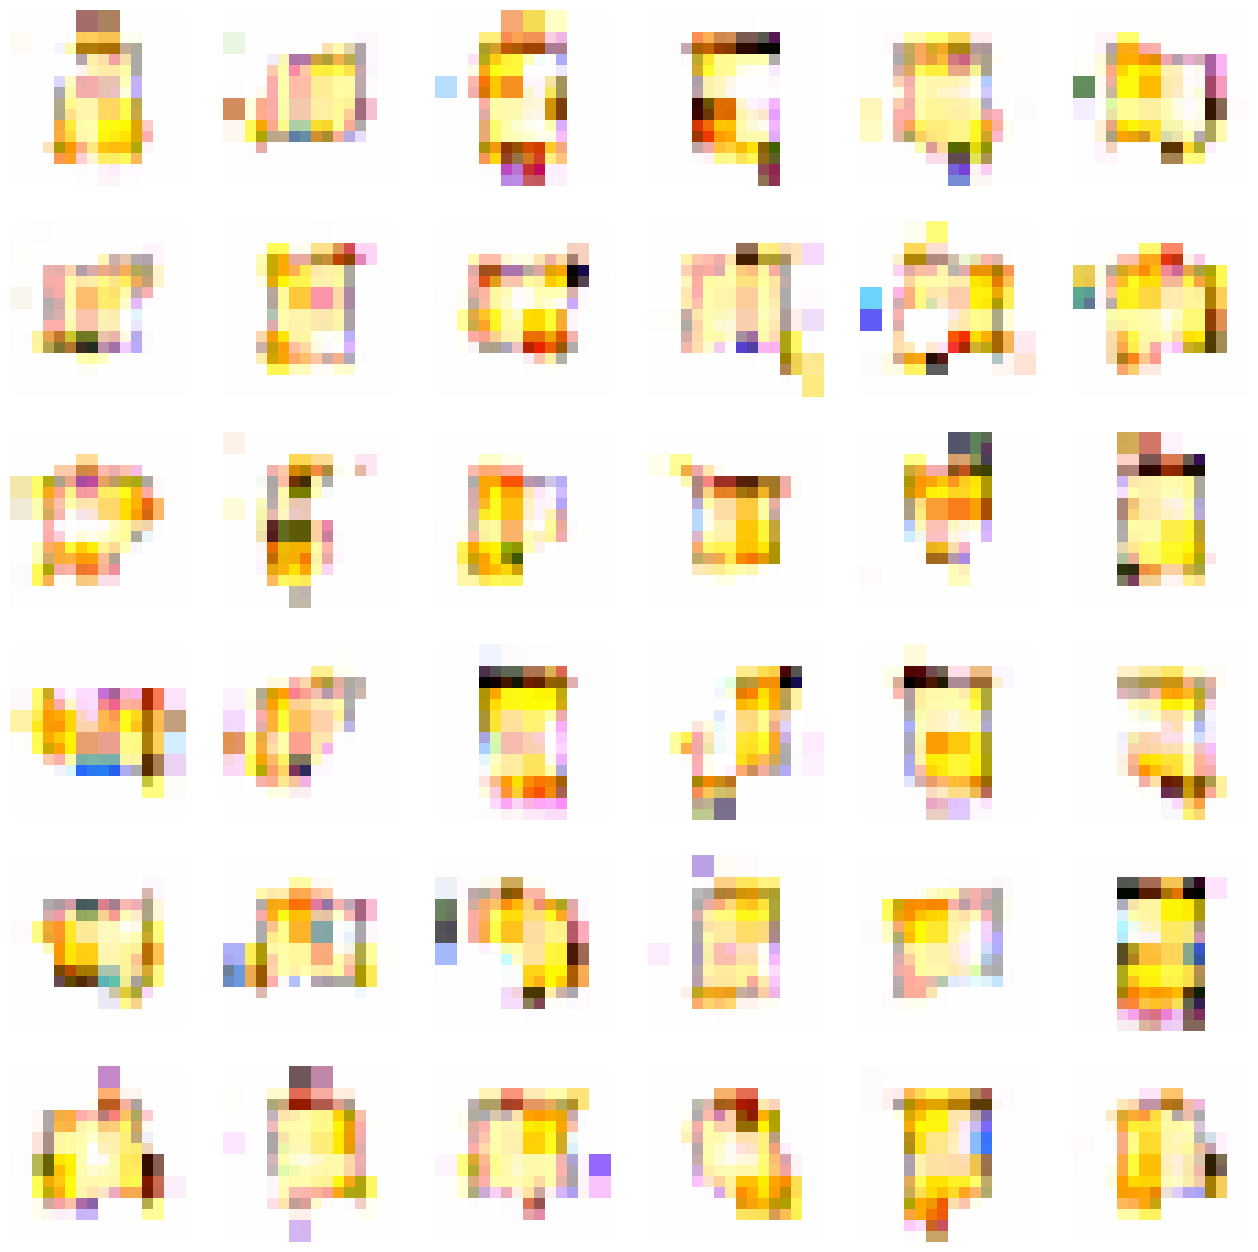

25/25 [==============================] - 127s 5s/step - d_loss: -7.2642 - g_loss: 10.0751
Epoch 18/50
25/25 [==============================] - ETA: 0s - d_loss: -6.9802 - g_loss: 8.0724

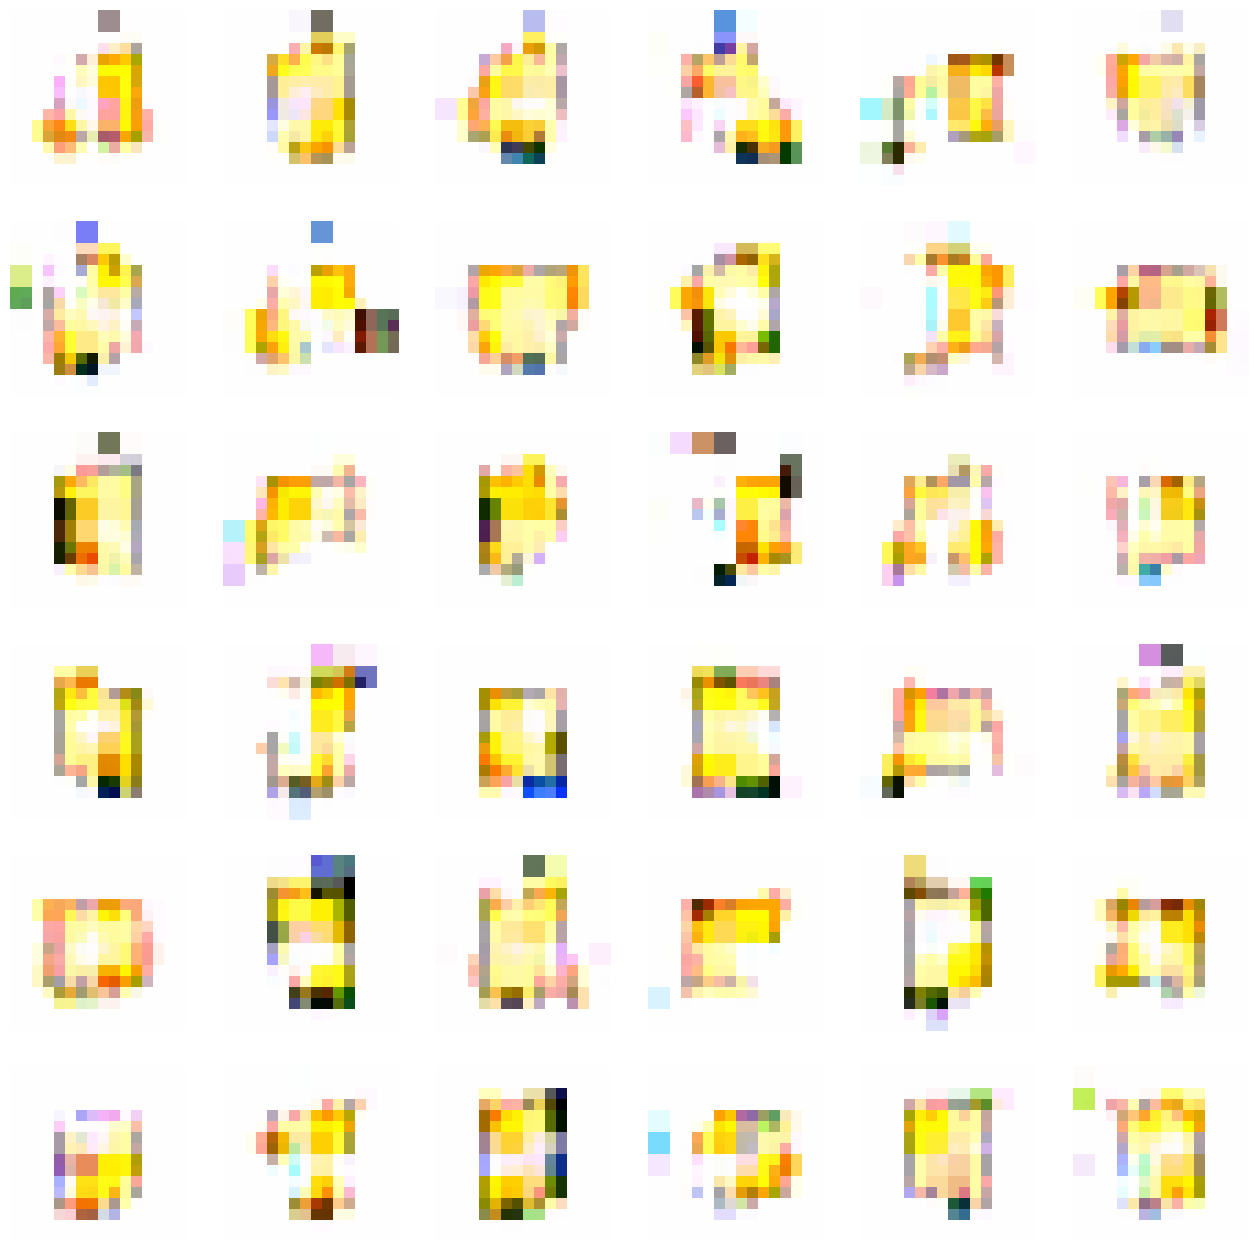

25/25 [==============================] - 125s 5s/step - d_loss: -6.9761 - g_loss: 8.2402
Epoch 19/50
25/25 [==============================] - ETA: 0s - d_loss: -6.6135 - g_loss: 9.1527

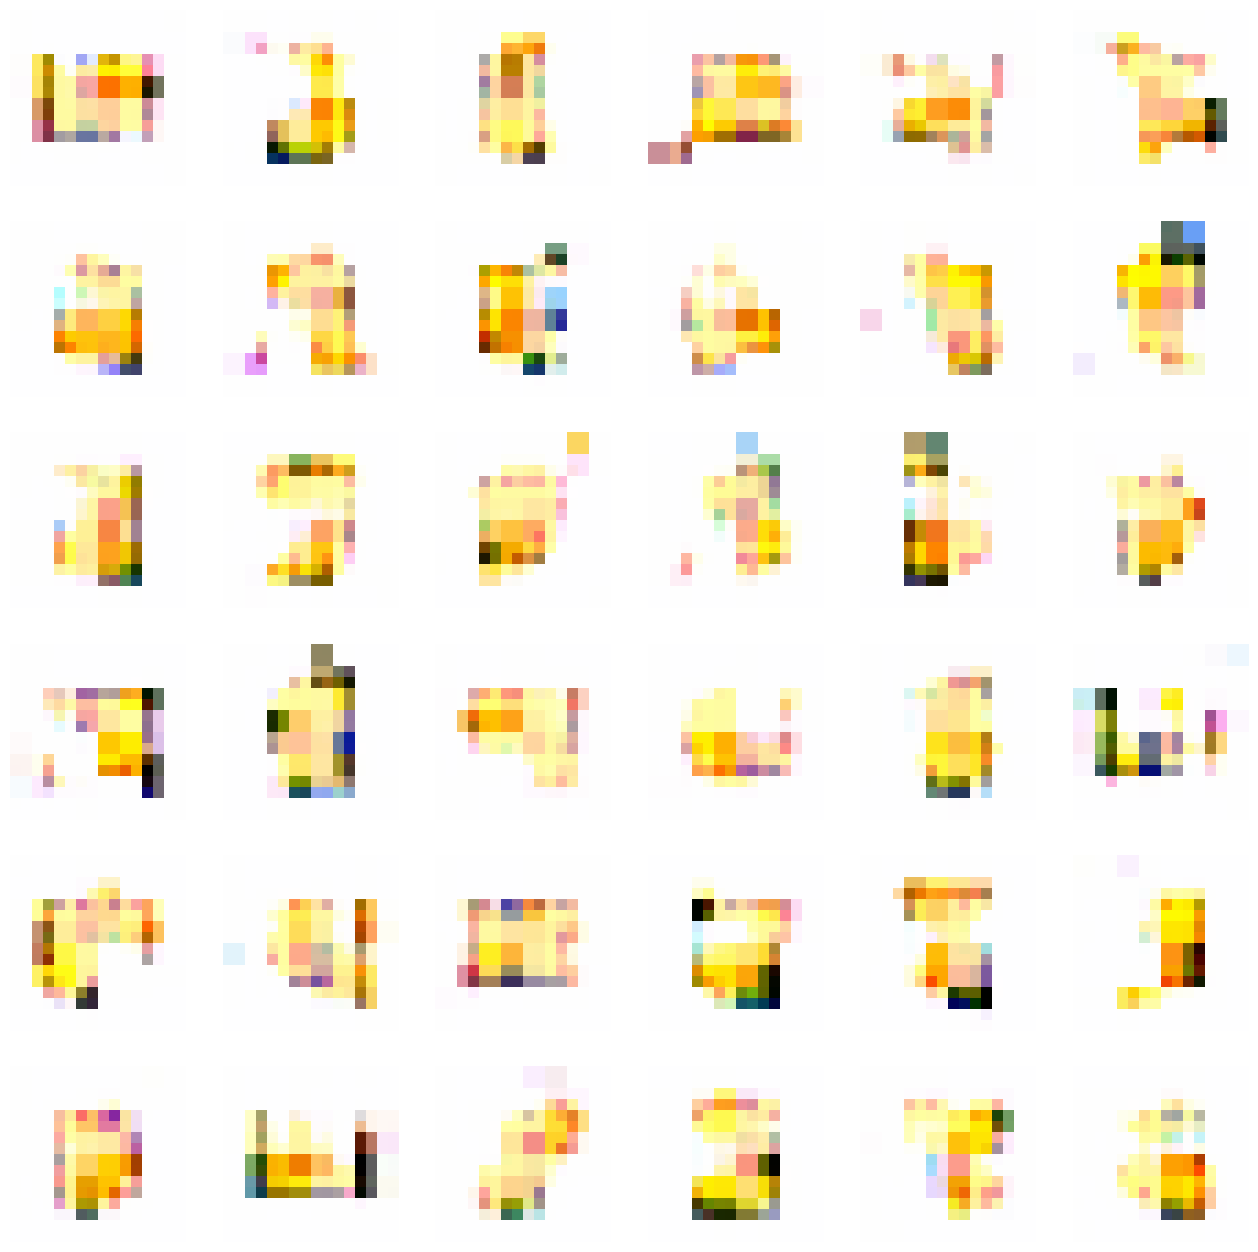

25/25 [==============================] - 125s 5s/step - d_loss: -6.5525 - g_loss: 8.7901
Epoch 20/50
25/25 [==============================] - ETA: 0s - d_loss: -6.7885 - g_loss: 9.1750

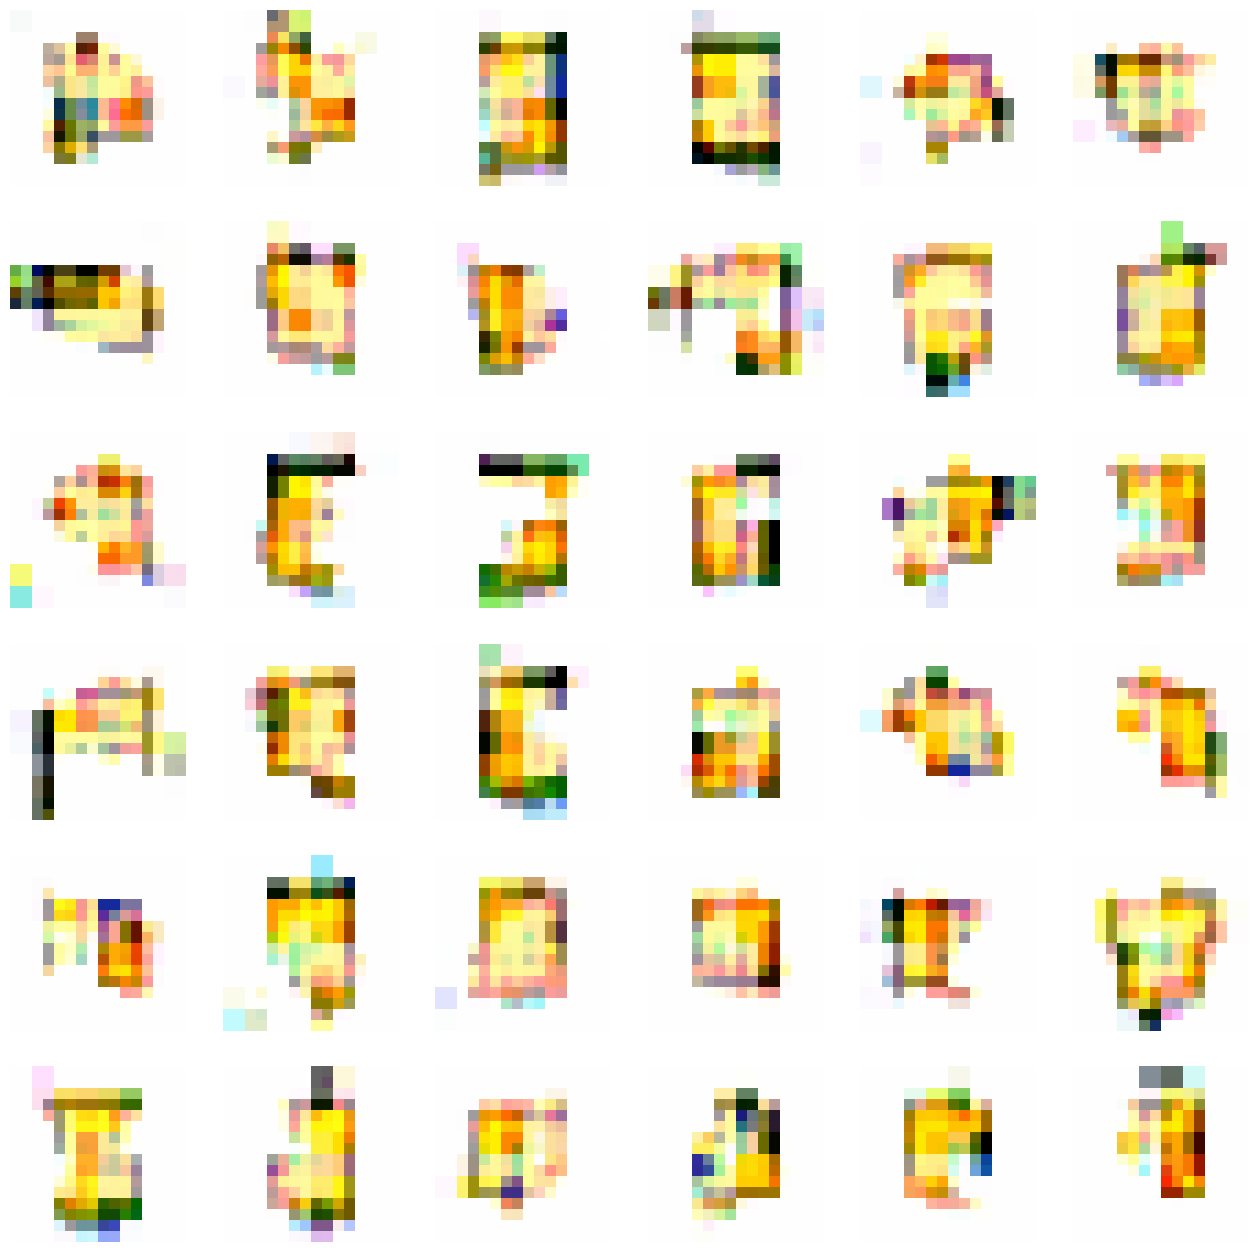

25/25 [==============================] - 124s 5s/step - d_loss: -6.7546 - g_loss: 10.0804
Epoch 21/50
25/25 [==============================] - ETA: 0s - d_loss: -7.1185 - g_loss: 7.4402

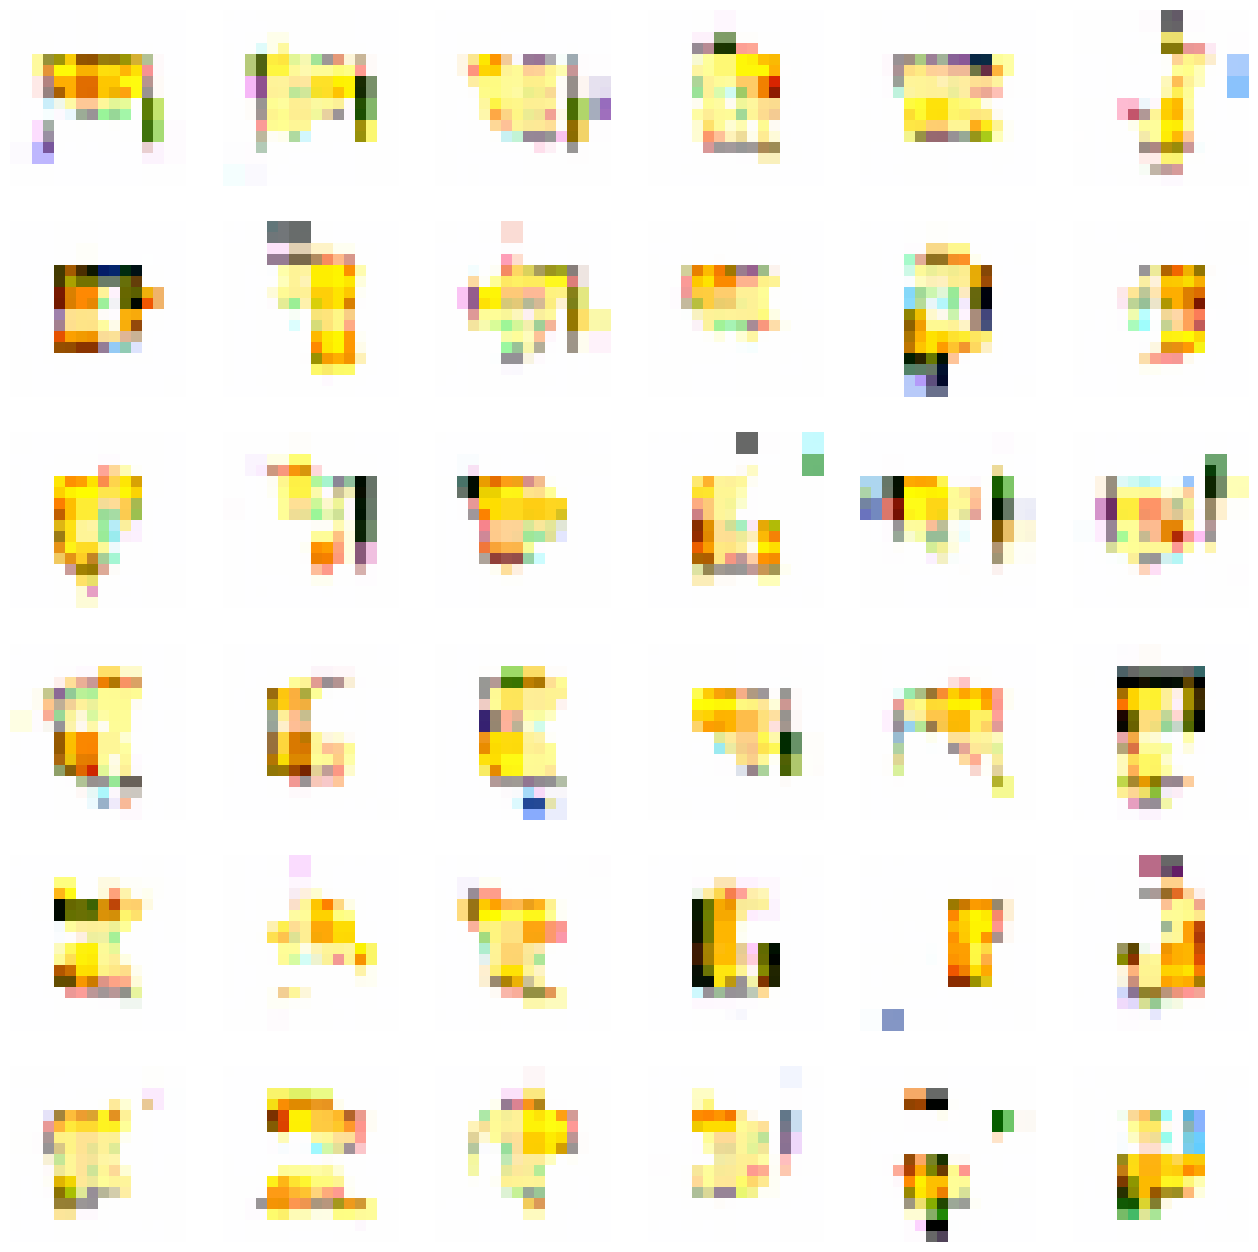

25/25 [==============================] - 126s 5s/step - d_loss: -7.0666 - g_loss: 7.3434
Epoch 22/50
25/25 [==============================] - ETA: 0s - d_loss: -7.0568 - g_loss: 8.0084

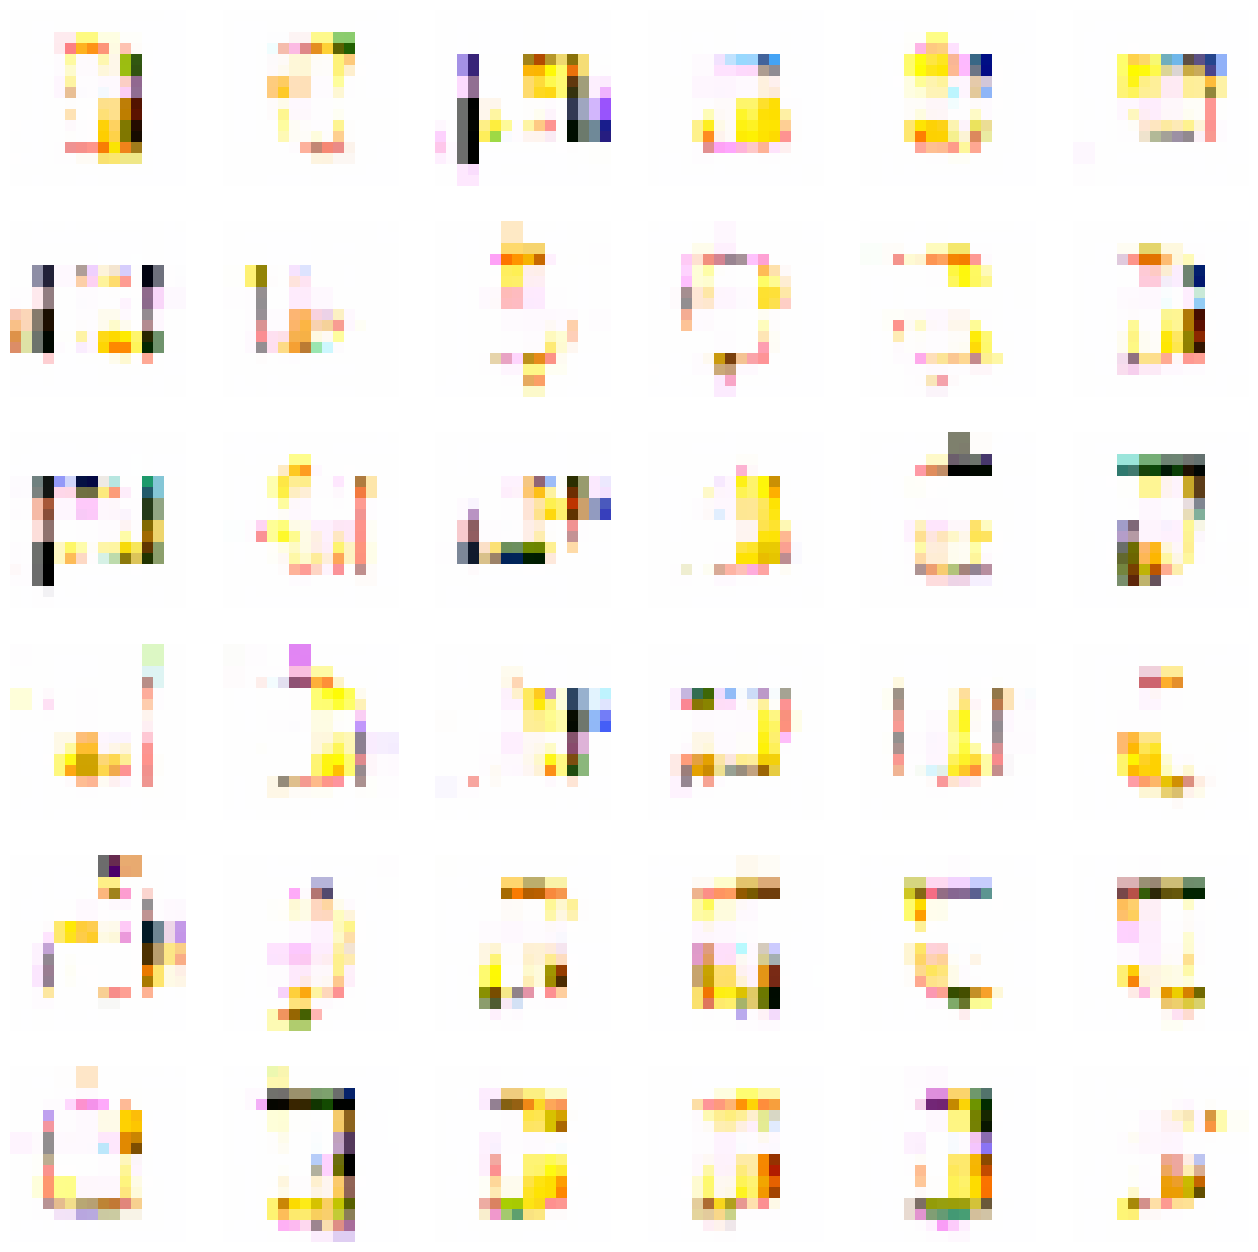

25/25 [==============================] - 126s 5s/step - d_loss: -7.0337 - g_loss: 7.1180
Epoch 23/50
25/25 [==============================] - ETA: 0s - d_loss: -6.9421 - g_loss: 8.7980

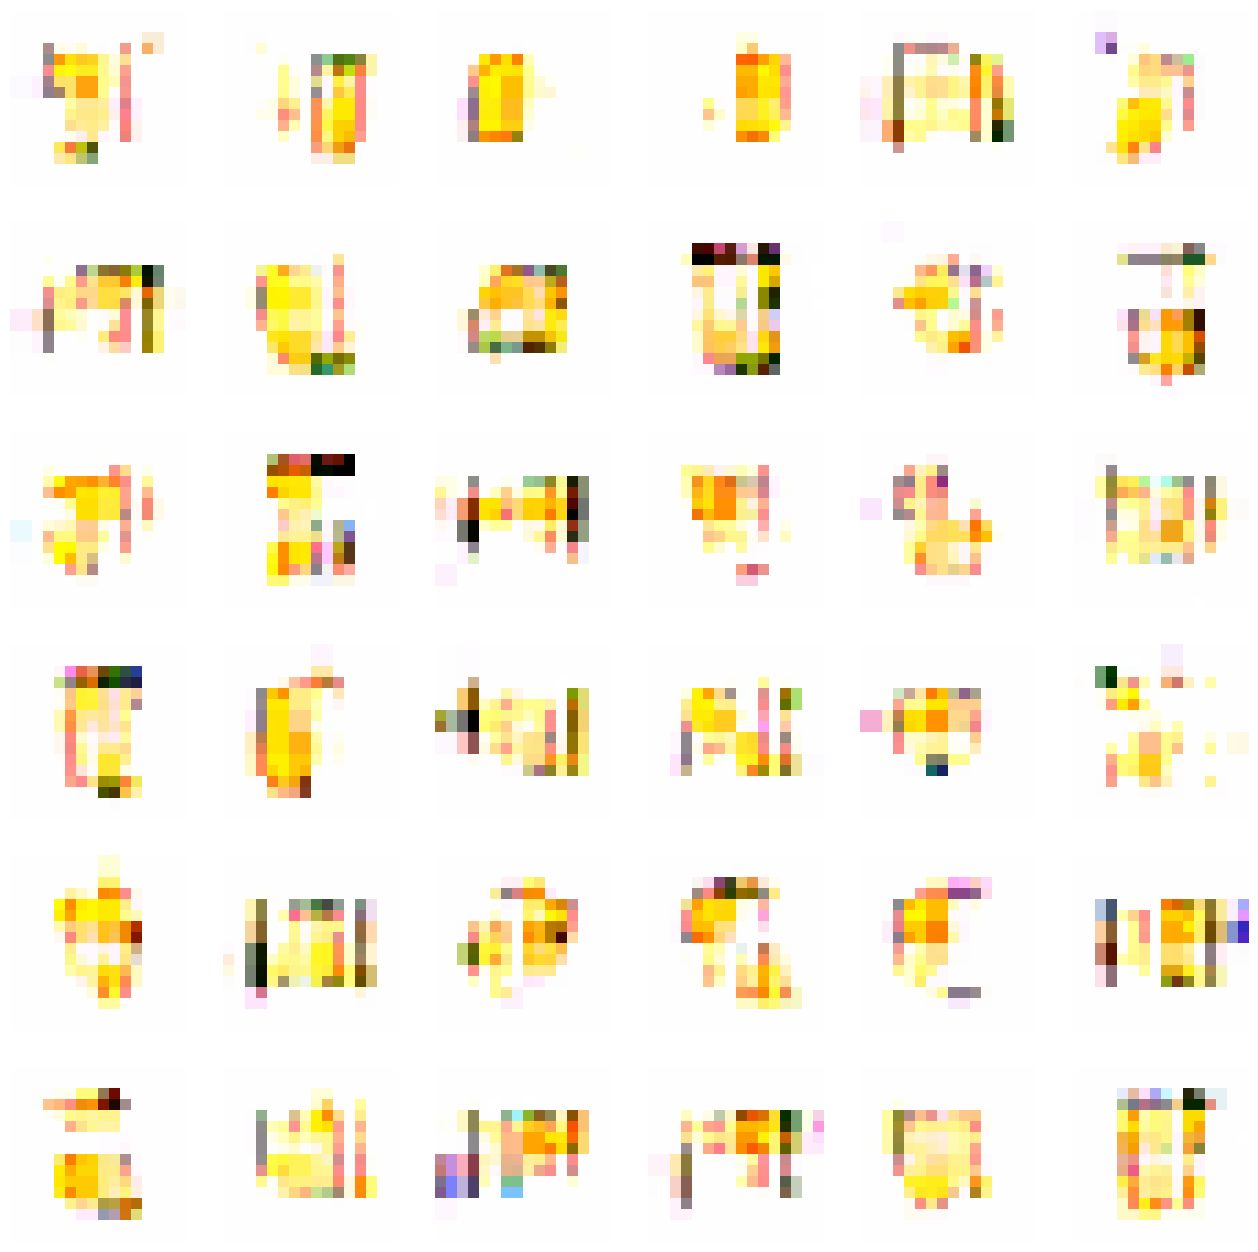

25/25 [==============================] - 125s 5s/step - d_loss: -6.9369 - g_loss: 8.1877
Epoch 24/50
25/25 [==============================] - ETA: 0s - d_loss: -6.7324 - g_loss: 9.0201

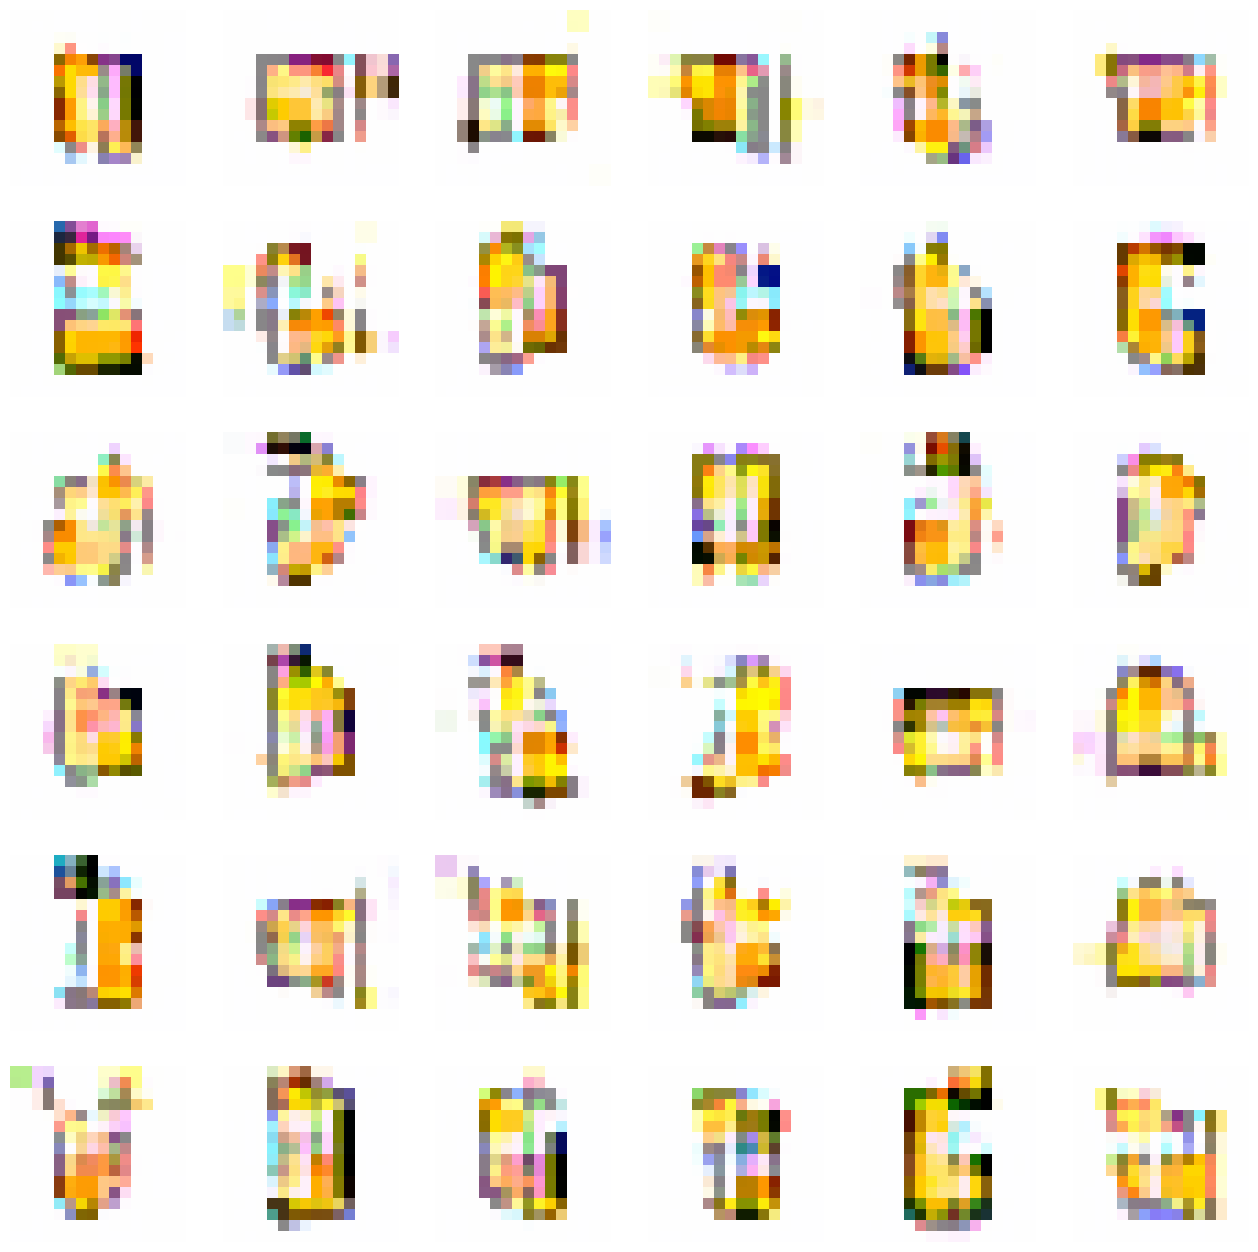

25/25 [==============================] - 126s 5s/step - d_loss: -6.6189 - g_loss: 9.2669
Epoch 25/50
25/25 [==============================] - ETA: 0s - d_loss: -6.4052 - g_loss: 5.7732

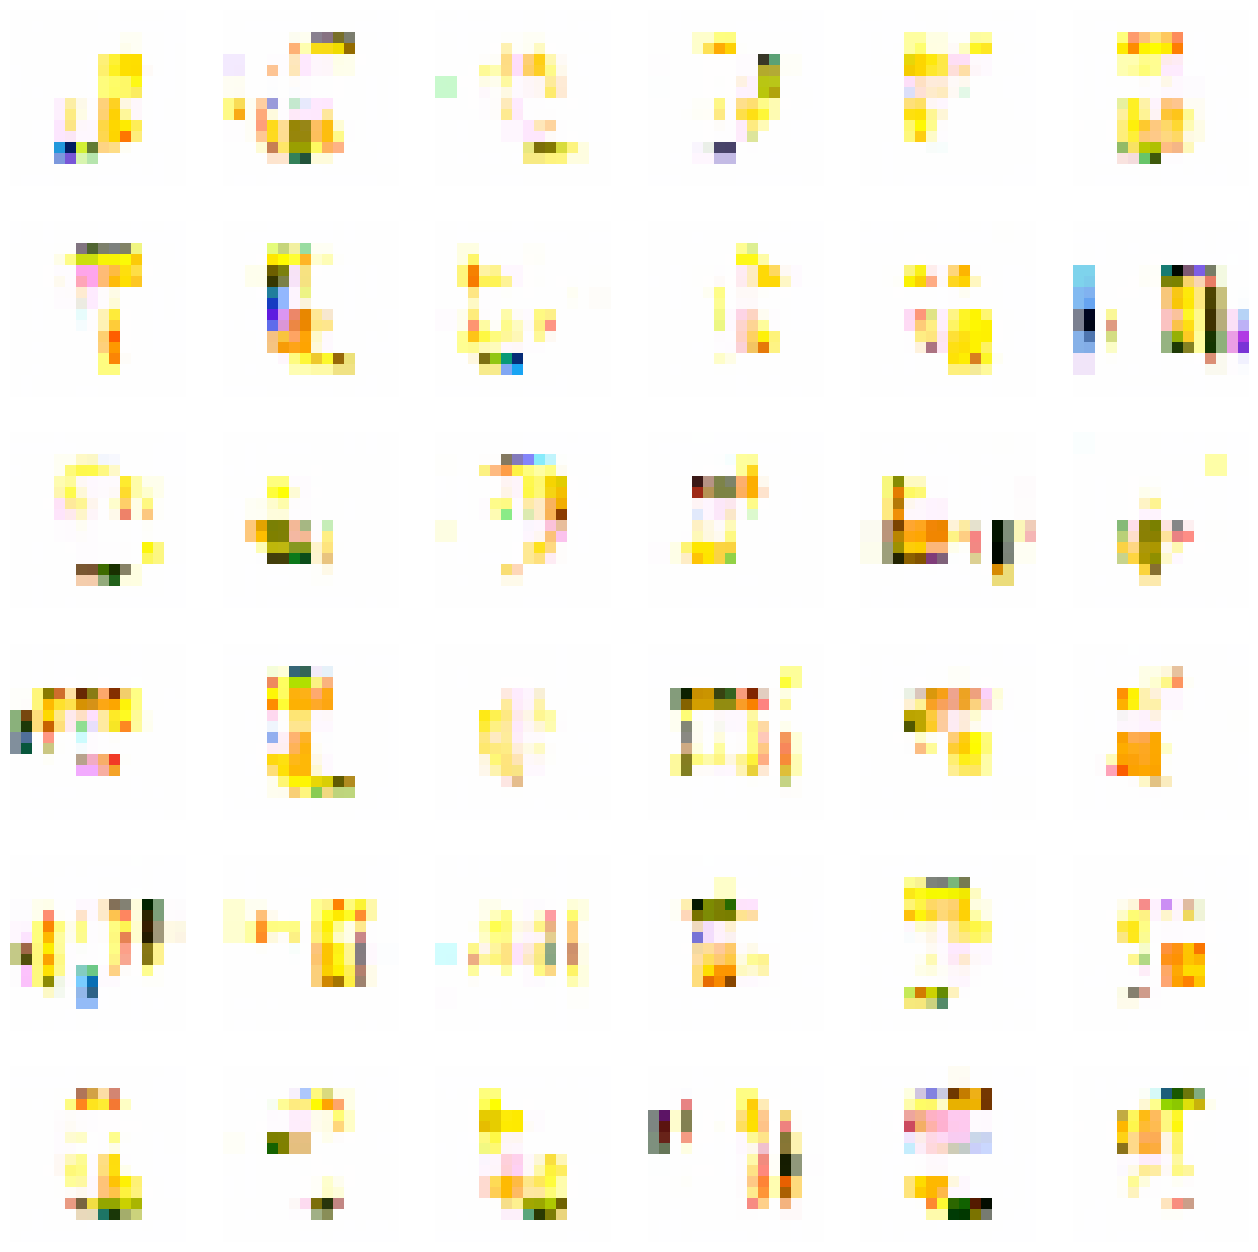

25/25 [==============================] - 120s 5s/step - d_loss: -6.3458 - g_loss: 5.4055
Epoch 26/50
25/25 [==============================] - ETA: 0s - d_loss: -5.3911 - g_loss: 8.5226

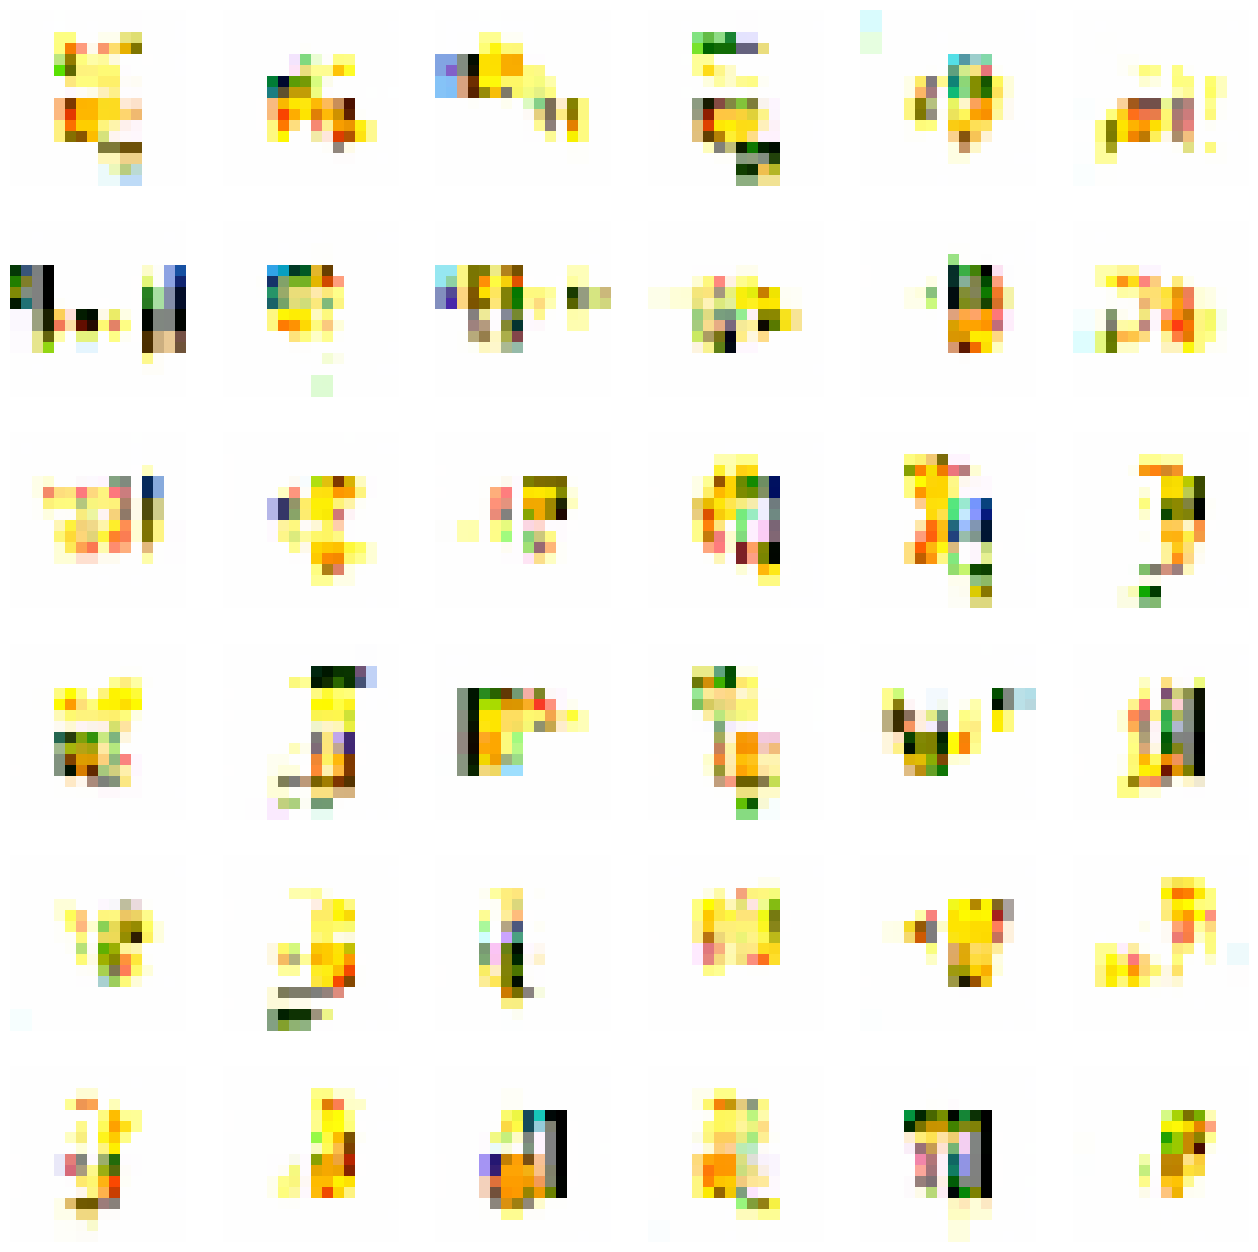

25/25 [==============================] - 120s 5s/step - d_loss: -5.4396 - g_loss: 8.3131
Epoch 27/50
25/25 [==============================] - ETA: 0s - d_loss: -6.0921 - g_loss: 7.8117

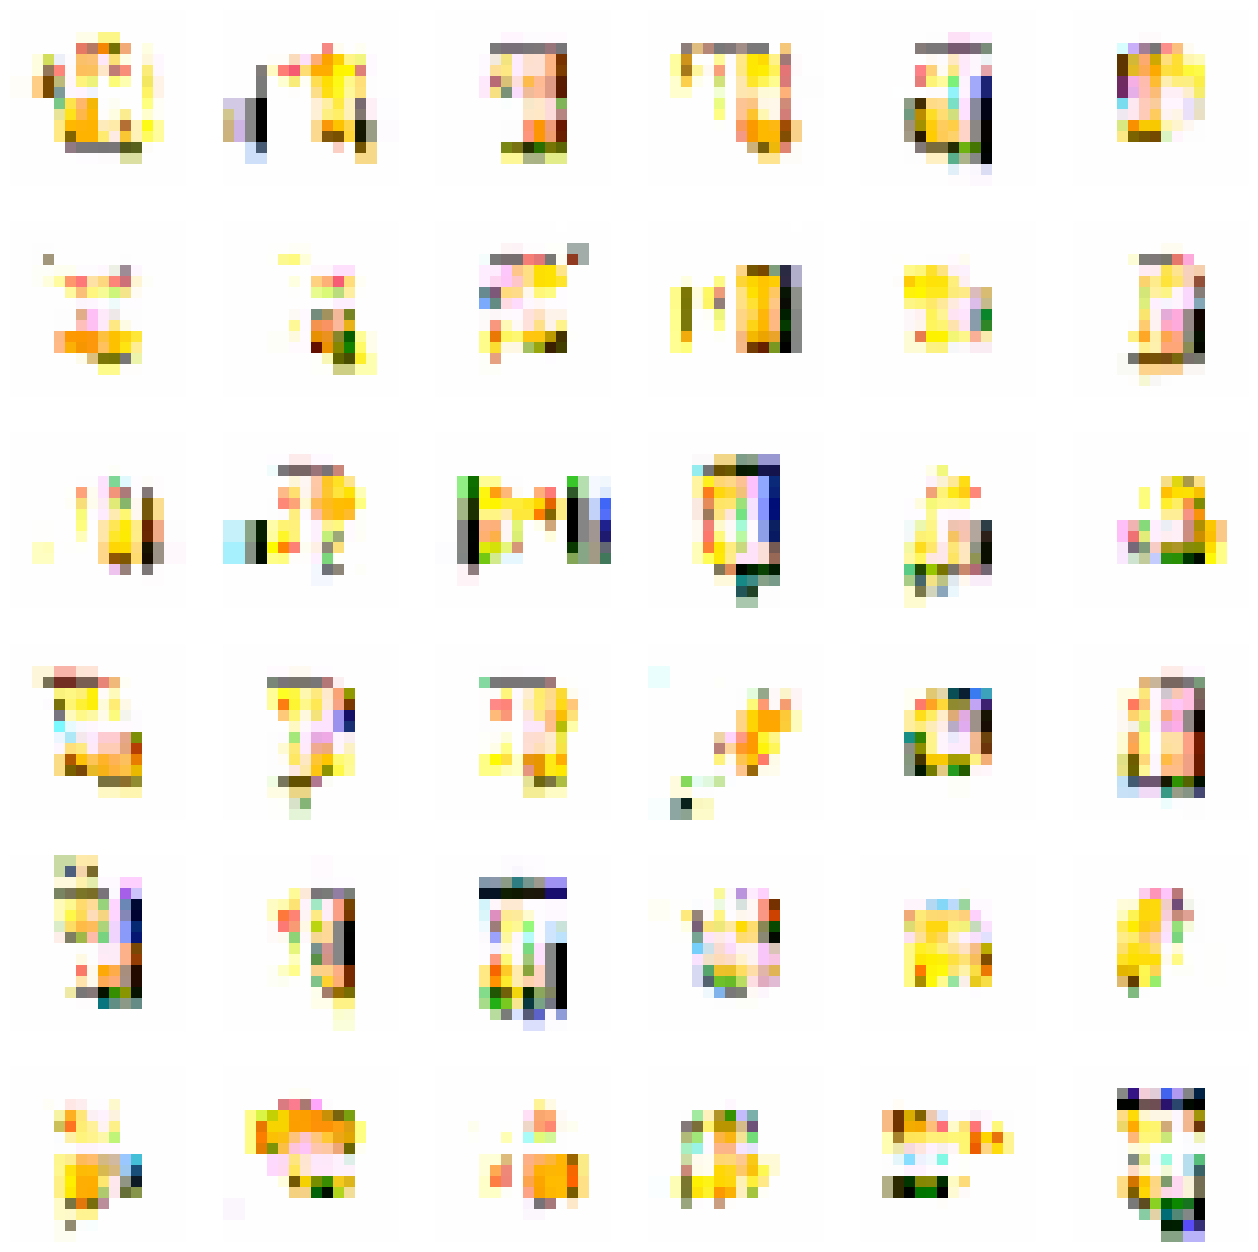

25/25 [==============================] - 118s 5s/step - d_loss: -6.1147 - g_loss: 7.7516
Epoch 28/50
25/25 [==============================] - ETA: 0s - d_loss: -6.7303 - g_loss: 9.2629

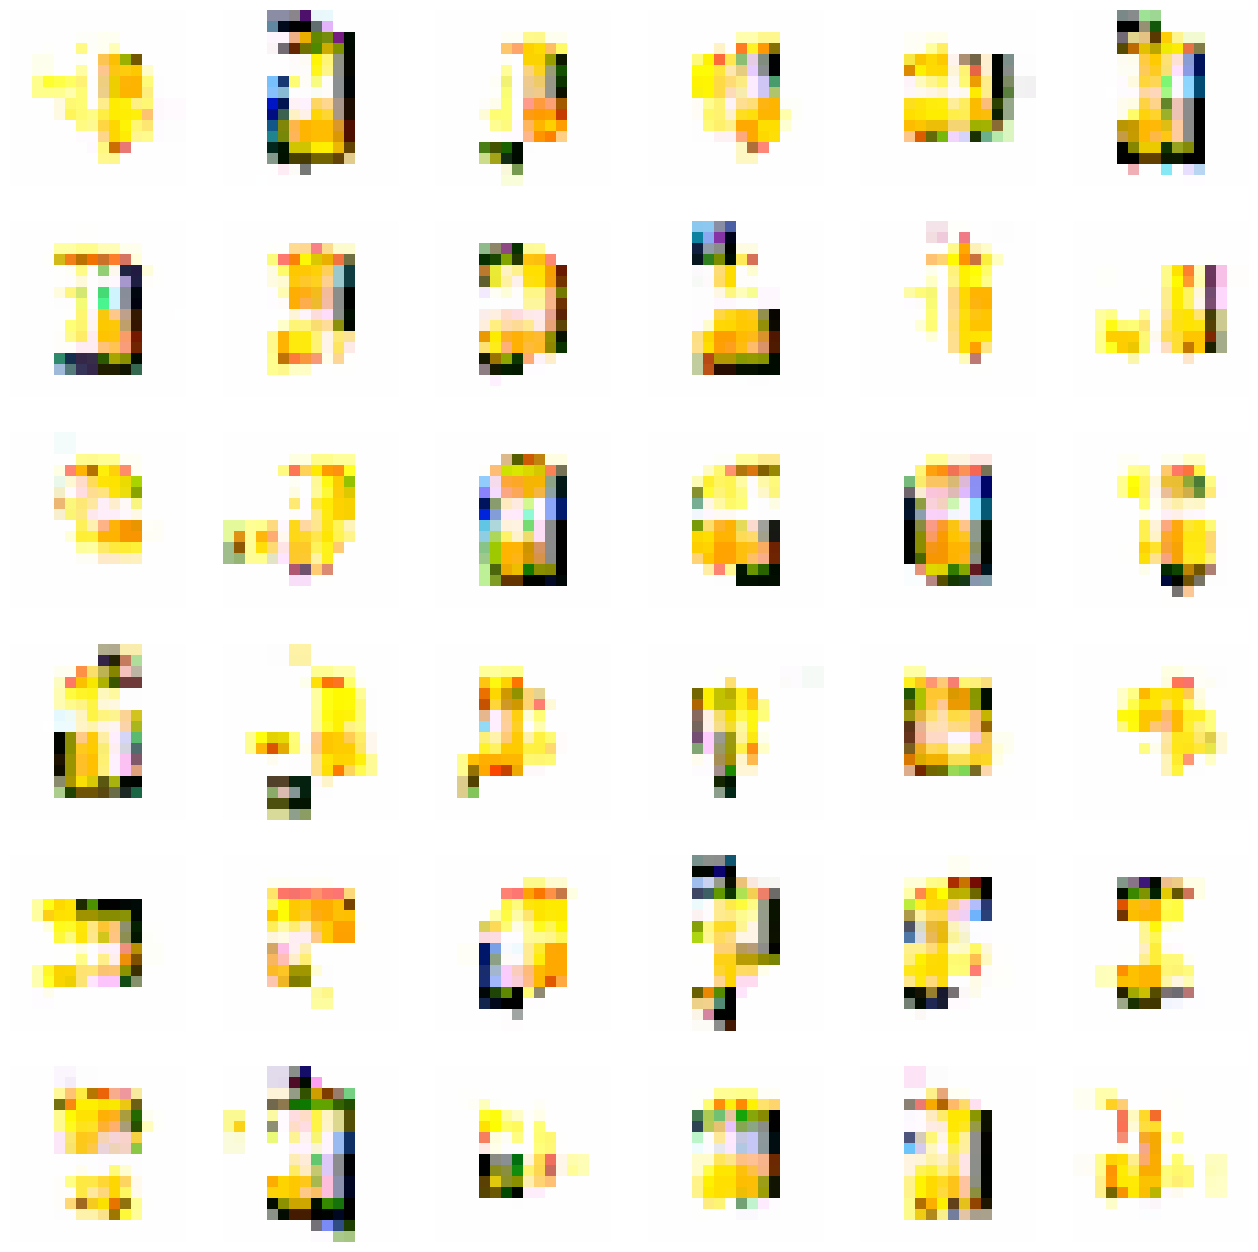

25/25 [==============================] - 118s 5s/step - d_loss: -6.7573 - g_loss: 9.6789
Epoch 29/50
25/25 [==============================] - ETA: 0s - d_loss: -6.1148 - g_loss: 7.5232

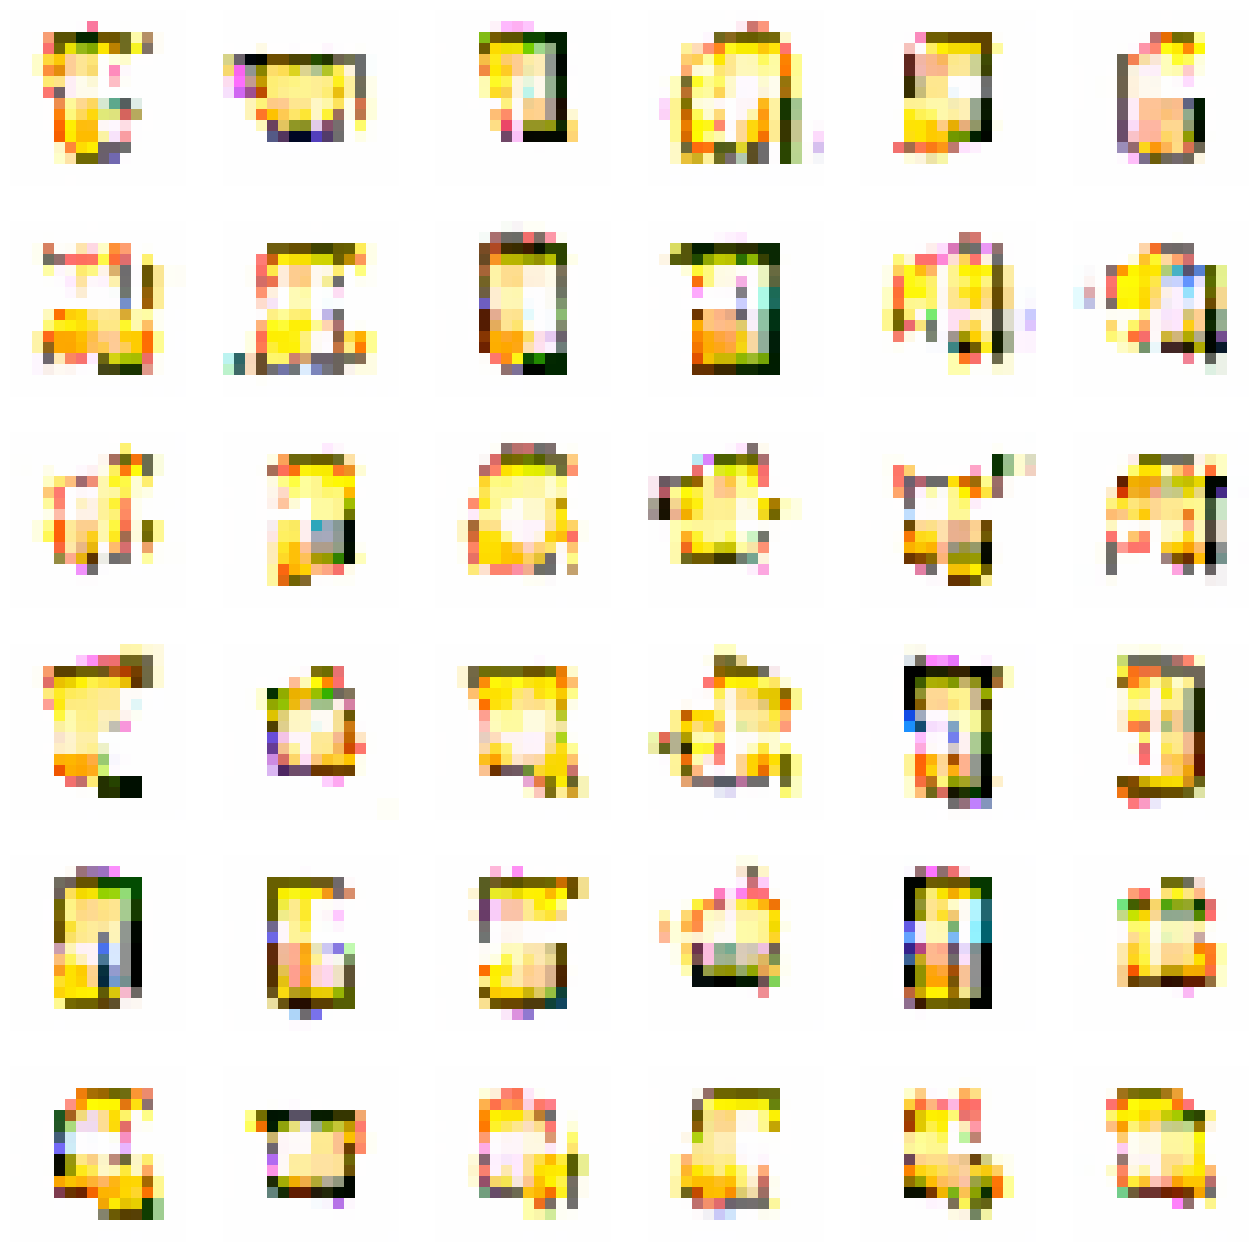

25/25 [==============================] - 118s 5s/step - d_loss: -6.0702 - g_loss: 7.1042
Epoch 30/50
25/25 [==============================] - ETA: 0s - d_loss: -6.0369 - g_loss: 6.6666

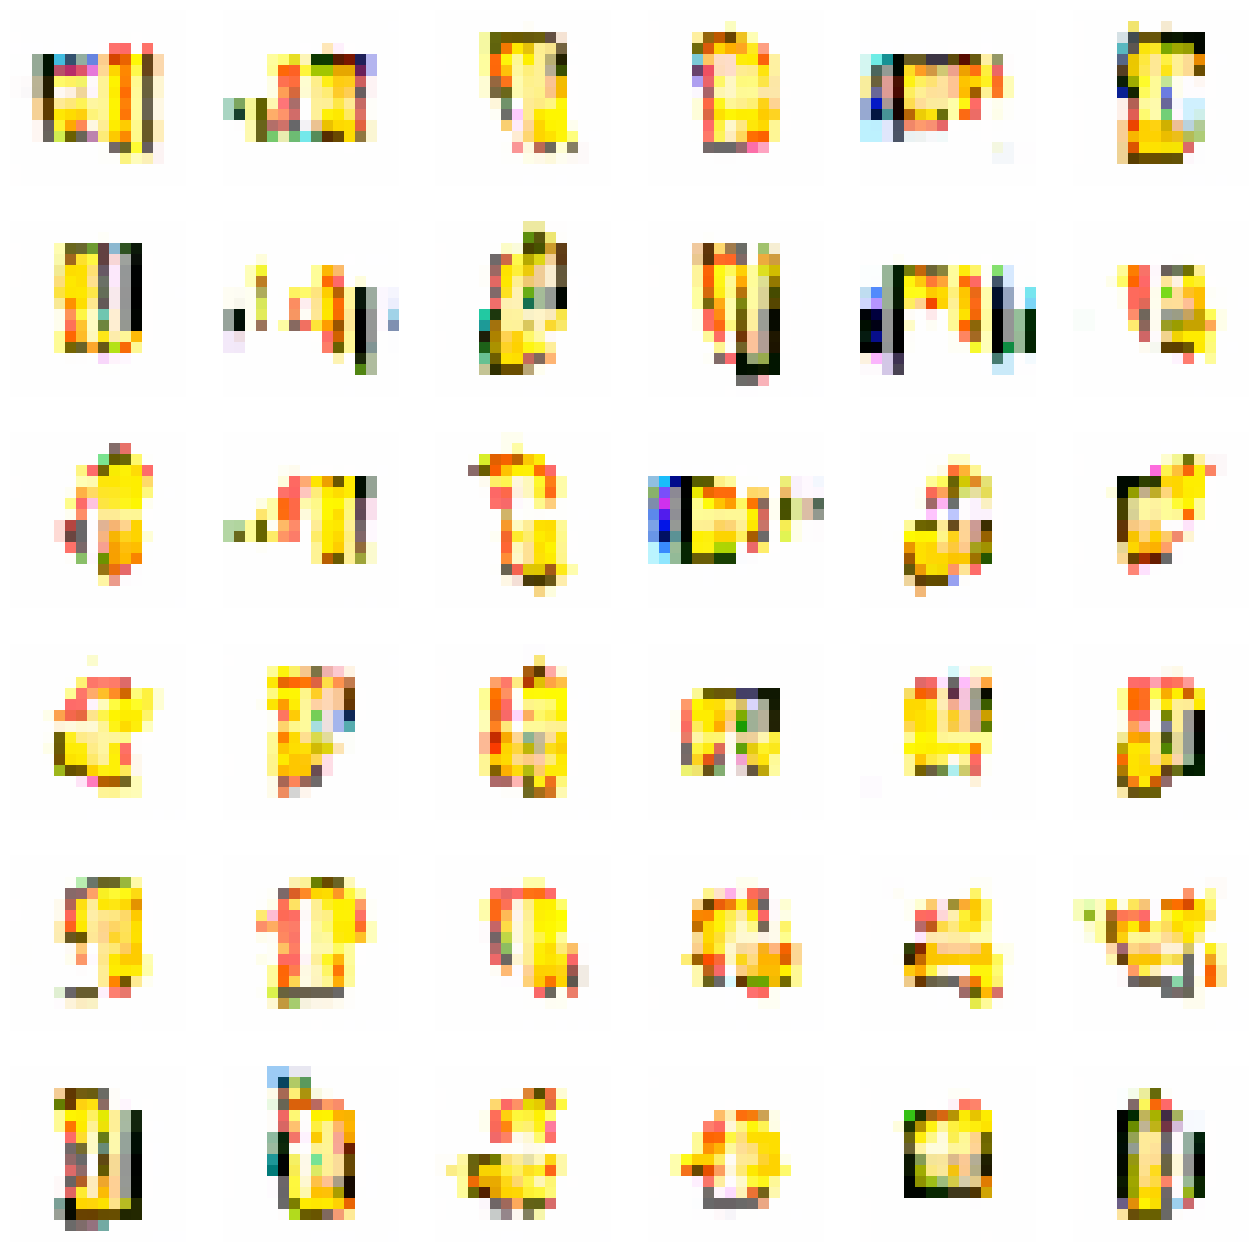

25/25 [==============================] - 119s 5s/step - d_loss: -6.0665 - g_loss: 6.5163
Epoch 31/50
25/25 [==============================] - ETA: 0s - d_loss: -4.1070 - g_loss: 7.6050

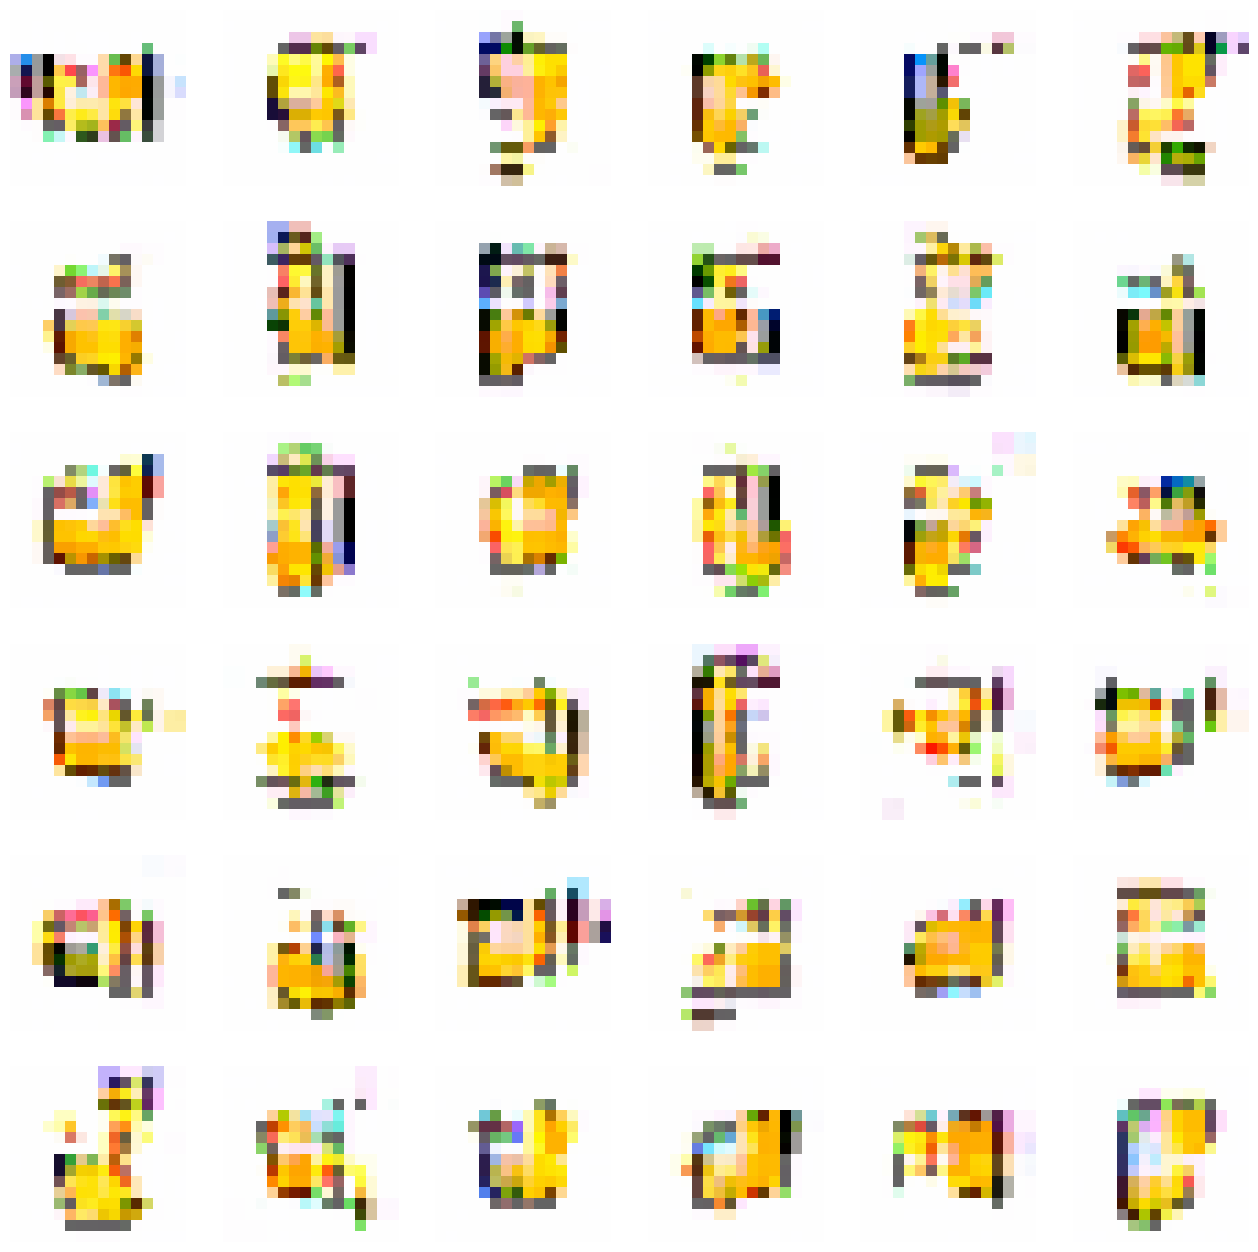

25/25 [==============================] - 119s 5s/step - d_loss: -4.0917 - g_loss: 7.5128
Epoch 32/50
25/25 [==============================] - ETA: 0s - d_loss: -5.2366 - g_loss: 6.8605

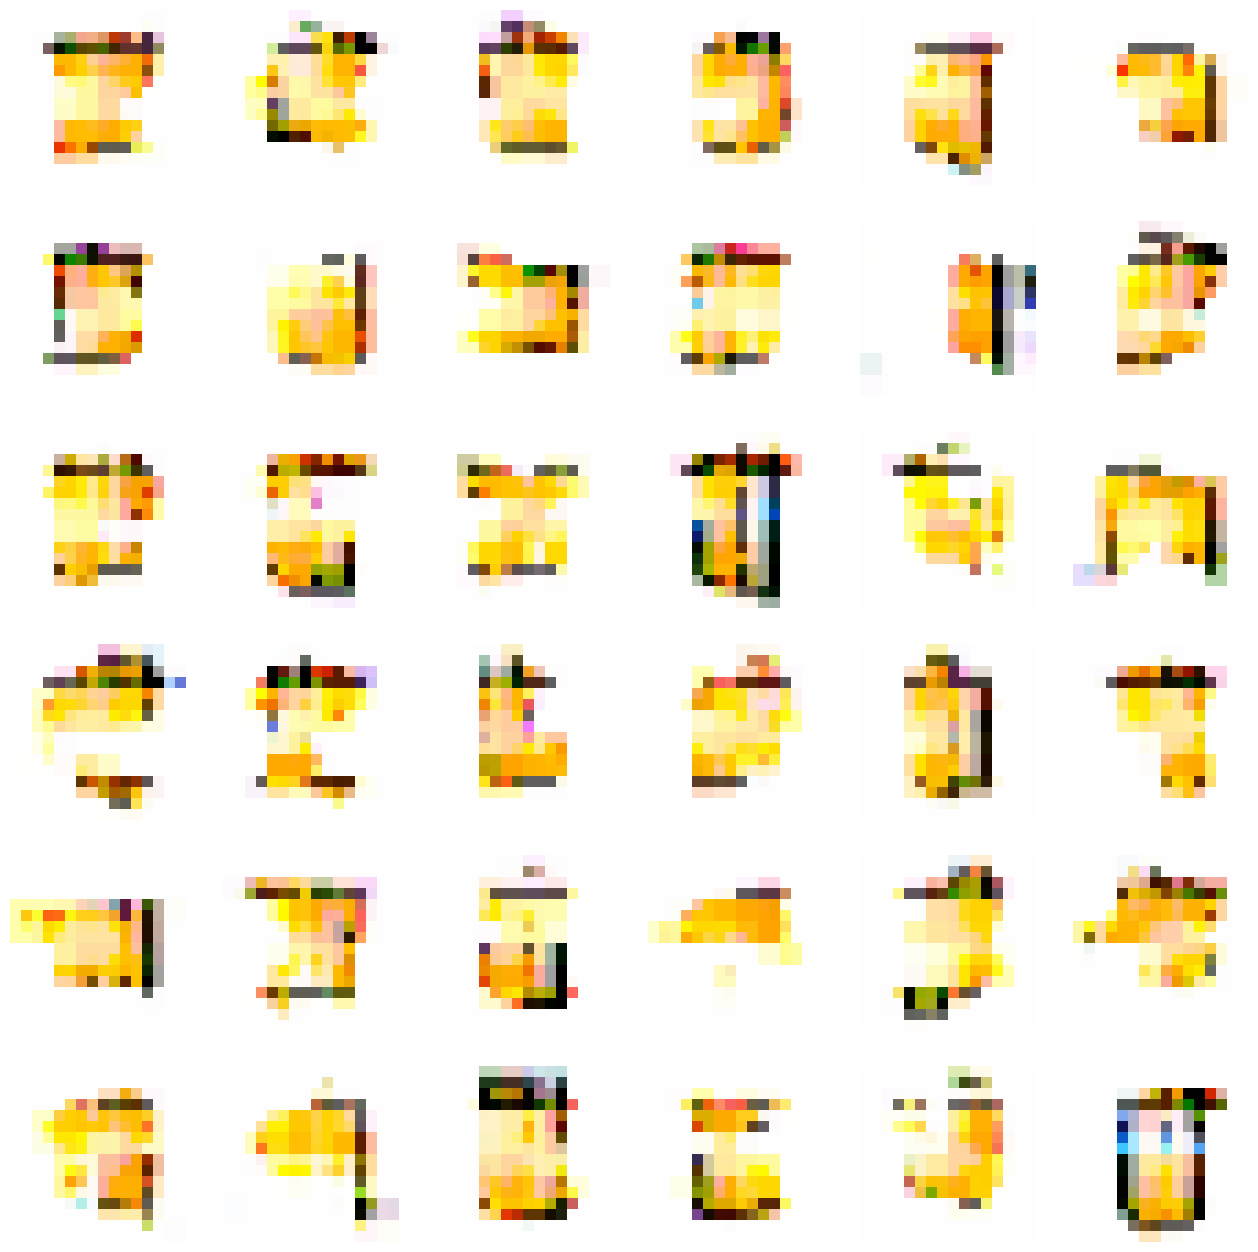

25/25 [==============================] - 119s 5s/step - d_loss: -5.2547 - g_loss: 6.6879
Epoch 33/50
25/25 [==============================] - ETA: 0s - d_loss: -5.4448 - g_loss: 6.6818

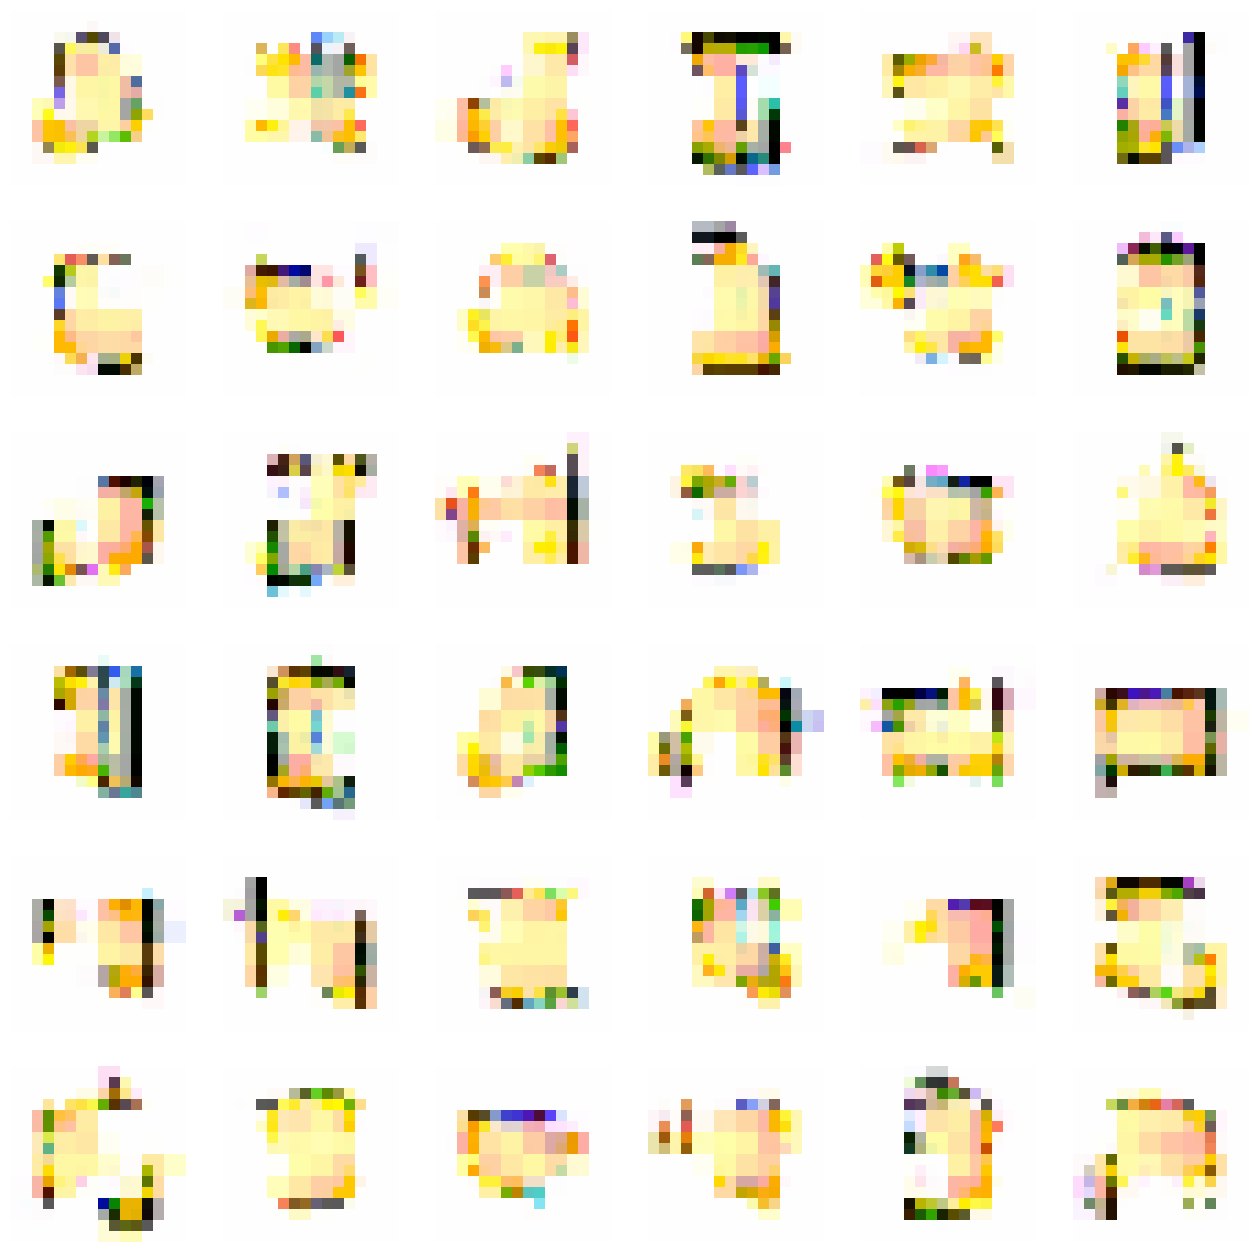

25/25 [==============================] - 127s 5s/step - d_loss: -5.3651 - g_loss: 6.6571
Epoch 34/50
25/25 [==============================] - ETA: 0s - d_loss: -5.0297 - g_loss: 6.9000

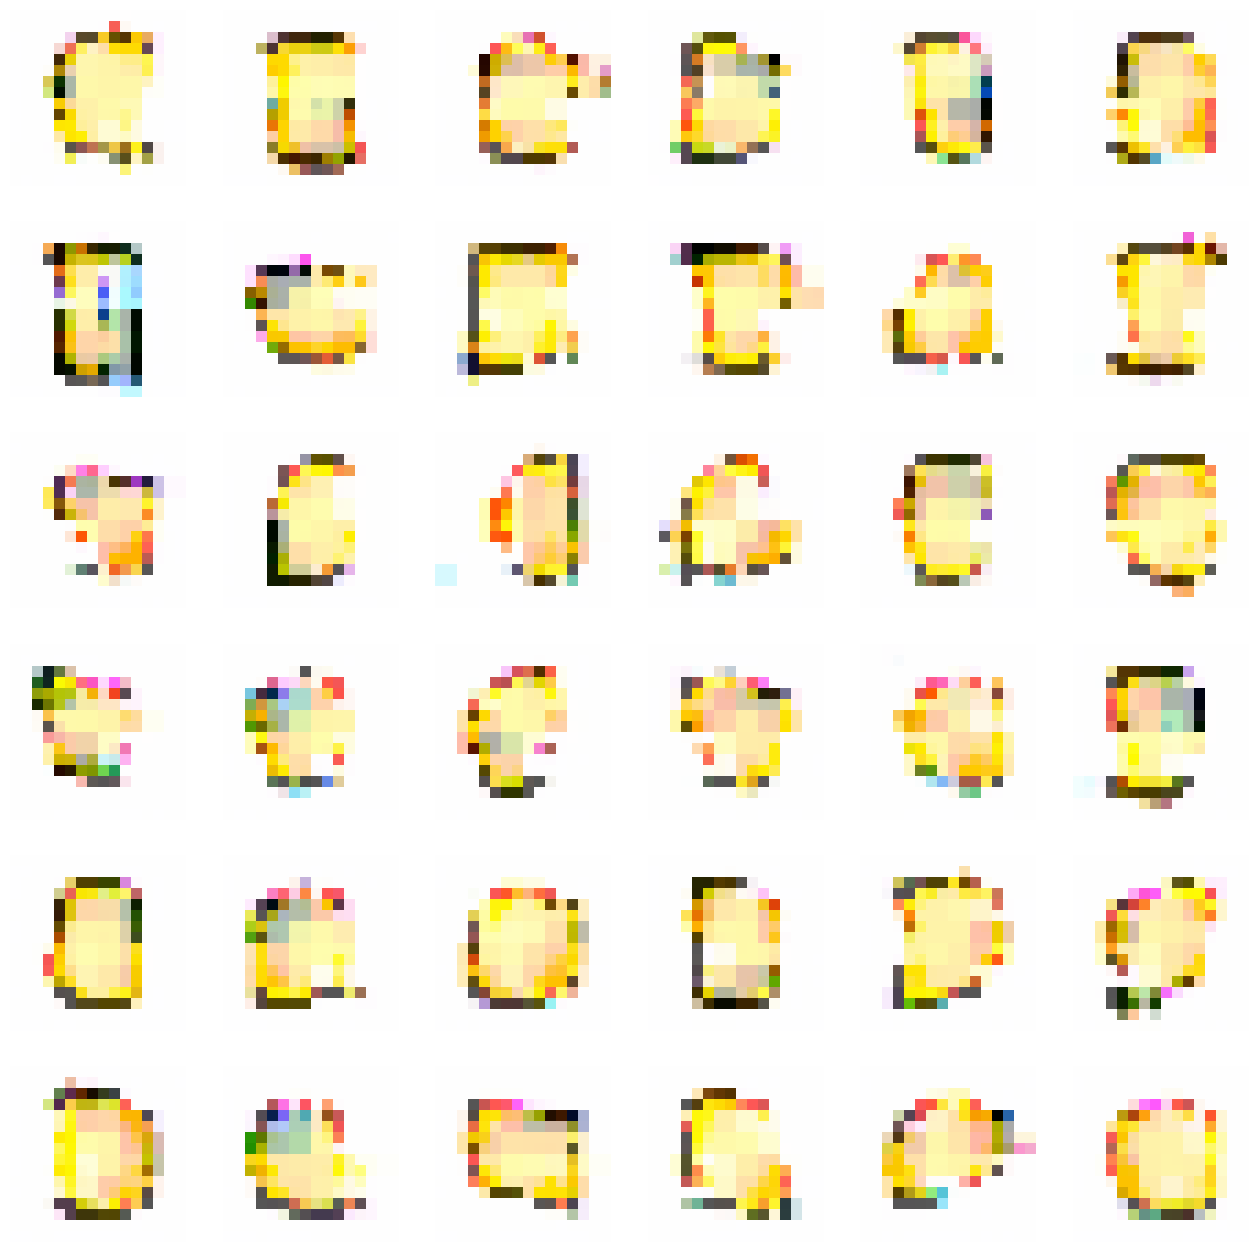

25/25 [==============================] - 132s 5s/step - d_loss: -5.0790 - g_loss: 6.8877
Epoch 35/50
25/25 [==============================] - ETA: 0s - d_loss: -4.5599 - g_loss: 5.8047

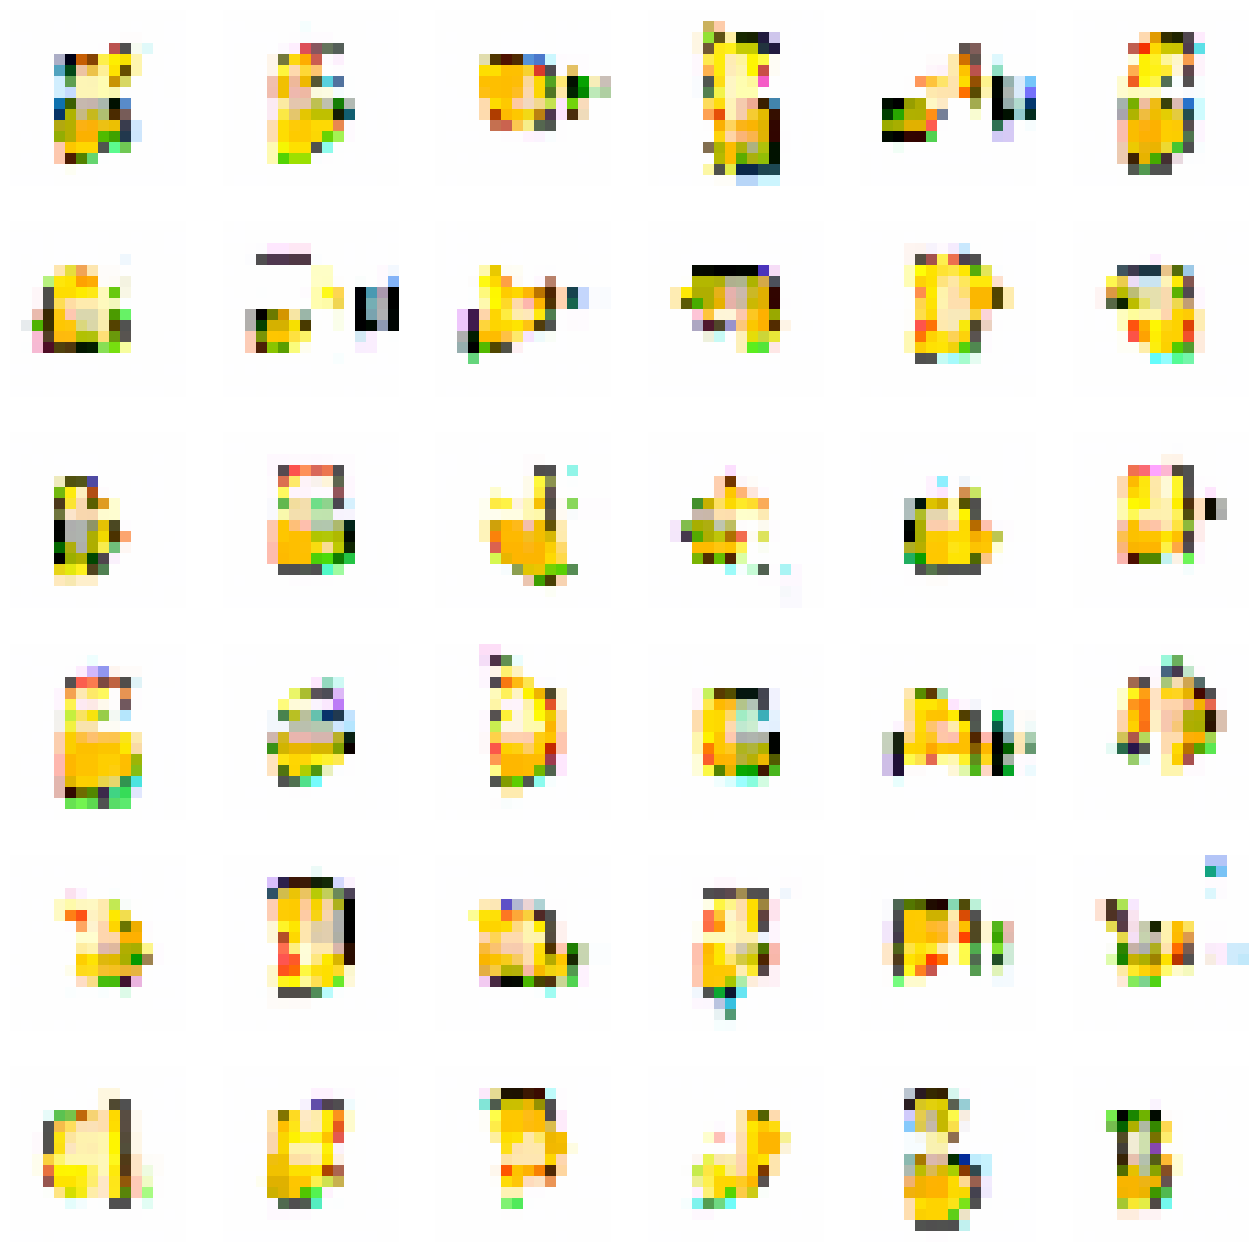

25/25 [==============================] - 128s 5s/step - d_loss: -4.5508 - g_loss: 5.4772
Epoch 36/50
25/25 [==============================] - ETA: 0s - d_loss: -4.5179 - g_loss: 4.9877

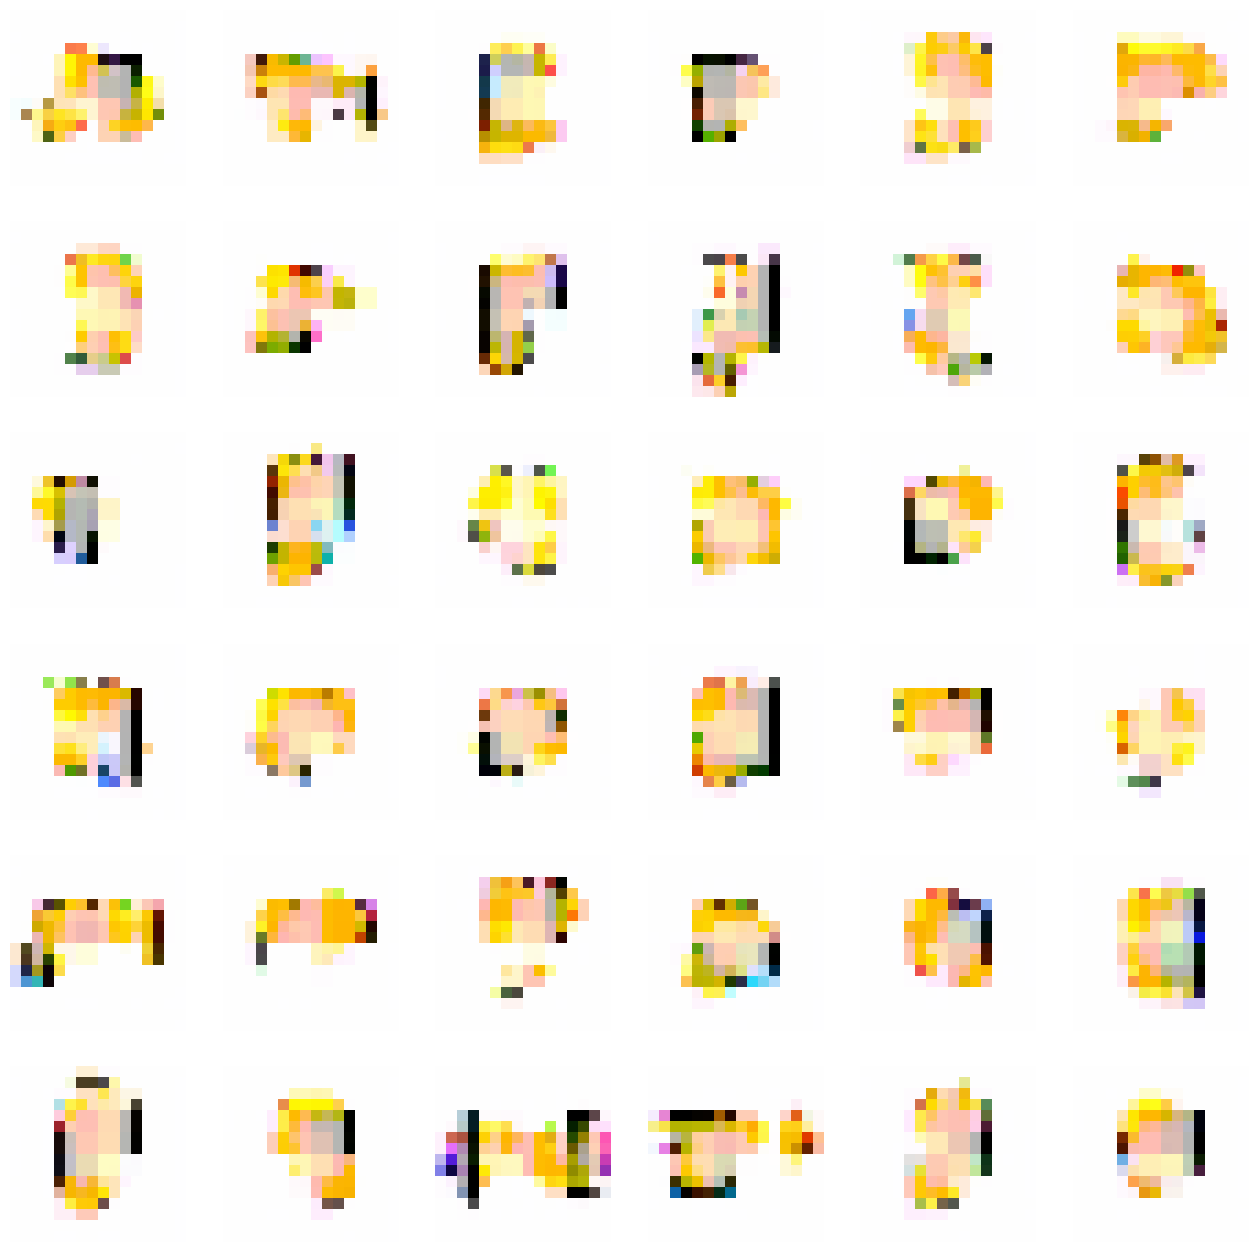

25/25 [==============================] - 121s 5s/step - d_loss: -4.5386 - g_loss: 4.5823
Epoch 37/50
25/25 [==============================] - ETA: 0s - d_loss: -4.4007 - g_loss: 5.3185

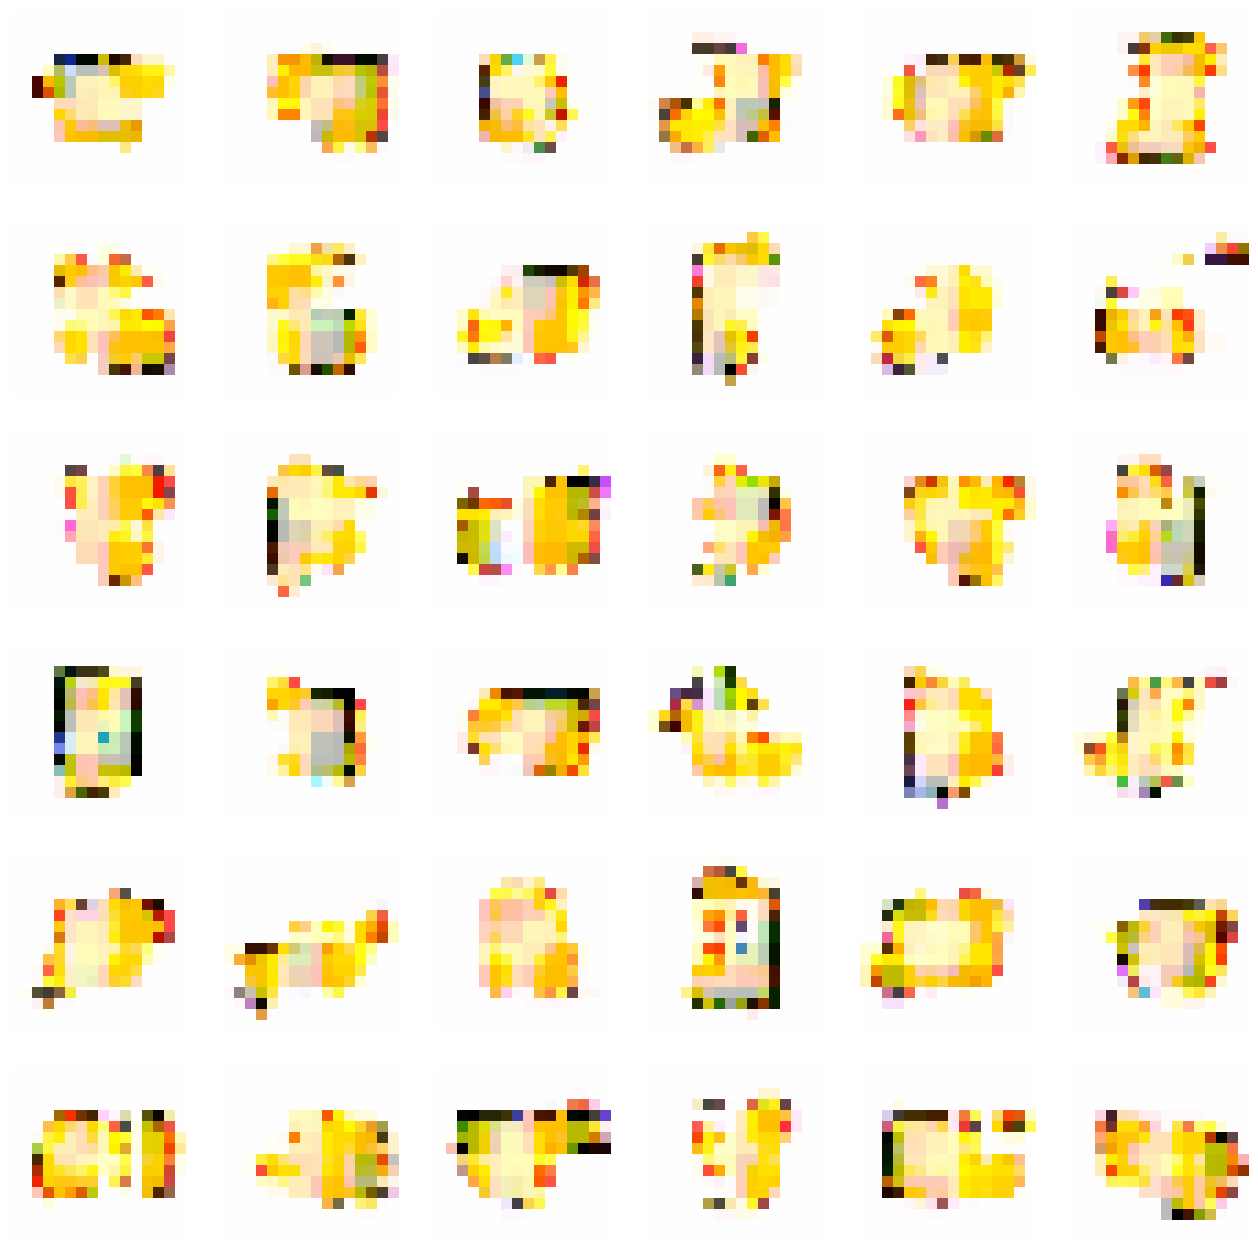

25/25 [==============================] - 127s 5s/step - d_loss: -4.4187 - g_loss: 5.6233
Epoch 38/50
25/25 [==============================] - ETA: 0s - d_loss: -4.1588 - g_loss: 6.9406

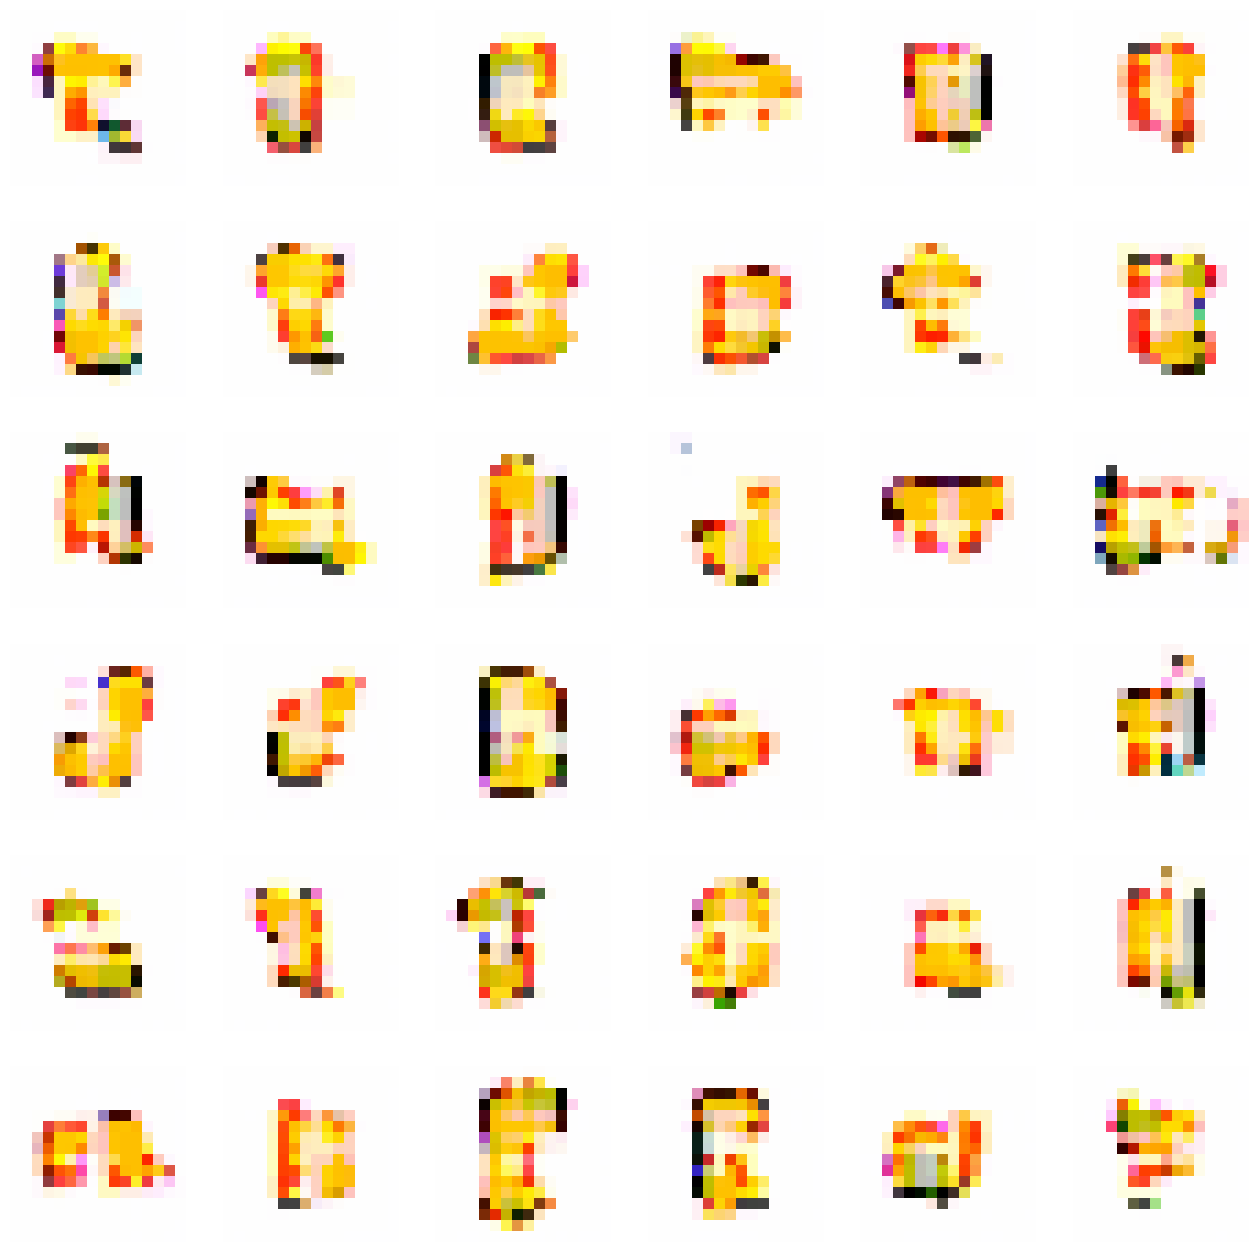

25/25 [==============================] - 128s 5s/step - d_loss: -4.2058 - g_loss: 7.5921
Epoch 39/50
25/25 [==============================] - ETA: 0s - d_loss: -4.7851 - g_loss: 4.8620

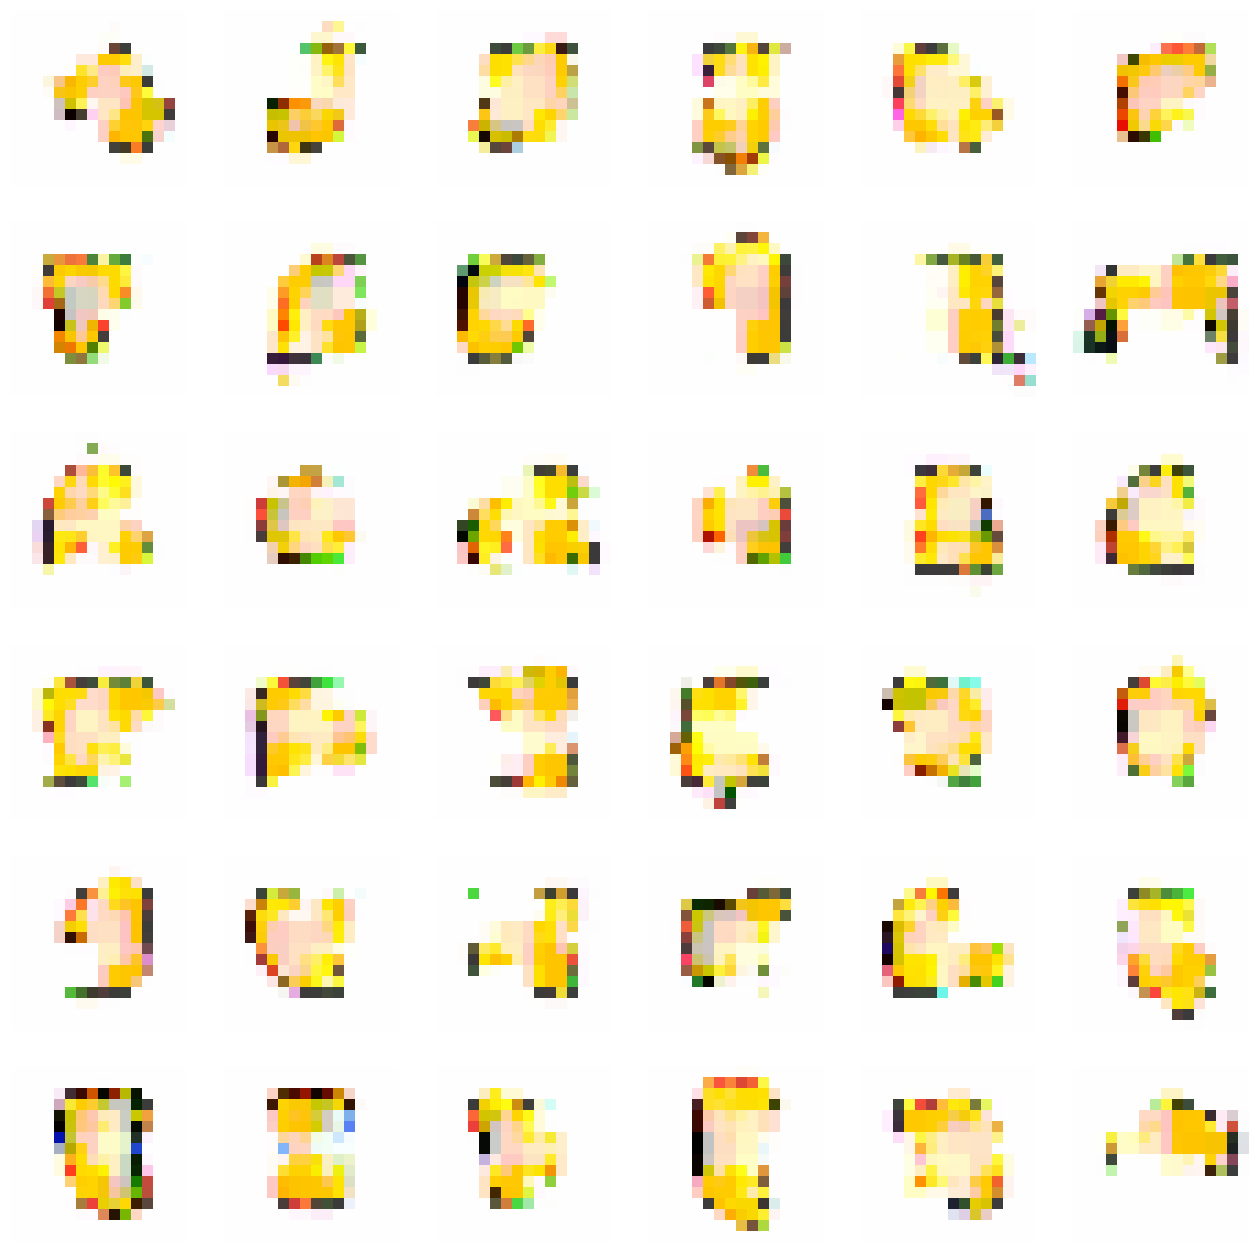

25/25 [==============================] - 127s 5s/step - d_loss: -4.8154 - g_loss: 5.2771
Epoch 40/50
25/25 [==============================] - ETA: 0s - d_loss: -4.3182 - g_loss: 5.6850

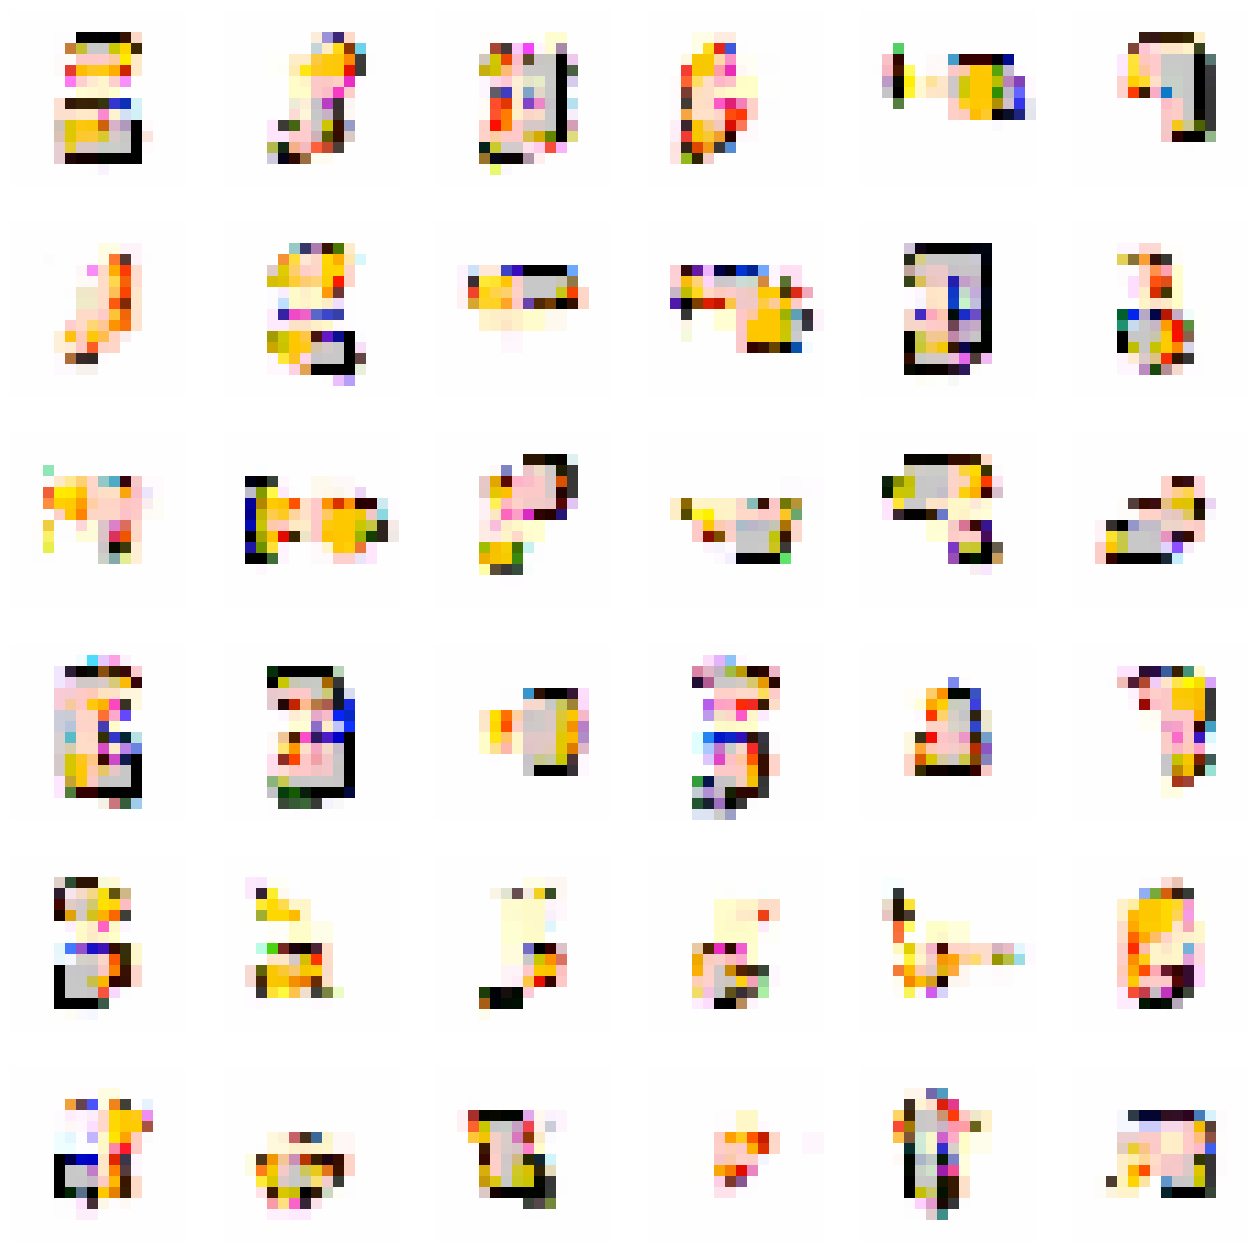

25/25 [==============================] - 134s 5s/step - d_loss: -4.3424 - g_loss: 5.5305
Epoch 41/50
25/25 [==============================] - ETA: 0s - d_loss: -4.6507 - g_loss: 5.2936

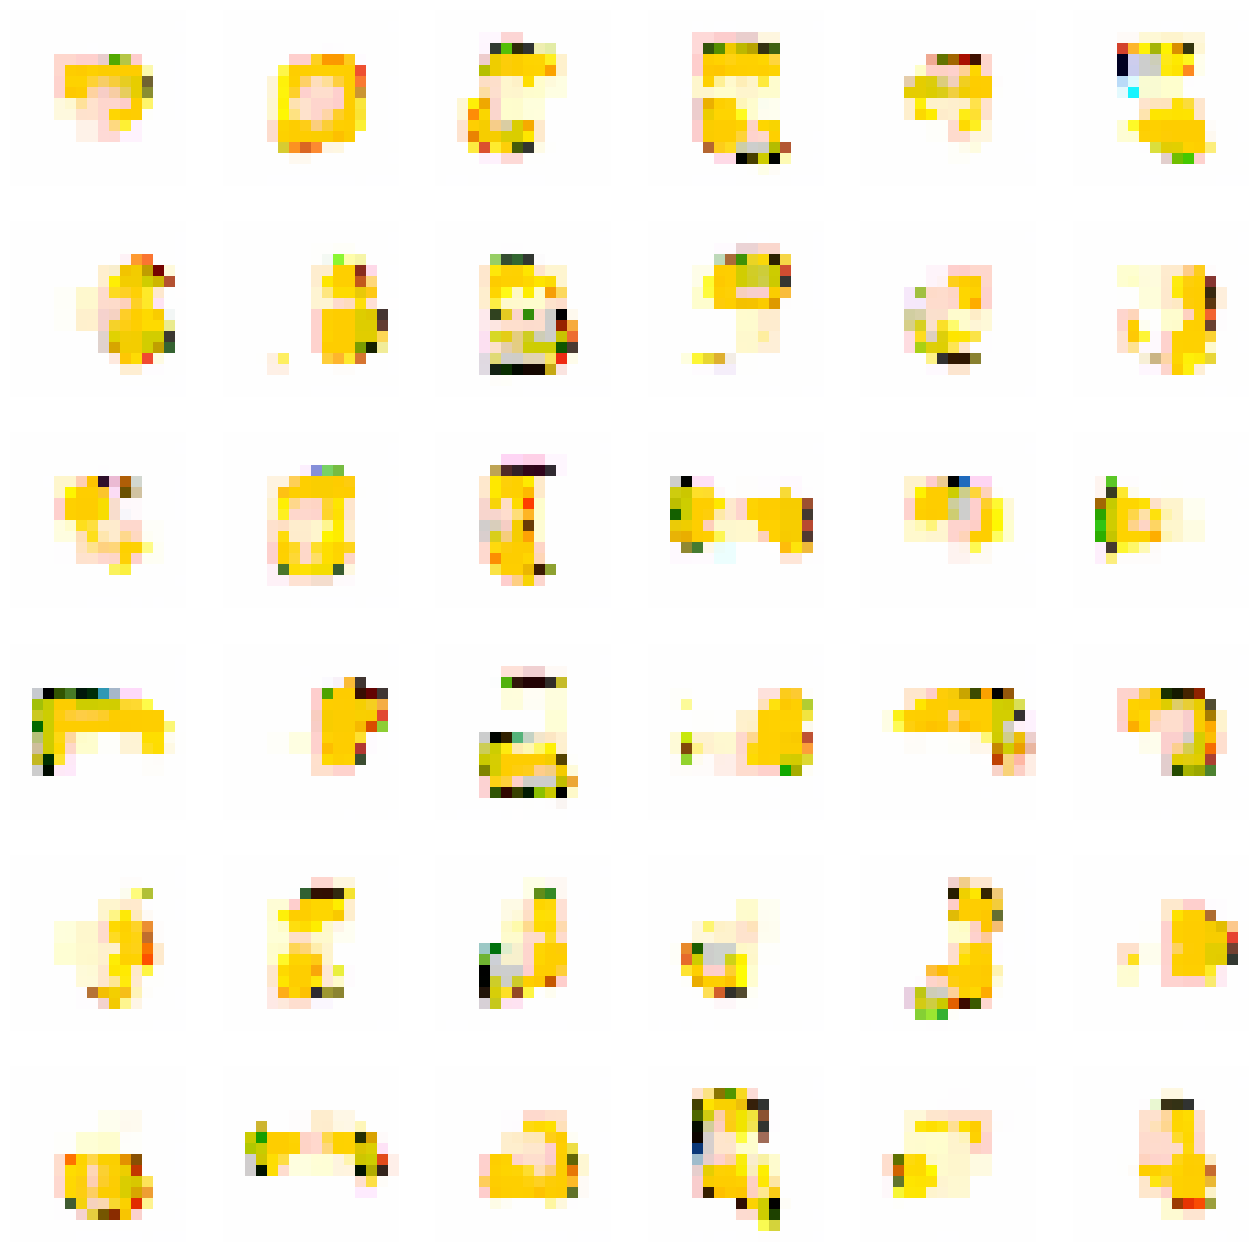

25/25 [==============================] - 130s 5s/step - d_loss: -4.6754 - g_loss: 5.1160
Epoch 42/50
25/25 [==============================] - ETA: 0s - d_loss: -4.8446 - g_loss: 7.9260

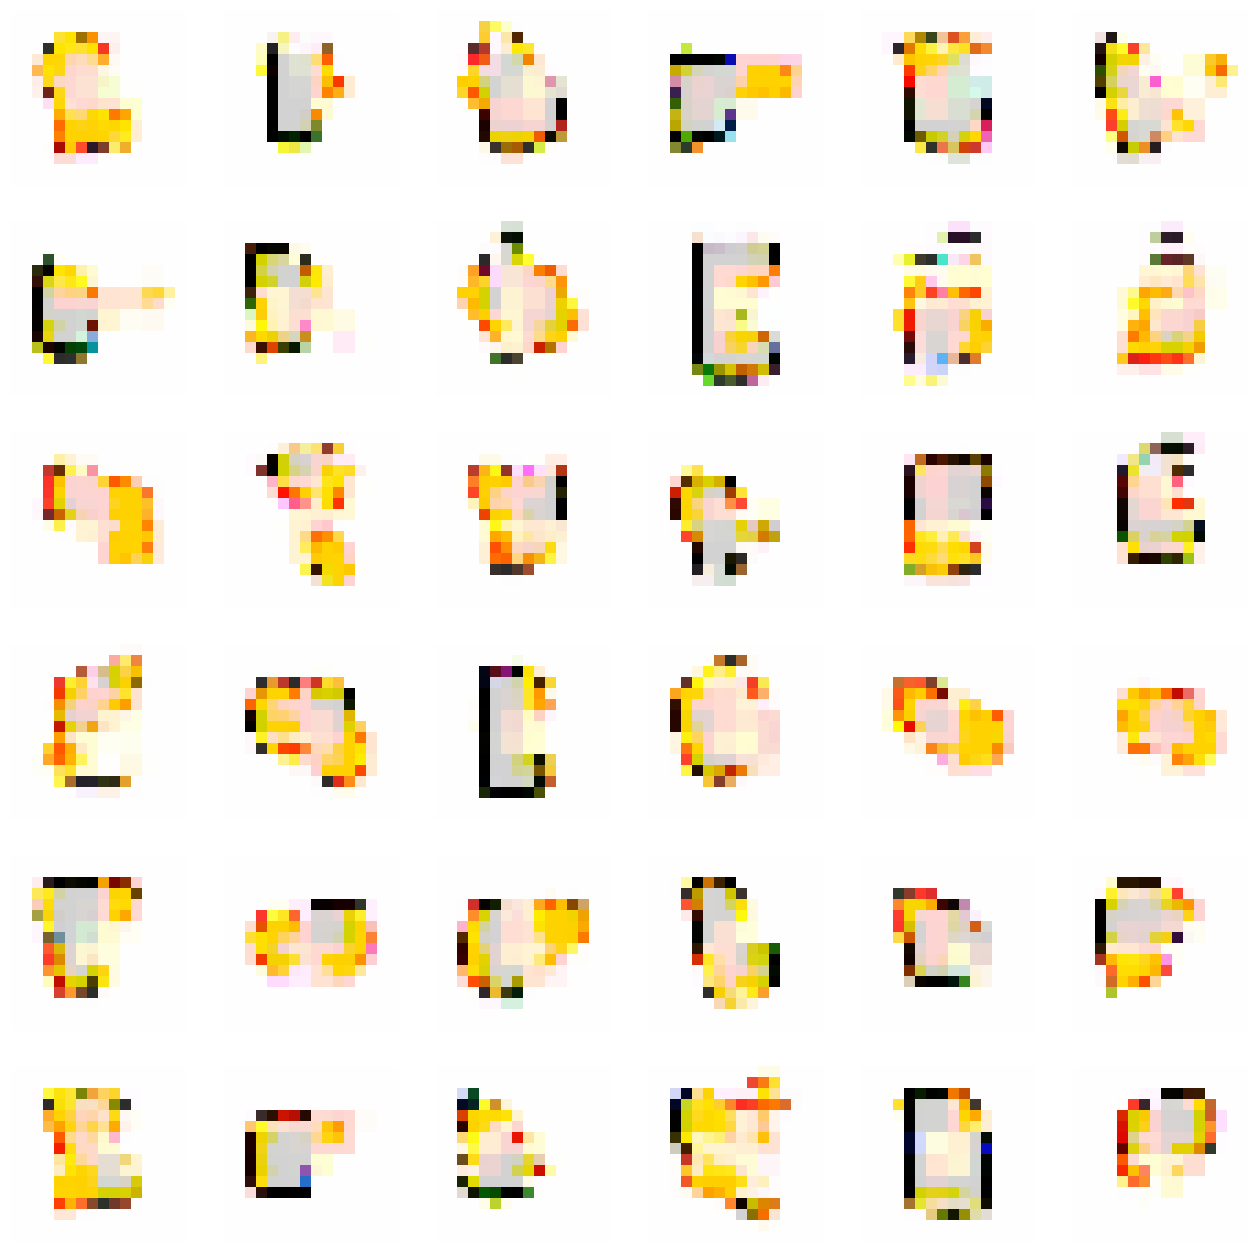

25/25 [==============================] - 133s 5s/step - d_loss: -4.7997 - g_loss: 8.3721
Epoch 43/50
25/25 [==============================] - ETA: 0s - d_loss: -5.0485 - g_loss: 5.8933

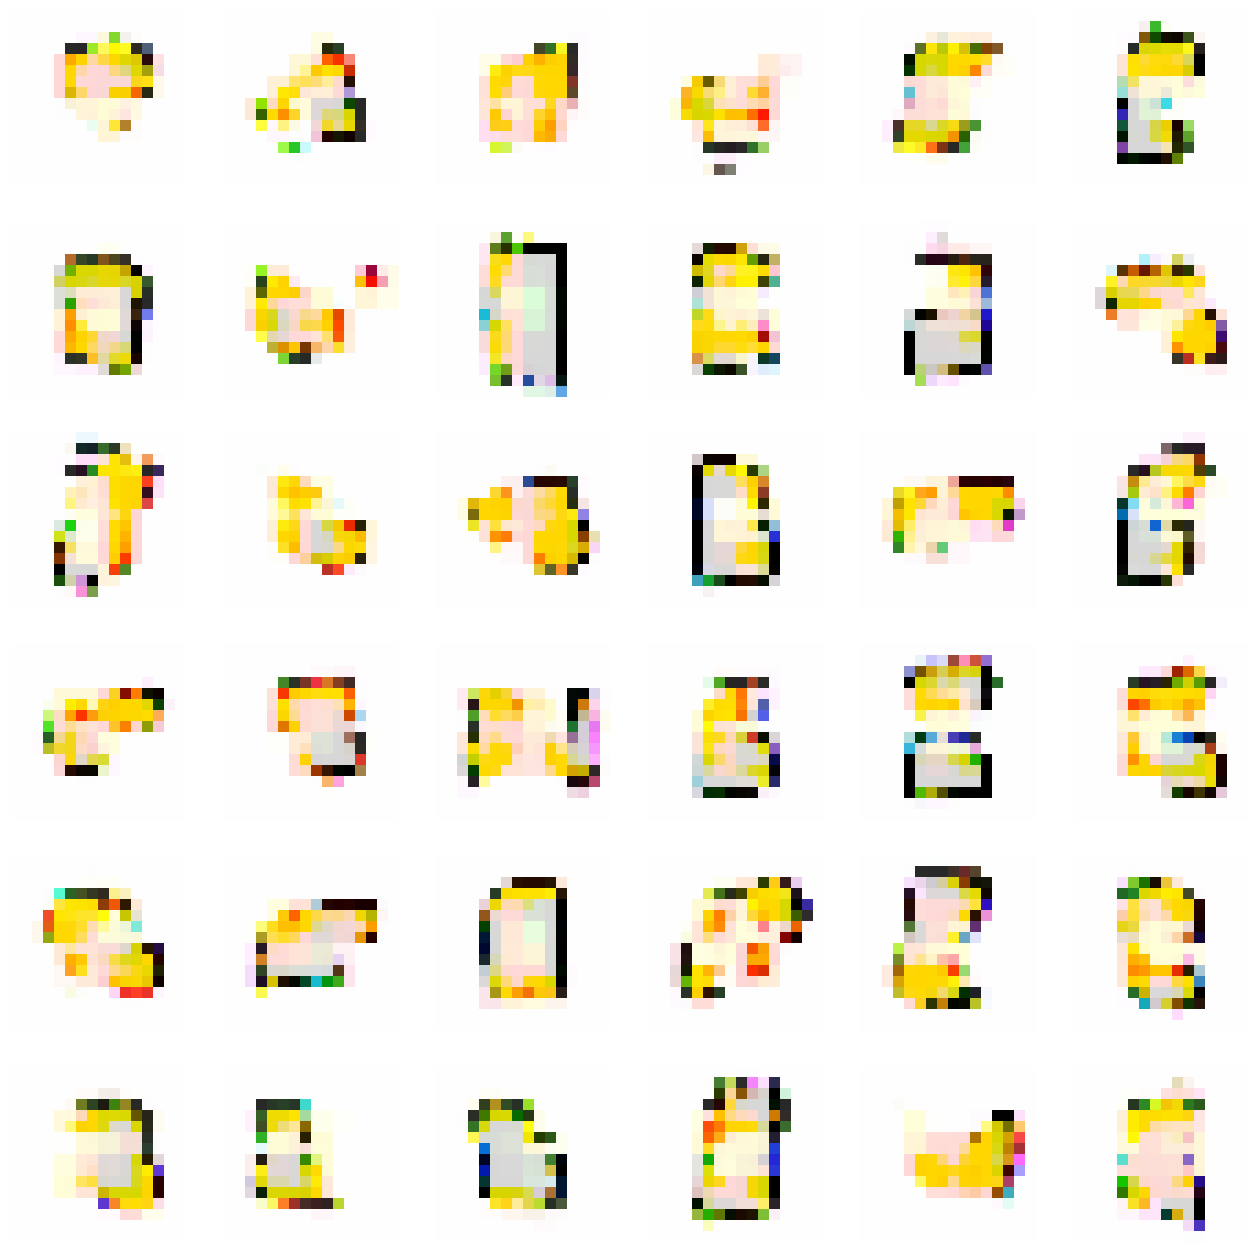

25/25 [==============================] - 130s 5s/step - d_loss: -5.0849 - g_loss: 6.4152
Epoch 44/50
25/25 [==============================] - ETA: 0s - d_loss: -5.2557 - g_loss: 6.9366

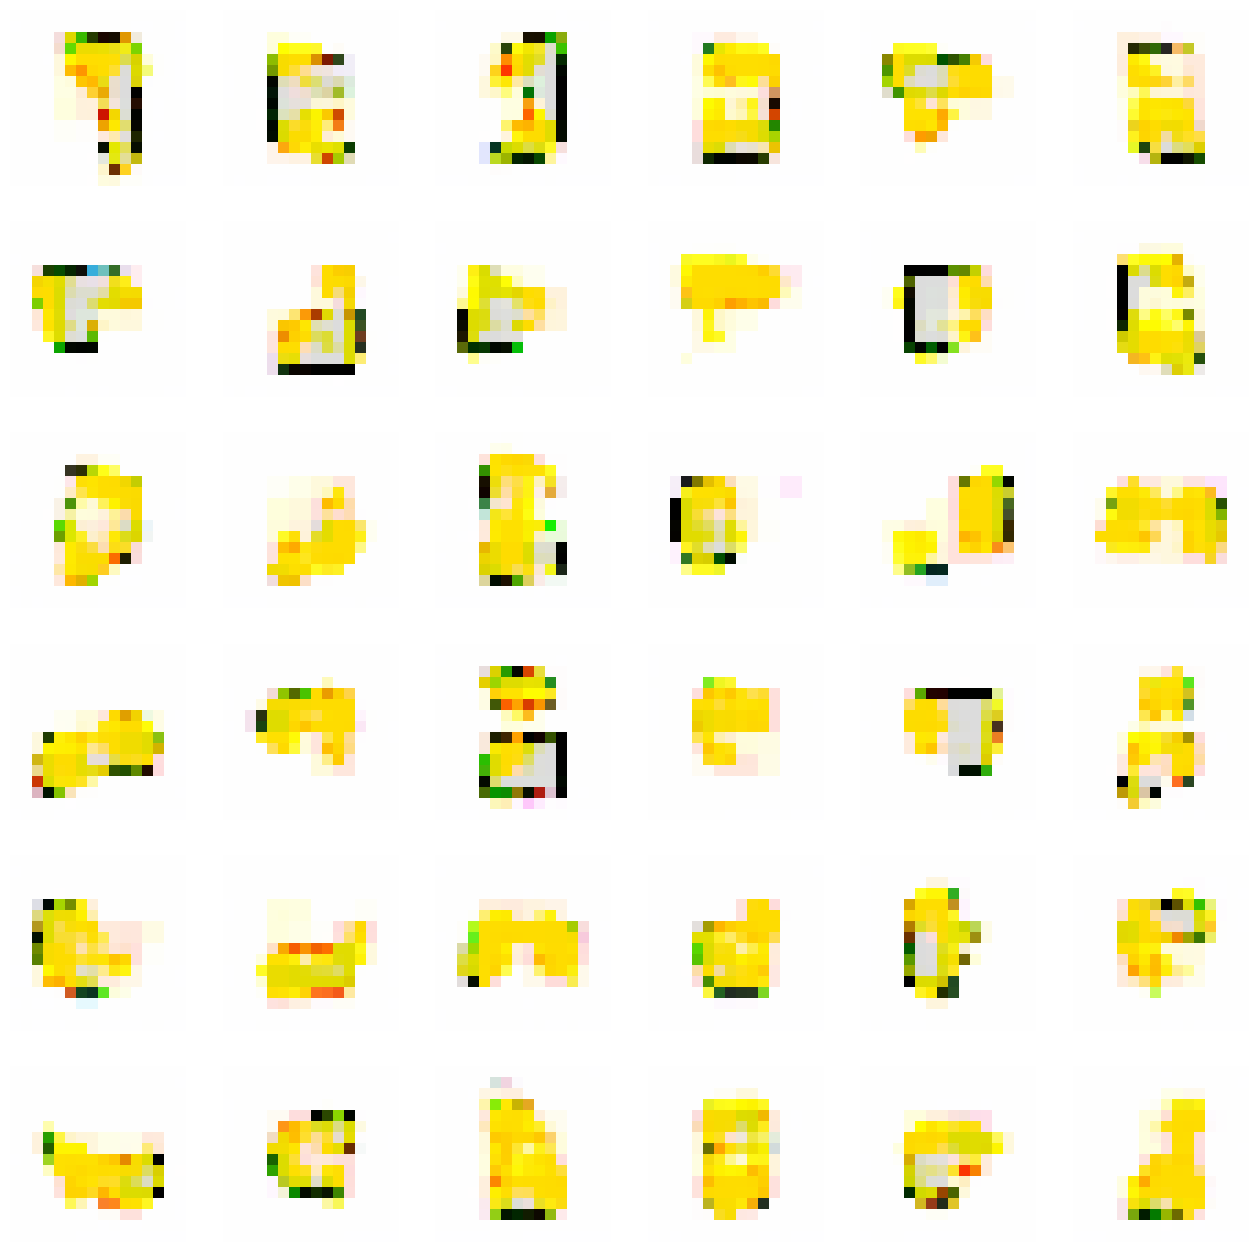

25/25 [==============================] - 131s 5s/step - d_loss: -5.3054 - g_loss: 7.5103
Epoch 45/50
25/25 [==============================] - ETA: 0s - d_loss: -5.4678 - g_loss: 7.3595

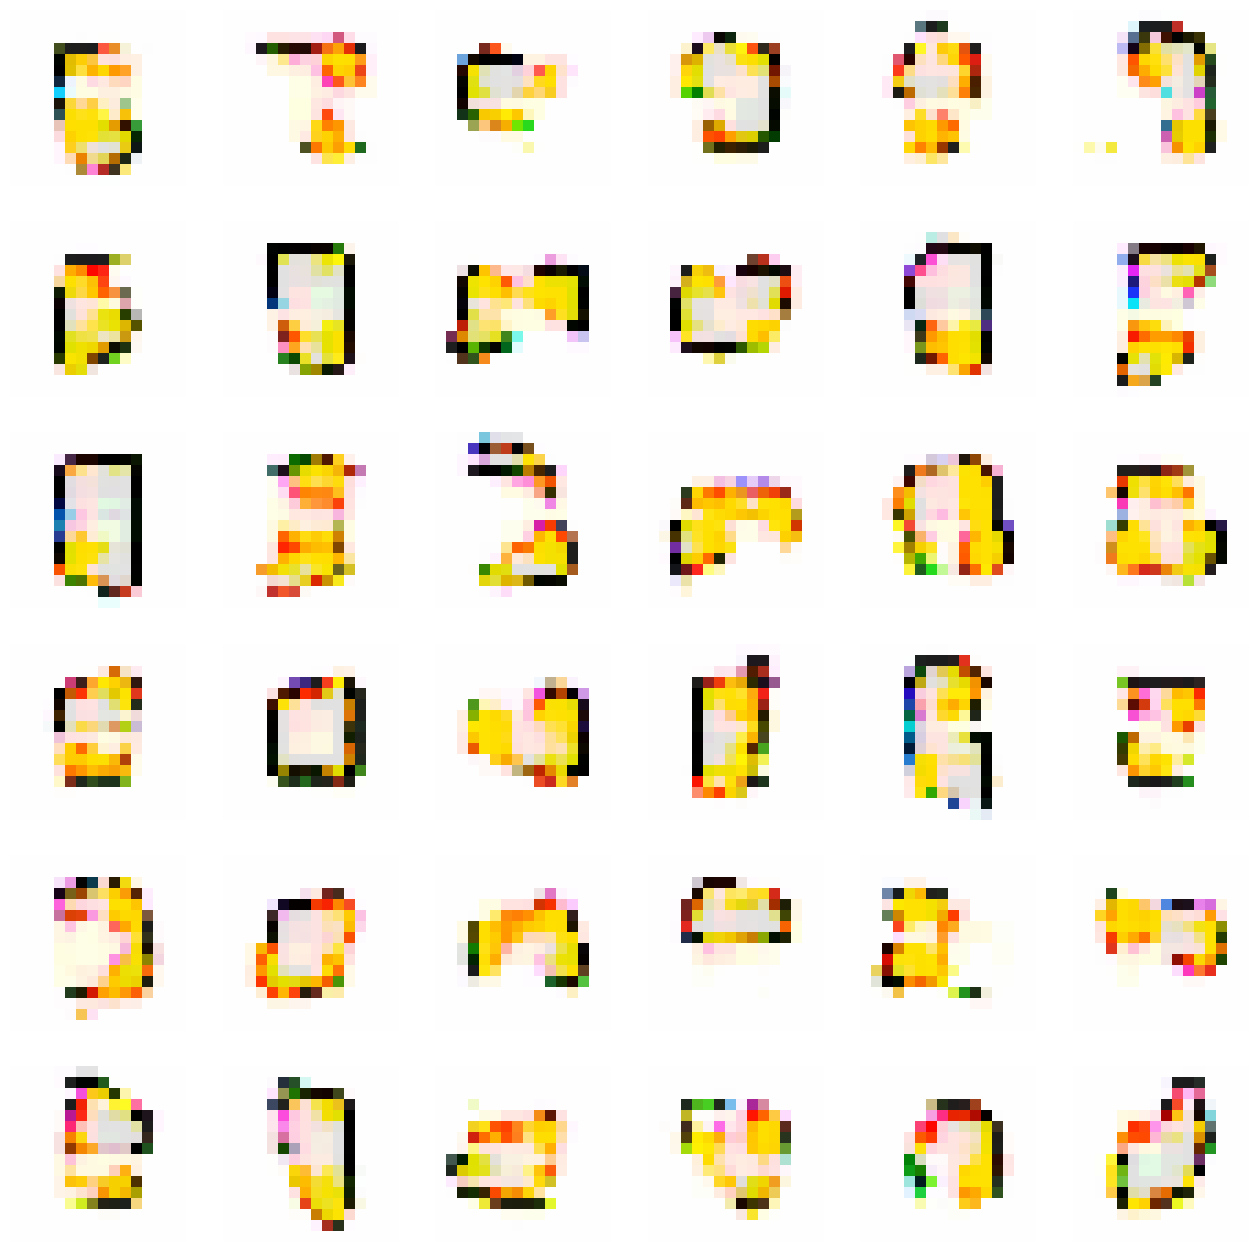

25/25 [==============================] - 128s 5s/step - d_loss: -5.4813 - g_loss: 7.1774
Epoch 46/50
25/25 [==============================] - ETA: 0s - d_loss: -5.7369 - g_loss: 8.4754

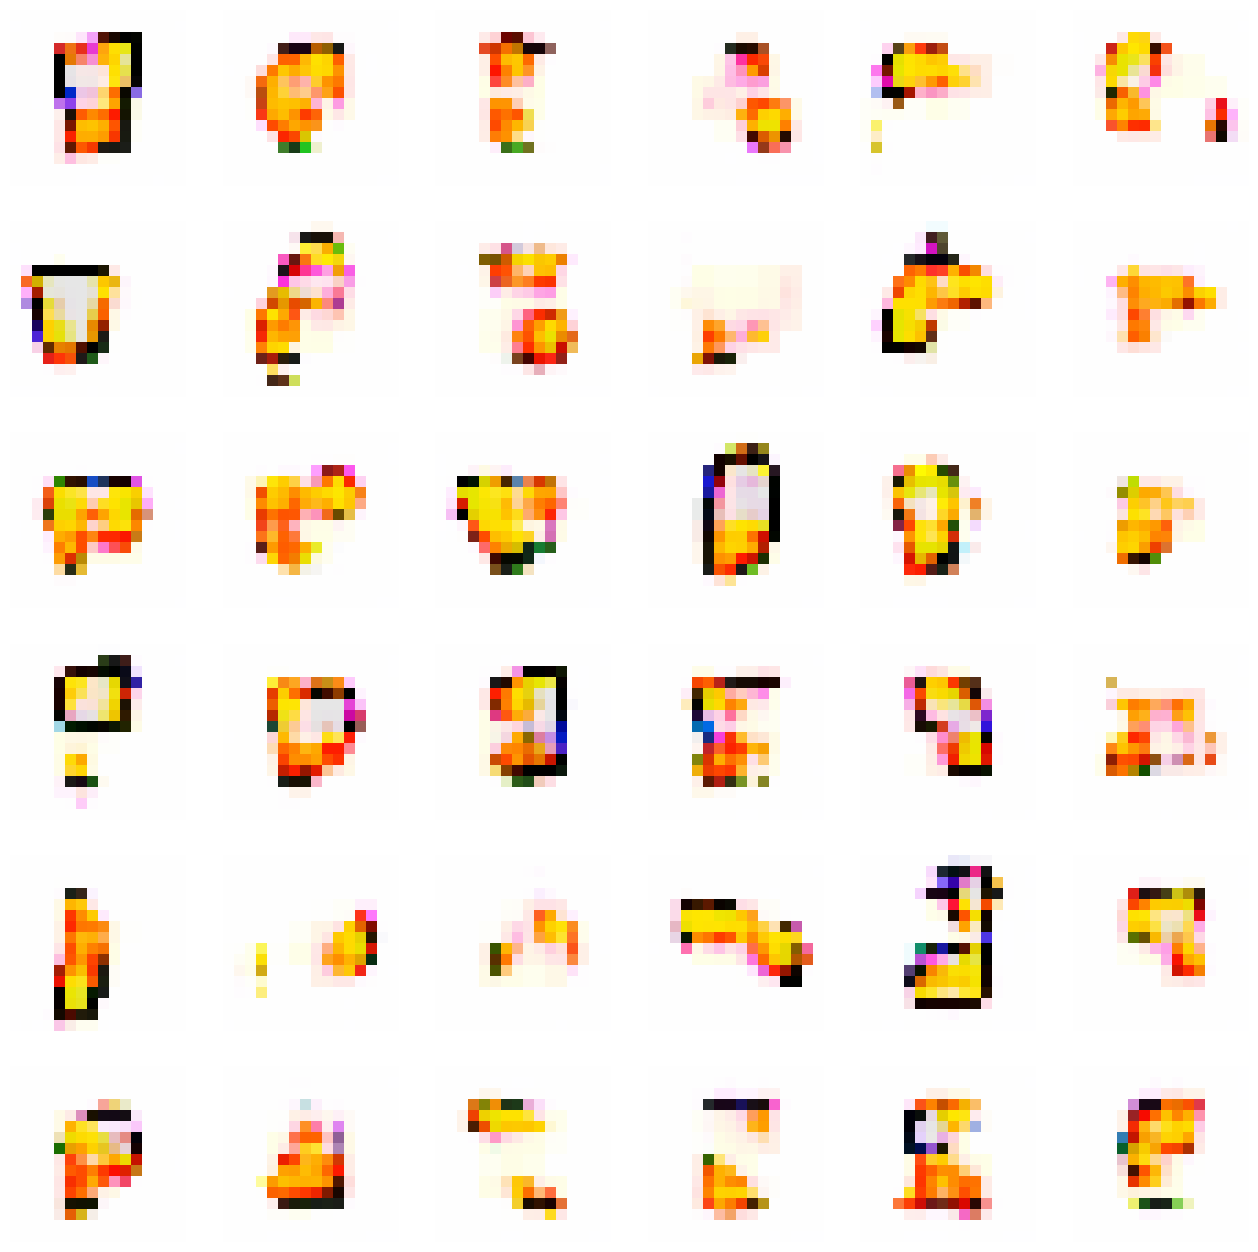

25/25 [==============================] - 126s 5s/step - d_loss: -5.7424 - g_loss: 9.1768
Epoch 47/50
25/25 [==============================] - ETA: 0s - d_loss: -5.3518 - g_loss: 5.5483

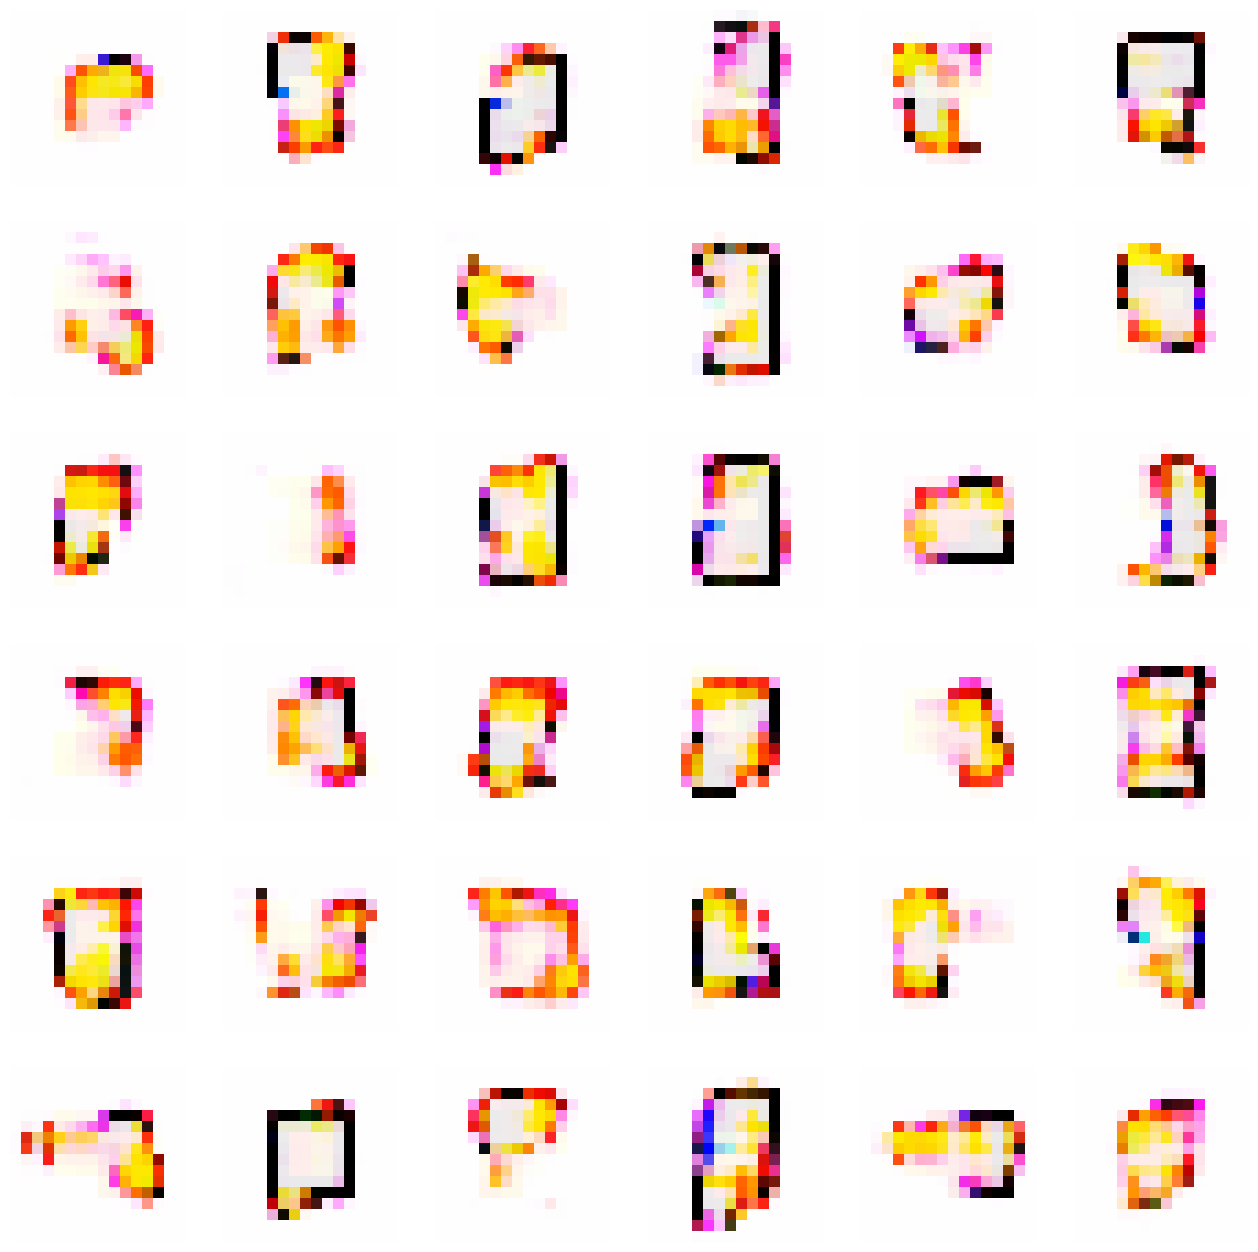

25/25 [==============================] - 124s 5s/step - d_loss: -5.4706 - g_loss: 5.0632
Epoch 48/50
25/25 [==============================] - ETA: 0s - d_loss: -5.8423 - g_loss: 7.8011

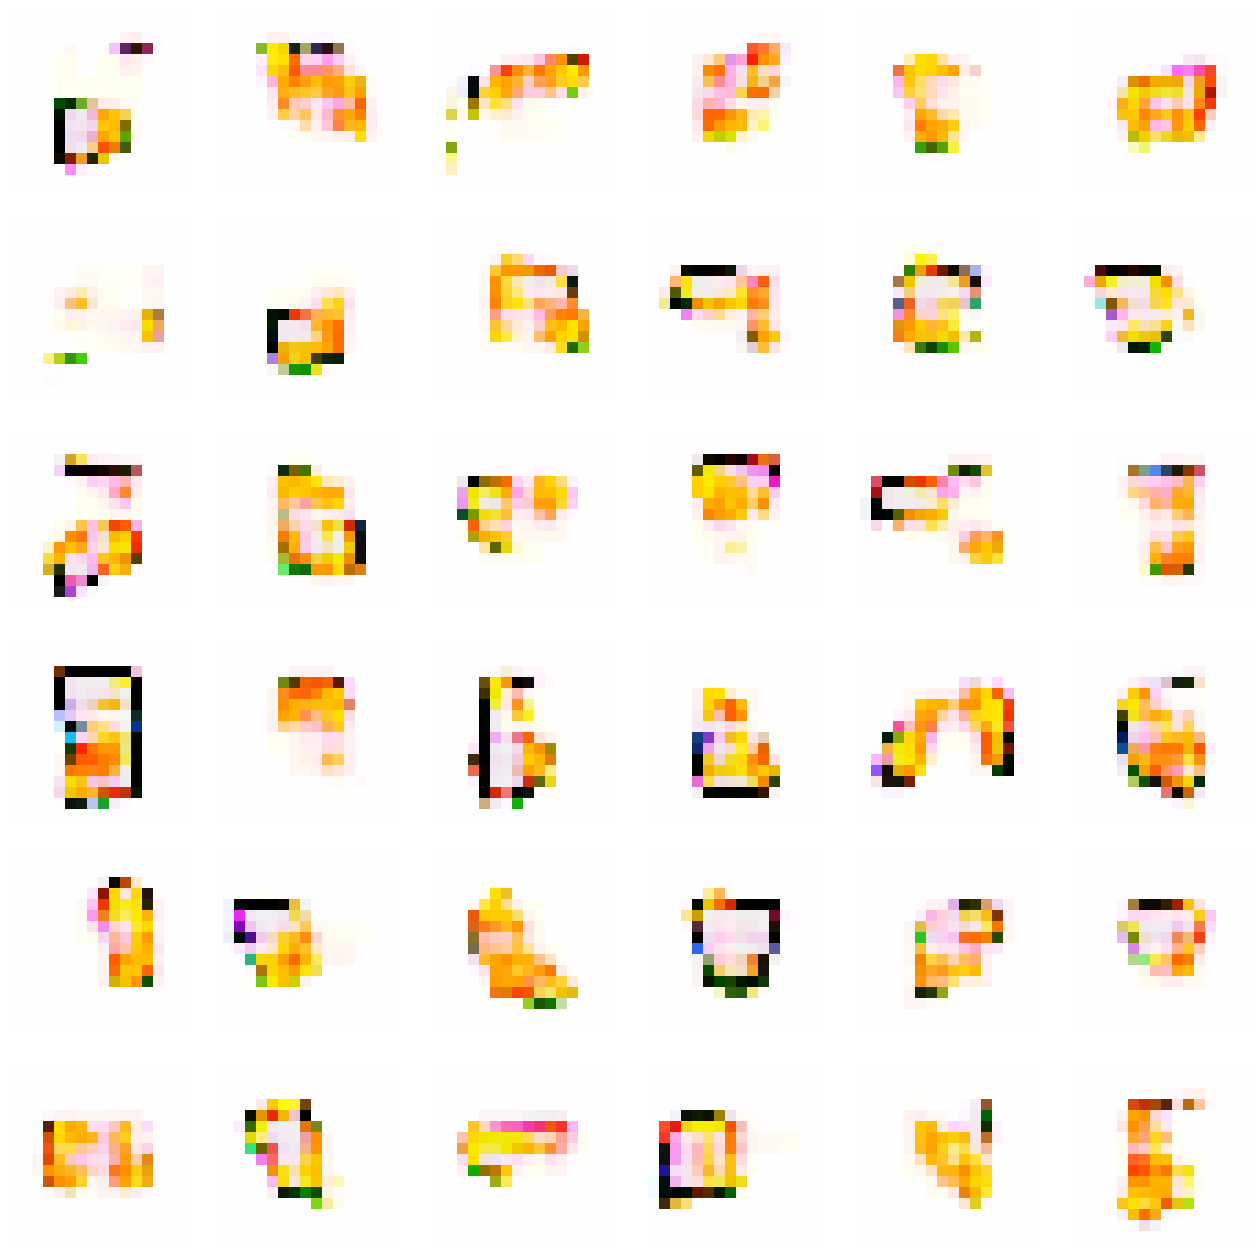

25/25 [==============================] - 118s 5s/step - d_loss: -5.9019 - g_loss: 7.7006
Epoch 49/50
25/25 [==============================] - ETA: 0s - d_loss: -5.9788 - g_loss: 7.8670

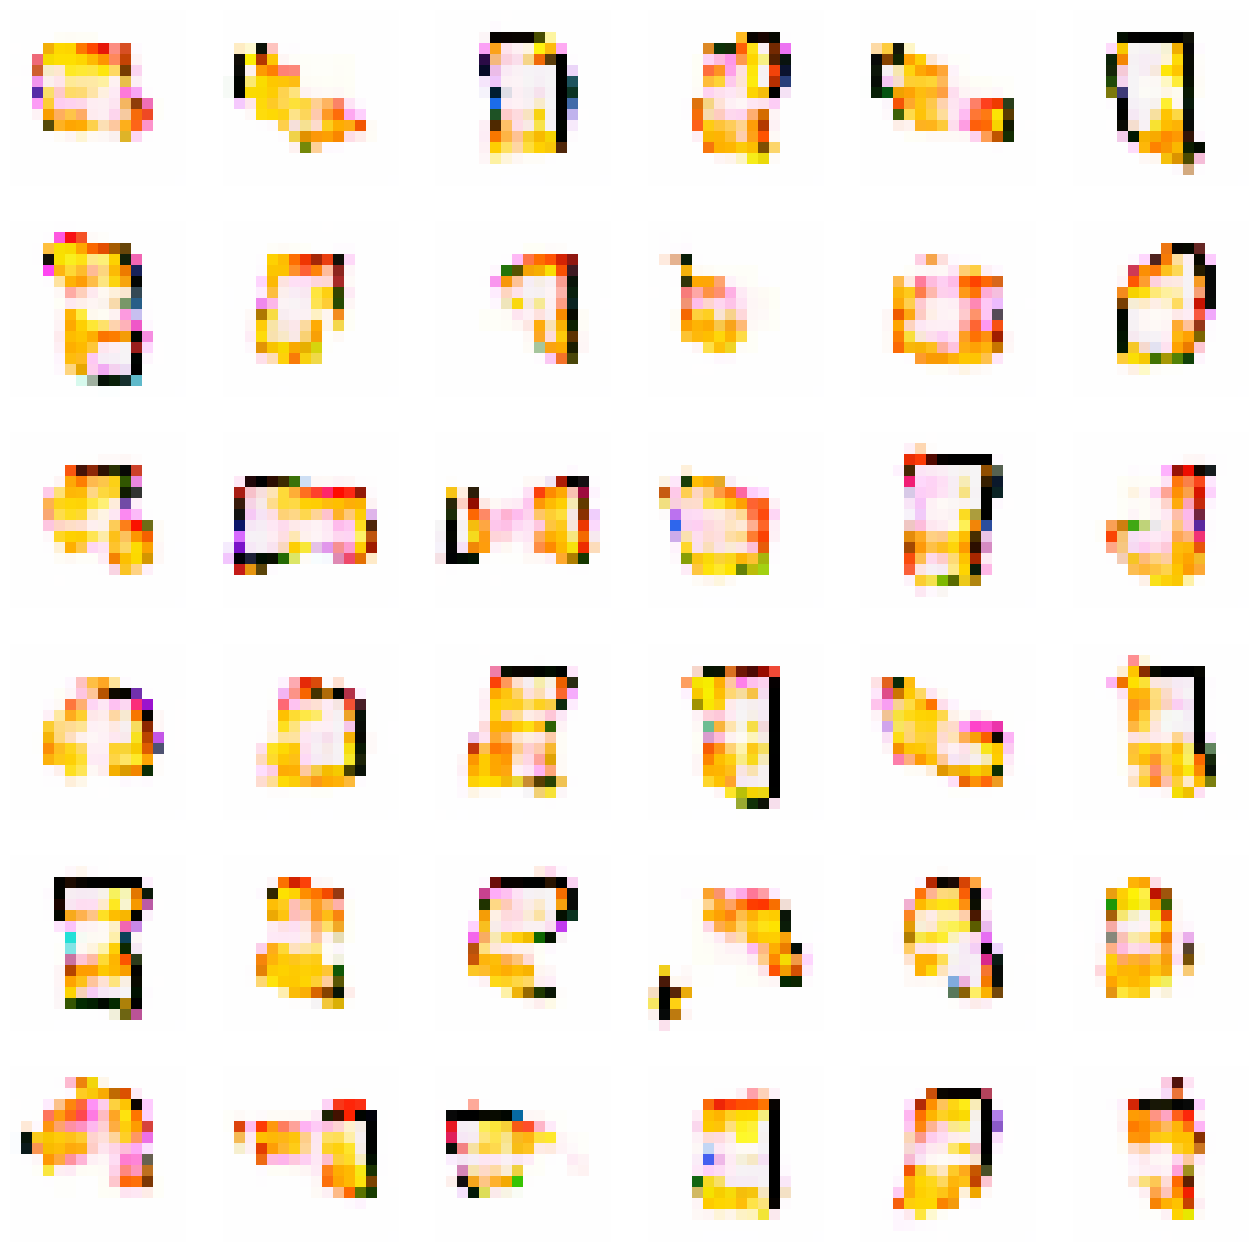

25/25 [==============================] - 131s 5s/step - d_loss: -6.0283 - g_loss: 8.1546
Epoch 50/50
25/25 [==============================] - ETA: 0s - d_loss: -5.6538 - g_loss: 7.0948

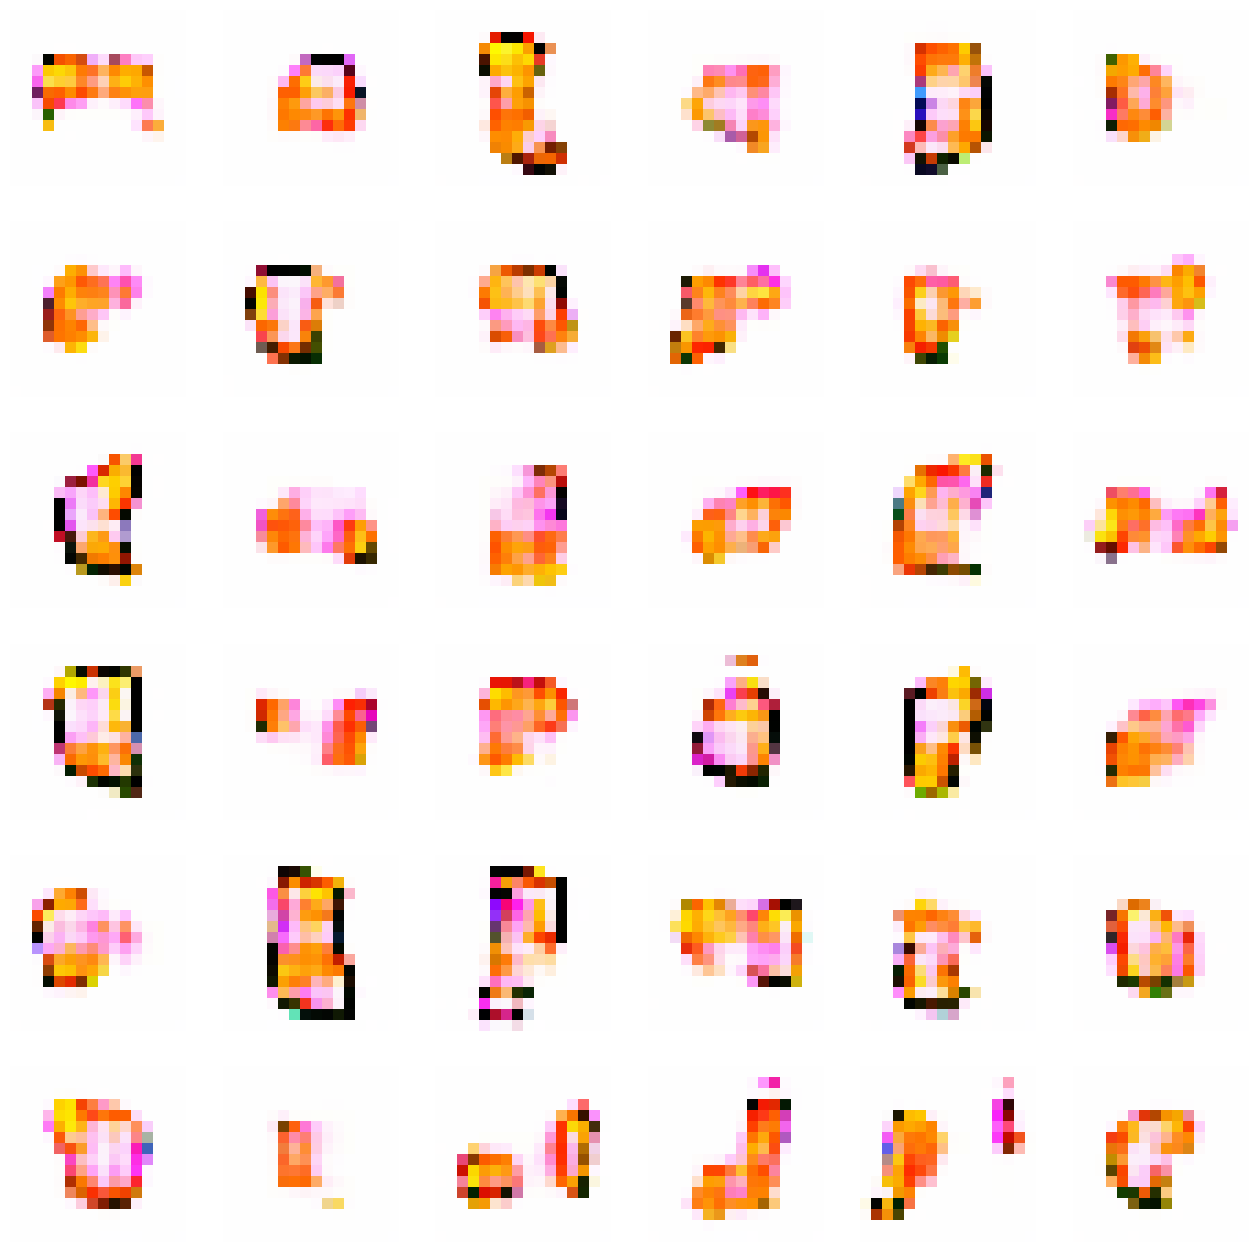

25/25 [==============================] - 126s 5s/step - d_loss: -5.6883 - g_loss: 7.2618
Model: "generator_stabilize"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_39 (InputLayer)       [(None, 512)]                0         []                            
                                                                                                  
 input_40 (InputLayer)       [(None, 256)]                0         []                            
                                                                                                  
 concatenate_17 (Concatenat  (None, 768)                  0         ['input_39[0][0]',            
 e)                                                                  'input_40[0][0]']            
                                                                                          

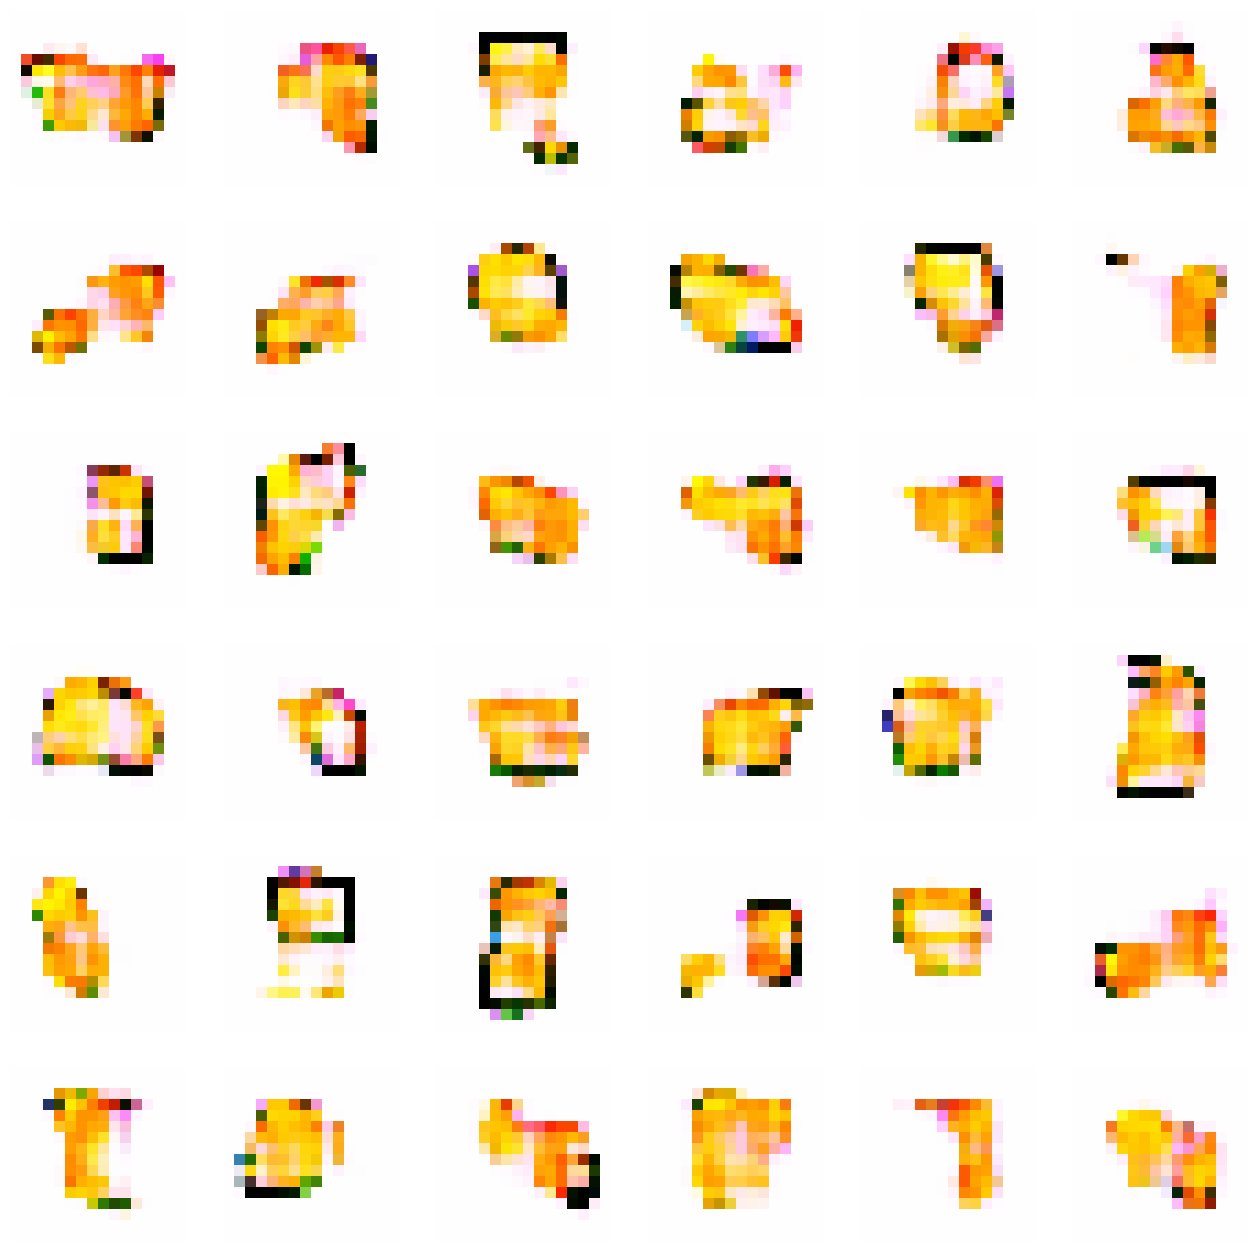

25/25 [==============================] - 132s 5s/step - d_loss: -5.8185 - g_loss: 8.1004
Epoch 2/50
25/25 [==============================] - ETA: 0s - d_loss: -5.9835 - g_loss: 7.8811

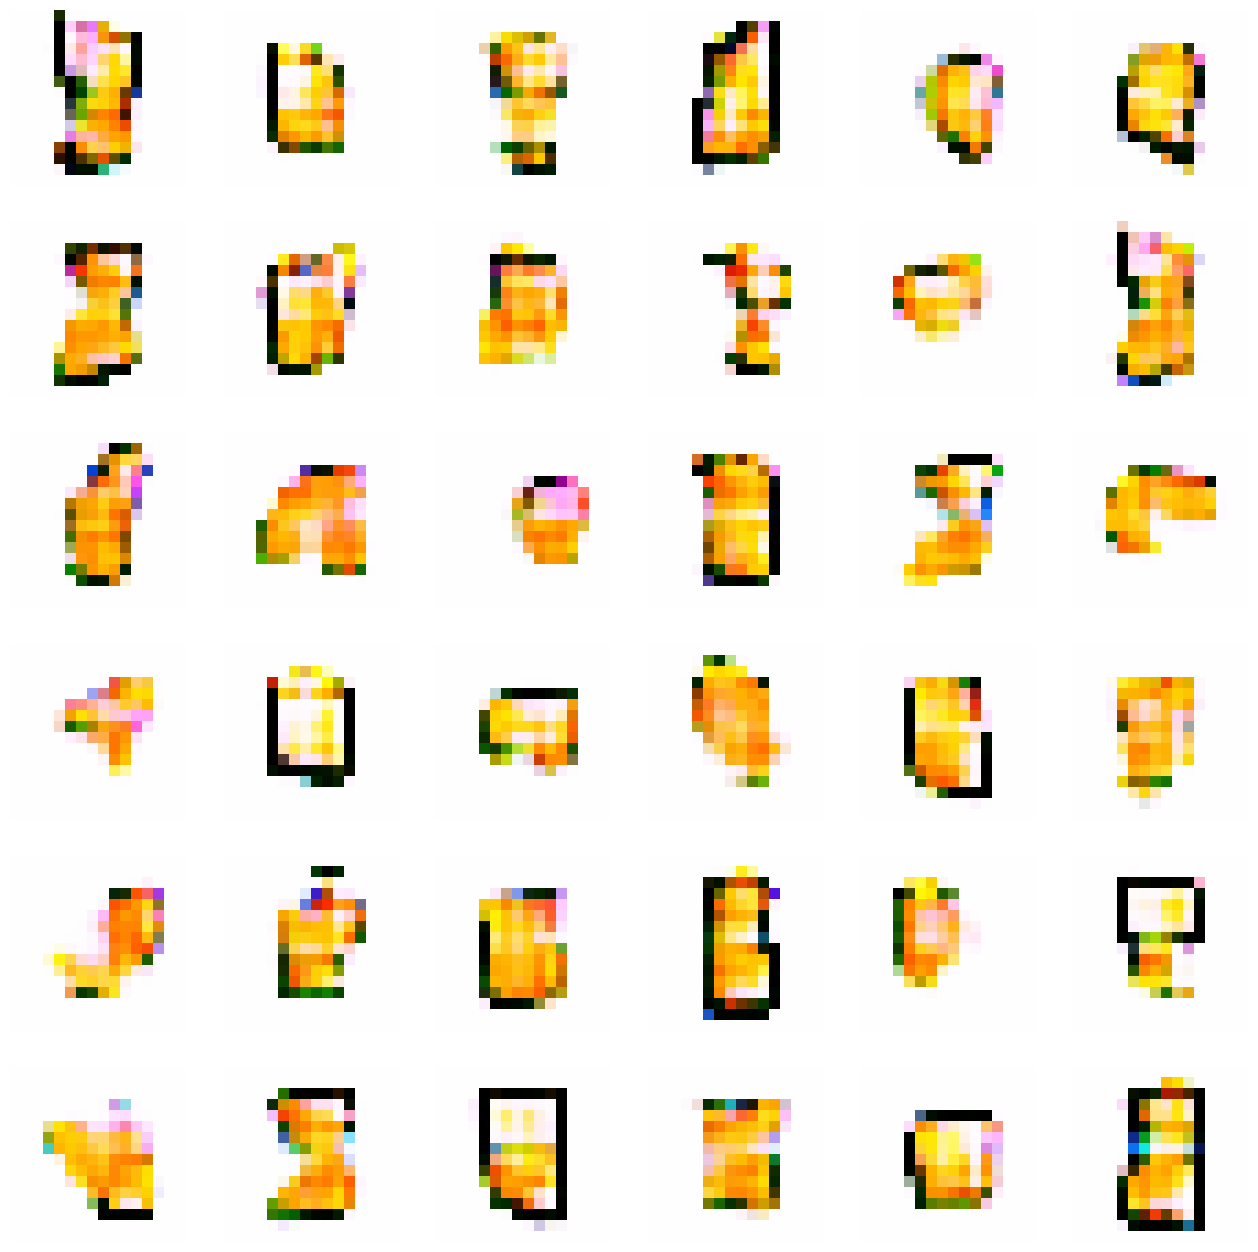

25/25 [==============================] - 128s 5s/step - d_loss: -5.9687 - g_loss: 8.1947
Epoch 3/50
25/25 [==============================] - ETA: 0s - d_loss: -5.8468 - g_loss: 7.3453

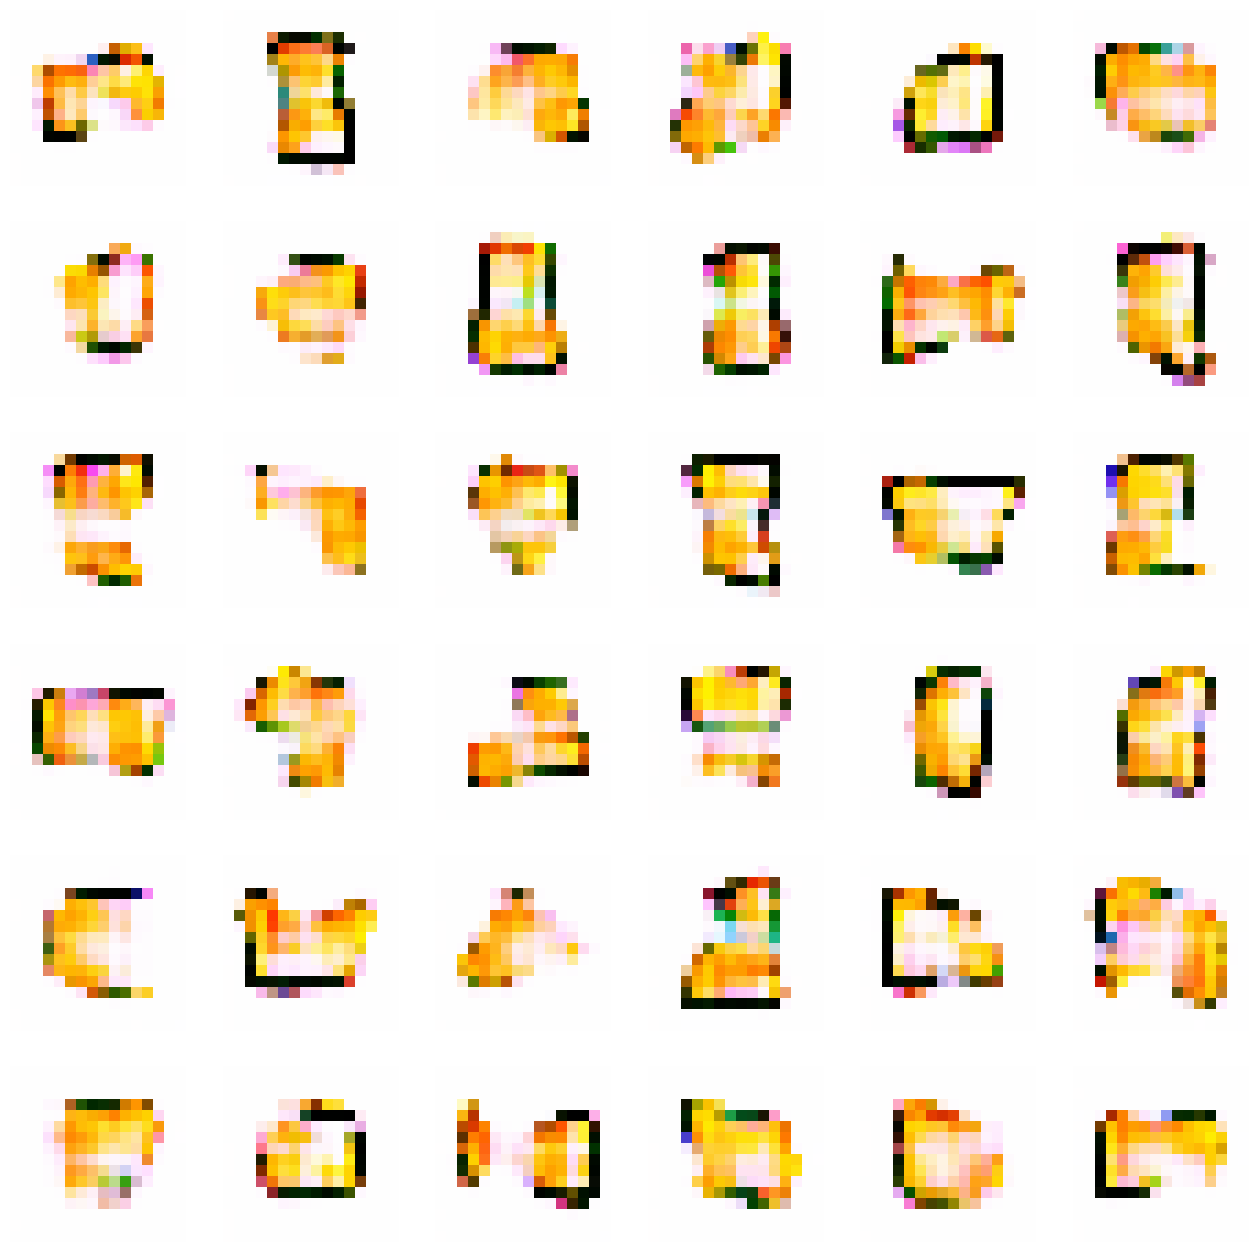

25/25 [==============================] - 132s 5s/step - d_loss: -5.8013 - g_loss: 7.3284
Epoch 4/50
25/25 [==============================] - ETA: 0s - d_loss: -5.7934 - g_loss: 8.3904

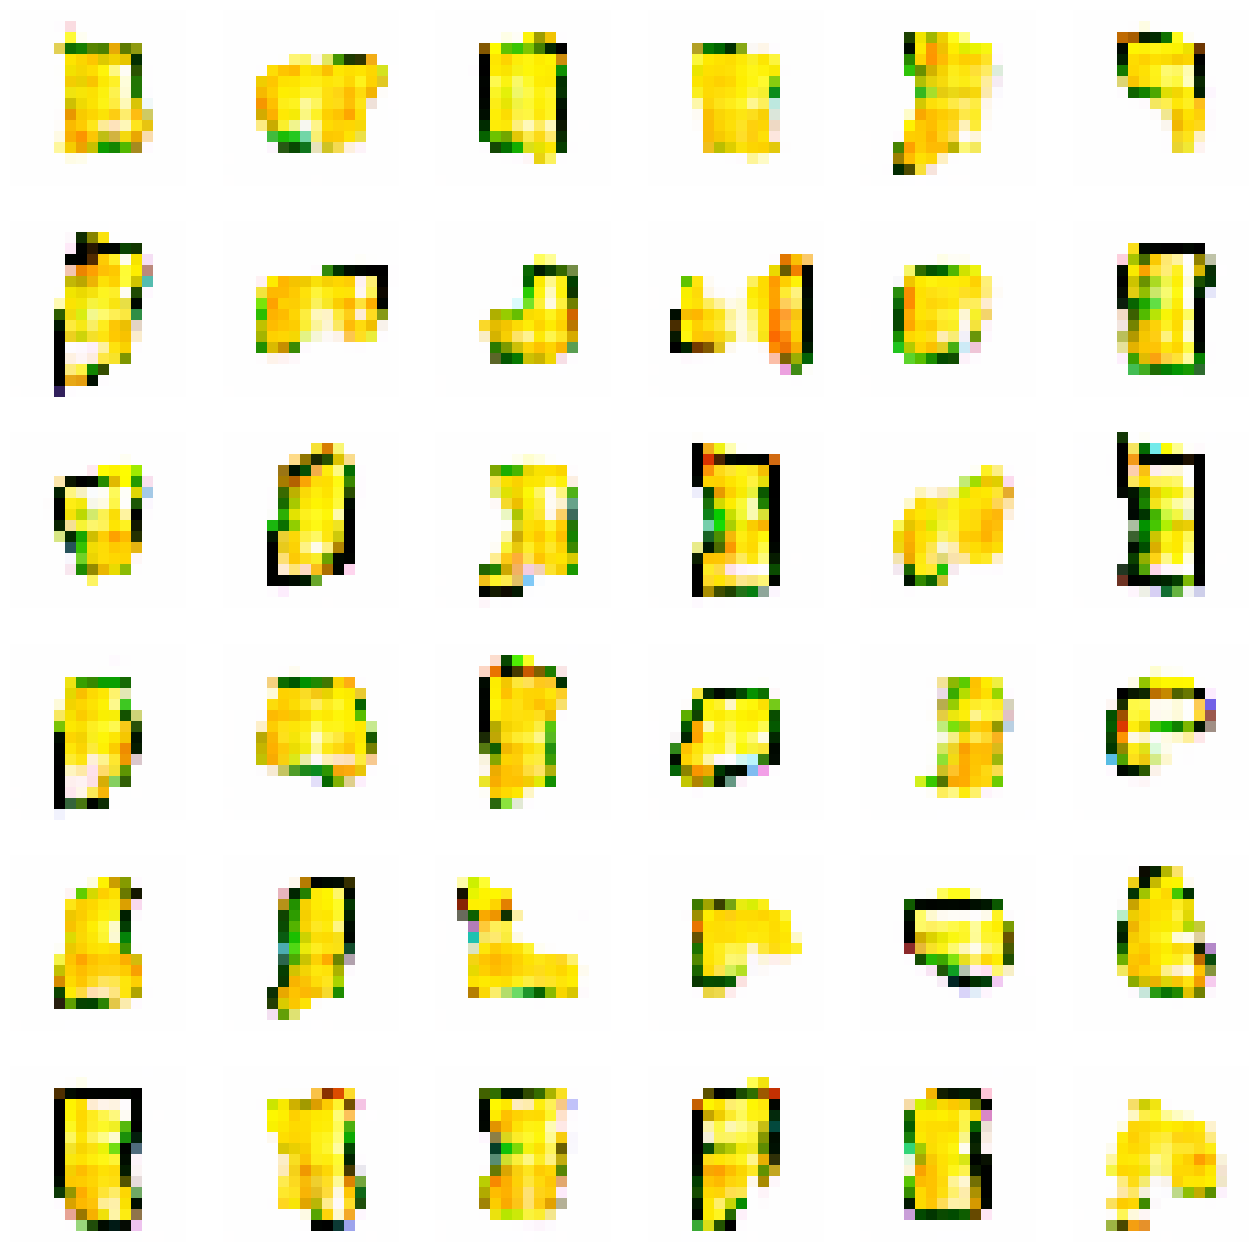

25/25 [==============================] - 126s 5s/step - d_loss: -5.7356 - g_loss: 8.7954
Epoch 5/50
25/25 [==============================] - ETA: 0s - d_loss: -5.9516 - g_loss: 7.6541

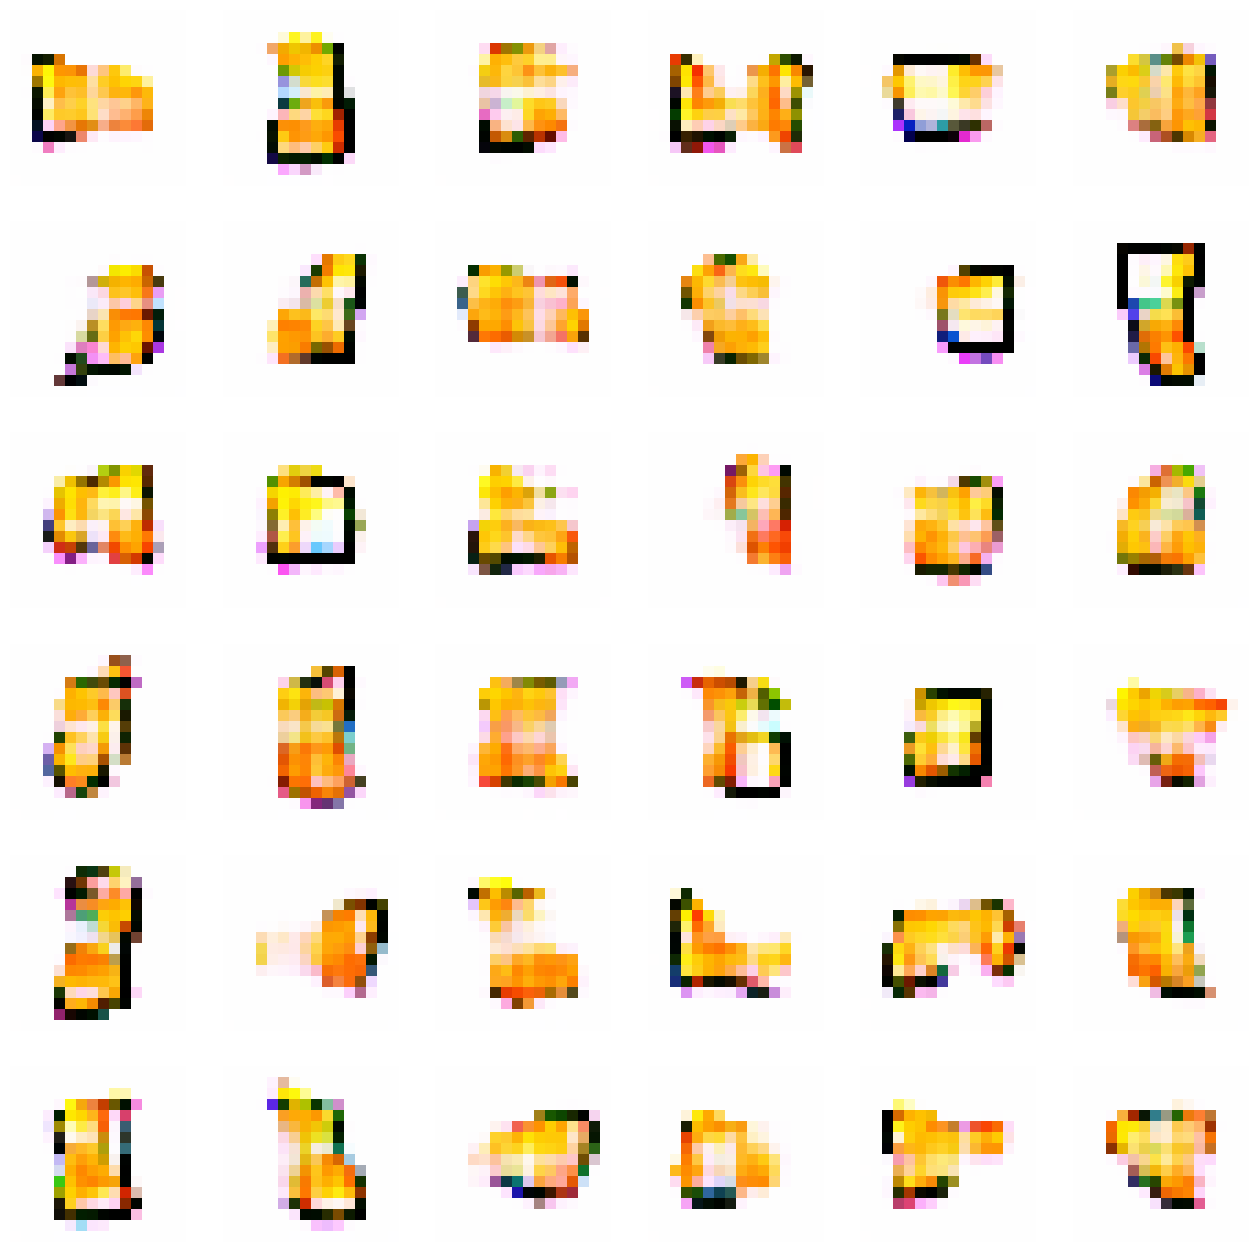

25/25 [==============================] - 121s 5s/step - d_loss: -5.9417 - g_loss: 8.5914
Epoch 6/50
25/25 [==============================] - ETA: 0s - d_loss: -5.9084 - g_loss: 7.2256

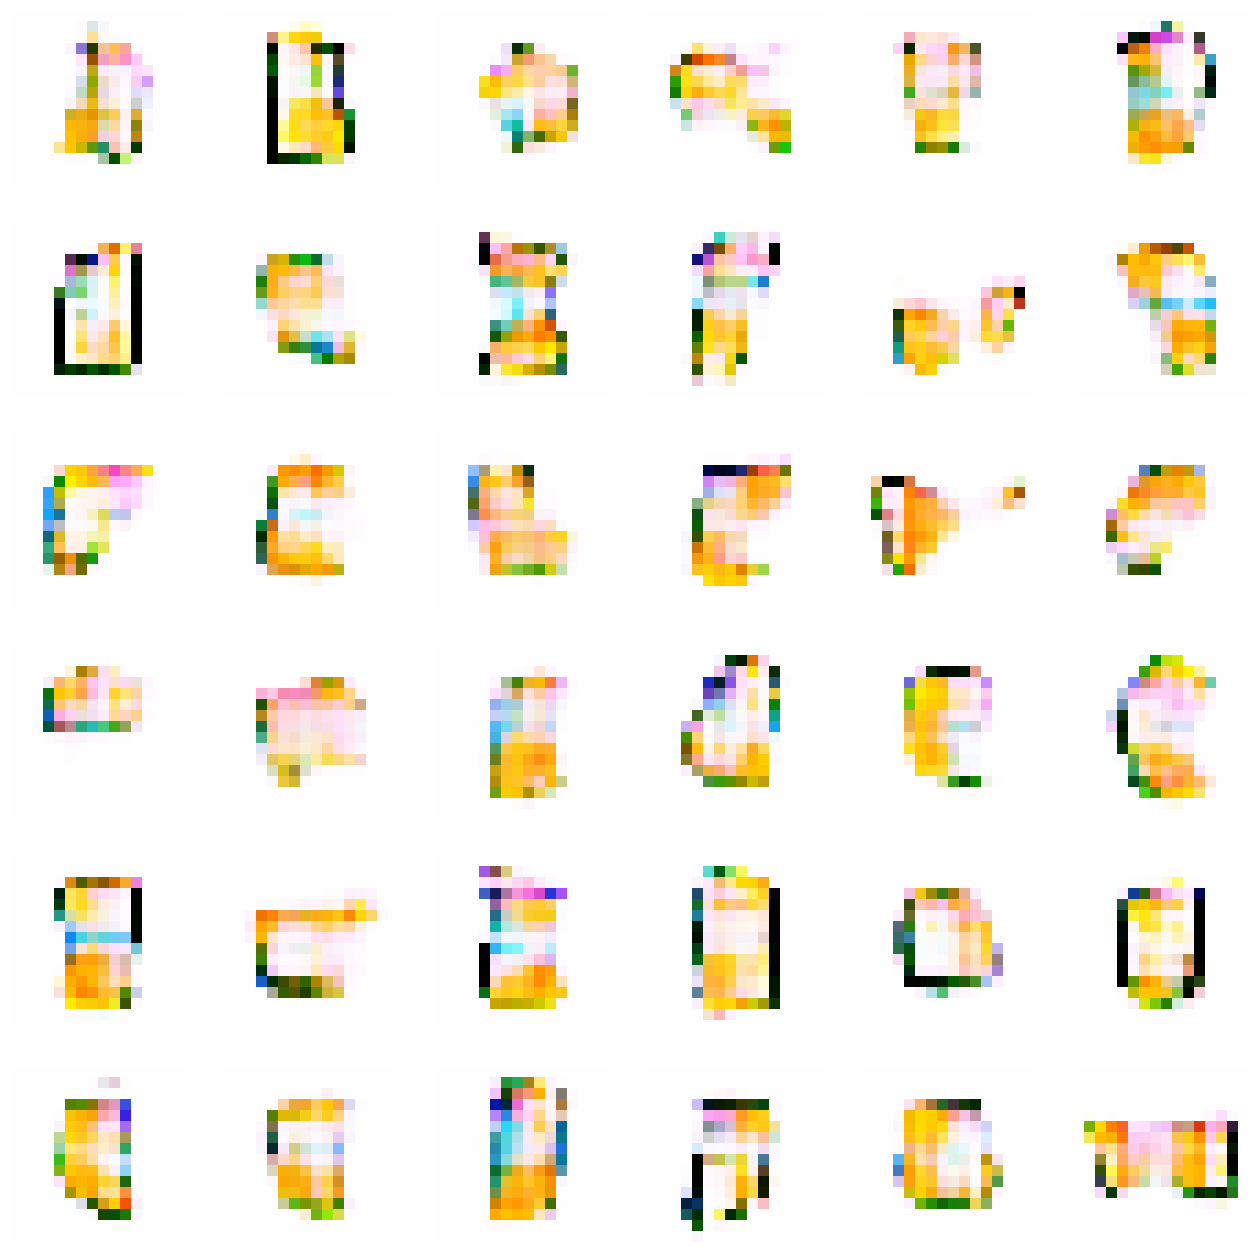

25/25 [==============================] - 118s 5s/step - d_loss: -5.9305 - g_loss: 7.0570
Epoch 7/50
25/25 [==============================] - ETA: 0s - d_loss: -6.3049 - g_loss: 7.7911

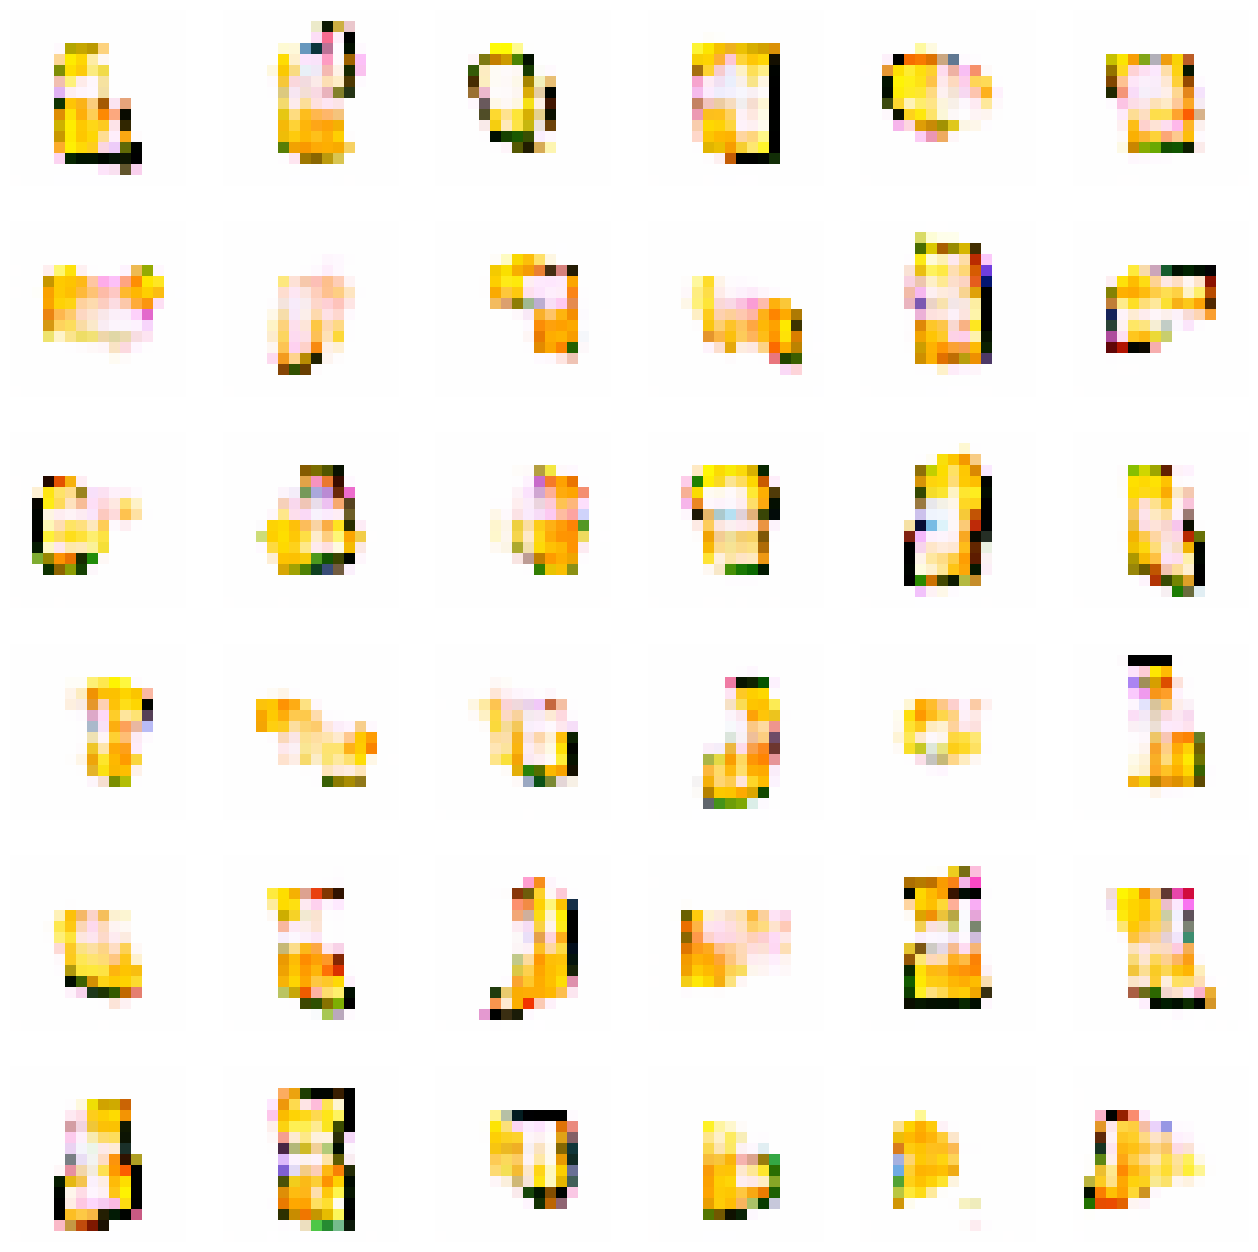

25/25 [==============================] - 118s 5s/step - d_loss: -6.3285 - g_loss: 7.6225
Epoch 8/50
25/25 [==============================] - ETA: 0s - d_loss: -6.1016 - g_loss: 8.9756

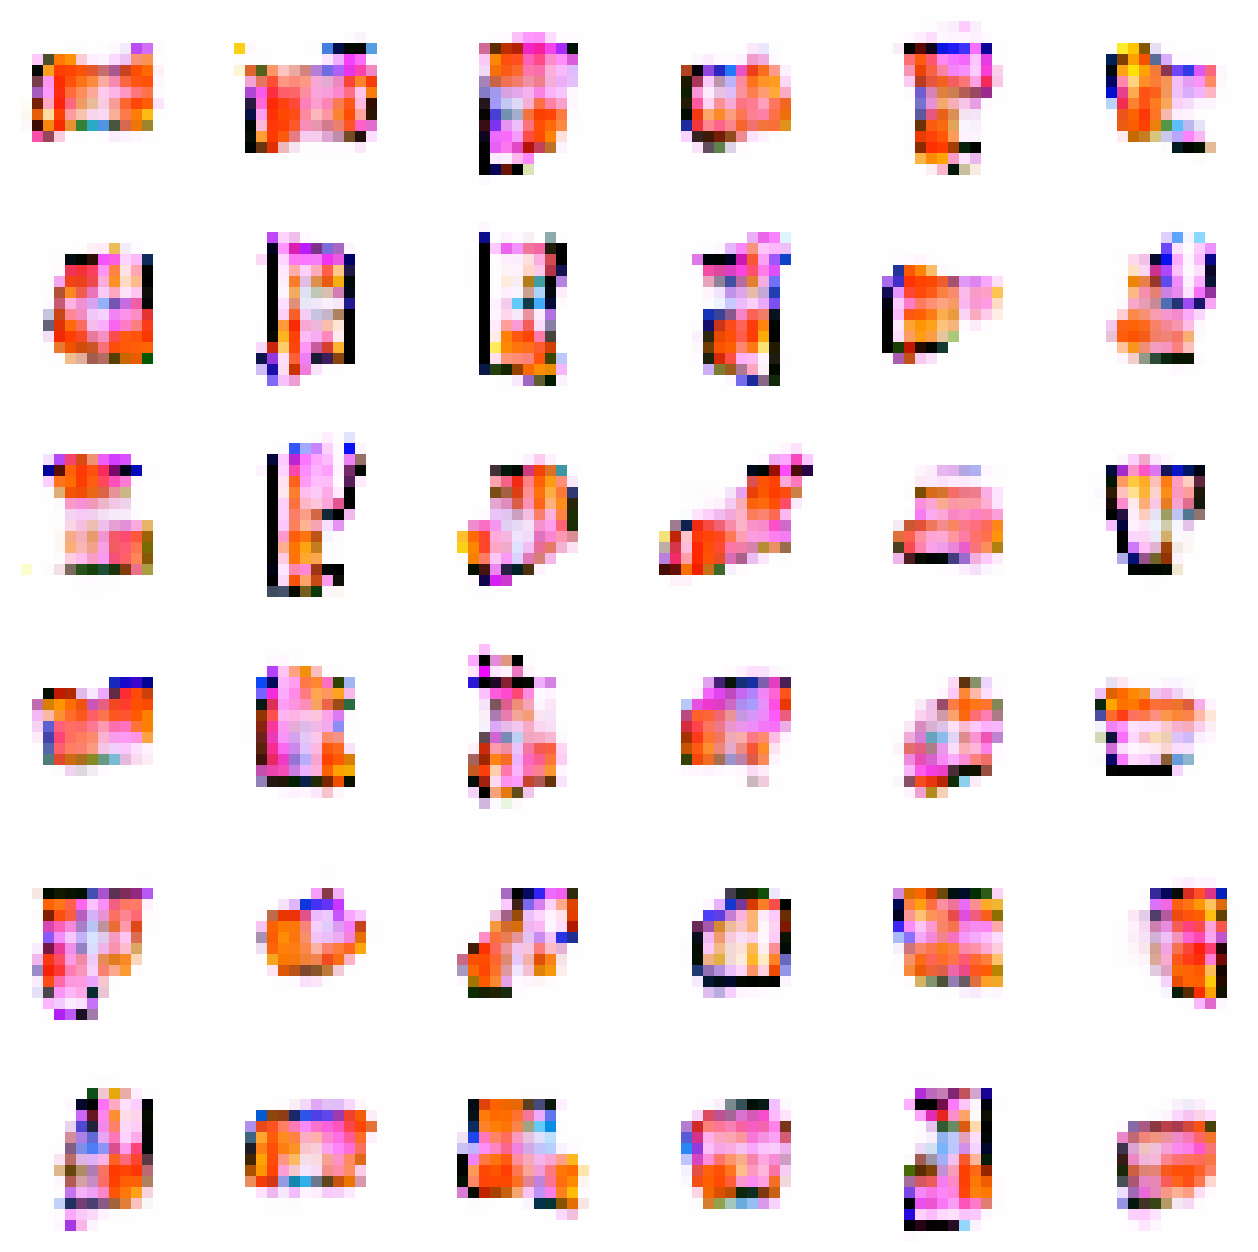

25/25 [==============================] - 120s 5s/step - d_loss: -6.0929 - g_loss: 9.9416
Epoch 9/50
25/25 [==============================] - ETA: 0s - d_loss: -6.1904 - g_loss: 7.1402

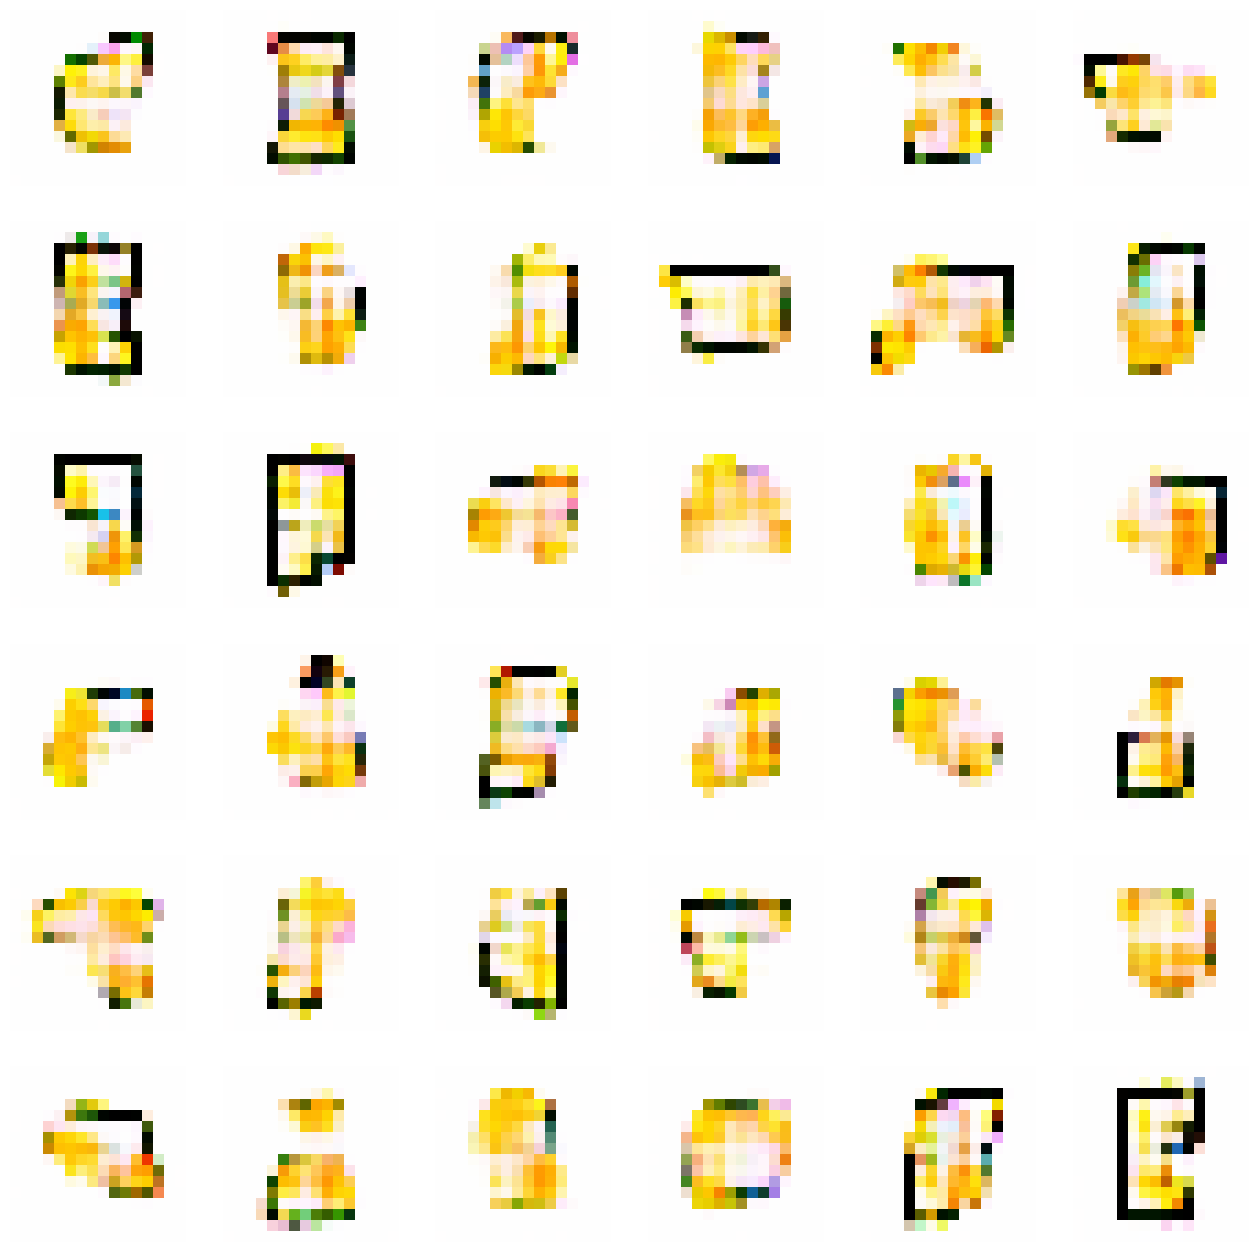

25/25 [==============================] - 118s 5s/step - d_loss: -6.1294 - g_loss: 6.8487
Epoch 10/50
25/25 [==============================] - ETA: 0s - d_loss: -6.0321 - g_loss: 9.0103

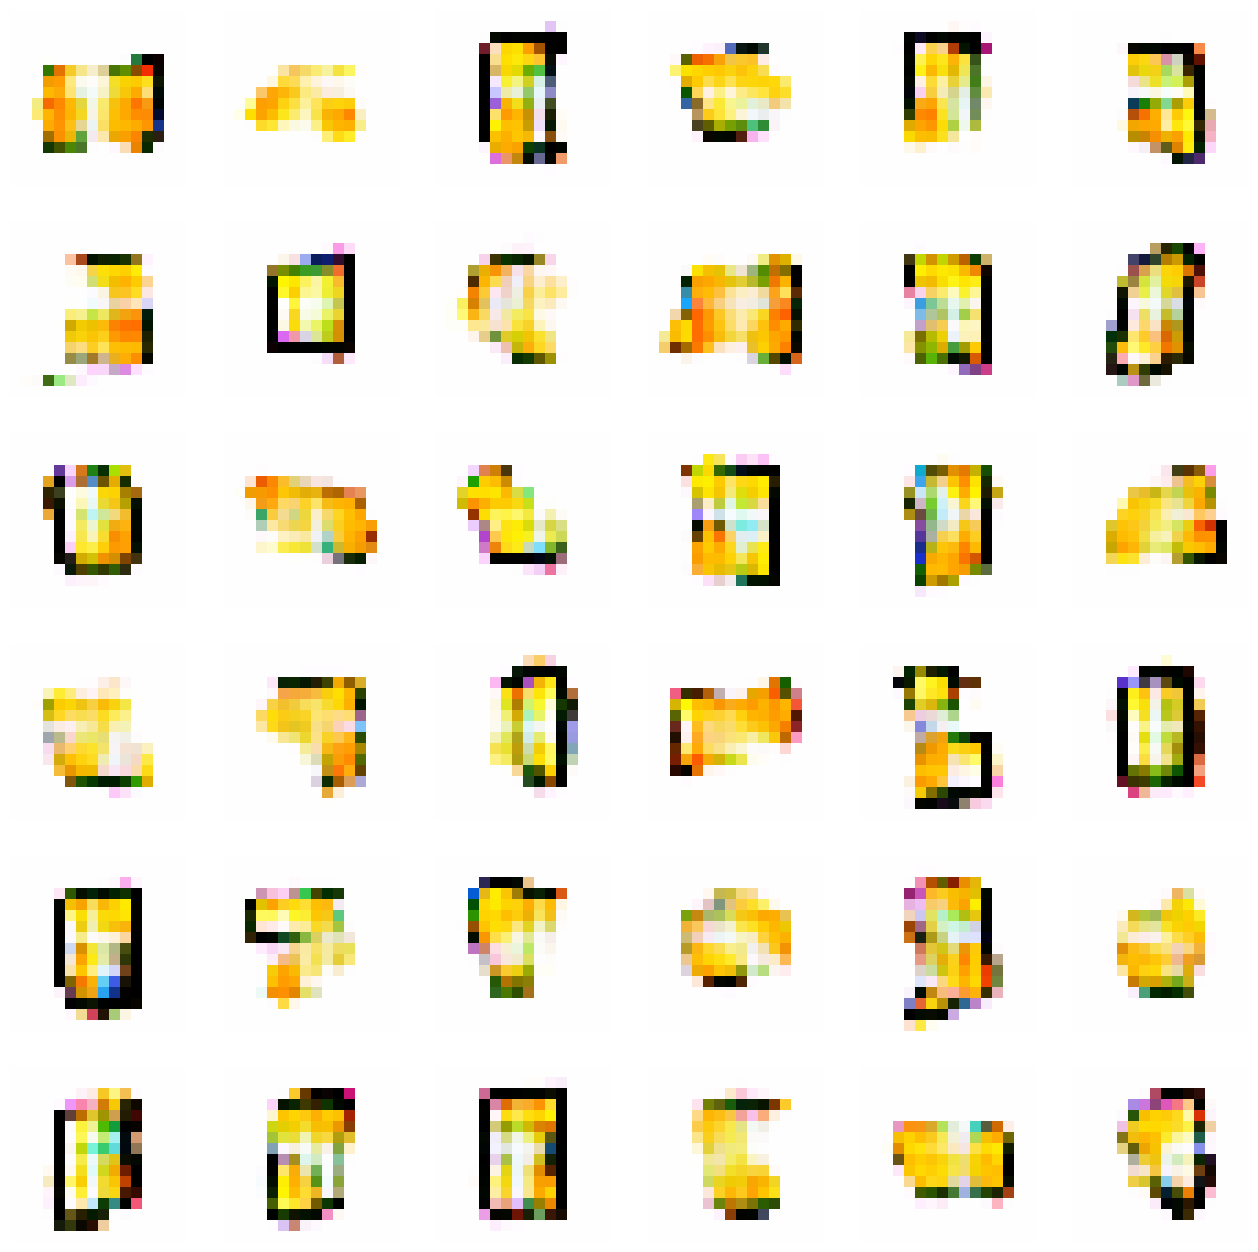

25/25 [==============================] - 121s 5s/step - d_loss: -5.8750 - g_loss: 9.8358
Epoch 11/50
25/25 [==============================] - ETA: 0s - d_loss: -6.2175 - g_loss: 7.3025

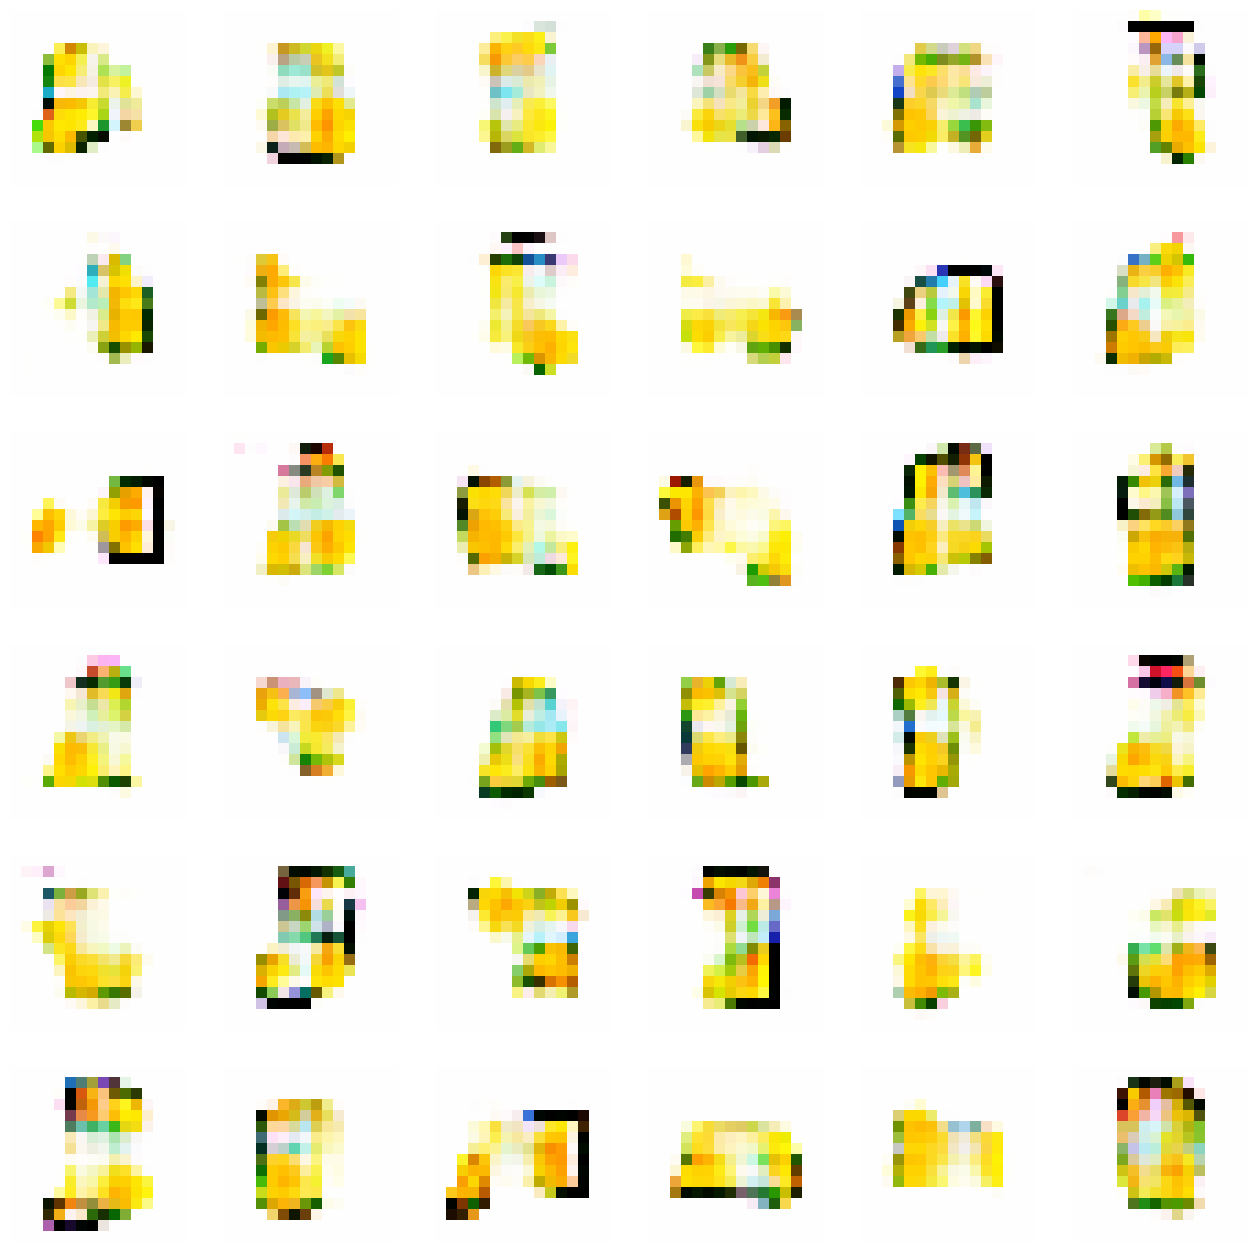

25/25 [==============================] - 123s 5s/step - d_loss: -6.2401 - g_loss: 6.8725
Epoch 12/50
25/25 [==============================] - ETA: 0s - d_loss: -5.8693 - g_loss: 8.2604

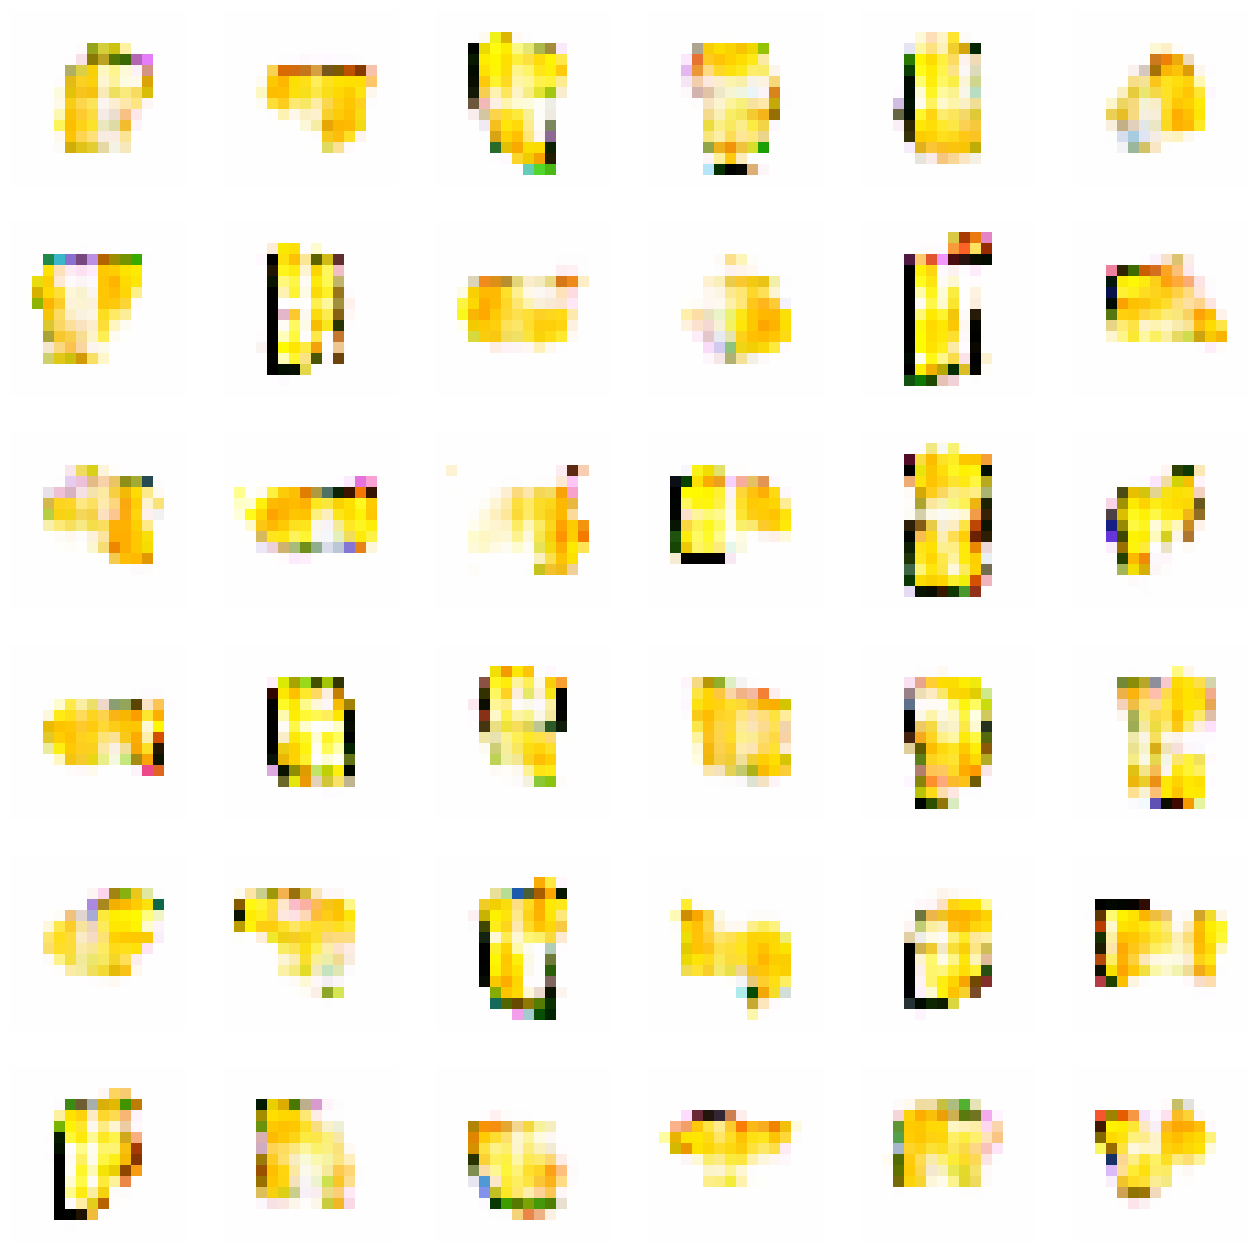

25/25 [==============================] - 122s 5s/step - d_loss: -5.9327 - g_loss: 8.7018
Epoch 13/50
25/25 [==============================] - ETA: 0s - d_loss: -6.2062 - g_loss: 8.2993

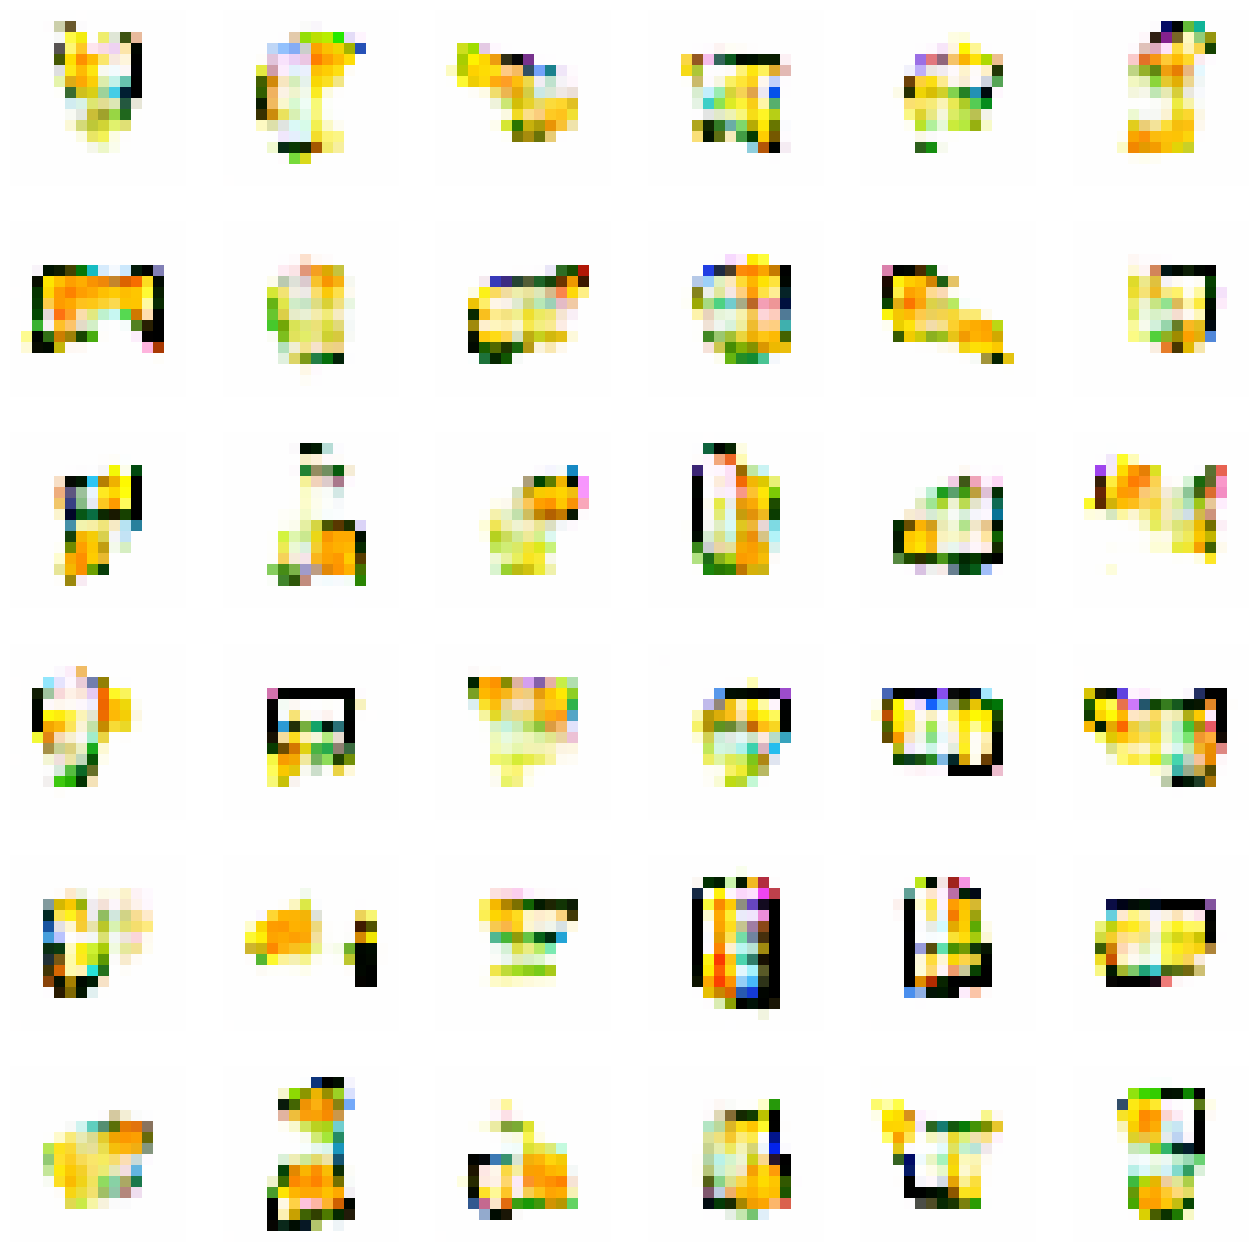

25/25 [==============================] - 130s 5s/step - d_loss: -6.1861 - g_loss: 8.1463
Epoch 14/50
25/25 [==============================] - ETA: 0s - d_loss: -6.5090 - g_loss: 7.7080

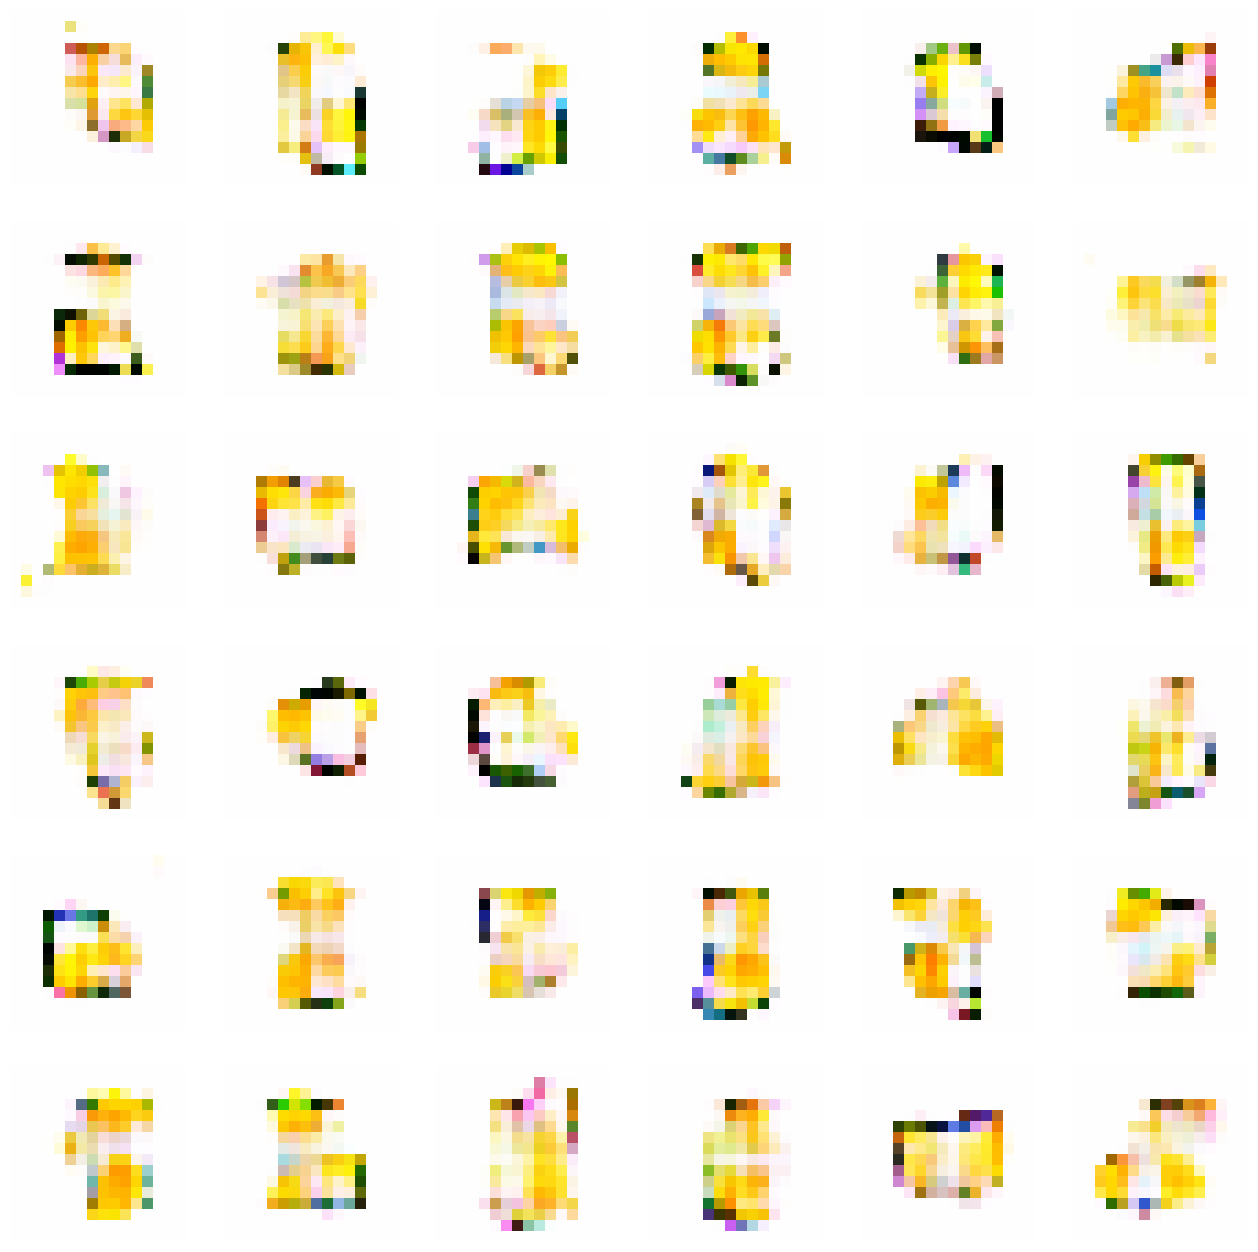

25/25 [==============================] - 124s 5s/step - d_loss: -6.4510 - g_loss: 8.1128
Epoch 15/50
25/25 [==============================] - ETA: 0s - d_loss: -6.3042 - g_loss: 8.0844

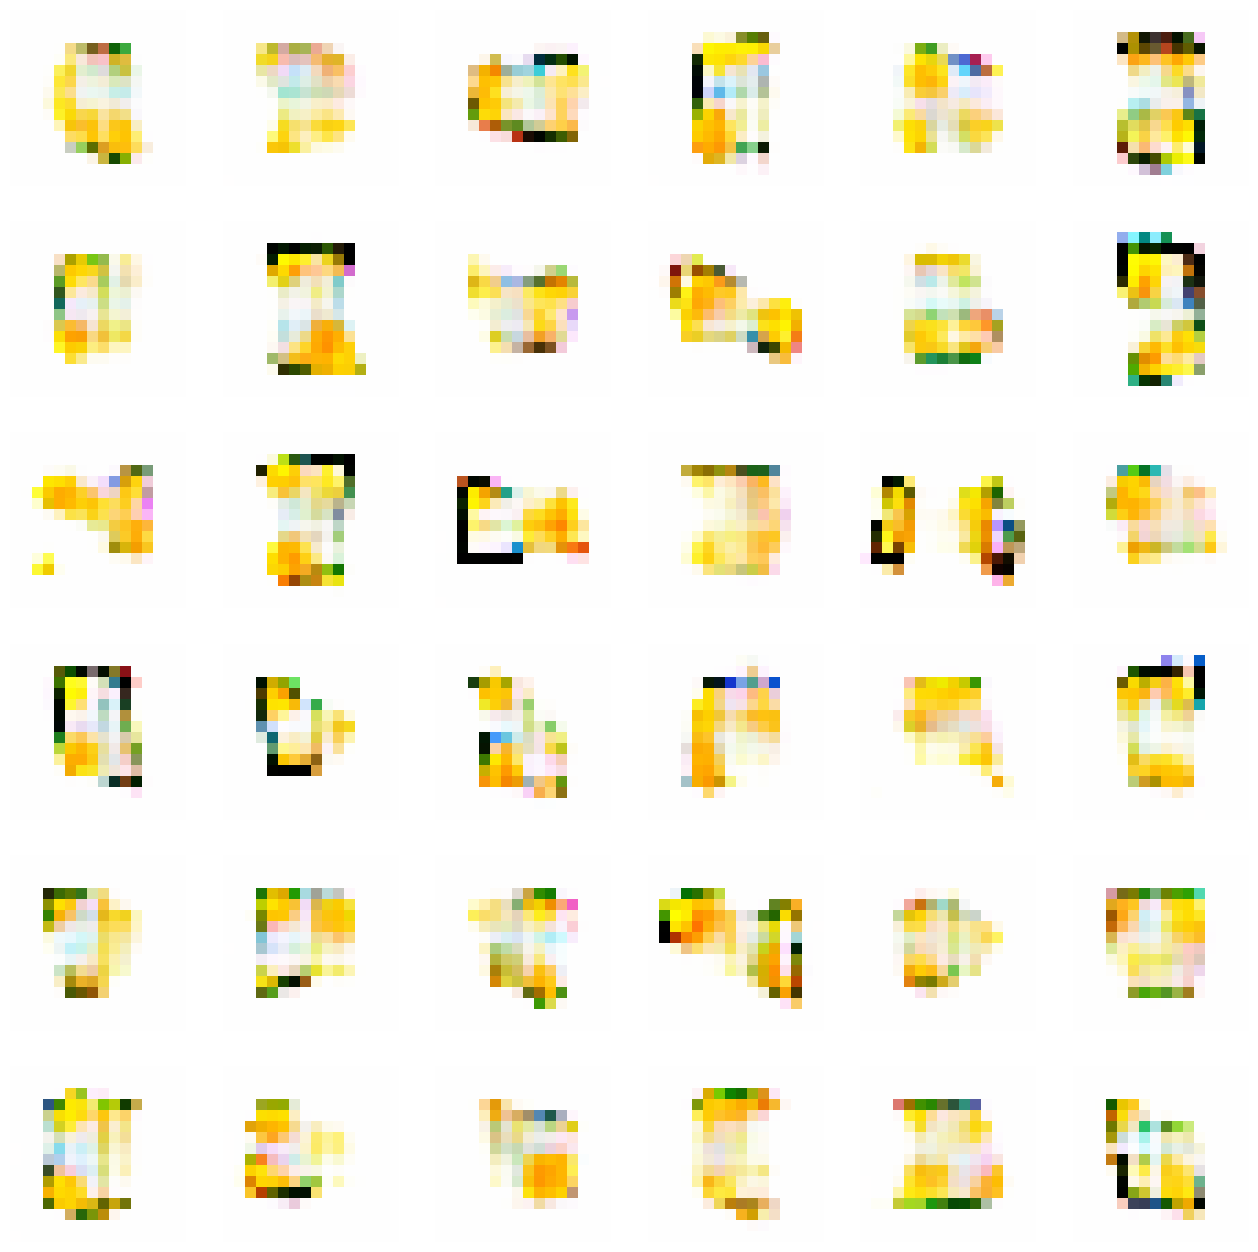

25/25 [==============================] - 122s 5s/step - d_loss: -6.3682 - g_loss: 8.0721
Epoch 16/50
25/25 [==============================] - ETA: 0s - d_loss: -6.3210 - g_loss: 8.0121

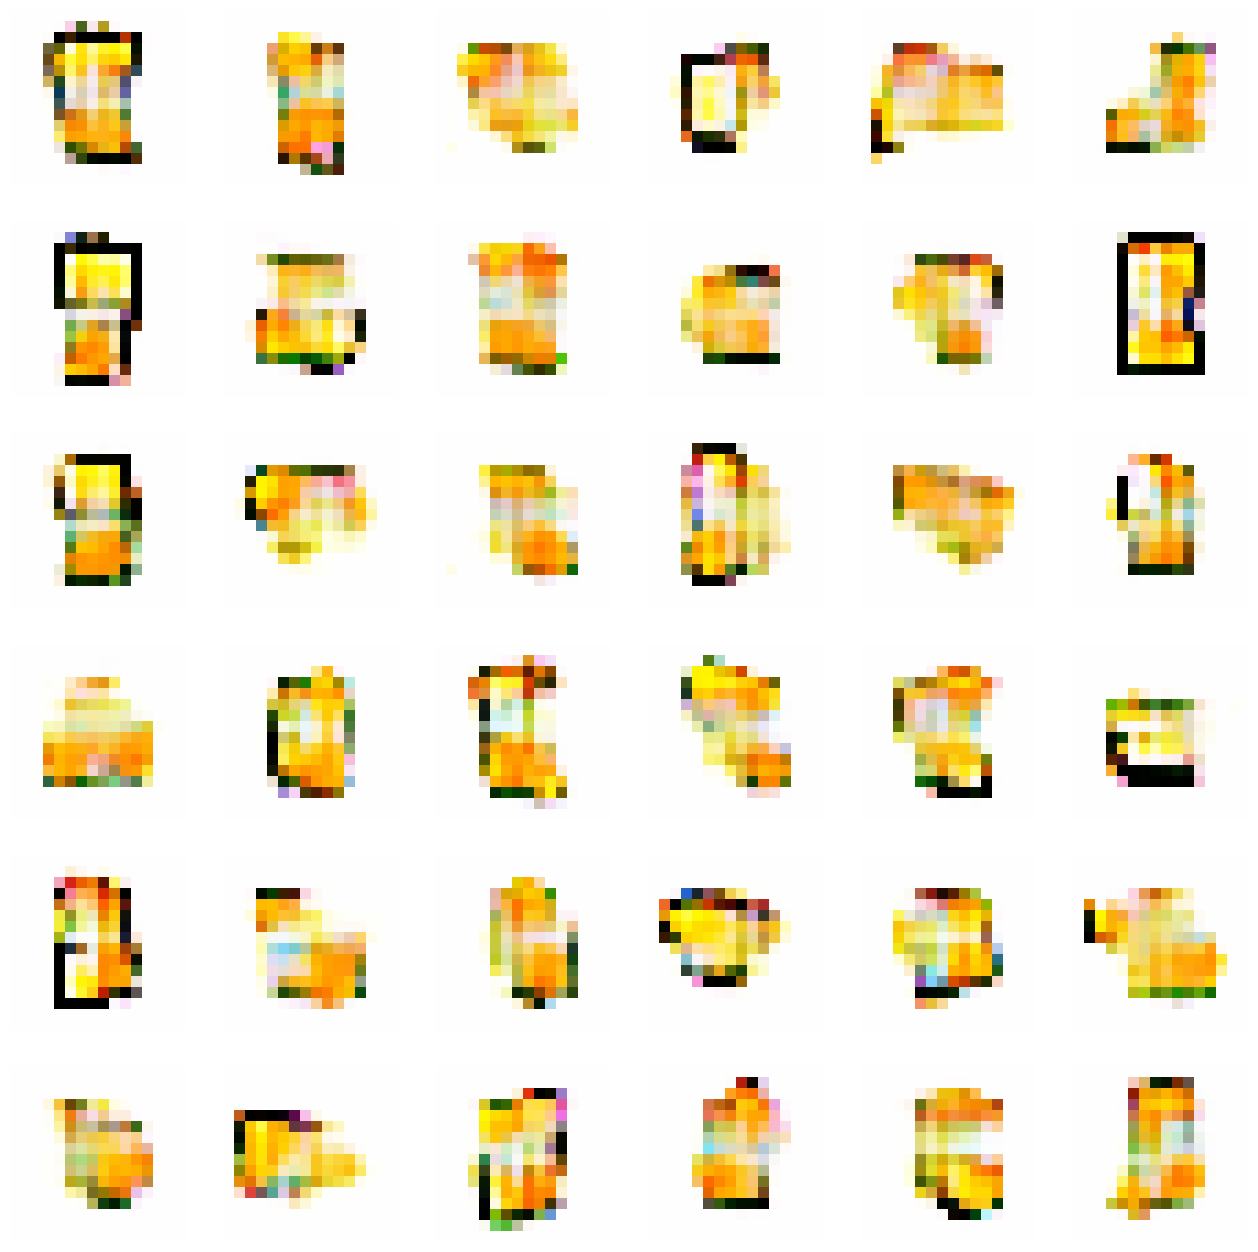

25/25 [==============================] - 123s 5s/step - d_loss: -6.2790 - g_loss: 7.8336
Epoch 17/50
25/25 [==============================] - ETA: 0s - d_loss: -6.2188 - g_loss: 8.2122

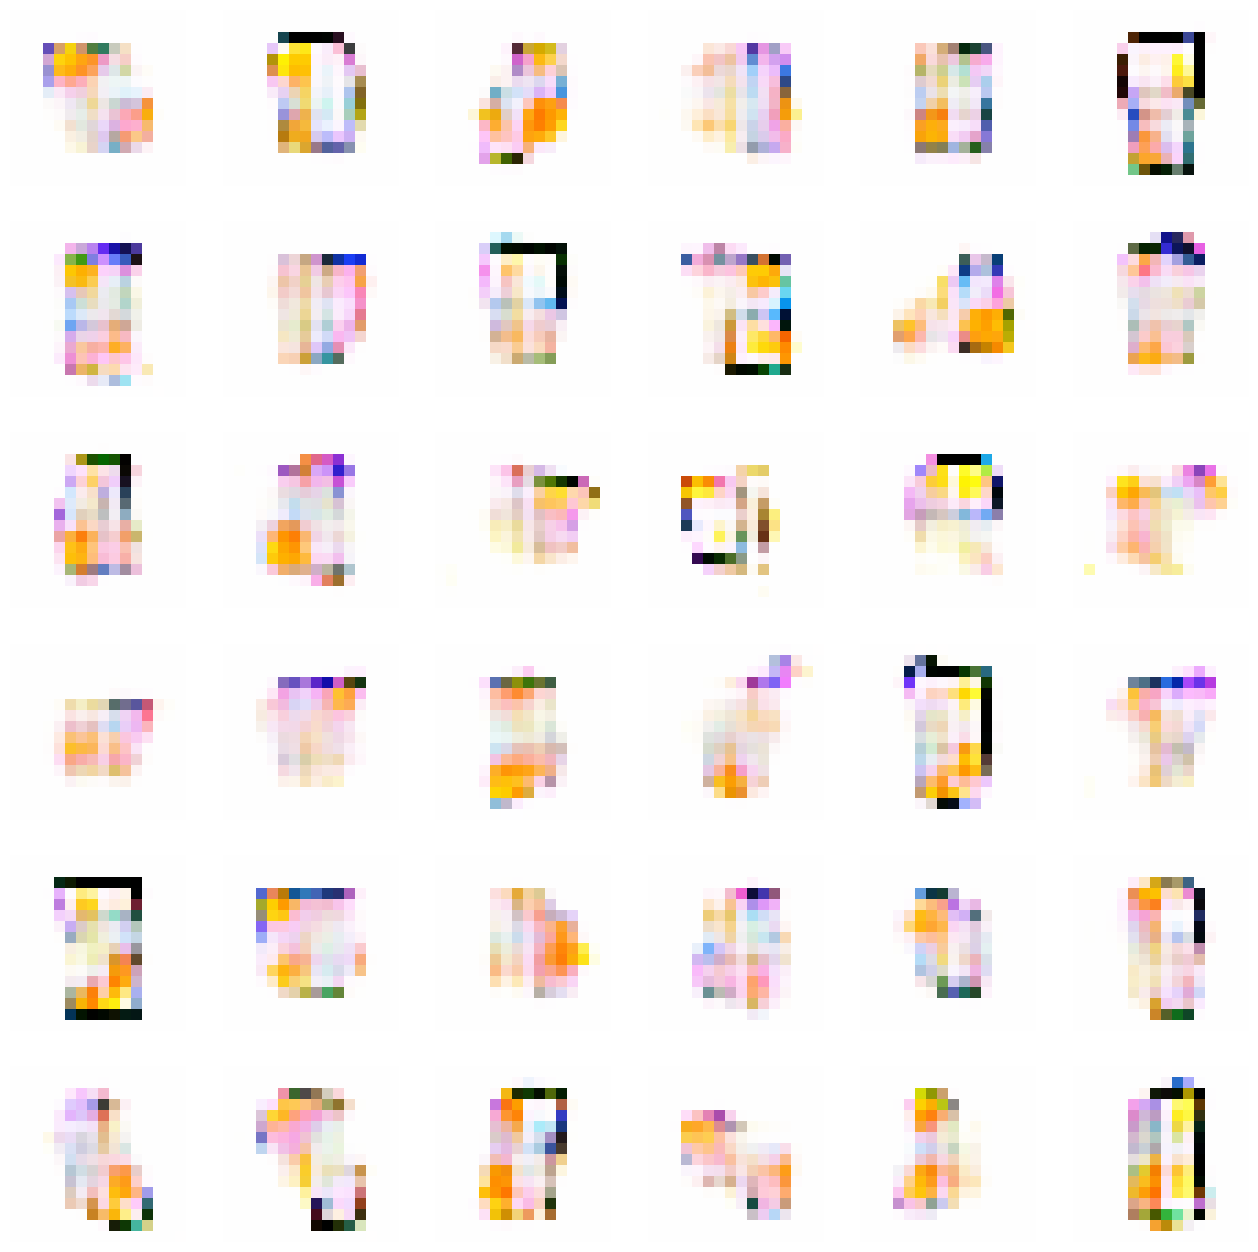

25/25 [==============================] - 125s 5s/step - d_loss: -6.1964 - g_loss: 8.0814
Epoch 18/50
25/25 [==============================] - ETA: 0s - d_loss: -6.4546 - g_loss: 7.0012

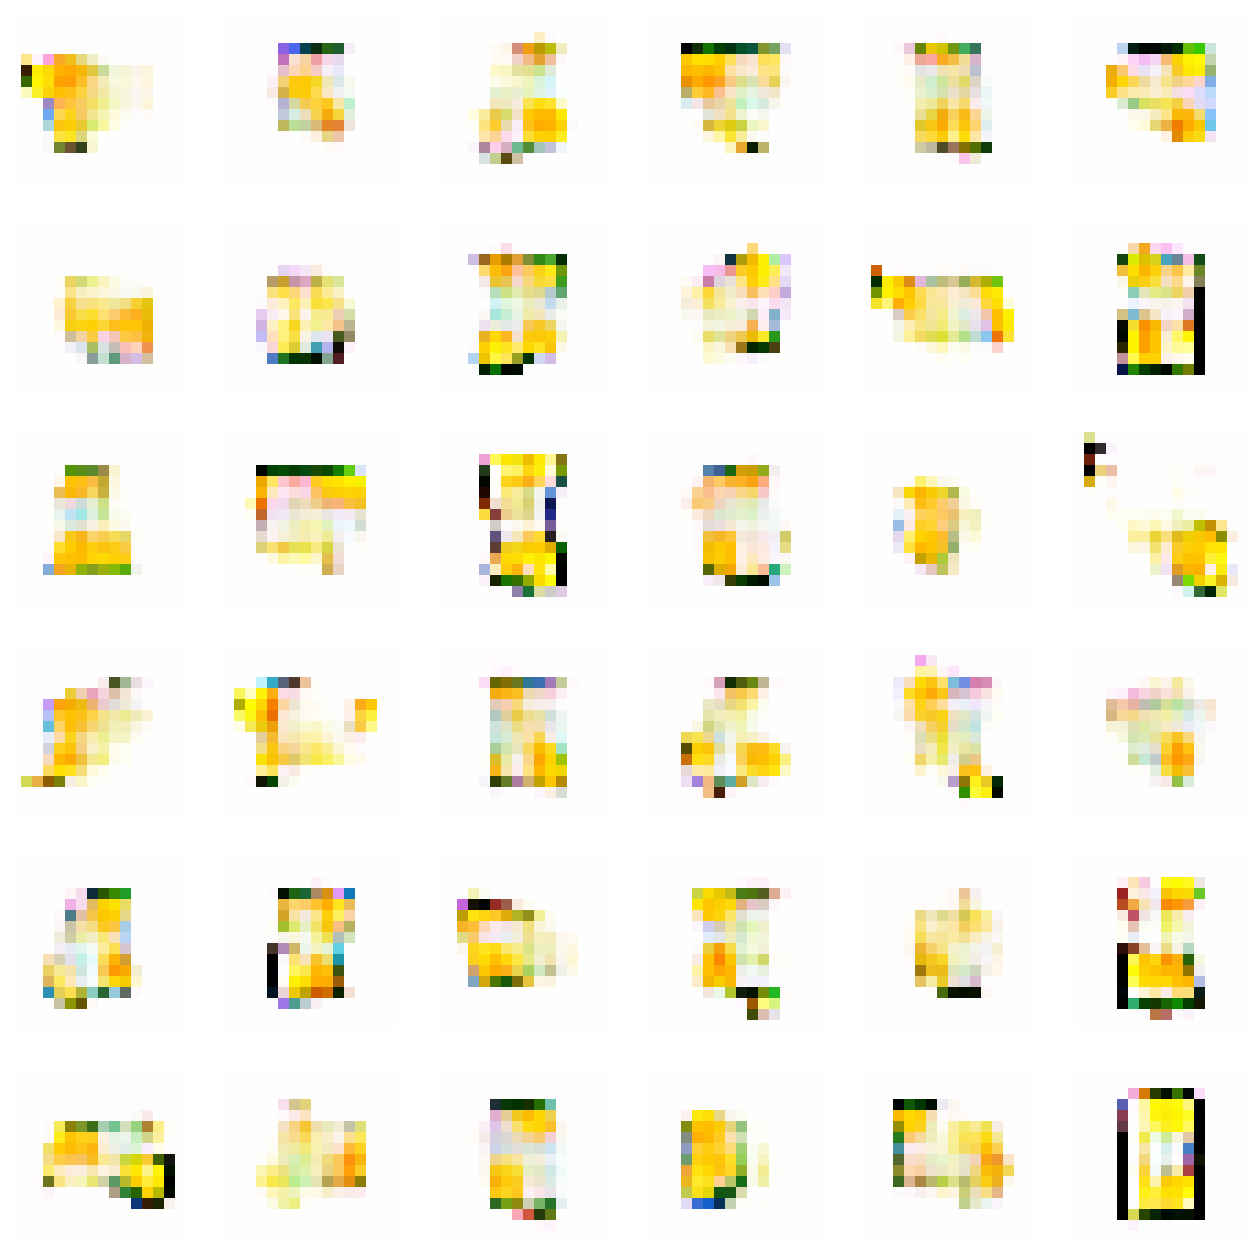

25/25 [==============================] - 122s 5s/step - d_loss: -6.4854 - g_loss: 6.3179
Epoch 19/50
25/25 [==============================] - ETA: 0s - d_loss: -6.5823 - g_loss: 9.7346

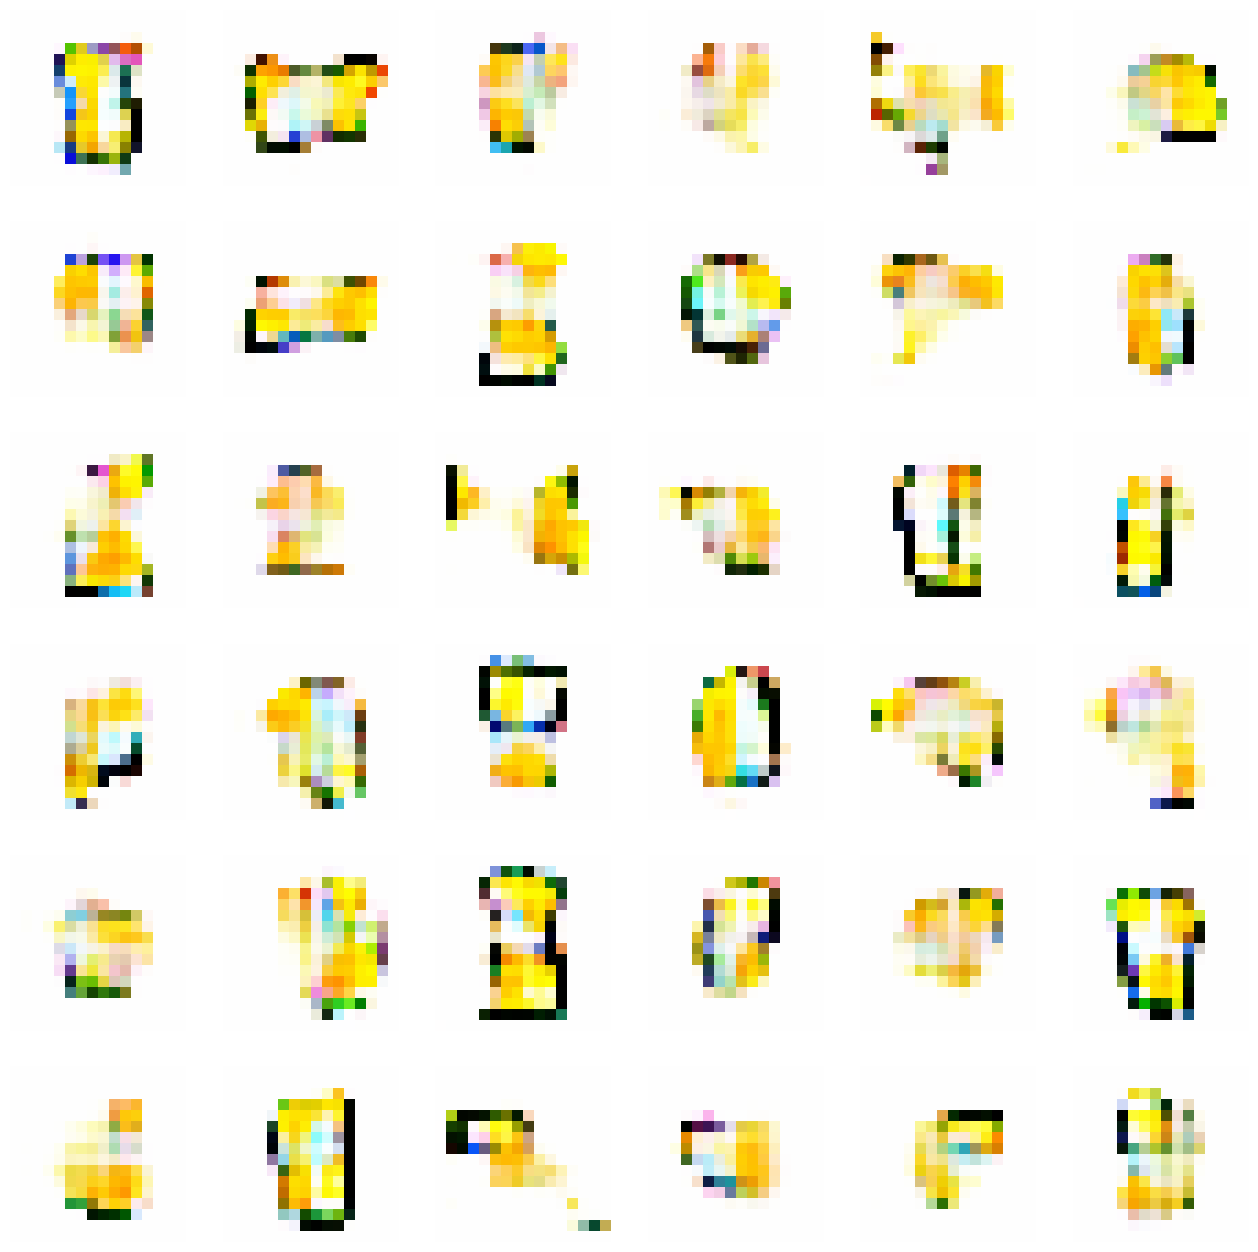

25/25 [==============================] - 124s 5s/step - d_loss: -6.6333 - g_loss: 9.6838
Epoch 20/50
25/25 [==============================] - ETA: 0s - d_loss: -6.2167 - g_loss: 7.9722

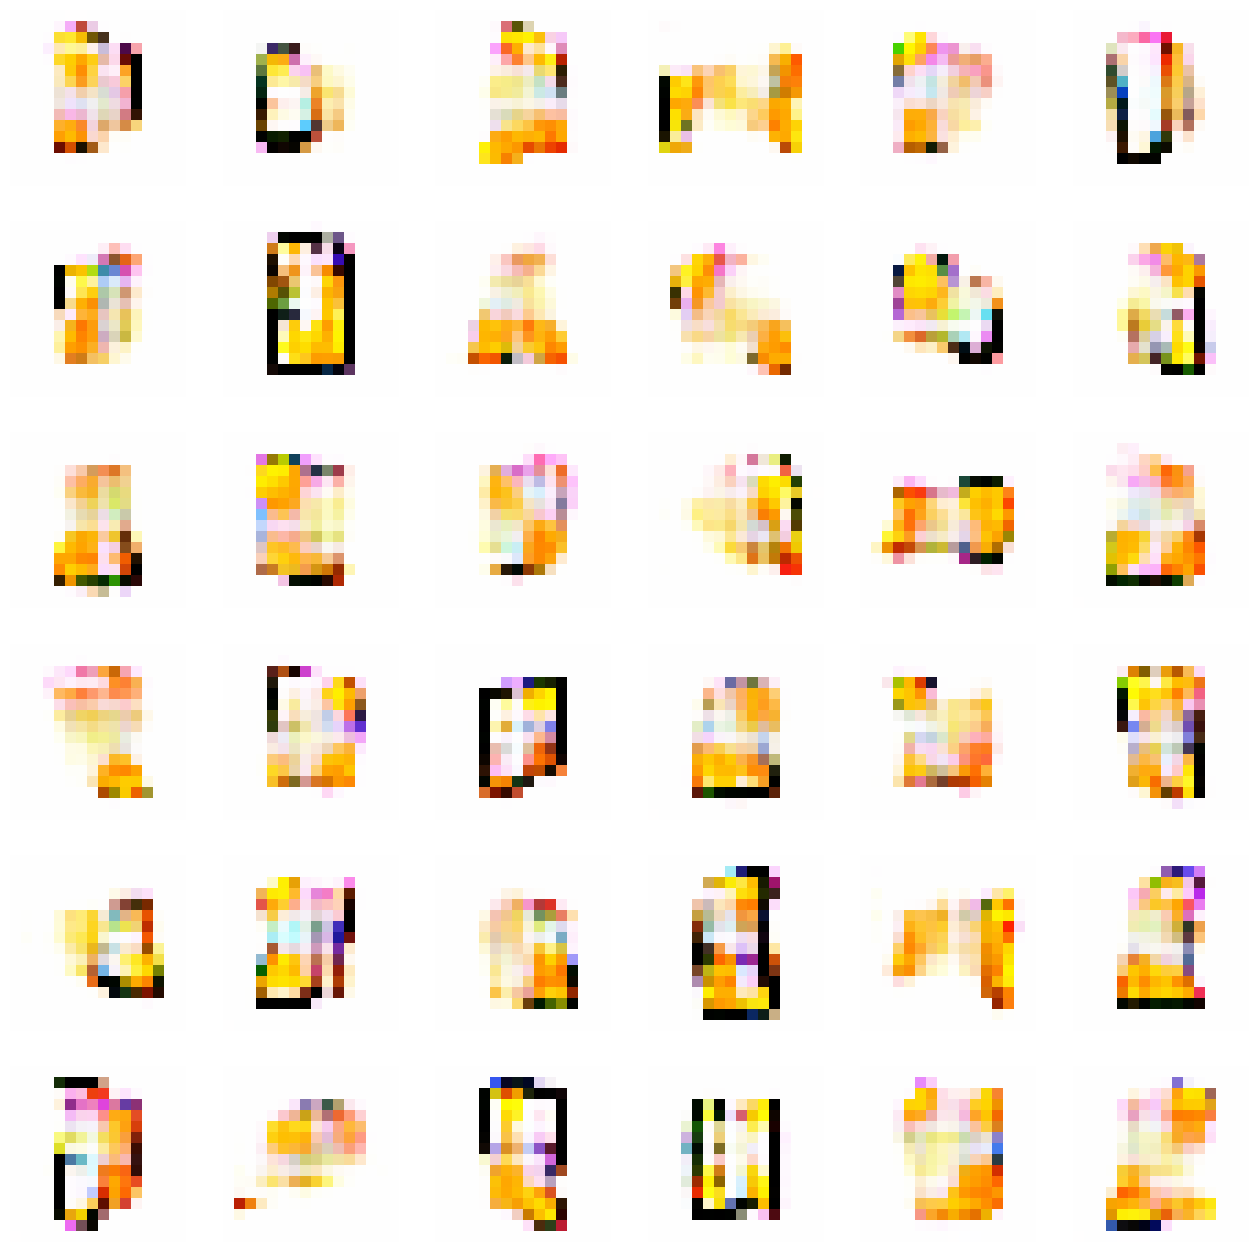

25/25 [==============================] - 123s 5s/step - d_loss: -6.2437 - g_loss: 8.0974
Epoch 21/50
25/25 [==============================] - ETA: 0s - d_loss: -6.2619 - g_loss: 7.7125

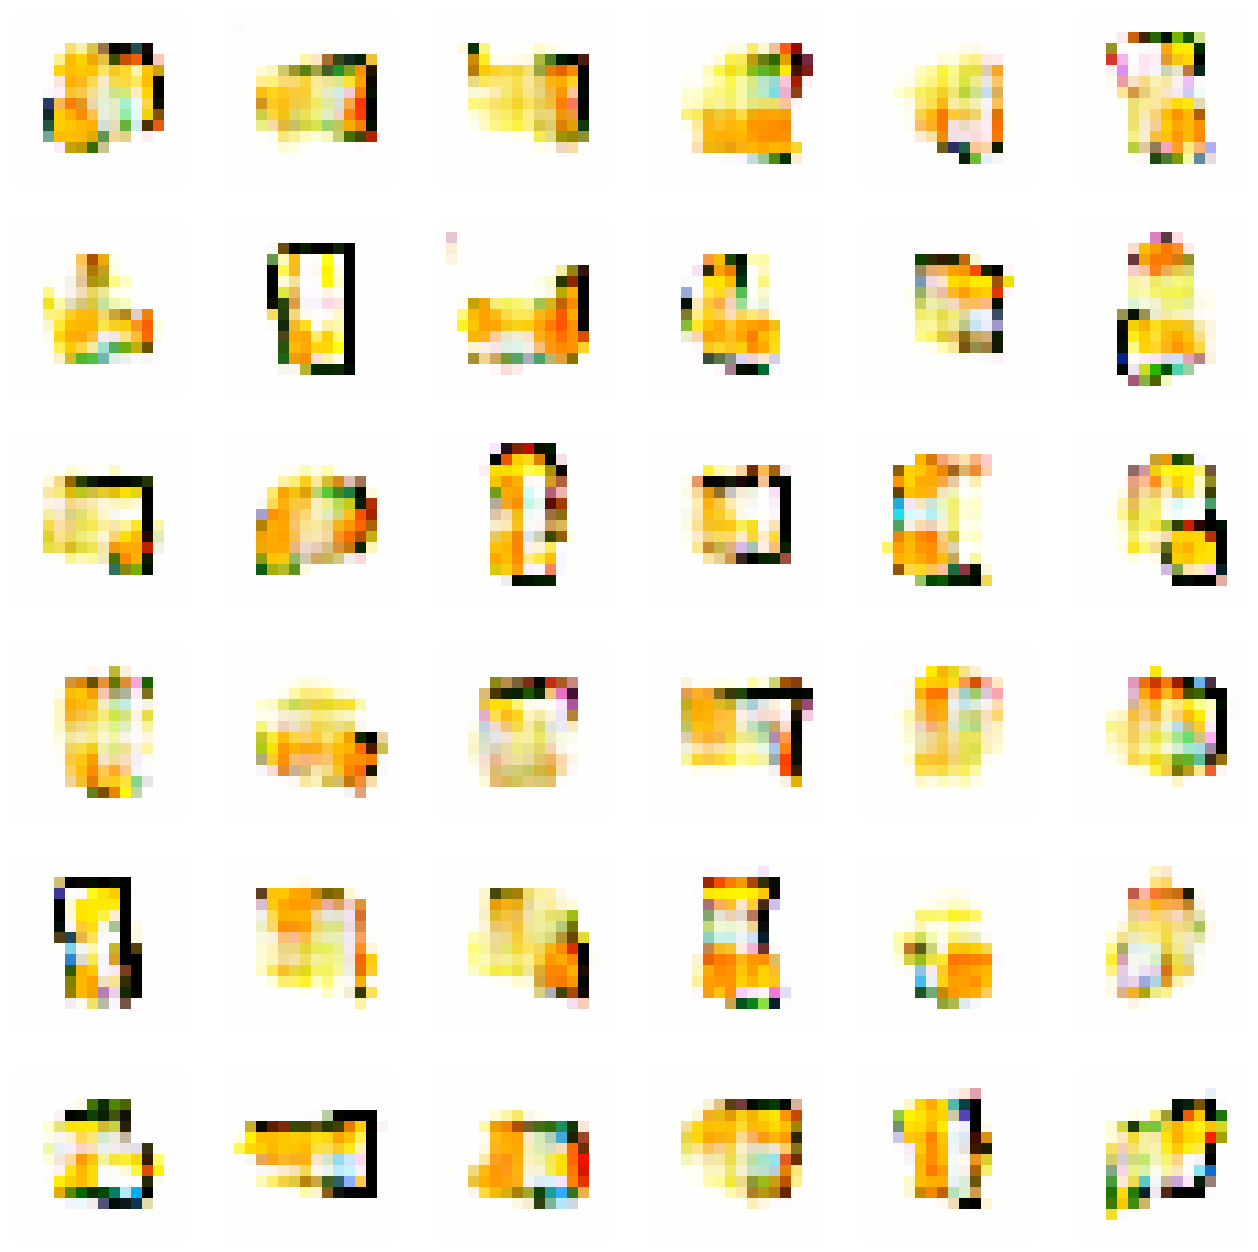

25/25 [==============================] - 120s 5s/step - d_loss: -6.3526 - g_loss: 7.3759
Epoch 22/50
25/25 [==============================] - ETA: 0s - d_loss: -5.9570 - g_loss: 7.1553

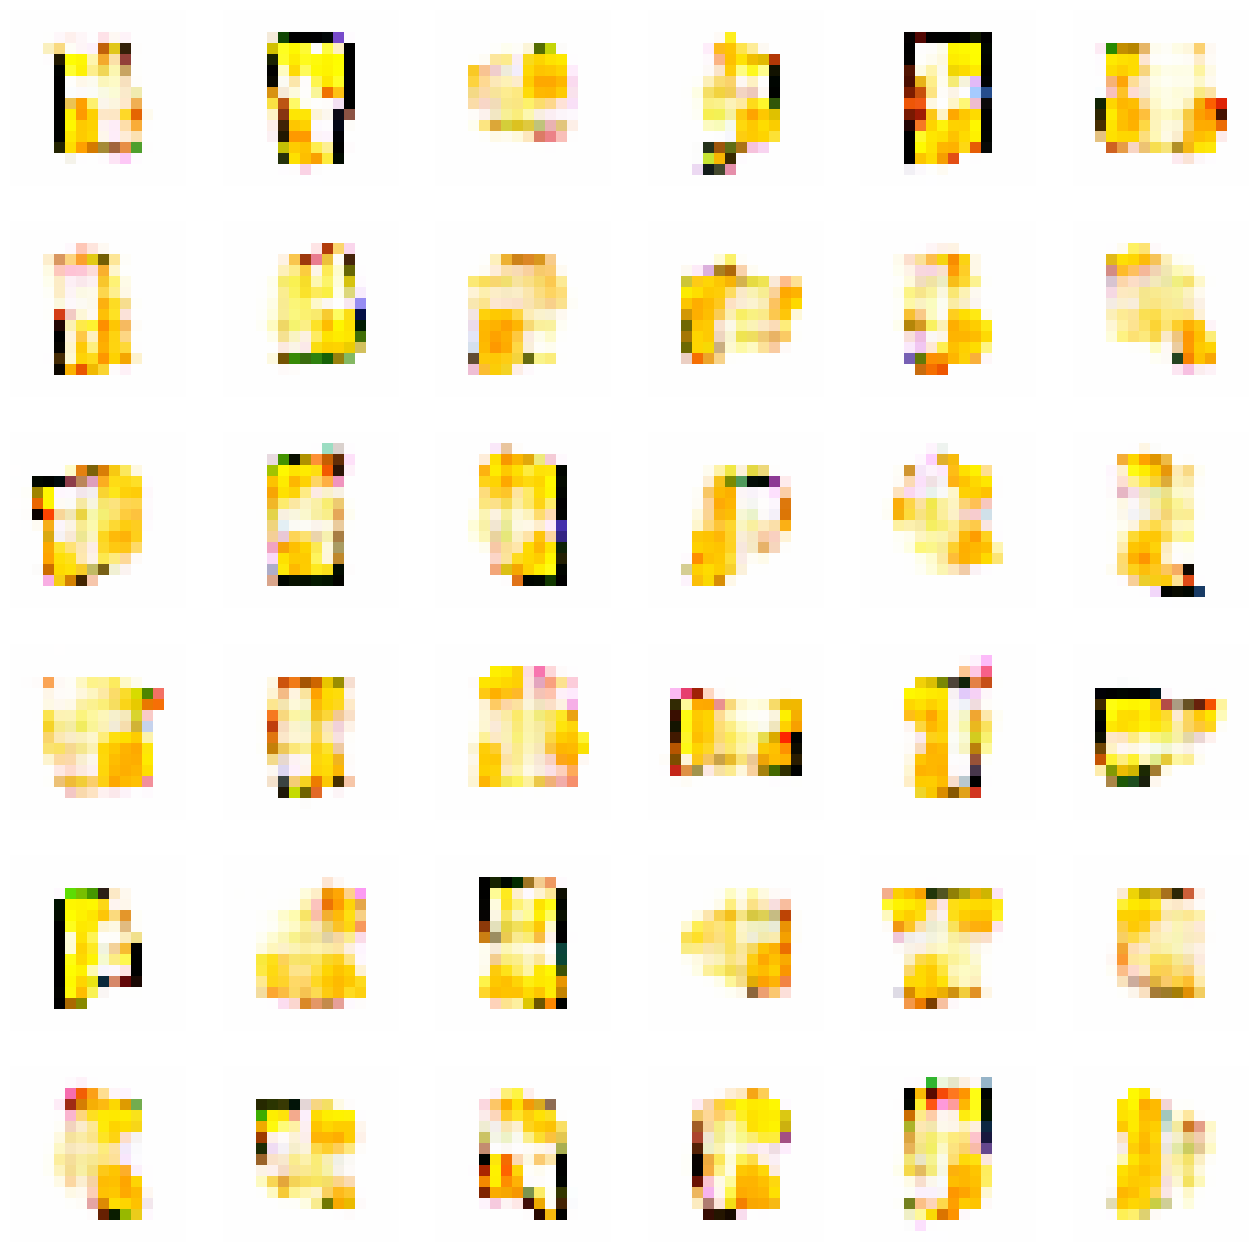

25/25 [==============================] - 119s 5s/step - d_loss: -6.0285 - g_loss: 6.9065
Epoch 23/50
25/25 [==============================] - ETA: 0s - d_loss: -6.3216 - g_loss: 7.1258

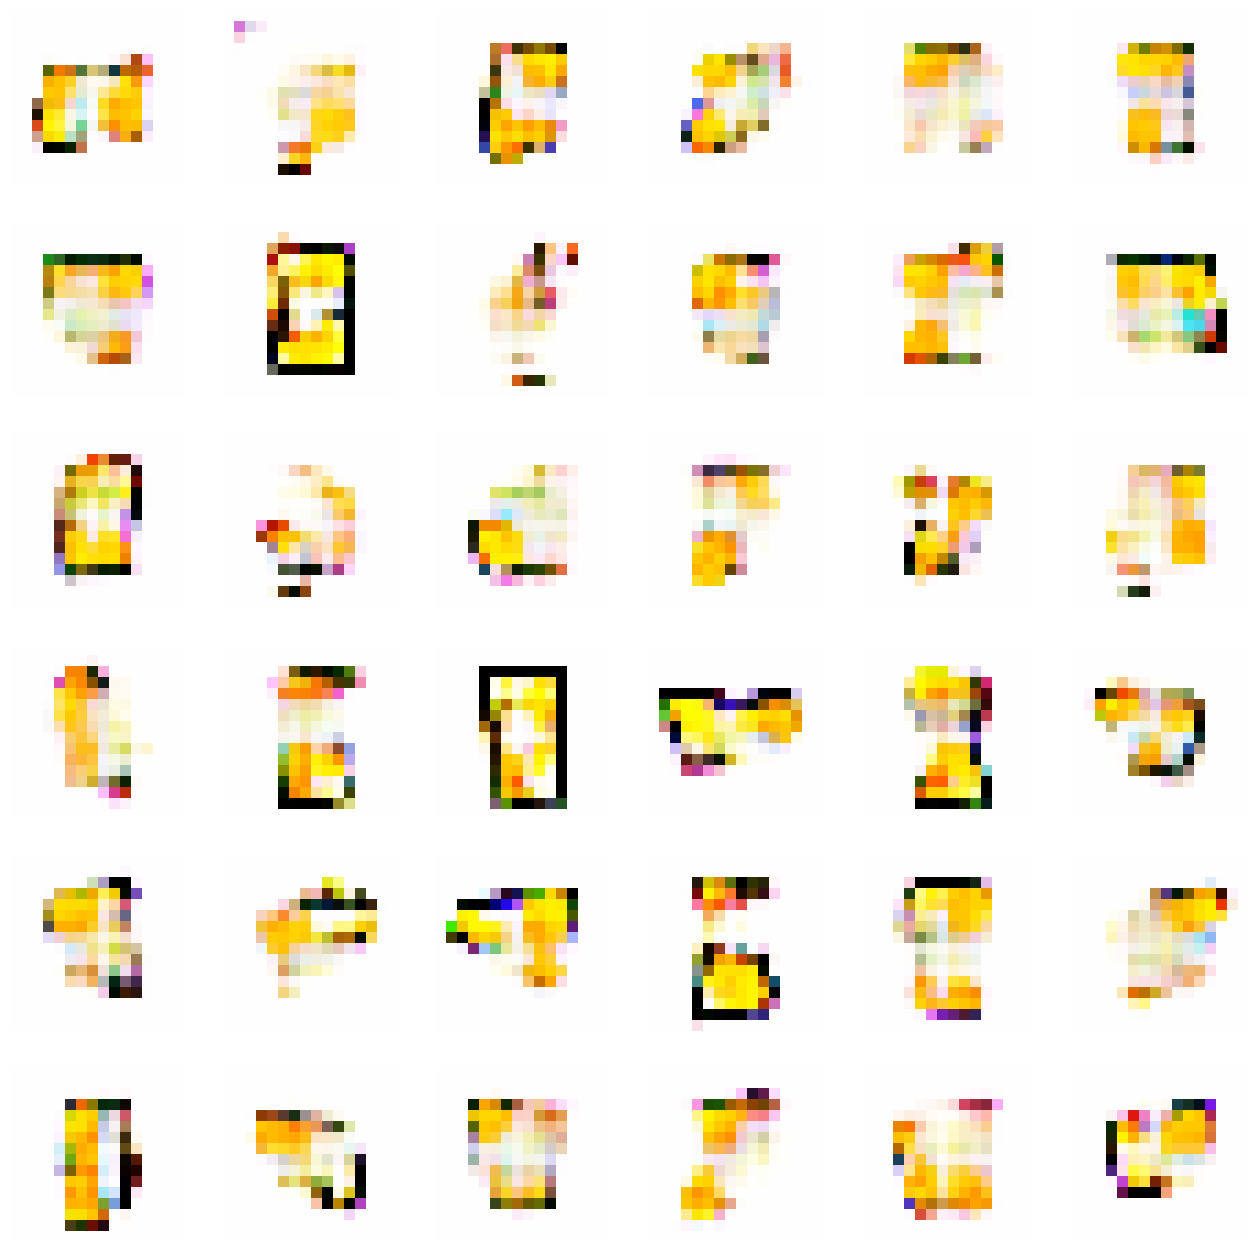

25/25 [==============================] - 118s 5s/step - d_loss: -6.3271 - g_loss: 5.8189
Epoch 24/50
25/25 [==============================] - ETA: 0s - d_loss: -6.5827 - g_loss: 9.3308

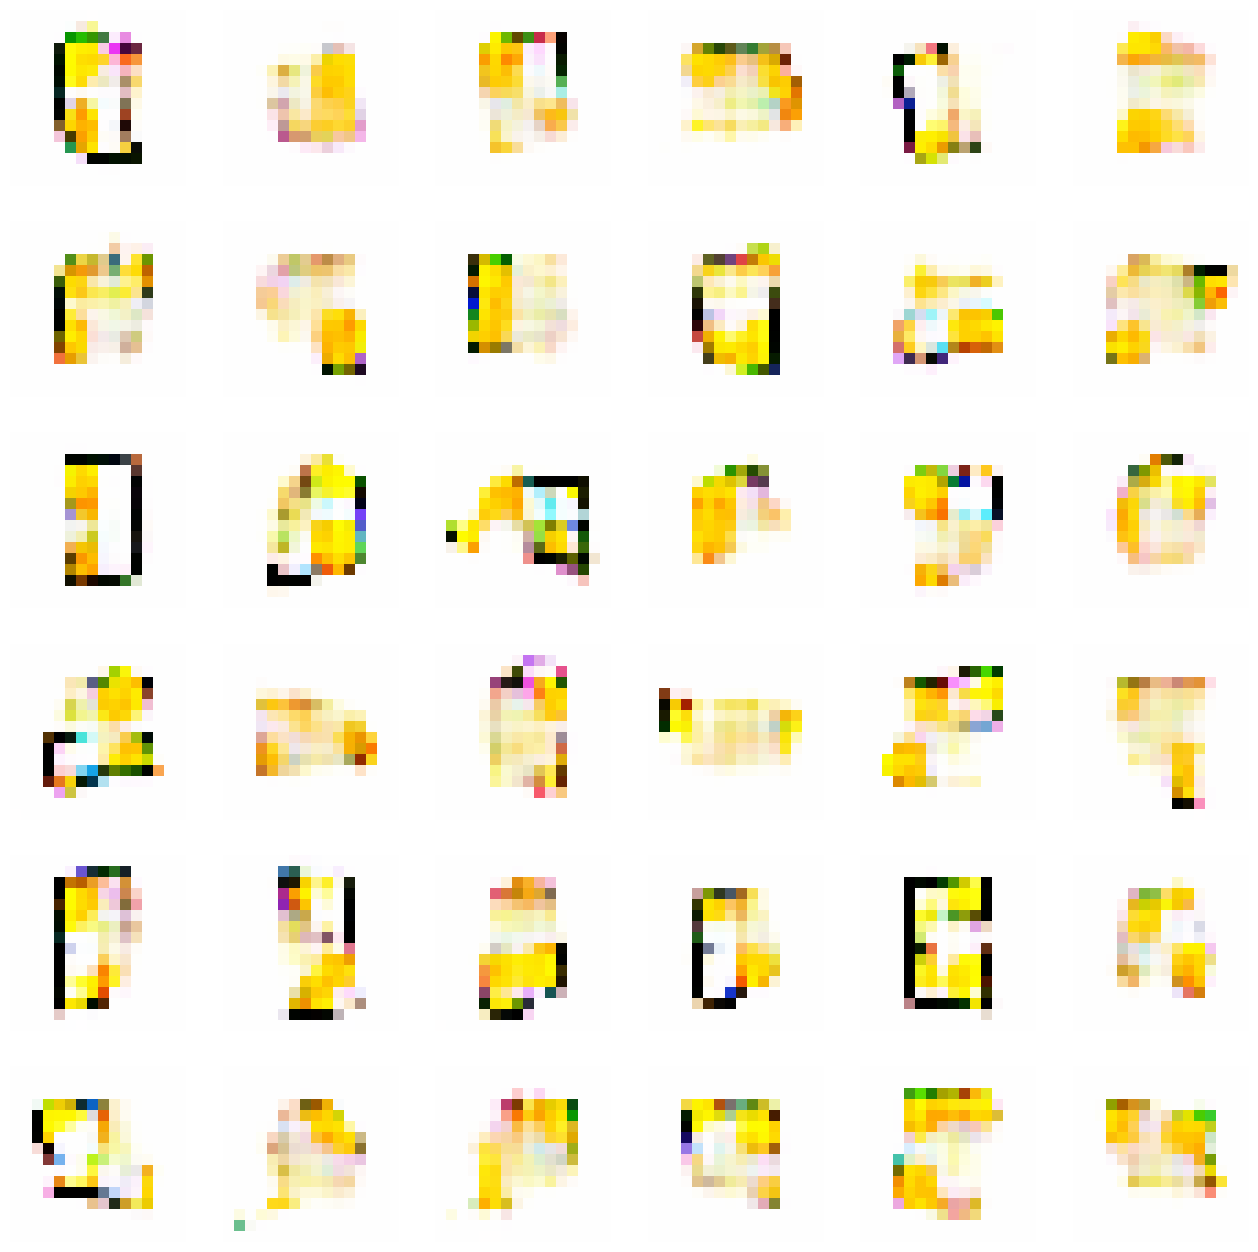

25/25 [==============================] - 119s 5s/step - d_loss: -6.6096 - g_loss: 9.3740
Epoch 25/50
25/25 [==============================] - ETA: 0s - d_loss: -6.2045 - g_loss: 7.7016

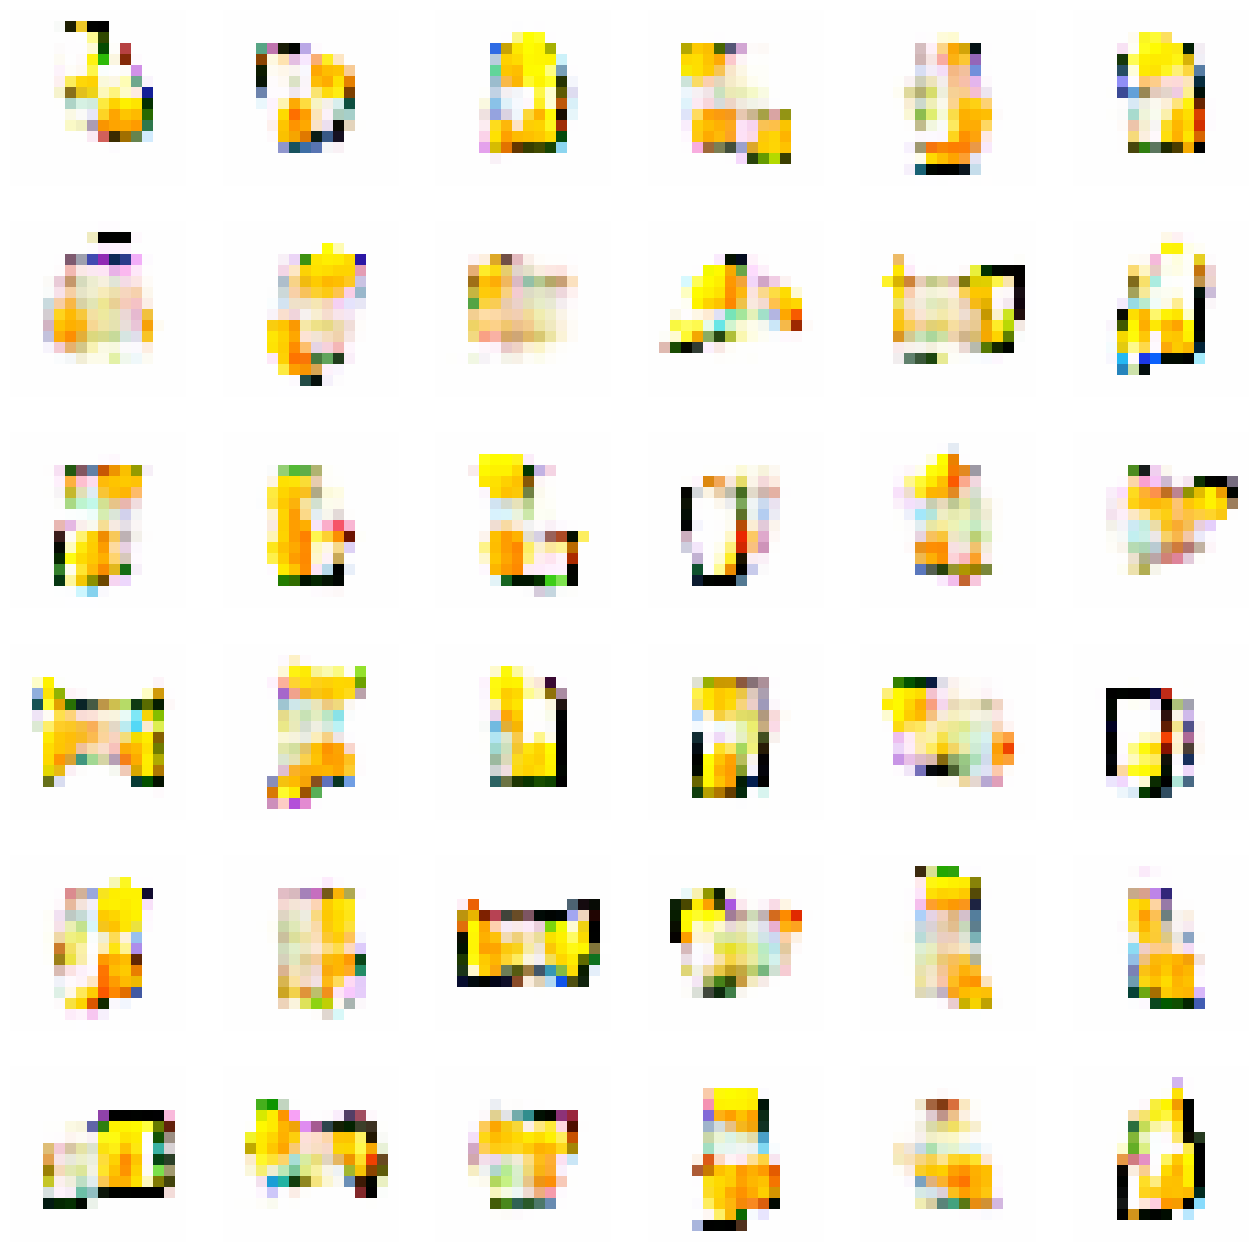

25/25 [==============================] - 120s 5s/step - d_loss: -6.2104 - g_loss: 7.6949
Epoch 26/50
25/25 [==============================] - ETA: 0s - d_loss: -6.8925 - g_loss: 8.6872

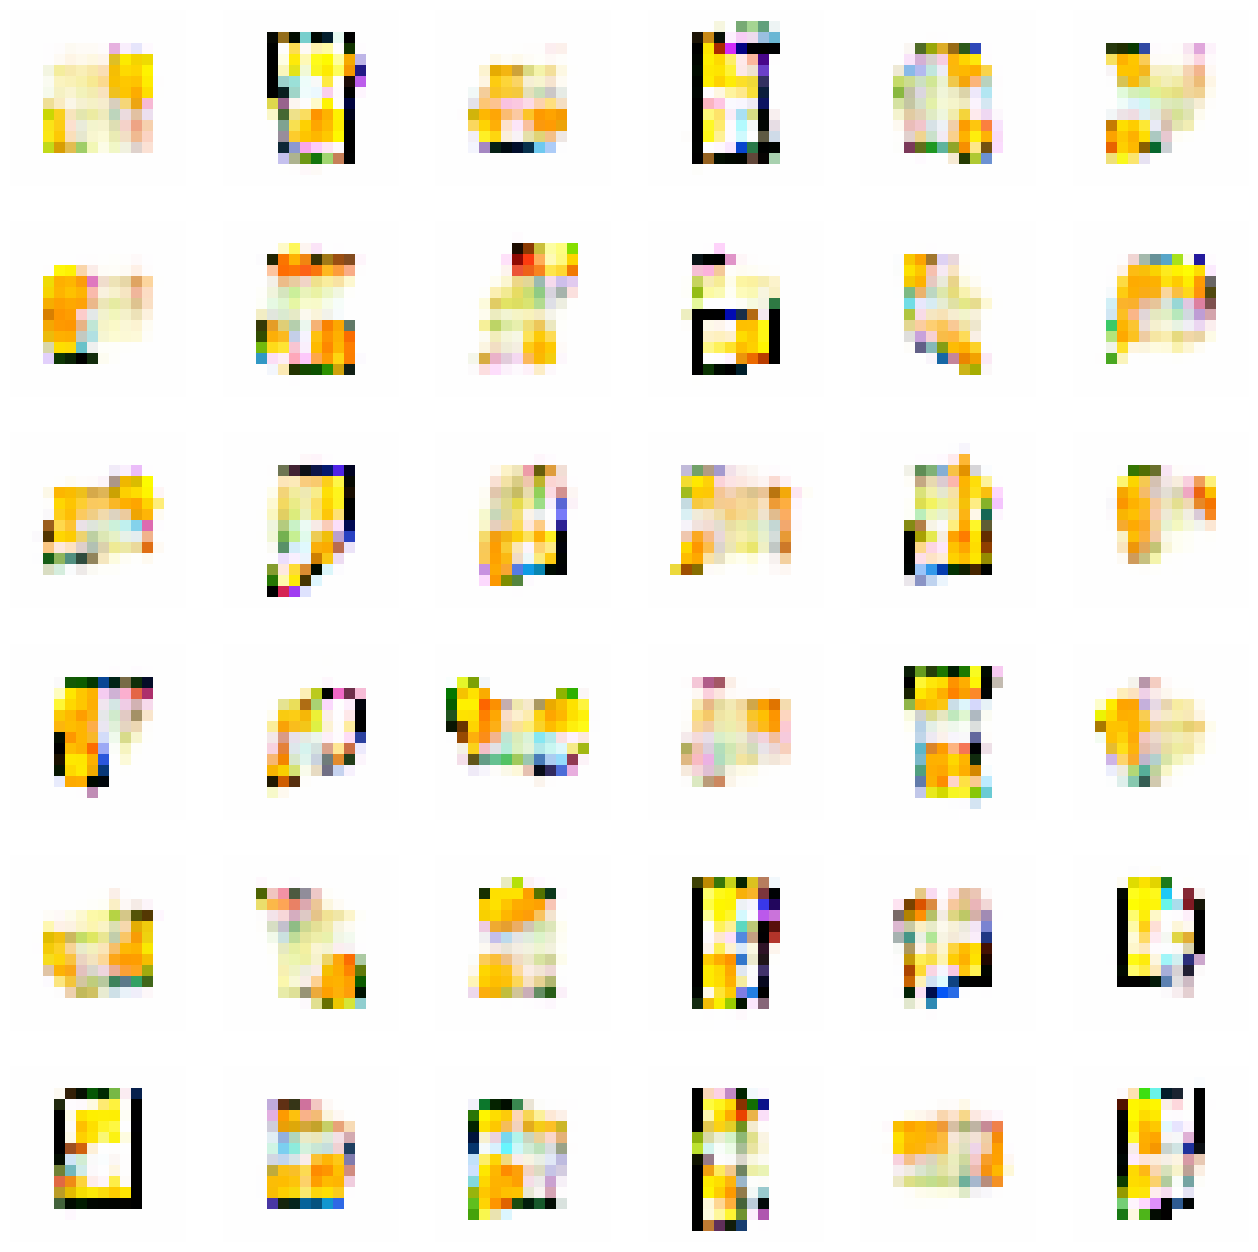

25/25 [==============================] - 119s 5s/step - d_loss: -6.9131 - g_loss: 8.6320
Epoch 27/50
25/25 [==============================] - ETA: 0s - d_loss: -6.8713 - g_loss: 9.2016

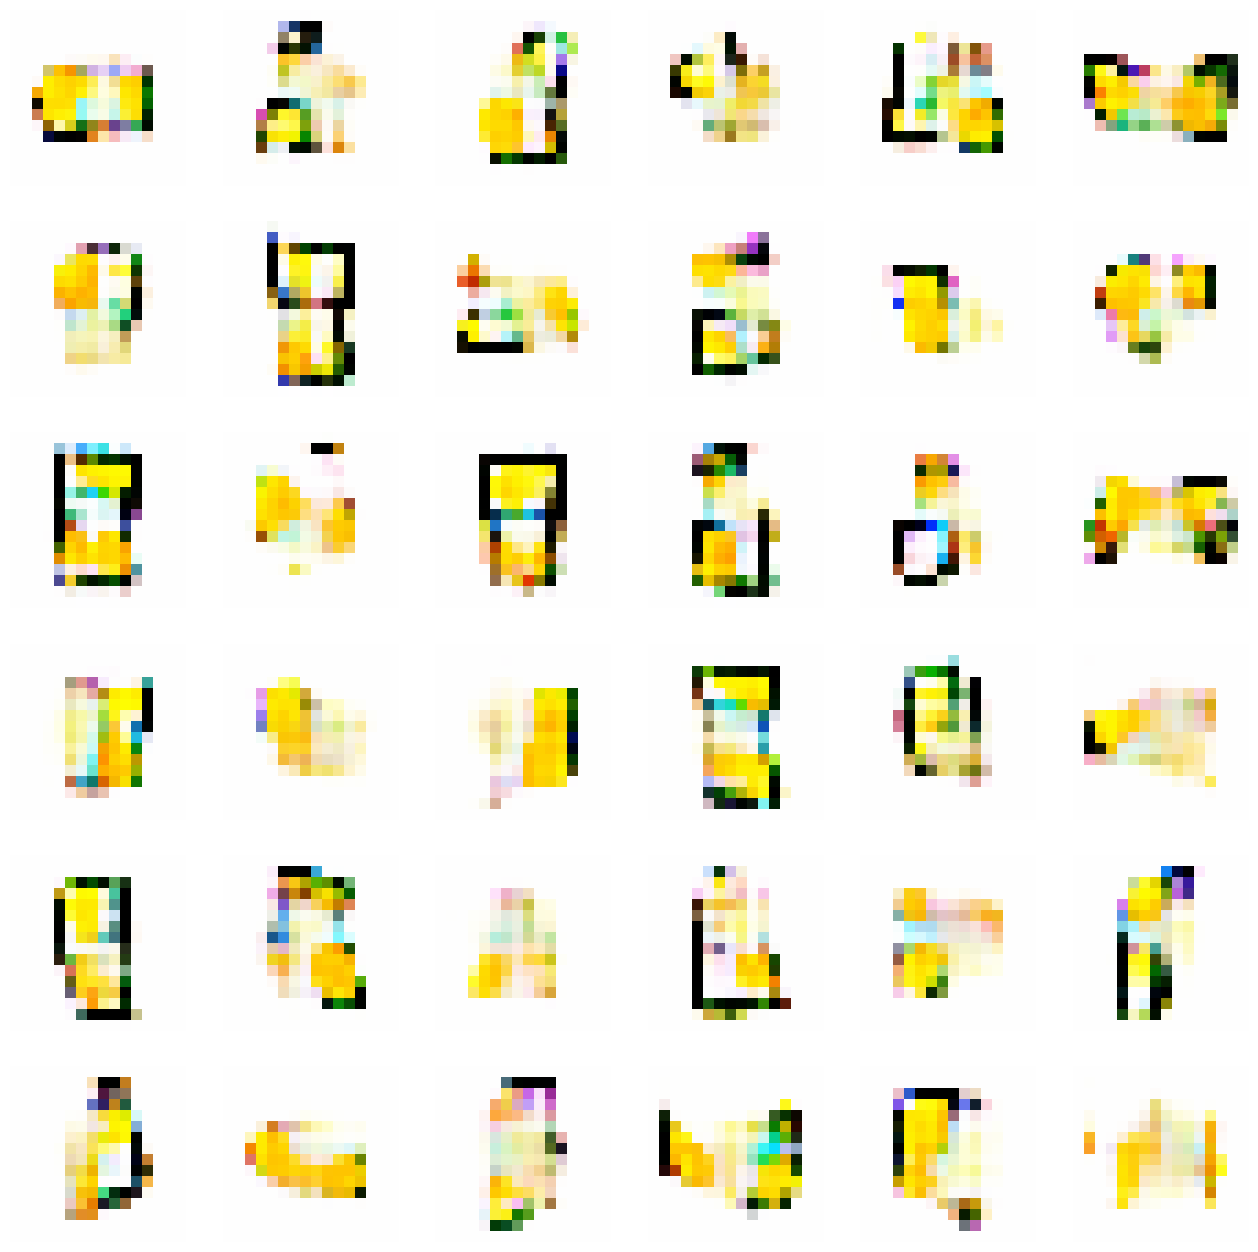

25/25 [==============================] - 122s 5s/step - d_loss: -6.8653 - g_loss: 9.1757
Epoch 28/50
25/25 [==============================] - ETA: 0s - d_loss: -6.2554 - g_loss: 7.9621

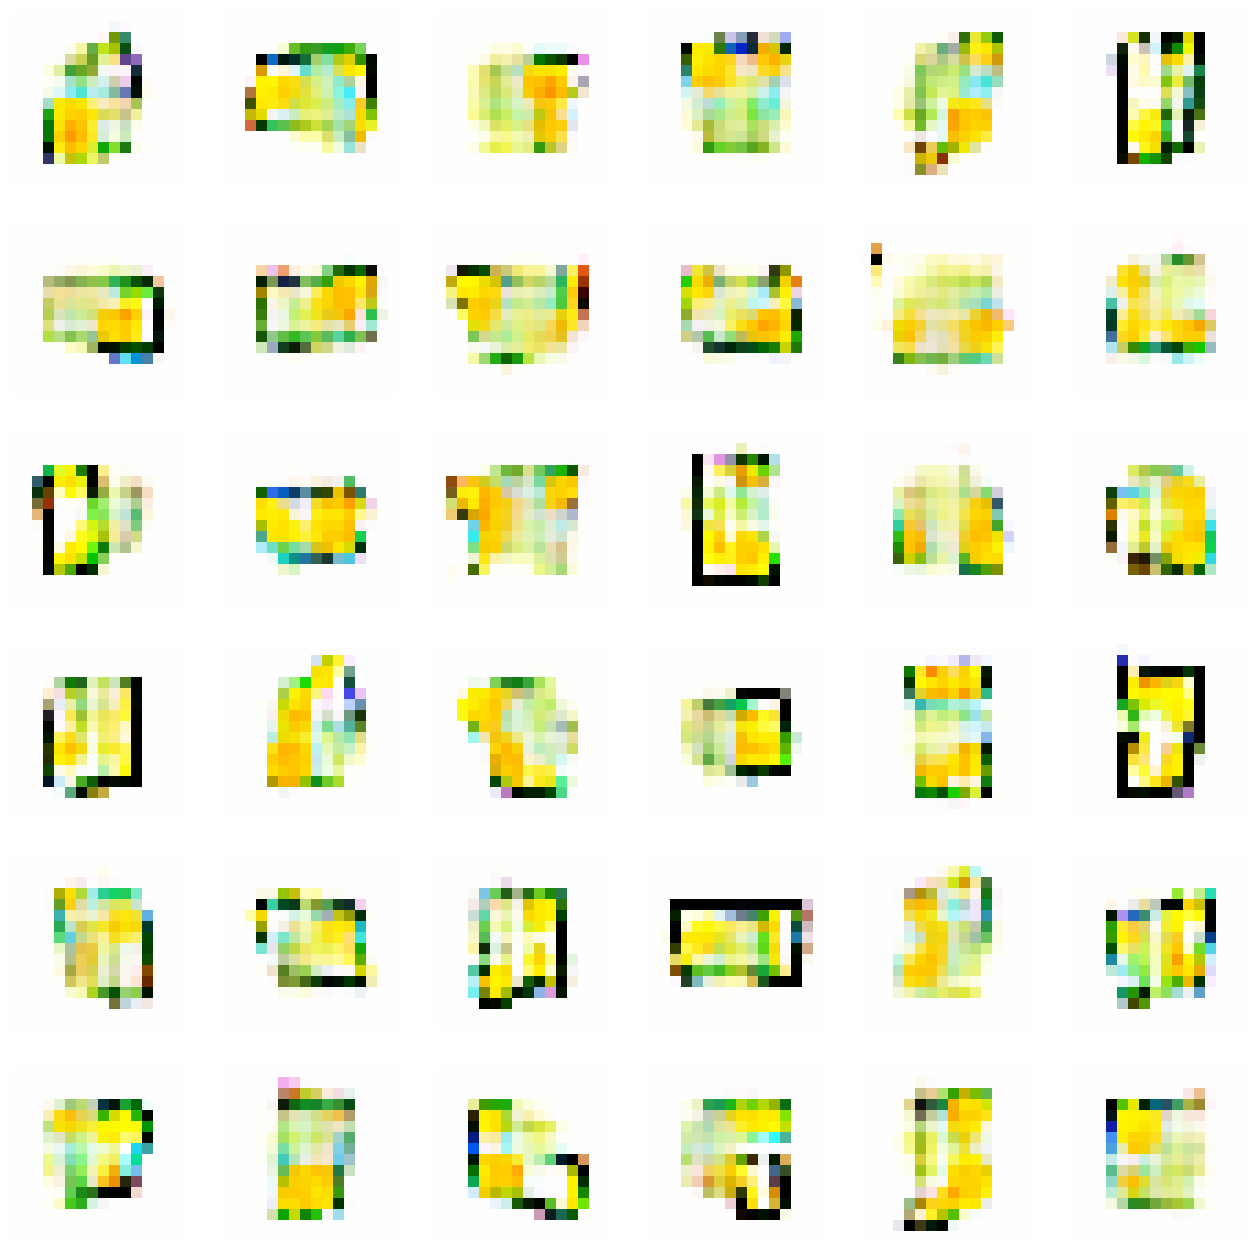

25/25 [==============================] - 120s 5s/step - d_loss: -6.2983 - g_loss: 7.7726
Epoch 29/50
25/25 [==============================] - ETA: 0s - d_loss: -6.8146 - g_loss: 8.3826

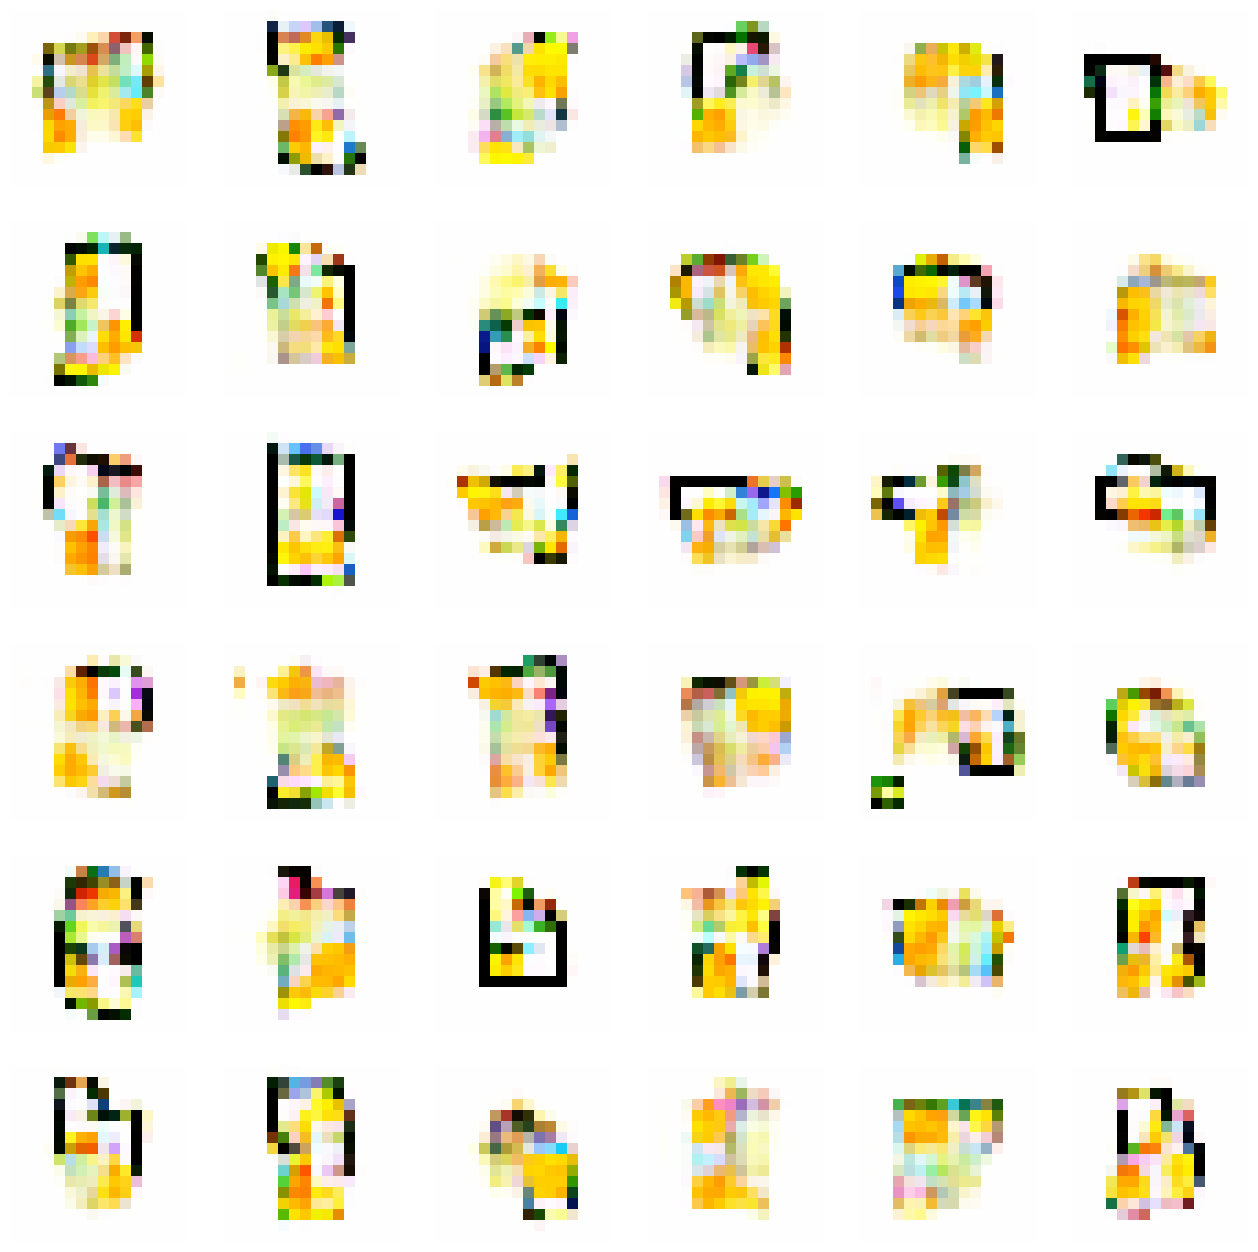

25/25 [==============================] - 125s 5s/step - d_loss: -6.7619 - g_loss: 8.4006
Epoch 30/50
25/25 [==============================] - ETA: 0s - d_loss: -6.7670 - g_loss: 8.3737

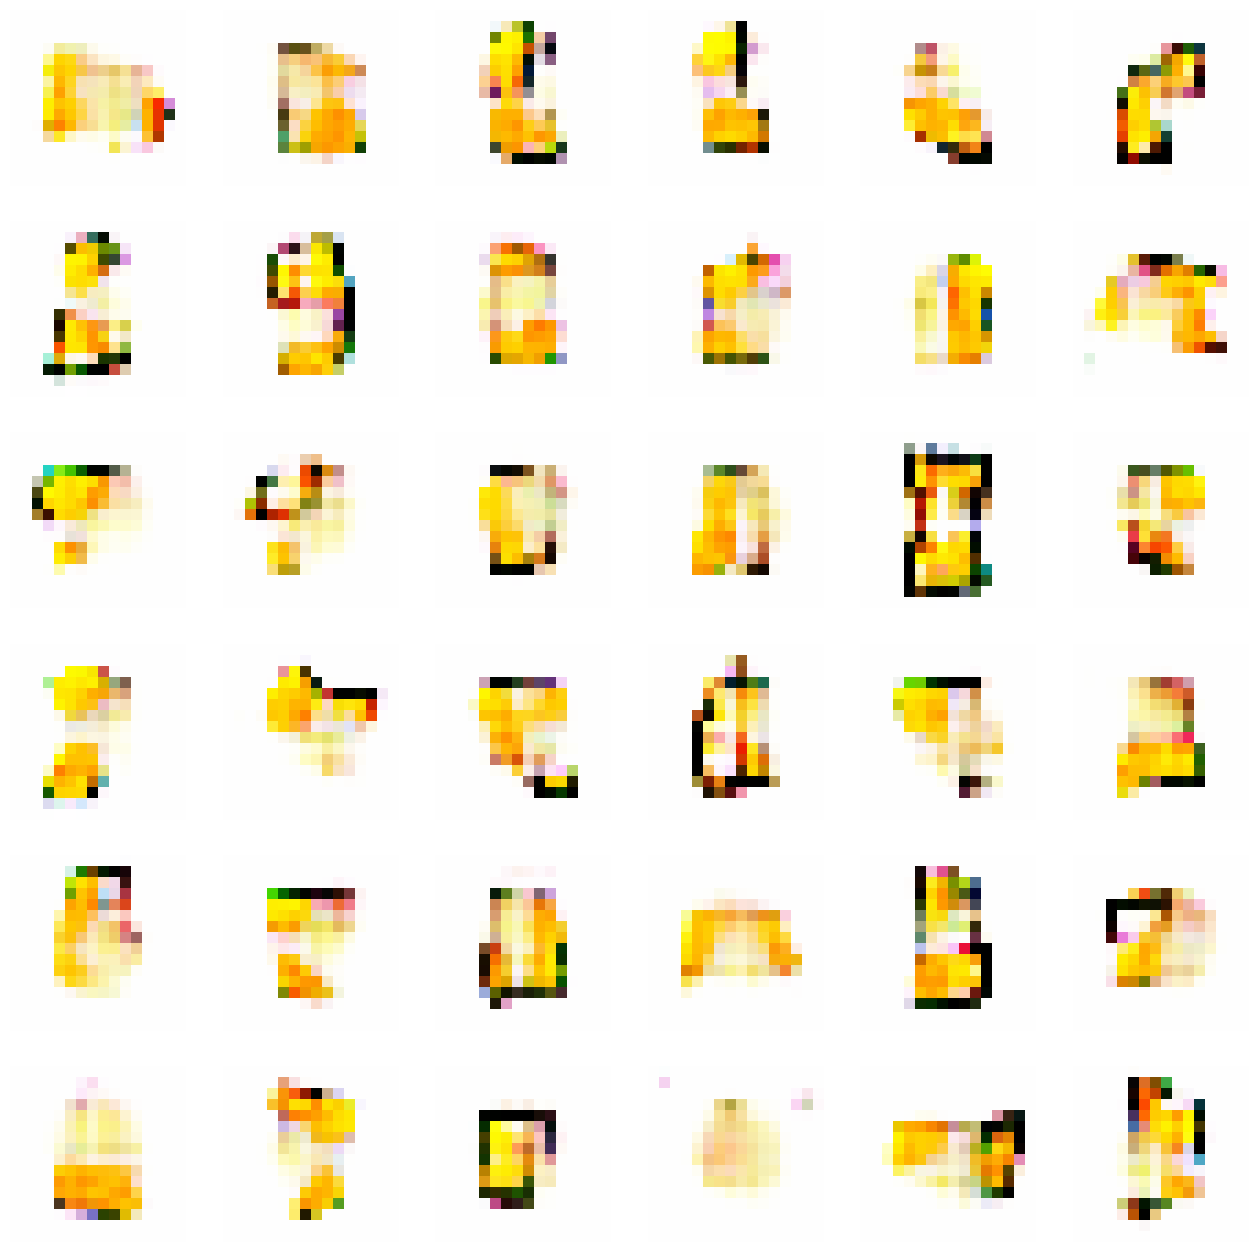

25/25 [==============================] - 123s 5s/step - d_loss: -6.7511 - g_loss: 7.8777
Epoch 31/50
25/25 [==============================] - ETA: 0s - d_loss: -6.6874 - g_loss: 8.2383

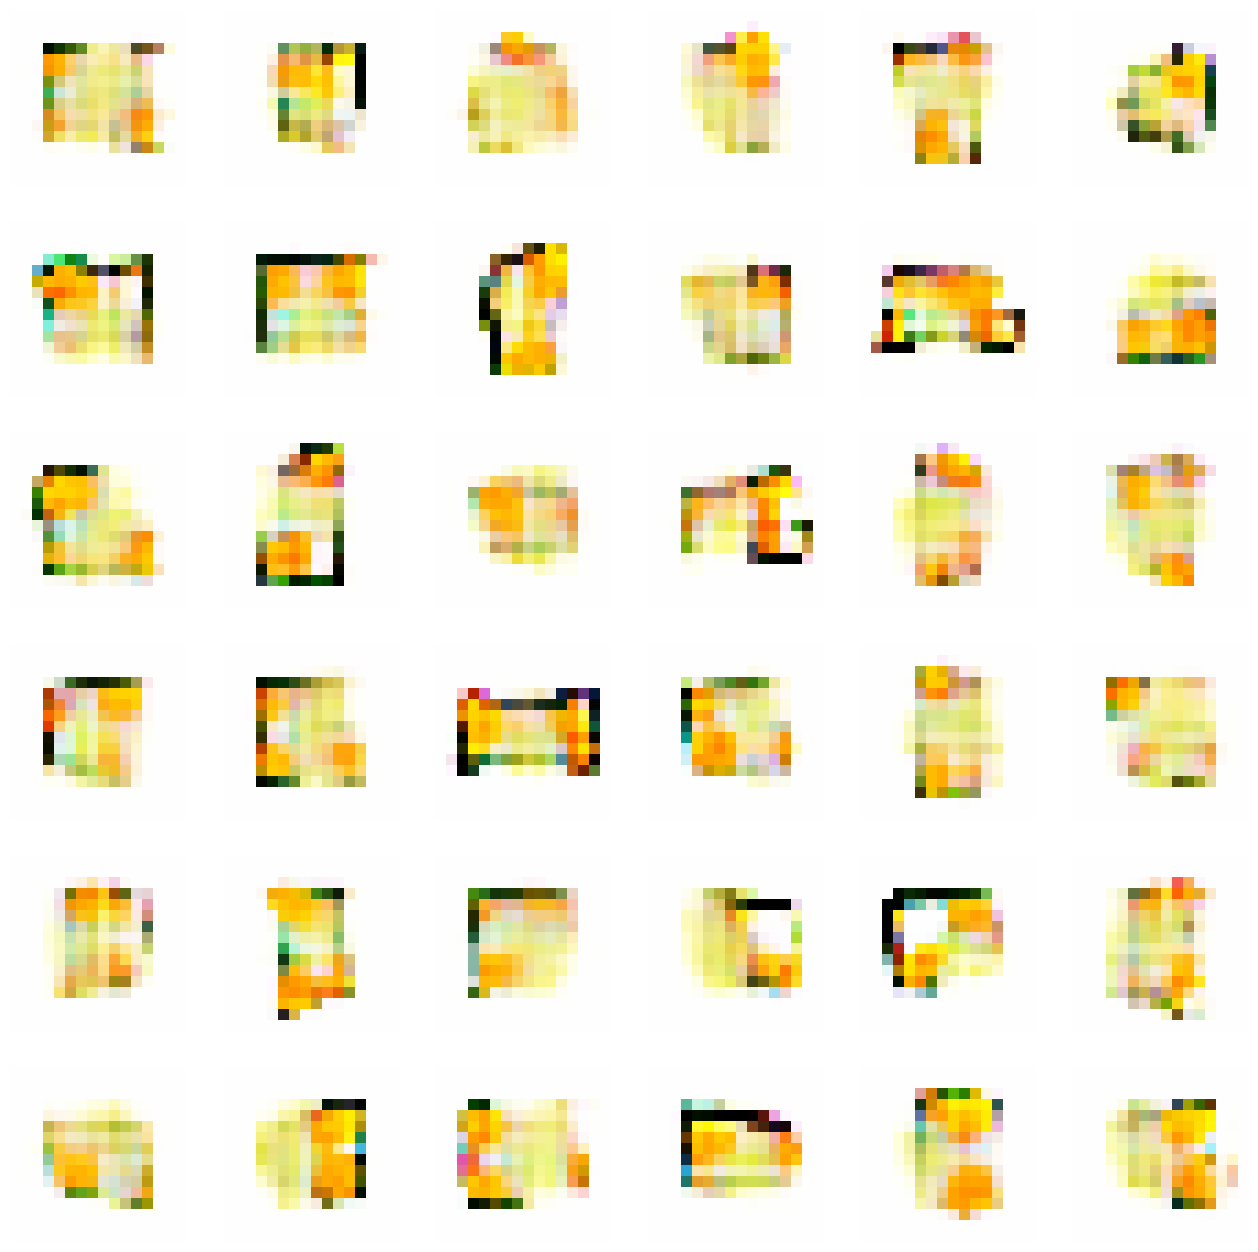

25/25 [==============================] - 123s 5s/step - d_loss: -6.7505 - g_loss: 8.3613
Epoch 32/50
25/25 [==============================] - ETA: 0s - d_loss: -7.0994 - g_loss: 9.0544

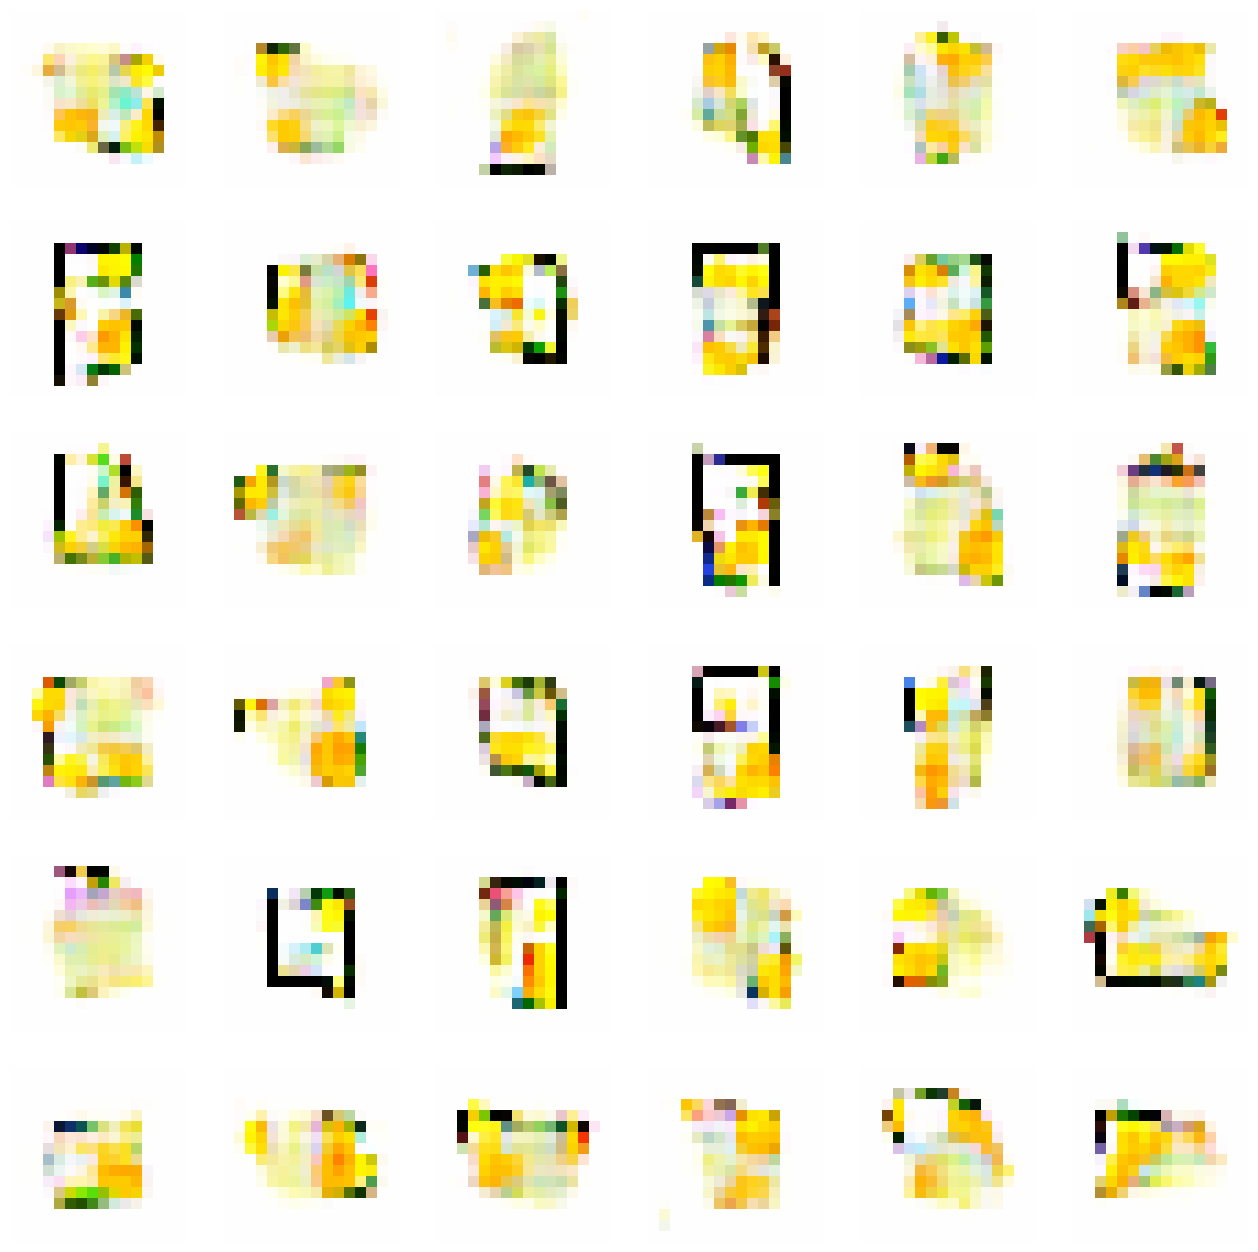

25/25 [==============================] - 120s 5s/step - d_loss: -7.1093 - g_loss: 8.9768
Epoch 33/50
25/25 [==============================] - ETA: 0s - d_loss: -7.0232 - g_loss: 8.9689

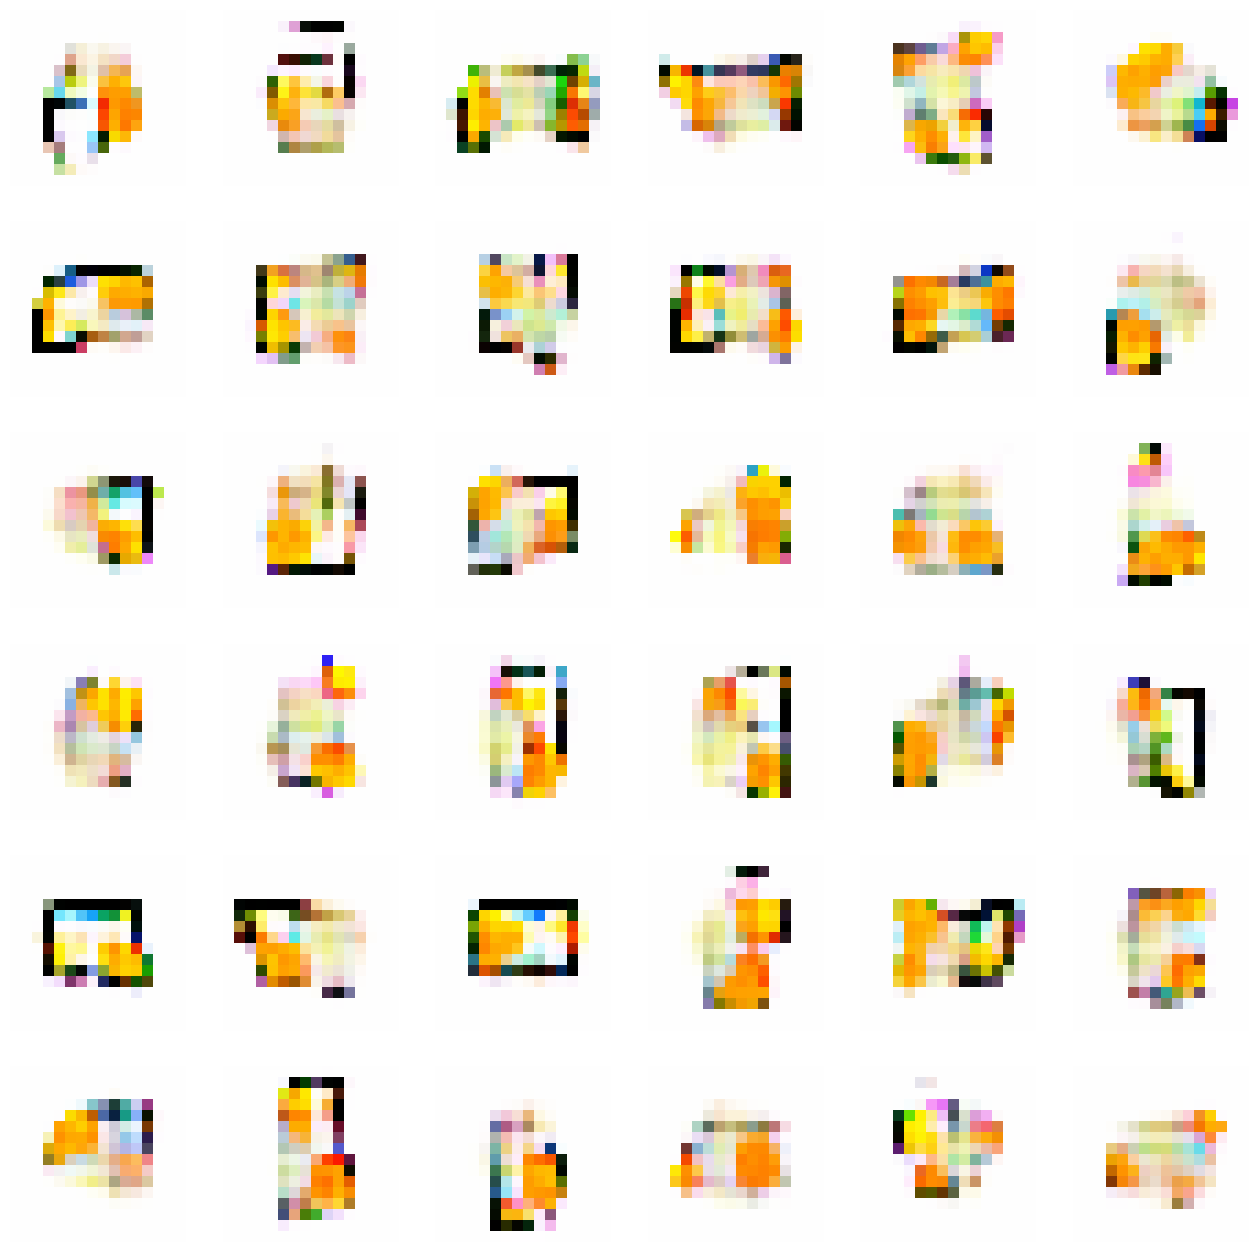

25/25 [==============================] - 121s 5s/step - d_loss: -7.0270 - g_loss: 9.2233
Epoch 34/50
25/25 [==============================] - ETA: 0s - d_loss: -7.1519 - g_loss: 9.6661

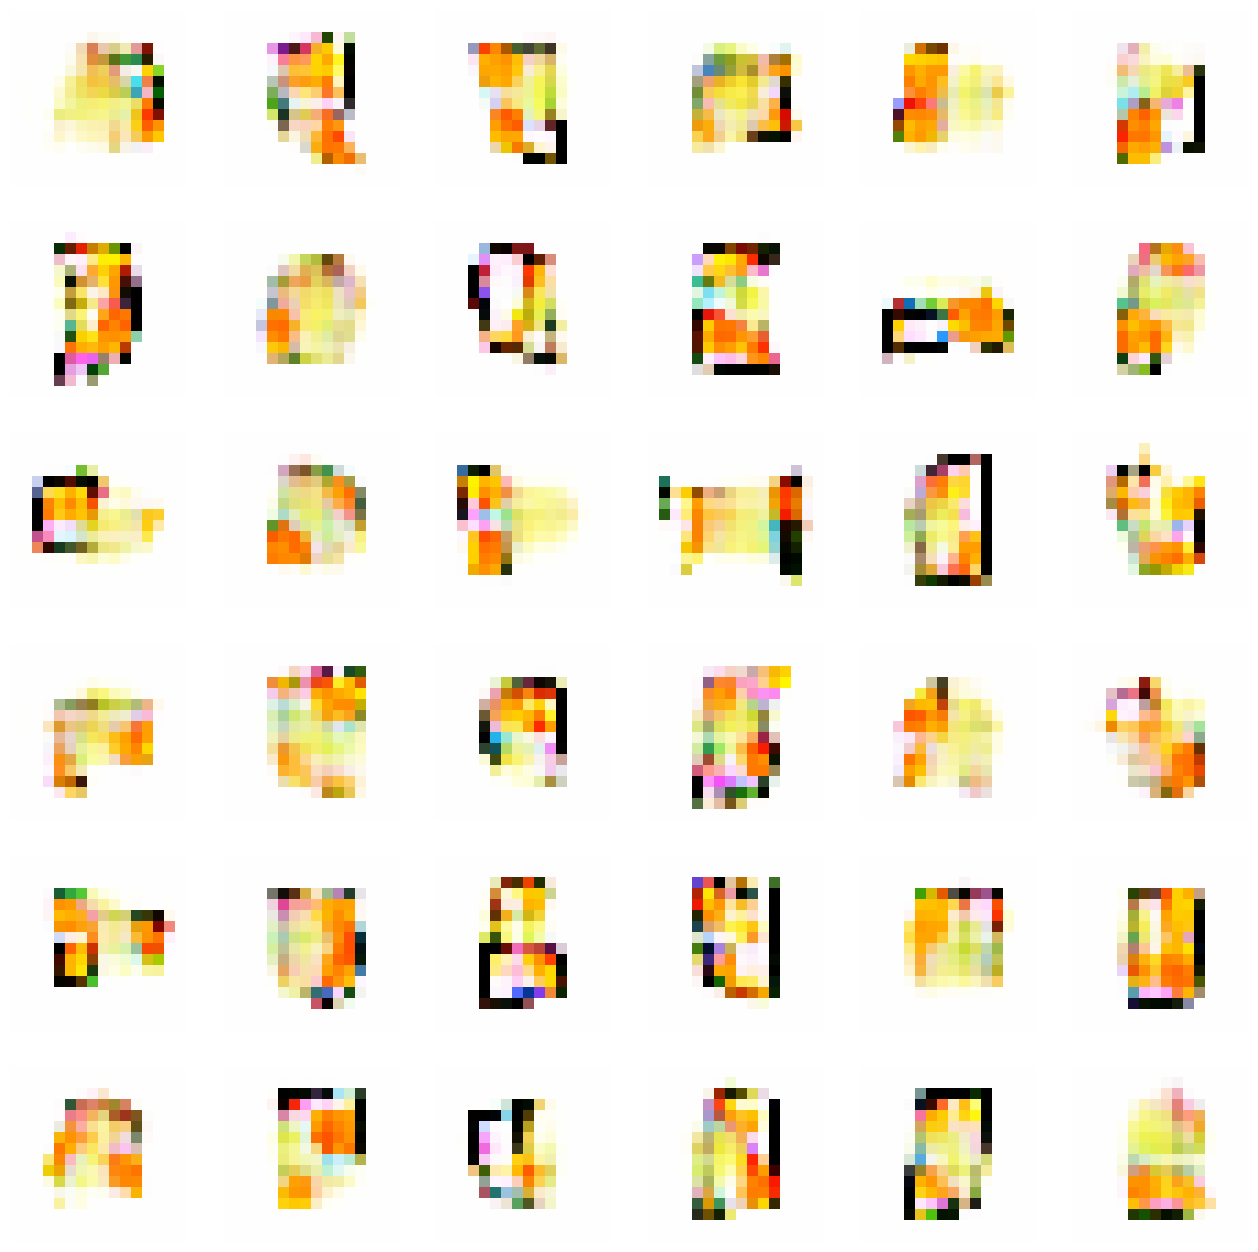

25/25 [==============================] - 122s 5s/step - d_loss: -7.1399 - g_loss: 9.7112
Epoch 35/50
25/25 [==============================] - ETA: 0s - d_loss: -6.7234 - g_loss: 7.2327

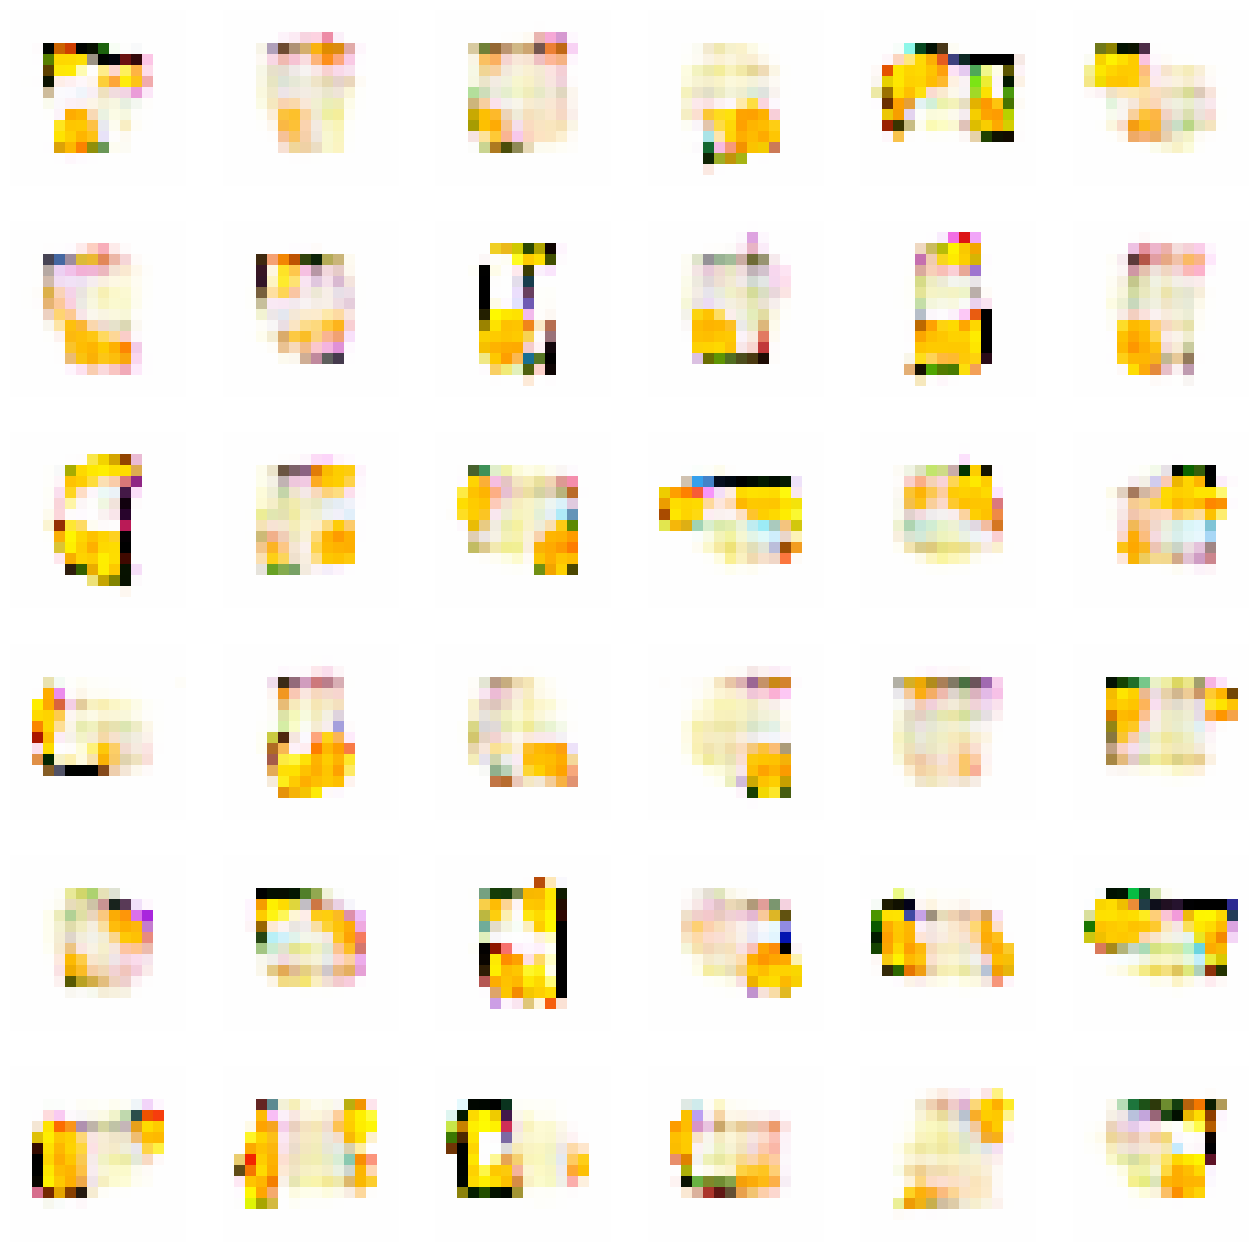

25/25 [==============================] - 122s 5s/step - d_loss: -6.8216 - g_loss: 7.0372
Epoch 36/50
25/25 [==============================] - ETA: 0s - d_loss: -7.1171 - g_loss: 9.3973 

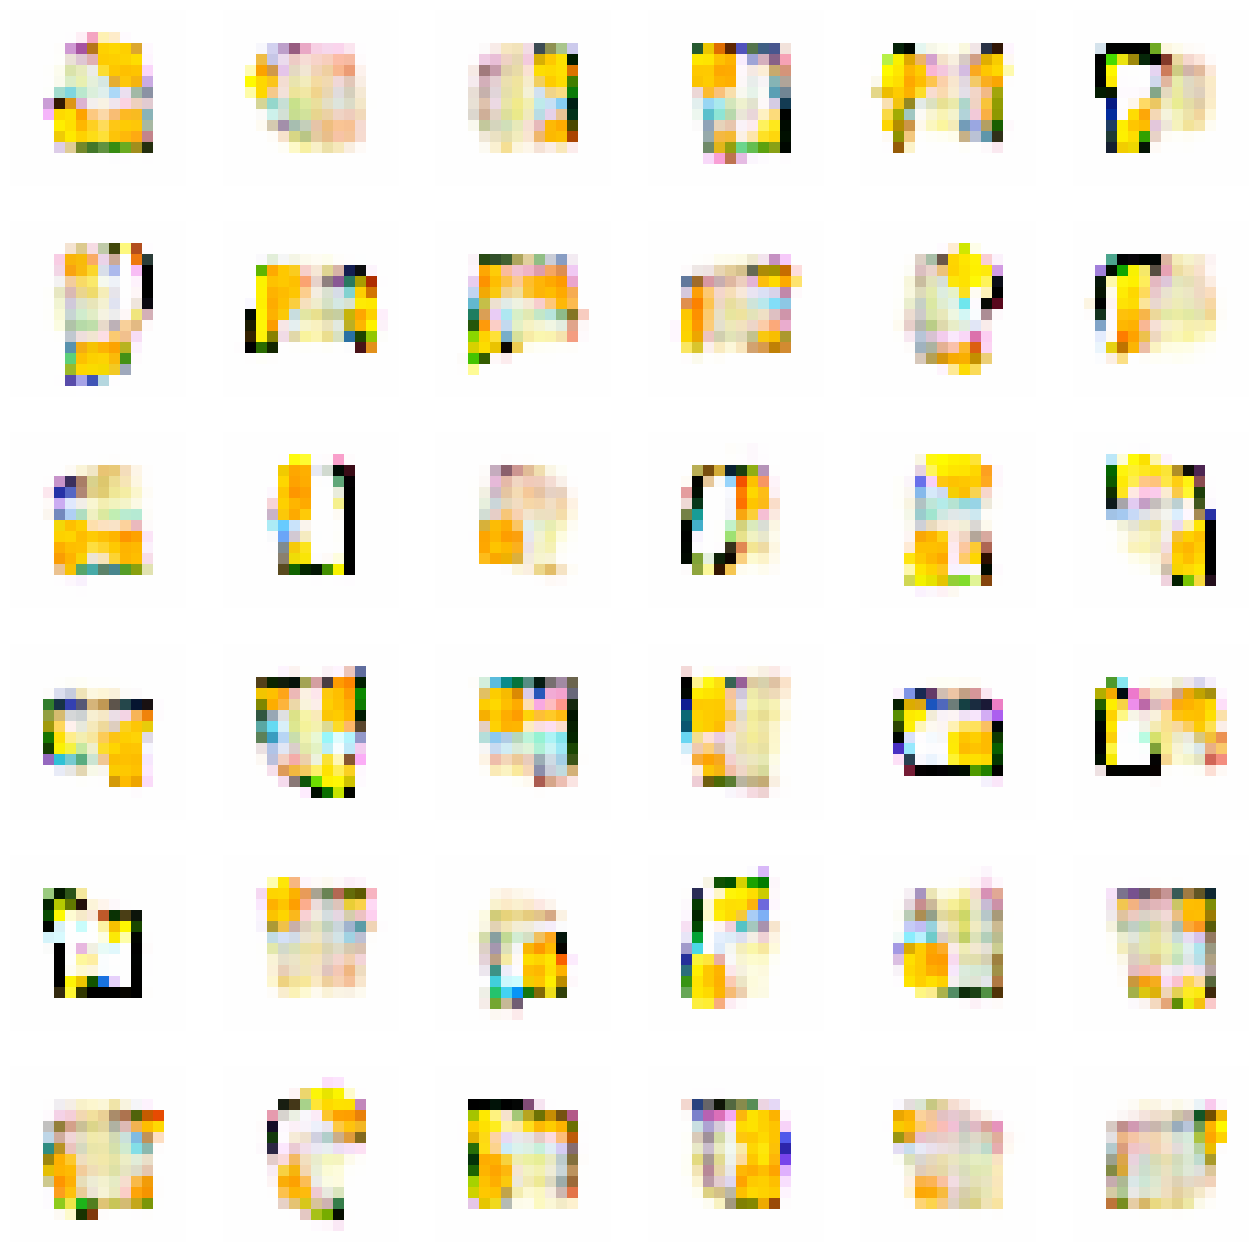

25/25 [==============================] - 124s 5s/step - d_loss: -7.0666 - g_loss: 8.8076
Epoch 37/50
25/25 [==============================] - ETA: 0s - d_loss: -7.0885 - g_loss: 8.9257

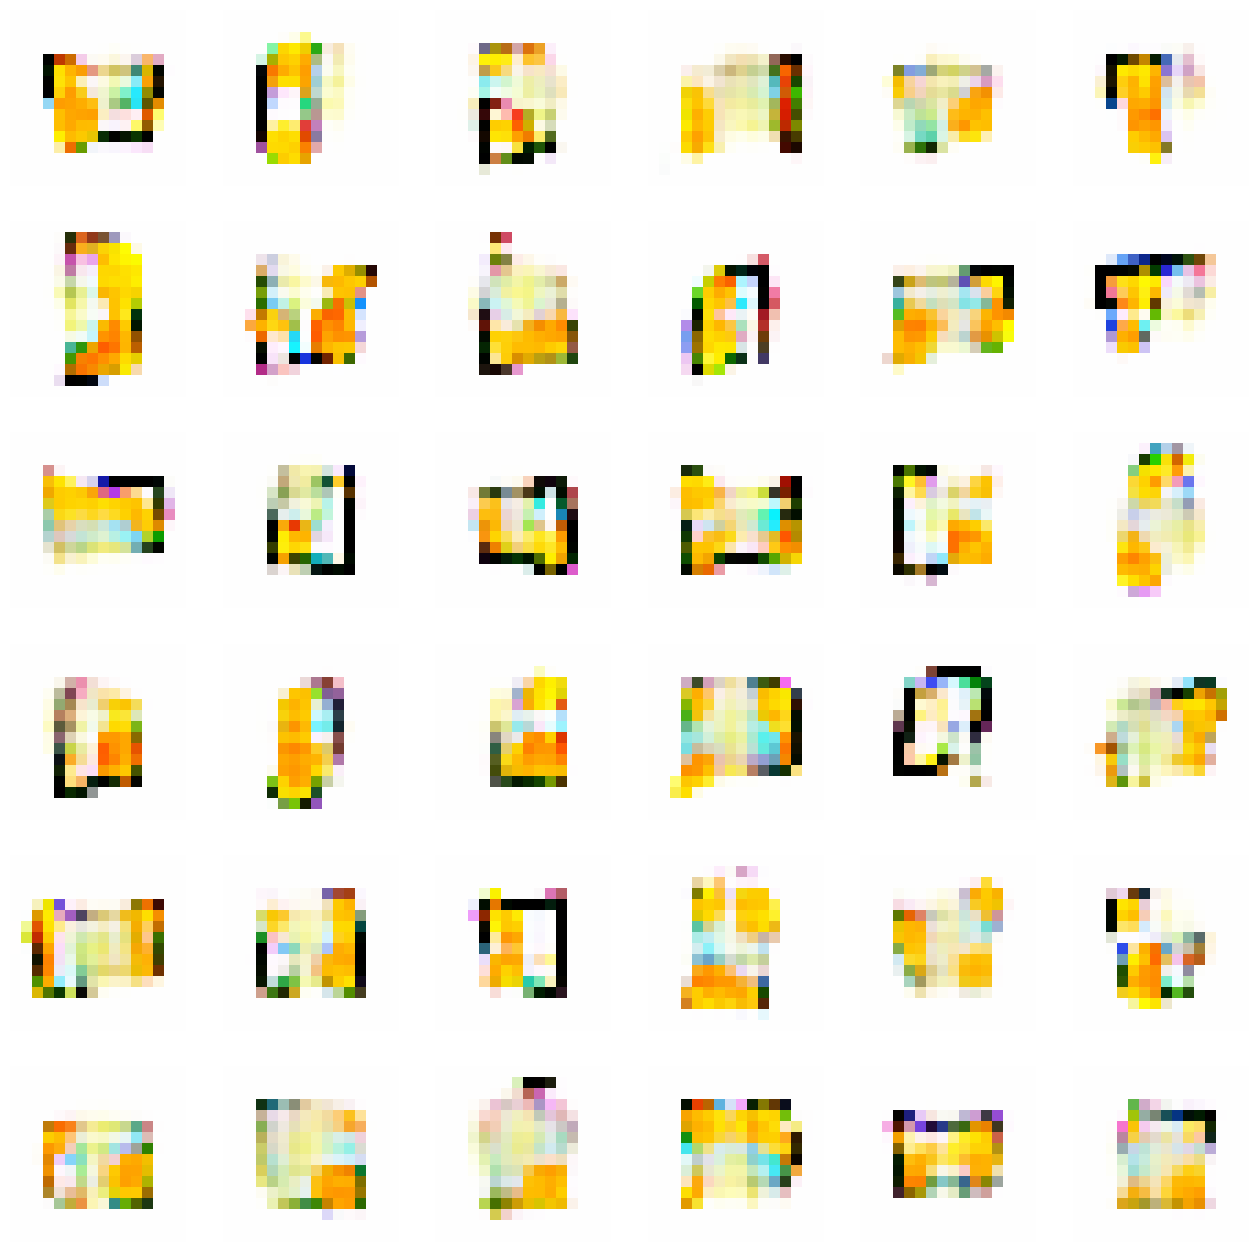

25/25 [==============================] - 126s 5s/step - d_loss: -7.1305 - g_loss: 8.7295
Epoch 38/50
25/25 [==============================] - ETA: 0s - d_loss: -6.9922 - g_loss: 9.2518

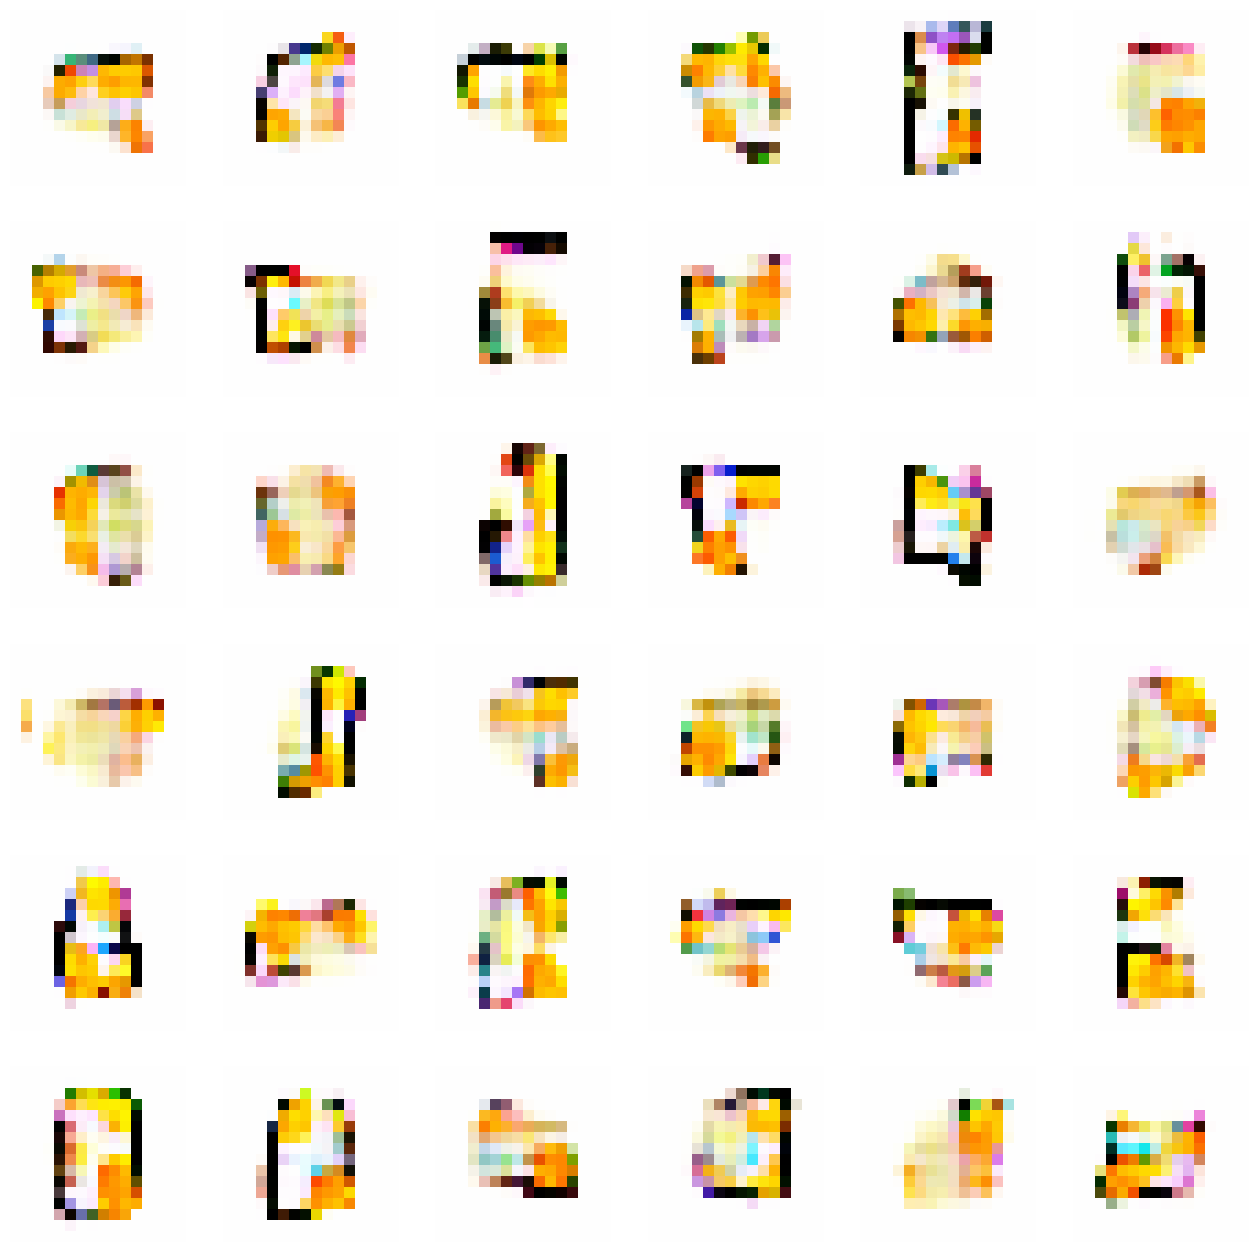

25/25 [==============================] - 128s 5s/step - d_loss: -6.9700 - g_loss: 9.9903
Epoch 39/50
25/25 [==============================] - ETA: 0s - d_loss: -7.4277 - g_loss: 8.5885

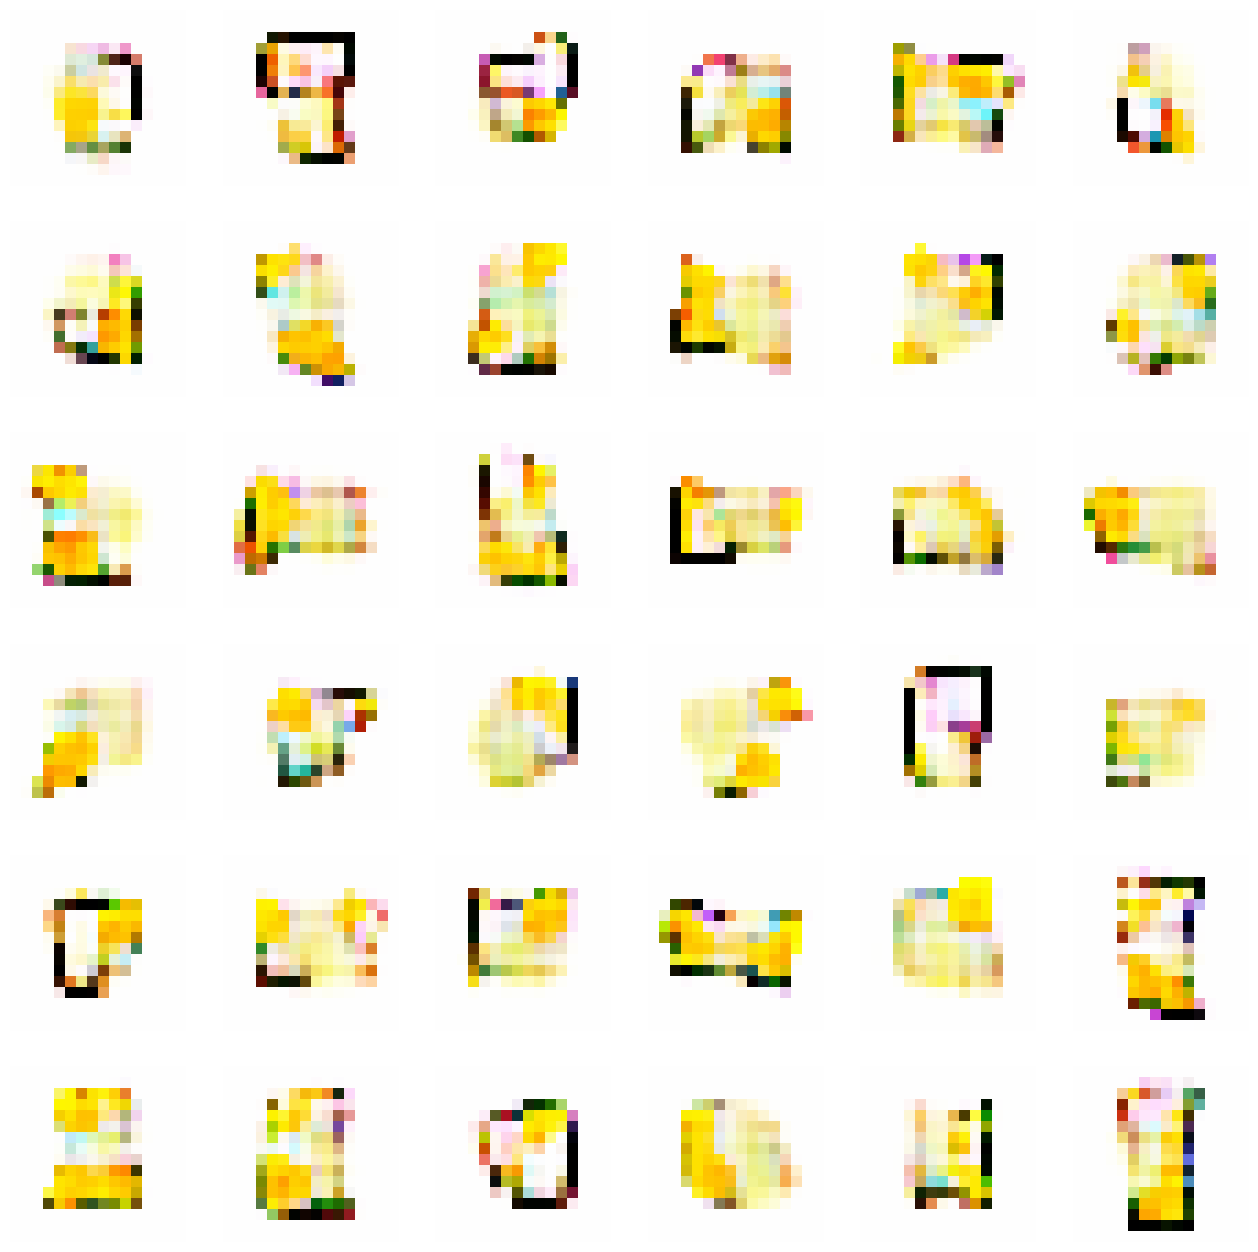

25/25 [==============================] - 121s 5s/step - d_loss: -7.4080 - g_loss: 7.8126
Epoch 40/50
25/25 [==============================] - ETA: 0s - d_loss: -6.5559 - g_loss: 8.0905

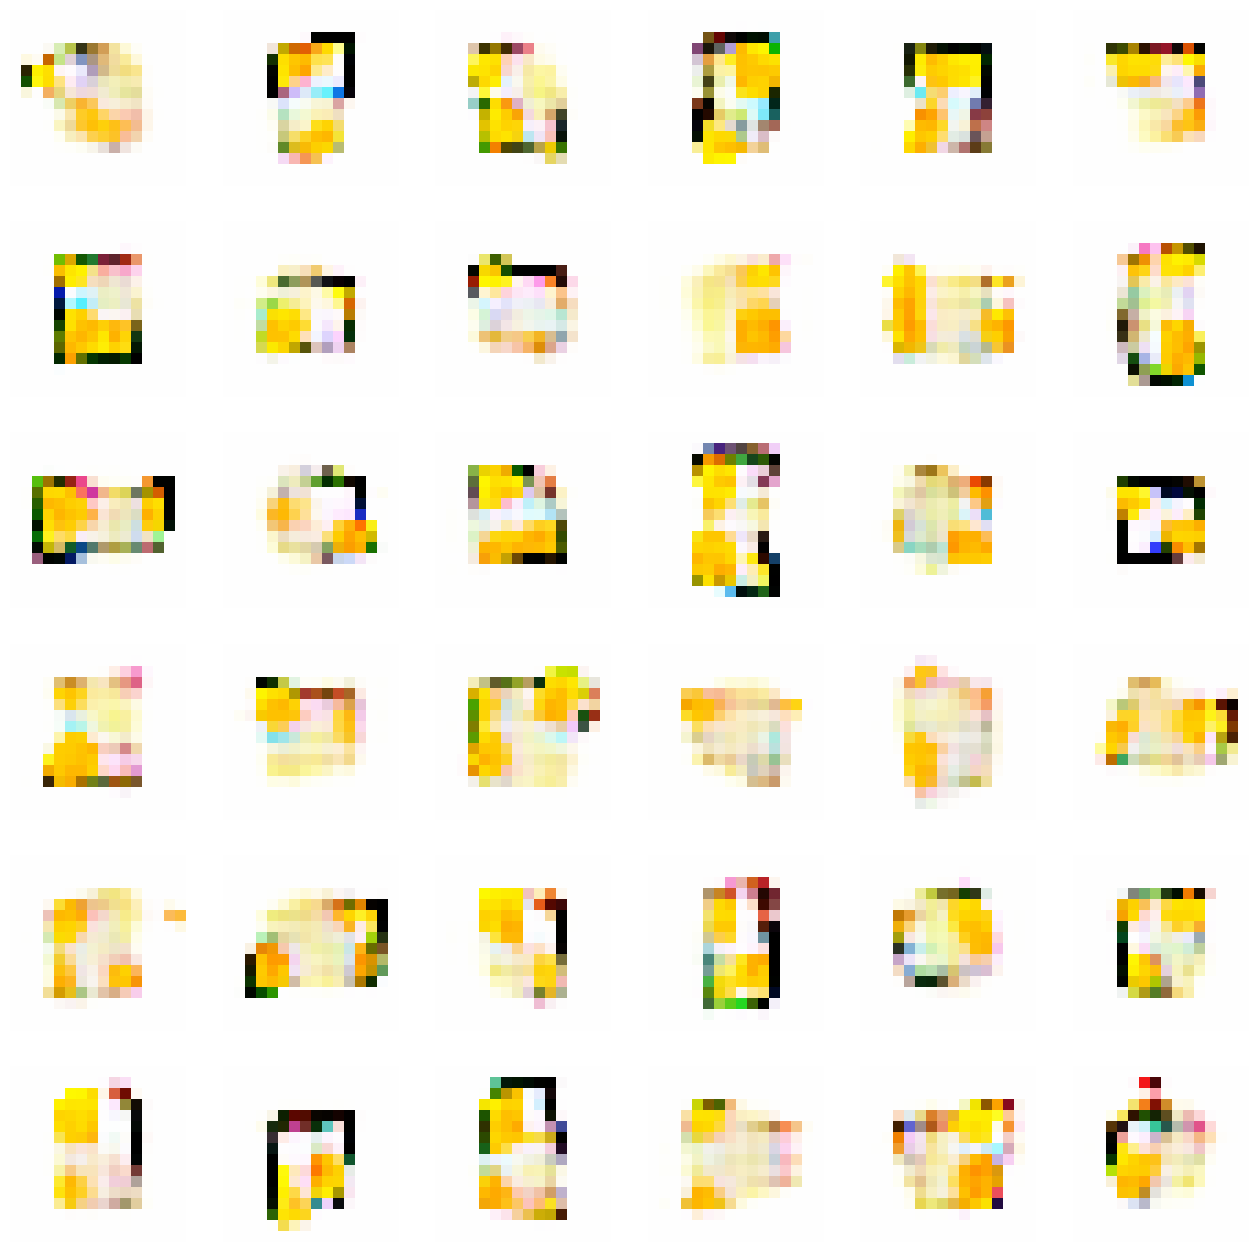

25/25 [==============================] - 119s 5s/step - d_loss: -6.6307 - g_loss: 8.2747
Epoch 41/50
25/25 [==============================] - ETA: 0s - d_loss: -7.0018 - g_loss: 8.9518

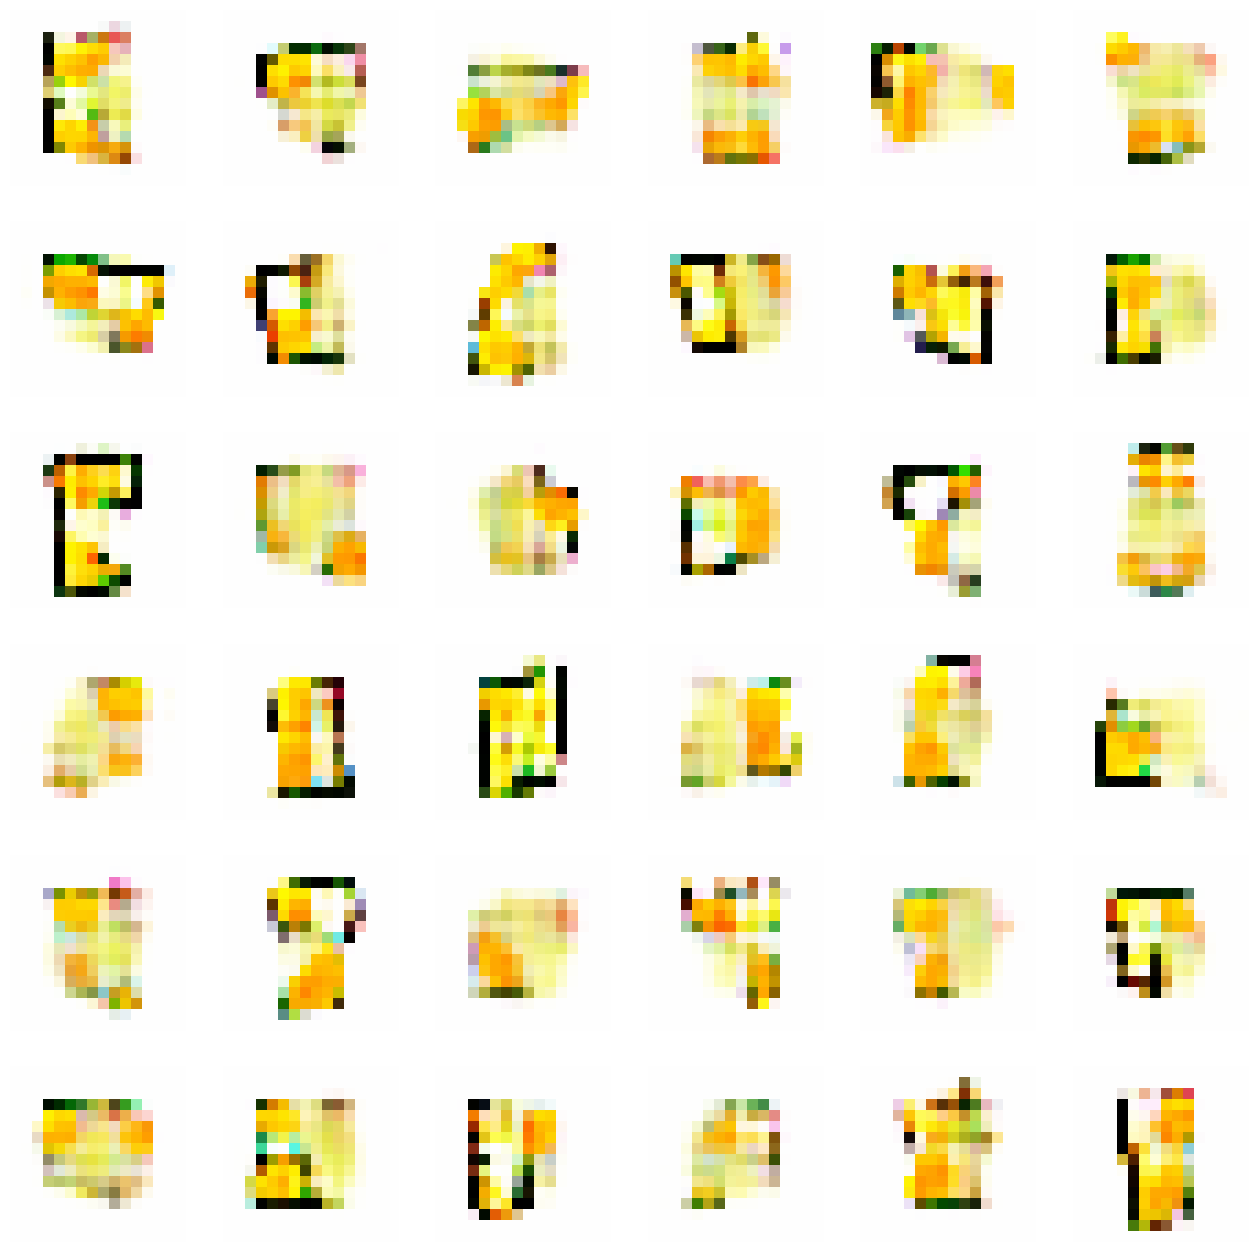

25/25 [==============================] - 120s 5s/step - d_loss: -7.1151 - g_loss: 8.9106
Epoch 42/50
25/25 [==============================] - ETA: 0s - d_loss: -6.7640 - g_loss: 7.6524

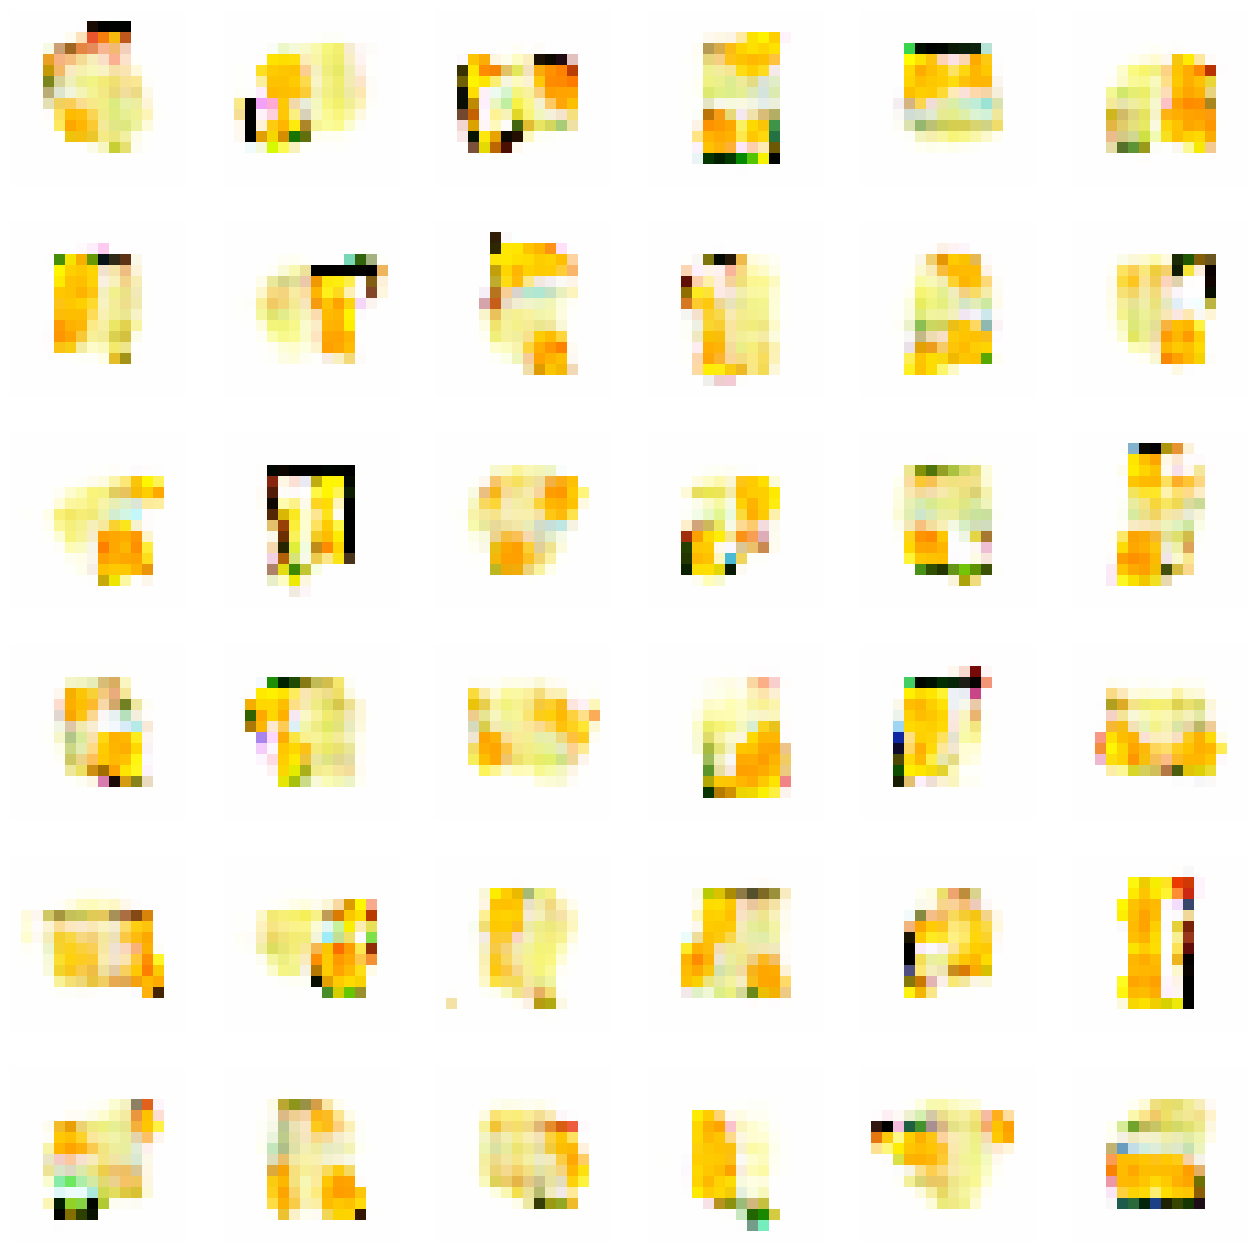

25/25 [==============================] - 120s 5s/step - d_loss: -6.7758 - g_loss: 7.7214
Epoch 43/50
25/25 [==============================] - ETA: 0s - d_loss: -7.3262 - g_loss: 8.8280

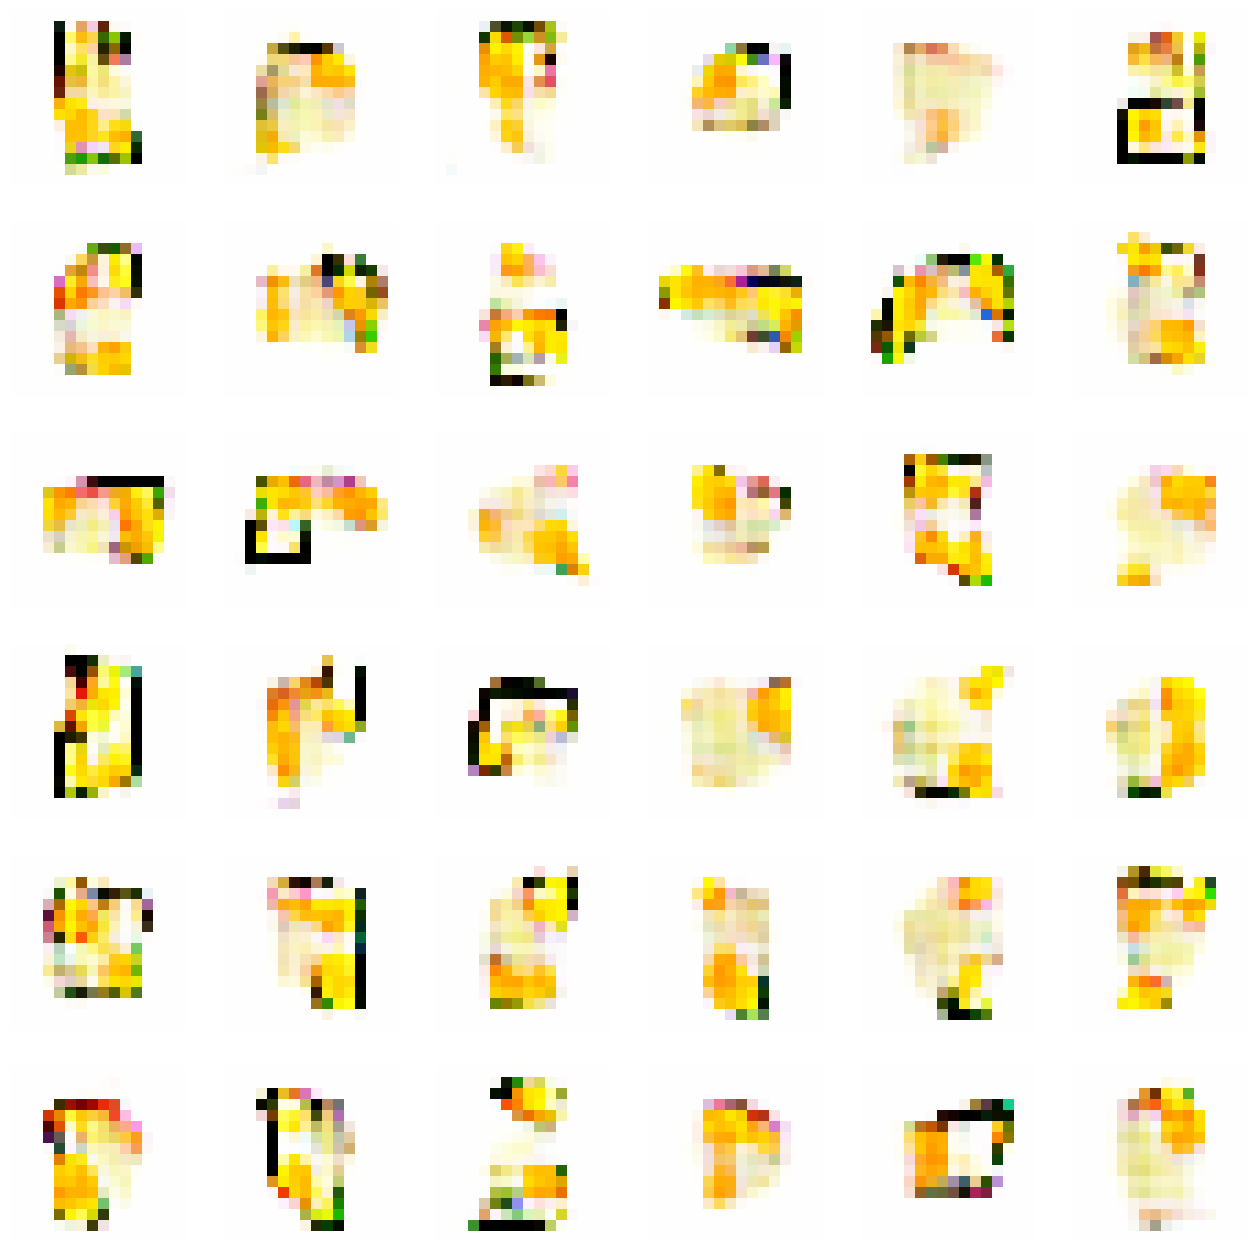

25/25 [==============================] - 124s 5s/step - d_loss: -7.3018 - g_loss: 8.8404
Epoch 44/50
25/25 [==============================] - ETA: 0s - d_loss: -7.4062 - g_loss: 9.9848

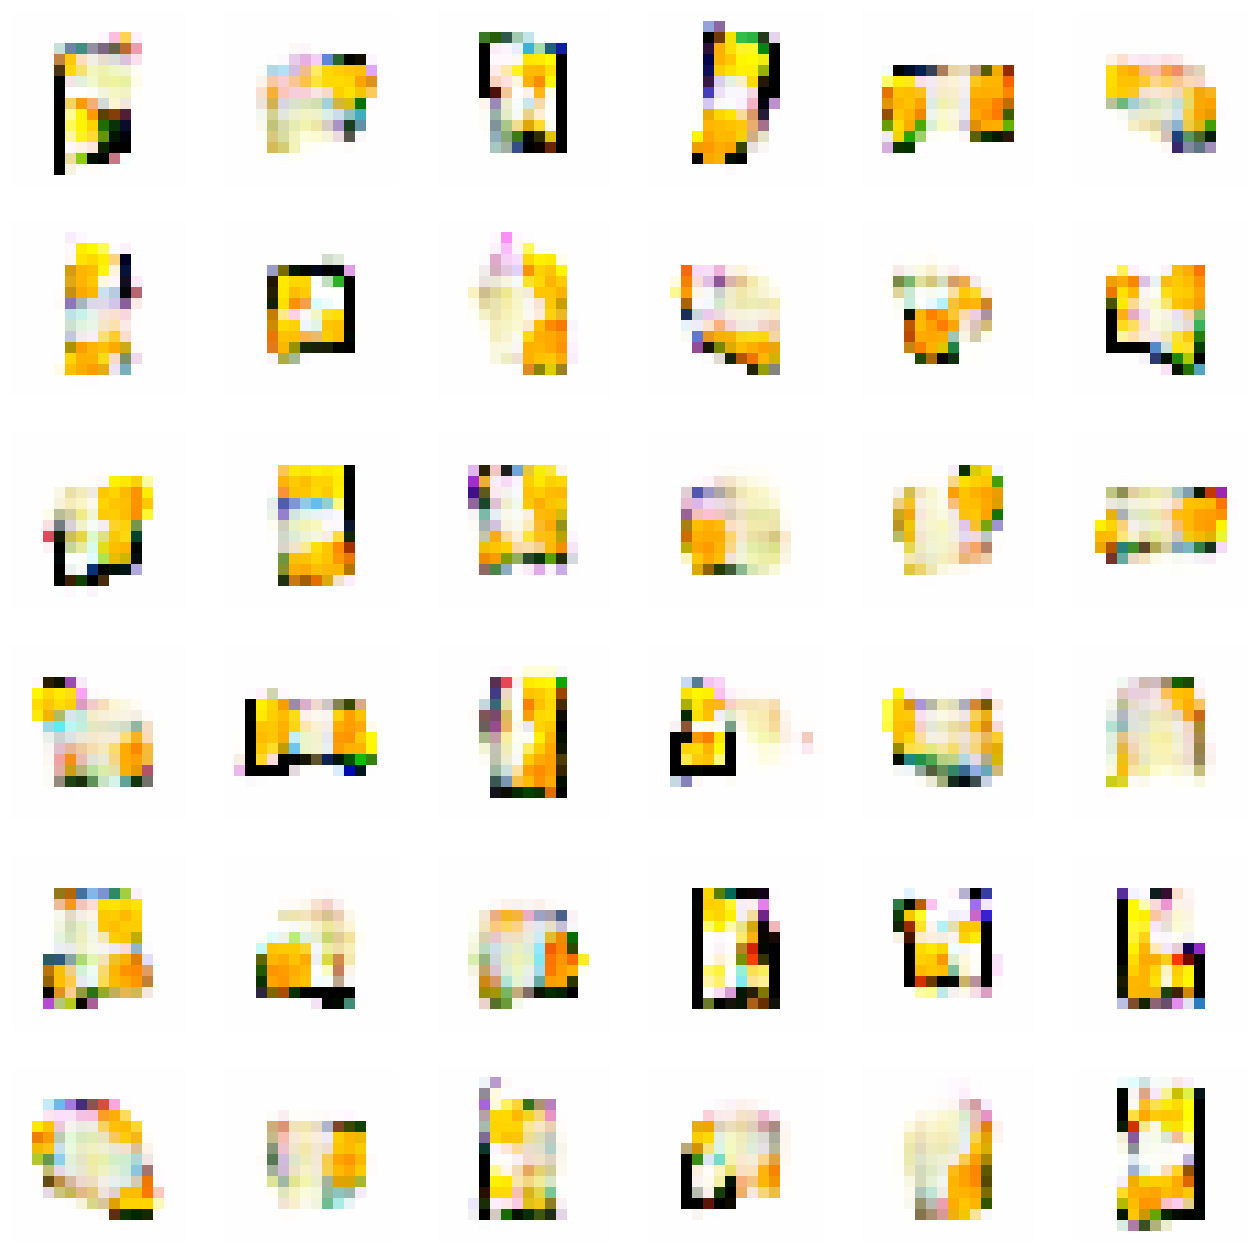

25/25 [==============================] - 122s 5s/step - d_loss: -7.4282 - g_loss: 10.4805
Epoch 45/50
25/25 [==============================] - ETA: 0s - d_loss: -6.7479 - g_loss: 8.0926

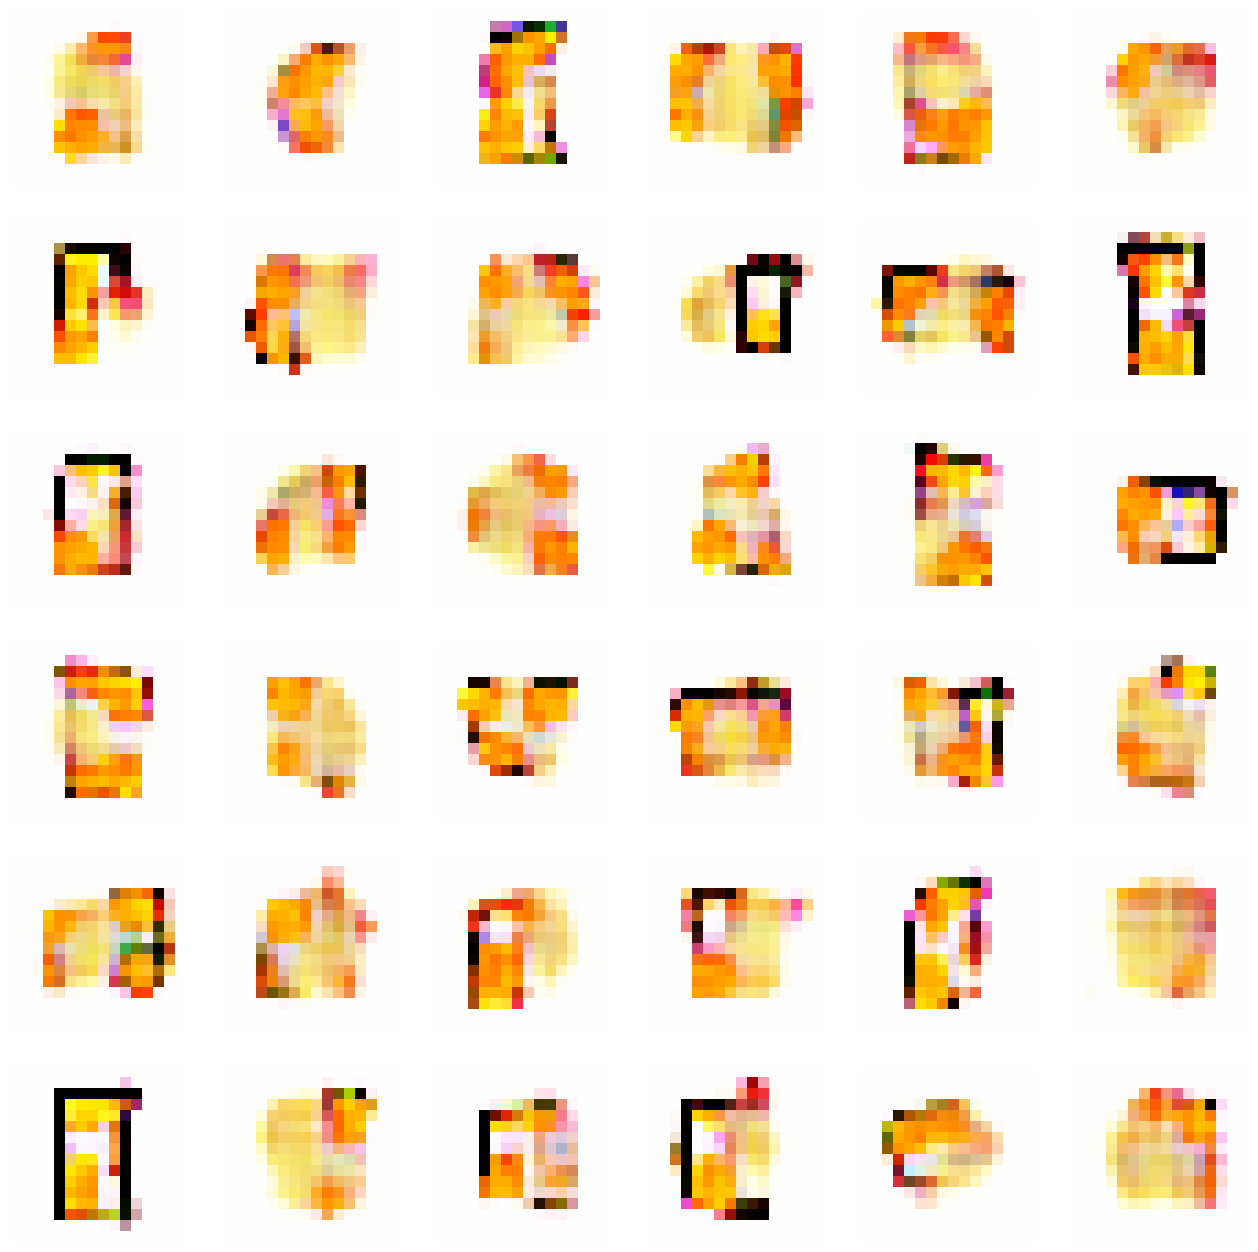

25/25 [==============================] - 120s 5s/step - d_loss: -6.7220 - g_loss: 7.9546
Epoch 46/50
25/25 [==============================] - ETA: 0s - d_loss: -7.4908 - g_loss: 9.3292

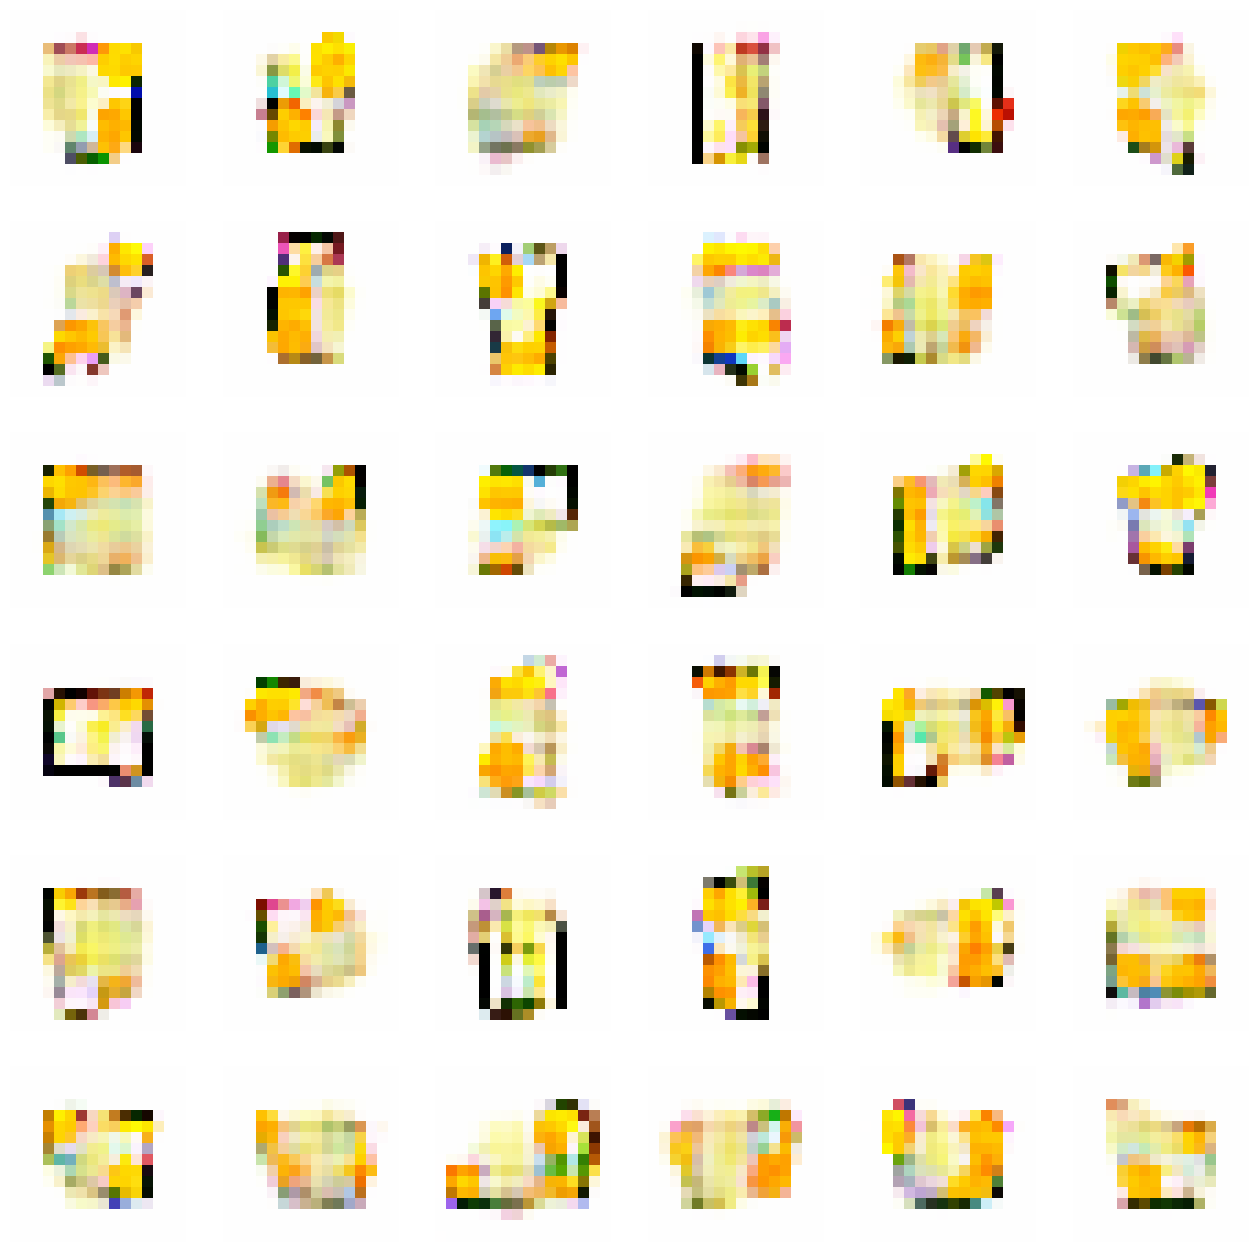

25/25 [==============================] - 121s 5s/step - d_loss: -7.4415 - g_loss: 9.3495
Epoch 47/50
25/25 [==============================] - ETA: 0s - d_loss: -7.2184 - g_loss: 9.0748

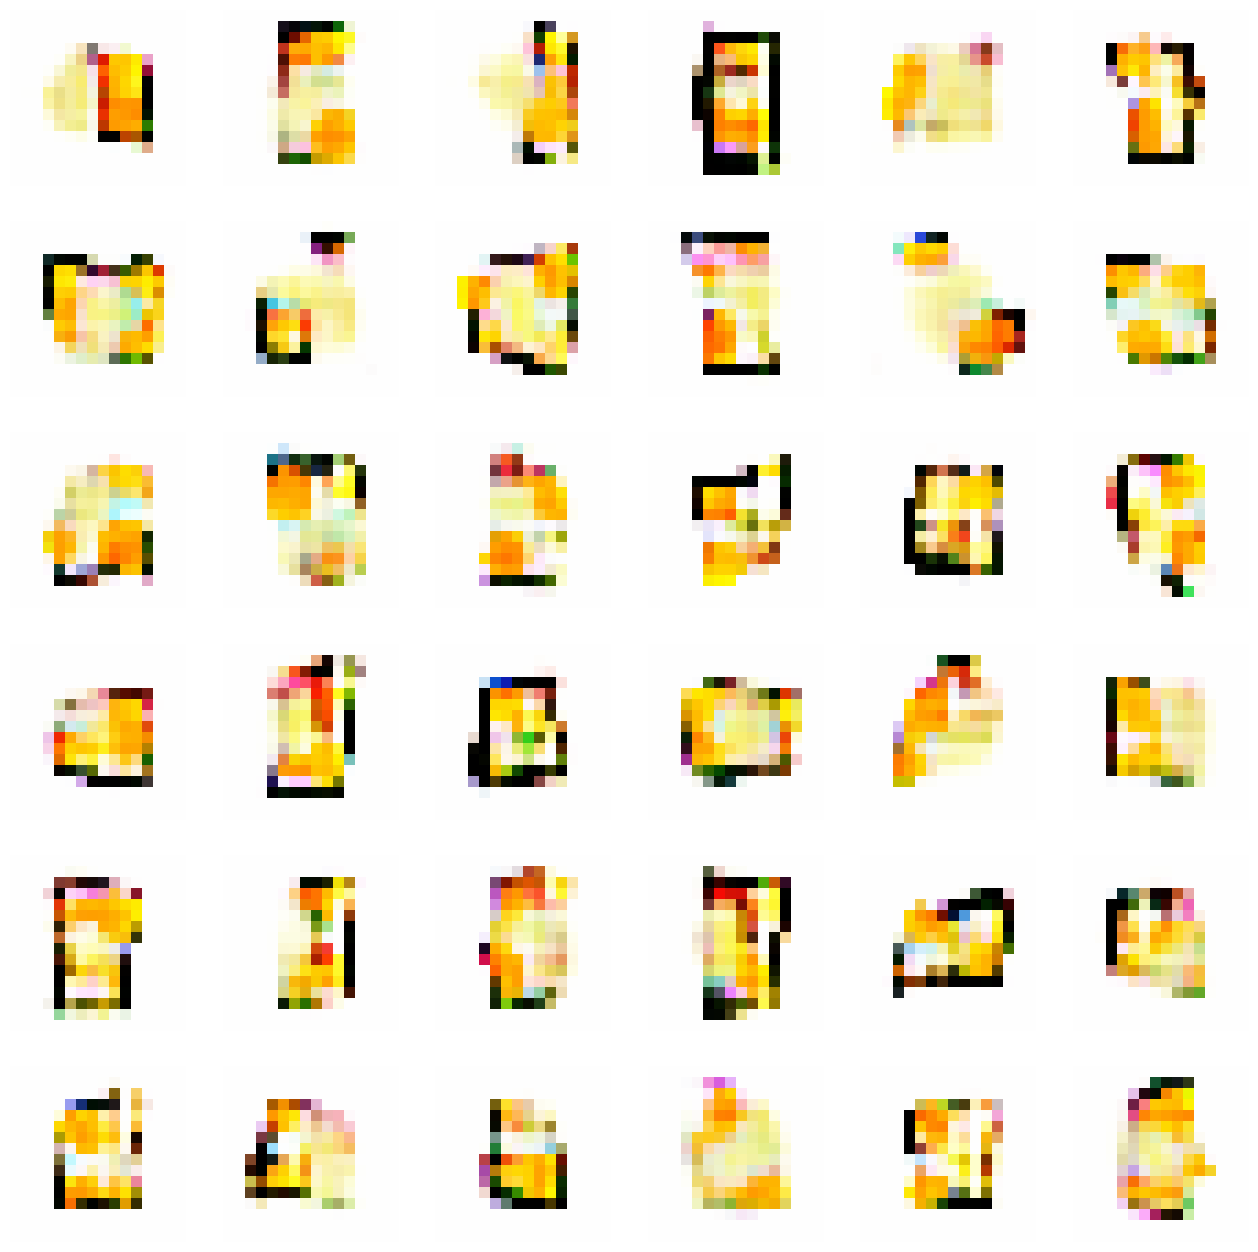

25/25 [==============================] - 119s 5s/step - d_loss: -7.1981 - g_loss: 9.4586
Epoch 48/50
25/25 [==============================] - ETA: 0s - d_loss: -7.1628 - g_loss: 8.8176

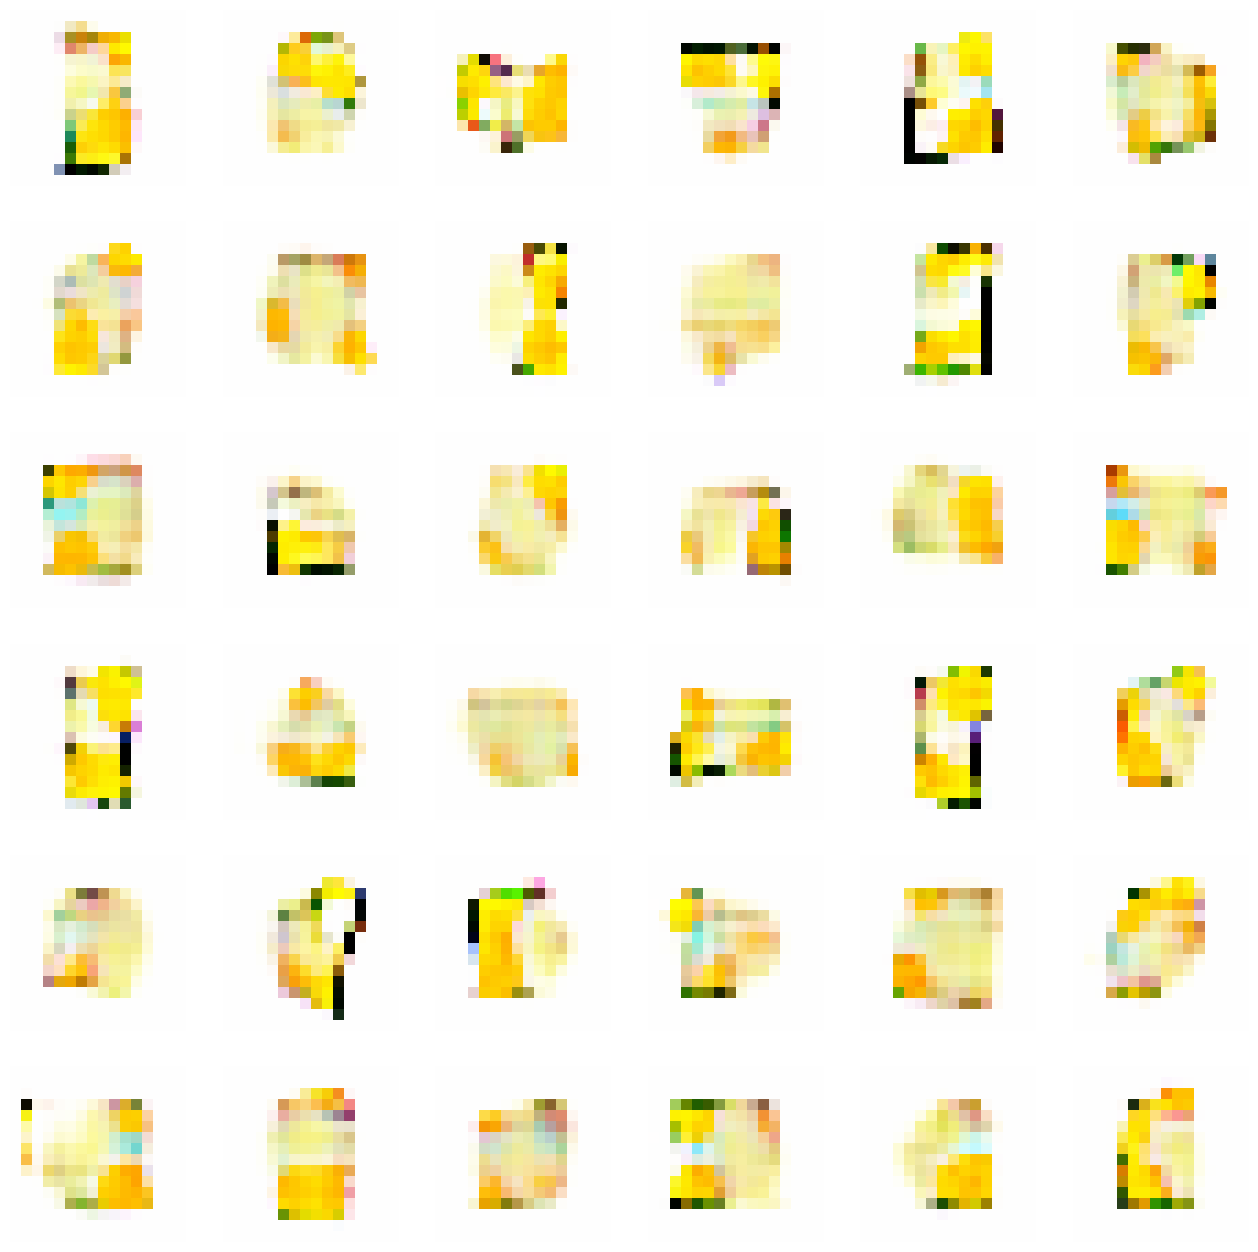

25/25 [==============================] - 121s 5s/step - d_loss: -7.1409 - g_loss: 9.1760
Epoch 49/50
25/25 [==============================] - ETA: 0s - d_loss: -7.5876 - g_loss: 8.9611

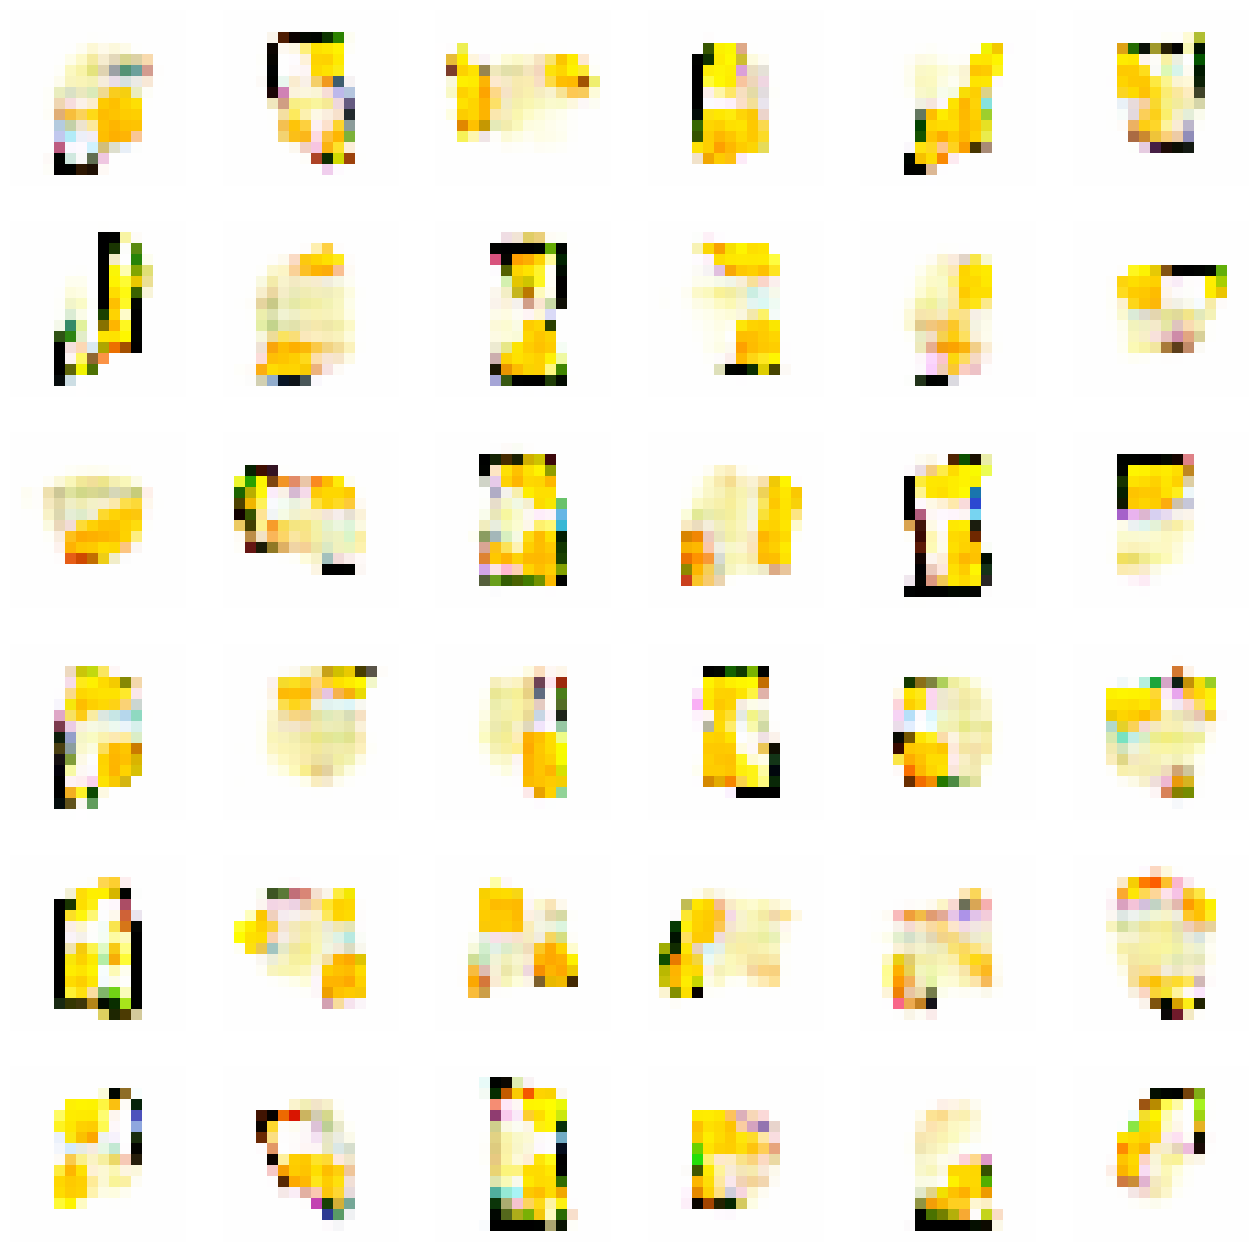

25/25 [==============================] - 121s 5s/step - d_loss: -7.5619 - g_loss: 8.0801
Epoch 50/50
25/25 [==============================] - ETA: 0s - d_loss: -7.3881 - g_loss: 10.1038

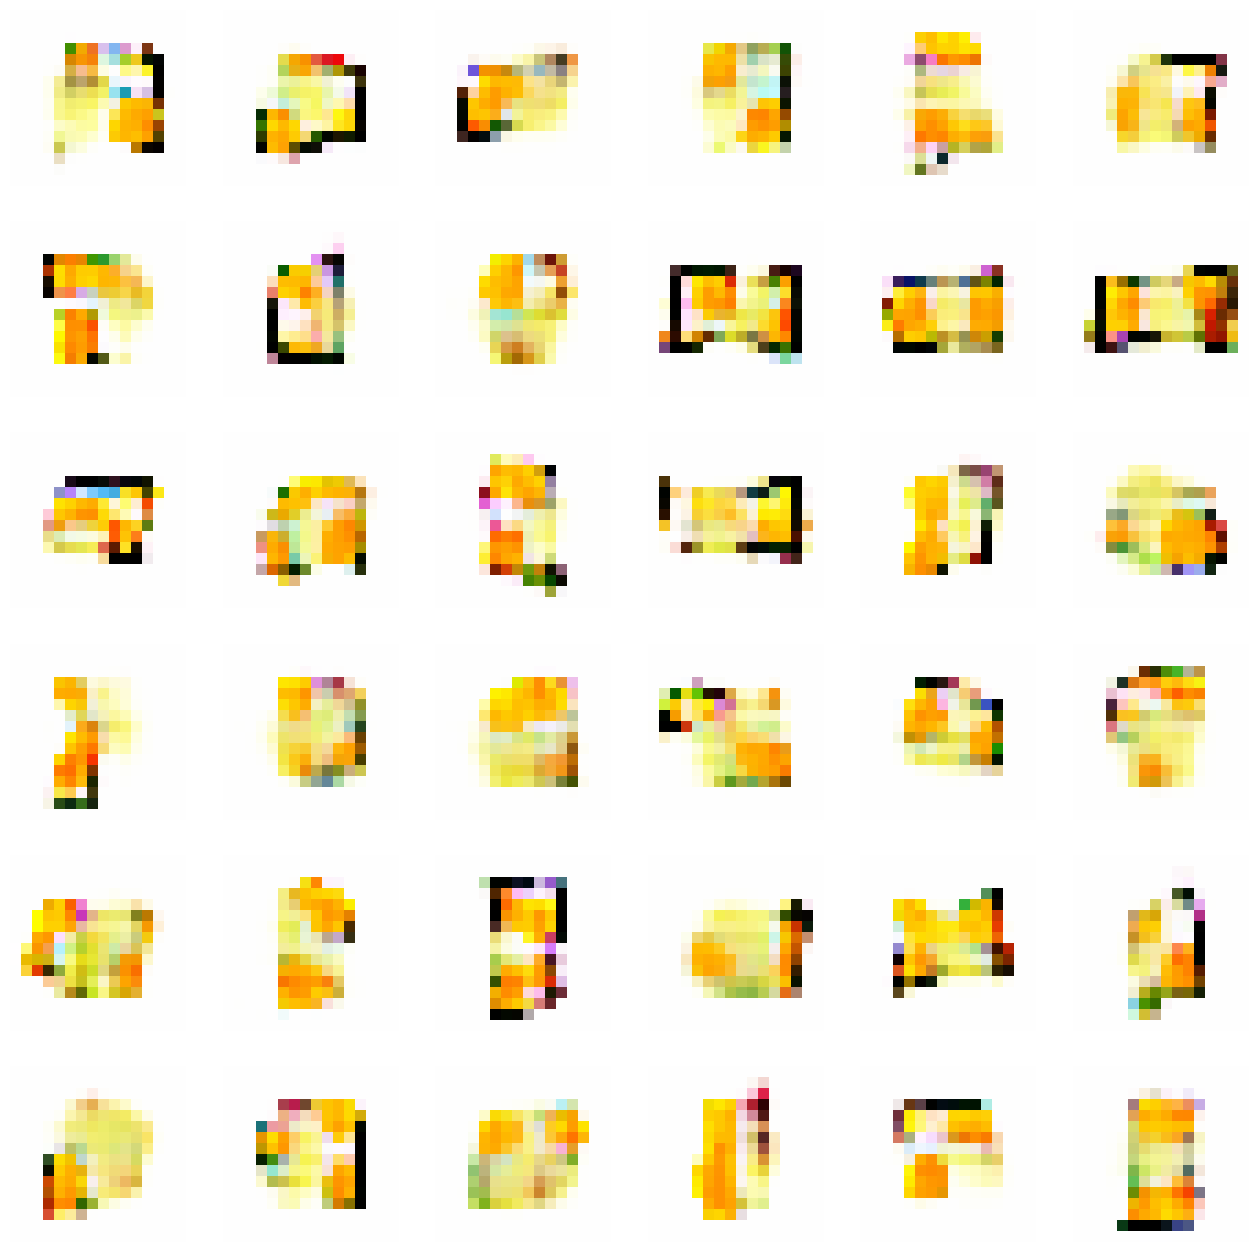

25/25 [==============================] - 121s 5s/step - d_loss: -7.3991 - g_loss: 10.3467
Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_39 (InputLayer)       [(None, 512)]                0         []                            
                                                                                                  
 input_40 (InputLayer)       [(None, 256)]                0         []                            
                                                                                                  
 concatenate_17 (Concatenat  (None, 768)                  0         ['input_39[0][0]',            
 e)                                                                  'input_40[0][0]']            
                                                                                                  


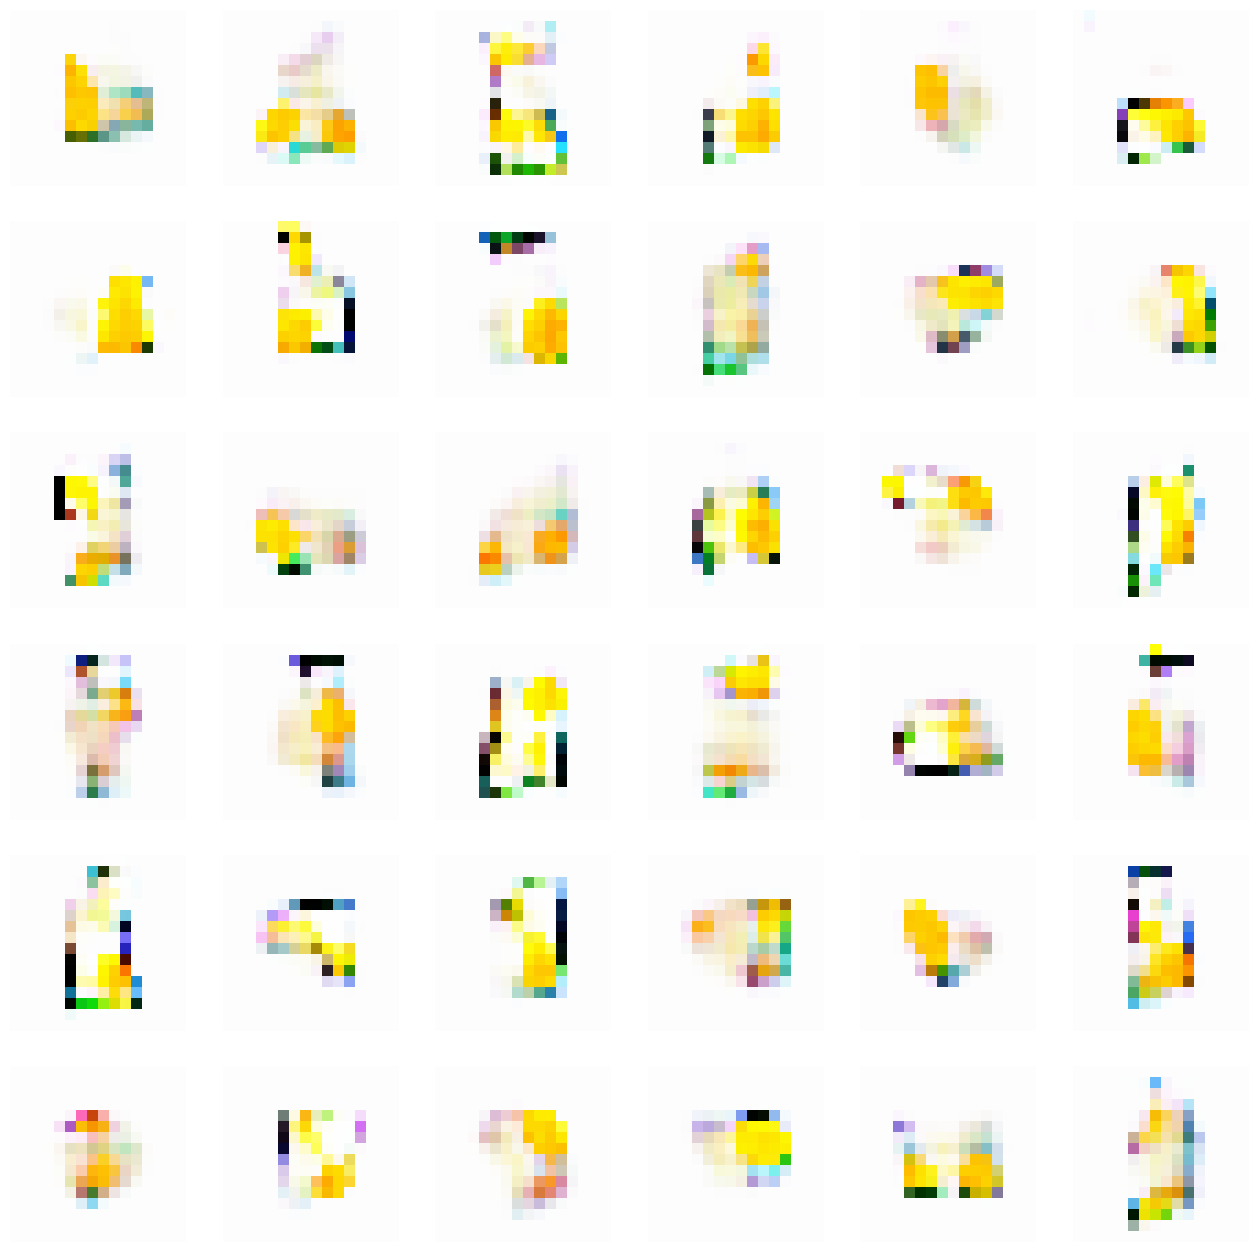

25/25 [==============================] - 419s 16s/step - d_loss: 0.1654 - g_loss: -1.6283
Epoch 2/50
25/25 [==============================] - ETA: 0s - d_loss: -1.0493 - g_loss: 0.2178 

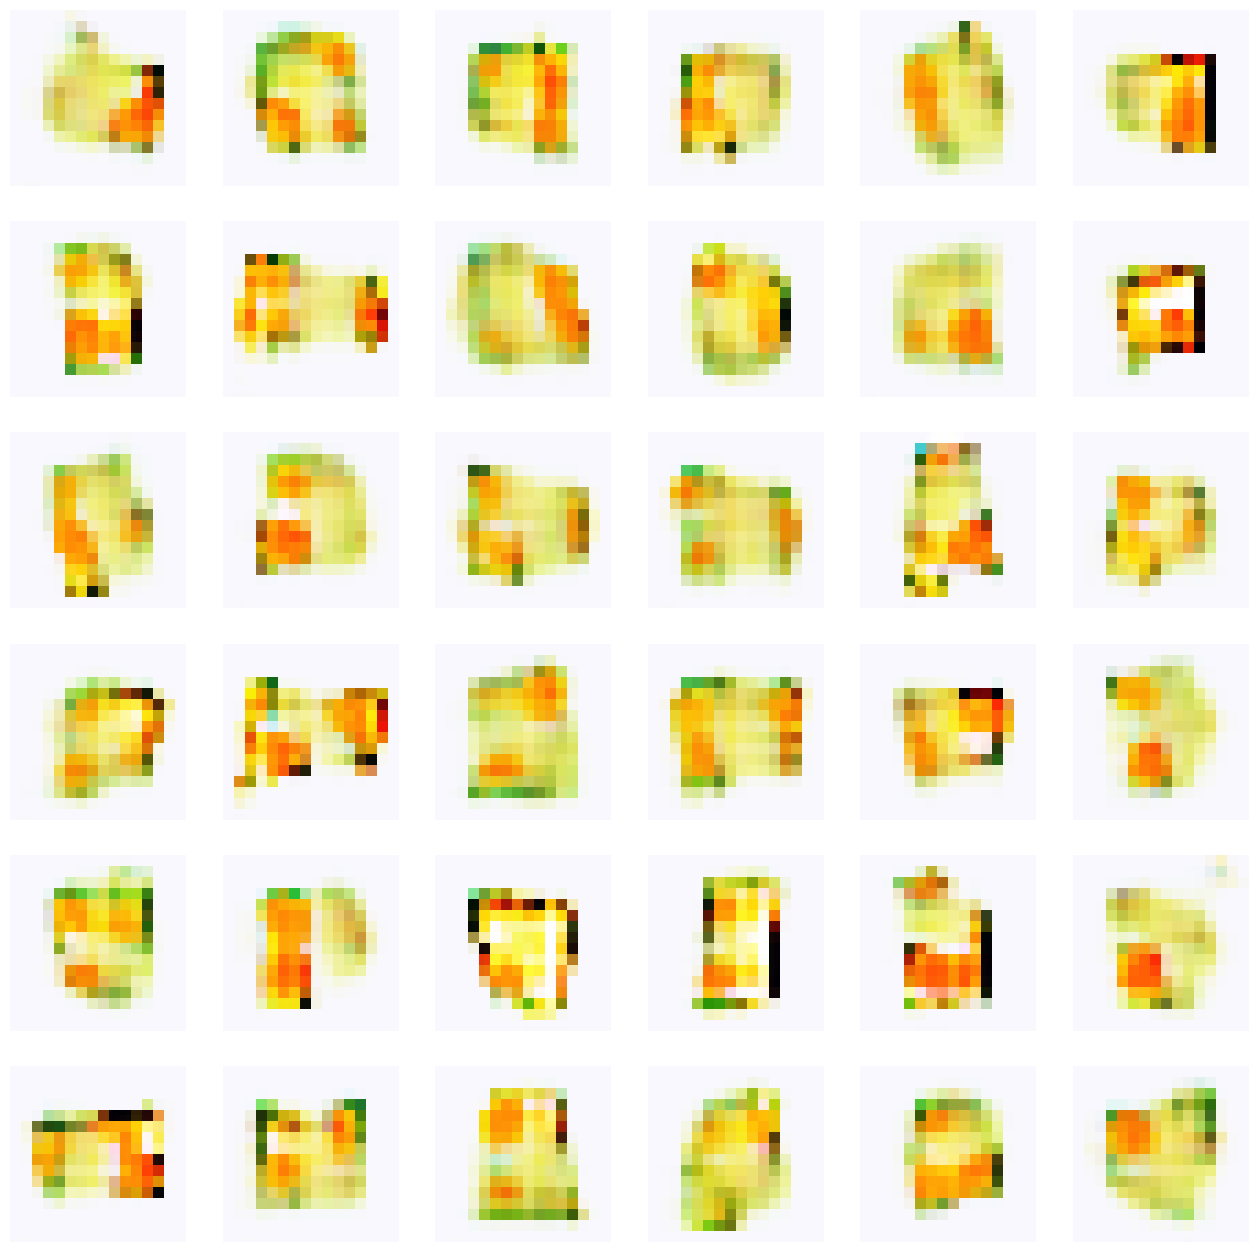

25/25 [==============================] - 415s 17s/step - d_loss: -1.0323 - g_loss: -0.3186
Epoch 3/50
25/25 [==============================] - ETA: 0s - d_loss: -7.2891 - g_loss: 6.4024 

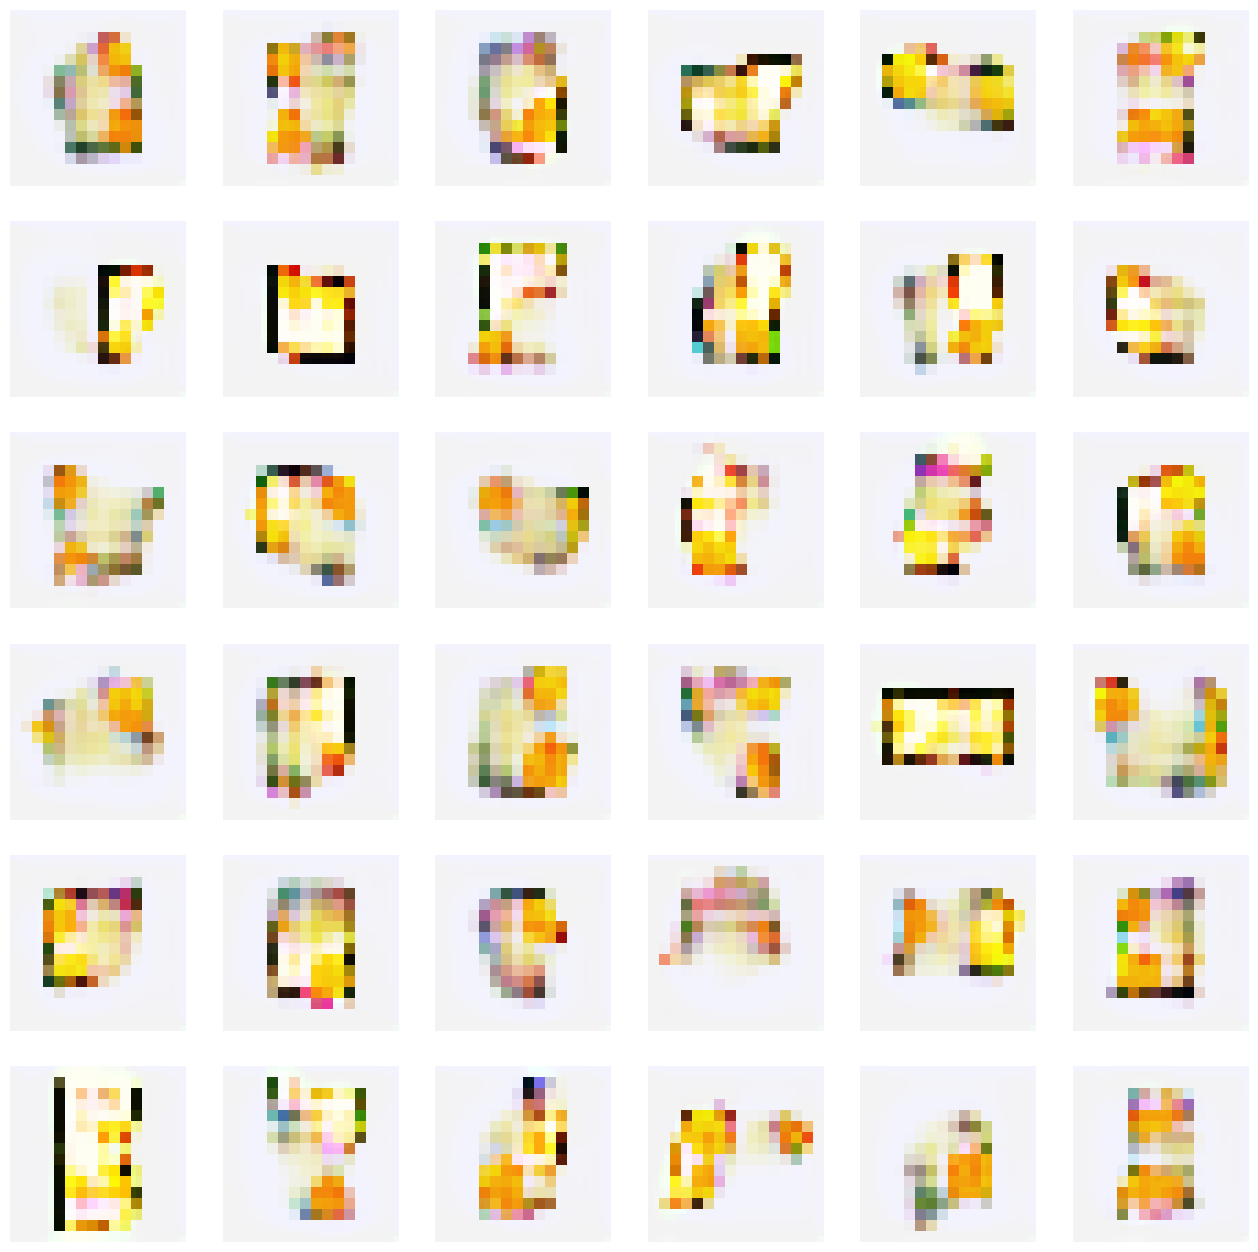

25/25 [==============================] - 408s 16s/step - d_loss: -7.5270 - g_loss: 6.7345
Epoch 4/50
25/25 [==============================] - ETA: 0s - d_loss: -13.2319 - g_loss: 18.9807 

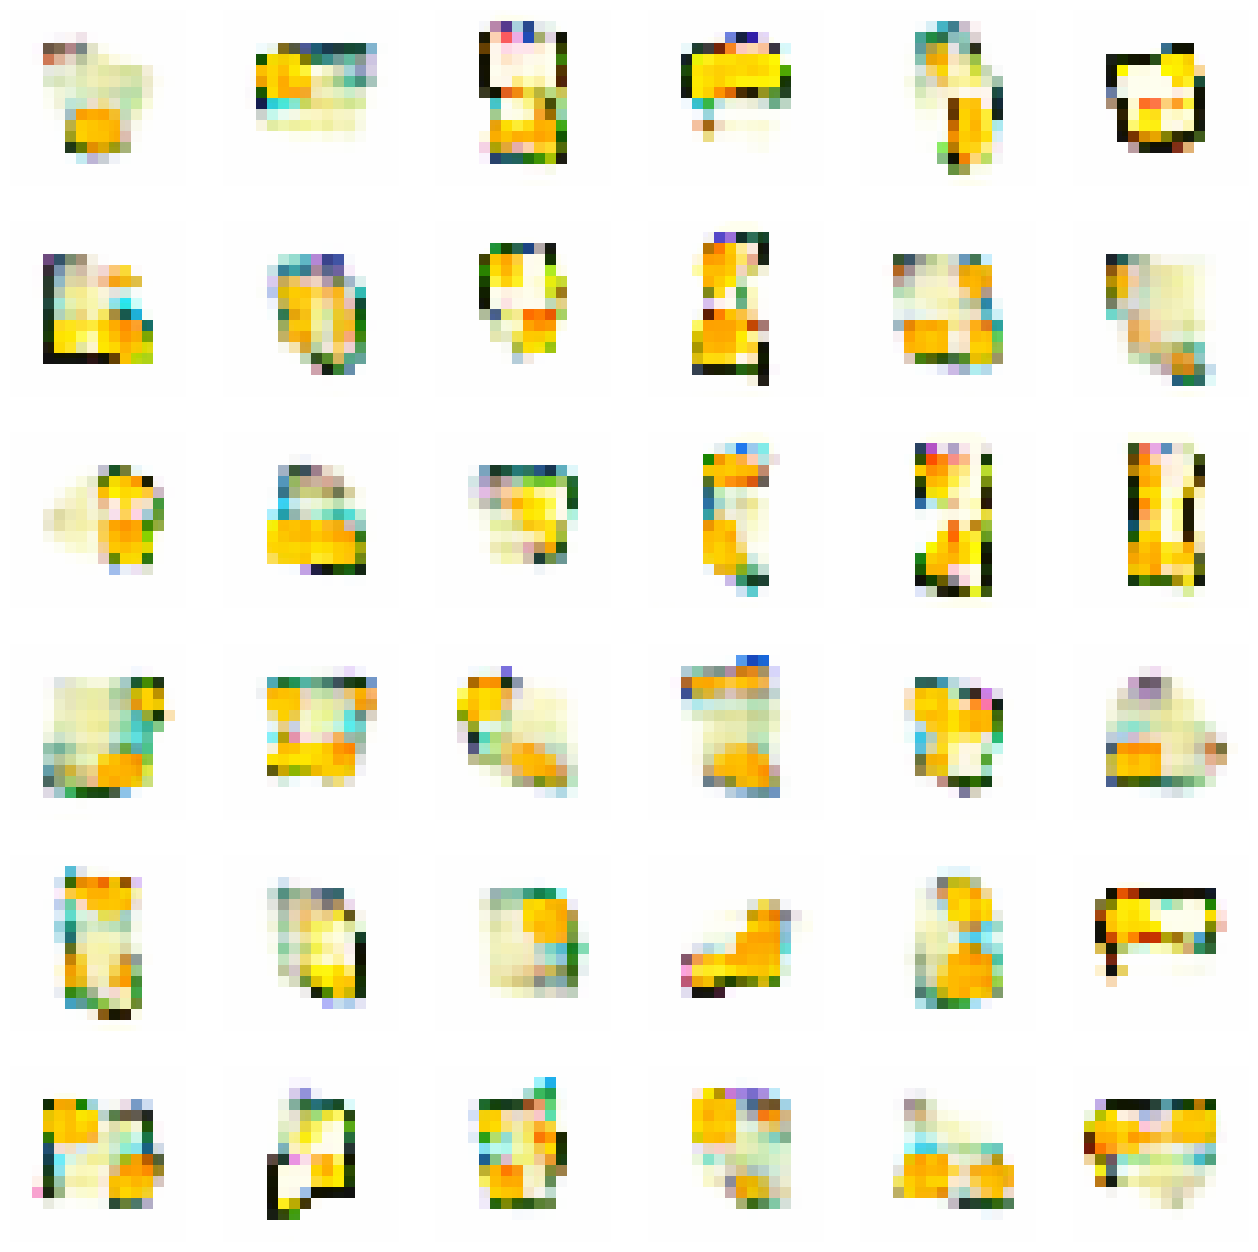

25/25 [==============================] - 415s 17s/step - d_loss: -13.2568 - g_loss: 19.1602
Epoch 5/50
25/25 [==============================] - ETA: 0s - d_loss: -16.5425 - g_loss: 23.1269 

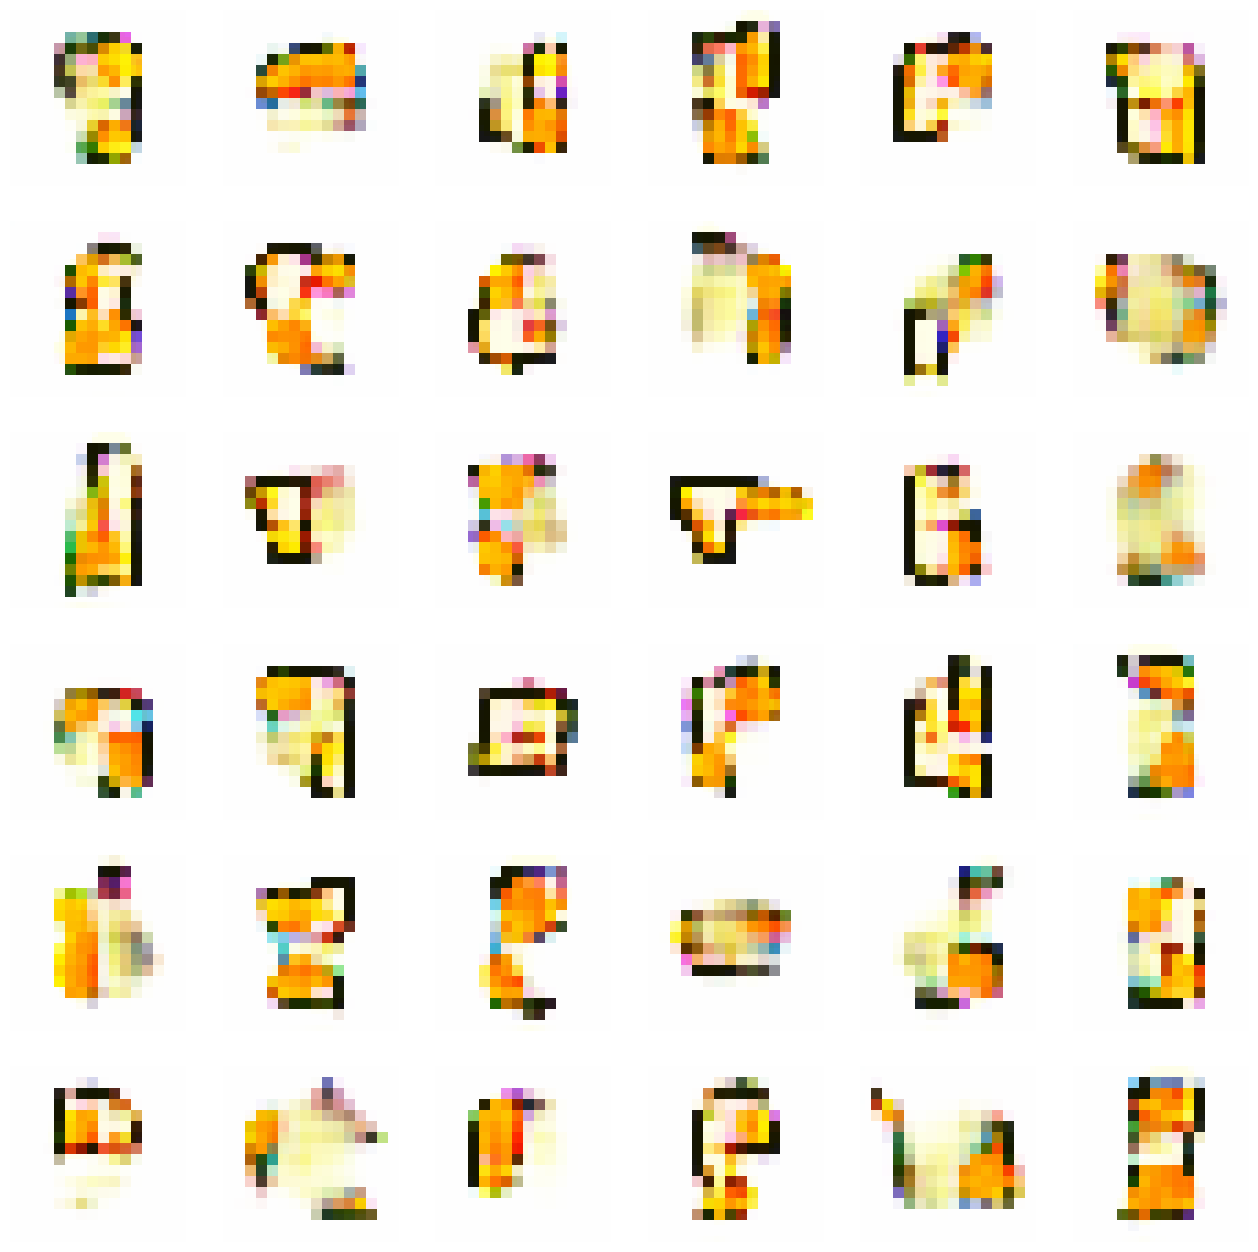

25/25 [==============================] - 417s 17s/step - d_loss: -16.5629 - g_loss: 22.9790
Epoch 6/50
25/25 [==============================] - ETA: 0s - d_loss: -18.4005 - g_loss: 23.8609 

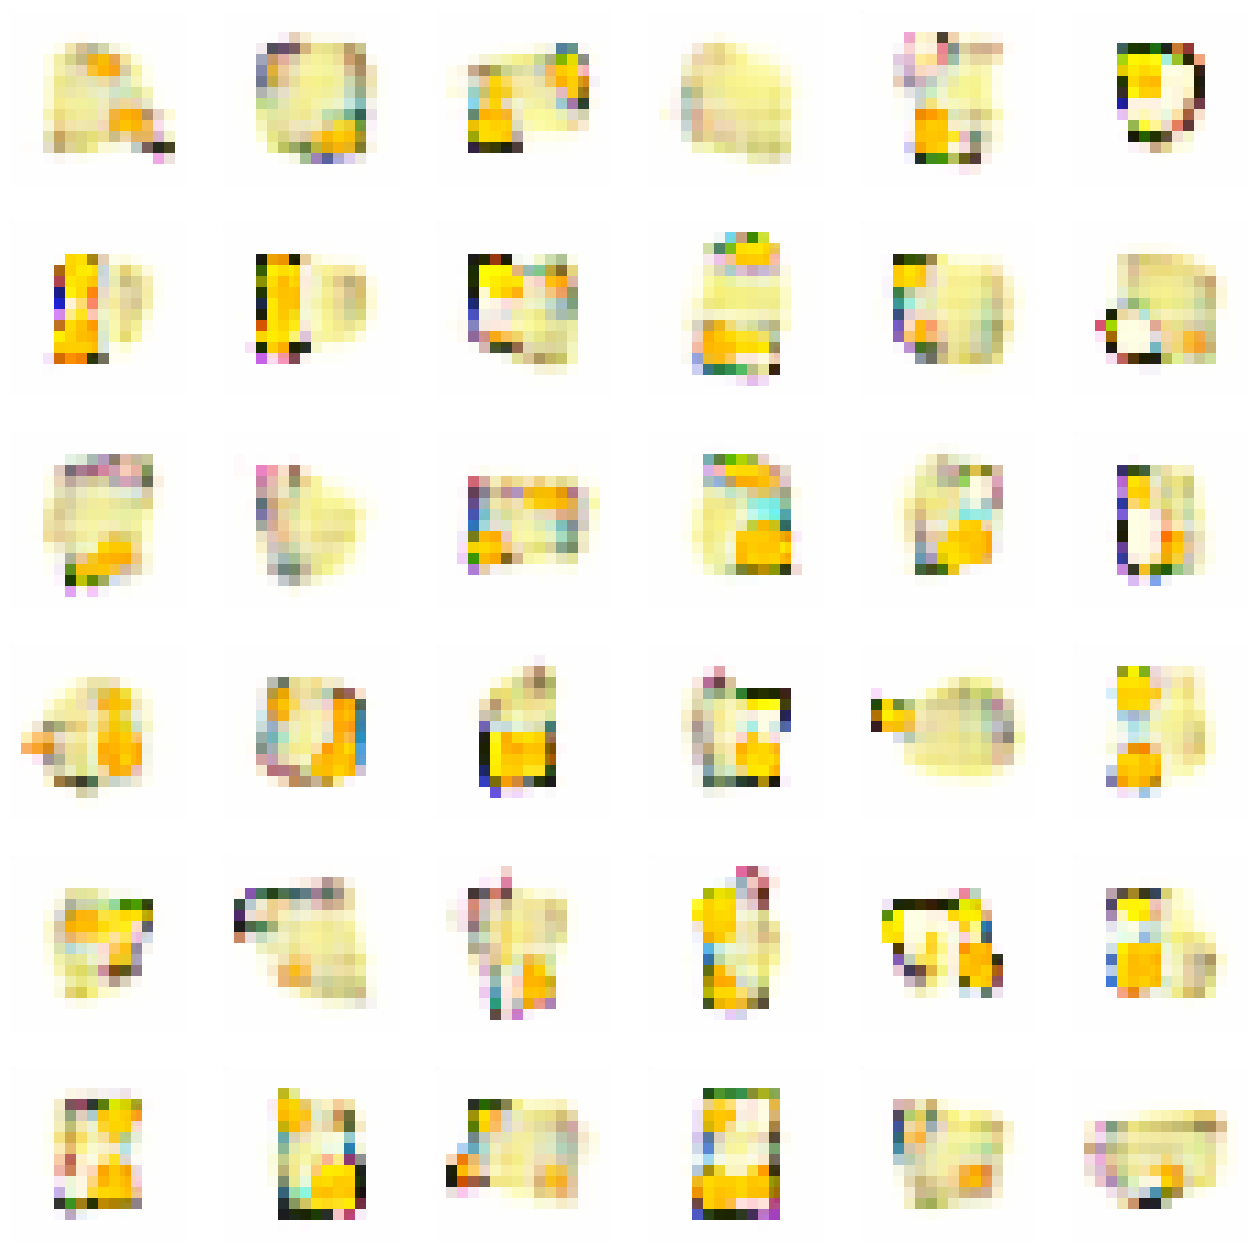

25/25 [==============================] - 418s 17s/step - d_loss: -18.3607 - g_loss: 23.7243
Epoch 7/50
25/25 [==============================] - ETA: 0s - d_loss: -16.1623 - g_loss: 23.2785 

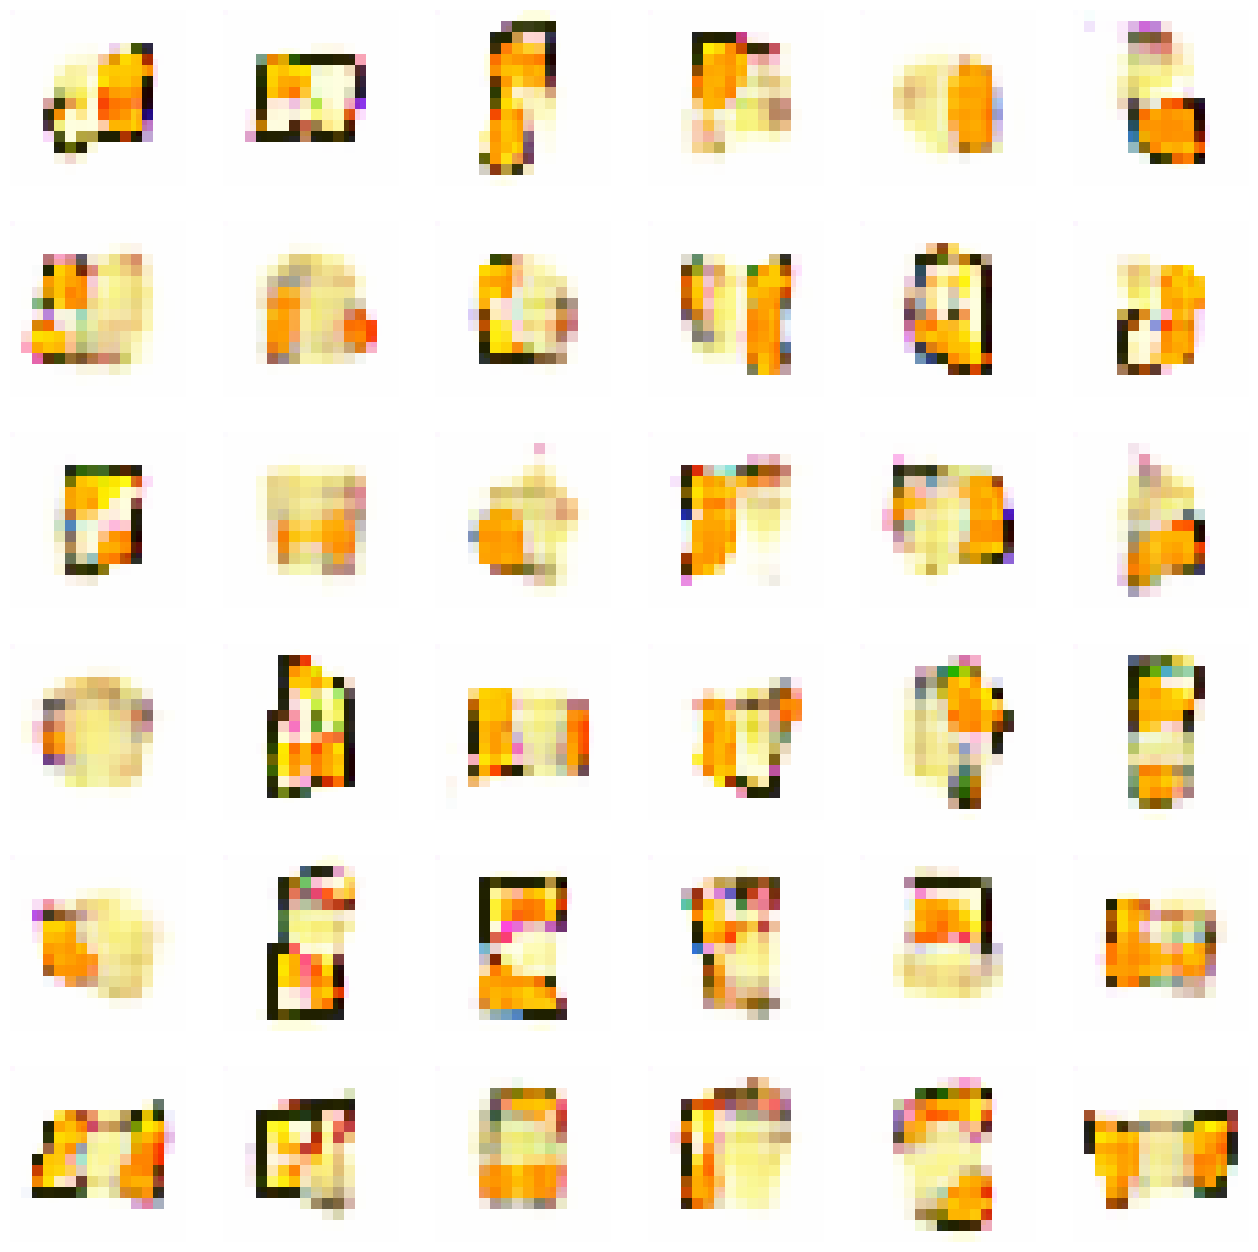

25/25 [==============================] - 407s 16s/step - d_loss: -16.4806 - g_loss: 23.3652
Epoch 8/50
25/25 [==============================] - ETA: 0s - d_loss: -19.6091 - g_loss: 26.2971 

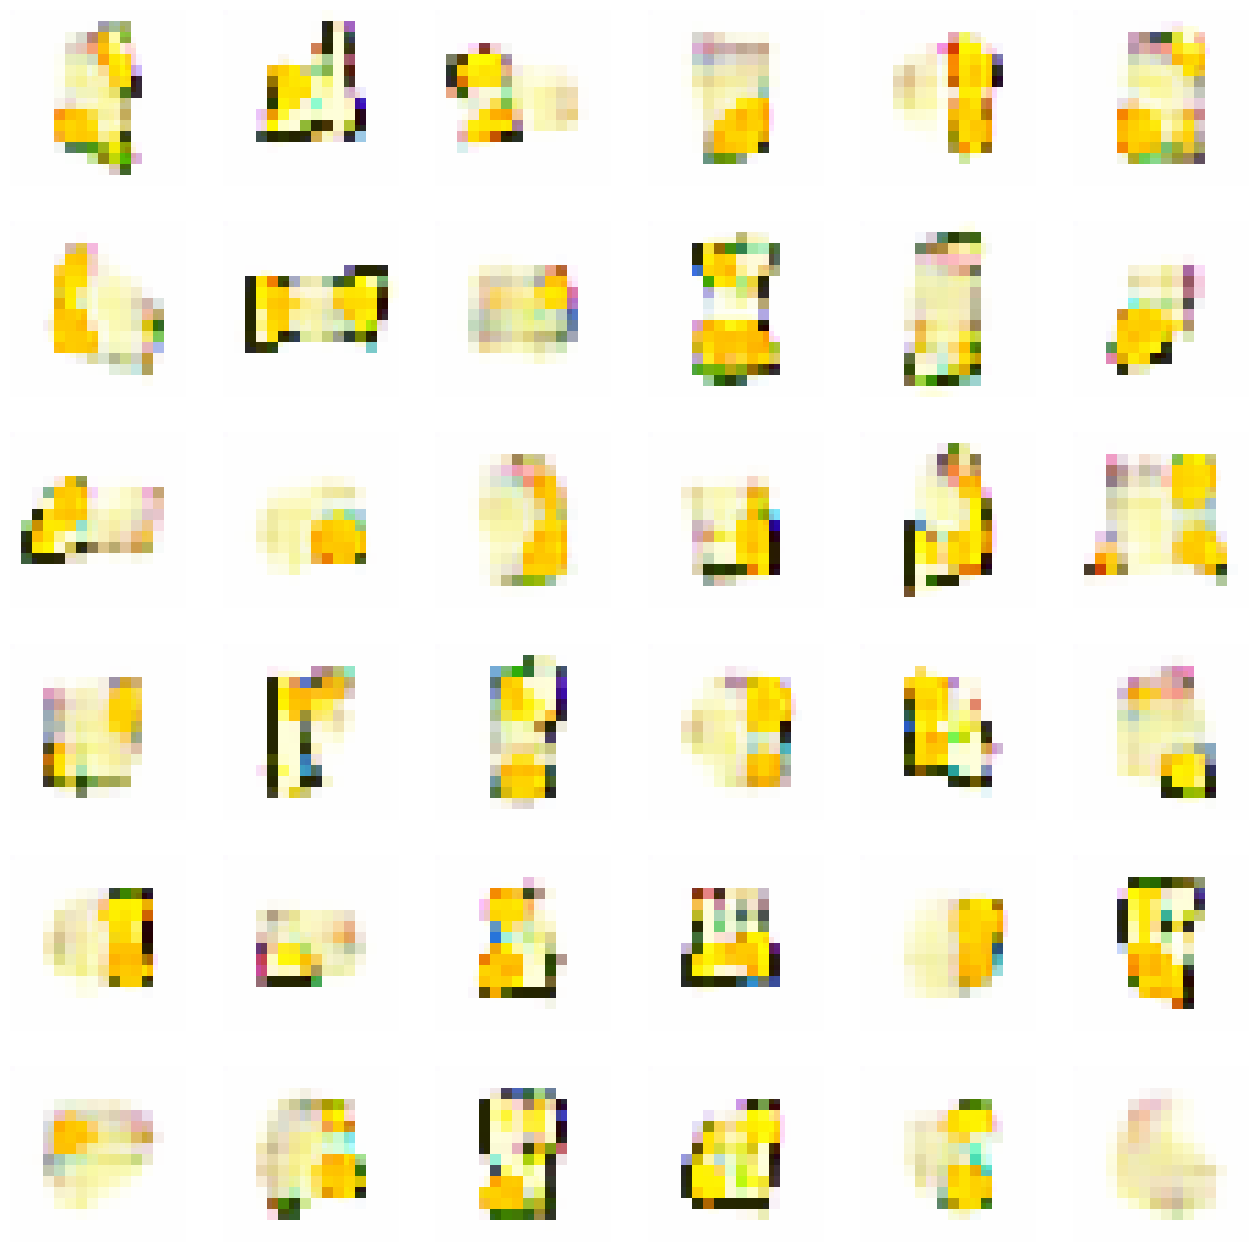

25/25 [==============================] - 408s 16s/step - d_loss: -19.4069 - g_loss: 26.5404
Epoch 9/50
25/25 [==============================] - ETA: 0s - d_loss: -19.3452 - g_loss: 29.4928 

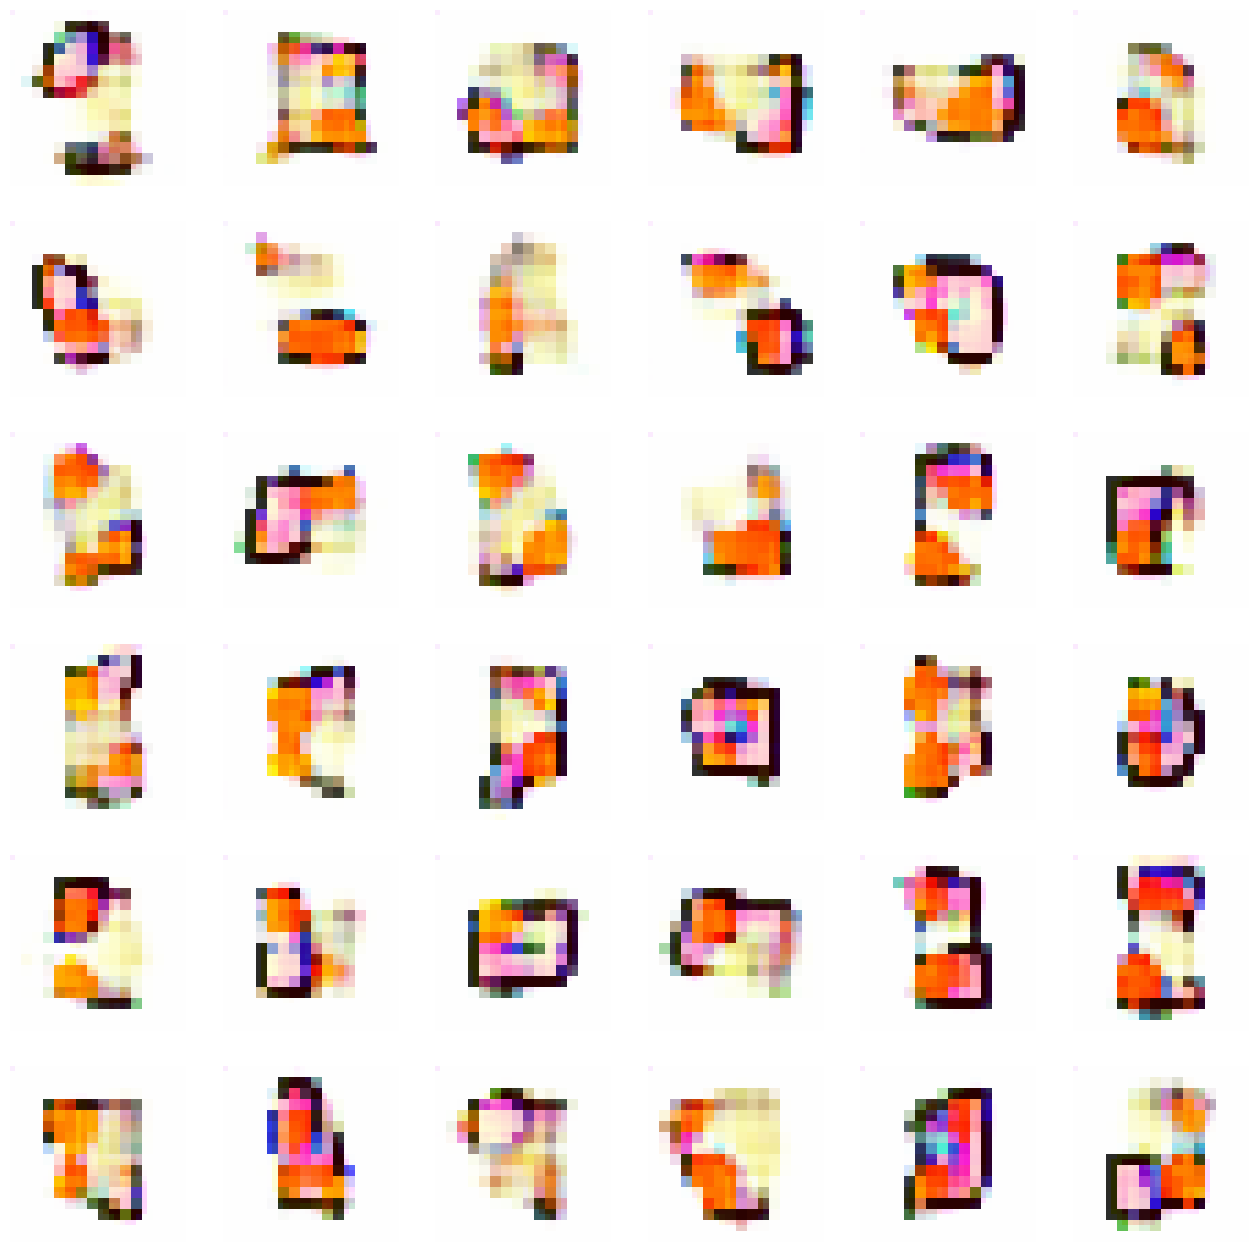

25/25 [==============================] - 420s 17s/step - d_loss: -18.8490 - g_loss: 31.3686
Epoch 10/50
25/25 [==============================] - ETA: 0s - d_loss: -20.9437 - g_loss: 28.1147 

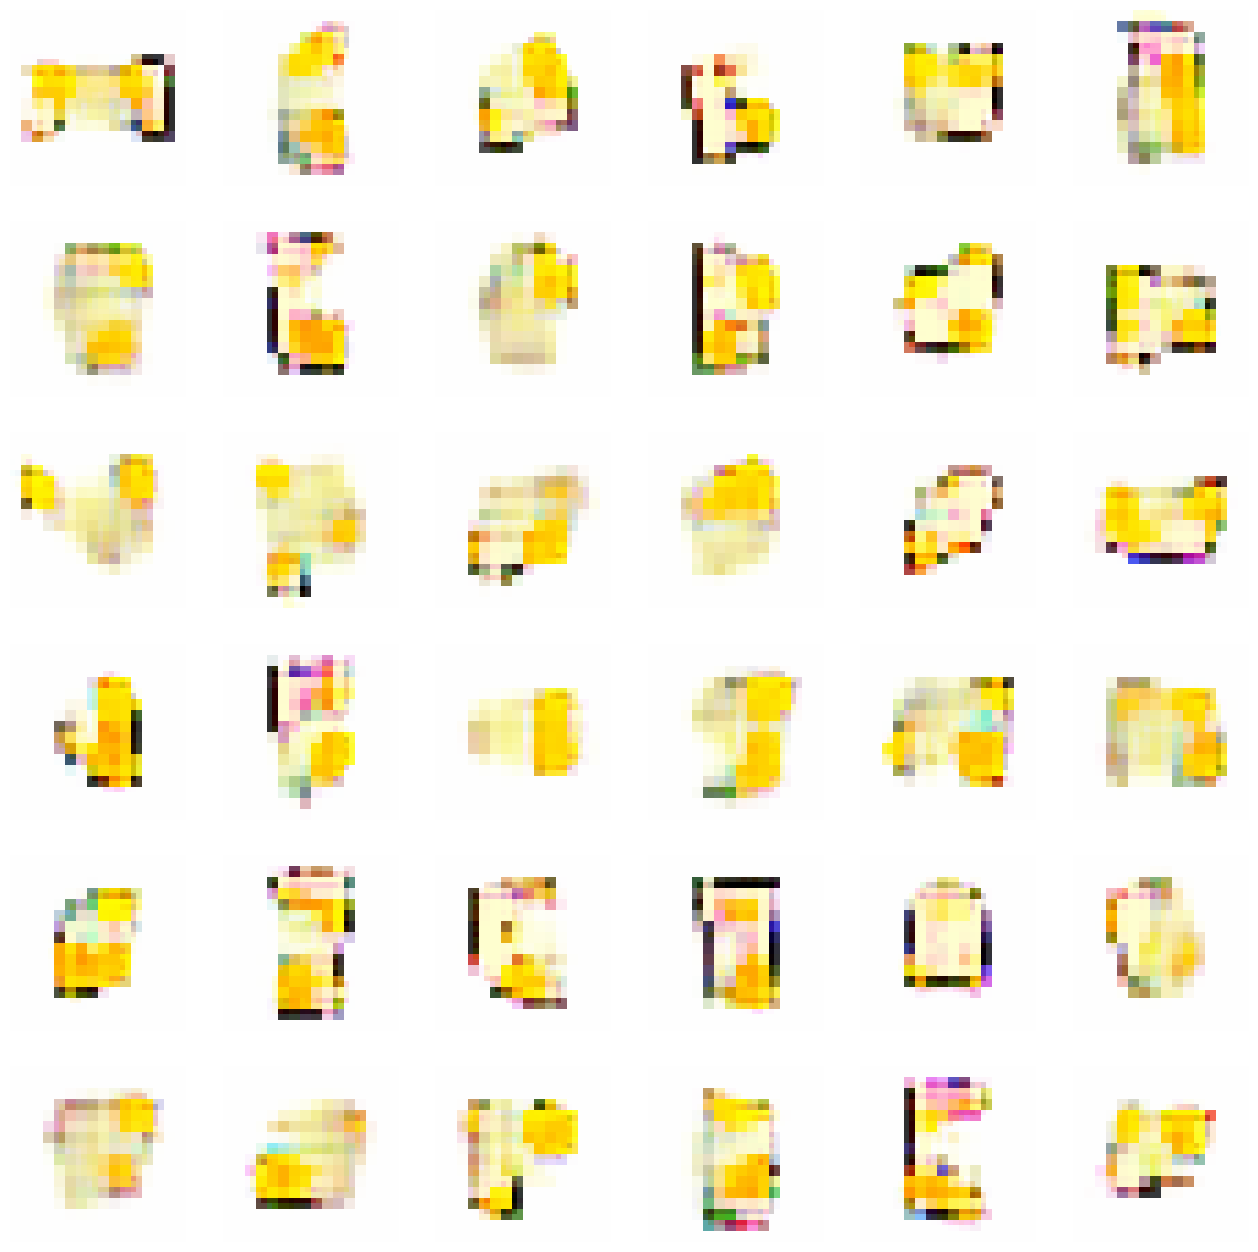

25/25 [==============================] - 414s 17s/step - d_loss: -20.7522 - g_loss: 26.4298
Epoch 11/50
12/25 [=============>................] - ETA: 3:34 - d_loss: -13.4705 - g_loss: 22.9326

In [ ]:
for n_depth in range(1, 6):


  ################ Faded
    pgan.n_depth = n_depth
    train_dataset=create_dataset(4*(2**n_depth),BATCH_SIZE[n_depth])

    cbk=ShowImage('fading',4*(2**n_depth),latent_dim=512,steps_per_epoch=STEPS_PER_EPOCH,epochs=EPOCHS)
    pgan.fade_in_generator()
    pgan.fade_in_discriminator()
        # After updating the model architecture, reinitialize the optimizers
    generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.0, beta_2=0.99, epsilon=1e-8)
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.0, beta_2=0.99, epsilon=1e-8)


    pgan.compile(
      d_optimizer=discriminator_optimizer,
      g_optimizer=generator_optimizer,
    )

    pgan.fit(train_dataset.take(STEPS_PER_EPOCH),epochs = EPOCHS, callbacks=[cbk])


  ################# Stabilized

    cbk=ShowImage('stabilize',4*(2**n_depth),latent_dim=512,steps_per_epoch=STEPS_PER_EPOCH,epochs=EPOCHS)
    pgan.stabilize_generator()
    pgan.stabilize_discriminator()

    pgan.compile(
      d_optimizer=discriminator_optimizer,
      g_optimizer=generator_optimizer,
    )
    pgan.fit(train_dataset.take(STEPS_PER_EPOCH),epochs=EPOCHS, callbacks=[cbk])


In [ ]:
pgan.generator.save_weights('pggan_generator_128.h5')
pgan.discriminator.save_weights('pggan_discriminator_128.h5')